In [1]:
!pip install scikit-optimize

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [5]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [6]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    sns.scatterplot(test_label, predicted_dv, color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [7]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [8]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [9]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)[:20]
    print(f'IMP: {imp}')
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_[:20])
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

# Loading dataset

In [10]:
import pickle

with open('./Okko_ratings_RUSS.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

# Preprocessing

1. Multiple value categorical features: tops' tf-idf
    * actor: top 5
    * country: 1st
    * genre: top 3
    * director: 1st 
2. Just categorical 
    * type: ohe
    * release year: periods: 1918-1969, 1970-1979, 1980-1989, ... с 2000 по годам
3. Numeric and categorical ordered
    * age_access: scale
    * avg_rating: knn-imputer, scale
    * duration: scale
4. textual
    * name: catboost.text
5. target:
    * log
    
## Multiple value categorical features: tops' tf-idf

### filter by year

In [11]:
df.shape

(1705, 1027)

In [12]:
d = df[df['release_year'] >= 2000]

In [13]:
d.shape

(1666, 1027)

In [14]:
d.isna().sum()[:30]

age_access_type       0
name                  0
director              0
genre                 0
average_rating       67
type                  0
country               0
release_type          0
release_year          0
duration              0
actor                 0
element_uid           0
ACTOR                57
COMPOSER            298
DESIGN              390
DIRECTOR             15
EDITOR              653
OPERATOR            242
PRODUCER             96
WRITER               47
BUDGET             1482
MARKETING          1659
RUS                1087
USA                1620
WORLD              1261
element_id            0
rating                0
джек                  0
расследовать          0
подруга               0
dtype: int64

In [15]:
d.columns[:30]

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'джек', 'расследовать', 'подруга'],
      dtype='object')

In [16]:
d.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id'], axis=1, inplace=True)

In [17]:
mltpl_cat_features = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
num_features = [ 'duration']
cat_features = ['age_access_type']
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'WORLD']
mltpl_cat_n_top = {'ACTOR': 10, 'country': 1, 'DIRECTOR': 1, 
                   'EDITOR': 1, 'OPERATOR': 1, 'PRODUCER': 5, 'WRITER': 2,
                   'DESIGN': 3, 'COMPOSER': 1, 'genre': 3}

In [18]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
# from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English
# nlp = English()
import pandas as pd

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                if isinstance(names, float):
                    names = ['Na']
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [19]:
preprocesser = Preprocesser(mltpl_cat_features,
            skewed_num_features,
            #text_features,
            mltpl_cat_n_top)

In [20]:
df_pr = preprocesser.preprocess(d)

In [21]:
df_pr.shape

(1666, 1040)

In [22]:
df_pr.isnull().sum()

age_access_type       0
name                  0
type                  0
release_year          0
duration              0
                   ... 
WRITER_1            673
country_0             0
genre_0               0
genre_1             767
genre_2            1412
Length: 1040, dtype: int64

In [23]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'PRODUCER_1', 'PRODUCER_2', 'PRODUCER_3', 'PRODUCER_4', 'WRITER_0',
       'WRITER_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=1040)

In [24]:
df_pr.rename({'ACTOR_0': 'actor_0','ACTOR_1' : 'actor_1', 'ACTOR_2': 'actor_2', 'ACTOR_3':'actor_3',
       'ACTOR_4': 'actor_4', 'ACTOR_5': 'actor_5', 'ACTOR_6': 'actor_6', 'ACTOR_7':'actor_7',
              'ACTOR_8':'actor_8', 'ACTOR_9':'actor_9',
       'COMPOSER_0': 'composer_0', 'DESIGN_0': 'design_0', 'DESIGN_1': 'design_1', 'DESIGN_2': 'design_2',
              'DIRECTOR_0': 'director_0',
       'EDITOR_0': 'editor_0', 'OPERATOR_0': 'operator_0', 'PRODUCER_0': 'producer_0',
              'PRODUCER_1':  'producer_1', 'PRODUCER_2':  'producer_2',
       'PRODUCER_3':  'producer_3', 'PRODUCER_4': 'producer_4', 'WRITER_0':'writer_0', 'WRITER_1': 'writer_1'}, axis=1, inplace=True)

In [25]:
df_pr.rename({'BUDGET': 'budget','MARKETING' : 'marketing', 'RUS': 'rus', 'WORLD':'world'}, axis=1, inplace=True)

In [26]:
cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
                'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
                'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
                'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
                'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
                'genre_1', 'genre_2']

In [27]:
df_pr[cat_features] = df_pr[cat_features].replace(np.nan, 'Na')

In [28]:
# df_pr['average_rating'] = df_pr['average_rating'].astype(float)
df_pr['rating'] = df_pr['rating'].astype(float)
# df_pr['age_access_type'] =df_pr['age_access_type'].astype(int)

In [29]:
df_pr.shape

(1666, 1040)

### target destrib

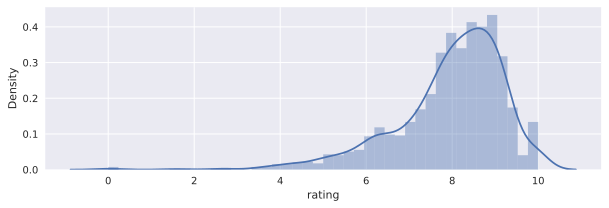

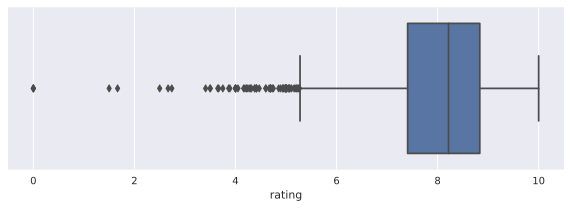

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

In [31]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'budget', 'marketing', 'rus', 'USA',
       ...
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=1040)

In [32]:
df_pr.shape

(1666, 1040)

In [33]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 143 to 10486
Columns: 1040 entries, age_access_type to genre_2
dtypes: float64(7), int64(1002), object(31)
memory usage: 13.3+ MB


## Split

In [41]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

X_test, y_test = test.drop('rating', axis=1), test['rating']
X, y = train.drop('rating', axis=1), train['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((1453, 1036), (162, 1036), (51, 1036), (1453,), (162,), (51,))

## Standartization

In [44]:
col_names_scaled = ['duration', 'budget', 'marketing', 'rus', 'USA', 'world']

In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train[col_names_scaled] = sc.fit_transform(X_train[col_names_scaled])
X_val[col_names_scaled] = sc.transform(X_val[col_names_scaled])
X_test[col_names_scaled] = sc.transform(X_test[col_names_scaled])

### Model

In [46]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [47]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.053997
0:	learn: 0.9473194	test: 0.9537520	best: 0.9537520 (0)	total: 23.5ms	remaining: 23.4s
100:	learn: 0.7622657	test: 0.8505761	best: 0.8494095 (96)	total: 2.38s	remaining: 21.2s
200:	learn: 0.7125351	test: 0.8425119	best: 0.8421363 (175)	total: 4.63s	remaining: 18.4s
300:	learn: 0.6756045	test: 0.8491242	best: 0.8403331 (216)	total: 6.89s	remaining: 16s
400:	learn: 0.6416695	test: 0.8436031	best: 0.8403331 (216)	total: 9.19s	remaining: 13.7s
500:	learn: 0.6139896	test: 0.8408653	best: 0.8403331 (216)	total: 11.6s	remaining: 11.6s
600:	learn: 0.5895341	test: 0.8397001	best: 0.8395098 (595)	total: 14.1s	remaining: 9.39s
700:	learn: 0.5678847	test: 0.8372767	best: 0.8351589 (658)	total: 16.5s	remaining: 7.03s
800:	learn: 0.5468716	test: 0.8374325	best: 0.8351589 (658)	total: 18.8s	remaining: 4.66s
900:	learn: 0.5277332	test: 0.8336519	best: 0.8336519 (900)	total: 21.1s	remaining: 2.32s
999:	learn: 0.5066905	test: 0.8364718	best: 0.8334119 (903)	total: 23.4s	rem

In [48]:
y_pred = cat_model.predict(test_dataset)

In [49]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.3990956899935263
RMSE:  1.1828337541656166
R2:    0.3181040322220249
MAE:   0.836952899570382
MedAE: 0.6867641305184993
------------------------------


In [50]:
cat_model.save_model('okko_ratings_pred_kws_russ')

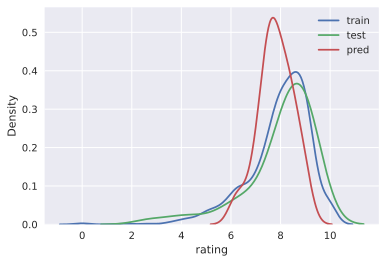

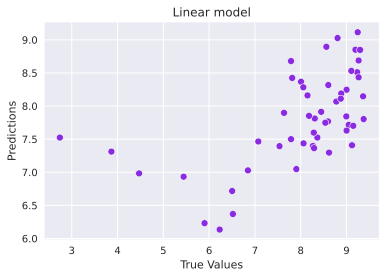

In [51]:
target_distr_linear(y_train, y_test, y_pred)   

IMP: [10.47532523  6.32960826 11.5717982   0.93706839  0.          3.36097369
  0.07257183  2.38843681  0.          0.          0.04582693  0.
  0.          0.          0.06879057  0.04885677  0.          0.0434201
  0.32330514  0.        ]


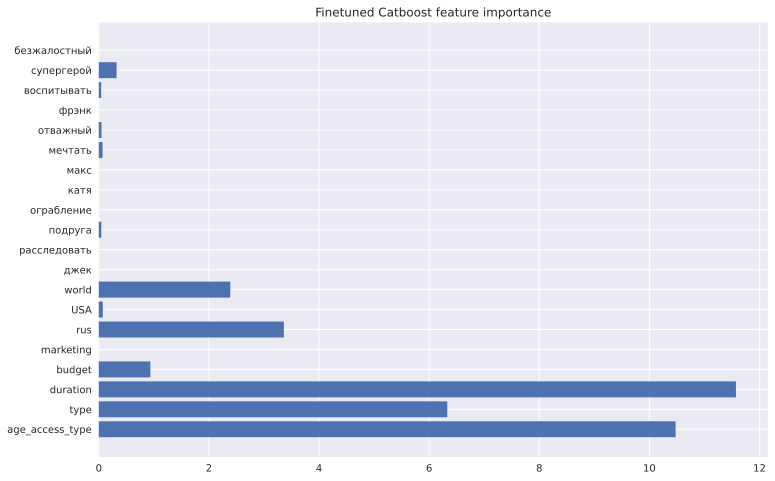

In [52]:
get_feature_imp(cat_model, train_dataset)

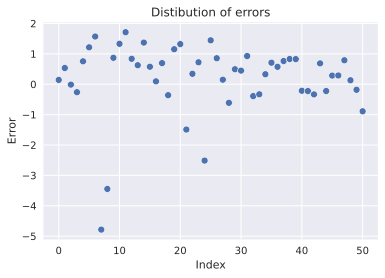

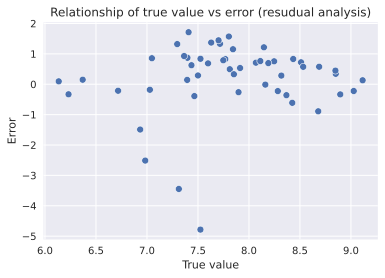

In [53]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

### LOOKING AT TEST

In [54]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

age_access_type                                               name  \
10378               16                                         Тихие воды   
7938                16                      Русские грузины. Фильм второй   
10377               16              Я знаю твои секреты 7. Дыхание смерти   
7698                12                                      Тайна амулета   
10370               18                                          Два холма   
10369               18                                            Оффлайн   
10368               16                              И снова здравствуйте!   
5410                16                                         Другое имя   
4462                16                                         Селфимания   
10391                0                               Мой мир. Поем вместе   
10390               18                                             Смычок   
7909                 0                        Три кота и море приключений   
8189                12  Все в сад! Или русская классика в цветах. Сезон 2   
10475               18  Что делать женщине, если у неё два любовника, ...   
10399               18                                               Жиза   
7644                 6                                       Забытое чудо   
5474                18                                             Модель   
10440               18                                   Закрыть гештальт   
10389               16                            Кабинет Путешественника   
5542                16                                        Многоэтажка   
7505                18                                               Ника   
5556                16                                         Бодибилдер   
6304                 6                           Кощей. Похититель невест   
5208                12                          1941. Крылья над Берлином   
6183                16                                     Доктор Свисток   
6354                16                                    Молодой человек   
6404                16                                           Свингеры   
6435                18                                          Приплыли!   
6012                 6                                   Мой папа – вождь   
5925                16                                              Дикая   
10246               12                            Предпоследняя инстанция   
6673                16                                        Страна Саша   
6697                16                        Эластико: Двенадцатый игрок   
6771                18                                              Рэпер   
10281                0                                         Спорт Тоша   
10286               18                                          Номинация   
10306               16                                              Агеев   
5681                16                             День слепого Валентина   
7499                12                                      Мистер Нокаут   
5566                16                                         Хочу замуж   
6267                16                                        Убить босса   
10341               16                                          Пианистка   
7515                12                                       Первый Оскар   
10349               16                                     Танцы на углях   
10350               16                                             Янычар   
10352               16                            Исправление и наказание   
10354               16                          Орлинская. Стрелы Нептуна   
7549                16                                         Бультерьер   
7565                 6                                             Финник   
5551                16                                             Стикер   
10486                6                                       Большие игры   

  

# Tuning

In [55]:
train_dataset = cat.Pool(X_train, 
                         y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(X_test, 
                        y_test,
                        cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [56]:
parameters_distr = {'depth': randint(3, 7),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [100, 1000, 5000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5,
#                           n_jobs=-1, 
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_ratings_kinop_kws_russ', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.9085493	total: 20.3ms	remaining: 1m 41s
1:	learn: 0.8954446	total: 49ms	remaining: 2m 2s
2:	learn: 0.8833765	total: 76.9ms	remaining: 2m 8s
3:	learn: 0.8706882	total: 99.8ms	remaining: 2m 4s
4:	learn: 0.8614492	total: 129ms	remaining: 2m 8s
5:	learn: 0.8524429	total: 152ms	remaining: 2m 6s
6:	learn: 0.8484473	total: 170ms	remaining: 2m
7:	learn: 0.8401318	total: 193ms	remaining: 2m
8:	learn: 0.8315560	total: 215ms	remaining: 1m 59s
9:	learn: 0.8251131	total: 238ms	remaining: 1m 58s
10:	learn: 0.8200587	total: 257ms	remaining: 1m 56s
11:	learn: 0.8149794	total: 274ms	remaining: 1m 54s
12:	learn: 0.8097959	total: 297ms	remaining: 1m 53s
13:	learn: 0.8035342	total: 319ms	remaining: 1m 53s
14:	learn: 0.7992379	total: 340ms	remaining: 1m 52s
15:	learn: 0.7963951	total: 368ms	remaining: 1m 54s
16:	learn: 0.7936910	total: 397ms	remaining: 1m 56s
17:	learn: 0.7888065	total: 430ms	remaining: 1m 58s
18:	learn: 0.7858359	tot

162:	learn: 0.6352292	total: 3.89s	remaining: 1m 55s
163:	learn: 0.6350030	total: 3.92s	remaining: 1m 55s
164:	learn: 0.6344934	total: 3.94s	remaining: 1m 55s
165:	learn: 0.6334297	total: 3.97s	remaining: 1m 55s
166:	learn: 0.6330807	total: 3.99s	remaining: 1m 55s
167:	learn: 0.6326130	total: 4.02s	remaining: 1m 55s
168:	learn: 0.6322534	total: 4.04s	remaining: 1m 55s
169:	learn: 0.6310557	total: 4.06s	remaining: 1m 55s
170:	learn: 0.6303972	total: 4.08s	remaining: 1m 55s
171:	learn: 0.6295731	total: 4.11s	remaining: 1m 55s
172:	learn: 0.6292567	total: 4.13s	remaining: 1m 55s
173:	learn: 0.6288732	total: 4.15s	remaining: 1m 55s
174:	learn: 0.6287035	total: 4.17s	remaining: 1m 55s
175:	learn: 0.6276121	total: 4.19s	remaining: 1m 54s
176:	learn: 0.6269162	total: 4.21s	remaining: 1m 54s
177:	learn: 0.6265402	total: 4.23s	remaining: 1m 54s
178:	learn: 0.6257958	total: 4.26s	remaining: 1m 54s
179:	learn: 0.6252049	total: 4.28s	remaining: 1m 54s
180:	learn: 0.6244510	total: 4.3s	remaining: 1

318:	learn: 0.5618020	total: 7.49s	remaining: 1m 49s
319:	learn: 0.5617350	total: 7.51s	remaining: 1m 49s
320:	learn: 0.5615952	total: 7.53s	remaining: 1m 49s
321:	learn: 0.5612856	total: 7.56s	remaining: 1m 49s
322:	learn: 0.5609030	total: 7.59s	remaining: 1m 49s
323:	learn: 0.5604783	total: 7.61s	remaining: 1m 49s
324:	learn: 0.5600739	total: 7.64s	remaining: 1m 49s
325:	learn: 0.5597869	total: 7.66s	remaining: 1m 49s
326:	learn: 0.5595938	total: 7.68s	remaining: 1m 49s
327:	learn: 0.5595417	total: 7.7s	remaining: 1m 49s
328:	learn: 0.5590412	total: 7.72s	remaining: 1m 49s
329:	learn: 0.5589551	total: 7.74s	remaining: 1m 49s
330:	learn: 0.5582089	total: 7.76s	remaining: 1m 49s
331:	learn: 0.5580818	total: 7.78s	remaining: 1m 49s
332:	learn: 0.5577372	total: 7.8s	remaining: 1m 49s
333:	learn: 0.5575047	total: 7.83s	remaining: 1m 49s
334:	learn: 0.5569961	total: 7.86s	remaining: 1m 49s
335:	learn: 0.5564070	total: 7.88s	remaining: 1m 49s
336:	learn: 0.5562425	total: 7.9s	remaining: 1m 

480:	learn: 0.5032703	total: 11.3s	remaining: 1m 46s
481:	learn: 0.5025683	total: 11.3s	remaining: 1m 46s
482:	learn: 0.5021193	total: 11.4s	remaining: 1m 46s
483:	learn: 0.5016999	total: 11.4s	remaining: 1m 46s
484:	learn: 0.5013925	total: 11.4s	remaining: 1m 46s
485:	learn: 0.5012839	total: 11.4s	remaining: 1m 46s
486:	learn: 0.5005919	total: 11.5s	remaining: 1m 46s
487:	learn: 0.5003322	total: 11.5s	remaining: 1m 46s
488:	learn: 0.4997257	total: 11.5s	remaining: 1m 46s
489:	learn: 0.4996159	total: 11.5s	remaining: 1m 46s
490:	learn: 0.4992284	total: 11.5s	remaining: 1m 46s
491:	learn: 0.4983745	total: 11.6s	remaining: 1m 46s
492:	learn: 0.4976967	total: 11.6s	remaining: 1m 46s
493:	learn: 0.4976787	total: 11.6s	remaining: 1m 46s
494:	learn: 0.4972123	total: 11.6s	remaining: 1m 45s
495:	learn: 0.4959301	total: 11.7s	remaining: 1m 45s
496:	learn: 0.4956145	total: 11.7s	remaining: 1m 45s
497:	learn: 0.4955523	total: 11.7s	remaining: 1m 45s
498:	learn: 0.4952427	total: 11.7s	remaining: 

641:	learn: 0.4518216	total: 15.1s	remaining: 1m 42s
642:	learn: 0.4517675	total: 15.1s	remaining: 1m 42s
643:	learn: 0.4509456	total: 15.1s	remaining: 1m 42s
644:	learn: 0.4506552	total: 15.2s	remaining: 1m 42s
645:	learn: 0.4505887	total: 15.2s	remaining: 1m 42s
646:	learn: 0.4504999	total: 15.2s	remaining: 1m 42s
647:	learn: 0.4501986	total: 15.2s	remaining: 1m 42s
648:	learn: 0.4498934	total: 15.2s	remaining: 1m 42s
649:	learn: 0.4494821	total: 15.3s	remaining: 1m 42s
650:	learn: 0.4492007	total: 15.3s	remaining: 1m 42s
651:	learn: 0.4491092	total: 15.3s	remaining: 1m 42s
652:	learn: 0.4490071	total: 15.3s	remaining: 1m 42s
653:	learn: 0.4488046	total: 15.4s	remaining: 1m 42s
654:	learn: 0.4480706	total: 15.4s	remaining: 1m 42s
655:	learn: 0.4480175	total: 15.4s	remaining: 1m 41s
656:	learn: 0.4478857	total: 15.4s	remaining: 1m 41s
657:	learn: 0.4476086	total: 15.4s	remaining: 1m 41s
658:	learn: 0.4472727	total: 15.5s	remaining: 1m 41s
659:	learn: 0.4469055	total: 15.5s	remaining: 

801:	learn: 0.4162178	total: 18.9s	remaining: 1m 38s
802:	learn: 0.4158756	total: 18.9s	remaining: 1m 38s
803:	learn: 0.4158494	total: 18.9s	remaining: 1m 38s
804:	learn: 0.4157649	total: 18.9s	remaining: 1m 38s
805:	learn: 0.4156001	total: 19s	remaining: 1m 38s
806:	learn: 0.4151321	total: 19s	remaining: 1m 38s
807:	learn: 0.4147520	total: 19s	remaining: 1m 38s
808:	learn: 0.4142587	total: 19s	remaining: 1m 38s
809:	learn: 0.4139097	total: 19s	remaining: 1m 38s
810:	learn: 0.4137946	total: 19.1s	remaining: 1m 38s
811:	learn: 0.4135061	total: 19.1s	remaining: 1m 38s
812:	learn: 0.4134903	total: 19.1s	remaining: 1m 38s
813:	learn: 0.4129455	total: 19.1s	remaining: 1m 38s
814:	learn: 0.4126408	total: 19.2s	remaining: 1m 38s
815:	learn: 0.4125988	total: 19.2s	remaining: 1m 38s
816:	learn: 0.4123630	total: 19.2s	remaining: 1m 38s
817:	learn: 0.4117238	total: 19.2s	remaining: 1m 38s
818:	learn: 0.4113994	total: 19.3s	remaining: 1m 38s
819:	learn: 0.4113427	total: 19.3s	remaining: 1m 38s
820

964:	learn: 0.3862049	total: 22.7s	remaining: 1m 34s
965:	learn: 0.3861154	total: 22.7s	remaining: 1m 34s
966:	learn: 0.3859500	total: 22.8s	remaining: 1m 34s
967:	learn: 0.3855644	total: 22.8s	remaining: 1m 34s
968:	learn: 0.3853477	total: 22.8s	remaining: 1m 34s
969:	learn: 0.3851075	total: 22.8s	remaining: 1m 34s
970:	learn: 0.3847836	total: 22.9s	remaining: 1m 34s
971:	learn: 0.3846982	total: 22.9s	remaining: 1m 34s
972:	learn: 0.3841766	total: 22.9s	remaining: 1m 34s
973:	learn: 0.3840734	total: 22.9s	remaining: 1m 34s
974:	learn: 0.3837231	total: 22.9s	remaining: 1m 34s
975:	learn: 0.3832119	total: 23s	remaining: 1m 34s
976:	learn: 0.3830299	total: 23s	remaining: 1m 34s
977:	learn: 0.3828934	total: 23s	remaining: 1m 34s
978:	learn: 0.3825697	total: 23s	remaining: 1m 34s
979:	learn: 0.3823264	total: 23.1s	remaining: 1m 34s
980:	learn: 0.3822338	total: 23.1s	remaining: 1m 34s
981:	learn: 0.3821577	total: 23.1s	remaining: 1m 34s
982:	learn: 0.3821100	total: 23.1s	remaining: 1m 34s
9

1120:	learn: 0.3541072	total: 26.3s	remaining: 1m 31s
1121:	learn: 0.3540684	total: 26.4s	remaining: 1m 31s
1122:	learn: 0.3538996	total: 26.4s	remaining: 1m 31s
1123:	learn: 0.3537265	total: 26.4s	remaining: 1m 31s
1124:	learn: 0.3536234	total: 26.4s	remaining: 1m 31s
1125:	learn: 0.3528909	total: 26.4s	remaining: 1m 30s
1126:	learn: 0.3526125	total: 26.5s	remaining: 1m 30s
1127:	learn: 0.3524516	total: 26.5s	remaining: 1m 30s
1128:	learn: 0.3523871	total: 26.5s	remaining: 1m 30s
1129:	learn: 0.3522472	total: 26.5s	remaining: 1m 30s
1130:	learn: 0.3521698	total: 26.6s	remaining: 1m 30s
1131:	learn: 0.3517742	total: 26.6s	remaining: 1m 30s
1132:	learn: 0.3516207	total: 26.6s	remaining: 1m 30s
1133:	learn: 0.3513155	total: 26.6s	remaining: 1m 30s
1134:	learn: 0.3508093	total: 26.7s	remaining: 1m 30s
1135:	learn: 0.3507359	total: 26.7s	remaining: 1m 30s
1136:	learn: 0.3502896	total: 26.7s	remaining: 1m 30s
1137:	learn: 0.3497449	total: 26.7s	remaining: 1m 30s
1138:	learn: 0.3496901	total

1276:	learn: 0.3254514	total: 29.9s	remaining: 1m 27s
1277:	learn: 0.3254134	total: 29.9s	remaining: 1m 27s
1278:	learn: 0.3253613	total: 30s	remaining: 1m 27s
1279:	learn: 0.3251114	total: 30s	remaining: 1m 27s
1280:	learn: 0.3247966	total: 30s	remaining: 1m 27s
1281:	learn: 0.3247734	total: 30s	remaining: 1m 27s
1282:	learn: 0.3247015	total: 30.1s	remaining: 1m 27s
1283:	learn: 0.3246228	total: 30.1s	remaining: 1m 27s
1284:	learn: 0.3243879	total: 30.1s	remaining: 1m 27s
1285:	learn: 0.3242578	total: 30.1s	remaining: 1m 26s
1286:	learn: 0.3240135	total: 30.2s	remaining: 1m 26s
1287:	learn: 0.3238310	total: 30.2s	remaining: 1m 26s
1288:	learn: 0.3238039	total: 30.2s	remaining: 1m 26s
1289:	learn: 0.3234525	total: 30.2s	remaining: 1m 26s
1290:	learn: 0.3232743	total: 30.3s	remaining: 1m 26s
1291:	learn: 0.3232202	total: 30.3s	remaining: 1m 26s
1292:	learn: 0.3231195	total: 30.3s	remaining: 1m 26s
1293:	learn: 0.3230542	total: 30.3s	remaining: 1m 26s
1294:	learn: 0.3229809	total: 30.3s	

1431:	learn: 0.2990750	total: 33.5s	remaining: 1m 23s
1432:	learn: 0.2990078	total: 33.5s	remaining: 1m 23s
1433:	learn: 0.2988643	total: 33.6s	remaining: 1m 23s
1434:	learn: 0.2986213	total: 33.6s	remaining: 1m 23s
1435:	learn: 0.2985305	total: 33.6s	remaining: 1m 23s
1436:	learn: 0.2984363	total: 33.6s	remaining: 1m 23s
1437:	learn: 0.2984218	total: 33.7s	remaining: 1m 23s
1438:	learn: 0.2983752	total: 33.7s	remaining: 1m 23s
1439:	learn: 0.2983201	total: 33.7s	remaining: 1m 23s
1440:	learn: 0.2980438	total: 33.7s	remaining: 1m 23s
1441:	learn: 0.2979644	total: 33.8s	remaining: 1m 23s
1442:	learn: 0.2978953	total: 33.8s	remaining: 1m 23s
1443:	learn: 0.2978682	total: 33.8s	remaining: 1m 23s
1444:	learn: 0.2978175	total: 33.8s	remaining: 1m 23s
1445:	learn: 0.2975675	total: 33.8s	remaining: 1m 23s
1446:	learn: 0.2975007	total: 33.9s	remaining: 1m 23s
1447:	learn: 0.2974533	total: 33.9s	remaining: 1m 23s
1448:	learn: 0.2971479	total: 33.9s	remaining: 1m 23s
1449:	learn: 0.2968088	total

1588:	learn: 0.2782208	total: 37.2s	remaining: 1m 19s
1589:	learn: 0.2781412	total: 37.2s	remaining: 1m 19s
1590:	learn: 0.2780641	total: 37.2s	remaining: 1m 19s
1591:	learn: 0.2780519	total: 37.3s	remaining: 1m 19s
1592:	learn: 0.2780233	total: 37.3s	remaining: 1m 19s
1593:	learn: 0.2778486	total: 37.3s	remaining: 1m 19s
1594:	learn: 0.2777832	total: 37.3s	remaining: 1m 19s
1595:	learn: 0.2776763	total: 37.3s	remaining: 1m 19s
1596:	learn: 0.2775083	total: 37.4s	remaining: 1m 19s
1597:	learn: 0.2773995	total: 37.4s	remaining: 1m 19s
1598:	learn: 0.2771060	total: 37.4s	remaining: 1m 19s
1599:	learn: 0.2770157	total: 37.4s	remaining: 1m 19s
1600:	learn: 0.2769402	total: 37.4s	remaining: 1m 19s
1601:	learn: 0.2768902	total: 37.5s	remaining: 1m 19s
1602:	learn: 0.2768485	total: 37.5s	remaining: 1m 19s
1603:	learn: 0.2767385	total: 37.5s	remaining: 1m 19s
1604:	learn: 0.2766802	total: 37.5s	remaining: 1m 19s
1605:	learn: 0.2766323	total: 37.6s	remaining: 1m 19s
1606:	learn: 0.2763221	total

1744:	learn: 0.2603751	total: 40.8s	remaining: 1m 16s
1745:	learn: 0.2601107	total: 40.8s	remaining: 1m 16s
1746:	learn: 0.2600840	total: 40.8s	remaining: 1m 16s
1747:	learn: 0.2599421	total: 40.9s	remaining: 1m 16s
1748:	learn: 0.2598784	total: 40.9s	remaining: 1m 16s
1749:	learn: 0.2598546	total: 40.9s	remaining: 1m 15s
1750:	learn: 0.2598209	total: 40.9s	remaining: 1m 15s
1751:	learn: 0.2596874	total: 41s	remaining: 1m 15s
1752:	learn: 0.2596605	total: 41s	remaining: 1m 15s
1753:	learn: 0.2595214	total: 41s	remaining: 1m 15s
1754:	learn: 0.2594382	total: 41s	remaining: 1m 15s
1755:	learn: 0.2592026	total: 41.1s	remaining: 1m 15s
1756:	learn: 0.2591069	total: 41.1s	remaining: 1m 15s
1757:	learn: 0.2590029	total: 41.1s	remaining: 1m 15s
1758:	learn: 0.2589921	total: 41.1s	remaining: 1m 15s
1759:	learn: 0.2588370	total: 41.2s	remaining: 1m 15s
1760:	learn: 0.2586981	total: 41.2s	remaining: 1m 15s
1761:	learn: 0.2585620	total: 41.2s	remaining: 1m 15s
1762:	learn: 0.2584117	total: 41.2s	

1897:	learn: 0.2442732	total: 44.4s	remaining: 1m 12s
1898:	learn: 0.2442472	total: 44.4s	remaining: 1m 12s
1899:	learn: 0.2442270	total: 44.5s	remaining: 1m 12s
1900:	learn: 0.2440844	total: 44.5s	remaining: 1m 12s
1901:	learn: 0.2440242	total: 44.5s	remaining: 1m 12s
1902:	learn: 0.2438157	total: 44.5s	remaining: 1m 12s
1903:	learn: 0.2437691	total: 44.5s	remaining: 1m 12s
1904:	learn: 0.2437347	total: 44.6s	remaining: 1m 12s
1905:	learn: 0.2435929	total: 44.6s	remaining: 1m 12s
1906:	learn: 0.2434237	total: 44.6s	remaining: 1m 12s
1907:	learn: 0.2433914	total: 44.6s	remaining: 1m 12s
1908:	learn: 0.2431142	total: 44.7s	remaining: 1m 12s
1909:	learn: 0.2430148	total: 44.7s	remaining: 1m 12s
1910:	learn: 0.2428320	total: 44.7s	remaining: 1m 12s
1911:	learn: 0.2427433	total: 44.7s	remaining: 1m 12s
1912:	learn: 0.2425677	total: 44.8s	remaining: 1m 12s
1913:	learn: 0.2425640	total: 44.8s	remaining: 1m 12s
1914:	learn: 0.2425380	total: 44.8s	remaining: 1m 12s
1915:	learn: 0.2423450	total

2052:	learn: 0.2287825	total: 48s	remaining: 1m 8s
2053:	learn: 0.2287460	total: 48s	remaining: 1m 8s
2054:	learn: 0.2287292	total: 48s	remaining: 1m 8s
2055:	learn: 0.2285332	total: 48.1s	remaining: 1m 8s
2056:	learn: 0.2284790	total: 48.1s	remaining: 1m 8s
2057:	learn: 0.2284658	total: 48.1s	remaining: 1m 8s
2058:	learn: 0.2284141	total: 48.1s	remaining: 1m 8s
2059:	learn: 0.2283992	total: 48.2s	remaining: 1m 8s
2060:	learn: 0.2283820	total: 48.2s	remaining: 1m 8s
2061:	learn: 0.2281281	total: 48.2s	remaining: 1m 8s
2062:	learn: 0.2281255	total: 48.2s	remaining: 1m 8s
2063:	learn: 0.2277173	total: 48.3s	remaining: 1m 8s
2064:	learn: 0.2276673	total: 48.3s	remaining: 1m 8s
2065:	learn: 0.2276522	total: 48.3s	remaining: 1m 8s
2066:	learn: 0.2276047	total: 48.3s	remaining: 1m 8s
2067:	learn: 0.2275507	total: 48.3s	remaining: 1m 8s
2068:	learn: 0.2275125	total: 48.4s	remaining: 1m 8s
2069:	learn: 0.2273095	total: 48.4s	remaining: 1m 8s
2070:	learn: 0.2272685	total: 48.4s	remaining: 1m 8s

2208:	learn: 0.2120939	total: 51.8s	remaining: 1m 5s
2209:	learn: 0.2118614	total: 51.8s	remaining: 1m 5s
2210:	learn: 0.2118098	total: 51.8s	remaining: 1m 5s
2211:	learn: 0.2117586	total: 51.9s	remaining: 1m 5s
2212:	learn: 0.2116949	total: 51.9s	remaining: 1m 5s
2213:	learn: 0.2116488	total: 51.9s	remaining: 1m 5s
2214:	learn: 0.2116115	total: 51.9s	remaining: 1m 5s
2215:	learn: 0.2115397	total: 52s	remaining: 1m 5s
2216:	learn: 0.2114526	total: 52s	remaining: 1m 5s
2217:	learn: 0.2113915	total: 52s	remaining: 1m 5s
2218:	learn: 0.2113174	total: 52.1s	remaining: 1m 5s
2219:	learn: 0.2112741	total: 52.1s	remaining: 1m 5s
2220:	learn: 0.2111040	total: 52.1s	remaining: 1m 5s
2221:	learn: 0.2110133	total: 52.1s	remaining: 1m 5s
2222:	learn: 0.2109590	total: 52.2s	remaining: 1m 5s
2223:	learn: 0.2108980	total: 52.2s	remaining: 1m 5s
2224:	learn: 0.2107305	total: 52.2s	remaining: 1m 5s
2225:	learn: 0.2107122	total: 52.2s	remaining: 1m 5s
2226:	learn: 0.2103741	total: 52.3s	remaining: 1m 5s

2370:	learn: 0.1985383	total: 55.6s	remaining: 1m 1s
2371:	learn: 0.1983746	total: 55.6s	remaining: 1m 1s
2372:	learn: 0.1983545	total: 55.6s	remaining: 1m 1s
2373:	learn: 0.1983484	total: 55.7s	remaining: 1m 1s
2374:	learn: 0.1980845	total: 55.7s	remaining: 1m 1s
2375:	learn: 0.1980563	total: 55.7s	remaining: 1m 1s
2376:	learn: 0.1979509	total: 55.7s	remaining: 1m 1s
2377:	learn: 0.1977960	total: 55.8s	remaining: 1m 1s
2378:	learn: 0.1975529	total: 55.8s	remaining: 1m 1s
2379:	learn: 0.1973438	total: 55.8s	remaining: 1m 1s
2380:	learn: 0.1972452	total: 55.8s	remaining: 1m 1s
2381:	learn: 0.1971908	total: 55.9s	remaining: 1m 1s
2382:	learn: 0.1971701	total: 55.9s	remaining: 1m 1s
2383:	learn: 0.1971099	total: 55.9s	remaining: 1m 1s
2384:	learn: 0.1970569	total: 55.9s	remaining: 1m 1s
2385:	learn: 0.1970067	total: 56s	remaining: 1m 1s
2386:	learn: 0.1967990	total: 56s	remaining: 1m 1s
2387:	learn: 0.1967705	total: 56s	remaining: 1m 1s
2388:	learn: 0.1966105	total: 56s	remaining: 1m 1s
2

2530:	learn: 0.1857123	total: 59.2s	remaining: 57.8s
2531:	learn: 0.1855760	total: 59.2s	remaining: 57.7s
2532:	learn: 0.1855077	total: 59.3s	remaining: 57.7s
2533:	learn: 0.1853893	total: 59.3s	remaining: 57.7s
2534:	learn: 0.1853772	total: 59.3s	remaining: 57.7s
2535:	learn: 0.1853720	total: 59.3s	remaining: 57.6s
2536:	learn: 0.1852511	total: 59.4s	remaining: 57.6s
2537:	learn: 0.1850540	total: 59.4s	remaining: 57.6s
2538:	learn: 0.1848312	total: 59.4s	remaining: 57.6s
2539:	learn: 0.1845407	total: 59.4s	remaining: 57.6s
2540:	learn: 0.1845220	total: 59.4s	remaining: 57.5s
2541:	learn: 0.1842914	total: 59.5s	remaining: 57.5s
2542:	learn: 0.1842740	total: 59.5s	remaining: 57.5s
2543:	learn: 0.1842321	total: 59.5s	remaining: 57.5s
2544:	learn: 0.1841853	total: 59.5s	remaining: 57.4s
2545:	learn: 0.1840950	total: 59.6s	remaining: 57.4s
2546:	learn: 0.1840670	total: 59.6s	remaining: 57.4s
2547:	learn: 0.1840399	total: 59.6s	remaining: 57.4s
2548:	learn: 0.1839759	total: 59.6s	remaining:

2692:	learn: 0.1747565	total: 1m 3s	remaining: 54.4s
2693:	learn: 0.1747217	total: 1m 3s	remaining: 54.4s
2694:	learn: 0.1746679	total: 1m 3s	remaining: 54.3s
2695:	learn: 0.1746564	total: 1m 3s	remaining: 54.3s
2696:	learn: 0.1746460	total: 1m 3s	remaining: 54.3s
2697:	learn: 0.1743782	total: 1m 3s	remaining: 54.3s
2698:	learn: 0.1743403	total: 1m 3s	remaining: 54.2s
2699:	learn: 0.1742238	total: 1m 3s	remaining: 54.2s
2700:	learn: 0.1742116	total: 1m 3s	remaining: 54.2s
2701:	learn: 0.1741184	total: 1m 3s	remaining: 54.2s
2702:	learn: 0.1740913	total: 1m 3s	remaining: 54.2s
2703:	learn: 0.1740666	total: 1m 3s	remaining: 54.1s
2704:	learn: 0.1740152	total: 1m 3s	remaining: 54.1s
2705:	learn: 0.1738384	total: 1m 3s	remaining: 54.1s
2706:	learn: 0.1738108	total: 1m 3s	remaining: 54.1s
2707:	learn: 0.1735867	total: 1m 3s	remaining: 54s
2708:	learn: 0.1735540	total: 1m 3s	remaining: 54s
2709:	learn: 0.1735239	total: 1m 3s	remaining: 54s
2710:	learn: 0.1735211	total: 1m 3s	remaining: 54s
2

2849:	learn: 0.1643926	total: 1m 7s	remaining: 50.8s
2850:	learn: 0.1643843	total: 1m 7s	remaining: 50.8s
2851:	learn: 0.1642528	total: 1m 7s	remaining: 50.8s
2852:	learn: 0.1642448	total: 1m 7s	remaining: 50.8s
2853:	learn: 0.1642121	total: 1m 7s	remaining: 50.7s
2854:	learn: 0.1641995	total: 1m 7s	remaining: 50.7s
2855:	learn: 0.1640581	total: 1m 7s	remaining: 50.7s
2856:	learn: 0.1639342	total: 1m 7s	remaining: 50.7s
2857:	learn: 0.1639207	total: 1m 7s	remaining: 50.7s
2858:	learn: 0.1638827	total: 1m 7s	remaining: 50.6s
2859:	learn: 0.1637821	total: 1m 7s	remaining: 50.6s
2860:	learn: 0.1637482	total: 1m 7s	remaining: 50.6s
2861:	learn: 0.1637402	total: 1m 7s	remaining: 50.6s
2862:	learn: 0.1637179	total: 1m 7s	remaining: 50.5s
2863:	learn: 0.1634982	total: 1m 7s	remaining: 50.5s
2864:	learn: 0.1634517	total: 1m 7s	remaining: 50.5s
2865:	learn: 0.1633566	total: 1m 7s	remaining: 50.5s
2866:	learn: 0.1633461	total: 1m 7s	remaining: 50.5s
2867:	learn: 0.1633294	total: 1m 7s	remaining:

3012:	learn: 0.1546963	total: 1m 11s	remaining: 47.1s
3013:	learn: 0.1546568	total: 1m 11s	remaining: 47.1s
3014:	learn: 0.1546278	total: 1m 11s	remaining: 47.1s
3015:	learn: 0.1545007	total: 1m 11s	remaining: 47s
3016:	learn: 0.1544913	total: 1m 11s	remaining: 47s
3017:	learn: 0.1544824	total: 1m 11s	remaining: 47s
3018:	learn: 0.1544762	total: 1m 11s	remaining: 47s
3019:	learn: 0.1544690	total: 1m 11s	remaining: 47s
3020:	learn: 0.1544644	total: 1m 11s	remaining: 46.9s
3021:	learn: 0.1544460	total: 1m 11s	remaining: 46.9s
3022:	learn: 0.1544263	total: 1m 11s	remaining: 46.9s
3023:	learn: 0.1543979	total: 1m 11s	remaining: 46.9s
3024:	learn: 0.1543932	total: 1m 11s	remaining: 46.8s
3025:	learn: 0.1542873	total: 1m 11s	remaining: 46.8s
3026:	learn: 0.1542470	total: 1m 11s	remaining: 46.8s
3027:	learn: 0.1542295	total: 1m 11s	remaining: 46.8s
3028:	learn: 0.1541262	total: 1m 11s	remaining: 46.7s
3029:	learn: 0.1540843	total: 1m 11s	remaining: 46.7s
3030:	learn: 0.1539882	total: 1m 11s	r

3166:	learn: 0.1468700	total: 1m 15s	remaining: 43.5s
3167:	learn: 0.1468355	total: 1m 15s	remaining: 43.5s
3168:	learn: 0.1467151	total: 1m 15s	remaining: 43.5s
3169:	learn: 0.1465687	total: 1m 15s	remaining: 43.5s
3170:	learn: 0.1465651	total: 1m 15s	remaining: 43.4s
3171:	learn: 0.1465433	total: 1m 15s	remaining: 43.4s
3172:	learn: 0.1465310	total: 1m 15s	remaining: 43.4s
3173:	learn: 0.1465215	total: 1m 15s	remaining: 43.4s
3174:	learn: 0.1465011	total: 1m 15s	remaining: 43.3s
3175:	learn: 0.1463588	total: 1m 15s	remaining: 43.3s
3176:	learn: 0.1462977	total: 1m 15s	remaining: 43.3s
3177:	learn: 0.1462143	total: 1m 15s	remaining: 43.3s
3178:	learn: 0.1461329	total: 1m 15s	remaining: 43.3s
3179:	learn: 0.1461187	total: 1m 15s	remaining: 43.2s
3180:	learn: 0.1461038	total: 1m 15s	remaining: 43.2s
3181:	learn: 0.1460258	total: 1m 15s	remaining: 43.2s
3182:	learn: 0.1459759	total: 1m 15s	remaining: 43.2s
3183:	learn: 0.1459362	total: 1m 15s	remaining: 43.1s
3184:	learn: 0.1458988	total

3326:	learn: 0.1378869	total: 1m 19s	remaining: 39.8s
3327:	learn: 0.1378849	total: 1m 19s	remaining: 39.8s
3328:	learn: 0.1378312	total: 1m 19s	remaining: 39.8s
3329:	learn: 0.1377600	total: 1m 19s	remaining: 39.8s
3330:	learn: 0.1377506	total: 1m 19s	remaining: 39.7s
3331:	learn: 0.1377100	total: 1m 19s	remaining: 39.7s
3332:	learn: 0.1377005	total: 1m 19s	remaining: 39.7s
3333:	learn: 0.1376892	total: 1m 19s	remaining: 39.7s
3334:	learn: 0.1376813	total: 1m 19s	remaining: 39.6s
3335:	learn: 0.1376630	total: 1m 19s	remaining: 39.6s
3336:	learn: 0.1376197	total: 1m 19s	remaining: 39.6s
3337:	learn: 0.1376151	total: 1m 19s	remaining: 39.6s
3338:	learn: 0.1375946	total: 1m 19s	remaining: 39.5s
3339:	learn: 0.1375164	total: 1m 19s	remaining: 39.5s
3340:	learn: 0.1374686	total: 1m 19s	remaining: 39.5s
3341:	learn: 0.1374359	total: 1m 19s	remaining: 39.5s
3342:	learn: 0.1374339	total: 1m 19s	remaining: 39.5s
3343:	learn: 0.1374289	total: 1m 19s	remaining: 39.4s
3344:	learn: 0.1373914	total

3483:	learn: 0.1313998	total: 1m 23s	remaining: 36.1s
3484:	learn: 0.1313562	total: 1m 23s	remaining: 36.1s
3485:	learn: 0.1313397	total: 1m 23s	remaining: 36.1s
3486:	learn: 0.1313266	total: 1m 23s	remaining: 36.1s
3487:	learn: 0.1313167	total: 1m 23s	remaining: 36s
3488:	learn: 0.1312936	total: 1m 23s	remaining: 36s
3489:	learn: 0.1311802	total: 1m 23s	remaining: 36s
3490:	learn: 0.1311768	total: 1m 23s	remaining: 36s
3491:	learn: 0.1311697	total: 1m 23s	remaining: 36s
3492:	learn: 0.1311565	total: 1m 23s	remaining: 35.9s
3493:	learn: 0.1310723	total: 1m 23s	remaining: 35.9s
3494:	learn: 0.1310553	total: 1m 23s	remaining: 35.9s
3495:	learn: 0.1310260	total: 1m 23s	remaining: 35.9s
3496:	learn: 0.1310158	total: 1m 23s	remaining: 35.8s
3497:	learn: 0.1309456	total: 1m 23s	remaining: 35.8s
3498:	learn: 0.1307398	total: 1m 23s	remaining: 35.8s
3499:	learn: 0.1307036	total: 1m 23s	remaining: 35.8s
3500:	learn: 0.1306137	total: 1m 23s	remaining: 35.7s
3501:	learn: 0.1305939	total: 1m 23s	r

3640:	learn: 0.1243989	total: 1m 26s	remaining: 32.4s
3641:	learn: 0.1243782	total: 1m 26s	remaining: 32.4s
3642:	learn: 0.1242712	total: 1m 26s	remaining: 32.4s
3643:	learn: 0.1242288	total: 1m 26s	remaining: 32.4s
3644:	learn: 0.1242202	total: 1m 27s	remaining: 32.3s
3645:	learn: 0.1241998	total: 1m 27s	remaining: 32.3s
3646:	learn: 0.1241611	total: 1m 27s	remaining: 32.3s
3647:	learn: 0.1241146	total: 1m 27s	remaining: 32.3s
3648:	learn: 0.1241136	total: 1m 27s	remaining: 32.3s
3649:	learn: 0.1240954	total: 1m 27s	remaining: 32.2s
3650:	learn: 0.1240887	total: 1m 27s	remaining: 32.2s
3651:	learn: 0.1240755	total: 1m 27s	remaining: 32.2s
3652:	learn: 0.1240616	total: 1m 27s	remaining: 32.2s
3653:	learn: 0.1240485	total: 1m 27s	remaining: 32.1s
3654:	learn: 0.1240352	total: 1m 27s	remaining: 32.1s
3655:	learn: 0.1239989	total: 1m 27s	remaining: 32.1s
3656:	learn: 0.1239865	total: 1m 27s	remaining: 32.1s
3657:	learn: 0.1238440	total: 1m 27s	remaining: 32s
3658:	learn: 0.1238261	total: 

3798:	learn: 0.1176326	total: 1m 30s	remaining: 28.7s
3799:	learn: 0.1176265	total: 1m 30s	remaining: 28.7s
3800:	learn: 0.1175705	total: 1m 30s	remaining: 28.6s
3801:	learn: 0.1175451	total: 1m 30s	remaining: 28.6s
3802:	learn: 0.1175120	total: 1m 30s	remaining: 28.6s
3803:	learn: 0.1175046	total: 1m 30s	remaining: 28.6s
3804:	learn: 0.1174692	total: 1m 30s	remaining: 28.5s
3805:	learn: 0.1174571	total: 1m 30s	remaining: 28.5s
3806:	learn: 0.1174034	total: 1m 30s	remaining: 28.5s
3807:	learn: 0.1173860	total: 1m 30s	remaining: 28.5s
3808:	learn: 0.1173587	total: 1m 30s	remaining: 28.5s
3809:	learn: 0.1173457	total: 1m 31s	remaining: 28.4s
3810:	learn: 0.1172622	total: 1m 31s	remaining: 28.4s
3811:	learn: 0.1172172	total: 1m 31s	remaining: 28.4s
3812:	learn: 0.1171397	total: 1m 31s	remaining: 28.4s
3813:	learn: 0.1171080	total: 1m 31s	remaining: 28.3s
3814:	learn: 0.1170808	total: 1m 31s	remaining: 28.3s
3815:	learn: 0.1170360	total: 1m 31s	remaining: 28.3s
3816:	learn: 0.1170132	total

3952:	learn: 0.1114467	total: 1m 34s	remaining: 25s
3953:	learn: 0.1114364	total: 1m 34s	remaining: 25s
3954:	learn: 0.1113794	total: 1m 34s	remaining: 25s
3955:	learn: 0.1113721	total: 1m 34s	remaining: 25s
3956:	learn: 0.1113423	total: 1m 34s	remaining: 24.9s
3957:	learn: 0.1113351	total: 1m 34s	remaining: 24.9s
3958:	learn: 0.1113220	total: 1m 34s	remaining: 24.9s
3959:	learn: 0.1112927	total: 1m 34s	remaining: 24.9s
3960:	learn: 0.1112749	total: 1m 34s	remaining: 24.8s
3961:	learn: 0.1111160	total: 1m 34s	remaining: 24.8s
3962:	learn: 0.1110724	total: 1m 34s	remaining: 24.8s
3963:	learn: 0.1109861	total: 1m 34s	remaining: 24.8s
3964:	learn: 0.1109449	total: 1m 34s	remaining: 24.7s
3965:	learn: 0.1107855	total: 1m 34s	remaining: 24.7s
3966:	learn: 0.1107365	total: 1m 34s	remaining: 24.7s
3967:	learn: 0.1107105	total: 1m 34s	remaining: 24.7s
3968:	learn: 0.1106911	total: 1m 34s	remaining: 24.6s
3969:	learn: 0.1106202	total: 1m 34s	remaining: 24.6s
3970:	learn: 0.1106146	total: 1m 34s

4108:	learn: 0.1050573	total: 1m 38s	remaining: 21.3s
4109:	learn: 0.1050542	total: 1m 38s	remaining: 21.3s
4110:	learn: 0.1049077	total: 1m 38s	remaining: 21.3s
4111:	learn: 0.1048701	total: 1m 38s	remaining: 21.2s
4112:	learn: 0.1048625	total: 1m 38s	remaining: 21.2s
4113:	learn: 0.1047808	total: 1m 38s	remaining: 21.2s
4114:	learn: 0.1047379	total: 1m 38s	remaining: 21.2s
4115:	learn: 0.1047056	total: 1m 38s	remaining: 21.1s
4116:	learn: 0.1046923	total: 1m 38s	remaining: 21.1s
4117:	learn: 0.1046789	total: 1m 38s	remaining: 21.1s
4118:	learn: 0.1046481	total: 1m 38s	remaining: 21.1s
4119:	learn: 0.1046131	total: 1m 38s	remaining: 21.1s
4120:	learn: 0.1045815	total: 1m 38s	remaining: 21s
4121:	learn: 0.1045614	total: 1m 38s	remaining: 21s
4122:	learn: 0.1045282	total: 1m 38s	remaining: 21s
4123:	learn: 0.1044267	total: 1m 38s	remaining: 21s
4124:	learn: 0.1044212	total: 1m 38s	remaining: 20.9s
4125:	learn: 0.1043917	total: 1m 38s	remaining: 20.9s
4126:	learn: 0.1043703	total: 1m 38s

4261:	learn: 0.0999077	total: 1m 42s	remaining: 17.7s
4262:	learn: 0.0998795	total: 1m 42s	remaining: 17.7s
4263:	learn: 0.0998767	total: 1m 42s	remaining: 17.6s
4264:	learn: 0.0997992	total: 1m 42s	remaining: 17.6s
4265:	learn: 0.0997809	total: 1m 42s	remaining: 17.6s
4266:	learn: 0.0997717	total: 1m 42s	remaining: 17.6s
4267:	learn: 0.0997691	total: 1m 42s	remaining: 17.5s
4268:	learn: 0.0997400	total: 1m 42s	remaining: 17.5s
4269:	learn: 0.0997107	total: 1m 42s	remaining: 17.5s
4270:	learn: 0.0997021	total: 1m 42s	remaining: 17.5s
4271:	learn: 0.0996866	total: 1m 42s	remaining: 17.4s
4272:	learn: 0.0996691	total: 1m 42s	remaining: 17.4s
4273:	learn: 0.0996370	total: 1m 42s	remaining: 17.4s
4274:	learn: 0.0995977	total: 1m 42s	remaining: 17.4s
4275:	learn: 0.0995513	total: 1m 42s	remaining: 17.3s
4276:	learn: 0.0995471	total: 1m 42s	remaining: 17.3s
4277:	learn: 0.0993944	total: 1m 42s	remaining: 17.3s
4278:	learn: 0.0993918	total: 1m 42s	remaining: 17.3s
4279:	learn: 0.0993829	total

4417:	learn: 0.0938586	total: 1m 45s	remaining: 13.9s
4418:	learn: 0.0937818	total: 1m 45s	remaining: 13.9s
4419:	learn: 0.0937537	total: 1m 45s	remaining: 13.9s
4420:	learn: 0.0937225	total: 1m 45s	remaining: 13.9s
4421:	learn: 0.0936700	total: 1m 45s	remaining: 13.9s
4422:	learn: 0.0935784	total: 1m 46s	remaining: 13.8s
4423:	learn: 0.0934766	total: 1m 46s	remaining: 13.8s
4424:	learn: 0.0934765	total: 1m 46s	remaining: 13.8s
4425:	learn: 0.0934718	total: 1m 46s	remaining: 13.8s
4426:	learn: 0.0934601	total: 1m 46s	remaining: 13.7s
4427:	learn: 0.0934313	total: 1m 46s	remaining: 13.7s
4428:	learn: 0.0934265	total: 1m 46s	remaining: 13.7s
4429:	learn: 0.0933902	total: 1m 46s	remaining: 13.7s
4430:	learn: 0.0933733	total: 1m 46s	remaining: 13.6s
4431:	learn: 0.0933638	total: 1m 46s	remaining: 13.6s
4432:	learn: 0.0932642	total: 1m 46s	remaining: 13.6s
4433:	learn: 0.0932585	total: 1m 46s	remaining: 13.6s
4434:	learn: 0.0931793	total: 1m 46s	remaining: 13.5s
4435:	learn: 0.0931690	total

4576:	learn: 0.0893432	total: 1m 49s	remaining: 10.1s
4577:	learn: 0.0892804	total: 1m 49s	remaining: 10.1s
4578:	learn: 0.0892429	total: 1m 49s	remaining: 10.1s
4579:	learn: 0.0892182	total: 1m 49s	remaining: 10.1s
4580:	learn: 0.0892163	total: 1m 49s	remaining: 10s
4581:	learn: 0.0891123	total: 1m 49s	remaining: 10s
4582:	learn: 0.0891126	total: 1m 49s	remaining: 10s
4583:	learn: 0.0890951	total: 1m 49s	remaining: 9.98s
4584:	learn: 0.0889908	total: 1m 49s	remaining: 9.95s
4585:	learn: 0.0889811	total: 1m 49s	remaining: 9.93s
4586:	learn: 0.0889237	total: 1m 50s	remaining: 9.9s
4587:	learn: 0.0889172	total: 1m 50s	remaining: 9.88s
4588:	learn: 0.0888981	total: 1m 50s	remaining: 9.86s
4589:	learn: 0.0888939	total: 1m 50s	remaining: 9.83s
4590:	learn: 0.0888677	total: 1m 50s	remaining: 9.81s
4591:	learn: 0.0888180	total: 1m 50s	remaining: 9.79s
4592:	learn: 0.0888102	total: 1m 50s	remaining: 9.76s
4593:	learn: 0.0887593	total: 1m 50s	remaining: 9.74s
4594:	learn: 0.0887165	total: 1m 50

4731:	learn: 0.0849654	total: 1m 53s	remaining: 6.43s
4732:	learn: 0.0849646	total: 1m 53s	remaining: 6.41s
4733:	learn: 0.0849101	total: 1m 53s	remaining: 6.38s
4734:	learn: 0.0848333	total: 1m 53s	remaining: 6.36s
4735:	learn: 0.0848207	total: 1m 53s	remaining: 6.34s
4736:	learn: 0.0847898	total: 1m 53s	remaining: 6.31s
4737:	learn: 0.0847591	total: 1m 53s	remaining: 6.29s
4738:	learn: 0.0847480	total: 1m 53s	remaining: 6.26s
4739:	learn: 0.0847433	total: 1m 53s	remaining: 6.24s
4740:	learn: 0.0847359	total: 1m 53s	remaining: 6.22s
4741:	learn: 0.0847244	total: 1m 53s	remaining: 6.19s
4742:	learn: 0.0846785	total: 1m 53s	remaining: 6.17s
4743:	learn: 0.0846372	total: 1m 53s	remaining: 6.14s
4744:	learn: 0.0846202	total: 1m 53s	remaining: 6.12s
4745:	learn: 0.0845630	total: 1m 53s	remaining: 6.1s
4746:	learn: 0.0845573	total: 1m 53s	remaining: 6.07s
4747:	learn: 0.0845532	total: 1m 53s	remaining: 6.05s
4748:	learn: 0.0845485	total: 1m 54s	remaining: 6.03s
4749:	learn: 0.0845396	total:

4886:	learn: 0.0809763	total: 1m 57s	remaining: 2.71s
4887:	learn: 0.0809715	total: 1m 57s	remaining: 2.69s
4888:	learn: 0.0809545	total: 1m 57s	remaining: 2.67s
4889:	learn: 0.0809439	total: 1m 57s	remaining: 2.64s
4890:	learn: 0.0809244	total: 1m 57s	remaining: 2.62s
4891:	learn: 0.0808860	total: 1m 57s	remaining: 2.59s
4892:	learn: 0.0808697	total: 1m 57s	remaining: 2.57s
4893:	learn: 0.0808653	total: 1m 57s	remaining: 2.55s
4894:	learn: 0.0808546	total: 1m 57s	remaining: 2.52s
4895:	learn: 0.0808375	total: 1m 57s	remaining: 2.5s
4896:	learn: 0.0808051	total: 1m 57s	remaining: 2.48s
4897:	learn: 0.0808013	total: 1m 57s	remaining: 2.45s
4898:	learn: 0.0807828	total: 1m 57s	remaining: 2.43s
4899:	learn: 0.0807615	total: 1m 57s	remaining: 2.4s
4900:	learn: 0.0807496	total: 1m 57s	remaining: 2.38s
4901:	learn: 0.0807378	total: 1m 57s	remaining: 2.35s
4902:	learn: 0.0807172	total: 1m 57s	remaining: 2.33s
4903:	learn: 0.0806983	total: 1m 57s	remaining: 2.31s
4904:	learn: 0.0806737	total: 

43:	learn: 0.7978593	total: 1.05s	remaining: 1m 58s
44:	learn: 0.7974407	total: 1.08s	remaining: 1m 58s
45:	learn: 0.7970454	total: 1.1s	remaining: 1m 58s
46:	learn: 0.7953615	total: 1.13s	remaining: 1m 59s
47:	learn: 0.7921376	total: 1.15s	remaining: 1m 59s
48:	learn: 0.7907903	total: 1.18s	remaining: 1m 59s
49:	learn: 0.7886173	total: 1.21s	remaining: 1m 59s
50:	learn: 0.7884896	total: 1.23s	remaining: 1m 59s
51:	learn: 0.7883620	total: 1.26s	remaining: 2m
52:	learn: 0.7874619	total: 1.29s	remaining: 2m
53:	learn: 0.7873900	total: 1.31s	remaining: 2m
54:	learn: 0.7852388	total: 1.34s	remaining: 2m
55:	learn: 0.7852479	total: 1.35s	remaining: 1m 59s
56:	learn: 0.7833917	total: 1.38s	remaining: 1m 59s
57:	learn: 0.7821477	total: 1.41s	remaining: 1m 59s
58:	learn: 0.7819462	total: 1.43s	remaining: 1m 59s
59:	learn: 0.7818260	total: 1.45s	remaining: 1m 59s
60:	learn: 0.7796693	total: 1.47s	remaining: 1m 59s
61:	learn: 0.7785490	total: 1.5s	remaining: 1m 59s
62:	learn: 0.7772929	total: 1.

202:	learn: 0.6642173	total: 4.88s	remaining: 1m 55s
203:	learn: 0.6641011	total: 4.9s	remaining: 1m 55s
204:	learn: 0.6640393	total: 4.93s	remaining: 1m 55s
205:	learn: 0.6636983	total: 4.95s	remaining: 1m 55s
206:	learn: 0.6635838	total: 4.98s	remaining: 1m 55s
207:	learn: 0.6629000	total: 5s	remaining: 1m 55s
208:	learn: 0.6625401	total: 5.03s	remaining: 1m 55s
209:	learn: 0.6612604	total: 5.05s	remaining: 1m 55s
210:	learn: 0.6609703	total: 5.08s	remaining: 1m 55s
211:	learn: 0.6603713	total: 5.1s	remaining: 1m 55s
212:	learn: 0.6601659	total: 5.13s	remaining: 1m 55s
213:	learn: 0.6599622	total: 5.16s	remaining: 1m 55s
214:	learn: 0.6593520	total: 5.19s	remaining: 1m 55s
215:	learn: 0.6590153	total: 5.21s	remaining: 1m 55s
216:	learn: 0.6583461	total: 5.23s	remaining: 1m 55s
217:	learn: 0.6578286	total: 5.26s	remaining: 1m 55s
218:	learn: 0.6576339	total: 5.28s	remaining: 1m 55s
219:	learn: 0.6560166	total: 5.31s	remaining: 1m 55s
220:	learn: 0.6553491	total: 5.34s	remaining: 1m 55

361:	learn: 0.5894703	total: 8.72s	remaining: 1m 51s
362:	learn: 0.5891908	total: 8.74s	remaining: 1m 51s
363:	learn: 0.5881275	total: 8.76s	remaining: 1m 51s
364:	learn: 0.5878691	total: 8.79s	remaining: 1m 51s
365:	learn: 0.5877853	total: 8.81s	remaining: 1m 51s
366:	learn: 0.5870491	total: 8.84s	remaining: 1m 51s
367:	learn: 0.5866302	total: 8.86s	remaining: 1m 51s
368:	learn: 0.5864696	total: 8.88s	remaining: 1m 51s
369:	learn: 0.5862331	total: 8.9s	remaining: 1m 51s
370:	learn: 0.5858869	total: 8.93s	remaining: 1m 51s
371:	learn: 0.5853664	total: 8.96s	remaining: 1m 51s
372:	learn: 0.5852065	total: 8.98s	remaining: 1m 51s
373:	learn: 0.5850933	total: 9.02s	remaining: 1m 51s
374:	learn: 0.5849743	total: 9.04s	remaining: 1m 51s
375:	learn: 0.5847078	total: 9.06s	remaining: 1m 51s
376:	learn: 0.5837862	total: 9.09s	remaining: 1m 51s
377:	learn: 0.5836671	total: 9.11s	remaining: 1m 51s
378:	learn: 0.5835512	total: 9.14s	remaining: 1m 51s
379:	learn: 0.5830025	total: 9.16s	remaining: 1

517:	learn: 0.5379461	total: 12.5s	remaining: 1m 48s
518:	learn: 0.5374431	total: 12.5s	remaining: 1m 48s
519:	learn: 0.5367762	total: 12.5s	remaining: 1m 48s
520:	learn: 0.5359191	total: 12.6s	remaining: 1m 48s
521:	learn: 0.5358018	total: 12.6s	remaining: 1m 48s
522:	learn: 0.5357457	total: 12.6s	remaining: 1m 47s
523:	learn: 0.5356812	total: 12.6s	remaining: 1m 47s
524:	learn: 0.5356255	total: 12.7s	remaining: 1m 47s
525:	learn: 0.5353938	total: 12.7s	remaining: 1m 47s
526:	learn: 0.5352862	total: 12.7s	remaining: 1m 47s
527:	learn: 0.5349603	total: 12.7s	remaining: 1m 47s
528:	learn: 0.5348557	total: 12.8s	remaining: 1m 47s
529:	learn: 0.5346005	total: 12.8s	remaining: 1m 47s
530:	learn: 0.5343799	total: 12.8s	remaining: 1m 47s
531:	learn: 0.5340477	total: 12.8s	remaining: 1m 47s
532:	learn: 0.5339851	total: 12.9s	remaining: 1m 47s
533:	learn: 0.5338012	total: 12.9s	remaining: 1m 47s
534:	learn: 0.5336150	total: 12.9s	remaining: 1m 47s
535:	learn: 0.5332179	total: 12.9s	remaining: 

673:	learn: 0.4898735	total: 16.3s	remaining: 1m 44s
674:	learn: 0.4898065	total: 16.3s	remaining: 1m 44s
675:	learn: 0.4897626	total: 16.4s	remaining: 1m 44s
676:	learn: 0.4897290	total: 16.4s	remaining: 1m 44s
677:	learn: 0.4893465	total: 16.4s	remaining: 1m 44s
678:	learn: 0.4892258	total: 16.4s	remaining: 1m 44s
679:	learn: 0.4891027	total: 16.5s	remaining: 1m 44s
680:	learn: 0.4883922	total: 16.5s	remaining: 1m 44s
681:	learn: 0.4879144	total: 16.5s	remaining: 1m 44s
682:	learn: 0.4878484	total: 16.5s	remaining: 1m 44s
683:	learn: 0.4877057	total: 16.5s	remaining: 1m 44s
684:	learn: 0.4870799	total: 16.6s	remaining: 1m 44s
685:	learn: 0.4869895	total: 16.6s	remaining: 1m 44s
686:	learn: 0.4868962	total: 16.6s	remaining: 1m 44s
687:	learn: 0.4865748	total: 16.6s	remaining: 1m 44s
688:	learn: 0.4857579	total: 16.7s	remaining: 1m 44s
689:	learn: 0.4855209	total: 16.7s	remaining: 1m 44s
690:	learn: 0.4852352	total: 16.7s	remaining: 1m 44s
691:	learn: 0.4851895	total: 16.7s	remaining: 

833:	learn: 0.4480966	total: 20.1s	remaining: 1m 40s
834:	learn: 0.4480840	total: 20.1s	remaining: 1m 40s
835:	learn: 0.4479929	total: 20.2s	remaining: 1m 40s
836:	learn: 0.4479072	total: 20.2s	remaining: 1m 40s
837:	learn: 0.4477454	total: 20.2s	remaining: 1m 40s
838:	learn: 0.4476168	total: 20.2s	remaining: 1m 40s
839:	learn: 0.4475266	total: 20.3s	remaining: 1m 40s
840:	learn: 0.4474037	total: 20.3s	remaining: 1m 40s
841:	learn: 0.4473243	total: 20.3s	remaining: 1m 40s
842:	learn: 0.4471511	total: 20.3s	remaining: 1m 40s
843:	learn: 0.4465892	total: 20.4s	remaining: 1m 40s
844:	learn: 0.4464902	total: 20.4s	remaining: 1m 40s
845:	learn: 0.4461815	total: 20.4s	remaining: 1m 40s
846:	learn: 0.4455662	total: 20.4s	remaining: 1m 40s
847:	learn: 0.4448427	total: 20.4s	remaining: 1m 40s
848:	learn: 0.4442912	total: 20.5s	remaining: 1m 40s
849:	learn: 0.4442258	total: 20.5s	remaining: 1m 40s
850:	learn: 0.4440673	total: 20.5s	remaining: 1m 40s
851:	learn: 0.4440286	total: 20.5s	remaining: 

997:	learn: 0.4027547	total: 24.1s	remaining: 1m 36s
998:	learn: 0.4025376	total: 24.1s	remaining: 1m 36s
999:	learn: 0.4024296	total: 24.2s	remaining: 1m 36s
1000:	learn: 0.4018072	total: 24.2s	remaining: 1m 36s
1001:	learn: 0.4015765	total: 24.2s	remaining: 1m 36s
1002:	learn: 0.4011071	total: 24.2s	remaining: 1m 36s
1003:	learn: 0.4008834	total: 24.3s	remaining: 1m 36s
1004:	learn: 0.4007597	total: 24.3s	remaining: 1m 36s
1005:	learn: 0.4005804	total: 24.3s	remaining: 1m 36s
1006:	learn: 0.4004321	total: 24.3s	remaining: 1m 36s
1007:	learn: 0.4000589	total: 24.3s	remaining: 1m 36s
1008:	learn: 0.3995651	total: 24.4s	remaining: 1m 36s
1009:	learn: 0.3993674	total: 24.4s	remaining: 1m 36s
1010:	learn: 0.3992937	total: 24.4s	remaining: 1m 36s
1011:	learn: 0.3990747	total: 24.4s	remaining: 1m 36s
1012:	learn: 0.3990643	total: 24.5s	remaining: 1m 36s
1013:	learn: 0.3988927	total: 24.5s	remaining: 1m 36s
1014:	learn: 0.3985839	total: 24.5s	remaining: 1m 36s
1015:	learn: 0.3979860	total: 2

1156:	learn: 0.3691507	total: 28s	remaining: 1m 32s
1157:	learn: 0.3690963	total: 28s	remaining: 1m 32s
1158:	learn: 0.3687523	total: 28s	remaining: 1m 32s
1159:	learn: 0.3683741	total: 28s	remaining: 1m 32s
1160:	learn: 0.3683309	total: 28.1s	remaining: 1m 32s
1161:	learn: 0.3680064	total: 28.1s	remaining: 1m 32s
1162:	learn: 0.3677574	total: 28.1s	remaining: 1m 32s
1163:	learn: 0.3676839	total: 28.1s	remaining: 1m 32s
1164:	learn: 0.3675125	total: 28.1s	remaining: 1m 32s
1165:	learn: 0.3669462	total: 28.2s	remaining: 1m 32s
1166:	learn: 0.3668381	total: 28.2s	remaining: 1m 32s
1167:	learn: 0.3667884	total: 28.2s	remaining: 1m 32s
1168:	learn: 0.3667146	total: 28.2s	remaining: 1m 32s
1169:	learn: 0.3666594	total: 28.3s	remaining: 1m 32s
1170:	learn: 0.3665786	total: 28.3s	remaining: 1m 32s
1171:	learn: 0.3664217	total: 28.3s	remaining: 1m 32s
1172:	learn: 0.3663644	total: 28.3s	remaining: 1m 32s
1173:	learn: 0.3662394	total: 28.4s	remaining: 1m 32s
1174:	learn: 0.3658542	total: 28.4s	

1315:	learn: 0.3390575	total: 31.8s	remaining: 1m 28s
1316:	learn: 0.3388871	total: 31.8s	remaining: 1m 28s
1317:	learn: 0.3388043	total: 31.8s	remaining: 1m 28s
1318:	learn: 0.3387832	total: 31.8s	remaining: 1m 28s
1319:	learn: 0.3387066	total: 31.9s	remaining: 1m 28s
1320:	learn: 0.3386323	total: 31.9s	remaining: 1m 28s
1321:	learn: 0.3382768	total: 31.9s	remaining: 1m 28s
1322:	learn: 0.3380529	total: 31.9s	remaining: 1m 28s
1323:	learn: 0.3380148	total: 32s	remaining: 1m 28s
1324:	learn: 0.3378322	total: 32s	remaining: 1m 28s
1325:	learn: 0.3377119	total: 32s	remaining: 1m 28s
1326:	learn: 0.3376899	total: 32s	remaining: 1m 28s
1327:	learn: 0.3376374	total: 32s	remaining: 1m 28s
1328:	learn: 0.3374078	total: 32.1s	remaining: 1m 28s
1329:	learn: 0.3371374	total: 32.1s	remaining: 1m 28s
1330:	learn: 0.3371111	total: 32.1s	remaining: 1m 28s
1331:	learn: 0.3370205	total: 32.1s	remaining: 1m 28s
1332:	learn: 0.3369599	total: 32.2s	remaining: 1m 28s
1333:	learn: 0.3369361	total: 32.2s	re

1476:	learn: 0.3143644	total: 35.6s	remaining: 1m 24s
1477:	learn: 0.3143224	total: 35.6s	remaining: 1m 24s
1478:	learn: 0.3142963	total: 35.6s	remaining: 1m 24s
1479:	learn: 0.3141161	total: 35.6s	remaining: 1m 24s
1480:	learn: 0.3141044	total: 35.7s	remaining: 1m 24s
1481:	learn: 0.3140162	total: 35.7s	remaining: 1m 24s
1482:	learn: 0.3139785	total: 35.7s	remaining: 1m 24s
1483:	learn: 0.3139516	total: 35.7s	remaining: 1m 24s
1484:	learn: 0.3138105	total: 35.8s	remaining: 1m 24s
1485:	learn: 0.3134428	total: 35.8s	remaining: 1m 24s
1486:	learn: 0.3130669	total: 35.8s	remaining: 1m 24s
1487:	learn: 0.3129950	total: 35.9s	remaining: 1m 24s
1488:	learn: 0.3127610	total: 35.9s	remaining: 1m 24s
1489:	learn: 0.3127353	total: 35.9s	remaining: 1m 24s
1490:	learn: 0.3123781	total: 35.9s	remaining: 1m 24s
1491:	learn: 0.3122393	total: 36s	remaining: 1m 24s
1492:	learn: 0.3121689	total: 36s	remaining: 1m 24s
1493:	learn: 0.3121202	total: 36s	remaining: 1m 24s
1494:	learn: 0.3117606	total: 36s	

1630:	learn: 0.2899896	total: 39.4s	remaining: 1m 21s
1631:	learn: 0.2899053	total: 39.5s	remaining: 1m 21s
1632:	learn: 0.2898305	total: 39.5s	remaining: 1m 21s
1633:	learn: 0.2898226	total: 39.5s	remaining: 1m 21s
1634:	learn: 0.2895704	total: 39.5s	remaining: 1m 21s
1635:	learn: 0.2895467	total: 39.5s	remaining: 1m 21s
1636:	learn: 0.2893510	total: 39.6s	remaining: 1m 21s
1637:	learn: 0.2889915	total: 39.6s	remaining: 1m 21s
1638:	learn: 0.2889602	total: 39.6s	remaining: 1m 21s
1639:	learn: 0.2888367	total: 39.6s	remaining: 1m 21s
1640:	learn: 0.2884877	total: 39.7s	remaining: 1m 21s
1641:	learn: 0.2880949	total: 39.7s	remaining: 1m 21s
1642:	learn: 0.2879958	total: 39.7s	remaining: 1m 21s
1643:	learn: 0.2879771	total: 39.7s	remaining: 1m 21s
1644:	learn: 0.2879621	total: 39.8s	remaining: 1m 21s
1645:	learn: 0.2877095	total: 39.8s	remaining: 1m 21s
1646:	learn: 0.2874392	total: 39.8s	remaining: 1m 21s
1647:	learn: 0.2873147	total: 39.8s	remaining: 1m 21s
1648:	learn: 0.2872037	total

1788:	learn: 0.2700083	total: 43.2s	remaining: 1m 17s
1789:	learn: 0.2699841	total: 43.3s	remaining: 1m 17s
1790:	learn: 0.2698589	total: 43.3s	remaining: 1m 17s
1791:	learn: 0.2696988	total: 43.3s	remaining: 1m 17s
1792:	learn: 0.2696846	total: 43.3s	remaining: 1m 17s
1793:	learn: 0.2694355	total: 43.3s	remaining: 1m 17s
1794:	learn: 0.2693709	total: 43.4s	remaining: 1m 17s
1795:	learn: 0.2693312	total: 43.4s	remaining: 1m 17s
1796:	learn: 0.2693041	total: 43.4s	remaining: 1m 17s
1797:	learn: 0.2691900	total: 43.4s	remaining: 1m 17s
1798:	learn: 0.2691190	total: 43.5s	remaining: 1m 17s
1799:	learn: 0.2690640	total: 43.5s	remaining: 1m 17s
1800:	learn: 0.2686323	total: 43.5s	remaining: 1m 17s
1801:	learn: 0.2685283	total: 43.5s	remaining: 1m 17s
1802:	learn: 0.2685080	total: 43.6s	remaining: 1m 17s
1803:	learn: 0.2684858	total: 43.6s	remaining: 1m 17s
1804:	learn: 0.2684375	total: 43.6s	remaining: 1m 17s
1805:	learn: 0.2684186	total: 43.6s	remaining: 1m 17s
1806:	learn: 0.2683606	total

1944:	learn: 0.2540121	total: 47s	remaining: 1m 13s
1945:	learn: 0.2539890	total: 47.1s	remaining: 1m 13s
1946:	learn: 0.2539166	total: 47.1s	remaining: 1m 13s
1947:	learn: 0.2538990	total: 47.1s	remaining: 1m 13s
1948:	learn: 0.2536898	total: 47.1s	remaining: 1m 13s
1949:	learn: 0.2536819	total: 47.2s	remaining: 1m 13s
1950:	learn: 0.2536675	total: 47.2s	remaining: 1m 13s
1951:	learn: 0.2534473	total: 47.2s	remaining: 1m 13s
1952:	learn: 0.2533120	total: 47.2s	remaining: 1m 13s
1953:	learn: 0.2532828	total: 47.3s	remaining: 1m 13s
1954:	learn: 0.2532700	total: 47.3s	remaining: 1m 13s
1955:	learn: 0.2531210	total: 47.3s	remaining: 1m 13s
1956:	learn: 0.2530884	total: 47.3s	remaining: 1m 13s
1957:	learn: 0.2530298	total: 47.3s	remaining: 1m 13s
1958:	learn: 0.2529674	total: 47.4s	remaining: 1m 13s
1959:	learn: 0.2528842	total: 47.4s	remaining: 1m 13s
1960:	learn: 0.2528390	total: 47.4s	remaining: 1m 13s
1961:	learn: 0.2528307	total: 47.4s	remaining: 1m 13s
1962:	learn: 0.2526690	total: 

2100:	learn: 0.2393600	total: 50.8s	remaining: 1m 10s
2101:	learn: 0.2393462	total: 50.9s	remaining: 1m 10s
2102:	learn: 0.2391518	total: 50.9s	remaining: 1m 10s
2103:	learn: 0.2388430	total: 50.9s	remaining: 1m 10s
2104:	learn: 0.2387378	total: 50.9s	remaining: 1m 10s
2105:	learn: 0.2387025	total: 51s	remaining: 1m 10s
2106:	learn: 0.2385301	total: 51s	remaining: 1m 10s
2107:	learn: 0.2385097	total: 51s	remaining: 1m 9s
2108:	learn: 0.2382806	total: 51s	remaining: 1m 9s
2109:	learn: 0.2382686	total: 51.1s	remaining: 1m 9s
2110:	learn: 0.2382532	total: 51.1s	remaining: 1m 9s
2111:	learn: 0.2382281	total: 51.1s	remaining: 1m 9s
2112:	learn: 0.2379386	total: 51.1s	remaining: 1m 9s
2113:	learn: 0.2378113	total: 51.2s	remaining: 1m 9s
2114:	learn: 0.2377839	total: 51.2s	remaining: 1m 9s
2115:	learn: 0.2377376	total: 51.2s	remaining: 1m 9s
2116:	learn: 0.2376967	total: 51.2s	remaining: 1m 9s
2117:	learn: 0.2376408	total: 51.3s	remaining: 1m 9s
2118:	learn: 0.2376221	total: 51.3s	remaining: 

2261:	learn: 0.2251098	total: 54.9s	remaining: 1m 6s
2262:	learn: 0.2250835	total: 54.9s	remaining: 1m 6s
2263:	learn: 0.2249054	total: 54.9s	remaining: 1m 6s
2264:	learn: 0.2247032	total: 54.9s	remaining: 1m 6s
2265:	learn: 0.2246563	total: 54.9s	remaining: 1m 6s
2266:	learn: 0.2246281	total: 55s	remaining: 1m 6s
2267:	learn: 0.2245456	total: 55s	remaining: 1m 6s
2268:	learn: 0.2245089	total: 55s	remaining: 1m 6s
2269:	learn: 0.2244063	total: 55s	remaining: 1m 6s
2270:	learn: 0.2241053	total: 55.1s	remaining: 1m 6s
2271:	learn: 0.2237802	total: 55.1s	remaining: 1m 6s
2272:	learn: 0.2237665	total: 55.1s	remaining: 1m 6s
2273:	learn: 0.2236270	total: 55.1s	remaining: 1m 6s
2274:	learn: 0.2235747	total: 55.2s	remaining: 1m 6s
2275:	learn: 0.2234444	total: 55.2s	remaining: 1m 6s
2276:	learn: 0.2234281	total: 55.2s	remaining: 1m 6s
2277:	learn: 0.2231993	total: 55.2s	remaining: 1m 5s
2278:	learn: 0.2230733	total: 55.3s	remaining: 1m 5s
2279:	learn: 0.2230521	total: 55.3s	remaining: 1m 5s
2

2425:	learn: 0.2095452	total: 58.8s	remaining: 1m 2s
2426:	learn: 0.2095268	total: 58.9s	remaining: 1m 2s
2427:	learn: 0.2095160	total: 58.9s	remaining: 1m 2s
2428:	learn: 0.2094963	total: 58.9s	remaining: 1m 2s
2429:	learn: 0.2093322	total: 58.9s	remaining: 1m 2s
2430:	learn: 0.2092859	total: 59s	remaining: 1m 2s
2431:	learn: 0.2092068	total: 59s	remaining: 1m 2s
2432:	learn: 0.2090489	total: 59s	remaining: 1m 2s
2433:	learn: 0.2090344	total: 59s	remaining: 1m 2s
2434:	learn: 0.2090169	total: 59.1s	remaining: 1m 2s
2435:	learn: 0.2090022	total: 59.1s	remaining: 1m 2s
2436:	learn: 0.2089811	total: 59.1s	remaining: 1m 2s
2437:	learn: 0.2088099	total: 59.1s	remaining: 1m 2s
2438:	learn: 0.2087846	total: 59.2s	remaining: 1m 2s
2439:	learn: 0.2087808	total: 59.2s	remaining: 1m 2s
2440:	learn: 0.2085806	total: 59.2s	remaining: 1m 2s
2441:	learn: 0.2084652	total: 59.2s	remaining: 1m 2s
2442:	learn: 0.2084475	total: 59.3s	remaining: 1m 2s
2443:	learn: 0.2084341	total: 59.3s	remaining: 1m 2s
2

2586:	learn: 0.1956649	total: 1m 2s	remaining: 58.7s
2587:	learn: 0.1955547	total: 1m 2s	remaining: 58.6s
2588:	learn: 0.1955404	total: 1m 2s	remaining: 58.6s
2589:	learn: 0.1954439	total: 1m 2s	remaining: 58.6s
2590:	learn: 0.1954370	total: 1m 2s	remaining: 58.6s
2591:	learn: 0.1954022	total: 1m 3s	remaining: 58.5s
2592:	learn: 0.1953947	total: 1m 3s	remaining: 58.5s
2593:	learn: 0.1953788	total: 1m 3s	remaining: 58.5s
2594:	learn: 0.1951585	total: 1m 3s	remaining: 58.5s
2595:	learn: 0.1951063	total: 1m 3s	remaining: 58.4s
2596:	learn: 0.1950268	total: 1m 3s	remaining: 58.4s
2597:	learn: 0.1949080	total: 1m 3s	remaining: 58.4s
2598:	learn: 0.1948590	total: 1m 3s	remaining: 58.4s
2599:	learn: 0.1948405	total: 1m 3s	remaining: 58.3s
2600:	learn: 0.1948219	total: 1m 3s	remaining: 58.3s
2601:	learn: 0.1946081	total: 1m 3s	remaining: 58.3s
2602:	learn: 0.1944357	total: 1m 3s	remaining: 58.3s
2603:	learn: 0.1943468	total: 1m 3s	remaining: 58.3s
2604:	learn: 0.1942577	total: 1m 3s	remaining:

2745:	learn: 0.1821233	total: 1m 6s	remaining: 54.8s
2746:	learn: 0.1821053	total: 1m 6s	remaining: 54.8s
2747:	learn: 0.1820528	total: 1m 6s	remaining: 54.8s
2748:	learn: 0.1820133	total: 1m 6s	remaining: 54.7s
2749:	learn: 0.1820100	total: 1m 6s	remaining: 54.7s
2750:	learn: 0.1819809	total: 1m 6s	remaining: 54.7s
2751:	learn: 0.1818674	total: 1m 6s	remaining: 54.7s
2752:	learn: 0.1817652	total: 1m 6s	remaining: 54.6s
2753:	learn: 0.1816446	total: 1m 6s	remaining: 54.6s
2754:	learn: 0.1815621	total: 1m 6s	remaining: 54.6s
2755:	learn: 0.1815602	total: 1m 7s	remaining: 54.6s
2756:	learn: 0.1815432	total: 1m 7s	remaining: 54.5s
2757:	learn: 0.1813916	total: 1m 7s	remaining: 54.5s
2758:	learn: 0.1812108	total: 1m 7s	remaining: 54.5s
2759:	learn: 0.1811535	total: 1m 7s	remaining: 54.5s
2760:	learn: 0.1811308	total: 1m 7s	remaining: 54.4s
2761:	learn: 0.1810321	total: 1m 7s	remaining: 54.4s
2762:	learn: 0.1809349	total: 1m 7s	remaining: 54.4s
2763:	learn: 0.1807167	total: 1m 7s	remaining:

2905:	learn: 0.1712842	total: 1m 10s	remaining: 51s
2906:	learn: 0.1712247	total: 1m 10s	remaining: 51s
2907:	learn: 0.1712030	total: 1m 10s	remaining: 50.9s
2908:	learn: 0.1711454	total: 1m 10s	remaining: 50.9s
2909:	learn: 0.1711318	total: 1m 10s	remaining: 50.9s
2910:	learn: 0.1711268	total: 1m 10s	remaining: 50.9s
2911:	learn: 0.1710185	total: 1m 10s	remaining: 50.8s
2912:	learn: 0.1708782	total: 1m 10s	remaining: 50.8s
2913:	learn: 0.1706488	total: 1m 10s	remaining: 50.8s
2914:	learn: 0.1706019	total: 1m 10s	remaining: 50.8s
2915:	learn: 0.1705290	total: 1m 11s	remaining: 50.8s
2916:	learn: 0.1705020	total: 1m 11s	remaining: 50.7s
2917:	learn: 0.1704828	total: 1m 11s	remaining: 50.7s
2918:	learn: 0.1703284	total: 1m 11s	remaining: 50.7s
2919:	learn: 0.1701891	total: 1m 11s	remaining: 50.7s
2920:	learn: 0.1701014	total: 1m 11s	remaining: 50.6s
2921:	learn: 0.1699824	total: 1m 11s	remaining: 50.6s
2922:	learn: 0.1699224	total: 1m 11s	remaining: 50.6s
2923:	learn: 0.1698440	total: 1m

3062:	learn: 0.1617925	total: 1m 14s	remaining: 47.2s
3063:	learn: 0.1617331	total: 1m 14s	remaining: 47.2s
3064:	learn: 0.1616814	total: 1m 14s	remaining: 47.1s
3065:	learn: 0.1616536	total: 1m 14s	remaining: 47.1s
3066:	learn: 0.1615895	total: 1m 14s	remaining: 47.1s
3067:	learn: 0.1614597	total: 1m 14s	remaining: 47.1s
3068:	learn: 0.1614475	total: 1m 14s	remaining: 47.1s
3069:	learn: 0.1613250	total: 1m 14s	remaining: 47s
3070:	learn: 0.1613129	total: 1m 14s	remaining: 47s
3071:	learn: 0.1613125	total: 1m 14s	remaining: 47s
3072:	learn: 0.1612926	total: 1m 14s	remaining: 47s
3073:	learn: 0.1612810	total: 1m 14s	remaining: 46.9s
3074:	learn: 0.1612387	total: 1m 14s	remaining: 46.9s
3075:	learn: 0.1612067	total: 1m 14s	remaining: 46.9s
3076:	learn: 0.1610703	total: 1m 14s	remaining: 46.9s
3077:	learn: 0.1609201	total: 1m 14s	remaining: 46.8s
3078:	learn: 0.1608969	total: 1m 15s	remaining: 46.8s
3079:	learn: 0.1608122	total: 1m 15s	remaining: 46.8s
3080:	learn: 0.1606663	total: 1m 15s

3216:	learn: 0.1528687	total: 1m 18s	remaining: 43.5s
3217:	learn: 0.1528463	total: 1m 18s	remaining: 43.5s
3218:	learn: 0.1528224	total: 1m 18s	remaining: 43.4s
3219:	learn: 0.1528310	total: 1m 18s	remaining: 43.4s
3220:	learn: 0.1528243	total: 1m 18s	remaining: 43.4s
3221:	learn: 0.1525422	total: 1m 18s	remaining: 43.4s
3222:	learn: 0.1525144	total: 1m 18s	remaining: 43.3s
3223:	learn: 0.1524819	total: 1m 18s	remaining: 43.3s
3224:	learn: 0.1524644	total: 1m 18s	remaining: 43.3s
3225:	learn: 0.1523618	total: 1m 18s	remaining: 43.3s
3226:	learn: 0.1523628	total: 1m 18s	remaining: 43.2s
3227:	learn: 0.1523367	total: 1m 18s	remaining: 43.2s
3228:	learn: 0.1523248	total: 1m 18s	remaining: 43.2s
3229:	learn: 0.1523113	total: 1m 18s	remaining: 43.2s
3230:	learn: 0.1523059	total: 1m 18s	remaining: 43.1s
3231:	learn: 0.1522850	total: 1m 18s	remaining: 43.1s
3232:	learn: 0.1521404	total: 1m 18s	remaining: 43.1s
3233:	learn: 0.1521228	total: 1m 18s	remaining: 43.1s
3234:	learn: 0.1520392	total

3374:	learn: 0.1448204	total: 1m 22s	remaining: 39.6s
3375:	learn: 0.1447837	total: 1m 22s	remaining: 39.6s
3376:	learn: 0.1446470	total: 1m 22s	remaining: 39.5s
3377:	learn: 0.1445890	total: 1m 22s	remaining: 39.5s
3378:	learn: 0.1445207	total: 1m 22s	remaining: 39.5s
3379:	learn: 0.1445145	total: 1m 22s	remaining: 39.5s
3380:	learn: 0.1444803	total: 1m 22s	remaining: 39.5s
3381:	learn: 0.1444696	total: 1m 22s	remaining: 39.4s
3382:	learn: 0.1444639	total: 1m 22s	remaining: 39.4s
3383:	learn: 0.1444250	total: 1m 22s	remaining: 39.4s
3384:	learn: 0.1444046	total: 1m 22s	remaining: 39.3s
3385:	learn: 0.1443764	total: 1m 22s	remaining: 39.3s
3386:	learn: 0.1443703	total: 1m 22s	remaining: 39.3s
3387:	learn: 0.1443313	total: 1m 22s	remaining: 39.3s
3388:	learn: 0.1441994	total: 1m 22s	remaining: 39.2s
3389:	learn: 0.1440775	total: 1m 22s	remaining: 39.2s
3390:	learn: 0.1440734	total: 1m 22s	remaining: 39.2s
3391:	learn: 0.1440576	total: 1m 22s	remaining: 39.2s
3392:	learn: 0.1440411	total

3531:	learn: 0.1369909	total: 1m 26s	remaining: 35.7s
3532:	learn: 0.1368928	total: 1m 26s	remaining: 35.7s
3533:	learn: 0.1368659	total: 1m 26s	remaining: 35.7s
3534:	learn: 0.1368454	total: 1m 26s	remaining: 35.7s
3535:	learn: 0.1367959	total: 1m 26s	remaining: 35.7s
3536:	learn: 0.1366195	total: 1m 26s	remaining: 35.6s
3537:	learn: 0.1365400	total: 1m 26s	remaining: 35.6s
3538:	learn: 0.1364884	total: 1m 26s	remaining: 35.6s
3539:	learn: 0.1364766	total: 1m 26s	remaining: 35.6s
3540:	learn: 0.1364712	total: 1m 26s	remaining: 35.5s
3541:	learn: 0.1364434	total: 1m 26s	remaining: 35.5s
3542:	learn: 0.1364269	total: 1m 26s	remaining: 35.5s
3543:	learn: 0.1364034	total: 1m 26s	remaining: 35.5s
3544:	learn: 0.1363808	total: 1m 26s	remaining: 35.4s
3545:	learn: 0.1363696	total: 1m 26s	remaining: 35.4s
3546:	learn: 0.1363433	total: 1m 26s	remaining: 35.4s
3547:	learn: 0.1361717	total: 1m 26s	remaining: 35.4s
3548:	learn: 0.1359892	total: 1m 26s	remaining: 35.3s
3549:	learn: 0.1359767	total

3690:	learn: 0.1291677	total: 1m 30s	remaining: 31.9s
3691:	learn: 0.1291450	total: 1m 30s	remaining: 31.9s
3692:	learn: 0.1290590	total: 1m 30s	remaining: 31.9s
3693:	learn: 0.1289296	total: 1m 30s	remaining: 31.9s
3694:	learn: 0.1289023	total: 1m 30s	remaining: 31.8s
3695:	learn: 0.1288799	total: 1m 30s	remaining: 31.8s
3696:	learn: 0.1288783	total: 1m 30s	remaining: 31.8s
3697:	learn: 0.1288469	total: 1m 30s	remaining: 31.8s
3698:	learn: 0.1288414	total: 1m 30s	remaining: 31.7s
3699:	learn: 0.1288227	total: 1m 30s	remaining: 31.7s
3700:	learn: 0.1287702	total: 1m 30s	remaining: 31.7s
3701:	learn: 0.1287610	total: 1m 30s	remaining: 31.7s
3702:	learn: 0.1286172	total: 1m 30s	remaining: 31.6s
3703:	learn: 0.1286066	total: 1m 30s	remaining: 31.6s
3704:	learn: 0.1285495	total: 1m 30s	remaining: 31.6s
3705:	learn: 0.1284714	total: 1m 30s	remaining: 31.6s
3706:	learn: 0.1284745	total: 1m 30s	remaining: 31.5s
3707:	learn: 0.1284401	total: 1m 30s	remaining: 31.5s
3708:	learn: 0.1282828	total

3843:	learn: 0.1221803	total: 1m 33s	remaining: 28.2s
3844:	learn: 0.1220872	total: 1m 33s	remaining: 28.2s
3845:	learn: 0.1219895	total: 1m 33s	remaining: 28.2s
3846:	learn: 0.1219449	total: 1m 33s	remaining: 28.2s
3847:	learn: 0.1219415	total: 1m 33s	remaining: 28.1s
3848:	learn: 0.1219213	total: 1m 34s	remaining: 28.1s
3849:	learn: 0.1219133	total: 1m 34s	remaining: 28.1s
3850:	learn: 0.1219081	total: 1m 34s	remaining: 28.1s
3851:	learn: 0.1218964	total: 1m 34s	remaining: 28s
3852:	learn: 0.1218794	total: 1m 34s	remaining: 28s
3853:	learn: 0.1217708	total: 1m 34s	remaining: 28s
3854:	learn: 0.1217288	total: 1m 34s	remaining: 28s
3855:	learn: 0.1217232	total: 1m 34s	remaining: 27.9s
3856:	learn: 0.1217145	total: 1m 34s	remaining: 27.9s
3857:	learn: 0.1216798	total: 1m 34s	remaining: 27.9s
3858:	learn: 0.1215288	total: 1m 34s	remaining: 27.9s
3859:	learn: 0.1214031	total: 1m 34s	remaining: 27.8s
3860:	learn: 0.1213351	total: 1m 34s	remaining: 27.8s
3861:	learn: 0.1212923	total: 1m 34s

4001:	learn: 0.1158625	total: 1m 37s	remaining: 24.4s
4002:	learn: 0.1158566	total: 1m 37s	remaining: 24.3s
4003:	learn: 0.1157694	total: 1m 37s	remaining: 24.3s
4004:	learn: 0.1157058	total: 1m 37s	remaining: 24.3s
4005:	learn: 0.1156328	total: 1m 37s	remaining: 24.3s
4006:	learn: 0.1156217	total: 1m 37s	remaining: 24.2s
4007:	learn: 0.1155344	total: 1m 37s	remaining: 24.2s
4008:	learn: 0.1155232	total: 1m 37s	remaining: 24.2s
4009:	learn: 0.1155177	total: 1m 37s	remaining: 24.2s
4010:	learn: 0.1155100	total: 1m 37s	remaining: 24.1s
4011:	learn: 0.1154989	total: 1m 37s	remaining: 24.1s
4012:	learn: 0.1154855	total: 1m 37s	remaining: 24.1s
4013:	learn: 0.1154843	total: 1m 38s	remaining: 24.1s
4014:	learn: 0.1153798	total: 1m 38s	remaining: 24s
4015:	learn: 0.1153560	total: 1m 38s	remaining: 24s
4016:	learn: 0.1153484	total: 1m 38s	remaining: 24s
4017:	learn: 0.1153347	total: 1m 38s	remaining: 24s
4018:	learn: 0.1153271	total: 1m 38s	remaining: 23.9s
4019:	learn: 0.1153217	total: 1m 38s

4157:	learn: 0.1106212	total: 1m 41s	remaining: 20.6s
4158:	learn: 0.1106206	total: 1m 41s	remaining: 20.5s
4159:	learn: 0.1106138	total: 1m 41s	remaining: 20.5s
4160:	learn: 0.1105853	total: 1m 41s	remaining: 20.5s
4161:	learn: 0.1105169	total: 1m 41s	remaining: 20.5s
4162:	learn: 0.1104643	total: 1m 41s	remaining: 20.4s
4163:	learn: 0.1104288	total: 1m 41s	remaining: 20.4s
4164:	learn: 0.1103974	total: 1m 41s	remaining: 20.4s
4165:	learn: 0.1103744	total: 1m 41s	remaining: 20.4s
4166:	learn: 0.1102437	total: 1m 41s	remaining: 20.3s
4167:	learn: 0.1101513	total: 1m 41s	remaining: 20.3s
4168:	learn: 0.1101487	total: 1m 41s	remaining: 20.3s
4169:	learn: 0.1099317	total: 1m 41s	remaining: 20.3s
4170:	learn: 0.1099006	total: 1m 41s	remaining: 20.2s
4171:	learn: 0.1098251	total: 1m 41s	remaining: 20.2s
4172:	learn: 0.1097810	total: 1m 41s	remaining: 20.2s
4173:	learn: 0.1096488	total: 1m 41s	remaining: 20.2s
4174:	learn: 0.1096250	total: 1m 41s	remaining: 20.1s
4175:	learn: 0.1096103	total

4316:	learn: 0.1049381	total: 1m 45s	remaining: 16.7s
4317:	learn: 0.1049306	total: 1m 45s	remaining: 16.6s
4318:	learn: 0.1048973	total: 1m 45s	remaining: 16.6s
4319:	learn: 0.1048359	total: 1m 45s	remaining: 16.6s
4320:	learn: 0.1048259	total: 1m 45s	remaining: 16.6s
4321:	learn: 0.1047927	total: 1m 45s	remaining: 16.6s
4322:	learn: 0.1047648	total: 1m 45s	remaining: 16.5s
4323:	learn: 0.1047086	total: 1m 45s	remaining: 16.5s
4324:	learn: 0.1046994	total: 1m 45s	remaining: 16.5s
4325:	learn: 0.1046942	total: 1m 45s	remaining: 16.5s
4326:	learn: 0.1046722	total: 1m 45s	remaining: 16.4s
4327:	learn: 0.1046601	total: 1m 45s	remaining: 16.4s
4328:	learn: 0.1046369	total: 1m 45s	remaining: 16.4s
4329:	learn: 0.1045515	total: 1m 45s	remaining: 16.4s
4330:	learn: 0.1045302	total: 1m 45s	remaining: 16.3s
4331:	learn: 0.1044777	total: 1m 45s	remaining: 16.3s
4332:	learn: 0.1043512	total: 1m 45s	remaining: 16.3s
4333:	learn: 0.1043440	total: 1m 45s	remaining: 16.3s
4334:	learn: 0.1043127	total

4475:	learn: 0.0995749	total: 1m 49s	remaining: 12.8s
4476:	learn: 0.0995596	total: 1m 49s	remaining: 12.8s
4477:	learn: 0.0994997	total: 1m 49s	remaining: 12.7s
4478:	learn: 0.0994668	total: 1m 49s	remaining: 12.7s
4479:	learn: 0.0994433	total: 1m 49s	remaining: 12.7s
4480:	learn: 0.0994280	total: 1m 49s	remaining: 12.7s
4481:	learn: 0.0993855	total: 1m 49s	remaining: 12.6s
4482:	learn: 0.0993725	total: 1m 49s	remaining: 12.6s
4483:	learn: 0.0993597	total: 1m 49s	remaining: 12.6s
4484:	learn: 0.0993671	total: 1m 49s	remaining: 12.6s
4485:	learn: 0.0993622	total: 1m 49s	remaining: 12.6s
4486:	learn: 0.0993478	total: 1m 49s	remaining: 12.5s
4487:	learn: 0.0993060	total: 1m 49s	remaining: 12.5s
4488:	learn: 0.0993017	total: 1m 49s	remaining: 12.5s
4489:	learn: 0.0992793	total: 1m 49s	remaining: 12.5s
4490:	learn: 0.0992175	total: 1m 49s	remaining: 12.4s
4491:	learn: 0.0991830	total: 1m 49s	remaining: 12.4s
4492:	learn: 0.0991756	total: 1m 49s	remaining: 12.4s
4493:	learn: 0.0990639	total

4628:	learn: 0.0955150	total: 1m 53s	remaining: 9.06s
4629:	learn: 0.0954652	total: 1m 53s	remaining: 9.04s
4630:	learn: 0.0954545	total: 1m 53s	remaining: 9.01s
4631:	learn: 0.0954345	total: 1m 53s	remaining: 8.99s
4632:	learn: 0.0954290	total: 1m 53s	remaining: 8.96s
4633:	learn: 0.0953467	total: 1m 53s	remaining: 8.94s
4634:	learn: 0.0953371	total: 1m 53s	remaining: 8.92s
4635:	learn: 0.0952568	total: 1m 53s	remaining: 8.89s
4636:	learn: 0.0952382	total: 1m 53s	remaining: 8.87s
4637:	learn: 0.0952331	total: 1m 53s	remaining: 8.84s
4638:	learn: 0.0951344	total: 1m 53s	remaining: 8.82s
4639:	learn: 0.0950209	total: 1m 53s	remaining: 8.79s
4640:	learn: 0.0950159	total: 1m 53s	remaining: 8.77s
4641:	learn: 0.0949406	total: 1m 53s	remaining: 8.74s
4642:	learn: 0.0949308	total: 1m 53s	remaining: 8.72s
4643:	learn: 0.0948580	total: 1m 53s	remaining: 8.7s
4644:	learn: 0.0948555	total: 1m 53s	remaining: 8.67s
4645:	learn: 0.0948504	total: 1m 53s	remaining: 8.65s
4646:	learn: 0.0948416	total:

4785:	learn: 0.0907849	total: 1m 56s	remaining: 5.23s
4786:	learn: 0.0907849	total: 1m 56s	remaining: 5.2s
4787:	learn: 0.0906799	total: 1m 57s	remaining: 5.18s
4788:	learn: 0.0906492	total: 1m 57s	remaining: 5.16s
4789:	learn: 0.0906447	total: 1m 57s	remaining: 5.13s
4790:	learn: 0.0906355	total: 1m 57s	remaining: 5.11s
4791:	learn: 0.0906059	total: 1m 57s	remaining: 5.08s
4792:	learn: 0.0905942	total: 1m 57s	remaining: 5.06s
4793:	learn: 0.0905893	total: 1m 57s	remaining: 5.03s
4794:	learn: 0.0905618	total: 1m 57s	remaining: 5.01s
4795:	learn: 0.0905303	total: 1m 57s	remaining: 4.98s
4796:	learn: 0.0904833	total: 1m 57s	remaining: 4.96s
4797:	learn: 0.0904797	total: 1m 57s	remaining: 4.93s
4798:	learn: 0.0904406	total: 1m 57s	remaining: 4.91s
4799:	learn: 0.0904237	total: 1m 57s	remaining: 4.89s
4800:	learn: 0.0904098	total: 1m 57s	remaining: 4.86s
4801:	learn: 0.0903748	total: 1m 57s	remaining: 4.84s
4802:	learn: 0.0903639	total: 1m 57s	remaining: 4.81s
4803:	learn: 0.0903654	total:

4948:	learn: 0.0863568	total: 2m	remaining: 1.25s
4949:	learn: 0.0863395	total: 2m	remaining: 1.22s
4950:	learn: 0.0862799	total: 2m 1s	remaining: 1.2s
4951:	learn: 0.0862731	total: 2m 1s	remaining: 1.17s
4952:	learn: 0.0862781	total: 2m 1s	remaining: 1.15s
4953:	learn: 0.0861207	total: 2m 1s	remaining: 1.12s
4954:	learn: 0.0860913	total: 2m 1s	remaining: 1.1s
4955:	learn: 0.0860692	total: 2m 1s	remaining: 1.07s
4956:	learn: 0.0860549	total: 2m 1s	remaining: 1.05s
4957:	learn: 0.0860304	total: 2m 1s	remaining: 1.03s
4958:	learn: 0.0860262	total: 2m 1s	remaining: 1s
4959:	learn: 0.0860217	total: 2m 1s	remaining: 978ms
4960:	learn: 0.0860144	total: 2m 1s	remaining: 953ms
4961:	learn: 0.0860128	total: 2m 1s	remaining: 929ms
4962:	learn: 0.0859087	total: 2m 1s	remaining: 904ms
4963:	learn: 0.0859081	total: 2m 1s	remaining: 880ms
4964:	learn: 0.0858909	total: 2m 1s	remaining: 855ms
4965:	learn: 0.0858898	total: 2m 1s	remaining: 831ms
4966:	learn: 0.0858870	total: 2m 1s	remaining: 807ms
4967

113:	learn: 0.7779274	total: 2.75s	remaining: 1m 57s
114:	learn: 0.7778176	total: 2.77s	remaining: 1m 57s
115:	learn: 0.7771367	total: 2.79s	remaining: 1m 57s
116:	learn: 0.7769252	total: 2.82s	remaining: 1m 57s
117:	learn: 0.7766238	total: 2.84s	remaining: 1m 57s
118:	learn: 0.7765302	total: 2.87s	remaining: 1m 57s
119:	learn: 0.7758242	total: 2.89s	remaining: 1m 57s
120:	learn: 0.7756932	total: 2.91s	remaining: 1m 57s
121:	learn: 0.7755370	total: 2.93s	remaining: 1m 57s
122:	learn: 0.7754345	total: 2.95s	remaining: 1m 56s
123:	learn: 0.7753775	total: 2.97s	remaining: 1m 56s
124:	learn: 0.7749187	total: 3s	remaining: 1m 56s
125:	learn: 0.7748788	total: 3.02s	remaining: 1m 56s
126:	learn: 0.7736865	total: 3.04s	remaining: 1m 56s
127:	learn: 0.7732150	total: 3.07s	remaining: 1m 56s
128:	learn: 0.7722663	total: 3.09s	remaining: 1m 56s
129:	learn: 0.7721625	total: 3.11s	remaining: 1m 56s
130:	learn: 0.7720697	total: 3.14s	remaining: 1m 56s
131:	learn: 0.7720412	total: 3.16s	remaining: 1m 

270:	learn: 0.6837207	total: 6.56s	remaining: 1m 54s
271:	learn: 0.6830616	total: 6.59s	remaining: 1m 54s
272:	learn: 0.6824551	total: 6.61s	remaining: 1m 54s
273:	learn: 0.6815862	total: 6.64s	remaining: 1m 54s
274:	learn: 0.6814428	total: 6.66s	remaining: 1m 54s
275:	learn: 0.6807418	total: 6.69s	remaining: 1m 54s
276:	learn: 0.6804257	total: 6.71s	remaining: 1m 54s
277:	learn: 0.6803464	total: 6.74s	remaining: 1m 54s
278:	learn: 0.6798948	total: 6.77s	remaining: 1m 54s
279:	learn: 0.6795254	total: 6.79s	remaining: 1m 54s
280:	learn: 0.6787998	total: 6.81s	remaining: 1m 54s
281:	learn: 0.6786797	total: 6.84s	remaining: 1m 54s
282:	learn: 0.6783536	total: 6.87s	remaining: 1m 54s
283:	learn: 0.6779671	total: 6.89s	remaining: 1m 54s
284:	learn: 0.6777155	total: 6.91s	remaining: 1m 54s
285:	learn: 0.6776453	total: 6.94s	remaining: 1m 54s
286:	learn: 0.6770672	total: 6.96s	remaining: 1m 54s
287:	learn: 0.6767115	total: 6.99s	remaining: 1m 54s
288:	learn: 0.6763977	total: 7.01s	remaining: 

430:	learn: 0.6147025	total: 10.6s	remaining: 1m 52s
431:	learn: 0.6143493	total: 10.6s	remaining: 1m 52s
432:	learn: 0.6142184	total: 10.6s	remaining: 1m 52s
433:	learn: 0.6127389	total: 10.7s	remaining: 1m 52s
434:	learn: 0.6126332	total: 10.7s	remaining: 1m 52s
435:	learn: 0.6125981	total: 10.7s	remaining: 1m 52s
436:	learn: 0.6125685	total: 10.7s	remaining: 1m 52s
437:	learn: 0.6125550	total: 10.7s	remaining: 1m 51s
438:	learn: 0.6124157	total: 10.8s	remaining: 1m 51s
439:	learn: 0.6123161	total: 10.8s	remaining: 1m 51s
440:	learn: 0.6113968	total: 10.8s	remaining: 1m 51s
441:	learn: 0.6105249	total: 10.8s	remaining: 1m 51s
442:	learn: 0.6101490	total: 10.9s	remaining: 1m 51s
443:	learn: 0.6097956	total: 10.9s	remaining: 1m 51s
444:	learn: 0.6088009	total: 10.9s	remaining: 1m 51s
445:	learn: 0.6085458	total: 10.9s	remaining: 1m 51s
446:	learn: 0.6074214	total: 11s	remaining: 1m 51s
447:	learn: 0.6068636	total: 11s	remaining: 1m 51s
448:	learn: 0.6064470	total: 11s	remaining: 1m 51s

590:	learn: 0.5542984	total: 14.4s	remaining: 1m 47s
591:	learn: 0.5540895	total: 14.5s	remaining: 1m 47s
592:	learn: 0.5536926	total: 14.5s	remaining: 1m 47s
593:	learn: 0.5535630	total: 14.5s	remaining: 1m 47s
594:	learn: 0.5530173	total: 14.6s	remaining: 1m 47s
595:	learn: 0.5528080	total: 14.6s	remaining: 1m 47s
596:	learn: 0.5526659	total: 14.6s	remaining: 1m 47s
597:	learn: 0.5526038	total: 14.6s	remaining: 1m 47s
598:	learn: 0.5524494	total: 14.7s	remaining: 1m 47s
599:	learn: 0.5523920	total: 14.7s	remaining: 1m 47s
600:	learn: 0.5517850	total: 14.7s	remaining: 1m 47s
601:	learn: 0.5516371	total: 14.7s	remaining: 1m 47s
602:	learn: 0.5514368	total: 14.7s	remaining: 1m 47s
603:	learn: 0.5512515	total: 14.8s	remaining: 1m 47s
604:	learn: 0.5510523	total: 14.8s	remaining: 1m 47s
605:	learn: 0.5508803	total: 14.8s	remaining: 1m 47s
606:	learn: 0.5506812	total: 14.8s	remaining: 1m 47s
607:	learn: 0.5504192	total: 14.9s	remaining: 1m 47s
608:	learn: 0.5504145	total: 14.9s	remaining: 

752:	learn: 0.5123396	total: 18.5s	remaining: 1m 44s
753:	learn: 0.5113717	total: 18.6s	remaining: 1m 44s
754:	learn: 0.5110924	total: 18.6s	remaining: 1m 44s
755:	learn: 0.5106645	total: 18.6s	remaining: 1m 44s
756:	learn: 0.5104158	total: 18.6s	remaining: 1m 44s
757:	learn: 0.5101925	total: 18.7s	remaining: 1m 44s
758:	learn: 0.5100833	total: 18.7s	remaining: 1m 44s
759:	learn: 0.5099754	total: 18.7s	remaining: 1m 44s
760:	learn: 0.5098068	total: 18.7s	remaining: 1m 44s
761:	learn: 0.5097398	total: 18.7s	remaining: 1m 44s
762:	learn: 0.5096145	total: 18.8s	remaining: 1m 44s
763:	learn: 0.5094496	total: 18.8s	remaining: 1m 44s
764:	learn: 0.5094189	total: 18.8s	remaining: 1m 44s
765:	learn: 0.5093785	total: 18.8s	remaining: 1m 44s
766:	learn: 0.5092988	total: 18.9s	remaining: 1m 44s
767:	learn: 0.5090859	total: 18.9s	remaining: 1m 44s
768:	learn: 0.5088716	total: 18.9s	remaining: 1m 44s
769:	learn: 0.5084263	total: 18.9s	remaining: 1m 44s
770:	learn: 0.5080047	total: 19s	remaining: 1m

909:	learn: 0.4726883	total: 22.4s	remaining: 1m 40s
910:	learn: 0.4723039	total: 22.4s	remaining: 1m 40s
911:	learn: 0.4721351	total: 22.4s	remaining: 1m 40s
912:	learn: 0.4712690	total: 22.4s	remaining: 1m 40s
913:	learn: 0.4710719	total: 22.5s	remaining: 1m 40s
914:	learn: 0.4710306	total: 22.5s	remaining: 1m 40s
915:	learn: 0.4708470	total: 22.5s	remaining: 1m 40s
916:	learn: 0.4703327	total: 22.5s	remaining: 1m 40s
917:	learn: 0.4702478	total: 22.6s	remaining: 1m 40s
918:	learn: 0.4701846	total: 22.6s	remaining: 1m 40s
919:	learn: 0.4698646	total: 22.6s	remaining: 1m 40s
920:	learn: 0.4697146	total: 22.6s	remaining: 1m 40s
921:	learn: 0.4695905	total: 22.7s	remaining: 1m 40s
922:	learn: 0.4689552	total: 22.7s	remaining: 1m 40s
923:	learn: 0.4689089	total: 22.7s	remaining: 1m 40s
924:	learn: 0.4686149	total: 22.7s	remaining: 1m 40s
925:	learn: 0.4680833	total: 22.8s	remaining: 1m 40s
926:	learn: 0.4675895	total: 22.8s	remaining: 1m 40s
927:	learn: 0.4675456	total: 22.8s	remaining: 

1069:	learn: 0.4321306	total: 26.4s	remaining: 1m 36s
1070:	learn: 0.4318992	total: 26.4s	remaining: 1m 36s
1071:	learn: 0.4315442	total: 26.4s	remaining: 1m 36s
1072:	learn: 0.4312670	total: 26.5s	remaining: 1m 36s
1073:	learn: 0.4312458	total: 26.5s	remaining: 1m 36s
1074:	learn: 0.4311834	total: 26.5s	remaining: 1m 36s
1075:	learn: 0.4310171	total: 26.5s	remaining: 1m 36s
1076:	learn: 0.4308964	total: 26.6s	remaining: 1m 36s
1077:	learn: 0.4302637	total: 26.6s	remaining: 1m 36s
1078:	learn: 0.4302433	total: 26.6s	remaining: 1m 36s
1079:	learn: 0.4300280	total: 26.6s	remaining: 1m 36s
1080:	learn: 0.4297758	total: 26.6s	remaining: 1m 36s
1081:	learn: 0.4297194	total: 26.7s	remaining: 1m 36s
1082:	learn: 0.4288327	total: 26.7s	remaining: 1m 36s
1083:	learn: 0.4287413	total: 26.7s	remaining: 1m 36s
1084:	learn: 0.4281915	total: 26.7s	remaining: 1m 36s
1085:	learn: 0.4279391	total: 26.8s	remaining: 1m 36s
1086:	learn: 0.4275214	total: 26.8s	remaining: 1m 36s
1087:	learn: 0.4272515	total

1229:	learn: 0.4008720	total: 30.4s	remaining: 1m 33s
1230:	learn: 0.4008262	total: 30.4s	remaining: 1m 33s
1231:	learn: 0.4006648	total: 30.4s	remaining: 1m 33s
1232:	learn: 0.4002649	total: 30.4s	remaining: 1m 33s
1233:	learn: 0.4002064	total: 30.5s	remaining: 1m 32s
1234:	learn: 0.4002010	total: 30.5s	remaining: 1m 32s
1235:	learn: 0.4000794	total: 30.5s	remaining: 1m 32s
1236:	learn: 0.3999170	total: 30.5s	remaining: 1m 32s
1237:	learn: 0.3997955	total: 30.6s	remaining: 1m 32s
1238:	learn: 0.3996494	total: 30.6s	remaining: 1m 32s
1239:	learn: 0.3994289	total: 30.6s	remaining: 1m 32s
1240:	learn: 0.3993112	total: 30.7s	remaining: 1m 32s
1241:	learn: 0.3990245	total: 30.7s	remaining: 1m 32s
1242:	learn: 0.3984823	total: 30.7s	remaining: 1m 32s
1243:	learn: 0.3983939	total: 30.7s	remaining: 1m 32s
1244:	learn: 0.3983104	total: 30.8s	remaining: 1m 32s
1245:	learn: 0.3979483	total: 30.8s	remaining: 1m 32s
1246:	learn: 0.3976409	total: 30.8s	remaining: 1m 32s
1247:	learn: 0.3970590	total

1387:	learn: 0.3722497	total: 34.4s	remaining: 1m 29s
1388:	learn: 0.3720837	total: 34.5s	remaining: 1m 29s
1389:	learn: 0.3720360	total: 34.5s	remaining: 1m 29s
1390:	learn: 0.3719357	total: 34.5s	remaining: 1m 29s
1391:	learn: 0.3718857	total: 34.5s	remaining: 1m 29s
1392:	learn: 0.3716472	total: 34.6s	remaining: 1m 29s
1393:	learn: 0.3715970	total: 34.6s	remaining: 1m 29s
1394:	learn: 0.3714407	total: 34.6s	remaining: 1m 29s
1395:	learn: 0.3714124	total: 34.6s	remaining: 1m 29s
1396:	learn: 0.3712230	total: 34.7s	remaining: 1m 29s
1397:	learn: 0.3711679	total: 34.7s	remaining: 1m 29s
1398:	learn: 0.3708942	total: 34.7s	remaining: 1m 29s
1399:	learn: 0.3706827	total: 34.7s	remaining: 1m 29s
1400:	learn: 0.3704142	total: 34.7s	remaining: 1m 29s
1401:	learn: 0.3702153	total: 34.8s	remaining: 1m 29s
1402:	learn: 0.3699127	total: 34.8s	remaining: 1m 29s
1403:	learn: 0.3694192	total: 34.8s	remaining: 1m 29s
1404:	learn: 0.3693858	total: 34.8s	remaining: 1m 29s
1405:	learn: 0.3693203	total

1543:	learn: 0.3461025	total: 38.4s	remaining: 1m 26s
1544:	learn: 0.3460880	total: 38.5s	remaining: 1m 25s
1545:	learn: 0.3460734	total: 38.5s	remaining: 1m 25s
1546:	learn: 0.3460555	total: 38.5s	remaining: 1m 25s
1547:	learn: 0.3455483	total: 38.5s	remaining: 1m 25s
1548:	learn: 0.3454916	total: 38.5s	remaining: 1m 25s
1549:	learn: 0.3452582	total: 38.6s	remaining: 1m 25s
1550:	learn: 0.3452230	total: 38.6s	remaining: 1m 25s
1551:	learn: 0.3452007	total: 38.6s	remaining: 1m 25s
1552:	learn: 0.3450471	total: 38.6s	remaining: 1m 25s
1553:	learn: 0.3450093	total: 38.7s	remaining: 1m 25s
1554:	learn: 0.3445959	total: 38.7s	remaining: 1m 25s
1555:	learn: 0.3441733	total: 38.7s	remaining: 1m 25s
1556:	learn: 0.3441311	total: 38.7s	remaining: 1m 25s
1557:	learn: 0.3439642	total: 38.8s	remaining: 1m 25s
1558:	learn: 0.3438398	total: 38.8s	remaining: 1m 25s
1559:	learn: 0.3438257	total: 38.8s	remaining: 1m 25s
1560:	learn: 0.3432816	total: 38.8s	remaining: 1m 25s
1561:	learn: 0.3428583	total

1699:	learn: 0.3216377	total: 42.3s	remaining: 1m 22s
1700:	learn: 0.3214810	total: 42.3s	remaining: 1m 22s
1701:	learn: 0.3212800	total: 42.3s	remaining: 1m 21s
1702:	learn: 0.3210771	total: 42.3s	remaining: 1m 21s
1703:	learn: 0.3207658	total: 42.4s	remaining: 1m 21s
1704:	learn: 0.3207238	total: 42.4s	remaining: 1m 21s
1705:	learn: 0.3205388	total: 42.4s	remaining: 1m 21s
1706:	learn: 0.3203618	total: 42.5s	remaining: 1m 21s
1707:	learn: 0.3202656	total: 42.5s	remaining: 1m 21s
1708:	learn: 0.3200896	total: 42.5s	remaining: 1m 21s
1709:	learn: 0.3200663	total: 42.5s	remaining: 1m 21s
1710:	learn: 0.3199345	total: 42.6s	remaining: 1m 21s
1711:	learn: 0.3196856	total: 42.6s	remaining: 1m 21s
1712:	learn: 0.3195126	total: 42.6s	remaining: 1m 21s
1713:	learn: 0.3194235	total: 42.7s	remaining: 1m 21s
1714:	learn: 0.3194053	total: 42.7s	remaining: 1m 21s
1715:	learn: 0.3193888	total: 42.7s	remaining: 1m 21s
1716:	learn: 0.3190951	total: 42.7s	remaining: 1m 21s
1717:	learn: 0.3189469	total

1853:	learn: 0.2963920	total: 46.6s	remaining: 1m 19s
1854:	learn: 0.2959722	total: 46.6s	remaining: 1m 18s
1855:	learn: 0.2958451	total: 46.6s	remaining: 1m 18s
1856:	learn: 0.2956545	total: 46.6s	remaining: 1m 18s
1857:	learn: 0.2956006	total: 46.7s	remaining: 1m 18s
1858:	learn: 0.2955823	total: 46.7s	remaining: 1m 18s
1859:	learn: 0.2955007	total: 46.7s	remaining: 1m 18s
1860:	learn: 0.2953790	total: 46.7s	remaining: 1m 18s
1861:	learn: 0.2952761	total: 46.8s	remaining: 1m 18s
1862:	learn: 0.2951189	total: 46.8s	remaining: 1m 18s
1863:	learn: 0.2950530	total: 46.8s	remaining: 1m 18s
1864:	learn: 0.2950148	total: 46.8s	remaining: 1m 18s
1865:	learn: 0.2949885	total: 46.9s	remaining: 1m 18s
1866:	learn: 0.2949640	total: 46.9s	remaining: 1m 18s
1867:	learn: 0.2949344	total: 46.9s	remaining: 1m 18s
1868:	learn: 0.2948415	total: 47s	remaining: 1m 18s
1869:	learn: 0.2946598	total: 47s	remaining: 1m 18s
1870:	learn: 0.2945219	total: 47s	remaining: 1m 18s
1871:	learn: 0.2944549	total: 47.1

2013:	learn: 0.2775588	total: 51.1s	remaining: 1m 15s
2014:	learn: 0.2775485	total: 51.1s	remaining: 1m 15s
2015:	learn: 0.2774222	total: 51.1s	remaining: 1m 15s
2016:	learn: 0.2774091	total: 51.1s	remaining: 1m 15s
2017:	learn: 0.2769702	total: 51.2s	remaining: 1m 15s
2018:	learn: 0.2769403	total: 51.2s	remaining: 1m 15s
2019:	learn: 0.2767264	total: 51.2s	remaining: 1m 15s
2020:	learn: 0.2767081	total: 51.3s	remaining: 1m 15s
2021:	learn: 0.2766873	total: 51.3s	remaining: 1m 15s
2022:	learn: 0.2766832	total: 51.3s	remaining: 1m 15s
2023:	learn: 0.2765282	total: 51.3s	remaining: 1m 15s
2024:	learn: 0.2764895	total: 51.4s	remaining: 1m 15s
2025:	learn: 0.2762706	total: 51.4s	remaining: 1m 15s
2026:	learn: 0.2760865	total: 51.4s	remaining: 1m 15s
2027:	learn: 0.2759466	total: 51.4s	remaining: 1m 15s
2028:	learn: 0.2756327	total: 51.5s	remaining: 1m 15s
2029:	learn: 0.2756263	total: 51.5s	remaining: 1m 15s
2030:	learn: 0.2754392	total: 51.5s	remaining: 1m 15s
2031:	learn: 0.2753786	total

2166:	learn: 0.2612008	total: 54.9s	remaining: 1m 11s
2167:	learn: 0.2609750	total: 54.9s	remaining: 1m 11s
2168:	learn: 0.2608877	total: 54.9s	remaining: 1m 11s
2169:	learn: 0.2605645	total: 55s	remaining: 1m 11s
2170:	learn: 0.2605462	total: 55s	remaining: 1m 11s
2171:	learn: 0.2605004	total: 55s	remaining: 1m 11s
2172:	learn: 0.2604935	total: 55s	remaining: 1m 11s
2173:	learn: 0.2603469	total: 55.1s	remaining: 1m 11s
2174:	learn: 0.2600975	total: 55.1s	remaining: 1m 11s
2175:	learn: 0.2600627	total: 55.1s	remaining: 1m 11s
2176:	learn: 0.2599916	total: 55.1s	remaining: 1m 11s
2177:	learn: 0.2599767	total: 55.2s	remaining: 1m 11s
2178:	learn: 0.2596742	total: 55.2s	remaining: 1m 11s
2179:	learn: 0.2595151	total: 55.2s	remaining: 1m 11s
2180:	learn: 0.2594973	total: 55.2s	remaining: 1m 11s
2181:	learn: 0.2594834	total: 55.3s	remaining: 1m 11s
2182:	learn: 0.2594427	total: 55.3s	remaining: 1m 11s
2183:	learn: 0.2593500	total: 55.3s	remaining: 1m 11s
2184:	learn: 0.2592807	total: 55.4s	

2321:	learn: 0.2441171	total: 58.9s	remaining: 1m 7s
2322:	learn: 0.2440738	total: 58.9s	remaining: 1m 7s
2323:	learn: 0.2440505	total: 59s	remaining: 1m 7s
2324:	learn: 0.2438810	total: 59s	remaining: 1m 7s
2325:	learn: 0.2438214	total: 59s	remaining: 1m 7s
2326:	learn: 0.2436078	total: 59s	remaining: 1m 7s
2327:	learn: 0.2435919	total: 59.1s	remaining: 1m 7s
2328:	learn: 0.2434027	total: 59.1s	remaining: 1m 7s
2329:	learn: 0.2430670	total: 59.1s	remaining: 1m 7s
2330:	learn: 0.2430309	total: 59.1s	remaining: 1m 7s
2331:	learn: 0.2430229	total: 59.2s	remaining: 1m 7s
2332:	learn: 0.2429980	total: 59.2s	remaining: 1m 7s
2333:	learn: 0.2429733	total: 59.2s	remaining: 1m 7s
2334:	learn: 0.2428471	total: 59.3s	remaining: 1m 7s
2335:	learn: 0.2428322	total: 59.3s	remaining: 1m 7s
2336:	learn: 0.2425753	total: 59.3s	remaining: 1m 7s
2337:	learn: 0.2424595	total: 59.3s	remaining: 1m 7s
2338:	learn: 0.2424294	total: 59.4s	remaining: 1m 7s
2339:	learn: 0.2424000	total: 59.4s	remaining: 1m 7s
2

2481:	learn: 0.2283509	total: 1m 2s	remaining: 1m 3s
2482:	learn: 0.2281459	total: 1m 2s	remaining: 1m 3s
2483:	learn: 0.2281262	total: 1m 3s	remaining: 1m 3s
2484:	learn: 0.2279924	total: 1m 3s	remaining: 1m 3s
2485:	learn: 0.2278362	total: 1m 3s	remaining: 1m 3s
2486:	learn: 0.2278174	total: 1m 3s	remaining: 1m 3s
2487:	learn: 0.2276324	total: 1m 3s	remaining: 1m 3s
2488:	learn: 0.2274395	total: 1m 3s	remaining: 1m 3s
2489:	learn: 0.2274093	total: 1m 3s	remaining: 1m 3s
2490:	learn: 0.2273584	total: 1m 3s	remaining: 1m 3s
2491:	learn: 0.2273411	total: 1m 3s	remaining: 1m 3s
2492:	learn: 0.2273239	total: 1m 3s	remaining: 1m 3s
2493:	learn: 0.2273038	total: 1m 3s	remaining: 1m 3s
2494:	learn: 0.2271790	total: 1m 3s	remaining: 1m 3s
2495:	learn: 0.2270916	total: 1m 3s	remaining: 1m 3s
2496:	learn: 0.2269963	total: 1m 3s	remaining: 1m 3s
2497:	learn: 0.2269750	total: 1m 3s	remaining: 1m 3s
2498:	learn: 0.2265998	total: 1m 3s	remaining: 1m 3s
2499:	learn: 0.2265219	total: 1m 3s	remaining:

2646:	learn: 0.2135622	total: 1m 7s	remaining: 59.7s
2647:	learn: 0.2134169	total: 1m 7s	remaining: 59.7s
2648:	learn: 0.2133989	total: 1m 7s	remaining: 59.7s
2649:	learn: 0.2132672	total: 1m 7s	remaining: 59.7s
2650:	learn: 0.2130053	total: 1m 7s	remaining: 59.6s
2651:	learn: 0.2129303	total: 1m 7s	remaining: 59.6s
2652:	learn: 0.2127968	total: 1m 7s	remaining: 59.6s
2653:	learn: 0.2127074	total: 1m 7s	remaining: 59.5s
2654:	learn: 0.2126652	total: 1m 7s	remaining: 59.5s
2655:	learn: 0.2125463	total: 1m 7s	remaining: 59.5s
2656:	learn: 0.2124737	total: 1m 7s	remaining: 59.5s
2657:	learn: 0.2124279	total: 1m 7s	remaining: 59.4s
2658:	learn: 0.2122386	total: 1m 7s	remaining: 59.4s
2659:	learn: 0.2122237	total: 1m 7s	remaining: 59.4s
2660:	learn: 0.2122015	total: 1m 7s	remaining: 59.4s
2661:	learn: 0.2120781	total: 1m 7s	remaining: 59.3s
2662:	learn: 0.2120207	total: 1m 7s	remaining: 59.3s
2663:	learn: 0.2120162	total: 1m 7s	remaining: 59.3s
2664:	learn: 0.2119954	total: 1m 7s	remaining:

2804:	learn: 0.2007776	total: 1m 11s	remaining: 55.6s
2805:	learn: 0.2007234	total: 1m 11s	remaining: 55.6s
2806:	learn: 0.2005503	total: 1m 11s	remaining: 55.5s
2807:	learn: 0.2004388	total: 1m 11s	remaining: 55.5s
2808:	learn: 0.2001621	total: 1m 11s	remaining: 55.5s
2809:	learn: 0.2001430	total: 1m 11s	remaining: 55.5s
2810:	learn: 0.2001110	total: 1m 11s	remaining: 55.4s
2811:	learn: 0.2000959	total: 1m 11s	remaining: 55.4s
2812:	learn: 0.1998833	total: 1m 11s	remaining: 55.4s
2813:	learn: 0.1998702	total: 1m 11s	remaining: 55.3s
2814:	learn: 0.1998606	total: 1m 11s	remaining: 55.3s
2815:	learn: 0.1996696	total: 1m 11s	remaining: 55.3s
2816:	learn: 0.1996157	total: 1m 11s	remaining: 55.3s
2817:	learn: 0.1995817	total: 1m 11s	remaining: 55.3s
2818:	learn: 0.1995540	total: 1m 11s	remaining: 55.2s
2819:	learn: 0.1994904	total: 1m 11s	remaining: 55.2s
2820:	learn: 0.1993853	total: 1m 11s	remaining: 55.2s
2821:	learn: 0.1993691	total: 1m 11s	remaining: 55.1s
2822:	learn: 0.1992376	total

2965:	learn: 0.1876442	total: 1m 15s	remaining: 51.5s
2966:	learn: 0.1876175	total: 1m 15s	remaining: 51.5s
2967:	learn: 0.1875754	total: 1m 15s	remaining: 51.4s
2968:	learn: 0.1875663	total: 1m 15s	remaining: 51.4s
2969:	learn: 0.1875592	total: 1m 15s	remaining: 51.4s
2970:	learn: 0.1874447	total: 1m 15s	remaining: 51.4s
2971:	learn: 0.1874097	total: 1m 15s	remaining: 51.3s
2972:	learn: 0.1873457	total: 1m 15s	remaining: 51.3s
2973:	learn: 0.1873307	total: 1m 15s	remaining: 51.3s
2974:	learn: 0.1873155	total: 1m 15s	remaining: 51.3s
2975:	learn: 0.1872568	total: 1m 15s	remaining: 51.2s
2976:	learn: 0.1871172	total: 1m 15s	remaining: 51.2s
2977:	learn: 0.1867992	total: 1m 15s	remaining: 51.2s
2978:	learn: 0.1867737	total: 1m 15s	remaining: 51.1s
2979:	learn: 0.1867452	total: 1m 15s	remaining: 51.1s
2980:	learn: 0.1866889	total: 1m 15s	remaining: 51.1s
2981:	learn: 0.1866373	total: 1m 15s	remaining: 51.1s
2982:	learn: 0.1865240	total: 1m 15s	remaining: 51s
2983:	learn: 0.1863384	total: 

3121:	learn: 0.1767443	total: 1m 18s	remaining: 47.5s
3122:	learn: 0.1767189	total: 1m 18s	remaining: 47.4s
3123:	learn: 0.1766932	total: 1m 18s	remaining: 47.4s
3124:	learn: 0.1766628	total: 1m 19s	remaining: 47.4s
3125:	learn: 0.1763372	total: 1m 19s	remaining: 47.4s
3126:	learn: 0.1762923	total: 1m 19s	remaining: 47.4s
3127:	learn: 0.1762132	total: 1m 19s	remaining: 47.3s
3128:	learn: 0.1761955	total: 1m 19s	remaining: 47.3s
3129:	learn: 0.1759552	total: 1m 19s	remaining: 47.3s
3130:	learn: 0.1759066	total: 1m 19s	remaining: 47.3s
3131:	learn: 0.1756832	total: 1m 19s	remaining: 47.2s
3132:	learn: 0.1755862	total: 1m 19s	remaining: 47.2s
3133:	learn: 0.1754822	total: 1m 19s	remaining: 47.2s
3134:	learn: 0.1754148	total: 1m 19s	remaining: 47.2s
3135:	learn: 0.1753749	total: 1m 19s	remaining: 47.1s
3136:	learn: 0.1752583	total: 1m 19s	remaining: 47.1s
3137:	learn: 0.1751068	total: 1m 19s	remaining: 47.1s
3138:	learn: 0.1750630	total: 1m 19s	remaining: 47.1s
3139:	learn: 0.1750180	total

3279:	learn: 0.1670879	total: 1m 22s	remaining: 43.5s
3280:	learn: 0.1669394	total: 1m 22s	remaining: 43.5s
3281:	learn: 0.1669100	total: 1m 22s	remaining: 43.4s
3282:	learn: 0.1668853	total: 1m 23s	remaining: 43.4s
3283:	learn: 0.1668777	total: 1m 23s	remaining: 43.4s
3284:	learn: 0.1668067	total: 1m 23s	remaining: 43.4s
3285:	learn: 0.1667413	total: 1m 23s	remaining: 43.3s
3286:	learn: 0.1666255	total: 1m 23s	remaining: 43.3s
3287:	learn: 0.1665286	total: 1m 23s	remaining: 43.3s
3288:	learn: 0.1664447	total: 1m 23s	remaining: 43.3s
3289:	learn: 0.1663357	total: 1m 23s	remaining: 43.2s
3290:	learn: 0.1662681	total: 1m 23s	remaining: 43.2s
3291:	learn: 0.1662315	total: 1m 23s	remaining: 43.2s
3292:	learn: 0.1661542	total: 1m 23s	remaining: 43.2s
3293:	learn: 0.1660817	total: 1m 23s	remaining: 43.2s
3294:	learn: 0.1660457	total: 1m 23s	remaining: 43.1s
3295:	learn: 0.1658460	total: 1m 23s	remaining: 43.1s
3296:	learn: 0.1658124	total: 1m 23s	remaining: 43.1s
3297:	learn: 0.1657964	total

3435:	learn: 0.1579813	total: 1m 26s	remaining: 39.5s
3436:	learn: 0.1579636	total: 1m 26s	remaining: 39.5s
3437:	learn: 0.1579515	total: 1m 26s	remaining: 39.4s
3438:	learn: 0.1579384	total: 1m 26s	remaining: 39.4s
3439:	learn: 0.1578134	total: 1m 26s	remaining: 39.4s
3440:	learn: 0.1577989	total: 1m 26s	remaining: 39.4s
3441:	learn: 0.1577892	total: 1m 26s	remaining: 39.3s
3442:	learn: 0.1577331	total: 1m 26s	remaining: 39.3s
3443:	learn: 0.1577181	total: 1m 26s	remaining: 39.3s
3444:	learn: 0.1575707	total: 1m 26s	remaining: 39.3s
3445:	learn: 0.1573765	total: 1m 27s	remaining: 39.2s
3446:	learn: 0.1573219	total: 1m 27s	remaining: 39.2s
3447:	learn: 0.1571300	total: 1m 27s	remaining: 39.2s
3448:	learn: 0.1571258	total: 1m 27s	remaining: 39.2s
3449:	learn: 0.1571010	total: 1m 27s	remaining: 39.1s
3450:	learn: 0.1570671	total: 1m 27s	remaining: 39.1s
3451:	learn: 0.1570303	total: 1m 27s	remaining: 39.1s
3452:	learn: 0.1569086	total: 1m 27s	remaining: 39.1s
3453:	learn: 0.1569030	total

3592:	learn: 0.1491992	total: 1m 30s	remaining: 35.5s
3593:	learn: 0.1491872	total: 1m 30s	remaining: 35.5s
3594:	learn: 0.1491706	total: 1m 30s	remaining: 35.4s
3595:	learn: 0.1491481	total: 1m 30s	remaining: 35.4s
3596:	learn: 0.1491442	total: 1m 30s	remaining: 35.4s
3597:	learn: 0.1490635	total: 1m 30s	remaining: 35.4s
3598:	learn: 0.1490555	total: 1m 30s	remaining: 35.3s
3599:	learn: 0.1490516	total: 1m 30s	remaining: 35.3s
3600:	learn: 0.1489970	total: 1m 30s	remaining: 35.3s
3601:	learn: 0.1489923	total: 1m 30s	remaining: 35.3s
3602:	learn: 0.1489122	total: 1m 30s	remaining: 35.2s
3603:	learn: 0.1488874	total: 1m 30s	remaining: 35.2s
3604:	learn: 0.1488642	total: 1m 30s	remaining: 35.2s
3605:	learn: 0.1487944	total: 1m 30s	remaining: 35.2s
3606:	learn: 0.1487387	total: 1m 30s	remaining: 35.1s
3607:	learn: 0.1487339	total: 1m 30s	remaining: 35.1s
3608:	learn: 0.1485869	total: 1m 31s	remaining: 35.1s
3609:	learn: 0.1485749	total: 1m 31s	remaining: 35.1s
3610:	learn: 0.1485570	total

3750:	learn: 0.1412355	total: 1m 34s	remaining: 31.5s
3751:	learn: 0.1411683	total: 1m 34s	remaining: 31.5s
3752:	learn: 0.1411330	total: 1m 34s	remaining: 31.5s
3753:	learn: 0.1410935	total: 1m 34s	remaining: 31.4s
3754:	learn: 0.1410765	total: 1m 34s	remaining: 31.4s
3755:	learn: 0.1410594	total: 1m 34s	remaining: 31.4s
3756:	learn: 0.1410509	total: 1m 34s	remaining: 31.3s
3757:	learn: 0.1410457	total: 1m 34s	remaining: 31.3s
3758:	learn: 0.1410319	total: 1m 34s	remaining: 31.3s
3759:	learn: 0.1410153	total: 1m 34s	remaining: 31.3s
3760:	learn: 0.1409322	total: 1m 34s	remaining: 31.2s
3761:	learn: 0.1409221	total: 1m 34s	remaining: 31.2s
3762:	learn: 0.1408226	total: 1m 34s	remaining: 31.2s
3763:	learn: 0.1408047	total: 1m 34s	remaining: 31.2s
3764:	learn: 0.1407699	total: 1m 34s	remaining: 31.1s
3765:	learn: 0.1407622	total: 1m 34s	remaining: 31.1s
3766:	learn: 0.1405943	total: 1m 35s	remaining: 31.1s
3767:	learn: 0.1405948	total: 1m 35s	remaining: 31.1s
3768:	learn: 0.1405839	total

3906:	learn: 0.1339700	total: 1m 38s	remaining: 27.5s
3907:	learn: 0.1339318	total: 1m 38s	remaining: 27.5s
3908:	learn: 0.1338383	total: 1m 38s	remaining: 27.5s
3909:	learn: 0.1337877	total: 1m 38s	remaining: 27.5s
3910:	learn: 0.1337582	total: 1m 38s	remaining: 27.4s
3911:	learn: 0.1337370	total: 1m 38s	remaining: 27.4s
3912:	learn: 0.1336707	total: 1m 38s	remaining: 27.4s
3913:	learn: 0.1336525	total: 1m 38s	remaining: 27.3s
3914:	learn: 0.1336035	total: 1m 38s	remaining: 27.3s
3915:	learn: 0.1335814	total: 1m 38s	remaining: 27.3s
3916:	learn: 0.1335073	total: 1m 38s	remaining: 27.3s
3917:	learn: 0.1334639	total: 1m 38s	remaining: 27.2s
3918:	learn: 0.1334496	total: 1m 38s	remaining: 27.2s
3919:	learn: 0.1334098	total: 1m 38s	remaining: 27.2s
3920:	learn: 0.1333536	total: 1m 38s	remaining: 27.2s
3921:	learn: 0.1333114	total: 1m 38s	remaining: 27.1s
3922:	learn: 0.1332998	total: 1m 38s	remaining: 27.1s
3923:	learn: 0.1332928	total: 1m 38s	remaining: 27.1s
3924:	learn: 0.1332833	total

4063:	learn: 0.1277421	total: 1m 42s	remaining: 23.5s
4064:	learn: 0.1277373	total: 1m 42s	remaining: 23.5s
4065:	learn: 0.1275997	total: 1m 42s	remaining: 23.5s
4066:	learn: 0.1274752	total: 1m 42s	remaining: 23.5s
4067:	learn: 0.1274662	total: 1m 42s	remaining: 23.4s
4068:	learn: 0.1274543	total: 1m 42s	remaining: 23.4s
4069:	learn: 0.1273954	total: 1m 42s	remaining: 23.4s
4070:	learn: 0.1273670	total: 1m 42s	remaining: 23.4s
4071:	learn: 0.1273250	total: 1m 42s	remaining: 23.3s
4072:	learn: 0.1272022	total: 1m 42s	remaining: 23.3s
4073:	learn: 0.1271997	total: 1m 42s	remaining: 23.3s
4074:	learn: 0.1271817	total: 1m 42s	remaining: 23.3s
4075:	learn: 0.1271751	total: 1m 42s	remaining: 23.2s
4076:	learn: 0.1271190	total: 1m 42s	remaining: 23.2s
4077:	learn: 0.1270989	total: 1m 42s	remaining: 23.2s
4078:	learn: 0.1268727	total: 1m 42s	remaining: 23.2s
4079:	learn: 0.1268692	total: 1m 42s	remaining: 23.1s
4080:	learn: 0.1267889	total: 1m 42s	remaining: 23.1s
4081:	learn: 0.1267616	total

4218:	learn: 0.1208047	total: 1m 46s	remaining: 19.6s
4219:	learn: 0.1207769	total: 1m 46s	remaining: 19.6s
4220:	learn: 0.1206543	total: 1m 46s	remaining: 19.6s
4221:	learn: 0.1205947	total: 1m 46s	remaining: 19.6s
4222:	learn: 0.1205335	total: 1m 46s	remaining: 19.5s
4223:	learn: 0.1205203	total: 1m 46s	remaining: 19.5s
4224:	learn: 0.1205126	total: 1m 46s	remaining: 19.5s
4225:	learn: 0.1205070	total: 1m 46s	remaining: 19.5s
4226:	learn: 0.1204698	total: 1m 46s	remaining: 19.4s
4227:	learn: 0.1204657	total: 1m 46s	remaining: 19.4s
4228:	learn: 0.1203628	total: 1m 46s	remaining: 19.4s
4229:	learn: 0.1203568	total: 1m 46s	remaining: 19.4s
4230:	learn: 0.1203351	total: 1m 46s	remaining: 19.3s
4231:	learn: 0.1203303	total: 1m 46s	remaining: 19.3s
4232:	learn: 0.1203269	total: 1m 46s	remaining: 19.3s
4233:	learn: 0.1202710	total: 1m 46s	remaining: 19.3s
4234:	learn: 0.1202619	total: 1m 46s	remaining: 19.2s
4235:	learn: 0.1202608	total: 1m 46s	remaining: 19.2s
4236:	learn: 0.1201742	total

4375:	learn: 0.1139166	total: 1m 49s	remaining: 15.7s
4376:	learn: 0.1138710	total: 1m 49s	remaining: 15.6s
4377:	learn: 0.1138401	total: 1m 49s	remaining: 15.6s
4378:	learn: 0.1138157	total: 1m 49s	remaining: 15.6s
4379:	learn: 0.1137675	total: 1m 49s	remaining: 15.6s
4380:	learn: 0.1137510	total: 1m 50s	remaining: 15.5s
4381:	learn: 0.1136689	total: 1m 50s	remaining: 15.5s
4382:	learn: 0.1136536	total: 1m 50s	remaining: 15.5s
4383:	learn: 0.1136326	total: 1m 50s	remaining: 15.5s
4384:	learn: 0.1136196	total: 1m 50s	remaining: 15.4s
4385:	learn: 0.1136027	total: 1m 50s	remaining: 15.4s
4386:	learn: 0.1135897	total: 1m 50s	remaining: 15.4s
4387:	learn: 0.1135773	total: 1m 50s	remaining: 15.4s
4388:	learn: 0.1135402	total: 1m 50s	remaining: 15.3s
4389:	learn: 0.1135093	total: 1m 50s	remaining: 15.3s
4390:	learn: 0.1135055	total: 1m 50s	remaining: 15.3s
4391:	learn: 0.1134659	total: 1m 50s	remaining: 15.3s
4392:	learn: 0.1134531	total: 1m 50s	remaining: 15.2s
4393:	learn: 0.1133507	total

4533:	learn: 0.1084333	total: 1m 53s	remaining: 11.7s
4534:	learn: 0.1084159	total: 1m 53s	remaining: 11.7s
4535:	learn: 0.1083514	total: 1m 53s	remaining: 11.6s
4536:	learn: 0.1083020	total: 1m 53s	remaining: 11.6s
4537:	learn: 0.1082843	total: 1m 53s	remaining: 11.6s
4538:	learn: 0.1082331	total: 1m 53s	remaining: 11.6s
4539:	learn: 0.1082184	total: 1m 53s	remaining: 11.5s
4540:	learn: 0.1082081	total: 1m 53s	remaining: 11.5s
4541:	learn: 0.1081945	total: 1m 53s	remaining: 11.5s
4542:	learn: 0.1081818	total: 1m 53s	remaining: 11.5s
4543:	learn: 0.1081794	total: 1m 53s	remaining: 11.4s
4544:	learn: 0.1081704	total: 1m 53s	remaining: 11.4s
4545:	learn: 0.1081398	total: 1m 53s	remaining: 11.4s
4546:	learn: 0.1080960	total: 1m 54s	remaining: 11.4s
4547:	learn: 0.1080840	total: 1m 54s	remaining: 11.3s
4548:	learn: 0.1079911	total: 1m 54s	remaining: 11.3s
4549:	learn: 0.1078931	total: 1m 54s	remaining: 11.3s
4550:	learn: 0.1077339	total: 1m 54s	remaining: 11.3s
4551:	learn: 0.1077048	total

4688:	learn: 0.1029547	total: 1m 57s	remaining: 7.79s
4689:	learn: 0.1029141	total: 1m 57s	remaining: 7.77s
4690:	learn: 0.1028839	total: 1m 57s	remaining: 7.74s
4691:	learn: 0.1028712	total: 1m 57s	remaining: 7.72s
4692:	learn: 0.1028080	total: 1m 57s	remaining: 7.69s
4693:	learn: 0.1027744	total: 1m 57s	remaining: 7.67s
4694:	learn: 0.1027219	total: 1m 57s	remaining: 7.64s
4695:	learn: 0.1026643	total: 1m 57s	remaining: 7.62s
4696:	learn: 0.1025566	total: 1m 57s	remaining: 7.59s
4697:	learn: 0.1025554	total: 1m 57s	remaining: 7.57s
4698:	learn: 0.1025507	total: 1m 57s	remaining: 7.54s
4699:	learn: 0.1025258	total: 1m 57s	remaining: 7.52s
4700:	learn: 0.1025228	total: 1m 57s	remaining: 7.49s
4701:	learn: 0.1024877	total: 1m 57s	remaining: 7.47s
4702:	learn: 0.1024844	total: 1m 57s	remaining: 7.44s
4703:	learn: 0.1024314	total: 1m 57s	remaining: 7.42s
4704:	learn: 0.1024264	total: 1m 57s	remaining: 7.39s
4705:	learn: 0.1023189	total: 1m 57s	remaining: 7.37s
4706:	learn: 0.1023074	total

4848:	learn: 0.0974776	total: 2m 1s	remaining: 3.79s
4849:	learn: 0.0974636	total: 2m 1s	remaining: 3.76s
4850:	learn: 0.0974612	total: 2m 1s	remaining: 3.73s
4851:	learn: 0.0974340	total: 2m 1s	remaining: 3.71s
4852:	learn: 0.0974268	total: 2m 1s	remaining: 3.69s
4853:	learn: 0.0974055	total: 2m 1s	remaining: 3.66s
4854:	learn: 0.0974006	total: 2m 1s	remaining: 3.63s
4855:	learn: 0.0973943	total: 2m 1s	remaining: 3.61s
4856:	learn: 0.0973812	total: 2m 1s	remaining: 3.58s
4857:	learn: 0.0973793	total: 2m 1s	remaining: 3.56s
4858:	learn: 0.0973754	total: 2m 1s	remaining: 3.53s
4859:	learn: 0.0973717	total: 2m 1s	remaining: 3.51s
4860:	learn: 0.0973184	total: 2m 1s	remaining: 3.48s
4861:	learn: 0.0972947	total: 2m 1s	remaining: 3.46s
4862:	learn: 0.0972493	total: 2m 1s	remaining: 3.43s
4863:	learn: 0.0971611	total: 2m 1s	remaining: 3.41s
4864:	learn: 0.0971277	total: 2m 1s	remaining: 3.38s
4865:	learn: 0.0970791	total: 2m 1s	remaining: 3.36s
4866:	learn: 0.0970693	total: 2m 2s	remaining:

5:	learn: 0.9363166	total: 129ms	remaining: 1m 47s
6:	learn: 0.9284865	total: 154ms	remaining: 1m 50s
7:	learn: 0.9220735	total: 180ms	remaining: 1m 52s
8:	learn: 0.9164562	total: 205ms	remaining: 1m 53s
9:	learn: 0.9103447	total: 226ms	remaining: 1m 52s
10:	learn: 0.9045302	total: 247ms	remaining: 1m 51s
11:	learn: 0.9042801	total: 268ms	remaining: 1m 51s
12:	learn: 0.8999967	total: 294ms	remaining: 1m 52s
13:	learn: 0.8950218	total: 322ms	remaining: 1m 54s
14:	learn: 0.8904616	total: 350ms	remaining: 1m 56s
15:	learn: 0.8878636	total: 381ms	remaining: 1m 58s
16:	learn: 0.8852479	total: 403ms	remaining: 1m 58s
17:	learn: 0.8841080	total: 418ms	remaining: 1m 55s
18:	learn: 0.8825832	total: 443ms	remaining: 1m 56s
19:	learn: 0.8788650	total: 462ms	remaining: 1m 55s
20:	learn: 0.8753237	total: 483ms	remaining: 1m 54s
21:	learn: 0.8726057	total: 513ms	remaining: 1m 56s
22:	learn: 0.8685134	total: 539ms	remaining: 1m 56s
23:	learn: 0.8685639	total: 544ms	remaining: 1m 52s
24:	learn: 0.8663

163:	learn: 0.7376347	total: 3.76s	remaining: 1m 50s
164:	learn: 0.7369452	total: 3.78s	remaining: 1m 50s
165:	learn: 0.7366553	total: 3.81s	remaining: 1m 50s
166:	learn: 0.7362415	total: 3.83s	remaining: 1m 50s
167:	learn: 0.7351063	total: 3.85s	remaining: 1m 50s
168:	learn: 0.7344930	total: 3.88s	remaining: 1m 50s
169:	learn: 0.7333395	total: 3.9s	remaining: 1m 50s
170:	learn: 0.7331148	total: 3.92s	remaining: 1m 50s
171:	learn: 0.7320916	total: 3.94s	remaining: 1m 50s
172:	learn: 0.7310885	total: 3.96s	remaining: 1m 50s
173:	learn: 0.7305493	total: 3.99s	remaining: 1m 50s
174:	learn: 0.7303553	total: 4.01s	remaining: 1m 50s
175:	learn: 0.7300327	total: 4.03s	remaining: 1m 50s
176:	learn: 0.7289035	total: 4.06s	remaining: 1m 50s
177:	learn: 0.7280822	total: 4.08s	remaining: 1m 50s
178:	learn: 0.7278374	total: 4.11s	remaining: 1m 50s
179:	learn: 0.7275506	total: 4.13s	remaining: 1m 50s
180:	learn: 0.7274107	total: 4.16s	remaining: 1m 50s
181:	learn: 0.7272242	total: 4.18s	remaining: 1

321:	learn: 0.6473522	total: 7.58s	remaining: 1m 50s
322:	learn: 0.6470702	total: 7.6s	remaining: 1m 50s
323:	learn: 0.6467826	total: 7.63s	remaining: 1m 50s
324:	learn: 0.6463028	total: 7.65s	remaining: 1m 50s
325:	learn: 0.6460154	total: 7.67s	remaining: 1m 50s
326:	learn: 0.6456476	total: 7.7s	remaining: 1m 49s
327:	learn: 0.6454616	total: 7.72s	remaining: 1m 49s
328:	learn: 0.6449315	total: 7.74s	remaining: 1m 49s
329:	learn: 0.6446377	total: 7.76s	remaining: 1m 49s
330:	learn: 0.6440643	total: 7.78s	remaining: 1m 49s
331:	learn: 0.6438179	total: 7.8s	remaining: 1m 49s
332:	learn: 0.6435010	total: 7.82s	remaining: 1m 49s
333:	learn: 0.6426504	total: 7.85s	remaining: 1m 49s
334:	learn: 0.6424015	total: 7.87s	remaining: 1m 49s
335:	learn: 0.6420996	total: 7.89s	remaining: 1m 49s
336:	learn: 0.6417397	total: 7.91s	remaining: 1m 49s
337:	learn: 0.6414549	total: 7.93s	remaining: 1m 49s
338:	learn: 0.6412250	total: 7.95s	remaining: 1m 49s
339:	learn: 0.6400332	total: 7.98s	remaining: 1m 

479:	learn: 0.5868646	total: 11.4s	remaining: 1m 47s
480:	learn: 0.5866102	total: 11.4s	remaining: 1m 47s
481:	learn: 0.5864284	total: 11.5s	remaining: 1m 47s
482:	learn: 0.5862992	total: 11.5s	remaining: 1m 47s
483:	learn: 0.5860448	total: 11.5s	remaining: 1m 47s
484:	learn: 0.5856923	total: 11.5s	remaining: 1m 47s
485:	learn: 0.5852913	total: 11.6s	remaining: 1m 47s
486:	learn: 0.5852099	total: 11.6s	remaining: 1m 47s
487:	learn: 0.5850350	total: 11.6s	remaining: 1m 47s
488:	learn: 0.5846769	total: 11.6s	remaining: 1m 47s
489:	learn: 0.5844181	total: 11.7s	remaining: 1m 47s
490:	learn: 0.5840095	total: 11.7s	remaining: 1m 47s
491:	learn: 0.5836503	total: 11.7s	remaining: 1m 47s
492:	learn: 0.5834794	total: 11.7s	remaining: 1m 47s
493:	learn: 0.5830854	total: 11.8s	remaining: 1m 47s
494:	learn: 0.5829543	total: 11.8s	remaining: 1m 47s
495:	learn: 0.5826557	total: 11.8s	remaining: 1m 47s
496:	learn: 0.5822898	total: 11.8s	remaining: 1m 47s
497:	learn: 0.5822033	total: 11.9s	remaining: 

639:	learn: 0.5336400	total: 15.4s	remaining: 1m 45s
640:	learn: 0.5330715	total: 15.5s	remaining: 1m 45s
641:	learn: 0.5330577	total: 15.5s	remaining: 1m 45s
642:	learn: 0.5330639	total: 15.5s	remaining: 1m 45s
643:	learn: 0.5327773	total: 15.5s	remaining: 1m 44s
644:	learn: 0.5326148	total: 15.5s	remaining: 1m 44s
645:	learn: 0.5323947	total: 15.6s	remaining: 1m 44s
646:	learn: 0.5322334	total: 15.6s	remaining: 1m 44s
647:	learn: 0.5322120	total: 15.6s	remaining: 1m 44s
648:	learn: 0.5318841	total: 15.7s	remaining: 1m 44s
649:	learn: 0.5318345	total: 15.7s	remaining: 1m 44s
650:	learn: 0.5317577	total: 15.7s	remaining: 1m 44s
651:	learn: 0.5316783	total: 15.7s	remaining: 1m 44s
652:	learn: 0.5314471	total: 15.7s	remaining: 1m 44s
653:	learn: 0.5312276	total: 15.8s	remaining: 1m 44s
654:	learn: 0.5310603	total: 15.8s	remaining: 1m 44s
655:	learn: 0.5309483	total: 15.8s	remaining: 1m 44s
656:	learn: 0.5306239	total: 15.8s	remaining: 1m 44s
657:	learn: 0.5302681	total: 15.8s	remaining: 

797:	learn: 0.4937466	total: 19.2s	remaining: 1m 41s
798:	learn: 0.4936697	total: 19.3s	remaining: 1m 41s
799:	learn: 0.4935680	total: 19.3s	remaining: 1m 41s
800:	learn: 0.4934402	total: 19.3s	remaining: 1m 41s
801:	learn: 0.4928388	total: 19.3s	remaining: 1m 41s
802:	learn: 0.4926943	total: 19.4s	remaining: 1m 41s
803:	learn: 0.4922615	total: 19.4s	remaining: 1m 41s
804:	learn: 0.4919444	total: 19.4s	remaining: 1m 41s
805:	learn: 0.4919294	total: 19.4s	remaining: 1m 41s
806:	learn: 0.4918779	total: 19.5s	remaining: 1m 41s
807:	learn: 0.4916446	total: 19.5s	remaining: 1m 41s
808:	learn: 0.4912858	total: 19.5s	remaining: 1m 41s
809:	learn: 0.4908752	total: 19.5s	remaining: 1m 41s
810:	learn: 0.4907111	total: 19.6s	remaining: 1m 41s
811:	learn: 0.4906499	total: 19.6s	remaining: 1m 41s
812:	learn: 0.4905130	total: 19.6s	remaining: 1m 40s
813:	learn: 0.4903848	total: 19.6s	remaining: 1m 40s
814:	learn: 0.4895342	total: 19.7s	remaining: 1m 40s
815:	learn: 0.4893077	total: 19.7s	remaining: 

953:	learn: 0.4513928	total: 23s	remaining: 1m 37s
954:	learn: 0.4511521	total: 23s	remaining: 1m 37s
955:	learn: 0.4509682	total: 23.1s	remaining: 1m 37s
956:	learn: 0.4507056	total: 23.1s	remaining: 1m 37s
957:	learn: 0.4505636	total: 23.1s	remaining: 1m 37s
958:	learn: 0.4502408	total: 23.1s	remaining: 1m 37s
959:	learn: 0.4502120	total: 23.2s	remaining: 1m 37s
960:	learn: 0.4495159	total: 23.2s	remaining: 1m 37s
961:	learn: 0.4492172	total: 23.2s	remaining: 1m 37s
962:	learn: 0.4491708	total: 23.2s	remaining: 1m 37s
963:	learn: 0.4487588	total: 23.3s	remaining: 1m 37s
964:	learn: 0.4480892	total: 23.3s	remaining: 1m 37s
965:	learn: 0.4477966	total: 23.3s	remaining: 1m 37s
966:	learn: 0.4477939	total: 23.4s	remaining: 1m 37s
967:	learn: 0.4476794	total: 23.4s	remaining: 1m 37s
968:	learn: 0.4474755	total: 23.4s	remaining: 1m 37s
969:	learn: 0.4474344	total: 23.4s	remaining: 1m 37s
970:	learn: 0.4473767	total: 23.4s	remaining: 1m 37s
971:	learn: 0.4471358	total: 23.5s	remaining: 1m 3

1113:	learn: 0.4139617	total: 26.9s	remaining: 1m 33s
1114:	learn: 0.4138314	total: 26.9s	remaining: 1m 33s
1115:	learn: 0.4136025	total: 27s	remaining: 1m 33s
1116:	learn: 0.4130524	total: 27s	remaining: 1m 33s
1117:	learn: 0.4128809	total: 27s	remaining: 1m 33s
1118:	learn: 0.4124685	total: 27s	remaining: 1m 33s
1119:	learn: 0.4123270	total: 27.1s	remaining: 1m 33s
1120:	learn: 0.4119654	total: 27.1s	remaining: 1m 33s
1121:	learn: 0.4116808	total: 27.1s	remaining: 1m 33s
1122:	learn: 0.4111289	total: 27.1s	remaining: 1m 33s
1123:	learn: 0.4110894	total: 27.2s	remaining: 1m 33s
1124:	learn: 0.4109896	total: 27.2s	remaining: 1m 33s
1125:	learn: 0.4109164	total: 27.2s	remaining: 1m 33s
1126:	learn: 0.4107364	total: 27.2s	remaining: 1m 33s
1127:	learn: 0.4106901	total: 27.3s	remaining: 1m 33s
1128:	learn: 0.4099582	total: 27.3s	remaining: 1m 33s
1129:	learn: 0.4098991	total: 27.3s	remaining: 1m 33s
1130:	learn: 0.4096423	total: 27.3s	remaining: 1m 33s
1131:	learn: 0.4094373	total: 27.4s	

1271:	learn: 0.3843523	total: 30.7s	remaining: 1m 30s
1272:	learn: 0.3842927	total: 30.7s	remaining: 1m 29s
1273:	learn: 0.3842239	total: 30.8s	remaining: 1m 29s
1274:	learn: 0.3841842	total: 30.8s	remaining: 1m 29s
1275:	learn: 0.3841014	total: 30.8s	remaining: 1m 29s
1276:	learn: 0.3835556	total: 30.8s	remaining: 1m 29s
1277:	learn: 0.3834285	total: 30.9s	remaining: 1m 29s
1278:	learn: 0.3833632	total: 30.9s	remaining: 1m 29s
1279:	learn: 0.3828837	total: 30.9s	remaining: 1m 29s
1280:	learn: 0.3828027	total: 30.9s	remaining: 1m 29s
1281:	learn: 0.3827248	total: 30.9s	remaining: 1m 29s
1282:	learn: 0.3826245	total: 31s	remaining: 1m 29s
1283:	learn: 0.3823636	total: 31s	remaining: 1m 29s
1284:	learn: 0.3822525	total: 31s	remaining: 1m 29s
1285:	learn: 0.3821745	total: 31s	remaining: 1m 29s
1286:	learn: 0.3821385	total: 31.1s	remaining: 1m 29s
1287:	learn: 0.3819758	total: 31.1s	remaining: 1m 29s
1288:	learn: 0.3818656	total: 31.1s	remaining: 1m 29s
1289:	learn: 0.3817296	total: 31.1s	

1425:	learn: 0.3582623	total: 34.5s	remaining: 1m 26s
1426:	learn: 0.3581991	total: 34.5s	remaining: 1m 26s
1427:	learn: 0.3580613	total: 34.5s	remaining: 1m 26s
1428:	learn: 0.3577347	total: 34.5s	remaining: 1m 26s
1429:	learn: 0.3576520	total: 34.6s	remaining: 1m 26s
1430:	learn: 0.3573560	total: 34.6s	remaining: 1m 26s
1431:	learn: 0.3572875	total: 34.6s	remaining: 1m 26s
1432:	learn: 0.3572523	total: 34.6s	remaining: 1m 26s
1433:	learn: 0.3572437	total: 34.7s	remaining: 1m 26s
1434:	learn: 0.3570644	total: 34.7s	remaining: 1m 26s
1435:	learn: 0.3569019	total: 34.7s	remaining: 1m 26s
1436:	learn: 0.3567899	total: 34.7s	remaining: 1m 26s
1437:	learn: 0.3567292	total: 34.8s	remaining: 1m 26s
1438:	learn: 0.3567018	total: 34.8s	remaining: 1m 26s
1439:	learn: 0.3563703	total: 34.8s	remaining: 1m 26s
1440:	learn: 0.3559581	total: 34.8s	remaining: 1m 26s
1441:	learn: 0.3559178	total: 34.9s	remaining: 1m 26s
1442:	learn: 0.3558284	total: 34.9s	remaining: 1m 25s
1443:	learn: 0.3557666	total

1582:	learn: 0.3336941	total: 38.3s	remaining: 1m 22s
1583:	learn: 0.3335308	total: 38.3s	remaining: 1m 22s
1584:	learn: 0.3334330	total: 38.4s	remaining: 1m 22s
1585:	learn: 0.3333788	total: 38.4s	remaining: 1m 22s
1586:	learn: 0.3329861	total: 38.4s	remaining: 1m 22s
1587:	learn: 0.3329620	total: 38.4s	remaining: 1m 22s
1588:	learn: 0.3324061	total: 38.4s	remaining: 1m 22s
1589:	learn: 0.3321395	total: 38.5s	remaining: 1m 22s
1590:	learn: 0.3320827	total: 38.5s	remaining: 1m 22s
1591:	learn: 0.3320559	total: 38.5s	remaining: 1m 22s
1592:	learn: 0.3317613	total: 38.5s	remaining: 1m 22s
1593:	learn: 0.3315941	total: 38.6s	remaining: 1m 22s
1594:	learn: 0.3314047	total: 38.6s	remaining: 1m 22s
1595:	learn: 0.3310320	total: 38.6s	remaining: 1m 22s
1596:	learn: 0.3307820	total: 38.6s	remaining: 1m 22s
1597:	learn: 0.3306139	total: 38.6s	remaining: 1m 22s
1598:	learn: 0.3305114	total: 38.7s	remaining: 1m 22s
1599:	learn: 0.3301354	total: 38.7s	remaining: 1m 22s
1600:	learn: 0.3298236	total

1735:	learn: 0.3093488	total: 42.1s	remaining: 1m 19s
1736:	learn: 0.3093028	total: 42.1s	remaining: 1m 19s
1737:	learn: 0.3092647	total: 42.1s	remaining: 1m 19s
1738:	learn: 0.3087771	total: 42.1s	remaining: 1m 19s
1739:	learn: 0.3087441	total: 42.2s	remaining: 1m 18s
1740:	learn: 0.3084424	total: 42.2s	remaining: 1m 18s
1741:	learn: 0.3083910	total: 42.2s	remaining: 1m 18s
1742:	learn: 0.3081685	total: 42.2s	remaining: 1m 18s
1743:	learn: 0.3080494	total: 42.2s	remaining: 1m 18s
1744:	learn: 0.3079490	total: 42.3s	remaining: 1m 18s
1745:	learn: 0.3077367	total: 42.3s	remaining: 1m 18s
1746:	learn: 0.3075842	total: 42.3s	remaining: 1m 18s
1747:	learn: 0.3073297	total: 42.3s	remaining: 1m 18s
1748:	learn: 0.3073139	total: 42.4s	remaining: 1m 18s
1749:	learn: 0.3071645	total: 42.4s	remaining: 1m 18s
1750:	learn: 0.3071210	total: 42.4s	remaining: 1m 18s
1751:	learn: 0.3069040	total: 42.4s	remaining: 1m 18s
1752:	learn: 0.3068229	total: 42.5s	remaining: 1m 18s
1753:	learn: 0.3067255	total

1891:	learn: 0.2902471	total: 45.9s	remaining: 1m 15s
1892:	learn: 0.2902159	total: 46s	remaining: 1m 15s
1893:	learn: 0.2901880	total: 46s	remaining: 1m 15s
1894:	learn: 0.2901108	total: 46s	remaining: 1m 15s
1895:	learn: 0.2899341	total: 46s	remaining: 1m 15s
1896:	learn: 0.2898973	total: 46.1s	remaining: 1m 15s
1897:	learn: 0.2898687	total: 46.1s	remaining: 1m 15s
1898:	learn: 0.2897420	total: 46.1s	remaining: 1m 15s
1899:	learn: 0.2897032	total: 46.1s	remaining: 1m 15s
1900:	learn: 0.2895678	total: 46.1s	remaining: 1m 15s
1901:	learn: 0.2895366	total: 46.2s	remaining: 1m 15s
1902:	learn: 0.2894468	total: 46.2s	remaining: 1m 15s
1903:	learn: 0.2891180	total: 46.2s	remaining: 1m 15s
1904:	learn: 0.2889905	total: 46.2s	remaining: 1m 15s
1905:	learn: 0.2889622	total: 46.2s	remaining: 1m 15s
1906:	learn: 0.2887301	total: 46.3s	remaining: 1m 15s
1907:	learn: 0.2887164	total: 46.3s	remaining: 1m 15s
1908:	learn: 0.2886787	total: 46.3s	remaining: 1m 15s
1909:	learn: 0.2885250	total: 46.3s	

2047:	learn: 0.2724473	total: 49.8s	remaining: 1m 11s
2048:	learn: 0.2724008	total: 49.8s	remaining: 1m 11s
2049:	learn: 0.2718837	total: 49.8s	remaining: 1m 11s
2050:	learn: 0.2718483	total: 49.9s	remaining: 1m 11s
2051:	learn: 0.2714965	total: 49.9s	remaining: 1m 11s
2052:	learn: 0.2712772	total: 49.9s	remaining: 1m 11s
2053:	learn: 0.2711468	total: 49.9s	remaining: 1m 11s
2054:	learn: 0.2711319	total: 50s	remaining: 1m 11s
2055:	learn: 0.2710842	total: 50s	remaining: 1m 11s
2056:	learn: 0.2710123	total: 50s	remaining: 1m 11s
2057:	learn: 0.2709129	total: 50s	remaining: 1m 11s
2058:	learn: 0.2707786	total: 50.1s	remaining: 1m 11s
2059:	learn: 0.2707614	total: 50.1s	remaining: 1m 11s
2060:	learn: 0.2707119	total: 50.1s	remaining: 1m 11s
2061:	learn: 0.2706863	total: 50.1s	remaining: 1m 11s
2062:	learn: 0.2706204	total: 50.2s	remaining: 1m 11s
2063:	learn: 0.2705161	total: 50.2s	remaining: 1m 11s
2064:	learn: 0.2704897	total: 50.2s	remaining: 1m 11s
2065:	learn: 0.2702471	total: 50.3s	

2202:	learn: 0.2574692	total: 53.6s	remaining: 1m 8s
2203:	learn: 0.2574364	total: 53.6s	remaining: 1m 8s
2204:	learn: 0.2573586	total: 53.6s	remaining: 1m 8s
2205:	learn: 0.2572869	total: 53.7s	remaining: 1m 7s
2206:	learn: 0.2572295	total: 53.7s	remaining: 1m 7s
2207:	learn: 0.2571531	total: 53.7s	remaining: 1m 7s
2208:	learn: 0.2569909	total: 53.7s	remaining: 1m 7s
2209:	learn: 0.2569850	total: 53.8s	remaining: 1m 7s
2210:	learn: 0.2569750	total: 53.8s	remaining: 1m 7s
2211:	learn: 0.2569167	total: 53.8s	remaining: 1m 7s
2212:	learn: 0.2568043	total: 53.9s	remaining: 1m 7s
2213:	learn: 0.2566714	total: 53.9s	remaining: 1m 7s
2214:	learn: 0.2566320	total: 53.9s	remaining: 1m 7s
2215:	learn: 0.2564487	total: 53.9s	remaining: 1m 7s
2216:	learn: 0.2560979	total: 53.9s	remaining: 1m 7s
2217:	learn: 0.2558768	total: 54s	remaining: 1m 7s
2218:	learn: 0.2558341	total: 54s	remaining: 1m 7s
2219:	learn: 0.2557401	total: 54s	remaining: 1m 7s
2220:	learn: 0.2553603	total: 54s	remaining: 1m 7s
2

2358:	learn: 0.2423353	total: 57.4s	remaining: 1m 4s
2359:	learn: 0.2423180	total: 57.5s	remaining: 1m 4s
2360:	learn: 0.2422898	total: 57.5s	remaining: 1m 4s
2361:	learn: 0.2422676	total: 57.5s	remaining: 1m 4s
2362:	learn: 0.2421730	total: 57.5s	remaining: 1m 4s
2363:	learn: 0.2417681	total: 57.6s	remaining: 1m 4s
2364:	learn: 0.2417344	total: 57.6s	remaining: 1m 4s
2365:	learn: 0.2417050	total: 57.6s	remaining: 1m 4s
2366:	learn: 0.2416934	total: 57.7s	remaining: 1m 4s
2367:	learn: 0.2414509	total: 57.7s	remaining: 1m 4s
2368:	learn: 0.2414221	total: 57.7s	remaining: 1m 4s
2369:	learn: 0.2413086	total: 57.8s	remaining: 1m 4s
2370:	learn: 0.2411959	total: 57.8s	remaining: 1m 4s
2371:	learn: 0.2410879	total: 57.8s	remaining: 1m 4s
2372:	learn: 0.2410552	total: 57.8s	remaining: 1m 4s
2373:	learn: 0.2410489	total: 57.9s	remaining: 1m 4s
2374:	learn: 0.2407016	total: 57.9s	remaining: 1m 3s
2375:	learn: 0.2402151	total: 57.9s	remaining: 1m 3s
2376:	learn: 0.2401201	total: 58s	remaining: 1

2521:	learn: 0.2271001	total: 1m 1s	remaining: 1m
2522:	learn: 0.2270649	total: 1m 1s	remaining: 1m
2523:	learn: 0.2267713	total: 1m 1s	remaining: 1m
2524:	learn: 0.2267456	total: 1m 1s	remaining: 1m
2525:	learn: 0.2264151	total: 1m 1s	remaining: 1m
2526:	learn: 0.2263897	total: 1m 1s	remaining: 1m
2527:	learn: 0.2263770	total: 1m 1s	remaining: 1m
2528:	learn: 0.2262963	total: 1m 1s	remaining: 1m
2529:	learn: 0.2261899	total: 1m 1s	remaining: 1m
2530:	learn: 0.2261308	total: 1m 1s	remaining: 1m
2531:	learn: 0.2259758	total: 1m 1s	remaining: 1m
2532:	learn: 0.2256728	total: 1m 1s	remaining: 1m
2533:	learn: 0.2256516	total: 1m 1s	remaining: 1m
2534:	learn: 0.2256297	total: 1m 1s	remaining: 1m
2535:	learn: 0.2255926	total: 1m 1s	remaining: 1m
2536:	learn: 0.2254399	total: 1m 1s	remaining: 1m
2537:	learn: 0.2254134	total: 1m 1s	remaining: 1m
2538:	learn: 0.2253924	total: 1m 1s	remaining: 1m
2539:	learn: 0.2253191	total: 1m 1s	remaining: 1m
2540:	learn: 0.2253097	total: 1m 1s	remaining: 60s

2685:	learn: 0.2132311	total: 1m 5s	remaining: 56.4s
2686:	learn: 0.2132117	total: 1m 5s	remaining: 56.4s
2687:	learn: 0.2131992	total: 1m 5s	remaining: 56.4s
2688:	learn: 0.2128635	total: 1m 5s	remaining: 56.4s
2689:	learn: 0.2127986	total: 1m 5s	remaining: 56.3s
2690:	learn: 0.2128010	total: 1m 5s	remaining: 56.3s
2691:	learn: 0.2126761	total: 1m 5s	remaining: 56.3s
2692:	learn: 0.2126693	total: 1m 5s	remaining: 56.3s
2693:	learn: 0.2123245	total: 1m 5s	remaining: 56.2s
2694:	learn: 0.2122571	total: 1m 5s	remaining: 56.2s
2695:	learn: 0.2122552	total: 1m 5s	remaining: 56.2s
2696:	learn: 0.2120372	total: 1m 5s	remaining: 56.2s
2697:	learn: 0.2119952	total: 1m 5s	remaining: 56.1s
2698:	learn: 0.2119819	total: 1m 5s	remaining: 56.1s
2699:	learn: 0.2119756	total: 1m 5s	remaining: 56.1s
2700:	learn: 0.2119648	total: 1m 5s	remaining: 56.1s
2701:	learn: 0.2117054	total: 1m 5s	remaining: 56s
2702:	learn: 0.2116818	total: 1m 5s	remaining: 56s
2703:	learn: 0.2116794	total: 1m 5s	remaining: 56s

2848:	learn: 0.2003973	total: 1m 9s	remaining: 52.5s
2849:	learn: 0.2003681	total: 1m 9s	remaining: 52.5s
2850:	learn: 0.2001874	total: 1m 9s	remaining: 52.5s
2851:	learn: 0.2001883	total: 1m 9s	remaining: 52.4s
2852:	learn: 0.1999307	total: 1m 9s	remaining: 52.4s
2853:	learn: 0.1997220	total: 1m 9s	remaining: 52.4s
2854:	learn: 0.1995881	total: 1m 9s	remaining: 52.4s
2855:	learn: 0.1995781	total: 1m 9s	remaining: 52.4s
2856:	learn: 0.1994461	total: 1m 9s	remaining: 52.3s
2857:	learn: 0.1993898	total: 1m 9s	remaining: 52.3s
2858:	learn: 0.1992423	total: 1m 9s	remaining: 52.3s
2859:	learn: 0.1992341	total: 1m 9s	remaining: 52.3s
2860:	learn: 0.1992228	total: 1m 9s	remaining: 52.2s
2861:	learn: 0.1991820	total: 1m 9s	remaining: 52.2s
2862:	learn: 0.1990244	total: 1m 9s	remaining: 52.2s
2863:	learn: 0.1990010	total: 1m 9s	remaining: 52.2s
2864:	learn: 0.1989010	total: 1m 9s	remaining: 52.1s
2865:	learn: 0.1987888	total: 1m 9s	remaining: 52.1s
2866:	learn: 0.1986193	total: 1m 10s	remaining

3006:	learn: 0.1881510	total: 1m 13s	remaining: 48.7s
3007:	learn: 0.1881329	total: 1m 13s	remaining: 48.6s
3008:	learn: 0.1881086	total: 1m 13s	remaining: 48.6s
3009:	learn: 0.1880934	total: 1m 13s	remaining: 48.6s
3010:	learn: 0.1879118	total: 1m 13s	remaining: 48.6s
3011:	learn: 0.1879048	total: 1m 13s	remaining: 48.5s
3012:	learn: 0.1878855	total: 1m 13s	remaining: 48.5s
3013:	learn: 0.1878477	total: 1m 13s	remaining: 48.5s
3014:	learn: 0.1878030	total: 1m 13s	remaining: 48.5s
3015:	learn: 0.1877979	total: 1m 13s	remaining: 48.5s
3016:	learn: 0.1877736	total: 1m 13s	remaining: 48.4s
3017:	learn: 0.1877629	total: 1m 13s	remaining: 48.4s
3018:	learn: 0.1876633	total: 1m 13s	remaining: 48.4s
3019:	learn: 0.1876572	total: 1m 13s	remaining: 48.3s
3020:	learn: 0.1876184	total: 1m 13s	remaining: 48.3s
3021:	learn: 0.1875718	total: 1m 13s	remaining: 48.3s
3022:	learn: 0.1874902	total: 1m 13s	remaining: 48.3s
3023:	learn: 0.1874514	total: 1m 13s	remaining: 48.2s
3024:	learn: 0.1873029	total

3160:	learn: 0.1793932	total: 1m 17s	remaining: 44.9s
3161:	learn: 0.1793950	total: 1m 17s	remaining: 44.9s
3162:	learn: 0.1791478	total: 1m 17s	remaining: 44.9s
3163:	learn: 0.1789503	total: 1m 17s	remaining: 44.9s
3164:	learn: 0.1787310	total: 1m 17s	remaining: 44.9s
3165:	learn: 0.1785383	total: 1m 17s	remaining: 44.8s
3166:	learn: 0.1784286	total: 1m 17s	remaining: 44.8s
3167:	learn: 0.1782702	total: 1m 17s	remaining: 44.8s
3168:	learn: 0.1782555	total: 1m 17s	remaining: 44.8s
3169:	learn: 0.1782478	total: 1m 17s	remaining: 44.7s
3170:	learn: 0.1782226	total: 1m 17s	remaining: 44.7s
3171:	learn: 0.1781763	total: 1m 17s	remaining: 44.7s
3172:	learn: 0.1781314	total: 1m 17s	remaining: 44.7s
3173:	learn: 0.1780389	total: 1m 17s	remaining: 44.6s
3174:	learn: 0.1779537	total: 1m 17s	remaining: 44.6s
3175:	learn: 0.1778162	total: 1m 17s	remaining: 44.6s
3176:	learn: 0.1777742	total: 1m 17s	remaining: 44.6s
3177:	learn: 0.1777695	total: 1m 17s	remaining: 44.5s
3178:	learn: 0.1776437	total

3314:	learn: 0.1693589	total: 1m 21s	remaining: 41.2s
3315:	learn: 0.1693544	total: 1m 21s	remaining: 41.2s
3316:	learn: 0.1693238	total: 1m 21s	remaining: 41.1s
3317:	learn: 0.1692812	total: 1m 21s	remaining: 41.1s
3318:	learn: 0.1692783	total: 1m 21s	remaining: 41.1s
3319:	learn: 0.1691756	total: 1m 21s	remaining: 41.1s
3320:	learn: 0.1691429	total: 1m 21s	remaining: 41s
3321:	learn: 0.1691299	total: 1m 21s	remaining: 41s
3322:	learn: 0.1691131	total: 1m 21s	remaining: 41s
3323:	learn: 0.1690755	total: 1m 21s	remaining: 41s
3324:	learn: 0.1690525	total: 1m 21s	remaining: 40.9s
3325:	learn: 0.1689968	total: 1m 21s	remaining: 40.9s
3326:	learn: 0.1689528	total: 1m 21s	remaining: 40.9s
3327:	learn: 0.1689554	total: 1m 21s	remaining: 40.9s
3328:	learn: 0.1688738	total: 1m 21s	remaining: 40.8s
3329:	learn: 0.1688433	total: 1m 21s	remaining: 40.8s
3330:	learn: 0.1688110	total: 1m 21s	remaining: 40.8s
3331:	learn: 0.1686670	total: 1m 21s	remaining: 40.8s
3332:	learn: 0.1686611	total: 1m 21s

3467:	learn: 0.1613251	total: 1m 24s	remaining: 37.5s
3468:	learn: 0.1613178	total: 1m 24s	remaining: 37.4s
3469:	learn: 0.1612841	total: 1m 24s	remaining: 37.4s
3470:	learn: 0.1612342	total: 1m 24s	remaining: 37.4s
3471:	learn: 0.1611546	total: 1m 24s	remaining: 37.4s
3472:	learn: 0.1611349	total: 1m 24s	remaining: 37.3s
3473:	learn: 0.1611136	total: 1m 24s	remaining: 37.3s
3474:	learn: 0.1611052	total: 1m 24s	remaining: 37.3s
3475:	learn: 0.1609994	total: 1m 24s	remaining: 37.3s
3476:	learn: 0.1609832	total: 1m 25s	remaining: 37.2s
3477:	learn: 0.1609651	total: 1m 25s	remaining: 37.2s
3478:	learn: 0.1609555	total: 1m 25s	remaining: 37.2s
3479:	learn: 0.1609061	total: 1m 25s	remaining: 37.2s
3480:	learn: 0.1608895	total: 1m 25s	remaining: 37.1s
3481:	learn: 0.1608812	total: 1m 25s	remaining: 37.1s
3482:	learn: 0.1608576	total: 1m 25s	remaining: 37.1s
3483:	learn: 0.1606727	total: 1m 25s	remaining: 37.1s
3484:	learn: 0.1606031	total: 1m 25s	remaining: 37s
3485:	learn: 0.1605889	total: 

3626:	learn: 0.1540517	total: 1m 28s	remaining: 33.5s
3627:	learn: 0.1540068	total: 1m 28s	remaining: 33.5s
3628:	learn: 0.1539869	total: 1m 28s	remaining: 33.5s
3629:	learn: 0.1539769	total: 1m 28s	remaining: 33.5s
3630:	learn: 0.1539596	total: 1m 28s	remaining: 33.4s
3631:	learn: 0.1538562	total: 1m 28s	remaining: 33.4s
3632:	learn: 0.1537791	total: 1m 28s	remaining: 33.4s
3633:	learn: 0.1537185	total: 1m 28s	remaining: 33.4s
3634:	learn: 0.1536375	total: 1m 28s	remaining: 33.3s
3635:	learn: 0.1535926	total: 1m 28s	remaining: 33.3s
3636:	learn: 0.1535747	total: 1m 28s	remaining: 33.3s
3637:	learn: 0.1535667	total: 1m 28s	remaining: 33.3s
3638:	learn: 0.1535594	total: 1m 28s	remaining: 33.3s
3639:	learn: 0.1535499	total: 1m 28s	remaining: 33.2s
3640:	learn: 0.1535287	total: 1m 28s	remaining: 33.2s
3641:	learn: 0.1535211	total: 1m 28s	remaining: 33.2s
3642:	learn: 0.1535167	total: 1m 28s	remaining: 33.1s
3643:	learn: 0.1534961	total: 1m 29s	remaining: 33.1s
3644:	learn: 0.1532290	total

3780:	learn: 0.1453852	total: 1m 32s	remaining: 29.8s
3781:	learn: 0.1453392	total: 1m 32s	remaining: 29.8s
3782:	learn: 0.1453215	total: 1m 32s	remaining: 29.7s
3783:	learn: 0.1453115	total: 1m 32s	remaining: 29.7s
3784:	learn: 0.1452067	total: 1m 32s	remaining: 29.7s
3785:	learn: 0.1451858	total: 1m 32s	remaining: 29.7s
3786:	learn: 0.1451389	total: 1m 32s	remaining: 29.6s
3787:	learn: 0.1450904	total: 1m 32s	remaining: 29.6s
3788:	learn: 0.1449169	total: 1m 32s	remaining: 29.6s
3789:	learn: 0.1449094	total: 1m 32s	remaining: 29.6s
3790:	learn: 0.1448934	total: 1m 32s	remaining: 29.5s
3791:	learn: 0.1448799	total: 1m 32s	remaining: 29.5s
3792:	learn: 0.1447698	total: 1m 32s	remaining: 29.5s
3793:	learn: 0.1447128	total: 1m 32s	remaining: 29.5s
3794:	learn: 0.1446310	total: 1m 32s	remaining: 29.4s
3795:	learn: 0.1445613	total: 1m 32s	remaining: 29.4s
3796:	learn: 0.1444839	total: 1m 32s	remaining: 29.4s
3797:	learn: 0.1444755	total: 1m 32s	remaining: 29.4s
3798:	learn: 0.1443270	total

3936:	learn: 0.1371158	total: 1m 36s	remaining: 26s
3937:	learn: 0.1370326	total: 1m 36s	remaining: 26s
3938:	learn: 0.1370183	total: 1m 36s	remaining: 25.9s
3939:	learn: 0.1369494	total: 1m 36s	remaining: 25.9s
3940:	learn: 0.1368670	total: 1m 36s	remaining: 25.9s
3941:	learn: 0.1368310	total: 1m 36s	remaining: 25.9s
3942:	learn: 0.1368055	total: 1m 36s	remaining: 25.8s
3943:	learn: 0.1368053	total: 1m 36s	remaining: 25.8s
3944:	learn: 0.1367879	total: 1m 36s	remaining: 25.8s
3945:	learn: 0.1367684	total: 1m 36s	remaining: 25.8s
3946:	learn: 0.1367553	total: 1m 36s	remaining: 25.7s
3947:	learn: 0.1367450	total: 1m 36s	remaining: 25.7s
3948:	learn: 0.1366902	total: 1m 36s	remaining: 25.7s
3949:	learn: 0.1366853	total: 1m 36s	remaining: 25.7s
3950:	learn: 0.1366810	total: 1m 36s	remaining: 25.6s
3951:	learn: 0.1366403	total: 1m 36s	remaining: 25.6s
3952:	learn: 0.1365913	total: 1m 36s	remaining: 25.6s
3953:	learn: 0.1365891	total: 1m 36s	remaining: 25.6s
3954:	learn: 0.1365865	total: 1m

4097:	learn: 0.1301498	total: 1m 40s	remaining: 22s
4098:	learn: 0.1301015	total: 1m 40s	remaining: 22s
4099:	learn: 0.1300828	total: 1m 40s	remaining: 22s
4100:	learn: 0.1300746	total: 1m 40s	remaining: 22s
4101:	learn: 0.1299838	total: 1m 40s	remaining: 21.9s
4102:	learn: 0.1299791	total: 1m 40s	remaining: 21.9s
4103:	learn: 0.1299410	total: 1m 40s	remaining: 21.9s
4104:	learn: 0.1299356	total: 1m 40s	remaining: 21.9s
4105:	learn: 0.1298852	total: 1m 40s	remaining: 21.8s
4106:	learn: 0.1298543	total: 1m 40s	remaining: 21.8s
4107:	learn: 0.1298070	total: 1m 40s	remaining: 21.8s
4108:	learn: 0.1297904	total: 1m 40s	remaining: 21.8s
4109:	learn: 0.1297637	total: 1m 40s	remaining: 21.7s
4110:	learn: 0.1297558	total: 1m 40s	remaining: 21.7s
4111:	learn: 0.1297351	total: 1m 40s	remaining: 21.7s
4112:	learn: 0.1297143	total: 1m 40s	remaining: 21.7s
4113:	learn: 0.1297027	total: 1m 40s	remaining: 21.6s
4114:	learn: 0.1296907	total: 1m 40s	remaining: 21.6s
4115:	learn: 0.1295434	total: 1m 40s

4255:	learn: 0.1241060	total: 1m 43s	remaining: 18.2s
4256:	learn: 0.1240927	total: 1m 43s	remaining: 18.1s
4257:	learn: 0.1240817	total: 1m 43s	remaining: 18.1s
4258:	learn: 0.1240703	total: 1m 44s	remaining: 18.1s
4259:	learn: 0.1240306	total: 1m 44s	remaining: 18.1s
4260:	learn: 0.1240194	total: 1m 44s	remaining: 18s
4261:	learn: 0.1239929	total: 1m 44s	remaining: 18s
4262:	learn: 0.1239589	total: 1m 44s	remaining: 18s
4263:	learn: 0.1239077	total: 1m 44s	remaining: 18s
4264:	learn: 0.1238664	total: 1m 44s	remaining: 17.9s
4265:	learn: 0.1238557	total: 1m 44s	remaining: 17.9s
4266:	learn: 0.1238535	total: 1m 44s	remaining: 17.9s
4267:	learn: 0.1237514	total: 1m 44s	remaining: 17.9s
4268:	learn: 0.1236934	total: 1m 44s	remaining: 17.9s
4269:	learn: 0.1236560	total: 1m 44s	remaining: 17.8s
4270:	learn: 0.1236298	total: 1m 44s	remaining: 17.8s
4271:	learn: 0.1236080	total: 1m 44s	remaining: 17.8s
4272:	learn: 0.1235302	total: 1m 44s	remaining: 17.8s
4273:	learn: 0.1233990	total: 1m 44s

4408:	learn: 0.1189087	total: 1m 47s	remaining: 14.4s
4409:	learn: 0.1188712	total: 1m 47s	remaining: 14.4s
4410:	learn: 0.1188226	total: 1m 47s	remaining: 14.4s
4411:	learn: 0.1187871	total: 1m 47s	remaining: 14.4s
4412:	learn: 0.1187671	total: 1m 47s	remaining: 14.3s
4413:	learn: 0.1186943	total: 1m 47s	remaining: 14.3s
4414:	learn: 0.1186574	total: 1m 47s	remaining: 14.3s
4415:	learn: 0.1186185	total: 1m 47s	remaining: 14.3s
4416:	learn: 0.1185811	total: 1m 47s	remaining: 14.2s
4417:	learn: 0.1185450	total: 1m 47s	remaining: 14.2s
4418:	learn: 0.1185058	total: 1m 48s	remaining: 14.2s
4419:	learn: 0.1184650	total: 1m 48s	remaining: 14.2s
4420:	learn: 0.1184463	total: 1m 48s	remaining: 14.2s
4421:	learn: 0.1183996	total: 1m 48s	remaining: 14.1s
4422:	learn: 0.1183958	total: 1m 48s	remaining: 14.1s
4423:	learn: 0.1183874	total: 1m 48s	remaining: 14.1s
4424:	learn: 0.1183076	total: 1m 48s	remaining: 14.1s
4425:	learn: 0.1182615	total: 1m 48s	remaining: 14s
4426:	learn: 0.1182546	total: 

4565:	learn: 0.1132317	total: 1m 51s	remaining: 10.6s
4566:	learn: 0.1132243	total: 1m 51s	remaining: 10.6s
4567:	learn: 0.1132224	total: 1m 51s	remaining: 10.6s
4568:	learn: 0.1131471	total: 1m 51s	remaining: 10.5s
4569:	learn: 0.1131238	total: 1m 51s	remaining: 10.5s
4570:	learn: 0.1130672	total: 1m 51s	remaining: 10.5s
4571:	learn: 0.1129826	total: 1m 51s	remaining: 10.5s
4572:	learn: 0.1129730	total: 1m 51s	remaining: 10.4s
4573:	learn: 0.1129669	total: 1m 51s	remaining: 10.4s
4574:	learn: 0.1129059	total: 1m 51s	remaining: 10.4s
4575:	learn: 0.1128871	total: 1m 51s	remaining: 10.4s
4576:	learn: 0.1128725	total: 1m 51s	remaining: 10.3s
4577:	learn: 0.1128546	total: 1m 51s	remaining: 10.3s
4578:	learn: 0.1128383	total: 1m 51s	remaining: 10.3s
4579:	learn: 0.1127908	total: 1m 51s	remaining: 10.3s
4580:	learn: 0.1126855	total: 1m 51s	remaining: 10.2s
4581:	learn: 0.1126807	total: 1m 52s	remaining: 10.2s
4582:	learn: 0.1126695	total: 1m 52s	remaining: 10.2s
4583:	learn: 0.1125683	total

4719:	learn: 0.1081983	total: 1m 55s	remaining: 6.84s
4720:	learn: 0.1081291	total: 1m 55s	remaining: 6.82s
4721:	learn: 0.1080498	total: 1m 55s	remaining: 6.8s
4722:	learn: 0.1080512	total: 1m 55s	remaining: 6.77s
4723:	learn: 0.1080138	total: 1m 55s	remaining: 6.75s
4724:	learn: 0.1079902	total: 1m 55s	remaining: 6.72s
4725:	learn: 0.1079689	total: 1m 55s	remaining: 6.7s
4726:	learn: 0.1079189	total: 1m 55s	remaining: 6.67s
4727:	learn: 0.1079002	total: 1m 55s	remaining: 6.65s
4728:	learn: 0.1078729	total: 1m 55s	remaining: 6.63s
4729:	learn: 0.1078693	total: 1m 55s	remaining: 6.6s
4730:	learn: 0.1078657	total: 1m 55s	remaining: 6.58s
4731:	learn: 0.1078527	total: 1m 55s	remaining: 6.55s
4732:	learn: 0.1078298	total: 1m 55s	remaining: 6.53s
4733:	learn: 0.1078001	total: 1m 55s	remaining: 6.5s
4734:	learn: 0.1077912	total: 1m 55s	remaining: 6.48s
4735:	learn: 0.1077896	total: 1m 55s	remaining: 6.46s
4736:	learn: 0.1076969	total: 1m 55s	remaining: 6.43s
4737:	learn: 0.1076917	total: 1m

4880:	learn: 0.1032968	total: 1m 59s	remaining: 2.91s
4881:	learn: 0.1032873	total: 1m 59s	remaining: 2.89s
4882:	learn: 0.1032846	total: 1m 59s	remaining: 2.86s
4883:	learn: 0.1032344	total: 1m 59s	remaining: 2.84s
4884:	learn: 0.1032298	total: 1m 59s	remaining: 2.81s
4885:	learn: 0.1032268	total: 1m 59s	remaining: 2.79s
4886:	learn: 0.1031879	total: 1m 59s	remaining: 2.76s
4887:	learn: 0.1031808	total: 1m 59s	remaining: 2.74s
4888:	learn: 0.1031269	total: 1m 59s	remaining: 2.71s
4889:	learn: 0.1031235	total: 1m 59s	remaining: 2.69s
4890:	learn: 0.1030459	total: 1m 59s	remaining: 2.67s
4891:	learn: 0.1029890	total: 1m 59s	remaining: 2.64s
4892:	learn: 0.1029838	total: 1m 59s	remaining: 2.62s
4893:	learn: 0.1029725	total: 1m 59s	remaining: 2.59s
4894:	learn: 0.1029300	total: 1m 59s	remaining: 2.57s
4895:	learn: 0.1028867	total: 1m 59s	remaining: 2.54s
4896:	learn: 0.1028095	total: 1m 59s	remaining: 2.52s
4897:	learn: 0.1028000	total: 1m 59s	remaining: 2.5s
4898:	learn: 0.1027692	total:

39:	learn: 0.8044097	total: 960ms	remaining: 1m 59s
40:	learn: 0.8015999	total: 987ms	remaining: 1m 59s
41:	learn: 0.8016567	total: 992ms	remaining: 1m 57s
42:	learn: 0.8002979	total: 1.02s	remaining: 1m 57s
43:	learn: 0.7978597	total: 1.04s	remaining: 1m 57s
44:	learn: 0.7971763	total: 1.07s	remaining: 1m 57s
45:	learn: 0.7951248	total: 1.1s	remaining: 1m 58s
46:	learn: 0.7945476	total: 1.13s	remaining: 1m 58s
47:	learn: 0.7938728	total: 1.15s	remaining: 1m 58s
48:	learn: 0.7935625	total: 1.18s	remaining: 1m 58s
49:	learn: 0.7923452	total: 1.2s	remaining: 1m 58s
50:	learn: 0.7895539	total: 1.22s	remaining: 1m 58s
51:	learn: 0.7893332	total: 1.24s	remaining: 1m 58s
52:	learn: 0.7885464	total: 1.27s	remaining: 1m 58s
53:	learn: 0.7877800	total: 1.29s	remaining: 1m 58s
54:	learn: 0.7870974	total: 1.32s	remaining: 1m 59s
55:	learn: 0.7860398	total: 1.35s	remaining: 1m 59s
56:	learn: 0.7845864	total: 1.38s	remaining: 1m 59s
57:	learn: 0.7841285	total: 1.41s	remaining: 1m 59s
58:	learn: 0.7

199:	learn: 0.6718711	total: 4.84s	remaining: 1m 56s
200:	learn: 0.6717793	total: 4.87s	remaining: 1m 56s
201:	learn: 0.6712332	total: 4.89s	remaining: 1m 56s
202:	learn: 0.6706869	total: 4.92s	remaining: 1m 56s
203:	learn: 0.6701741	total: 4.94s	remaining: 1m 56s
204:	learn: 0.6688529	total: 4.96s	remaining: 1m 56s
205:	learn: 0.6680849	total: 4.98s	remaining: 1m 56s
206:	learn: 0.6674134	total: 5.01s	remaining: 1m 55s
207:	learn: 0.6672842	total: 5.03s	remaining: 1m 55s
208:	learn: 0.6672093	total: 5.05s	remaining: 1m 55s
209:	learn: 0.6659470	total: 5.08s	remaining: 1m 55s
210:	learn: 0.6653114	total: 5.1s	remaining: 1m 55s
211:	learn: 0.6648511	total: 5.13s	remaining: 1m 55s
212:	learn: 0.6643151	total: 5.15s	remaining: 1m 55s
213:	learn: 0.6637035	total: 5.17s	remaining: 1m 55s
214:	learn: 0.6631808	total: 5.19s	remaining: 1m 55s
215:	learn: 0.6629626	total: 5.21s	remaining: 1m 55s
216:	learn: 0.6625762	total: 5.23s	remaining: 1m 55s
217:	learn: 0.6624654	total: 5.26s	remaining: 1

356:	learn: 0.5889081	total: 8.59s	remaining: 1m 51s
357:	learn: 0.5887216	total: 8.62s	remaining: 1m 51s
358:	learn: 0.5880534	total: 8.64s	remaining: 1m 51s
359:	learn: 0.5878918	total: 8.66s	remaining: 1m 51s
360:	learn: 0.5873567	total: 8.69s	remaining: 1m 51s
361:	learn: 0.5866437	total: 8.72s	remaining: 1m 51s
362:	learn: 0.5860349	total: 8.74s	remaining: 1m 51s
363:	learn: 0.5849073	total: 8.77s	remaining: 1m 51s
364:	learn: 0.5836163	total: 8.8s	remaining: 1m 51s
365:	learn: 0.5824742	total: 8.82s	remaining: 1m 51s
366:	learn: 0.5824258	total: 8.85s	remaining: 1m 51s
367:	learn: 0.5823841	total: 8.88s	remaining: 1m 51s
368:	learn: 0.5809459	total: 8.91s	remaining: 1m 51s
369:	learn: 0.5803919	total: 8.94s	remaining: 1m 51s
370:	learn: 0.5800899	total: 8.96s	remaining: 1m 51s
371:	learn: 0.5793438	total: 8.99s	remaining: 1m 51s
372:	learn: 0.5791627	total: 9.01s	remaining: 1m 51s
373:	learn: 0.5786702	total: 9.03s	remaining: 1m 51s
374:	learn: 0.5782516	total: 9.05s	remaining: 1

515:	learn: 0.5238105	total: 12.4s	remaining: 1m 48s
516:	learn: 0.5237586	total: 12.5s	remaining: 1m 48s
517:	learn: 0.5236328	total: 12.5s	remaining: 1m 48s
518:	learn: 0.5223835	total: 12.5s	remaining: 1m 48s
519:	learn: 0.5218644	total: 12.5s	remaining: 1m 47s
520:	learn: 0.5214679	total: 12.6s	remaining: 1m 47s
521:	learn: 0.5208365	total: 12.6s	remaining: 1m 47s
522:	learn: 0.5201194	total: 12.6s	remaining: 1m 47s
523:	learn: 0.5198442	total: 12.6s	remaining: 1m 47s
524:	learn: 0.5198044	total: 12.7s	remaining: 1m 47s
525:	learn: 0.5196346	total: 12.7s	remaining: 1m 47s
526:	learn: 0.5190251	total: 12.7s	remaining: 1m 47s
527:	learn: 0.5183648	total: 12.7s	remaining: 1m 47s
528:	learn: 0.5183188	total: 12.7s	remaining: 1m 47s
529:	learn: 0.5179063	total: 12.8s	remaining: 1m 47s
530:	learn: 0.5174839	total: 12.8s	remaining: 1m 47s
531:	learn: 0.5171013	total: 12.8s	remaining: 1m 47s
532:	learn: 0.5159803	total: 12.8s	remaining: 1m 47s
533:	learn: 0.5159263	total: 12.9s	remaining: 

671:	learn: 0.4774403	total: 16.2s	remaining: 1m 44s
672:	learn: 0.4772122	total: 16.2s	remaining: 1m 44s
673:	learn: 0.4763577	total: 16.3s	remaining: 1m 44s
674:	learn: 0.4760069	total: 16.3s	remaining: 1m 44s
675:	learn: 0.4759039	total: 16.3s	remaining: 1m 44s
676:	learn: 0.4756118	total: 16.4s	remaining: 1m 44s
677:	learn: 0.4754927	total: 16.4s	remaining: 1m 44s
678:	learn: 0.4749487	total: 16.4s	remaining: 1m 44s
679:	learn: 0.4747052	total: 16.4s	remaining: 1m 44s
680:	learn: 0.4742365	total: 16.4s	remaining: 1m 44s
681:	learn: 0.4741815	total: 16.5s	remaining: 1m 44s
682:	learn: 0.4740162	total: 16.5s	remaining: 1m 44s
683:	learn: 0.4736511	total: 16.5s	remaining: 1m 44s
684:	learn: 0.4735722	total: 16.5s	remaining: 1m 44s
685:	learn: 0.4729972	total: 16.6s	remaining: 1m 44s
686:	learn: 0.4728418	total: 16.6s	remaining: 1m 44s
687:	learn: 0.4727502	total: 16.6s	remaining: 1m 44s
688:	learn: 0.4727437	total: 16.6s	remaining: 1m 44s
689:	learn: 0.4726448	total: 16.7s	remaining: 

829:	learn: 0.4330711	total: 20.1s	remaining: 1m 40s
830:	learn: 0.4330073	total: 20.1s	remaining: 1m 40s
831:	learn: 0.4326914	total: 20.1s	remaining: 1m 40s
832:	learn: 0.4326093	total: 20.2s	remaining: 1m 40s
833:	learn: 0.4321409	total: 20.2s	remaining: 1m 40s
834:	learn: 0.4320567	total: 20.2s	remaining: 1m 40s
835:	learn: 0.4318620	total: 20.2s	remaining: 1m 40s
836:	learn: 0.4317578	total: 20.3s	remaining: 1m 40s
837:	learn: 0.4317018	total: 20.3s	remaining: 1m 40s
838:	learn: 0.4313272	total: 20.3s	remaining: 1m 40s
839:	learn: 0.4312879	total: 20.3s	remaining: 1m 40s
840:	learn: 0.4311221	total: 20.3s	remaining: 1m 40s
841:	learn: 0.4310727	total: 20.4s	remaining: 1m 40s
842:	learn: 0.4305384	total: 20.4s	remaining: 1m 40s
843:	learn: 0.4300256	total: 20.4s	remaining: 1m 40s
844:	learn: 0.4299386	total: 20.4s	remaining: 1m 40s
845:	learn: 0.4299297	total: 20.5s	remaining: 1m 40s
846:	learn: 0.4298153	total: 20.5s	remaining: 1m 40s
847:	learn: 0.4297800	total: 20.5s	remaining: 

988:	learn: 0.3986039	total: 24.2s	remaining: 1m 38s
989:	learn: 0.3983533	total: 24.2s	remaining: 1m 38s
990:	learn: 0.3979806	total: 24.3s	remaining: 1m 38s
991:	learn: 0.3978074	total: 24.3s	remaining: 1m 38s
992:	learn: 0.3977325	total: 24.3s	remaining: 1m 38s
993:	learn: 0.3971087	total: 24.3s	remaining: 1m 38s
994:	learn: 0.3970665	total: 24.3s	remaining: 1m 37s
995:	learn: 0.3969442	total: 24.4s	remaining: 1m 37s
996:	learn: 0.3966434	total: 24.4s	remaining: 1m 37s
997:	learn: 0.3963426	total: 24.4s	remaining: 1m 37s
998:	learn: 0.3962969	total: 24.4s	remaining: 1m 37s
999:	learn: 0.3961137	total: 24.5s	remaining: 1m 37s
1000:	learn: 0.3958158	total: 24.5s	remaining: 1m 37s
1001:	learn: 0.3955784	total: 24.5s	remaining: 1m 37s
1002:	learn: 0.3952258	total: 24.5s	remaining: 1m 37s
1003:	learn: 0.3950303	total: 24.6s	remaining: 1m 37s
1004:	learn: 0.3949233	total: 24.6s	remaining: 1m 37s
1005:	learn: 0.3944333	total: 24.6s	remaining: 1m 37s
1006:	learn: 0.3943876	total: 24.7s	rema

1143:	learn: 0.3687224	total: 28s	remaining: 1m 34s
1144:	learn: 0.3686782	total: 28.1s	remaining: 1m 34s
1145:	learn: 0.3685525	total: 28.1s	remaining: 1m 34s
1146:	learn: 0.3685008	total: 28.1s	remaining: 1m 34s
1147:	learn: 0.3680273	total: 28.1s	remaining: 1m 34s
1148:	learn: 0.3679430	total: 28.2s	remaining: 1m 34s
1149:	learn: 0.3679176	total: 28.2s	remaining: 1m 34s
1150:	learn: 0.3674676	total: 28.2s	remaining: 1m 34s
1151:	learn: 0.3672112	total: 28.2s	remaining: 1m 34s
1152:	learn: 0.3671843	total: 28.3s	remaining: 1m 34s
1153:	learn: 0.3670845	total: 28.3s	remaining: 1m 34s
1154:	learn: 0.3667403	total: 28.3s	remaining: 1m 34s
1155:	learn: 0.3666571	total: 28.3s	remaining: 1m 34s
1156:	learn: 0.3664882	total: 28.4s	remaining: 1m 34s
1157:	learn: 0.3664313	total: 28.4s	remaining: 1m 34s
1158:	learn: 0.3663050	total: 28.4s	remaining: 1m 34s
1159:	learn: 0.3662522	total: 28.4s	remaining: 1m 34s
1160:	learn: 0.3659184	total: 28.5s	remaining: 1m 34s
1161:	learn: 0.3658235	total: 

1299:	learn: 0.3415467	total: 31.9s	remaining: 1m 30s
1300:	learn: 0.3413034	total: 31.9s	remaining: 1m 30s
1301:	learn: 0.3412665	total: 31.9s	remaining: 1m 30s
1302:	learn: 0.3412278	total: 31.9s	remaining: 1m 30s
1303:	learn: 0.3411153	total: 31.9s	remaining: 1m 30s
1304:	learn: 0.3408029	total: 32s	remaining: 1m 30s
1305:	learn: 0.3407502	total: 32s	remaining: 1m 30s
1306:	learn: 0.3406770	total: 32s	remaining: 1m 30s
1307:	learn: 0.3406519	total: 32s	remaining: 1m 30s
1308:	learn: 0.3405745	total: 32.1s	remaining: 1m 30s
1309:	learn: 0.3405110	total: 32.1s	remaining: 1m 30s
1310:	learn: 0.3402447	total: 32.1s	remaining: 1m 30s
1311:	learn: 0.3398825	total: 32.1s	remaining: 1m 30s
1312:	learn: 0.3396826	total: 32.2s	remaining: 1m 30s
1313:	learn: 0.3395453	total: 32.2s	remaining: 1m 30s
1314:	learn: 0.3395218	total: 32.2s	remaining: 1m 30s
1315:	learn: 0.3394246	total: 32.2s	remaining: 1m 30s
1316:	learn: 0.3393955	total: 32.3s	remaining: 1m 30s
1317:	learn: 0.3393517	total: 32.3s	

1458:	learn: 0.3178023	total: 35.7s	remaining: 1m 26s
1459:	learn: 0.3177734	total: 35.7s	remaining: 1m 26s
1460:	learn: 0.3177082	total: 35.8s	remaining: 1m 26s
1461:	learn: 0.3174950	total: 35.8s	remaining: 1m 26s
1462:	learn: 0.3173025	total: 35.8s	remaining: 1m 26s
1463:	learn: 0.3170773	total: 35.8s	remaining: 1m 26s
1464:	learn: 0.3170561	total: 35.9s	remaining: 1m 26s
1465:	learn: 0.3170234	total: 35.9s	remaining: 1m 26s
1466:	learn: 0.3168698	total: 35.9s	remaining: 1m 26s
1467:	learn: 0.3167884	total: 35.9s	remaining: 1m 26s
1468:	learn: 0.3167415	total: 36s	remaining: 1m 26s
1469:	learn: 0.3164828	total: 36s	remaining: 1m 26s
1470:	learn: 0.3162191	total: 36s	remaining: 1m 26s
1471:	learn: 0.3162027	total: 36s	remaining: 1m 26s
1472:	learn: 0.3160607	total: 36s	remaining: 1m 26s
1473:	learn: 0.3155127	total: 36.1s	remaining: 1m 26s
1474:	learn: 0.3154371	total: 36.1s	remaining: 1m 26s
1475:	learn: 0.3152716	total: 36.1s	remaining: 1m 26s
1476:	learn: 0.3151359	total: 36.1s	re

1616:	learn: 0.2944403	total: 39.6s	remaining: 1m 22s
1617:	learn: 0.2943730	total: 39.6s	remaining: 1m 22s
1618:	learn: 0.2943339	total: 39.6s	remaining: 1m 22s
1619:	learn: 0.2942468	total: 39.6s	remaining: 1m 22s
1620:	learn: 0.2942305	total: 39.6s	remaining: 1m 22s
1621:	learn: 0.2941131	total: 39.7s	remaining: 1m 22s
1622:	learn: 0.2940592	total: 39.7s	remaining: 1m 22s
1623:	learn: 0.2935397	total: 39.7s	remaining: 1m 22s
1624:	learn: 0.2931672	total: 39.7s	remaining: 1m 22s
1625:	learn: 0.2931207	total: 39.8s	remaining: 1m 22s
1626:	learn: 0.2930445	total: 39.8s	remaining: 1m 22s
1627:	learn: 0.2927501	total: 39.8s	remaining: 1m 22s
1628:	learn: 0.2926891	total: 39.8s	remaining: 1m 22s
1629:	learn: 0.2926495	total: 39.9s	remaining: 1m 22s
1630:	learn: 0.2925765	total: 39.9s	remaining: 1m 22s
1631:	learn: 0.2924747	total: 39.9s	remaining: 1m 22s
1632:	learn: 0.2924317	total: 39.9s	remaining: 1m 22s
1633:	learn: 0.2923387	total: 40s	remaining: 1m 22s
1634:	learn: 0.2920304	total: 

1773:	learn: 0.2731188	total: 43.4s	remaining: 1m 18s
1774:	learn: 0.2731117	total: 43.4s	remaining: 1m 18s
1775:	learn: 0.2730974	total: 43.4s	remaining: 1m 18s
1776:	learn: 0.2729484	total: 43.4s	remaining: 1m 18s
1777:	learn: 0.2728859	total: 43.5s	remaining: 1m 18s
1778:	learn: 0.2728630	total: 43.5s	remaining: 1m 18s
1779:	learn: 0.2728553	total: 43.5s	remaining: 1m 18s
1780:	learn: 0.2725305	total: 43.5s	remaining: 1m 18s
1781:	learn: 0.2723699	total: 43.5s	remaining: 1m 18s
1782:	learn: 0.2720514	total: 43.6s	remaining: 1m 18s
1783:	learn: 0.2720493	total: 43.6s	remaining: 1m 18s
1784:	learn: 0.2718581	total: 43.6s	remaining: 1m 18s
1785:	learn: 0.2716963	total: 43.7s	remaining: 1m 18s
1786:	learn: 0.2716822	total: 43.7s	remaining: 1m 18s
1787:	learn: 0.2714224	total: 43.7s	remaining: 1m 18s
1788:	learn: 0.2713720	total: 43.7s	remaining: 1m 18s
1789:	learn: 0.2713589	total: 43.8s	remaining: 1m 18s
1790:	learn: 0.2711976	total: 43.8s	remaining: 1m 18s
1791:	learn: 0.2709526	total

1932:	learn: 0.2566969	total: 47.2s	remaining: 1m 14s
1933:	learn: 0.2566553	total: 47.2s	remaining: 1m 14s
1934:	learn: 0.2565197	total: 47.3s	remaining: 1m 14s
1935:	learn: 0.2564958	total: 47.3s	remaining: 1m 14s
1936:	learn: 0.2564848	total: 47.3s	remaining: 1m 14s
1937:	learn: 0.2564219	total: 47.3s	remaining: 1m 14s
1938:	learn: 0.2562531	total: 47.4s	remaining: 1m 14s
1939:	learn: 0.2562275	total: 47.4s	remaining: 1m 14s
1940:	learn: 0.2561509	total: 47.4s	remaining: 1m 14s
1941:	learn: 0.2560741	total: 47.4s	remaining: 1m 14s
1942:	learn: 0.2560338	total: 47.5s	remaining: 1m 14s
1943:	learn: 0.2559561	total: 47.5s	remaining: 1m 14s
1944:	learn: 0.2557444	total: 47.5s	remaining: 1m 14s
1945:	learn: 0.2557285	total: 47.5s	remaining: 1m 14s
1946:	learn: 0.2555659	total: 47.5s	remaining: 1m 14s
1947:	learn: 0.2555429	total: 47.6s	remaining: 1m 14s
1948:	learn: 0.2555197	total: 47.6s	remaining: 1m 14s
1949:	learn: 0.2554719	total: 47.6s	remaining: 1m 14s
1950:	learn: 0.2553481	total

2093:	learn: 0.2410389	total: 51s	remaining: 1m 10s
2094:	learn: 0.2410104	total: 51.1s	remaining: 1m 10s
2095:	learn: 0.2409886	total: 51.1s	remaining: 1m 10s
2096:	learn: 0.2408385	total: 51.1s	remaining: 1m 10s
2097:	learn: 0.2408129	total: 51.1s	remaining: 1m 10s
2098:	learn: 0.2407933	total: 51.2s	remaining: 1m 10s
2099:	learn: 0.2405949	total: 51.2s	remaining: 1m 10s
2100:	learn: 0.2403589	total: 51.2s	remaining: 1m 10s
2101:	learn: 0.2403121	total: 51.2s	remaining: 1m 10s
2102:	learn: 0.2402736	total: 51.3s	remaining: 1m 10s
2103:	learn: 0.2402608	total: 51.3s	remaining: 1m 10s
2104:	learn: 0.2401382	total: 51.3s	remaining: 1m 10s
2105:	learn: 0.2400704	total: 51.3s	remaining: 1m 10s
2106:	learn: 0.2399989	total: 51.4s	remaining: 1m 10s
2107:	learn: 0.2399009	total: 51.4s	remaining: 1m 10s
2108:	learn: 0.2398765	total: 51.4s	remaining: 1m 10s
2109:	learn: 0.2397726	total: 51.4s	remaining: 1m 10s
2110:	learn: 0.2397671	total: 51.5s	remaining: 1m 10s
2111:	learn: 0.2394690	total: 

2253:	learn: 0.2278002	total: 54.9s	remaining: 1m 6s
2254:	learn: 0.2277706	total: 54.9s	remaining: 1m 6s
2255:	learn: 0.2276765	total: 54.9s	remaining: 1m 6s
2256:	learn: 0.2276135	total: 54.9s	remaining: 1m 6s
2257:	learn: 0.2275123	total: 55s	remaining: 1m 6s
2258:	learn: 0.2272637	total: 55s	remaining: 1m 6s
2259:	learn: 0.2270195	total: 55s	remaining: 1m 6s
2260:	learn: 0.2269930	total: 55s	remaining: 1m 6s
2261:	learn: 0.2269896	total: 55s	remaining: 1m 6s
2262:	learn: 0.2269756	total: 55.1s	remaining: 1m 6s
2263:	learn: 0.2269075	total: 55.1s	remaining: 1m 6s
2264:	learn: 0.2267942	total: 55.1s	remaining: 1m 6s
2265:	learn: 0.2267367	total: 55.1s	remaining: 1m 6s
2266:	learn: 0.2266369	total: 55.2s	remaining: 1m 6s
2267:	learn: 0.2265337	total: 55.2s	remaining: 1m 6s
2268:	learn: 0.2265325	total: 55.2s	remaining: 1m 6s
2269:	learn: 0.2264909	total: 55.2s	remaining: 1m 6s
2270:	learn: 0.2264002	total: 55.3s	remaining: 1m 6s
2271:	learn: 0.2263868	total: 55.3s	remaining: 1m 6s
227

2415:	learn: 0.2135356	total: 58.9s	remaining: 1m 2s
2416:	learn: 0.2133959	total: 58.9s	remaining: 1m 2s
2417:	learn: 0.2133225	total: 58.9s	remaining: 1m 2s
2418:	learn: 0.2132788	total: 59s	remaining: 1m 2s
2419:	learn: 0.2131150	total: 59s	remaining: 1m 2s
2420:	learn: 0.2130185	total: 59s	remaining: 1m 2s
2421:	learn: 0.2128832	total: 59s	remaining: 1m 2s
2422:	learn: 0.2127087	total: 59s	remaining: 1m 2s
2423:	learn: 0.2126257	total: 59.1s	remaining: 1m 2s
2424:	learn: 0.2125057	total: 59.1s	remaining: 1m 2s
2425:	learn: 0.2124923	total: 59.1s	remaining: 1m 2s
2426:	learn: 0.2124409	total: 59.1s	remaining: 1m 2s
2427:	learn: 0.2124000	total: 59.2s	remaining: 1m 2s
2428:	learn: 0.2123344	total: 59.2s	remaining: 1m 2s
2429:	learn: 0.2123091	total: 59.2s	remaining: 1m 2s
2430:	learn: 0.2122309	total: 59.2s	remaining: 1m 2s
2431:	learn: 0.2121906	total: 59.3s	remaining: 1m 2s
2432:	learn: 0.2121339	total: 59.3s	remaining: 1m 2s
2433:	learn: 0.2121274	total: 59.3s	remaining: 1m 2s
243

2581:	learn: 0.2018398	total: 1m 2s	remaining: 58.9s
2582:	learn: 0.2016708	total: 1m 2s	remaining: 58.9s
2583:	learn: 0.2016622	total: 1m 2s	remaining: 58.9s
2584:	learn: 0.2013761	total: 1m 2s	remaining: 58.8s
2585:	learn: 0.2013496	total: 1m 3s	remaining: 58.8s
2586:	learn: 0.2013444	total: 1m 3s	remaining: 58.8s
2587:	learn: 0.2010916	total: 1m 3s	remaining: 58.8s
2588:	learn: 0.2010647	total: 1m 3s	remaining: 58.7s
2589:	learn: 0.2010038	total: 1m 3s	remaining: 58.7s
2590:	learn: 0.2008439	total: 1m 3s	remaining: 58.7s
2591:	learn: 0.2006761	total: 1m 3s	remaining: 58.7s
2592:	learn: 0.2006068	total: 1m 3s	remaining: 58.6s
2593:	learn: 0.2005752	total: 1m 3s	remaining: 58.6s
2594:	learn: 0.2005080	total: 1m 3s	remaining: 58.6s
2595:	learn: 0.2004682	total: 1m 3s	remaining: 58.6s
2596:	learn: 0.2004451	total: 1m 3s	remaining: 58.5s
2597:	learn: 0.2002604	total: 1m 3s	remaining: 58.5s
2598:	learn: 0.2002469	total: 1m 3s	remaining: 58.5s
2599:	learn: 0.2002272	total: 1m 3s	remaining:

2743:	learn: 0.1893405	total: 1m 6s	remaining: 55s
2744:	learn: 0.1893192	total: 1m 6s	remaining: 55s
2745:	learn: 0.1893013	total: 1m 7s	remaining: 55s
2746:	learn: 0.1892668	total: 1m 7s	remaining: 55s
2747:	learn: 0.1892531	total: 1m 7s	remaining: 55s
2748:	learn: 0.1892154	total: 1m 7s	remaining: 54.9s
2749:	learn: 0.1891634	total: 1m 7s	remaining: 54.9s
2750:	learn: 0.1890416	total: 1m 7s	remaining: 54.9s
2751:	learn: 0.1889495	total: 1m 7s	remaining: 54.9s
2752:	learn: 0.1888580	total: 1m 7s	remaining: 54.8s
2753:	learn: 0.1887895	total: 1m 7s	remaining: 54.8s
2754:	learn: 0.1887780	total: 1m 7s	remaining: 54.8s
2755:	learn: 0.1886127	total: 1m 7s	remaining: 54.8s
2756:	learn: 0.1885955	total: 1m 7s	remaining: 54.7s
2757:	learn: 0.1885154	total: 1m 7s	remaining: 54.7s
2758:	learn: 0.1884852	total: 1m 7s	remaining: 54.7s
2759:	learn: 0.1882149	total: 1m 7s	remaining: 54.7s
2760:	learn: 0.1881418	total: 1m 7s	remaining: 54.7s
2761:	learn: 0.1881059	total: 1m 7s	remaining: 54.6s
276

2898:	learn: 0.1786134	total: 1m 10s	remaining: 51.3s
2899:	learn: 0.1785945	total: 1m 10s	remaining: 51.3s
2900:	learn: 0.1785057	total: 1m 10s	remaining: 51.2s
2901:	learn: 0.1783628	total: 1m 10s	remaining: 51.2s
2902:	learn: 0.1783537	total: 1m 10s	remaining: 51.2s
2903:	learn: 0.1780743	total: 1m 10s	remaining: 51.2s
2904:	learn: 0.1780594	total: 1m 10s	remaining: 51.2s
2905:	learn: 0.1780546	total: 1m 10s	remaining: 51.1s
2906:	learn: 0.1779439	total: 1m 10s	remaining: 51.1s
2907:	learn: 0.1777694	total: 1m 11s	remaining: 51.1s
2908:	learn: 0.1777266	total: 1m 11s	remaining: 51.1s
2909:	learn: 0.1777154	total: 1m 11s	remaining: 51s
2910:	learn: 0.1773936	total: 1m 11s	remaining: 51s
2911:	learn: 0.1773798	total: 1m 11s	remaining: 51s
2912:	learn: 0.1773493	total: 1m 11s	remaining: 51s
2913:	learn: 0.1773325	total: 1m 11s	remaining: 50.9s
2914:	learn: 0.1772126	total: 1m 11s	remaining: 50.9s
2915:	learn: 0.1772105	total: 1m 11s	remaining: 50.9s
2916:	learn: 0.1771626	total: 1m 11s

3057:	learn: 0.1689510	total: 1m 14s	remaining: 47.4s
3058:	learn: 0.1689551	total: 1m 14s	remaining: 47.3s
3059:	learn: 0.1688574	total: 1m 14s	remaining: 47.3s
3060:	learn: 0.1688397	total: 1m 14s	remaining: 47.3s
3061:	learn: 0.1687882	total: 1m 14s	remaining: 47.3s
3062:	learn: 0.1687524	total: 1m 14s	remaining: 47.3s
3063:	learn: 0.1687446	total: 1m 14s	remaining: 47.2s
3064:	learn: 0.1686973	total: 1m 14s	remaining: 47.2s
3065:	learn: 0.1685797	total: 1m 14s	remaining: 47.2s
3066:	learn: 0.1685742	total: 1m 14s	remaining: 47.2s
3067:	learn: 0.1685528	total: 1m 14s	remaining: 47.1s
3068:	learn: 0.1685487	total: 1m 14s	remaining: 47.1s
3069:	learn: 0.1685019	total: 1m 14s	remaining: 47.1s
3070:	learn: 0.1684475	total: 1m 14s	remaining: 47.1s
3071:	learn: 0.1684380	total: 1m 14s	remaining: 47s
3072:	learn: 0.1684258	total: 1m 14s	remaining: 47s
3073:	learn: 0.1683775	total: 1m 15s	remaining: 47s
3074:	learn: 0.1683462	total: 1m 15s	remaining: 47s
3075:	learn: 0.1682788	total: 1m 15s

3215:	learn: 0.1611578	total: 1m 18s	remaining: 43.6s
3216:	learn: 0.1611472	total: 1m 18s	remaining: 43.6s
3217:	learn: 0.1610461	total: 1m 18s	remaining: 43.5s
3218:	learn: 0.1610001	total: 1m 18s	remaining: 43.5s
3219:	learn: 0.1609781	total: 1m 18s	remaining: 43.5s
3220:	learn: 0.1608951	total: 1m 18s	remaining: 43.5s
3221:	learn: 0.1608038	total: 1m 18s	remaining: 43.5s
3222:	learn: 0.1607459	total: 1m 18s	remaining: 43.4s
3223:	learn: 0.1607056	total: 1m 18s	remaining: 43.4s
3224:	learn: 0.1606953	total: 1m 18s	remaining: 43.4s
3225:	learn: 0.1606062	total: 1m 18s	remaining: 43.4s
3226:	learn: 0.1605293	total: 1m 18s	remaining: 43.3s
3227:	learn: 0.1604991	total: 1m 18s	remaining: 43.3s
3228:	learn: 0.1604511	total: 1m 18s	remaining: 43.3s
3229:	learn: 0.1603181	total: 1m 18s	remaining: 43.3s
3230:	learn: 0.1602993	total: 1m 18s	remaining: 43.2s
3231:	learn: 0.1602328	total: 1m 18s	remaining: 43.2s
3232:	learn: 0.1601508	total: 1m 19s	remaining: 43.2s
3233:	learn: 0.1601312	total

3372:	learn: 0.1522540	total: 1m 22s	remaining: 39.7s
3373:	learn: 0.1522250	total: 1m 22s	remaining: 39.7s
3374:	learn: 0.1521853	total: 1m 22s	remaining: 39.7s
3375:	learn: 0.1521789	total: 1m 22s	remaining: 39.7s
3376:	learn: 0.1521119	total: 1m 22s	remaining: 39.7s
3377:	learn: 0.1520681	total: 1m 22s	remaining: 39.6s
3378:	learn: 0.1519082	total: 1m 22s	remaining: 39.6s
3379:	learn: 0.1518271	total: 1m 22s	remaining: 39.6s
3380:	learn: 0.1518101	total: 1m 22s	remaining: 39.6s
3381:	learn: 0.1517905	total: 1m 22s	remaining: 39.5s
3382:	learn: 0.1517628	total: 1m 22s	remaining: 39.5s
3383:	learn: 0.1517561	total: 1m 22s	remaining: 39.5s
3384:	learn: 0.1517517	total: 1m 22s	remaining: 39.5s
3385:	learn: 0.1516090	total: 1m 22s	remaining: 39.4s
3386:	learn: 0.1516047	total: 1m 22s	remaining: 39.4s
3387:	learn: 0.1514947	total: 1m 22s	remaining: 39.4s
3388:	learn: 0.1514865	total: 1m 22s	remaining: 39.4s
3389:	learn: 0.1514341	total: 1m 22s	remaining: 39.3s
3390:	learn: 0.1514008	total

3531:	learn: 0.1441209	total: 1m 26s	remaining: 35.8s
3532:	learn: 0.1440470	total: 1m 26s	remaining: 35.8s
3533:	learn: 0.1440432	total: 1m 26s	remaining: 35.8s
3534:	learn: 0.1439453	total: 1m 26s	remaining: 35.8s
3535:	learn: 0.1439315	total: 1m 26s	remaining: 35.8s
3536:	learn: 0.1439187	total: 1m 26s	remaining: 35.7s
3537:	learn: 0.1438824	total: 1m 26s	remaining: 35.7s
3538:	learn: 0.1438325	total: 1m 26s	remaining: 35.7s
3539:	learn: 0.1437108	total: 1m 26s	remaining: 35.7s
3540:	learn: 0.1436445	total: 1m 26s	remaining: 35.6s
3541:	learn: 0.1436304	total: 1m 26s	remaining: 35.6s
3542:	learn: 0.1435865	total: 1m 26s	remaining: 35.6s
3543:	learn: 0.1435776	total: 1m 26s	remaining: 35.6s
3544:	learn: 0.1435733	total: 1m 26s	remaining: 35.5s
3545:	learn: 0.1435742	total: 1m 26s	remaining: 35.5s
3546:	learn: 0.1435689	total: 1m 26s	remaining: 35.5s
3547:	learn: 0.1434061	total: 1m 26s	remaining: 35.5s
3548:	learn: 0.1433834	total: 1m 26s	remaining: 35.4s
3549:	learn: 0.1433709	total

3685:	learn: 0.1372913	total: 1m 30s	remaining: 32.1s
3686:	learn: 0.1372601	total: 1m 30s	remaining: 32.1s
3687:	learn: 0.1372456	total: 1m 30s	remaining: 32s
3688:	learn: 0.1370844	total: 1m 30s	remaining: 32s
3689:	learn: 0.1369801	total: 1m 30s	remaining: 32s
3690:	learn: 0.1368776	total: 1m 30s	remaining: 32s
3691:	learn: 0.1368727	total: 1m 30s	remaining: 31.9s
3692:	learn: 0.1368254	total: 1m 30s	remaining: 31.9s
3693:	learn: 0.1368204	total: 1m 30s	remaining: 31.9s
3694:	learn: 0.1367840	total: 1m 30s	remaining: 31.9s
3695:	learn: 0.1367482	total: 1m 30s	remaining: 31.9s
3696:	learn: 0.1367304	total: 1m 30s	remaining: 31.8s
3697:	learn: 0.1366858	total: 1m 30s	remaining: 31.8s
3698:	learn: 0.1366663	total: 1m 30s	remaining: 31.8s
3699:	learn: 0.1366557	total: 1m 30s	remaining: 31.8s
3700:	learn: 0.1365932	total: 1m 30s	remaining: 31.7s
3701:	learn: 0.1365650	total: 1m 30s	remaining: 31.7s
3702:	learn: 0.1365519	total: 1m 30s	remaining: 31.7s
3703:	learn: 0.1365450	total: 1m 30s

3841:	learn: 0.1309880	total: 1m 33s	remaining: 28.2s
3842:	learn: 0.1309846	total: 1m 33s	remaining: 28.2s
3843:	learn: 0.1309791	total: 1m 33s	remaining: 28.2s
3844:	learn: 0.1309431	total: 1m 33s	remaining: 28.2s
3845:	learn: 0.1309311	total: 1m 33s	remaining: 28.1s
3846:	learn: 0.1308164	total: 1m 33s	remaining: 28.1s
3847:	learn: 0.1307909	total: 1m 33s	remaining: 28.1s
3848:	learn: 0.1307409	total: 1m 33s	remaining: 28.1s
3849:	learn: 0.1306836	total: 1m 33s	remaining: 28.1s
3850:	learn: 0.1306616	total: 1m 33s	remaining: 28s
3851:	learn: 0.1306185	total: 1m 33s	remaining: 28s
3852:	learn: 0.1306068	total: 1m 34s	remaining: 28s
3853:	learn: 0.1305363	total: 1m 34s	remaining: 28s
3854:	learn: 0.1305270	total: 1m 34s	remaining: 27.9s
3855:	learn: 0.1305101	total: 1m 34s	remaining: 27.9s
3856:	learn: 0.1304542	total: 1m 34s	remaining: 27.9s
3857:	learn: 0.1304492	total: 1m 34s	remaining: 27.9s
3858:	learn: 0.1304353	total: 1m 34s	remaining: 27.8s
3859:	learn: 0.1302094	total: 1m 34s

3998:	learn: 0.1242845	total: 1m 38s	remaining: 24.6s
3999:	learn: 0.1242161	total: 1m 38s	remaining: 24.5s
4000:	learn: 0.1241553	total: 1m 38s	remaining: 24.5s
4001:	learn: 0.1241333	total: 1m 38s	remaining: 24.5s
4002:	learn: 0.1241317	total: 1m 38s	remaining: 24.5s
4003:	learn: 0.1240715	total: 1m 38s	remaining: 24.4s
4004:	learn: 0.1240593	total: 1m 38s	remaining: 24.4s
4005:	learn: 0.1240360	total: 1m 38s	remaining: 24.4s
4006:	learn: 0.1240314	total: 1m 38s	remaining: 24.4s
4007:	learn: 0.1240220	total: 1m 38s	remaining: 24.3s
4008:	learn: 0.1239229	total: 1m 38s	remaining: 24.3s
4009:	learn: 0.1239172	total: 1m 38s	remaining: 24.3s
4010:	learn: 0.1238534	total: 1m 38s	remaining: 24.3s
4011:	learn: 0.1238305	total: 1m 38s	remaining: 24.2s
4012:	learn: 0.1237665	total: 1m 38s	remaining: 24.2s
4013:	learn: 0.1237680	total: 1m 38s	remaining: 24.2s
4014:	learn: 0.1236666	total: 1m 38s	remaining: 24.2s
4015:	learn: 0.1236555	total: 1m 38s	remaining: 24.2s
4016:	learn: 0.1236405	total

4156:	learn: 0.1183223	total: 1m 42s	remaining: 20.8s
4157:	learn: 0.1182725	total: 1m 42s	remaining: 20.8s
4158:	learn: 0.1182545	total: 1m 42s	remaining: 20.7s
4159:	learn: 0.1182509	total: 1m 42s	remaining: 20.7s
4160:	learn: 0.1181389	total: 1m 42s	remaining: 20.7s
4161:	learn: 0.1180905	total: 1m 42s	remaining: 20.7s
4162:	learn: 0.1180242	total: 1m 42s	remaining: 20.6s
4163:	learn: 0.1179884	total: 1m 42s	remaining: 20.6s
4164:	learn: 0.1179866	total: 1m 42s	remaining: 20.6s
4165:	learn: 0.1179716	total: 1m 42s	remaining: 20.6s
4166:	learn: 0.1178924	total: 1m 42s	remaining: 20.6s
4167:	learn: 0.1178649	total: 1m 42s	remaining: 20.5s
4168:	learn: 0.1177360	total: 1m 42s	remaining: 20.5s
4169:	learn: 0.1176229	total: 1m 42s	remaining: 20.5s
4170:	learn: 0.1175967	total: 1m 42s	remaining: 20.5s
4171:	learn: 0.1175467	total: 1m 42s	remaining: 20.4s
4172:	learn: 0.1174988	total: 1m 42s	remaining: 20.4s
4173:	learn: 0.1174068	total: 1m 43s	remaining: 20.4s
4174:	learn: 0.1173532	total

4313:	learn: 0.1129631	total: 1m 46s	remaining: 17s
4314:	learn: 0.1129303	total: 1m 46s	remaining: 17s
4315:	learn: 0.1129192	total: 1m 46s	remaining: 17s
4316:	learn: 0.1128336	total: 1m 47s	remaining: 16.9s
4317:	learn: 0.1128030	total: 1m 47s	remaining: 16.9s
4318:	learn: 0.1127829	total: 1m 47s	remaining: 16.9s
4319:	learn: 0.1127495	total: 1m 47s	remaining: 16.9s
4320:	learn: 0.1127232	total: 1m 47s	remaining: 16.8s
4321:	learn: 0.1127107	total: 1m 47s	remaining: 16.8s
4322:	learn: 0.1126277	total: 1m 47s	remaining: 16.8s
4323:	learn: 0.1126056	total: 1m 47s	remaining: 16.8s
4324:	learn: 0.1126018	total: 1m 47s	remaining: 16.7s
4325:	learn: 0.1125970	total: 1m 47s	remaining: 16.7s
4326:	learn: 0.1125635	total: 1m 47s	remaining: 16.7s
4327:	learn: 0.1125435	total: 1m 47s	remaining: 16.7s
4328:	learn: 0.1125297	total: 1m 47s	remaining: 16.6s
4329:	learn: 0.1124027	total: 1m 47s	remaining: 16.6s
4330:	learn: 0.1123919	total: 1m 47s	remaining: 16.6s
4331:	learn: 0.1123834	total: 1m 4

4473:	learn: 0.1083953	total: 1m 51s	remaining: 13.1s
4474:	learn: 0.1083777	total: 1m 51s	remaining: 13.1s
4475:	learn: 0.1083729	total: 1m 51s	remaining: 13s
4476:	learn: 0.1083605	total: 1m 51s	remaining: 13s
4477:	learn: 0.1082505	total: 1m 51s	remaining: 13s
4478:	learn: 0.1082416	total: 1m 51s	remaining: 13s
4479:	learn: 0.1082358	total: 1m 51s	remaining: 12.9s
4480:	learn: 0.1081078	total: 1m 51s	remaining: 12.9s
4481:	learn: 0.1080247	total: 1m 51s	remaining: 12.9s
4482:	learn: 0.1080071	total: 1m 51s	remaining: 12.9s
4483:	learn: 0.1079962	total: 1m 51s	remaining: 12.9s
4484:	learn: 0.1079805	total: 1m 51s	remaining: 12.8s
4485:	learn: 0.1079636	total: 1m 51s	remaining: 12.8s
4486:	learn: 0.1079326	total: 1m 51s	remaining: 12.8s
4487:	learn: 0.1078890	total: 1m 51s	remaining: 12.8s
4488:	learn: 0.1078679	total: 1m 51s	remaining: 12.7s
4489:	learn: 0.1078661	total: 1m 51s	remaining: 12.7s
4490:	learn: 0.1078544	total: 1m 51s	remaining: 12.7s
4491:	learn: 0.1078529	total: 1m 51s

4632:	learn: 0.1029008	total: 1m 55s	remaining: 9.18s
4633:	learn: 0.1028852	total: 1m 55s	remaining: 9.15s
4634:	learn: 0.1028029	total: 1m 55s	remaining: 9.13s
4635:	learn: 0.1027945	total: 1m 55s	remaining: 9.1s
4636:	learn: 0.1027941	total: 1m 55s	remaining: 9.08s
4637:	learn: 0.1027856	total: 1m 55s	remaining: 9.05s
4638:	learn: 0.1027148	total: 1m 56s	remaining: 9.03s
4639:	learn: 0.1027109	total: 1m 56s	remaining: 9s
4640:	learn: 0.1027044	total: 1m 56s	remaining: 8.98s
4641:	learn: 0.1026953	total: 1m 56s	remaining: 8.95s
4642:	learn: 0.1026477	total: 1m 56s	remaining: 8.93s
4643:	learn: 0.1026384	total: 1m 56s	remaining: 8.9s
4644:	learn: 0.1026148	total: 1m 56s	remaining: 8.88s
4645:	learn: 0.1025697	total: 1m 56s	remaining: 8.86s
4646:	learn: 0.1025515	total: 1m 56s	remaining: 8.83s
4647:	learn: 0.1025240	total: 1m 56s	remaining: 8.8s
4648:	learn: 0.1025150	total: 1m 56s	remaining: 8.78s
4649:	learn: 0.1024909	total: 1m 56s	remaining: 8.76s
4650:	learn: 0.1024570	total: 1m 5

4792:	learn: 0.0981612	total: 2m	remaining: 5.2s
4793:	learn: 0.0980298	total: 2m	remaining: 5.17s
4794:	learn: 0.0980293	total: 2m	remaining: 5.15s
4795:	learn: 0.0980253	total: 2m	remaining: 5.12s
4796:	learn: 0.0979878	total: 2m	remaining: 5.1s
4797:	learn: 0.0979792	total: 2m	remaining: 5.07s
4798:	learn: 0.0979257	total: 2m	remaining: 5.05s
4799:	learn: 0.0979083	total: 2m	remaining: 5.02s
4800:	learn: 0.0978361	total: 2m	remaining: 5s
4801:	learn: 0.0978366	total: 2m	remaining: 4.97s
4802:	learn: 0.0978022	total: 2m	remaining: 4.95s
4803:	learn: 0.0977911	total: 2m	remaining: 4.92s
4804:	learn: 0.0977871	total: 2m	remaining: 4.9s
4805:	learn: 0.0977099	total: 2m	remaining: 4.87s
4806:	learn: 0.0976108	total: 2m	remaining: 4.85s
4807:	learn: 0.0975816	total: 2m	remaining: 4.82s
4808:	learn: 0.0975588	total: 2m	remaining: 4.8s
4809:	learn: 0.0975180	total: 2m	remaining: 4.77s
4810:	learn: 0.0974456	total: 2m	remaining: 4.75s
4811:	learn: 0.0974434	total: 2m	remaining: 4.72s
4812:	l

4952:	learn: 0.0936639	total: 2m 4s	remaining: 1.18s
4953:	learn: 0.0936153	total: 2m 4s	remaining: 1.16s
4954:	learn: 0.0936098	total: 2m 4s	remaining: 1.13s
4955:	learn: 0.0935588	total: 2m 4s	remaining: 1.11s
4956:	learn: 0.0935406	total: 2m 4s	remaining: 1.08s
4957:	learn: 0.0935178	total: 2m 4s	remaining: 1.06s
4958:	learn: 0.0934985	total: 2m 4s	remaining: 1.03s
4959:	learn: 0.0934429	total: 2m 4s	remaining: 1.01s
4960:	learn: 0.0933833	total: 2m 4s	remaining: 983ms
4961:	learn: 0.0932996	total: 2m 5s	remaining: 957ms
4962:	learn: 0.0932865	total: 2m 5s	remaining: 932ms
4963:	learn: 0.0932688	total: 2m 5s	remaining: 907ms
4964:	learn: 0.0931986	total: 2m 5s	remaining: 882ms
4965:	learn: 0.0931839	total: 2m 5s	remaining: 857ms
4966:	learn: 0.0931817	total: 2m 5s	remaining: 832ms
4967:	learn: 0.0931742	total: 2m 5s	remaining: 806ms
4968:	learn: 0.0931261	total: 2m 5s	remaining: 781ms
4969:	learn: 0.0930606	total: 2m 5s	remaining: 756ms
4970:	learn: 0.0930166	total: 2m 5s	remaining:

19:	learn: 0.9059516	total: 133ms	remaining: 532ms
20:	learn: 0.9037895	total: 140ms	remaining: 525ms
21:	learn: 0.9014850	total: 146ms	remaining: 517ms
22:	learn: 0.8993803	total: 153ms	remaining: 512ms
23:	learn: 0.8972021	total: 159ms	remaining: 504ms
24:	learn: 0.8950940	total: 166ms	remaining: 498ms
25:	learn: 0.8935442	total: 172ms	remaining: 488ms
26:	learn: 0.8914888	total: 178ms	remaining: 482ms
27:	learn: 0.8892653	total: 184ms	remaining: 474ms
28:	learn: 0.8878366	total: 191ms	remaining: 468ms
29:	learn: 0.8869012	total: 194ms	remaining: 453ms
30:	learn: 0.8848838	total: 200ms	remaining: 444ms
31:	learn: 0.8831308	total: 205ms	remaining: 436ms
32:	learn: 0.8819451	total: 211ms	remaining: 429ms
33:	learn: 0.8805702	total: 217ms	remaining: 421ms
34:	learn: 0.8788790	total: 223ms	remaining: 414ms
35:	learn: 0.8771882	total: 229ms	remaining: 407ms
36:	learn: 0.8763563	total: 236ms	remaining: 401ms
37:	learn: 0.8748556	total: 243ms	remaining: 396ms
38:	learn: 0.8736431	total: 249

[CV 3/5] END depth=4, iterations=100, learning_rate=0.022814283768292823;, score=0.209 total time=   0.8s
0:	learn: 0.9875282	total: 11ms	remaining: 1.09s
1:	learn: 0.9844626	total: 16.6ms	remaining: 815ms
2:	learn: 0.9809123	total: 25.3ms	remaining: 818ms
3:	learn: 0.9775577	total: 32.3ms	remaining: 775ms
4:	learn: 0.9739600	total: 40.4ms	remaining: 768ms
5:	learn: 0.9708355	total: 46.4ms	remaining: 727ms
6:	learn: 0.9684298	total: 51.9ms	remaining: 689ms
7:	learn: 0.9656904	total: 57.5ms	remaining: 661ms
8:	learn: 0.9630674	total: 63.1ms	remaining: 638ms
9:	learn: 0.9609814	total: 68.8ms	remaining: 620ms
10:	learn: 0.9583694	total: 74.7ms	remaining: 605ms
11:	learn: 0.9558596	total: 80.5ms	remaining: 590ms
12:	learn: 0.9537693	total: 86.3ms	remaining: 578ms
13:	learn: 0.9517385	total: 92.2ms	remaining: 567ms
14:	learn: 0.9489046	total: 98ms	remaining: 555ms
15:	learn: 0.9462497	total: 104ms	remaining: 545ms
16:	learn: 0.9451565	total: 110ms	remaining: 538ms
17:	learn: 0.9426298	total

68:	learn: 0.8445262	total: 424ms	remaining: 190ms
69:	learn: 0.8435739	total: 429ms	remaining: 184ms
70:	learn: 0.8434378	total: 435ms	remaining: 178ms
71:	learn: 0.8431913	total: 441ms	remaining: 171ms
72:	learn: 0.8424685	total: 446ms	remaining: 165ms
73:	learn: 0.8412037	total: 452ms	remaining: 159ms
74:	learn: 0.8404542	total: 458ms	remaining: 153ms
75:	learn: 0.8403019	total: 463ms	remaining: 146ms
76:	learn: 0.8403132	total: 468ms	remaining: 140ms
77:	learn: 0.8401324	total: 473ms	remaining: 134ms
78:	learn: 0.8395868	total: 479ms	remaining: 127ms
79:	learn: 0.8396035	total: 484ms	remaining: 121ms
80:	learn: 0.8391623	total: 490ms	remaining: 115ms
81:	learn: 0.8384442	total: 496ms	remaining: 109ms
82:	learn: 0.8383180	total: 499ms	remaining: 102ms
83:	learn: 0.8376631	total: 505ms	remaining: 96.2ms
84:	learn: 0.8373995	total: 511ms	remaining: 90.1ms
85:	learn: 0.8367012	total: 516ms	remaining: 84ms
86:	learn: 0.8366493	total: 522ms	remaining: 78ms
87:	learn: 0.8364028	total: 528

131:	learn: 0.7337016	total: 1.59s	remaining: 58.7s
132:	learn: 0.7333073	total: 1.6s	remaining: 58.7s
133:	learn: 0.7330864	total: 1.62s	remaining: 58.7s
134:	learn: 0.7330127	total: 1.63s	remaining: 58.7s
135:	learn: 0.7327932	total: 1.64s	remaining: 58.7s
136:	learn: 0.7318217	total: 1.65s	remaining: 58.7s
137:	learn: 0.7311427	total: 1.66s	remaining: 58.6s
138:	learn: 0.7309147	total: 1.68s	remaining: 58.6s
139:	learn: 0.7300678	total: 1.69s	remaining: 58.7s
140:	learn: 0.7292746	total: 1.7s	remaining: 58.7s
141:	learn: 0.7278611	total: 1.71s	remaining: 58.6s
142:	learn: 0.7275610	total: 1.73s	remaining: 58.6s
143:	learn: 0.7274846	total: 1.74s	remaining: 58.6s
144:	learn: 0.7272105	total: 1.75s	remaining: 58.6s
145:	learn: 0.7271915	total: 1.76s	remaining: 58.6s
146:	learn: 0.7269585	total: 1.77s	remaining: 58.6s
147:	learn: 0.7269138	total: 1.79s	remaining: 58.6s
148:	learn: 0.7266819	total: 1.8s	remaining: 58.6s
149:	learn: 0.7263224	total: 1.81s	remaining: 58.6s
150:	learn: 0.7

301:	learn: 0.6854634	total: 3.67s	remaining: 57.1s
302:	learn: 0.6853393	total: 3.68s	remaining: 57.1s
303:	learn: 0.6849180	total: 3.7s	remaining: 57.1s
304:	learn: 0.6848783	total: 3.71s	remaining: 57.1s
305:	learn: 0.6843230	total: 3.72s	remaining: 57.1s
306:	learn: 0.6843460	total: 3.73s	remaining: 57.1s
307:	learn: 0.6843114	total: 3.75s	remaining: 57.1s
308:	learn: 0.6841902	total: 3.76s	remaining: 57.1s
309:	learn: 0.6840821	total: 3.77s	remaining: 57s
310:	learn: 0.6839799	total: 3.78s	remaining: 57s
311:	learn: 0.6839120	total: 3.79s	remaining: 57s
312:	learn: 0.6837465	total: 3.8s	remaining: 57s
313:	learn: 0.6836839	total: 3.82s	remaining: 57s
314:	learn: 0.6835720	total: 3.83s	remaining: 57s
315:	learn: 0.6833139	total: 3.84s	remaining: 57s
316:	learn: 0.6831933	total: 3.85s	remaining: 57s
317:	learn: 0.6831597	total: 3.87s	remaining: 56.9s
318:	learn: 0.6829757	total: 3.88s	remaining: 56.9s
319:	learn: 0.6827568	total: 3.89s	remaining: 56.9s
320:	learn: 0.6825368	total: 3

471:	learn: 0.6563263	total: 5.71s	remaining: 54.8s
472:	learn: 0.6560924	total: 5.72s	remaining: 54.8s
473:	learn: 0.6560448	total: 5.73s	remaining: 54.8s
474:	learn: 0.6557268	total: 5.75s	remaining: 54.8s
475:	learn: 0.6556781	total: 5.76s	remaining: 54.7s
476:	learn: 0.6555688	total: 5.77s	remaining: 54.7s
477:	learn: 0.6553838	total: 5.78s	remaining: 54.7s
478:	learn: 0.6553273	total: 5.8s	remaining: 54.7s
479:	learn: 0.6546799	total: 5.81s	remaining: 54.7s
480:	learn: 0.6543431	total: 5.82s	remaining: 54.7s
481:	learn: 0.6542096	total: 5.83s	remaining: 54.7s
482:	learn: 0.6541427	total: 5.84s	remaining: 54.7s
483:	learn: 0.6541275	total: 5.86s	remaining: 54.7s
484:	learn: 0.6540559	total: 5.87s	remaining: 54.6s
485:	learn: 0.6538031	total: 5.88s	remaining: 54.6s
486:	learn: 0.6534947	total: 5.89s	remaining: 54.6s
487:	learn: 0.6533657	total: 5.91s	remaining: 54.6s
488:	learn: 0.6532369	total: 5.92s	remaining: 54.6s
489:	learn: 0.6530732	total: 5.93s	remaining: 54.6s
490:	learn: 0

643:	learn: 0.6307466	total: 7.77s	remaining: 52.6s
644:	learn: 0.6306941	total: 7.78s	remaining: 52.6s
645:	learn: 0.6306623	total: 7.8s	remaining: 52.5s
646:	learn: 0.6305990	total: 7.81s	remaining: 52.5s
647:	learn: 0.6304972	total: 7.82s	remaining: 52.5s
648:	learn: 0.6304158	total: 7.83s	remaining: 52.5s
649:	learn: 0.6303187	total: 7.84s	remaining: 52.5s
650:	learn: 0.6301746	total: 7.85s	remaining: 52.5s
651:	learn: 0.6300827	total: 7.87s	remaining: 52.5s
652:	learn: 0.6300484	total: 7.88s	remaining: 52.4s
653:	learn: 0.6297513	total: 7.89s	remaining: 52.4s
654:	learn: 0.6296688	total: 7.9s	remaining: 52.4s
655:	learn: 0.6296504	total: 7.91s	remaining: 52.4s
656:	learn: 0.6296124	total: 7.92s	remaining: 52.4s
657:	learn: 0.6293768	total: 7.93s	remaining: 52.4s
658:	learn: 0.6293183	total: 7.95s	remaining: 52.4s
659:	learn: 0.6290242	total: 7.96s	remaining: 52.3s
660:	learn: 0.6290154	total: 7.97s	remaining: 52.3s
661:	learn: 0.6290108	total: 7.98s	remaining: 52.3s
662:	learn: 0.

816:	learn: 0.6105152	total: 9.84s	remaining: 50.4s
817:	learn: 0.6104390	total: 9.85s	remaining: 50.4s
818:	learn: 0.6103500	total: 9.86s	remaining: 50.4s
819:	learn: 0.6103379	total: 9.88s	remaining: 50.3s
820:	learn: 0.6102662	total: 9.89s	remaining: 50.3s
821:	learn: 0.6099838	total: 9.9s	remaining: 50.3s
822:	learn: 0.6099141	total: 9.91s	remaining: 50.3s
823:	learn: 0.6098050	total: 9.92s	remaining: 50.3s
824:	learn: 0.6094671	total: 9.93s	remaining: 50.3s
825:	learn: 0.6093126	total: 9.95s	remaining: 50.3s
826:	learn: 0.6091924	total: 9.96s	remaining: 50.3s
827:	learn: 0.6087909	total: 9.97s	remaining: 50.2s
828:	learn: 0.6086550	total: 9.98s	remaining: 50.2s
829:	learn: 0.6085988	total: 9.99s	remaining: 50.2s
830:	learn: 0.6085091	total: 10s	remaining: 50.2s
831:	learn: 0.6084139	total: 10s	remaining: 50.2s
832:	learn: 0.6083201	total: 10s	remaining: 50.2s
833:	learn: 0.6082030	total: 10s	remaining: 50.2s
834:	learn: 0.6078868	total: 10.1s	remaining: 50.1s
835:	learn: 0.6075978

986:	learn: 0.5912953	total: 11.9s	remaining: 48.3s
987:	learn: 0.5912721	total: 11.9s	remaining: 48.3s
988:	learn: 0.5911448	total: 11.9s	remaining: 48.3s
989:	learn: 0.5911148	total: 11.9s	remaining: 48.3s
990:	learn: 0.5911081	total: 11.9s	remaining: 48.3s
991:	learn: 0.5910942	total: 11.9s	remaining: 48.3s
992:	learn: 0.5909373	total: 12s	remaining: 48.3s
993:	learn: 0.5907764	total: 12s	remaining: 48.3s
994:	learn: 0.5906105	total: 12s	remaining: 48.2s
995:	learn: 0.5904835	total: 12s	remaining: 48.2s
996:	learn: 0.5903270	total: 12s	remaining: 48.2s
997:	learn: 0.5902315	total: 12s	remaining: 48.2s
998:	learn: 0.5901798	total: 12s	remaining: 48.2s
999:	learn: 0.5900584	total: 12s	remaining: 48.2s
1000:	learn: 0.5898852	total: 12.1s	remaining: 48.2s
1001:	learn: 0.5893946	total: 12.1s	remaining: 48.2s
1002:	learn: 0.5890069	total: 12.1s	remaining: 48.1s
1003:	learn: 0.5888587	total: 12.1s	remaining: 48.1s
1004:	learn: 0.5888151	total: 12.1s	remaining: 48.1s
1005:	learn: 0.5886080	

1159:	learn: 0.5734296	total: 13.9s	remaining: 46.2s
1160:	learn: 0.5734227	total: 14s	remaining: 46.2s
1161:	learn: 0.5733415	total: 14s	remaining: 46.1s
1162:	learn: 0.5732531	total: 14s	remaining: 46.1s
1163:	learn: 0.5732409	total: 14s	remaining: 46.1s
1164:	learn: 0.5732095	total: 14s	remaining: 46.1s
1165:	learn: 0.5731467	total: 14s	remaining: 46.1s
1166:	learn: 0.5731598	total: 14s	remaining: 46.1s
1167:	learn: 0.5730173	total: 14s	remaining: 46.1s
1168:	learn: 0.5729921	total: 14.1s	remaining: 46.1s
1169:	learn: 0.5728198	total: 14.1s	remaining: 46s
1170:	learn: 0.5728576	total: 14.1s	remaining: 46s
1171:	learn: 0.5726479	total: 14.1s	remaining: 46s
1172:	learn: 0.5726286	total: 14.1s	remaining: 46s
1173:	learn: 0.5723776	total: 14.1s	remaining: 46s
1174:	learn: 0.5723525	total: 14.1s	remaining: 46s
1175:	learn: 0.5722400	total: 14.1s	remaining: 46s
1176:	learn: 0.5721681	total: 14.2s	remaining: 46s
1177:	learn: 0.5721051	total: 14.2s	remaining: 45.9s
1178:	learn: 0.5719980	to

1329:	learn: 0.5559698	total: 16s	remaining: 44.1s
1330:	learn: 0.5559379	total: 16s	remaining: 44.1s
1331:	learn: 0.5558451	total: 16s	remaining: 44.1s
1332:	learn: 0.5557919	total: 16s	remaining: 44.1s
1333:	learn: 0.5558056	total: 16s	remaining: 44.1s
1334:	learn: 0.5556348	total: 16.1s	remaining: 44.1s
1335:	learn: 0.5556504	total: 16.1s	remaining: 44.1s
1336:	learn: 0.5553733	total: 16.1s	remaining: 44s
1337:	learn: 0.5552751	total: 16.1s	remaining: 44s
1338:	learn: 0.5552084	total: 16.1s	remaining: 44s
1339:	learn: 0.5550307	total: 16.1s	remaining: 44s
1340:	learn: 0.5549657	total: 16.1s	remaining: 44s
1341:	learn: 0.5547100	total: 16.1s	remaining: 44s
1342:	learn: 0.5546919	total: 16.1s	remaining: 44s
1343:	learn: 0.5546931	total: 16.2s	remaining: 44s
1344:	learn: 0.5546424	total: 16.2s	remaining: 43.9s
1345:	learn: 0.5545243	total: 16.2s	remaining: 43.9s
1346:	learn: 0.5544682	total: 16.2s	remaining: 43.9s
1347:	learn: 0.5544121	total: 16.2s	remaining: 43.9s
1348:	learn: 0.5543

1501:	learn: 0.5408556	total: 18s	remaining: 42s
1502:	learn: 0.5407584	total: 18.1s	remaining: 42s
1503:	learn: 0.5406470	total: 18.1s	remaining: 42s
1504:	learn: 0.5406065	total: 18.1s	remaining: 42s
1505:	learn: 0.5405689	total: 18.1s	remaining: 42s
1506:	learn: 0.5405586	total: 18.1s	remaining: 42s
1507:	learn: 0.5405644	total: 18.1s	remaining: 42s
1508:	learn: 0.5399876	total: 18.1s	remaining: 41.9s
1509:	learn: 0.5399307	total: 18.1s	remaining: 41.9s
1510:	learn: 0.5394211	total: 18.2s	remaining: 41.9s
1511:	learn: 0.5393889	total: 18.2s	remaining: 41.9s
1512:	learn: 0.5391072	total: 18.2s	remaining: 41.9s
1513:	learn: 0.5391059	total: 18.2s	remaining: 41.9s
1514:	learn: 0.5390493	total: 18.2s	remaining: 41.9s
1515:	learn: 0.5388080	total: 18.2s	remaining: 41.9s
1516:	learn: 0.5388039	total: 18.2s	remaining: 41.9s
1517:	learn: 0.5387341	total: 18.2s	remaining: 41.8s
1518:	learn: 0.5387303	total: 18.3s	remaining: 41.8s
1519:	learn: 0.5387227	total: 18.3s	remaining: 41.8s
1520:	lea

1667:	learn: 0.5270141	total: 20.1s	remaining: 40.1s
1668:	learn: 0.5270044	total: 20.1s	remaining: 40.1s
1669:	learn: 0.5270007	total: 20.1s	remaining: 40.1s
1670:	learn: 0.5268211	total: 20.1s	remaining: 40.1s
1671:	learn: 0.5266040	total: 20.1s	remaining: 40.1s
1672:	learn: 0.5265547	total: 20.2s	remaining: 40.1s
1673:	learn: 0.5264683	total: 20.2s	remaining: 40.1s
1674:	learn: 0.5262830	total: 20.2s	remaining: 40.1s
1675:	learn: 0.5261921	total: 20.2s	remaining: 40.1s
1676:	learn: 0.5261061	total: 20.2s	remaining: 40.1s
1677:	learn: 0.5261096	total: 20.2s	remaining: 40s
1678:	learn: 0.5260919	total: 20.2s	remaining: 40s
1679:	learn: 0.5260258	total: 20.3s	remaining: 40s
1680:	learn: 0.5259482	total: 20.3s	remaining: 40s
1681:	learn: 0.5259054	total: 20.3s	remaining: 40s
1682:	learn: 0.5259069	total: 20.3s	remaining: 40s
1683:	learn: 0.5257172	total: 20.3s	remaining: 40s
1684:	learn: 0.5256766	total: 20.3s	remaining: 40s
1685:	learn: 0.5256138	total: 20.3s	remaining: 40s
1686:	learn

1835:	learn: 0.5140295	total: 22.4s	remaining: 38.6s
1836:	learn: 0.5140405	total: 22.4s	remaining: 38.6s
1837:	learn: 0.5140031	total: 22.4s	remaining: 38.6s
1838:	learn: 0.5139204	total: 22.4s	remaining: 38.5s
1839:	learn: 0.5139002	total: 22.4s	remaining: 38.5s
1840:	learn: 0.5137612	total: 22.4s	remaining: 38.5s
1841:	learn: 0.5136739	total: 22.5s	remaining: 38.5s
1842:	learn: 0.5134219	total: 22.5s	remaining: 38.5s
1843:	learn: 0.5133608	total: 22.5s	remaining: 38.5s
1844:	learn: 0.5132663	total: 22.5s	remaining: 38.5s
1845:	learn: 0.5132342	total: 22.5s	remaining: 38.5s
1846:	learn: 0.5131640	total: 22.5s	remaining: 38.5s
1847:	learn: 0.5130303	total: 22.5s	remaining: 38.5s
1848:	learn: 0.5129534	total: 22.6s	remaining: 38.4s
1849:	learn: 0.5129328	total: 22.6s	remaining: 38.4s
1850:	learn: 0.5129420	total: 22.6s	remaining: 38.4s
1851:	learn: 0.5129263	total: 22.6s	remaining: 38.4s
1852:	learn: 0.5129238	total: 22.6s	remaining: 38.4s
1853:	learn: 0.5129255	total: 22.6s	remaining:

2000:	learn: 0.5023490	total: 24.6s	remaining: 36.9s
2001:	learn: 0.5022448	total: 24.6s	remaining: 36.9s
2002:	learn: 0.5021799	total: 24.7s	remaining: 36.9s
2003:	learn: 0.5021595	total: 24.7s	remaining: 36.9s
2004:	learn: 0.5020300	total: 24.7s	remaining: 36.9s
2005:	learn: 0.5020191	total: 24.7s	remaining: 36.9s
2006:	learn: 0.5020080	total: 24.7s	remaining: 36.9s
2007:	learn: 0.5019733	total: 24.7s	remaining: 36.8s
2008:	learn: 0.5018738	total: 24.7s	remaining: 36.8s
2009:	learn: 0.5018271	total: 24.8s	remaining: 36.8s
2010:	learn: 0.5017603	total: 24.8s	remaining: 36.8s
2011:	learn: 0.5016988	total: 24.8s	remaining: 36.8s
2012:	learn: 0.5016907	total: 24.8s	remaining: 36.8s
2013:	learn: 0.5016213	total: 24.8s	remaining: 36.8s
2014:	learn: 0.5016146	total: 24.8s	remaining: 36.8s
2015:	learn: 0.5015464	total: 24.8s	remaining: 36.8s
2016:	learn: 0.5014089	total: 24.8s	remaining: 36.8s
2017:	learn: 0.5013823	total: 24.9s	remaining: 36.7s
2018:	learn: 0.5013549	total: 24.9s	remaining:

2165:	learn: 0.4905545	total: 26.9s	remaining: 35.2s
2166:	learn: 0.4905335	total: 26.9s	remaining: 35.2s
2167:	learn: 0.4905303	total: 26.9s	remaining: 35.2s
2168:	learn: 0.4905175	total: 26.9s	remaining: 35.2s
2169:	learn: 0.4905057	total: 27s	remaining: 35.2s
2170:	learn: 0.4904518	total: 27s	remaining: 35.1s
2171:	learn: 0.4903907	total: 27s	remaining: 35.1s
2172:	learn: 0.4903843	total: 27s	remaining: 35.1s
2173:	learn: 0.4903753	total: 27s	remaining: 35.1s
2174:	learn: 0.4902778	total: 27s	remaining: 35.1s
2175:	learn: 0.4902569	total: 27s	remaining: 35.1s
2176:	learn: 0.4901756	total: 27s	remaining: 35.1s
2177:	learn: 0.4901607	total: 27.1s	remaining: 35.1s
2178:	learn: 0.4897932	total: 27.1s	remaining: 35s
2179:	learn: 0.4897633	total: 27.1s	remaining: 35s
2180:	learn: 0.4892998	total: 27.1s	remaining: 35s
2181:	learn: 0.4891838	total: 27.1s	remaining: 35s
2182:	learn: 0.4890917	total: 27.1s	remaining: 35s
2183:	learn: 0.4890678	total: 27.1s	remaining: 35s
2184:	learn: 0.488977

2321:	learn: 0.4795363	total: 29s	remaining: 33.4s
2322:	learn: 0.4795189	total: 29s	remaining: 33.4s
2323:	learn: 0.4794766	total: 29s	remaining: 33.4s
2324:	learn: 0.4793985	total: 29s	remaining: 33.4s
2325:	learn: 0.4794126	total: 29s	remaining: 33.4s
2326:	learn: 0.4792673	total: 29s	remaining: 33.4s
2327:	learn: 0.4792000	total: 29.1s	remaining: 33.3s
2328:	learn: 0.4791851	total: 29.1s	remaining: 33.3s
2329:	learn: 0.4791268	total: 29.1s	remaining: 33.3s
2330:	learn: 0.4790045	total: 29.1s	remaining: 33.3s
2331:	learn: 0.4789982	total: 29.1s	remaining: 33.3s
2332:	learn: 0.4789219	total: 29.1s	remaining: 33.3s
2333:	learn: 0.4788346	total: 29.1s	remaining: 33.3s
2334:	learn: 0.4787399	total: 29.1s	remaining: 33.3s
2335:	learn: 0.4786898	total: 29.2s	remaining: 33.2s
2336:	learn: 0.4786461	total: 29.2s	remaining: 33.2s
2337:	learn: 0.4786039	total: 29.2s	remaining: 33.2s
2338:	learn: 0.4785925	total: 29.2s	remaining: 33.2s
2339:	learn: 0.4785804	total: 29.2s	remaining: 33.2s
2340:

2492:	learn: 0.4705670	total: 31.2s	remaining: 31.4s
2493:	learn: 0.4705466	total: 31.2s	remaining: 31.4s
2494:	learn: 0.4704663	total: 31.3s	remaining: 31.4s
2495:	learn: 0.4704302	total: 31.3s	remaining: 31.4s
2496:	learn: 0.4704146	total: 31.3s	remaining: 31.4s
2497:	learn: 0.4703840	total: 31.3s	remaining: 31.4s
2498:	learn: 0.4703463	total: 31.3s	remaining: 31.3s
2499:	learn: 0.4703041	total: 31.3s	remaining: 31.3s
2500:	learn: 0.4702346	total: 31.3s	remaining: 31.3s
2501:	learn: 0.4701319	total: 31.4s	remaining: 31.3s
2502:	learn: 0.4700509	total: 31.4s	remaining: 31.3s
2503:	learn: 0.4698079	total: 31.4s	remaining: 31.3s
2504:	learn: 0.4697301	total: 31.4s	remaining: 31.3s
2505:	learn: 0.4696913	total: 31.4s	remaining: 31.3s
2506:	learn: 0.4695290	total: 31.4s	remaining: 31.2s
2507:	learn: 0.4692825	total: 31.4s	remaining: 31.2s
2508:	learn: 0.4692359	total: 31.4s	remaining: 31.2s
2509:	learn: 0.4692309	total: 31.5s	remaining: 31.2s
2510:	learn: 0.4692091	total: 31.5s	remaining:

2654:	learn: 0.4612960	total: 33.3s	remaining: 29.4s
2655:	learn: 0.4612437	total: 33.3s	remaining: 29.4s
2656:	learn: 0.4612294	total: 33.3s	remaining: 29.4s
2657:	learn: 0.4611666	total: 33.3s	remaining: 29.4s
2658:	learn: 0.4610704	total: 33.4s	remaining: 29.4s
2659:	learn: 0.4610304	total: 33.4s	remaining: 29.4s
2660:	learn: 0.4610150	total: 33.4s	remaining: 29.3s
2661:	learn: 0.4608732	total: 33.4s	remaining: 29.3s
2662:	learn: 0.4608465	total: 33.4s	remaining: 29.3s
2663:	learn: 0.4606804	total: 33.4s	remaining: 29.3s
2664:	learn: 0.4604726	total: 33.4s	remaining: 29.3s
2665:	learn: 0.4604066	total: 33.4s	remaining: 29.3s
2666:	learn: 0.4603837	total: 33.5s	remaining: 29.3s
2667:	learn: 0.4603572	total: 33.5s	remaining: 29.3s
2668:	learn: 0.4602853	total: 33.5s	remaining: 29.2s
2669:	learn: 0.4602827	total: 33.5s	remaining: 29.2s
2670:	learn: 0.4602748	total: 33.5s	remaining: 29.2s
2671:	learn: 0.4602336	total: 33.5s	remaining: 29.2s
2672:	learn: 0.4601978	total: 33.5s	remaining:

2821:	learn: 0.4517277	total: 35.1s	remaining: 27.1s
2822:	learn: 0.4517258	total: 35.2s	remaining: 27.1s
2823:	learn: 0.4516742	total: 35.2s	remaining: 27.1s
2824:	learn: 0.4516172	total: 35.2s	remaining: 27.1s
2825:	learn: 0.4515570	total: 35.2s	remaining: 27.1s
2826:	learn: 0.4514235	total: 35.2s	remaining: 27.1s
2827:	learn: 0.4513663	total: 35.2s	remaining: 27.1s
2828:	learn: 0.4513345	total: 35.2s	remaining: 27s
2829:	learn: 0.4512925	total: 35.2s	remaining: 27s
2830:	learn: 0.4512392	total: 35.3s	remaining: 27s
2831:	learn: 0.4512088	total: 35.3s	remaining: 27s
2832:	learn: 0.4511386	total: 35.3s	remaining: 27s
2833:	learn: 0.4510395	total: 35.3s	remaining: 27s
2834:	learn: 0.4510193	total: 35.3s	remaining: 27s
2835:	learn: 0.4509619	total: 35.3s	remaining: 26.9s
2836:	learn: 0.4509377	total: 35.3s	remaining: 26.9s
2837:	learn: 0.4509172	total: 35.3s	remaining: 26.9s
2838:	learn: 0.4509046	total: 35.4s	remaining: 26.9s
2839:	learn: 0.4507499	total: 35.4s	remaining: 26.9s
2840:	l

2983:	learn: 0.4431199	total: 36.8s	remaining: 24.8s
2984:	learn: 0.4430679	total: 36.8s	remaining: 24.8s
2985:	learn: 0.4430443	total: 36.8s	remaining: 24.8s
2986:	learn: 0.4429465	total: 36.8s	remaining: 24.8s
2987:	learn: 0.4429064	total: 36.8s	remaining: 24.8s
2988:	learn: 0.4429047	total: 36.8s	remaining: 24.8s
2989:	learn: 0.4428642	total: 36.8s	remaining: 24.8s
2990:	learn: 0.4428305	total: 36.8s	remaining: 24.7s
2991:	learn: 0.4427659	total: 36.9s	remaining: 24.7s
2992:	learn: 0.4427328	total: 36.9s	remaining: 24.7s
2993:	learn: 0.4426934	total: 36.9s	remaining: 24.7s
2994:	learn: 0.4426297	total: 36.9s	remaining: 24.7s
2995:	learn: 0.4425769	total: 36.9s	remaining: 24.7s
2996:	learn: 0.4425445	total: 36.9s	remaining: 24.7s
2997:	learn: 0.4425187	total: 36.9s	remaining: 24.6s
2998:	learn: 0.4424232	total: 36.9s	remaining: 24.6s
2999:	learn: 0.4424003	total: 36.9s	remaining: 24.6s
3000:	learn: 0.4423733	total: 36.9s	remaining: 24.6s
3001:	learn: 0.4421359	total: 36.9s	remaining:

3140:	learn: 0.4350801	total: 38.4s	remaining: 22.7s
3141:	learn: 0.4350351	total: 38.4s	remaining: 22.7s
3142:	learn: 0.4349172	total: 38.4s	remaining: 22.7s
3143:	learn: 0.4348286	total: 38.4s	remaining: 22.7s
3144:	learn: 0.4347894	total: 38.5s	remaining: 22.7s
3145:	learn: 0.4347605	total: 38.5s	remaining: 22.7s
3146:	learn: 0.4347150	total: 38.5s	remaining: 22.7s
3147:	learn: 0.4345800	total: 38.5s	remaining: 22.6s
3148:	learn: 0.4344657	total: 38.5s	remaining: 22.6s
3149:	learn: 0.4344512	total: 38.5s	remaining: 22.6s
3150:	learn: 0.4344007	total: 38.5s	remaining: 22.6s
3151:	learn: 0.4343645	total: 38.5s	remaining: 22.6s
3152:	learn: 0.4343368	total: 38.5s	remaining: 22.6s
3153:	learn: 0.4343053	total: 38.6s	remaining: 22.6s
3154:	learn: 0.4342863	total: 38.6s	remaining: 22.6s
3155:	learn: 0.4342832	total: 38.6s	remaining: 22.5s
3156:	learn: 0.4342276	total: 38.6s	remaining: 22.5s
3157:	learn: 0.4341623	total: 38.6s	remaining: 22.5s
3158:	learn: 0.4341257	total: 38.6s	remaining:

3314:	learn: 0.4260653	total: 40.3s	remaining: 20.5s
3315:	learn: 0.4260358	total: 40.3s	remaining: 20.5s
3316:	learn: 0.4260171	total: 40.3s	remaining: 20.4s
3317:	learn: 0.4259777	total: 40.3s	remaining: 20.4s
3318:	learn: 0.4259387	total: 40.3s	remaining: 20.4s
3319:	learn: 0.4257925	total: 40.3s	remaining: 20.4s
3320:	learn: 0.4257169	total: 40.3s	remaining: 20.4s
3321:	learn: 0.4256657	total: 40.3s	remaining: 20.4s
3322:	learn: 0.4256704	total: 40.3s	remaining: 20.4s
3323:	learn: 0.4254093	total: 40.4s	remaining: 20.4s
3324:	learn: 0.4253522	total: 40.4s	remaining: 20.3s
3325:	learn: 0.4253114	total: 40.4s	remaining: 20.3s
3326:	learn: 0.4252479	total: 40.4s	remaining: 20.3s
3327:	learn: 0.4252115	total: 40.4s	remaining: 20.3s
3328:	learn: 0.4249748	total: 40.4s	remaining: 20.3s
3329:	learn: 0.4249629	total: 40.4s	remaining: 20.3s
3330:	learn: 0.4249517	total: 40.4s	remaining: 20.3s
3331:	learn: 0.4249103	total: 40.4s	remaining: 20.2s
3332:	learn: 0.4249027	total: 40.4s	remaining:

3481:	learn: 0.4185916	total: 41.9s	remaining: 18.3s
3482:	learn: 0.4185217	total: 41.9s	remaining: 18.3s
3483:	learn: 0.4185034	total: 41.9s	remaining: 18.2s
3484:	learn: 0.4183924	total: 41.9s	remaining: 18.2s
3485:	learn: 0.4183675	total: 41.9s	remaining: 18.2s
3486:	learn: 0.4183120	total: 41.9s	remaining: 18.2s
3487:	learn: 0.4182554	total: 41.9s	remaining: 18.2s
3488:	learn: 0.4182493	total: 42s	remaining: 18.2s
3489:	learn: 0.4181088	total: 42s	remaining: 18.2s
3490:	learn: 0.4179979	total: 42s	remaining: 18.1s
3491:	learn: 0.4178915	total: 42s	remaining: 18.1s
3492:	learn: 0.4178838	total: 42s	remaining: 18.1s
3493:	learn: 0.4178899	total: 42s	remaining: 18.1s
3494:	learn: 0.4178433	total: 42s	remaining: 18.1s
3495:	learn: 0.4178049	total: 42s	remaining: 18.1s
3496:	learn: 0.4177792	total: 42s	remaining: 18.1s
3497:	learn: 0.4177427	total: 42s	remaining: 18.1s
3498:	learn: 0.4176675	total: 42s	remaining: 18s
3499:	learn: 0.4176432	total: 42.1s	remaining: 18s
3500:	learn: 0.4176

3643:	learn: 0.4111942	total: 43.5s	remaining: 16.2s
3644:	learn: 0.4110950	total: 43.5s	remaining: 16.2s
3645:	learn: 0.4108878	total: 43.6s	remaining: 16.2s
3646:	learn: 0.4108580	total: 43.6s	remaining: 16.2s
3647:	learn: 0.4108545	total: 43.6s	remaining: 16.2s
3648:	learn: 0.4108232	total: 43.6s	remaining: 16.1s
3649:	learn: 0.4107447	total: 43.6s	remaining: 16.1s
3650:	learn: 0.4107311	total: 43.6s	remaining: 16.1s
3651:	learn: 0.4107177	total: 43.6s	remaining: 16.1s
3652:	learn: 0.4107022	total: 43.6s	remaining: 16.1s
3653:	learn: 0.4106682	total: 43.6s	remaining: 16.1s
3654:	learn: 0.4105855	total: 43.7s	remaining: 16.1s
3655:	learn: 0.4105668	total: 43.7s	remaining: 16.1s
3656:	learn: 0.4104762	total: 43.7s	remaining: 16s
3657:	learn: 0.4104604	total: 43.7s	remaining: 16s
3658:	learn: 0.4104471	total: 43.7s	remaining: 16s
3659:	learn: 0.4104464	total: 43.7s	remaining: 16s
3660:	learn: 0.4104118	total: 43.7s	remaining: 16s
3661:	learn: 0.4103712	total: 43.7s	remaining: 16s
3662:

3801:	learn: 0.4038267	total: 45.2s	remaining: 14.2s
3802:	learn: 0.4037556	total: 45.2s	remaining: 14.2s
3803:	learn: 0.4037273	total: 45.2s	remaining: 14.2s
3804:	learn: 0.4036231	total: 45.2s	remaining: 14.2s
3805:	learn: 0.4035488	total: 45.2s	remaining: 14.2s
3806:	learn: 0.4035380	total: 45.2s	remaining: 14.2s
3807:	learn: 0.4035262	total: 45.2s	remaining: 14.2s
3808:	learn: 0.4034838	total: 45.3s	remaining: 14.2s
3809:	learn: 0.4034695	total: 45.3s	remaining: 14.1s
3810:	learn: 0.4034547	total: 45.3s	remaining: 14.1s
3811:	learn: 0.4034101	total: 45.3s	remaining: 14.1s
3812:	learn: 0.4033967	total: 45.3s	remaining: 14.1s
3813:	learn: 0.4033905	total: 45.3s	remaining: 14.1s
3814:	learn: 0.4033372	total: 45.3s	remaining: 14.1s
3815:	learn: 0.4032703	total: 45.3s	remaining: 14.1s
3816:	learn: 0.4032129	total: 45.3s	remaining: 14.1s
3817:	learn: 0.4031920	total: 45.4s	remaining: 14s
3818:	learn: 0.4031817	total: 45.4s	remaining: 14s
3819:	learn: 0.4031716	total: 45.4s	remaining: 14s

3962:	learn: 0.3969676	total: 46.8s	remaining: 12.3s
3963:	learn: 0.3969401	total: 46.8s	remaining: 12.2s
3964:	learn: 0.3968307	total: 46.8s	remaining: 12.2s
3965:	learn: 0.3967421	total: 46.9s	remaining: 12.2s
3966:	learn: 0.3967312	total: 46.9s	remaining: 12.2s
3967:	learn: 0.3967401	total: 46.9s	remaining: 12.2s
3968:	learn: 0.3966684	total: 46.9s	remaining: 12.2s
3969:	learn: 0.3966423	total: 46.9s	remaining: 12.2s
3970:	learn: 0.3966299	total: 46.9s	remaining: 12.2s
3971:	learn: 0.3966053	total: 46.9s	remaining: 12.1s
3972:	learn: 0.3965260	total: 46.9s	remaining: 12.1s
3973:	learn: 0.3965052	total: 46.9s	remaining: 12.1s
3974:	learn: 0.3964670	total: 47s	remaining: 12.1s
3975:	learn: 0.3964116	total: 47s	remaining: 12.1s
3976:	learn: 0.3964144	total: 47s	remaining: 12.1s
3977:	learn: 0.3963812	total: 47s	remaining: 12.1s
3978:	learn: 0.3963366	total: 47s	remaining: 12.1s
3979:	learn: 0.3961822	total: 47s	remaining: 12s
3980:	learn: 0.3961519	total: 47s	remaining: 12s
3981:	learn

4122:	learn: 0.3903917	total: 48.5s	remaining: 10.3s
4123:	learn: 0.3903358	total: 48.5s	remaining: 10.3s
4124:	learn: 0.3903229	total: 48.5s	remaining: 10.3s
4125:	learn: 0.3903139	total: 48.5s	remaining: 10.3s
4126:	learn: 0.3903150	total: 48.5s	remaining: 10.3s
4127:	learn: 0.3902812	total: 48.5s	remaining: 10.3s
4128:	learn: 0.3902361	total: 48.5s	remaining: 10.2s
4129:	learn: 0.3901504	total: 48.5s	remaining: 10.2s
4130:	learn: 0.3901296	total: 48.6s	remaining: 10.2s
4131:	learn: 0.3900055	total: 48.6s	remaining: 10.2s
4132:	learn: 0.3899946	total: 48.6s	remaining: 10.2s
4133:	learn: 0.3899853	total: 48.6s	remaining: 10.2s
4134:	learn: 0.3899518	total: 48.6s	remaining: 10.2s
4135:	learn: 0.3898598	total: 48.6s	remaining: 10.2s
4136:	learn: 0.3898218	total: 48.6s	remaining: 10.1s
4137:	learn: 0.3898158	total: 48.6s	remaining: 10.1s
4138:	learn: 0.3897280	total: 48.6s	remaining: 10.1s
4139:	learn: 0.3896801	total: 48.6s	remaining: 10.1s
4140:	learn: 0.3896516	total: 48.7s	remaining:

4295:	learn: 0.3832876	total: 50.3s	remaining: 8.24s
4296:	learn: 0.3831998	total: 50.3s	remaining: 8.23s
4297:	learn: 0.3831720	total: 50.3s	remaining: 8.22s
4298:	learn: 0.3831595	total: 50.3s	remaining: 8.21s
4299:	learn: 0.3831336	total: 50.4s	remaining: 8.2s
4300:	learn: 0.3830654	total: 50.4s	remaining: 8.18s
4301:	learn: 0.3830470	total: 50.4s	remaining: 8.17s
4302:	learn: 0.3830330	total: 50.4s	remaining: 8.16s
4303:	learn: 0.3829996	total: 50.4s	remaining: 8.15s
4304:	learn: 0.3829744	total: 50.4s	remaining: 8.14s
4305:	learn: 0.3829747	total: 50.4s	remaining: 8.13s
4306:	learn: 0.3829327	total: 50.4s	remaining: 8.11s
4307:	learn: 0.3829231	total: 50.4s	remaining: 8.1s
4308:	learn: 0.3829055	total: 50.4s	remaining: 8.09s
4309:	learn: 0.3828808	total: 50.4s	remaining: 8.08s
4310:	learn: 0.3828686	total: 50.5s	remaining: 8.06s
4311:	learn: 0.3828272	total: 50.5s	remaining: 8.05s
4312:	learn: 0.3828187	total: 50.5s	remaining: 8.04s
4313:	learn: 0.3827702	total: 50.5s	remaining: 8

4469:	learn: 0.3771897	total: 52.2s	remaining: 6.18s
4470:	learn: 0.3771130	total: 52.2s	remaining: 6.17s
4471:	learn: 0.3770789	total: 52.2s	remaining: 6.16s
4472:	learn: 0.3770318	total: 52.2s	remaining: 6.15s
4473:	learn: 0.3770158	total: 52.2s	remaining: 6.14s
4474:	learn: 0.3770039	total: 52.2s	remaining: 6.13s
4475:	learn: 0.3769156	total: 52.2s	remaining: 6.11s
4476:	learn: 0.3768779	total: 52.2s	remaining: 6.1s
4477:	learn: 0.3768717	total: 52.2s	remaining: 6.09s
4478:	learn: 0.3768477	total: 52.2s	remaining: 6.08s
4479:	learn: 0.3768148	total: 52.3s	remaining: 6.07s
4480:	learn: 0.3768009	total: 52.3s	remaining: 6.05s
4481:	learn: 0.3767472	total: 52.3s	remaining: 6.04s
4482:	learn: 0.3767588	total: 52.3s	remaining: 6.03s
4483:	learn: 0.3766955	total: 52.3s	remaining: 6.02s
4484:	learn: 0.3766684	total: 52.3s	remaining: 6.01s
4485:	learn: 0.3766361	total: 52.3s	remaining: 5.99s
4486:	learn: 0.3766186	total: 52.3s	remaining: 5.98s
4487:	learn: 0.3766062	total: 52.3s	remaining: 

4636:	learn: 0.3713229	total: 53.8s	remaining: 4.21s
4637:	learn: 0.3713083	total: 53.8s	remaining: 4.2s
4638:	learn: 0.3712624	total: 53.8s	remaining: 4.19s
4639:	learn: 0.3712428	total: 53.8s	remaining: 4.17s
4640:	learn: 0.3712060	total: 53.8s	remaining: 4.16s
4641:	learn: 0.3712025	total: 53.8s	remaining: 4.15s
4642:	learn: 0.3711733	total: 53.8s	remaining: 4.14s
4643:	learn: 0.3711142	total: 53.9s	remaining: 4.13s
4644:	learn: 0.3710506	total: 53.9s	remaining: 4.12s
4645:	learn: 0.3710171	total: 53.9s	remaining: 4.11s
4646:	learn: 0.3710113	total: 53.9s	remaining: 4.09s
4647:	learn: 0.3709926	total: 53.9s	remaining: 4.08s
4648:	learn: 0.3709900	total: 53.9s	remaining: 4.07s
4649:	learn: 0.3709934	total: 53.9s	remaining: 4.06s
4650:	learn: 0.3709733	total: 53.9s	remaining: 4.05s
4651:	learn: 0.3709583	total: 53.9s	remaining: 4.04s
4652:	learn: 0.3709535	total: 54s	remaining: 4.02s
4653:	learn: 0.3709502	total: 54s	remaining: 4.01s
4654:	learn: 0.3709414	total: 54s	remaining: 4s
465

4804:	learn: 0.3653098	total: 55.4s	remaining: 2.25s
4805:	learn: 0.3652991	total: 55.4s	remaining: 2.24s
4806:	learn: 0.3652954	total: 55.5s	remaining: 2.23s
4807:	learn: 0.3652712	total: 55.5s	remaining: 2.21s
4808:	learn: 0.3652761	total: 55.5s	remaining: 2.2s
4809:	learn: 0.3652338	total: 55.5s	remaining: 2.19s
4810:	learn: 0.3652036	total: 55.5s	remaining: 2.18s
4811:	learn: 0.3651960	total: 55.5s	remaining: 2.17s
4812:	learn: 0.3651822	total: 55.5s	remaining: 2.16s
4813:	learn: 0.3651587	total: 55.5s	remaining: 2.15s
4814:	learn: 0.3651396	total: 55.5s	remaining: 2.13s
4815:	learn: 0.3650371	total: 55.5s	remaining: 2.12s
4816:	learn: 0.3650199	total: 55.5s	remaining: 2.11s
4817:	learn: 0.3650133	total: 55.6s	remaining: 2.1s
4818:	learn: 0.3649836	total: 55.6s	remaining: 2.09s
4819:	learn: 0.3649523	total: 55.6s	remaining: 2.08s
4820:	learn: 0.3649238	total: 55.6s	remaining: 2.06s
4821:	learn: 0.3648435	total: 55.6s	remaining: 2.05s
4822:	learn: 0.3647643	total: 55.6s	remaining: 2

4965:	learn: 0.3599858	total: 57.1s	remaining: 391ms
4966:	learn: 0.3599609	total: 57.1s	remaining: 379ms
4967:	learn: 0.3599419	total: 57.1s	remaining: 368ms
4968:	learn: 0.3598824	total: 57.1s	remaining: 356ms
4969:	learn: 0.3598588	total: 57.1s	remaining: 345ms
4970:	learn: 0.3597823	total: 57.1s	remaining: 333ms
4971:	learn: 0.3597502	total: 57.1s	remaining: 322ms
4972:	learn: 0.3597495	total: 57.1s	remaining: 310ms
4973:	learn: 0.3597528	total: 57.1s	remaining: 299ms
4974:	learn: 0.3597413	total: 57.2s	remaining: 287ms
4975:	learn: 0.3596976	total: 57.2s	remaining: 276ms
4976:	learn: 0.3596979	total: 57.2s	remaining: 264ms
4977:	learn: 0.3596909	total: 57.2s	remaining: 253ms
4978:	learn: 0.3596676	total: 57.2s	remaining: 241ms
4979:	learn: 0.3596373	total: 57.2s	remaining: 230ms
4980:	learn: 0.3596045	total: 57.2s	remaining: 218ms
4981:	learn: 0.3595952	total: 57.2s	remaining: 207ms
4982:	learn: 0.3595761	total: 57.2s	remaining: 195ms
4983:	learn: 0.3595579	total: 57.2s	remaining:

135:	learn: 0.7872472	total: 1.45s	remaining: 51.9s
136:	learn: 0.7866776	total: 1.46s	remaining: 51.9s
137:	learn: 0.7858630	total: 1.47s	remaining: 51.9s
138:	learn: 0.7849043	total: 1.48s	remaining: 51.9s
139:	learn: 0.7846148	total: 1.5s	remaining: 52s
140:	learn: 0.7844958	total: 1.51s	remaining: 52s
141:	learn: 0.7844617	total: 1.52s	remaining: 52s
142:	learn: 0.7833521	total: 1.53s	remaining: 52s
143:	learn: 0.7829305	total: 1.54s	remaining: 52s
144:	learn: 0.7824071	total: 1.55s	remaining: 52s
145:	learn: 0.7823416	total: 1.56s	remaining: 51.9s
146:	learn: 0.7822544	total: 1.57s	remaining: 51.8s
147:	learn: 0.7821245	total: 1.58s	remaining: 51.8s
148:	learn: 0.7815694	total: 1.59s	remaining: 51.7s
149:	learn: 0.7807544	total: 1.6s	remaining: 51.7s
150:	learn: 0.7806668	total: 1.61s	remaining: 51.7s
151:	learn: 0.7797634	total: 1.62s	remaining: 51.6s
152:	learn: 0.7792992	total: 1.63s	remaining: 51.6s
153:	learn: 0.7785433	total: 1.64s	remaining: 51.6s
154:	learn: 0.7776930	tota

299:	learn: 0.7423312	total: 3.09s	remaining: 48.4s
300:	learn: 0.7420758	total: 3.1s	remaining: 48.4s
301:	learn: 0.7417658	total: 3.11s	remaining: 48.4s
302:	learn: 0.7414481	total: 3.12s	remaining: 48.4s
303:	learn: 0.7411871	total: 3.13s	remaining: 48.4s
304:	learn: 0.7406985	total: 3.14s	remaining: 48.4s
305:	learn: 0.7403759	total: 3.15s	remaining: 48.4s
306:	learn: 0.7400231	total: 3.16s	remaining: 48.3s
307:	learn: 0.7399165	total: 3.17s	remaining: 48.3s
308:	learn: 0.7391270	total: 3.18s	remaining: 48.3s
309:	learn: 0.7387738	total: 3.19s	remaining: 48.3s
310:	learn: 0.7387618	total: 3.2s	remaining: 48.2s
311:	learn: 0.7383664	total: 3.21s	remaining: 48.2s
312:	learn: 0.7375997	total: 3.22s	remaining: 48.2s
313:	learn: 0.7373774	total: 3.23s	remaining: 48.2s
314:	learn: 0.7372830	total: 3.24s	remaining: 48.2s
315:	learn: 0.7368877	total: 3.25s	remaining: 48.2s
316:	learn: 0.7366737	total: 3.26s	remaining: 48.2s
317:	learn: 0.7365131	total: 3.27s	remaining: 48.1s
318:	learn: 0.

471:	learn: 0.7087075	total: 4.91s	remaining: 47.1s
472:	learn: 0.7085742	total: 4.92s	remaining: 47.1s
473:	learn: 0.7082730	total: 4.93s	remaining: 47.1s
474:	learn: 0.7081182	total: 4.94s	remaining: 47s
475:	learn: 0.7079865	total: 4.94s	remaining: 47s
476:	learn: 0.7079510	total: 4.95s	remaining: 47s
477:	learn: 0.7078972	total: 4.96s	remaining: 46.9s
478:	learn: 0.7074586	total: 4.97s	remaining: 46.9s
479:	learn: 0.7074137	total: 4.98s	remaining: 46.9s
480:	learn: 0.7074190	total: 4.99s	remaining: 46.9s
481:	learn: 0.7069283	total: 5s	remaining: 46.9s
482:	learn: 0.7067071	total: 5.01s	remaining: 46.8s
483:	learn: 0.7066125	total: 5.02s	remaining: 46.8s
484:	learn: 0.7063783	total: 5.03s	remaining: 46.8s
485:	learn: 0.7063541	total: 5.04s	remaining: 46.8s
486:	learn: 0.7062785	total: 5.05s	remaining: 46.8s
487:	learn: 0.7062083	total: 5.06s	remaining: 46.8s
488:	learn: 0.7061731	total: 5.07s	remaining: 46.8s
489:	learn: 0.7061683	total: 5.08s	remaining: 46.8s
490:	learn: 0.7057823

631:	learn: 0.6817215	total: 6.55s	remaining: 45.2s
632:	learn: 0.6814724	total: 6.56s	remaining: 45.2s
633:	learn: 0.6812454	total: 6.57s	remaining: 45.2s
634:	learn: 0.6811911	total: 6.58s	remaining: 45.2s
635:	learn: 0.6809786	total: 6.59s	remaining: 45.2s
636:	learn: 0.6809193	total: 6.6s	remaining: 45.2s
637:	learn: 0.6805750	total: 6.61s	remaining: 45.2s
638:	learn: 0.6802330	total: 6.62s	remaining: 45.2s
639:	learn: 0.6802298	total: 6.63s	remaining: 45.2s
640:	learn: 0.6801258	total: 6.64s	remaining: 45.2s
641:	learn: 0.6799891	total: 6.65s	remaining: 45.2s
642:	learn: 0.6798008	total: 6.66s	remaining: 45.2s
643:	learn: 0.6794790	total: 6.68s	remaining: 45.2s
644:	learn: 0.6794459	total: 6.69s	remaining: 45.2s
645:	learn: 0.6791733	total: 6.7s	remaining: 45.2s
646:	learn: 0.6790501	total: 6.71s	remaining: 45.2s
647:	learn: 0.6790132	total: 6.72s	remaining: 45.2s
648:	learn: 0.6789119	total: 6.73s	remaining: 45.1s
649:	learn: 0.6789133	total: 6.74s	remaining: 45.1s
650:	learn: 0.

797:	learn: 0.6605039	total: 8.18s	remaining: 43s
798:	learn: 0.6604861	total: 8.19s	remaining: 43s
799:	learn: 0.6603859	total: 8.2s	remaining: 43s
800:	learn: 0.6602680	total: 8.21s	remaining: 43s
801:	learn: 0.6603198	total: 8.21s	remaining: 43s
802:	learn: 0.6600442	total: 8.23s	remaining: 43s
803:	learn: 0.6599949	total: 8.24s	remaining: 43s
804:	learn: 0.6596056	total: 8.25s	remaining: 43s
805:	learn: 0.6595253	total: 8.26s	remaining: 43s
806:	learn: 0.6592602	total: 8.27s	remaining: 42.9s
807:	learn: 0.6592207	total: 8.28s	remaining: 42.9s
808:	learn: 0.6591489	total: 8.28s	remaining: 42.9s
809:	learn: 0.6591353	total: 8.29s	remaining: 42.9s
810:	learn: 0.6588137	total: 8.3s	remaining: 42.9s
811:	learn: 0.6587723	total: 8.31s	remaining: 42.9s
812:	learn: 0.6585291	total: 8.33s	remaining: 42.9s
813:	learn: 0.6585363	total: 8.34s	remaining: 42.9s
814:	learn: 0.6581723	total: 8.34s	remaining: 42.8s
815:	learn: 0.6580541	total: 8.36s	remaining: 42.8s
816:	learn: 0.6579979	total: 8.3

974:	learn: 0.6417572	total: 10s	remaining: 41.3s
975:	learn: 0.6416242	total: 10s	remaining: 41.3s
976:	learn: 0.6415943	total: 10s	remaining: 41.3s
977:	learn: 0.6413828	total: 10s	remaining: 41.3s
978:	learn: 0.6412487	total: 10s	remaining: 41.2s
979:	learn: 0.6411343	total: 10.1s	remaining: 41.2s
980:	learn: 0.6409915	total: 10.1s	remaining: 41.2s
981:	learn: 0.6409527	total: 10.1s	remaining: 41.2s
982:	learn: 0.6408860	total: 10.1s	remaining: 41.2s
983:	learn: 0.6404351	total: 10.1s	remaining: 41.2s
984:	learn: 0.6402852	total: 10.1s	remaining: 41.2s
985:	learn: 0.6402998	total: 10.1s	remaining: 41.2s
986:	learn: 0.6402432	total: 10.1s	remaining: 41.2s
987:	learn: 0.6400452	total: 10.1s	remaining: 41.2s
988:	learn: 0.6400349	total: 10.1s	remaining: 41.2s
989:	learn: 0.6397979	total: 10.2s	remaining: 41.1s
990:	learn: 0.6397480	total: 10.2s	remaining: 41.1s
991:	learn: 0.6397093	total: 10.2s	remaining: 41.1s
992:	learn: 0.6395989	total: 10.2s	remaining: 41.1s
993:	learn: 0.6395505	

1137:	learn: 0.6243898	total: 11.6s	remaining: 39.5s
1138:	learn: 0.6243852	total: 11.7s	remaining: 39.5s
1139:	learn: 0.6238880	total: 11.7s	remaining: 39.5s
1140:	learn: 0.6238933	total: 11.7s	remaining: 39.5s
1141:	learn: 0.6237389	total: 11.7s	remaining: 39.5s
1142:	learn: 0.6235806	total: 11.7s	remaining: 39.4s
1143:	learn: 0.6232590	total: 11.7s	remaining: 39.4s
1144:	learn: 0.6232252	total: 11.7s	remaining: 39.4s
1145:	learn: 0.6231705	total: 11.7s	remaining: 39.4s
1146:	learn: 0.6231364	total: 11.7s	remaining: 39.4s
1147:	learn: 0.6231159	total: 11.7s	remaining: 39.4s
1148:	learn: 0.6230504	total: 11.7s	remaining: 39.4s
1149:	learn: 0.6227283	total: 11.8s	remaining: 39.4s
1150:	learn: 0.6227222	total: 11.8s	remaining: 39.3s
1151:	learn: 0.6226983	total: 11.8s	remaining: 39.3s
1152:	learn: 0.6226671	total: 11.8s	remaining: 39.3s
1153:	learn: 0.6226483	total: 11.8s	remaining: 39.3s
1154:	learn: 0.6225253	total: 11.8s	remaining: 39.3s
1155:	learn: 0.6224204	total: 11.8s	remaining:

1305:	learn: 0.6093263	total: 13.3s	remaining: 37.6s
1306:	learn: 0.6093112	total: 13.3s	remaining: 37.6s
1307:	learn: 0.6092994	total: 13.3s	remaining: 37.5s
1308:	learn: 0.6091810	total: 13.3s	remaining: 37.5s
1309:	learn: 0.6090513	total: 13.3s	remaining: 37.5s
1310:	learn: 0.6089811	total: 13.3s	remaining: 37.5s
1311:	learn: 0.6089041	total: 13.3s	remaining: 37.5s
1312:	learn: 0.6086779	total: 13.4s	remaining: 37.5s
1313:	learn: 0.6086003	total: 13.4s	remaining: 37.5s
1314:	learn: 0.6085882	total: 13.4s	remaining: 37.5s
1315:	learn: 0.6084863	total: 13.4s	remaining: 37.5s
1316:	learn: 0.6084379	total: 13.4s	remaining: 37.4s
1317:	learn: 0.6083788	total: 13.4s	remaining: 37.4s
1318:	learn: 0.6083465	total: 13.4s	remaining: 37.4s
1319:	learn: 0.6080064	total: 13.4s	remaining: 37.4s
1320:	learn: 0.6077200	total: 13.4s	remaining: 37.4s
1321:	learn: 0.6077037	total: 13.4s	remaining: 37.4s
1322:	learn: 0.6074593	total: 13.5s	remaining: 37.4s
1323:	learn: 0.6073841	total: 13.5s	remaining:

1469:	learn: 0.5947223	total: 14.9s	remaining: 35.8s
1470:	learn: 0.5946791	total: 14.9s	remaining: 35.8s
1471:	learn: 0.5945865	total: 14.9s	remaining: 35.8s
1472:	learn: 0.5944674	total: 14.9s	remaining: 35.8s
1473:	learn: 0.5944407	total: 14.9s	remaining: 35.7s
1474:	learn: 0.5942970	total: 15s	remaining: 35.7s
1475:	learn: 0.5942693	total: 15s	remaining: 35.7s
1476:	learn: 0.5941023	total: 15s	remaining: 35.7s
1477:	learn: 0.5940876	total: 15s	remaining: 35.7s
1478:	learn: 0.5938124	total: 15s	remaining: 35.7s
1479:	learn: 0.5936842	total: 15s	remaining: 35.7s
1480:	learn: 0.5936300	total: 15s	remaining: 35.7s
1481:	learn: 0.5934319	total: 15s	remaining: 35.7s
1482:	learn: 0.5934211	total: 15s	remaining: 35.7s
1483:	learn: 0.5931976	total: 15s	remaining: 35.6s
1484:	learn: 0.5931487	total: 15.1s	remaining: 35.6s
1485:	learn: 0.5931413	total: 15.1s	remaining: 35.6s
1486:	learn: 0.5931134	total: 15.1s	remaining: 35.6s
1487:	learn: 0.5930603	total: 15.1s	remaining: 35.6s
1488:	learn: 

1626:	learn: 0.5817890	total: 16.5s	remaining: 34.3s
1627:	learn: 0.5817808	total: 16.5s	remaining: 34.3s
1628:	learn: 0.5816886	total: 16.6s	remaining: 34.3s
1629:	learn: 0.5816551	total: 16.6s	remaining: 34.3s
1630:	learn: 0.5815657	total: 16.6s	remaining: 34.2s
1631:	learn: 0.5813458	total: 16.6s	remaining: 34.2s
1632:	learn: 0.5812577	total: 16.6s	remaining: 34.2s
1633:	learn: 0.5812484	total: 16.6s	remaining: 34.2s
1634:	learn: 0.5811939	total: 16.6s	remaining: 34.2s
1635:	learn: 0.5810485	total: 16.6s	remaining: 34.2s
1636:	learn: 0.5810493	total: 16.6s	remaining: 34.2s
1637:	learn: 0.5809982	total: 16.6s	remaining: 34.2s
1638:	learn: 0.5809166	total: 16.7s	remaining: 34.2s
1639:	learn: 0.5808059	total: 16.7s	remaining: 34.1s
1640:	learn: 0.5807718	total: 16.7s	remaining: 34.1s
1641:	learn: 0.5807136	total: 16.7s	remaining: 34.1s
1642:	learn: 0.5806725	total: 16.7s	remaining: 34.1s
1643:	learn: 0.5805475	total: 16.7s	remaining: 34.1s
1644:	learn: 0.5804952	total: 16.7s	remaining:

1788:	learn: 0.5671313	total: 18.2s	remaining: 32.6s
1789:	learn: 0.5670757	total: 18.2s	remaining: 32.6s
1790:	learn: 0.5668936	total: 18.2s	remaining: 32.6s
1791:	learn: 0.5668346	total: 18.2s	remaining: 32.6s
1792:	learn: 0.5667552	total: 18.2s	remaining: 32.6s
1793:	learn: 0.5665762	total: 18.2s	remaining: 32.6s
1794:	learn: 0.5665641	total: 18.2s	remaining: 32.5s
1795:	learn: 0.5664889	total: 18.2s	remaining: 32.5s
1796:	learn: 0.5664070	total: 18.2s	remaining: 32.5s
1797:	learn: 0.5663897	total: 18.3s	remaining: 32.5s
1798:	learn: 0.5662332	total: 18.3s	remaining: 32.5s
1799:	learn: 0.5662326	total: 18.3s	remaining: 32.5s
1800:	learn: 0.5662153	total: 18.3s	remaining: 32.5s
1801:	learn: 0.5660859	total: 18.3s	remaining: 32.5s
1802:	learn: 0.5660140	total: 18.3s	remaining: 32.5s
1803:	learn: 0.5657752	total: 18.3s	remaining: 32.4s
1804:	learn: 0.5655630	total: 18.3s	remaining: 32.4s
1805:	learn: 0.5654959	total: 18.3s	remaining: 32.4s
1806:	learn: 0.5654554	total: 18.3s	remaining:

1947:	learn: 0.5549757	total: 19.8s	remaining: 31s
1948:	learn: 0.5549511	total: 19.8s	remaining: 31s
1949:	learn: 0.5547594	total: 19.8s	remaining: 31s
1950:	learn: 0.5546811	total: 19.9s	remaining: 31s
1951:	learn: 0.5545769	total: 19.9s	remaining: 31s
1952:	learn: 0.5544456	total: 19.9s	remaining: 31s
1953:	learn: 0.5544110	total: 19.9s	remaining: 31s
1954:	learn: 0.5543577	total: 19.9s	remaining: 31s
1955:	learn: 0.5543323	total: 19.9s	remaining: 31s
1956:	learn: 0.5542679	total: 19.9s	remaining: 31s
1957:	learn: 0.5542271	total: 19.9s	remaining: 31s
1958:	learn: 0.5542226	total: 19.9s	remaining: 31s
1959:	learn: 0.5541882	total: 20s	remaining: 30.9s
1960:	learn: 0.5541416	total: 20s	remaining: 30.9s
1961:	learn: 0.5540278	total: 20s	remaining: 30.9s
1962:	learn: 0.5540134	total: 20s	remaining: 30.9s
1963:	learn: 0.5540037	total: 20s	remaining: 30.9s
1964:	learn: 0.5539983	total: 20s	remaining: 30.9s
1965:	learn: 0.5538615	total: 20s	remaining: 30.9s
1966:	learn: 0.5537625	total: 2

2106:	learn: 0.5427657	total: 21.4s	remaining: 29.4s
2107:	learn: 0.5427080	total: 21.4s	remaining: 29.4s
2108:	learn: 0.5427238	total: 21.5s	remaining: 29.4s
2109:	learn: 0.5427098	total: 21.5s	remaining: 29.4s
2110:	learn: 0.5426340	total: 21.5s	remaining: 29.4s
2111:	learn: 0.5426149	total: 21.5s	remaining: 29.4s
2112:	learn: 0.5426000	total: 21.5s	remaining: 29.4s
2113:	learn: 0.5425398	total: 21.5s	remaining: 29.4s
2114:	learn: 0.5424964	total: 21.5s	remaining: 29.4s
2115:	learn: 0.5423360	total: 21.5s	remaining: 29.3s
2116:	learn: 0.5421381	total: 21.5s	remaining: 29.3s
2117:	learn: 0.5421446	total: 21.6s	remaining: 29.3s
2118:	learn: 0.5420413	total: 21.6s	remaining: 29.3s
2119:	learn: 0.5419657	total: 21.6s	remaining: 29.3s
2120:	learn: 0.5419487	total: 21.6s	remaining: 29.3s
2121:	learn: 0.5419530	total: 21.6s	remaining: 29.3s
2122:	learn: 0.5419443	total: 21.6s	remaining: 29.3s
2123:	learn: 0.5418608	total: 21.6s	remaining: 29.3s
2124:	learn: 0.5418018	total: 21.6s	remaining:

2269:	learn: 0.5313132	total: 23.1s	remaining: 27.7s
2270:	learn: 0.5310965	total: 23.1s	remaining: 27.7s
2271:	learn: 0.5309610	total: 23.1s	remaining: 27.7s
2272:	learn: 0.5306481	total: 23.1s	remaining: 27.7s
2273:	learn: 0.5306288	total: 23.1s	remaining: 27.7s
2274:	learn: 0.5305599	total: 23.1s	remaining: 27.7s
2275:	learn: 0.5305614	total: 23.1s	remaining: 27.7s
2276:	learn: 0.5304266	total: 23.1s	remaining: 27.7s
2277:	learn: 0.5304034	total: 23.2s	remaining: 27.7s
2278:	learn: 0.5304029	total: 23.2s	remaining: 27.7s
2279:	learn: 0.5303791	total: 23.2s	remaining: 27.6s
2280:	learn: 0.5303309	total: 23.2s	remaining: 27.6s
2281:	learn: 0.5302711	total: 23.2s	remaining: 27.6s
2282:	learn: 0.5302060	total: 23.2s	remaining: 27.6s
2283:	learn: 0.5301667	total: 23.2s	remaining: 27.6s
2284:	learn: 0.5301482	total: 23.2s	remaining: 27.6s
2285:	learn: 0.5301463	total: 23.2s	remaining: 27.6s
2286:	learn: 0.5299790	total: 23.2s	remaining: 27.6s
2287:	learn: 0.5299638	total: 23.2s	remaining:

2431:	learn: 0.5185731	total: 24.7s	remaining: 26.1s
2432:	learn: 0.5185627	total: 24.7s	remaining: 26.1s
2433:	learn: 0.5185375	total: 24.7s	remaining: 26.1s
2434:	learn: 0.5182223	total: 24.7s	remaining: 26.1s
2435:	learn: 0.5182297	total: 24.8s	remaining: 26.1s
2436:	learn: 0.5181108	total: 24.8s	remaining: 26s
2437:	learn: 0.5181063	total: 24.8s	remaining: 26s
2438:	learn: 0.5179579	total: 24.8s	remaining: 26s
2439:	learn: 0.5178615	total: 24.8s	remaining: 26s
2440:	learn: 0.5174671	total: 24.8s	remaining: 26s
2441:	learn: 0.5172994	total: 24.8s	remaining: 26s
2442:	learn: 0.5172390	total: 24.8s	remaining: 26s
2443:	learn: 0.5170952	total: 24.8s	remaining: 26s
2444:	learn: 0.5170003	total: 24.8s	remaining: 26s
2445:	learn: 0.5167908	total: 24.9s	remaining: 25.9s
2446:	learn: 0.5167911	total: 24.9s	remaining: 25.9s
2447:	learn: 0.5167307	total: 24.9s	remaining: 25.9s
2448:	learn: 0.5166883	total: 24.9s	remaining: 25.9s
2449:	learn: 0.5166687	total: 24.9s	remaining: 25.9s
2450:	learn

2606:	learn: 0.5068416	total: 26.5s	remaining: 24.4s
2607:	learn: 0.5068178	total: 26.6s	remaining: 24.4s
2608:	learn: 0.5067562	total: 26.6s	remaining: 24.3s
2609:	learn: 0.5067001	total: 26.6s	remaining: 24.3s
2610:	learn: 0.5066617	total: 26.6s	remaining: 24.3s
2611:	learn: 0.5066411	total: 26.6s	remaining: 24.3s
2612:	learn: 0.5064576	total: 26.6s	remaining: 24.3s
2613:	learn: 0.5064458	total: 26.6s	remaining: 24.3s
2614:	learn: 0.5064256	total: 26.6s	remaining: 24.3s
2615:	learn: 0.5063077	total: 26.6s	remaining: 24.3s
2616:	learn: 0.5062620	total: 26.6s	remaining: 24.3s
2617:	learn: 0.5062349	total: 26.7s	remaining: 24.3s
2618:	learn: 0.5061770	total: 26.7s	remaining: 24.2s
2619:	learn: 0.5061404	total: 26.7s	remaining: 24.2s
2620:	learn: 0.5061032	total: 26.7s	remaining: 24.2s
2621:	learn: 0.5060847	total: 26.7s	remaining: 24.2s
2622:	learn: 0.5059819	total: 26.7s	remaining: 24.2s
2623:	learn: 0.5059493	total: 26.7s	remaining: 24.2s
2624:	learn: 0.5059063	total: 26.7s	remaining:

2771:	learn: 0.4959829	total: 28.2s	remaining: 22.7s
2772:	learn: 0.4959090	total: 28.2s	remaining: 22.7s
2773:	learn: 0.4958397	total: 28.2s	remaining: 22.6s
2774:	learn: 0.4956758	total: 28.2s	remaining: 22.6s
2775:	learn: 0.4955901	total: 28.2s	remaining: 22.6s
2776:	learn: 0.4955841	total: 28.2s	remaining: 22.6s
2777:	learn: 0.4955873	total: 28.3s	remaining: 22.6s
2778:	learn: 0.4955399	total: 28.3s	remaining: 22.6s
2779:	learn: 0.4955254	total: 28.3s	remaining: 22.6s
2780:	learn: 0.4954744	total: 28.3s	remaining: 22.6s
2781:	learn: 0.4953646	total: 28.3s	remaining: 22.6s
2782:	learn: 0.4952897	total: 28.3s	remaining: 22.5s
2783:	learn: 0.4952351	total: 28.3s	remaining: 22.5s
2784:	learn: 0.4951898	total: 28.3s	remaining: 22.5s
2785:	learn: 0.4951244	total: 28.3s	remaining: 22.5s
2786:	learn: 0.4951133	total: 28.3s	remaining: 22.5s
2787:	learn: 0.4950112	total: 28.3s	remaining: 22.5s
2788:	learn: 0.4949373	total: 28.4s	remaining: 22.5s
2789:	learn: 0.4949141	total: 28.4s	remaining:

2934:	learn: 0.4864143	total: 29.8s	remaining: 21s
2935:	learn: 0.4863791	total: 29.9s	remaining: 21s
2936:	learn: 0.4863313	total: 29.9s	remaining: 21s
2937:	learn: 0.4861911	total: 29.9s	remaining: 21s
2938:	learn: 0.4860896	total: 29.9s	remaining: 21s
2939:	learn: 0.4860636	total: 29.9s	remaining: 20.9s
2940:	learn: 0.4860303	total: 29.9s	remaining: 20.9s
2941:	learn: 0.4860130	total: 29.9s	remaining: 20.9s
2942:	learn: 0.4859489	total: 29.9s	remaining: 20.9s
2943:	learn: 0.4859074	total: 29.9s	remaining: 20.9s
2944:	learn: 0.4859016	total: 29.9s	remaining: 20.9s
2945:	learn: 0.4858420	total: 30s	remaining: 20.9s
2946:	learn: 0.4858064	total: 30s	remaining: 20.9s
2947:	learn: 0.4856926	total: 30s	remaining: 20.9s
2948:	learn: 0.4856822	total: 30s	remaining: 20.9s
2949:	learn: 0.4856072	total: 30s	remaining: 20.8s
2950:	learn: 0.4855916	total: 30s	remaining: 20.8s
2951:	learn: 0.4855503	total: 30s	remaining: 20.8s
2952:	learn: 0.4855309	total: 30s	remaining: 20.8s
2953:	learn: 0.4854

3093:	learn: 0.4779684	total: 31.5s	remaining: 19.4s
3094:	learn: 0.4779183	total: 31.5s	remaining: 19.4s
3095:	learn: 0.4778962	total: 31.5s	remaining: 19.4s
3096:	learn: 0.4777772	total: 31.5s	remaining: 19.4s
3097:	learn: 0.4777268	total: 31.5s	remaining: 19.4s
3098:	learn: 0.4776785	total: 31.5s	remaining: 19.3s
3099:	learn: 0.4776654	total: 31.5s	remaining: 19.3s
3100:	learn: 0.4776148	total: 31.6s	remaining: 19.3s
3101:	learn: 0.4775629	total: 31.6s	remaining: 19.3s
3102:	learn: 0.4775414	total: 31.6s	remaining: 19.3s
3103:	learn: 0.4775134	total: 31.6s	remaining: 19.3s
3104:	learn: 0.4775060	total: 31.6s	remaining: 19.3s
3105:	learn: 0.4774646	total: 31.6s	remaining: 19.3s
3106:	learn: 0.4773431	total: 31.6s	remaining: 19.3s
3107:	learn: 0.4773014	total: 31.6s	remaining: 19.3s
3108:	learn: 0.4773125	total: 31.6s	remaining: 19.2s
3109:	learn: 0.4772901	total: 31.6s	remaining: 19.2s
3110:	learn: 0.4771859	total: 31.7s	remaining: 19.2s
3111:	learn: 0.4770867	total: 31.7s	remaining:

3260:	learn: 0.4688889	total: 33.1s	remaining: 17.7s
3261:	learn: 0.4688888	total: 33.1s	remaining: 17.6s
3262:	learn: 0.4688788	total: 33.1s	remaining: 17.6s
3263:	learn: 0.4687664	total: 33.1s	remaining: 17.6s
3264:	learn: 0.4687258	total: 33.2s	remaining: 17.6s
3265:	learn: 0.4687158	total: 33.2s	remaining: 17.6s
3266:	learn: 0.4686456	total: 33.2s	remaining: 17.6s
3267:	learn: 0.4686301	total: 33.2s	remaining: 17.6s
3268:	learn: 0.4686260	total: 33.2s	remaining: 17.6s
3269:	learn: 0.4686059	total: 33.2s	remaining: 17.6s
3270:	learn: 0.4685695	total: 33.2s	remaining: 17.6s
3271:	learn: 0.4685535	total: 33.2s	remaining: 17.5s
3272:	learn: 0.4685579	total: 33.2s	remaining: 17.5s
3273:	learn: 0.4685244	total: 33.2s	remaining: 17.5s
3274:	learn: 0.4684624	total: 33.3s	remaining: 17.5s
3275:	learn: 0.4684407	total: 33.3s	remaining: 17.5s
3276:	learn: 0.4684087	total: 33.3s	remaining: 17.5s
3277:	learn: 0.4683816	total: 33.3s	remaining: 17.5s
3278:	learn: 0.4683736	total: 33.3s	remaining:

3419:	learn: 0.4609107	total: 34.7s	remaining: 16.1s
3420:	learn: 0.4608598	total: 34.8s	remaining: 16s
3421:	learn: 0.4608152	total: 34.8s	remaining: 16s
3422:	learn: 0.4607372	total: 34.8s	remaining: 16s
3423:	learn: 0.4606953	total: 34.8s	remaining: 16s
3424:	learn: 0.4606694	total: 34.8s	remaining: 16s
3425:	learn: 0.4605924	total: 34.8s	remaining: 16s
3426:	learn: 0.4605689	total: 34.8s	remaining: 16s
3427:	learn: 0.4605554	total: 34.8s	remaining: 16s
3428:	learn: 0.4605477	total: 34.8s	remaining: 16s
3429:	learn: 0.4605350	total: 34.8s	remaining: 15.9s
3430:	learn: 0.4604949	total: 34.9s	remaining: 15.9s
3431:	learn: 0.4604958	total: 34.9s	remaining: 15.9s
3432:	learn: 0.4604780	total: 34.9s	remaining: 15.9s
3433:	learn: 0.4604484	total: 34.9s	remaining: 15.9s
3434:	learn: 0.4603885	total: 34.9s	remaining: 15.9s
3435:	learn: 0.4603589	total: 34.9s	remaining: 15.9s
3436:	learn: 0.4601896	total: 34.9s	remaining: 15.9s
3437:	learn: 0.4601657	total: 34.9s	remaining: 15.9s
3438:	learn

3593:	learn: 0.4526104	total: 36.6s	remaining: 14.3s
3594:	learn: 0.4525954	total: 36.6s	remaining: 14.3s
3595:	learn: 0.4525699	total: 36.6s	remaining: 14.3s
3596:	learn: 0.4525632	total: 36.6s	remaining: 14.3s
3597:	learn: 0.4524352	total: 36.6s	remaining: 14.3s
3598:	learn: 0.4524193	total: 36.6s	remaining: 14.3s
3599:	learn: 0.4523193	total: 36.7s	remaining: 14.3s
3600:	learn: 0.4521044	total: 36.7s	remaining: 14.2s
3601:	learn: 0.4520920	total: 36.7s	remaining: 14.2s
3602:	learn: 0.4520483	total: 36.7s	remaining: 14.2s
3603:	learn: 0.4520415	total: 36.7s	remaining: 14.2s
3604:	learn: 0.4520191	total: 36.7s	remaining: 14.2s
3605:	learn: 0.4520124	total: 36.7s	remaining: 14.2s
3606:	learn: 0.4519803	total: 36.7s	remaining: 14.2s
3607:	learn: 0.4518585	total: 36.8s	remaining: 14.2s
3608:	learn: 0.4517674	total: 36.8s	remaining: 14.2s
3609:	learn: 0.4517428	total: 36.8s	remaining: 14.2s
3610:	learn: 0.4517414	total: 36.8s	remaining: 14.2s
3611:	learn: 0.4517117	total: 36.8s	remaining:

3760:	learn: 0.4435221	total: 38.4s	remaining: 12.7s
3761:	learn: 0.4434760	total: 38.4s	remaining: 12.6s
3762:	learn: 0.4434425	total: 38.4s	remaining: 12.6s
3763:	learn: 0.4434012	total: 38.4s	remaining: 12.6s
3764:	learn: 0.4433129	total: 38.5s	remaining: 12.6s
3765:	learn: 0.4433141	total: 38.5s	remaining: 12.6s
3766:	learn: 0.4433139	total: 38.5s	remaining: 12.6s
3767:	learn: 0.4430943	total: 38.5s	remaining: 12.6s
3768:	learn: 0.4430840	total: 38.5s	remaining: 12.6s
3769:	learn: 0.4430350	total: 38.5s	remaining: 12.6s
3770:	learn: 0.4430173	total: 38.5s	remaining: 12.5s
3771:	learn: 0.4428291	total: 38.5s	remaining: 12.5s
3772:	learn: 0.4428184	total: 38.5s	remaining: 12.5s
3773:	learn: 0.4428203	total: 38.5s	remaining: 12.5s
3774:	learn: 0.4428108	total: 38.5s	remaining: 12.5s
3775:	learn: 0.4427929	total: 38.5s	remaining: 12.5s
3776:	learn: 0.4427682	total: 38.6s	remaining: 12.5s
3777:	learn: 0.4427664	total: 38.6s	remaining: 12.5s
3778:	learn: 0.4427157	total: 38.6s	remaining:

3928:	learn: 0.4341181	total: 40.1s	remaining: 10.9s
3929:	learn: 0.4341337	total: 40.1s	remaining: 10.9s
3930:	learn: 0.4340729	total: 40.1s	remaining: 10.9s
3931:	learn: 0.4340488	total: 40.1s	remaining: 10.9s
3932:	learn: 0.4339873	total: 40.1s	remaining: 10.9s
3933:	learn: 0.4339720	total: 40.1s	remaining: 10.9s
3934:	learn: 0.4339459	total: 40.1s	remaining: 10.9s
3935:	learn: 0.4338964	total: 40.1s	remaining: 10.8s
3936:	learn: 0.4338804	total: 40.1s	remaining: 10.8s
3937:	learn: 0.4337865	total: 40.2s	remaining: 10.8s
3938:	learn: 0.4337533	total: 40.2s	remaining: 10.8s
3939:	learn: 0.4337232	total: 40.2s	remaining: 10.8s
3940:	learn: 0.4334238	total: 40.2s	remaining: 10.8s
3941:	learn: 0.4334253	total: 40.2s	remaining: 10.8s
3942:	learn: 0.4333775	total: 40.2s	remaining: 10.8s
3943:	learn: 0.4333671	total: 40.2s	remaining: 10.8s
3944:	learn: 0.4333211	total: 40.2s	remaining: 10.8s
3945:	learn: 0.4332974	total: 40.2s	remaining: 10.7s
3946:	learn: 0.4332010	total: 40.2s	remaining:

4085:	learn: 0.4271214	total: 41.7s	remaining: 9.33s
4086:	learn: 0.4270447	total: 41.7s	remaining: 9.32s
4087:	learn: 0.4270101	total: 41.7s	remaining: 9.3s
4088:	learn: 0.4270105	total: 41.7s	remaining: 9.29s
4089:	learn: 0.4269253	total: 41.7s	remaining: 9.29s
4090:	learn: 0.4268844	total: 41.7s	remaining: 9.28s
4091:	learn: 0.4268210	total: 41.8s	remaining: 9.27s
4092:	learn: 0.4267918	total: 41.8s	remaining: 9.26s
4093:	learn: 0.4267478	total: 41.8s	remaining: 9.24s
4094:	learn: 0.4266765	total: 41.8s	remaining: 9.23s
4095:	learn: 0.4265894	total: 41.8s	remaining: 9.23s
4096:	learn: 0.4265366	total: 41.8s	remaining: 9.22s
4097:	learn: 0.4265309	total: 41.8s	remaining: 9.21s
4098:	learn: 0.4264620	total: 41.8s	remaining: 9.2s
4099:	learn: 0.4264081	total: 41.8s	remaining: 9.19s
4100:	learn: 0.4263245	total: 41.9s	remaining: 9.18s
4101:	learn: 0.4263013	total: 41.9s	remaining: 9.16s
4102:	learn: 0.4260674	total: 41.9s	remaining: 9.15s
4103:	learn: 0.4260573	total: 41.9s	remaining: 9

4242:	learn: 0.4192109	total: 43.3s	remaining: 7.73s
4243:	learn: 0.4191791	total: 43.3s	remaining: 7.72s
4244:	learn: 0.4191029	total: 43.4s	remaining: 7.71s
4245:	learn: 0.4190818	total: 43.4s	remaining: 7.7s
4246:	learn: 0.4190648	total: 43.4s	remaining: 7.69s
4247:	learn: 0.4190236	total: 43.4s	remaining: 7.68s
4248:	learn: 0.4188830	total: 43.4s	remaining: 7.67s
4249:	learn: 0.4188875	total: 43.4s	remaining: 7.66s
4250:	learn: 0.4188415	total: 43.4s	remaining: 7.65s
4251:	learn: 0.4188258	total: 43.4s	remaining: 7.64s
4252:	learn: 0.4187419	total: 43.4s	remaining: 7.63s
4253:	learn: 0.4187264	total: 43.4s	remaining: 7.62s
4254:	learn: 0.4186536	total: 43.5s	remaining: 7.61s
4255:	learn: 0.4186351	total: 43.5s	remaining: 7.6s
4256:	learn: 0.4184775	total: 43.5s	remaining: 7.59s
4257:	learn: 0.4183430	total: 43.5s	remaining: 7.58s
4258:	learn: 0.4182794	total: 43.5s	remaining: 7.57s
4259:	learn: 0.4182543	total: 43.5s	remaining: 7.56s
4260:	learn: 0.4182233	total: 43.5s	remaining: 7

4404:	learn: 0.4114847	total: 45s	remaining: 6.08s
4405:	learn: 0.4114473	total: 45s	remaining: 6.07s
4406:	learn: 0.4114363	total: 45s	remaining: 6.05s
4407:	learn: 0.4114158	total: 45s	remaining: 6.04s
4408:	learn: 0.4113253	total: 45s	remaining: 6.03s
4409:	learn: 0.4111606	total: 45s	remaining: 6.02s
4410:	learn: 0.4110867	total: 45s	remaining: 6.01s
4411:	learn: 0.4110844	total: 45.1s	remaining: 6s
4412:	learn: 0.4110028	total: 45.1s	remaining: 6s
4413:	learn: 0.4109579	total: 45.1s	remaining: 5.98s
4414:	learn: 0.4108674	total: 45.1s	remaining: 5.97s
4415:	learn: 0.4108137	total: 45.1s	remaining: 5.96s
4416:	learn: 0.4108106	total: 45.1s	remaining: 5.95s
4417:	learn: 0.4107838	total: 45.1s	remaining: 5.94s
4418:	learn: 0.4107091	total: 45.1s	remaining: 5.93s
4419:	learn: 0.4106380	total: 45.1s	remaining: 5.92s
4420:	learn: 0.4106231	total: 45.2s	remaining: 5.91s
4421:	learn: 0.4106328	total: 45.2s	remaining: 5.9s
4422:	learn: 0.4106219	total: 45.2s	remaining: 5.89s
4423:	learn: 0

4563:	learn: 0.4048158	total: 46.6s	remaining: 4.45s
4564:	learn: 0.4048066	total: 46.6s	remaining: 4.44s
4565:	learn: 0.4047327	total: 46.7s	remaining: 4.43s
4566:	learn: 0.4047162	total: 46.7s	remaining: 4.42s
4567:	learn: 0.4046979	total: 46.7s	remaining: 4.41s
4568:	learn: 0.4046793	total: 46.7s	remaining: 4.4s
4569:	learn: 0.4046464	total: 46.7s	remaining: 4.39s
4570:	learn: 0.4046331	total: 46.7s	remaining: 4.38s
4571:	learn: 0.4046165	total: 46.7s	remaining: 4.37s
4572:	learn: 0.4045883	total: 46.7s	remaining: 4.36s
4573:	learn: 0.4045210	total: 46.7s	remaining: 4.35s
4574:	learn: 0.4045092	total: 46.8s	remaining: 4.34s
4575:	learn: 0.4044307	total: 46.8s	remaining: 4.33s
4576:	learn: 0.4044092	total: 46.8s	remaining: 4.32s
4577:	learn: 0.4043567	total: 46.8s	remaining: 4.31s
4578:	learn: 0.4042246	total: 46.8s	remaining: 4.3s
4579:	learn: 0.4041775	total: 46.8s	remaining: 4.29s
4580:	learn: 0.4041426	total: 46.8s	remaining: 4.28s
4581:	learn: 0.4041336	total: 46.8s	remaining: 4

4737:	learn: 0.3971564	total: 48.5s	remaining: 2.68s
4738:	learn: 0.3971159	total: 48.5s	remaining: 2.67s
4739:	learn: 0.3970737	total: 48.5s	remaining: 2.66s
4740:	learn: 0.3970145	total: 48.5s	remaining: 2.65s
4741:	learn: 0.3969656	total: 48.5s	remaining: 2.64s
4742:	learn: 0.3969284	total: 48.5s	remaining: 2.63s
4743:	learn: 0.3968949	total: 48.5s	remaining: 2.62s
4744:	learn: 0.3968885	total: 48.5s	remaining: 2.61s
4745:	learn: 0.3968722	total: 48.6s	remaining: 2.6s
4746:	learn: 0.3968107	total: 48.6s	remaining: 2.59s
4747:	learn: 0.3967482	total: 48.6s	remaining: 2.58s
4748:	learn: 0.3967056	total: 48.6s	remaining: 2.57s
4749:	learn: 0.3966906	total: 48.6s	remaining: 2.56s
4750:	learn: 0.3966541	total: 48.6s	remaining: 2.55s
4751:	learn: 0.3966168	total: 48.6s	remaining: 2.54s
4752:	learn: 0.3966152	total: 48.6s	remaining: 2.53s
4753:	learn: 0.3965824	total: 48.6s	remaining: 2.52s
4754:	learn: 0.3965798	total: 48.7s	remaining: 2.51s
4755:	learn: 0.3965462	total: 48.7s	remaining: 

4898:	learn: 0.3897540	total: 50.1s	remaining: 1.03s
4899:	learn: 0.3897308	total: 50.1s	remaining: 1.02s
4900:	learn: 0.3896721	total: 50.1s	remaining: 1.01s
4901:	learn: 0.3896643	total: 50.2s	remaining: 1s
4902:	learn: 0.3896516	total: 50.2s	remaining: 992ms
4903:	learn: 0.3895874	total: 50.2s	remaining: 982ms
4904:	learn: 0.3895239	total: 50.2s	remaining: 972ms
4905:	learn: 0.3894703	total: 50.2s	remaining: 962ms
4906:	learn: 0.3894549	total: 50.2s	remaining: 951ms
4907:	learn: 0.3894440	total: 50.2s	remaining: 941ms
4908:	learn: 0.3893986	total: 50.2s	remaining: 931ms
4909:	learn: 0.3893968	total: 50.2s	remaining: 921ms
4910:	learn: 0.3893157	total: 50.2s	remaining: 910ms
4911:	learn: 0.3892888	total: 50.3s	remaining: 900ms
4912:	learn: 0.3892899	total: 50.3s	remaining: 890ms
4913:	learn: 0.3892237	total: 50.3s	remaining: 880ms
4914:	learn: 0.3891912	total: 50.3s	remaining: 870ms
4915:	learn: 0.3891461	total: 50.3s	remaining: 859ms
4916:	learn: 0.3891232	total: 50.3s	remaining: 84

67:	learn: 0.8524170	total: 730ms	remaining: 52.9s
68:	learn: 0.8521185	total: 740ms	remaining: 52.9s
69:	learn: 0.8507244	total: 751ms	remaining: 52.9s
70:	learn: 0.8501376	total: 761ms	remaining: 52.8s
71:	learn: 0.8500606	total: 770ms	remaining: 52.7s
72:	learn: 0.8496577	total: 781ms	remaining: 52.7s
73:	learn: 0.8492953	total: 793ms	remaining: 52.8s
74:	learn: 0.8490666	total: 802ms	remaining: 52.6s
75:	learn: 0.8485178	total: 809ms	remaining: 52.4s
76:	learn: 0.8479463	total: 818ms	remaining: 52.3s
77:	learn: 0.8476403	total: 827ms	remaining: 52.2s
78:	learn: 0.8472120	total: 838ms	remaining: 52.2s
79:	learn: 0.8470403	total: 850ms	remaining: 52.3s
80:	learn: 0.8464596	total: 861ms	remaining: 52.3s
81:	learn: 0.8463932	total: 870ms	remaining: 52.2s
82:	learn: 0.8464224	total: 875ms	remaining: 51.9s
83:	learn: 0.8458609	total: 883ms	remaining: 51.7s
84:	learn: 0.8448423	total: 891ms	remaining: 51.5s
85:	learn: 0.8448398	total: 898ms	remaining: 51.3s
86:	learn: 0.8445516	total: 907

234:	learn: 0.7946536	total: 2.39s	remaining: 48.4s
235:	learn: 0.7946825	total: 2.4s	remaining: 48.4s
236:	learn: 0.7942400	total: 2.41s	remaining: 48.4s
237:	learn: 0.7942682	total: 2.42s	remaining: 48.4s
238:	learn: 0.7942767	total: 2.42s	remaining: 48.3s
239:	learn: 0.7941654	total: 2.43s	remaining: 48.3s
240:	learn: 0.7940144	total: 2.44s	remaining: 48.3s
241:	learn: 0.7937750	total: 2.45s	remaining: 48.2s
242:	learn: 0.7937854	total: 2.46s	remaining: 48.2s
243:	learn: 0.7929405	total: 2.47s	remaining: 48.2s
244:	learn: 0.7928445	total: 2.48s	remaining: 48.1s
245:	learn: 0.7928305	total: 2.49s	remaining: 48.1s
246:	learn: 0.7926101	total: 2.5s	remaining: 48.1s
247:	learn: 0.7922427	total: 2.51s	remaining: 48.1s
248:	learn: 0.7920111	total: 2.52s	remaining: 48.1s
249:	learn: 0.7916826	total: 2.53s	remaining: 48.1s
250:	learn: 0.7917043	total: 2.54s	remaining: 48.1s
251:	learn: 0.7917190	total: 2.55s	remaining: 48.1s
252:	learn: 0.7914543	total: 2.56s	remaining: 48s
253:	learn: 0.79

401:	learn: 0.7624166	total: 4.03s	remaining: 46.1s
402:	learn: 0.7622435	total: 4.04s	remaining: 46.1s
403:	learn: 0.7620398	total: 4.05s	remaining: 46.1s
404:	learn: 0.7619640	total: 4.06s	remaining: 46s
405:	learn: 0.7619640	total: 4.07s	remaining: 46s
406:	learn: 0.7619242	total: 4.07s	remaining: 46s
407:	learn: 0.7617627	total: 4.08s	remaining: 45.9s
408:	learn: 0.7609329	total: 4.09s	remaining: 45.9s
409:	learn: 0.7605180	total: 4.1s	remaining: 45.9s
410:	learn: 0.7604123	total: 4.11s	remaining: 45.9s
411:	learn: 0.7600470	total: 4.12s	remaining: 45.9s
412:	learn: 0.7597646	total: 4.13s	remaining: 45.9s
413:	learn: 0.7597230	total: 4.14s	remaining: 45.9s
414:	learn: 0.7593720	total: 4.15s	remaining: 45.9s
415:	learn: 0.7592356	total: 4.16s	remaining: 45.9s
416:	learn: 0.7592170	total: 4.17s	remaining: 45.9s
417:	learn: 0.7590720	total: 4.18s	remaining: 45.9s
418:	learn: 0.7589009	total: 4.19s	remaining: 45.9s
419:	learn: 0.7584083	total: 4.21s	remaining: 45.9s
420:	learn: 0.75800

564:	learn: 0.7342502	total: 5.66s	remaining: 44.4s
565:	learn: 0.7341580	total: 5.67s	remaining: 44.4s
566:	learn: 0.7341780	total: 5.68s	remaining: 44.4s
567:	learn: 0.7340660	total: 5.69s	remaining: 44.4s
568:	learn: 0.7339125	total: 5.7s	remaining: 44.4s
569:	learn: 0.7336936	total: 5.71s	remaining: 44.4s
570:	learn: 0.7335408	total: 5.73s	remaining: 44.4s
571:	learn: 0.7334774	total: 5.74s	remaining: 44.4s
572:	learn: 0.7332466	total: 5.75s	remaining: 44.4s
573:	learn: 0.7331393	total: 5.76s	remaining: 44.4s
574:	learn: 0.7330657	total: 5.77s	remaining: 44.4s
575:	learn: 0.7328890	total: 5.78s	remaining: 44.4s
576:	learn: 0.7326877	total: 5.79s	remaining: 44.4s
577:	learn: 0.7325149	total: 5.8s	remaining: 44.4s
578:	learn: 0.7324388	total: 5.82s	remaining: 44.4s
579:	learn: 0.7323850	total: 5.83s	remaining: 44.4s
580:	learn: 0.7322906	total: 5.84s	remaining: 44.4s
581:	learn: 0.7322637	total: 5.85s	remaining: 44.4s
582:	learn: 0.7321260	total: 5.86s	remaining: 44.4s
583:	learn: 0.

726:	learn: 0.7100465	total: 7.3s	remaining: 42.9s
727:	learn: 0.7099491	total: 7.31s	remaining: 42.9s
728:	learn: 0.7098857	total: 7.31s	remaining: 42.9s
729:	learn: 0.7098903	total: 7.32s	remaining: 42.8s
730:	learn: 0.7093743	total: 7.33s	remaining: 42.8s
731:	learn: 0.7093204	total: 7.34s	remaining: 42.8s
732:	learn: 0.7088476	total: 7.35s	remaining: 42.8s
733:	learn: 0.7087365	total: 7.36s	remaining: 42.8s
734:	learn: 0.7083333	total: 7.37s	remaining: 42.8s
735:	learn: 0.7080597	total: 7.38s	remaining: 42.7s
736:	learn: 0.7079482	total: 7.39s	remaining: 42.7s
737:	learn: 0.7078509	total: 7.4s	remaining: 42.7s
738:	learn: 0.7078345	total: 7.41s	remaining: 42.7s
739:	learn: 0.7075310	total: 7.42s	remaining: 42.7s
740:	learn: 0.7075173	total: 7.43s	remaining: 42.7s
741:	learn: 0.7075191	total: 7.44s	remaining: 42.7s
742:	learn: 0.7074016	total: 7.45s	remaining: 42.7s
743:	learn: 0.7071961	total: 7.46s	remaining: 42.7s
744:	learn: 0.7068646	total: 7.47s	remaining: 42.7s
745:	learn: 0.

888:	learn: 0.6907494	total: 8.93s	remaining: 41.3s
889:	learn: 0.6907050	total: 8.94s	remaining: 41.3s
890:	learn: 0.6906226	total: 8.95s	remaining: 41.3s
891:	learn: 0.6905609	total: 8.96s	remaining: 41.2s
892:	learn: 0.6899240	total: 8.97s	remaining: 41.2s
893:	learn: 0.6898658	total: 8.98s	remaining: 41.2s
894:	learn: 0.6898076	total: 8.99s	remaining: 41.2s
895:	learn: 0.6896845	total: 9s	remaining: 41.2s
896:	learn: 0.6895565	total: 9.01s	remaining: 41.2s
897:	learn: 0.6894540	total: 9.02s	remaining: 41.2s
898:	learn: 0.6894155	total: 9.03s	remaining: 41.2s
899:	learn: 0.6892261	total: 9.04s	remaining: 41.2s
900:	learn: 0.6890973	total: 9.05s	remaining: 41.2s
901:	learn: 0.6891029	total: 9.06s	remaining: 41.2s
902:	learn: 0.6889764	total: 9.07s	remaining: 41.2s
903:	learn: 0.6886268	total: 9.09s	remaining: 41.2s
904:	learn: 0.6885879	total: 9.1s	remaining: 41.2s
905:	learn: 0.6885046	total: 9.11s	remaining: 41.2s
906:	learn: 0.6882632	total: 9.12s	remaining: 41.1s
907:	learn: 0.68

1047:	learn: 0.6722994	total: 10.6s	remaining: 39.8s
1048:	learn: 0.6719732	total: 10.6s	remaining: 39.8s
1049:	learn: 0.6719088	total: 10.6s	remaining: 39.8s
1050:	learn: 0.6717552	total: 10.6s	remaining: 39.8s
1051:	learn: 0.6717133	total: 10.6s	remaining: 39.8s
1052:	learn: 0.6716060	total: 10.6s	remaining: 39.8s
1053:	learn: 0.6714933	total: 10.6s	remaining: 39.8s
1054:	learn: 0.6713595	total: 10.6s	remaining: 39.8s
1055:	learn: 0.6713150	total: 10.6s	remaining: 39.7s
1056:	learn: 0.6711537	total: 10.7s	remaining: 39.7s
1057:	learn: 0.6710310	total: 10.7s	remaining: 39.7s
1058:	learn: 0.6710146	total: 10.7s	remaining: 39.7s
1059:	learn: 0.6709430	total: 10.7s	remaining: 39.7s
1060:	learn: 0.6708776	total: 10.7s	remaining: 39.7s
1061:	learn: 0.6706674	total: 10.7s	remaining: 39.7s
1062:	learn: 0.6706816	total: 10.7s	remaining: 39.7s
1063:	learn: 0.6705801	total: 10.7s	remaining: 39.7s
1064:	learn: 0.6704427	total: 10.7s	remaining: 39.6s
1065:	learn: 0.6704526	total: 10.7s	remaining:

1208:	learn: 0.6543170	total: 12.2s	remaining: 38.2s
1209:	learn: 0.6542530	total: 12.2s	remaining: 38.2s
1210:	learn: 0.6539623	total: 12.2s	remaining: 38.2s
1211:	learn: 0.6539215	total: 12.2s	remaining: 38.2s
1212:	learn: 0.6537705	total: 12.2s	remaining: 38.2s
1213:	learn: 0.6535824	total: 12.2s	remaining: 38.2s
1214:	learn: 0.6535739	total: 12.2s	remaining: 38.1s
1215:	learn: 0.6534824	total: 12.3s	remaining: 38.1s
1216:	learn: 0.6534394	total: 12.3s	remaining: 38.1s
1217:	learn: 0.6533466	total: 12.3s	remaining: 38.1s
1218:	learn: 0.6532597	total: 12.3s	remaining: 38.1s
1219:	learn: 0.6530956	total: 12.3s	remaining: 38.1s
1220:	learn: 0.6530187	total: 12.3s	remaining: 38.1s
1221:	learn: 0.6525157	total: 12.3s	remaining: 38.1s
1222:	learn: 0.6524400	total: 12.3s	remaining: 38.1s
1223:	learn: 0.6522501	total: 12.3s	remaining: 38.1s
1224:	learn: 0.6521758	total: 12.3s	remaining: 38s
1225:	learn: 0.6521228	total: 12.4s	remaining: 38s
1226:	learn: 0.6521164	total: 12.4s	remaining: 38s

1384:	learn: 0.6352282	total: 14s	remaining: 36.6s
1385:	learn: 0.6352046	total: 14s	remaining: 36.6s
1386:	learn: 0.6351895	total: 14s	remaining: 36.6s
1387:	learn: 0.6349895	total: 14.1s	remaining: 36.6s
1388:	learn: 0.6349805	total: 14.1s	remaining: 36.6s
1389:	learn: 0.6349663	total: 14.1s	remaining: 36.6s
1390:	learn: 0.6348422	total: 14.1s	remaining: 36.6s
1391:	learn: 0.6347163	total: 14.1s	remaining: 36.5s
1392:	learn: 0.6346403	total: 14.1s	remaining: 36.5s
1393:	learn: 0.6345093	total: 14.1s	remaining: 36.5s
1394:	learn: 0.6344388	total: 14.1s	remaining: 36.5s
1395:	learn: 0.6343744	total: 14.1s	remaining: 36.5s
1396:	learn: 0.6343216	total: 14.1s	remaining: 36.5s
1397:	learn: 0.6342785	total: 14.2s	remaining: 36.5s
1398:	learn: 0.6342069	total: 14.2s	remaining: 36.5s
1399:	learn: 0.6340655	total: 14.2s	remaining: 36.4s
1400:	learn: 0.6340404	total: 14.2s	remaining: 36.4s
1401:	learn: 0.6340013	total: 14.2s	remaining: 36.4s
1402:	learn: 0.6339806	total: 14.2s	remaining: 36.4s

1549:	learn: 0.6197528	total: 15.7s	remaining: 34.9s
1550:	learn: 0.6196621	total: 15.7s	remaining: 34.9s
1551:	learn: 0.6196221	total: 15.7s	remaining: 34.9s
1552:	learn: 0.6195779	total: 15.7s	remaining: 34.8s
1553:	learn: 0.6194996	total: 15.7s	remaining: 34.8s
1554:	learn: 0.6193826	total: 15.7s	remaining: 34.8s
1555:	learn: 0.6191632	total: 15.7s	remaining: 34.8s
1556:	learn: 0.6190452	total: 15.7s	remaining: 34.8s
1557:	learn: 0.6190414	total: 15.8s	remaining: 34.8s
1558:	learn: 0.6189747	total: 15.8s	remaining: 34.8s
1559:	learn: 0.6188804	total: 15.8s	remaining: 34.8s
1560:	learn: 0.6188513	total: 15.8s	remaining: 34.8s
1561:	learn: 0.6188370	total: 15.8s	remaining: 34.8s
1562:	learn: 0.6187717	total: 15.8s	remaining: 34.8s
1563:	learn: 0.6186737	total: 15.8s	remaining: 34.8s
1564:	learn: 0.6186656	total: 15.8s	remaining: 34.7s
1565:	learn: 0.6186329	total: 15.8s	remaining: 34.7s
1566:	learn: 0.6185630	total: 15.9s	remaining: 34.7s
1567:	learn: 0.6185043	total: 15.9s	remaining:

1712:	learn: 0.6055215	total: 17.3s	remaining: 33.2s
1713:	learn: 0.6054782	total: 17.3s	remaining: 33.2s
1714:	learn: 0.6053852	total: 17.3s	remaining: 33.2s
1715:	learn: 0.6053000	total: 17.3s	remaining: 33.2s
1716:	learn: 0.6052765	total: 17.4s	remaining: 33.2s
1717:	learn: 0.6051913	total: 17.4s	remaining: 33.2s
1718:	learn: 0.6051100	total: 17.4s	remaining: 33.2s
1719:	learn: 0.6050804	total: 17.4s	remaining: 33.2s
1720:	learn: 0.6049998	total: 17.4s	remaining: 33.1s
1721:	learn: 0.6049682	total: 17.4s	remaining: 33.1s
1722:	learn: 0.6048873	total: 17.4s	remaining: 33.1s
1723:	learn: 0.6046515	total: 17.4s	remaining: 33.1s
1724:	learn: 0.6046050	total: 17.4s	remaining: 33.1s
1725:	learn: 0.6045922	total: 17.4s	remaining: 33.1s
1726:	learn: 0.6045113	total: 17.5s	remaining: 33.1s
1727:	learn: 0.6044760	total: 17.5s	remaining: 33.1s
1728:	learn: 0.6044418	total: 17.5s	remaining: 33.1s
1729:	learn: 0.6044186	total: 17.5s	remaining: 33.1s
1730:	learn: 0.6040758	total: 17.5s	remaining:

1884:	learn: 0.5896441	total: 19.2s	remaining: 31.7s
1885:	learn: 0.5895553	total: 19.2s	remaining: 31.7s
1886:	learn: 0.5895264	total: 19.2s	remaining: 31.7s
1887:	learn: 0.5893691	total: 19.2s	remaining: 31.6s
1888:	learn: 0.5892951	total: 19.2s	remaining: 31.6s
1889:	learn: 0.5891001	total: 19.2s	remaining: 31.6s
1890:	learn: 0.5889758	total: 19.2s	remaining: 31.6s
1891:	learn: 0.5889551	total: 19.2s	remaining: 31.6s
1892:	learn: 0.5888024	total: 19.3s	remaining: 31.6s
1893:	learn: 0.5887881	total: 19.3s	remaining: 31.6s
1894:	learn: 0.5886878	total: 19.3s	remaining: 31.6s
1895:	learn: 0.5885028	total: 19.3s	remaining: 31.6s
1896:	learn: 0.5882124	total: 19.3s	remaining: 31.6s
1897:	learn: 0.5881440	total: 19.3s	remaining: 31.6s
1898:	learn: 0.5880906	total: 19.3s	remaining: 31.6s
1899:	learn: 0.5879631	total: 19.3s	remaining: 31.6s
1900:	learn: 0.5879302	total: 19.4s	remaining: 31.5s
1901:	learn: 0.5878887	total: 19.4s	remaining: 31.5s
1902:	learn: 0.5877853	total: 19.4s	remaining:

2045:	learn: 0.5762299	total: 20.8s	remaining: 30s
2046:	learn: 0.5761745	total: 20.8s	remaining: 30s
2047:	learn: 0.5761457	total: 20.8s	remaining: 30s
2048:	learn: 0.5760579	total: 20.8s	remaining: 30s
2049:	learn: 0.5760340	total: 20.8s	remaining: 30s
2050:	learn: 0.5758223	total: 20.8s	remaining: 30s
2051:	learn: 0.5756812	total: 20.9s	remaining: 30s
2052:	learn: 0.5756332	total: 20.9s	remaining: 30s
2053:	learn: 0.5756239	total: 20.9s	remaining: 29.9s
2054:	learn: 0.5756168	total: 20.9s	remaining: 29.9s
2055:	learn: 0.5756227	total: 20.9s	remaining: 29.9s
2056:	learn: 0.5755900	total: 20.9s	remaining: 29.9s
2057:	learn: 0.5753521	total: 20.9s	remaining: 29.9s
2058:	learn: 0.5753462	total: 20.9s	remaining: 29.9s
2059:	learn: 0.5753172	total: 20.9s	remaining: 29.9s
2060:	learn: 0.5750969	total: 20.9s	remaining: 29.9s
2061:	learn: 0.5750380	total: 21s	remaining: 29.9s
2062:	learn: 0.5749652	total: 21s	remaining: 29.9s
2063:	learn: 0.5749065	total: 21s	remaining: 29.8s
2064:	learn: 0.

2208:	learn: 0.5633184	total: 22.4s	remaining: 28.4s
2209:	learn: 0.5632904	total: 22.5s	remaining: 28.4s
2210:	learn: 0.5632107	total: 22.5s	remaining: 28.3s
2211:	learn: 0.5630784	total: 22.5s	remaining: 28.3s
2212:	learn: 0.5628588	total: 22.5s	remaining: 28.3s
2213:	learn: 0.5628560	total: 22.5s	remaining: 28.3s
2214:	learn: 0.5628479	total: 22.5s	remaining: 28.3s
2215:	learn: 0.5626479	total: 22.5s	remaining: 28.3s
2216:	learn: 0.5624876	total: 22.5s	remaining: 28.3s
2217:	learn: 0.5624325	total: 22.5s	remaining: 28.3s
2218:	learn: 0.5624291	total: 22.5s	remaining: 28.3s
2219:	learn: 0.5624044	total: 22.6s	remaining: 28.2s
2220:	learn: 0.5622162	total: 22.6s	remaining: 28.2s
2221:	learn: 0.5621661	total: 22.6s	remaining: 28.2s
2222:	learn: 0.5621320	total: 22.6s	remaining: 28.2s
2223:	learn: 0.5619237	total: 22.6s	remaining: 28.2s
2224:	learn: 0.5617696	total: 22.6s	remaining: 28.2s
2225:	learn: 0.5616431	total: 22.6s	remaining: 28.2s
2226:	learn: 0.5615882	total: 22.6s	remaining:

2382:	learn: 0.5510538	total: 24.3s	remaining: 26.7s
2383:	learn: 0.5510340	total: 24.3s	remaining: 26.7s
2384:	learn: 0.5509966	total: 24.3s	remaining: 26.7s
2385:	learn: 0.5509625	total: 24.3s	remaining: 26.7s
2386:	learn: 0.5507578	total: 24.3s	remaining: 26.6s
2387:	learn: 0.5506761	total: 24.4s	remaining: 26.6s
2388:	learn: 0.5506237	total: 24.4s	remaining: 26.6s
2389:	learn: 0.5505437	total: 24.4s	remaining: 26.6s
2390:	learn: 0.5504838	total: 24.4s	remaining: 26.6s
2391:	learn: 0.5503083	total: 24.4s	remaining: 26.6s
2392:	learn: 0.5502837	total: 24.4s	remaining: 26.6s
2393:	learn: 0.5502313	total: 24.4s	remaining: 26.6s
2394:	learn: 0.5502159	total: 24.4s	remaining: 26.6s
2395:	learn: 0.5501963	total: 24.4s	remaining: 26.6s
2396:	learn: 0.5501780	total: 24.4s	remaining: 26.5s
2397:	learn: 0.5499159	total: 24.5s	remaining: 26.5s
2398:	learn: 0.5496323	total: 24.5s	remaining: 26.5s
2399:	learn: 0.5495855	total: 24.5s	remaining: 26.5s
2400:	learn: 0.5494041	total: 24.5s	remaining:

2540:	learn: 0.5401401	total: 25.9s	remaining: 25.1s
2541:	learn: 0.5401042	total: 25.9s	remaining: 25.1s
2542:	learn: 0.5400972	total: 25.9s	remaining: 25.1s
2543:	learn: 0.5399775	total: 26s	remaining: 25.1s
2544:	learn: 0.5398514	total: 26s	remaining: 25.1s
2545:	learn: 0.5396557	total: 26s	remaining: 25s
2546:	learn: 0.5396517	total: 26s	remaining: 25s
2547:	learn: 0.5395124	total: 26s	remaining: 25s
2548:	learn: 0.5394551	total: 26s	remaining: 25s
2549:	learn: 0.5394160	total: 26s	remaining: 25s
2550:	learn: 0.5392237	total: 26s	remaining: 25s
2551:	learn: 0.5390834	total: 26.1s	remaining: 25s
2552:	learn: 0.5390649	total: 26.1s	remaining: 25s
2553:	learn: 0.5390464	total: 26.1s	remaining: 25s
2554:	learn: 0.5389795	total: 26.1s	remaining: 25s
2555:	learn: 0.5389169	total: 26.1s	remaining: 24.9s
2556:	learn: 0.5388961	total: 26.1s	remaining: 24.9s
2557:	learn: 0.5385850	total: 26.1s	remaining: 24.9s
2558:	learn: 0.5385629	total: 26.1s	remaining: 24.9s
2559:	learn: 0.5385456	total:

2698:	learn: 0.5284235	total: 27.6s	remaining: 23.5s
2699:	learn: 0.5283619	total: 27.6s	remaining: 23.5s
2700:	learn: 0.5283238	total: 27.6s	remaining: 23.5s
2701:	learn: 0.5282984	total: 27.6s	remaining: 23.5s
2702:	learn: 0.5281273	total: 27.6s	remaining: 23.5s
2703:	learn: 0.5280149	total: 27.6s	remaining: 23.4s
2704:	learn: 0.5278794	total: 27.6s	remaining: 23.4s
2705:	learn: 0.5278150	total: 27.6s	remaining: 23.4s
2706:	learn: 0.5277988	total: 27.6s	remaining: 23.4s
2707:	learn: 0.5277573	total: 27.6s	remaining: 23.4s
2708:	learn: 0.5276729	total: 27.7s	remaining: 23.4s
2709:	learn: 0.5276758	total: 27.7s	remaining: 23.4s
2710:	learn: 0.5275370	total: 27.7s	remaining: 23.4s
2711:	learn: 0.5275188	total: 27.7s	remaining: 23.4s
2712:	learn: 0.5275054	total: 27.7s	remaining: 23.3s
2713:	learn: 0.5275168	total: 27.7s	remaining: 23.3s
2714:	learn: 0.5274925	total: 27.7s	remaining: 23.3s
2715:	learn: 0.5274718	total: 27.7s	remaining: 23.3s
2716:	learn: 0.5274701	total: 27.7s	remaining:

2865:	learn: 0.5174697	total: 29.2s	remaining: 21.7s
2866:	learn: 0.5174421	total: 29.2s	remaining: 21.7s
2867:	learn: 0.5174133	total: 29.2s	remaining: 21.7s
2868:	learn: 0.5173850	total: 29.2s	remaining: 21.7s
2869:	learn: 0.5173646	total: 29.2s	remaining: 21.7s
2870:	learn: 0.5173147	total: 29.2s	remaining: 21.7s
2871:	learn: 0.5172196	total: 29.3s	remaining: 21.7s
2872:	learn: 0.5171893	total: 29.3s	remaining: 21.7s
2873:	learn: 0.5171450	total: 29.3s	remaining: 21.7s
2874:	learn: 0.5171716	total: 29.3s	remaining: 21.6s
2875:	learn: 0.5171317	total: 29.3s	remaining: 21.6s
2876:	learn: 0.5171053	total: 29.3s	remaining: 21.6s
2877:	learn: 0.5170162	total: 29.3s	remaining: 21.6s
2878:	learn: 0.5168694	total: 29.3s	remaining: 21.6s
2879:	learn: 0.5167634	total: 29.3s	remaining: 21.6s
2880:	learn: 0.5165390	total: 29.3s	remaining: 21.6s
2881:	learn: 0.5164628	total: 29.4s	remaining: 21.6s
2882:	learn: 0.5164253	total: 29.4s	remaining: 21.6s
2883:	learn: 0.5164307	total: 29.4s	remaining:

3026:	learn: 0.5077837	total: 30.8s	remaining: 20.1s
3027:	learn: 0.5074215	total: 30.8s	remaining: 20.1s
3028:	learn: 0.5073811	total: 30.8s	remaining: 20.1s
3029:	learn: 0.5073729	total: 30.9s	remaining: 20.1s
3030:	learn: 0.5073437	total: 30.9s	remaining: 20s
3031:	learn: 0.5072951	total: 30.9s	remaining: 20s
3032:	learn: 0.5072478	total: 30.9s	remaining: 20s
3033:	learn: 0.5072307	total: 30.9s	remaining: 20s
3034:	learn: 0.5072044	total: 30.9s	remaining: 20s
3035:	learn: 0.5068198	total: 30.9s	remaining: 20s
3036:	learn: 0.5067836	total: 30.9s	remaining: 20s
3037:	learn: 0.5067799	total: 30.9s	remaining: 20s
3038:	learn: 0.5067379	total: 30.9s	remaining: 20s
3039:	learn: 0.5065018	total: 30.9s	remaining: 20s
3040:	learn: 0.5062023	total: 31s	remaining: 19.9s
3041:	learn: 0.5061227	total: 31s	remaining: 19.9s
3042:	learn: 0.5058436	total: 31s	remaining: 19.9s
3043:	learn: 0.5058303	total: 31s	remaining: 19.9s
3044:	learn: 0.5058156	total: 31s	remaining: 19.9s
3045:	learn: 0.5056509	

3187:	learn: 0.4959795	total: 32.5s	remaining: 18.5s
3188:	learn: 0.4958704	total: 32.5s	remaining: 18.4s
3189:	learn: 0.4958388	total: 32.5s	remaining: 18.4s
3190:	learn: 0.4958186	total: 32.5s	remaining: 18.4s
3191:	learn: 0.4957876	total: 32.5s	remaining: 18.4s
3192:	learn: 0.4957547	total: 32.5s	remaining: 18.4s
3193:	learn: 0.4956614	total: 32.5s	remaining: 18.4s
3194:	learn: 0.4955699	total: 32.5s	remaining: 18.4s
3195:	learn: 0.4954860	total: 32.6s	remaining: 18.4s
3196:	learn: 0.4954907	total: 32.6s	remaining: 18.4s
3197:	learn: 0.4954142	total: 32.6s	remaining: 18.4s
3198:	learn: 0.4953857	total: 32.6s	remaining: 18.3s
3199:	learn: 0.4953759	total: 32.6s	remaining: 18.3s
3200:	learn: 0.4952748	total: 32.6s	remaining: 18.3s
3201:	learn: 0.4951642	total: 32.6s	remaining: 18.3s
3202:	learn: 0.4950029	total: 32.6s	remaining: 18.3s
3203:	learn: 0.4949876	total: 32.6s	remaining: 18.3s
3204:	learn: 0.4949281	total: 32.6s	remaining: 18.3s
3205:	learn: 0.4948552	total: 32.6s	remaining:

3353:	learn: 0.4866262	total: 34.1s	remaining: 16.7s
3354:	learn: 0.4866198	total: 34.1s	remaining: 16.7s
3355:	learn: 0.4865722	total: 34.1s	remaining: 16.7s
3356:	learn: 0.4864417	total: 34.1s	remaining: 16.7s
3357:	learn: 0.4863795	total: 34.1s	remaining: 16.7s
3358:	learn: 0.4863499	total: 34.2s	remaining: 16.7s
3359:	learn: 0.4863040	total: 34.2s	remaining: 16.7s
3360:	learn: 0.4862992	total: 34.2s	remaining: 16.7s
3361:	learn: 0.4861856	total: 34.2s	remaining: 16.7s
3362:	learn: 0.4861602	total: 34.2s	remaining: 16.6s
3363:	learn: 0.4861694	total: 34.2s	remaining: 16.6s
3364:	learn: 0.4860867	total: 34.2s	remaining: 16.6s
3365:	learn: 0.4860405	total: 34.2s	remaining: 16.6s
3366:	learn: 0.4860416	total: 34.2s	remaining: 16.6s
3367:	learn: 0.4859866	total: 34.2s	remaining: 16.6s
3368:	learn: 0.4859764	total: 34.3s	remaining: 16.6s
3369:	learn: 0.4859034	total: 34.3s	remaining: 16.6s
3370:	learn: 0.4858231	total: 34.3s	remaining: 16.6s
3371:	learn: 0.4855511	total: 34.3s	remaining:

3510:	learn: 0.4786291	total: 35.7s	remaining: 15.2s
3511:	learn: 0.4785489	total: 35.8s	remaining: 15.1s
3512:	learn: 0.4783396	total: 35.8s	remaining: 15.1s
3513:	learn: 0.4783432	total: 35.8s	remaining: 15.1s
3514:	learn: 0.4783484	total: 35.8s	remaining: 15.1s
3515:	learn: 0.4783491	total: 35.8s	remaining: 15.1s
3516:	learn: 0.4782580	total: 35.8s	remaining: 15.1s
3517:	learn: 0.4782307	total: 35.8s	remaining: 15.1s
3518:	learn: 0.4782142	total: 35.8s	remaining: 15.1s
3519:	learn: 0.4781891	total: 35.8s	remaining: 15.1s
3520:	learn: 0.4781178	total: 35.9s	remaining: 15.1s
3521:	learn: 0.4780134	total: 35.9s	remaining: 15s
3522:	learn: 0.4779795	total: 35.9s	remaining: 15s
3523:	learn: 0.4778674	total: 35.9s	remaining: 15s
3524:	learn: 0.4778134	total: 35.9s	remaining: 15s
3525:	learn: 0.4778127	total: 35.9s	remaining: 15s
3526:	learn: 0.4777478	total: 35.9s	remaining: 15s
3527:	learn: 0.4774576	total: 35.9s	remaining: 15s
3528:	learn: 0.4774450	total: 35.9s	remaining: 15s
3529:	lea

3674:	learn: 0.4696524	total: 37.4s	remaining: 13.5s
3675:	learn: 0.4696344	total: 37.4s	remaining: 13.5s
3676:	learn: 0.4696097	total: 37.4s	remaining: 13.5s
3677:	learn: 0.4695649	total: 37.4s	remaining: 13.4s
3678:	learn: 0.4694586	total: 37.4s	remaining: 13.4s
3679:	learn: 0.4694588	total: 37.4s	remaining: 13.4s
3680:	learn: 0.4694238	total: 37.5s	remaining: 13.4s
3681:	learn: 0.4694003	total: 37.5s	remaining: 13.4s
3682:	learn: 0.4693790	total: 37.5s	remaining: 13.4s
3683:	learn: 0.4693461	total: 37.5s	remaining: 13.4s
3684:	learn: 0.4692007	total: 37.5s	remaining: 13.4s
3685:	learn: 0.4690869	total: 37.5s	remaining: 13.4s
3686:	learn: 0.4690716	total: 37.5s	remaining: 13.4s
3687:	learn: 0.4690702	total: 37.5s	remaining: 13.3s
3688:	learn: 0.4690616	total: 37.5s	remaining: 13.3s
3689:	learn: 0.4689538	total: 37.5s	remaining: 13.3s
3690:	learn: 0.4689442	total: 37.5s	remaining: 13.3s
3691:	learn: 0.4687891	total: 37.6s	remaining: 13.3s
3692:	learn: 0.4687460	total: 37.6s	remaining:

3837:	learn: 0.4614511	total: 39s	remaining: 11.8s
3838:	learn: 0.4614388	total: 39s	remaining: 11.8s
3839:	learn: 0.4613546	total: 39s	remaining: 11.8s
3840:	learn: 0.4613017	total: 39s	remaining: 11.8s
3841:	learn: 0.4612366	total: 39.1s	remaining: 11.8s
3842:	learn: 0.4612284	total: 39.1s	remaining: 11.8s
3843:	learn: 0.4610219	total: 39.1s	remaining: 11.8s
3844:	learn: 0.4609398	total: 39.1s	remaining: 11.7s
3845:	learn: 0.4609126	total: 39.1s	remaining: 11.7s
3846:	learn: 0.4606821	total: 39.1s	remaining: 11.7s
3847:	learn: 0.4606635	total: 39.1s	remaining: 11.7s
3848:	learn: 0.4606177	total: 39.1s	remaining: 11.7s
3849:	learn: 0.4605629	total: 39.1s	remaining: 11.7s
3850:	learn: 0.4604230	total: 39.1s	remaining: 11.7s
3851:	learn: 0.4603531	total: 39.2s	remaining: 11.7s
3852:	learn: 0.4603280	total: 39.2s	remaining: 11.7s
3853:	learn: 0.4602831	total: 39.2s	remaining: 11.6s
3854:	learn: 0.4602481	total: 39.2s	remaining: 11.6s
3855:	learn: 0.4601950	total: 39.2s	remaining: 11.6s
3

3999:	learn: 0.4523174	total: 40.6s	remaining: 10.2s
4000:	learn: 0.4522765	total: 40.7s	remaining: 10.2s
4001:	learn: 0.4522792	total: 40.7s	remaining: 10.1s
4002:	learn: 0.4522636	total: 40.7s	remaining: 10.1s
4003:	learn: 0.4522426	total: 40.7s	remaining: 10.1s
4004:	learn: 0.4521910	total: 40.7s	remaining: 10.1s
4005:	learn: 0.4521793	total: 40.7s	remaining: 10.1s
4006:	learn: 0.4520450	total: 40.7s	remaining: 10.1s
4007:	learn: 0.4520248	total: 40.7s	remaining: 10.1s
4008:	learn: 0.4519423	total: 40.7s	remaining: 10.1s
4009:	learn: 0.4519062	total: 40.7s	remaining: 10.1s
4010:	learn: 0.4518882	total: 40.8s	remaining: 10s
4011:	learn: 0.4518597	total: 40.8s	remaining: 10s
4012:	learn: 0.4518453	total: 40.8s	remaining: 10s
4013:	learn: 0.4517731	total: 40.8s	remaining: 10s
4014:	learn: 0.4517321	total: 40.8s	remaining: 10s
4015:	learn: 0.4516894	total: 40.8s	remaining: 10s
4016:	learn: 0.4516506	total: 40.8s	remaining: 9.99s
4017:	learn: 0.4516467	total: 40.8s	remaining: 9.98s
4018:

4158:	learn: 0.4437779	total: 42.3s	remaining: 8.55s
4159:	learn: 0.4437396	total: 42.3s	remaining: 8.54s
4160:	learn: 0.4436893	total: 42.3s	remaining: 8.53s
4161:	learn: 0.4436063	total: 42.3s	remaining: 8.52s
4162:	learn: 0.4435452	total: 42.3s	remaining: 8.51s
4163:	learn: 0.4434001	total: 42.3s	remaining: 8.5s
4164:	learn: 0.4433854	total: 42.4s	remaining: 8.49s
4165:	learn: 0.4433146	total: 42.4s	remaining: 8.48s
4166:	learn: 0.4432792	total: 42.4s	remaining: 8.47s
4167:	learn: 0.4432592	total: 42.4s	remaining: 8.46s
4168:	learn: 0.4431456	total: 42.4s	remaining: 8.45s
4169:	learn: 0.4431263	total: 42.4s	remaining: 8.44s
4170:	learn: 0.4430707	total: 42.4s	remaining: 8.43s
4171:	learn: 0.4430609	total: 42.4s	remaining: 8.42s
4172:	learn: 0.4430539	total: 42.4s	remaining: 8.41s
4173:	learn: 0.4430154	total: 42.4s	remaining: 8.4s
4174:	learn: 0.4429921	total: 42.4s	remaining: 8.39s
4175:	learn: 0.4429729	total: 42.4s	remaining: 8.38s
4176:	learn: 0.4429423	total: 42.5s	remaining: 8

4337:	learn: 0.4357060	total: 43.9s	remaining: 6.7s
4338:	learn: 0.4356599	total: 43.9s	remaining: 6.69s
4339:	learn: 0.4356100	total: 44s	remaining: 6.68s
4340:	learn: 0.4355946	total: 44s	remaining: 6.67s
4341:	learn: 0.4354423	total: 44s	remaining: 6.66s
4342:	learn: 0.4354077	total: 44s	remaining: 6.65s
4343:	learn: 0.4353923	total: 44s	remaining: 6.64s
4344:	learn: 0.4353925	total: 44s	remaining: 6.63s
4345:	learn: 0.4352727	total: 44s	remaining: 6.62s
4346:	learn: 0.4352590	total: 44s	remaining: 6.61s
4347:	learn: 0.4352374	total: 44s	remaining: 6.6s
4348:	learn: 0.4351954	total: 44s	remaining: 6.59s
4349:	learn: 0.4351852	total: 44s	remaining: 6.58s
4350:	learn: 0.4351622	total: 44s	remaining: 6.57s
4351:	learn: 0.4350466	total: 44s	remaining: 6.56s
4352:	learn: 0.4350328	total: 44s	remaining: 6.55s
4353:	learn: 0.4348202	total: 44.1s	remaining: 6.54s
4354:	learn: 0.4346636	total: 44.1s	remaining: 6.53s
4355:	learn: 0.4346391	total: 44.1s	remaining: 6.52s
4356:	learn: 0.4346295	

4498:	learn: 0.4276939	total: 45.6s	remaining: 5.07s
4499:	learn: 0.4276788	total: 45.6s	remaining: 5.06s
4500:	learn: 0.4276250	total: 45.6s	remaining: 5.05s
4501:	learn: 0.4275163	total: 45.6s	remaining: 5.04s
4502:	learn: 0.4274942	total: 45.6s	remaining: 5.03s
4503:	learn: 0.4274309	total: 45.6s	remaining: 5.02s
4504:	learn: 0.4273869	total: 45.6s	remaining: 5.01s
4505:	learn: 0.4273483	total: 45.6s	remaining: 5s
4506:	learn: 0.4272901	total: 45.6s	remaining: 4.99s
4507:	learn: 0.4272902	total: 45.6s	remaining: 4.98s
4508:	learn: 0.4272754	total: 45.7s	remaining: 4.97s
4509:	learn: 0.4272484	total: 45.7s	remaining: 4.96s
4510:	learn: 0.4272443	total: 45.7s	remaining: 4.95s
4511:	learn: 0.4271461	total: 45.7s	remaining: 4.94s
4512:	learn: 0.4271534	total: 45.7s	remaining: 4.93s
4513:	learn: 0.4271411	total: 45.7s	remaining: 4.92s
4514:	learn: 0.4271004	total: 45.7s	remaining: 4.91s
4515:	learn: 0.4270456	total: 45.7s	remaining: 4.9s
4516:	learn: 0.4269982	total: 45.7s	remaining: 4.8

4658:	learn: 0.4197273	total: 47.2s	remaining: 3.45s
4659:	learn: 0.4196964	total: 47.2s	remaining: 3.44s
4660:	learn: 0.4196467	total: 47.2s	remaining: 3.43s
4661:	learn: 0.4196271	total: 47.2s	remaining: 3.42s
4662:	learn: 0.4196130	total: 47.2s	remaining: 3.41s
4663:	learn: 0.4195873	total: 47.2s	remaining: 3.4s
4664:	learn: 0.4195496	total: 47.2s	remaining: 3.39s
4665:	learn: 0.4195259	total: 47.2s	remaining: 3.38s
4666:	learn: 0.4194823	total: 47.3s	remaining: 3.37s
4667:	learn: 0.4194283	total: 47.3s	remaining: 3.36s
4668:	learn: 0.4194159	total: 47.3s	remaining: 3.35s
4669:	learn: 0.4191233	total: 47.3s	remaining: 3.34s
4670:	learn: 0.4190640	total: 47.3s	remaining: 3.33s
4671:	learn: 0.4190465	total: 47.3s	remaining: 3.32s
4672:	learn: 0.4190032	total: 47.3s	remaining: 3.31s
4673:	learn: 0.4187586	total: 47.3s	remaining: 3.3s
4674:	learn: 0.4186424	total: 47.3s	remaining: 3.29s
4675:	learn: 0.4185805	total: 47.3s	remaining: 3.28s
4676:	learn: 0.4185450	total: 47.4s	remaining: 3

4818:	learn: 0.4128456	total: 48.8s	remaining: 1.83s
4819:	learn: 0.4127382	total: 48.8s	remaining: 1.82s
4820:	learn: 0.4126989	total: 48.8s	remaining: 1.81s
4821:	learn: 0.4126238	total: 48.8s	remaining: 1.8s
4822:	learn: 0.4126120	total: 48.9s	remaining: 1.79s
4823:	learn: 0.4125976	total: 48.9s	remaining: 1.78s
4824:	learn: 0.4125303	total: 48.9s	remaining: 1.77s
4825:	learn: 0.4124992	total: 48.9s	remaining: 1.76s
4826:	learn: 0.4124375	total: 48.9s	remaining: 1.75s
4827:	learn: 0.4124349	total: 48.9s	remaining: 1.74s
4828:	learn: 0.4123536	total: 48.9s	remaining: 1.73s
4829:	learn: 0.4123417	total: 48.9s	remaining: 1.72s
4830:	learn: 0.4123378	total: 48.9s	remaining: 1.71s
4831:	learn: 0.4123398	total: 48.9s	remaining: 1.7s
4832:	learn: 0.4123202	total: 48.9s	remaining: 1.69s
4833:	learn: 0.4122366	total: 49s	remaining: 1.68s
4834:	learn: 0.4121263	total: 49s	remaining: 1.67s
4835:	learn: 0.4121192	total: 49s	remaining: 1.66s
4836:	learn: 0.4121132	total: 49s	remaining: 1.65s
483

4985:	learn: 0.4046952	total: 50.5s	remaining: 142ms
4986:	learn: 0.4046932	total: 50.5s	remaining: 132ms
4987:	learn: 0.4046035	total: 50.5s	remaining: 121ms
4988:	learn: 0.4045979	total: 50.5s	remaining: 111ms
4989:	learn: 0.4045811	total: 50.5s	remaining: 101ms
4990:	learn: 0.4045737	total: 50.5s	remaining: 91.1ms
4991:	learn: 0.4045101	total: 50.5s	remaining: 81ms
4992:	learn: 0.4044174	total: 50.5s	remaining: 70.8ms
4993:	learn: 0.4043856	total: 50.5s	remaining: 60.7ms
4994:	learn: 0.4042484	total: 50.5s	remaining: 50.6ms
4995:	learn: 0.4042366	total: 50.6s	remaining: 40.5ms
4996:	learn: 0.4042322	total: 50.6s	remaining: 30.4ms
4997:	learn: 0.4039980	total: 50.6s	remaining: 20.2ms
4998:	learn: 0.4039969	total: 50.6s	remaining: 10.1ms
4999:	learn: 0.4039873	total: 50.6s	remaining: 0us
[CV 3/5] END depth=3, iterations=5000, learning_rate=0.058936612464889834;, score=-8.112 total time=  51.1s
0:	learn: 0.9819138	total: 13.6ms	remaining: 1m 8s
1:	learn: 0.9747050	total: 23.5ms	remaini

146:	learn: 0.8332687	total: 1.55s	remaining: 51.3s
147:	learn: 0.8329144	total: 1.57s	remaining: 51.4s
148:	learn: 0.8321983	total: 1.58s	remaining: 51.3s
149:	learn: 0.8320252	total: 1.59s	remaining: 51.3s
150:	learn: 0.8319528	total: 1.6s	remaining: 51.3s
151:	learn: 0.8318766	total: 1.61s	remaining: 51.3s
152:	learn: 0.8315072	total: 1.62s	remaining: 51.3s
153:	learn: 0.8305306	total: 1.63s	remaining: 51.4s
154:	learn: 0.8302455	total: 1.65s	remaining: 51.4s
155:	learn: 0.8301965	total: 1.66s	remaining: 51.5s
156:	learn: 0.8300847	total: 1.67s	remaining: 51.5s
157:	learn: 0.8298186	total: 1.68s	remaining: 51.5s
158:	learn: 0.8296899	total: 1.69s	remaining: 51.5s
159:	learn: 0.8294967	total: 1.7s	remaining: 51.5s
160:	learn: 0.8293439	total: 1.71s	remaining: 51.5s
161:	learn: 0.8291150	total: 1.72s	remaining: 51.4s
162:	learn: 0.8281218	total: 1.73s	remaining: 51.4s
163:	learn: 0.8272432	total: 1.74s	remaining: 51.4s
164:	learn: 0.8268456	total: 1.75s	remaining: 51.4s
165:	learn: 0.

308:	learn: 0.7794277	total: 3.18s	remaining: 48.3s
309:	learn: 0.7793316	total: 3.19s	remaining: 48.3s
310:	learn: 0.7791556	total: 3.2s	remaining: 48.2s
311:	learn: 0.7790503	total: 3.21s	remaining: 48.2s
312:	learn: 0.7781980	total: 3.22s	remaining: 48.2s
313:	learn: 0.7774655	total: 3.23s	remaining: 48.1s
314:	learn: 0.7768606	total: 3.24s	remaining: 48.1s
315:	learn: 0.7767821	total: 3.25s	remaining: 48.1s
316:	learn: 0.7767137	total: 3.26s	remaining: 48.1s
317:	learn: 0.7766329	total: 3.27s	remaining: 48.1s
318:	learn: 0.7765632	total: 3.28s	remaining: 48.1s
319:	learn: 0.7764849	total: 3.29s	remaining: 48.1s
320:	learn: 0.7764250	total: 3.3s	remaining: 48.1s
321:	learn: 0.7759281	total: 3.31s	remaining: 48.1s
322:	learn: 0.7757599	total: 3.32s	remaining: 48s
323:	learn: 0.7755803	total: 3.33s	remaining: 48s
324:	learn: 0.7753023	total: 3.33s	remaining: 48s
325:	learn: 0.7751851	total: 3.34s	remaining: 47.9s
326:	learn: 0.7751113	total: 3.35s	remaining: 47.9s
327:	learn: 0.775006

479:	learn: 0.7450654	total: 5.02s	remaining: 47.3s
480:	learn: 0.7449846	total: 5.03s	remaining: 47.3s
481:	learn: 0.7448361	total: 5.04s	remaining: 47.3s
482:	learn: 0.7448229	total: 5.05s	remaining: 47.3s
483:	learn: 0.7446807	total: 5.07s	remaining: 47.3s
484:	learn: 0.7445205	total: 5.08s	remaining: 47.3s
485:	learn: 0.7442267	total: 5.09s	remaining: 47.3s
486:	learn: 0.7440911	total: 5.1s	remaining: 47.3s
487:	learn: 0.7437477	total: 5.11s	remaining: 47.3s
488:	learn: 0.7435751	total: 5.12s	remaining: 47.3s
489:	learn: 0.7434142	total: 5.13s	remaining: 47.3s
490:	learn: 0.7432708	total: 5.14s	remaining: 47.3s
491:	learn: 0.7431807	total: 5.16s	remaining: 47.3s
492:	learn: 0.7431038	total: 5.17s	remaining: 47.2s
493:	learn: 0.7429206	total: 5.18s	remaining: 47.2s
494:	learn: 0.7423809	total: 5.19s	remaining: 47.2s
495:	learn: 0.7422635	total: 5.2s	remaining: 47.2s
496:	learn: 0.7422145	total: 5.21s	remaining: 47.2s
497:	learn: 0.7419669	total: 5.22s	remaining: 47.2s
498:	learn: 0.

652:	learn: 0.7180485	total: 6.86s	remaining: 45.7s
653:	learn: 0.7178224	total: 6.87s	remaining: 45.7s
654:	learn: 0.7174659	total: 6.88s	remaining: 45.7s
655:	learn: 0.7174321	total: 6.89s	remaining: 45.7s
656:	learn: 0.7173979	total: 6.9s	remaining: 45.6s
657:	learn: 0.7170856	total: 6.92s	remaining: 45.7s
658:	learn: 0.7167435	total: 6.93s	remaining: 45.6s
659:	learn: 0.7166533	total: 6.94s	remaining: 45.6s
660:	learn: 0.7165121	total: 6.95s	remaining: 45.6s
661:	learn: 0.7164552	total: 6.96s	remaining: 45.6s
662:	learn: 0.7161571	total: 6.97s	remaining: 45.6s
663:	learn: 0.7158576	total: 6.98s	remaining: 45.6s
664:	learn: 0.7158524	total: 6.99s	remaining: 45.5s
665:	learn: 0.7155915	total: 6.99s	remaining: 45.5s
666:	learn: 0.7152023	total: 7s	remaining: 45.5s
667:	learn: 0.7151396	total: 7.01s	remaining: 45.5s
668:	learn: 0.7150278	total: 7.02s	remaining: 45.4s
669:	learn: 0.7148763	total: 7.03s	remaining: 45.4s
670:	learn: 0.7147310	total: 7.04s	remaining: 45.4s
671:	learn: 0.71

824:	learn: 0.6916944	total: 8.7s	remaining: 44s
825:	learn: 0.6916699	total: 8.71s	remaining: 44s
826:	learn: 0.6915607	total: 8.72s	remaining: 44s
827:	learn: 0.6915511	total: 8.73s	remaining: 44s
828:	learn: 0.6914433	total: 8.74s	remaining: 44s
829:	learn: 0.6913794	total: 8.76s	remaining: 44s
830:	learn: 0.6913421	total: 8.77s	remaining: 44s
831:	learn: 0.6913253	total: 8.78s	remaining: 44s
832:	learn: 0.6911365	total: 8.79s	remaining: 44s
833:	learn: 0.6910221	total: 8.8s	remaining: 44s
834:	learn: 0.6909579	total: 8.81s	remaining: 44s
835:	learn: 0.6908609	total: 8.82s	remaining: 43.9s
836:	learn: 0.6908016	total: 8.83s	remaining: 43.9s
837:	learn: 0.6906587	total: 8.84s	remaining: 43.9s
838:	learn: 0.6905828	total: 8.85s	remaining: 43.9s
839:	learn: 0.6905269	total: 8.86s	remaining: 43.9s
840:	learn: 0.6903063	total: 8.87s	remaining: 43.9s
841:	learn: 0.6902281	total: 8.88s	remaining: 43.8s
842:	learn: 0.6897051	total: 8.89s	remaining: 43.8s
843:	learn: 0.6896835	total: 8.9s	re

983:	learn: 0.6739730	total: 10.3s	remaining: 42.2s
984:	learn: 0.6738342	total: 10.3s	remaining: 42.1s
985:	learn: 0.6737019	total: 10.3s	remaining: 42.1s
986:	learn: 0.6735676	total: 10.4s	remaining: 42.1s
987:	learn: 0.6734229	total: 10.4s	remaining: 42.1s
988:	learn: 0.6733878	total: 10.4s	remaining: 42.1s
989:	learn: 0.6732609	total: 10.4s	remaining: 42.1s
990:	learn: 0.6732513	total: 10.4s	remaining: 42.1s
991:	learn: 0.6731913	total: 10.4s	remaining: 42.1s
992:	learn: 0.6730686	total: 10.4s	remaining: 42.1s
993:	learn: 0.6729722	total: 10.4s	remaining: 42s
994:	learn: 0.6728664	total: 10.4s	remaining: 42s
995:	learn: 0.6726180	total: 10.5s	remaining: 42s
996:	learn: 0.6724786	total: 10.5s	remaining: 42s
997:	learn: 0.6724115	total: 10.5s	remaining: 42s
998:	learn: 0.6722982	total: 10.5s	remaining: 42s
999:	learn: 0.6721551	total: 10.5s	remaining: 42s
1000:	learn: 0.6721329	total: 10.5s	remaining: 42s
1001:	learn: 0.6721036	total: 10.5s	remaining: 42s
1002:	learn: 0.6720463	total

1140:	learn: 0.6574915	total: 12s	remaining: 40.5s
1141:	learn: 0.6573140	total: 12s	remaining: 40.5s
1142:	learn: 0.6572805	total: 12s	remaining: 40.5s
1143:	learn: 0.6568638	total: 12s	remaining: 40.4s
1144:	learn: 0.6567524	total: 12s	remaining: 40.4s
1145:	learn: 0.6567631	total: 12s	remaining: 40.4s
1146:	learn: 0.6567124	total: 12s	remaining: 40.4s
1147:	learn: 0.6566277	total: 12s	remaining: 40.4s
1148:	learn: 0.6565690	total: 12.1s	remaining: 40.4s
1149:	learn: 0.6564557	total: 12.1s	remaining: 40.4s
1150:	learn: 0.6563741	total: 12.1s	remaining: 40.4s
1151:	learn: 0.6562169	total: 12.1s	remaining: 40.4s
1152:	learn: 0.6561503	total: 12.1s	remaining: 40.3s
1153:	learn: 0.6560201	total: 12.1s	remaining: 40.3s
1154:	learn: 0.6559696	total: 12.1s	remaining: 40.3s
1155:	learn: 0.6558797	total: 12.1s	remaining: 40.3s
1156:	learn: 0.6558269	total: 12.1s	remaining: 40.3s
1157:	learn: 0.6557857	total: 12.1s	remaining: 40.3s
1158:	learn: 0.6557115	total: 12.2s	remaining: 40.3s
1159:	lea

1301:	learn: 0.6414844	total: 13.6s	remaining: 38.6s
1302:	learn: 0.6414724	total: 13.6s	remaining: 38.6s
1303:	learn: 0.6413116	total: 13.6s	remaining: 38.6s
1304:	learn: 0.6409538	total: 13.6s	remaining: 38.6s
1305:	learn: 0.6408951	total: 13.6s	remaining: 38.6s
1306:	learn: 0.6407764	total: 13.7s	remaining: 38.6s
1307:	learn: 0.6407066	total: 13.7s	remaining: 38.6s
1308:	learn: 0.6407162	total: 13.7s	remaining: 38.6s
1309:	learn: 0.6405607	total: 13.7s	remaining: 38.5s
1310:	learn: 0.6405608	total: 13.7s	remaining: 38.5s
1311:	learn: 0.6404895	total: 13.7s	remaining: 38.5s
1312:	learn: 0.6404913	total: 13.7s	remaining: 38.5s
1313:	learn: 0.6402828	total: 13.7s	remaining: 38.5s
1314:	learn: 0.6401636	total: 13.7s	remaining: 38.5s
1315:	learn: 0.6399419	total: 13.7s	remaining: 38.5s
1316:	learn: 0.6398971	total: 13.8s	remaining: 38.5s
1317:	learn: 0.6398478	total: 13.8s	remaining: 38.5s
1318:	learn: 0.6397671	total: 13.8s	remaining: 38.4s
1319:	learn: 0.6396818	total: 13.8s	remaining:

1460:	learn: 0.6279213	total: 15.2s	remaining: 36.9s
1461:	learn: 0.6278557	total: 15.2s	remaining: 36.9s
1462:	learn: 0.6276441	total: 15.3s	remaining: 36.9s
1463:	learn: 0.6275480	total: 15.3s	remaining: 36.9s
1464:	learn: 0.6275346	total: 15.3s	remaining: 36.8s
1465:	learn: 0.6274647	total: 15.3s	remaining: 36.8s
1466:	learn: 0.6274562	total: 15.3s	remaining: 36.8s
1467:	learn: 0.6274070	total: 15.3s	remaining: 36.8s
1468:	learn: 0.6272495	total: 15.3s	remaining: 36.8s
1469:	learn: 0.6271601	total: 15.3s	remaining: 36.8s
1470:	learn: 0.6270060	total: 15.3s	remaining: 36.8s
1471:	learn: 0.6269950	total: 15.3s	remaining: 36.8s
1472:	learn: 0.6269629	total: 15.4s	remaining: 36.8s
1473:	learn: 0.6269588	total: 15.4s	remaining: 36.8s
1474:	learn: 0.6267040	total: 15.4s	remaining: 36.8s
1475:	learn: 0.6266308	total: 15.4s	remaining: 36.8s
1476:	learn: 0.6266069	total: 15.4s	remaining: 36.8s
1477:	learn: 0.6265006	total: 15.4s	remaining: 36.7s
1478:	learn: 0.6264374	total: 15.4s	remaining:

1617:	learn: 0.6145186	total: 16.9s	remaining: 35.2s
1618:	learn: 0.6144634	total: 16.9s	remaining: 35.2s
1619:	learn: 0.6144506	total: 16.9s	remaining: 35.2s
1620:	learn: 0.6143632	total: 16.9s	remaining: 35.2s
1621:	learn: 0.6142832	total: 16.9s	remaining: 35.2s
1622:	learn: 0.6141932	total: 16.9s	remaining: 35.2s
1623:	learn: 0.6141426	total: 16.9s	remaining: 35.2s
1624:	learn: 0.6140021	total: 16.9s	remaining: 35.1s
1625:	learn: 0.6138671	total: 16.9s	remaining: 35.1s
1626:	learn: 0.6138228	total: 16.9s	remaining: 35.1s
1627:	learn: 0.6137669	total: 17s	remaining: 35.1s
1628:	learn: 0.6136873	total: 17s	remaining: 35.1s
1629:	learn: 0.6136209	total: 17s	remaining: 35.1s
1630:	learn: 0.6135326	total: 17s	remaining: 35.1s
1631:	learn: 0.6135305	total: 17s	remaining: 35.1s
1632:	learn: 0.6134138	total: 17s	remaining: 35.1s
1633:	learn: 0.6133331	total: 17s	remaining: 35s
1634:	learn: 0.6132909	total: 17s	remaining: 35s
1635:	learn: 0.6132875	total: 17s	remaining: 35s
1636:	learn: 0.61

1790:	learn: 0.6003013	total: 18.7s	remaining: 33.5s
1791:	learn: 0.6002634	total: 18.7s	remaining: 33.5s
1792:	learn: 0.6002291	total: 18.7s	remaining: 33.5s
1793:	learn: 0.6001693	total: 18.7s	remaining: 33.5s
1794:	learn: 0.5999669	total: 18.7s	remaining: 33.5s
1795:	learn: 0.5999636	total: 18.7s	remaining: 33.4s
1796:	learn: 0.5998389	total: 18.8s	remaining: 33.4s
1797:	learn: 0.5998375	total: 18.8s	remaining: 33.4s
1798:	learn: 0.5997742	total: 18.8s	remaining: 33.4s
1799:	learn: 0.5997667	total: 18.8s	remaining: 33.4s
1800:	learn: 0.5996258	total: 18.8s	remaining: 33.4s
1801:	learn: 0.5995654	total: 18.8s	remaining: 33.4s
1802:	learn: 0.5994982	total: 18.8s	remaining: 33.4s
1803:	learn: 0.5994528	total: 18.8s	remaining: 33.4s
1804:	learn: 0.5993912	total: 18.8s	remaining: 33.3s
1805:	learn: 0.5993776	total: 18.8s	remaining: 33.3s
1806:	learn: 0.5993457	total: 18.9s	remaining: 33.3s
1807:	learn: 0.5993280	total: 18.9s	remaining: 33.3s
1808:	learn: 0.5993052	total: 18.9s	remaining:

1961:	learn: 0.5866545	total: 20.5s	remaining: 31.8s
1962:	learn: 0.5866370	total: 20.6s	remaining: 31.8s
1963:	learn: 0.5865403	total: 20.6s	remaining: 31.8s
1964:	learn: 0.5865019	total: 20.6s	remaining: 31.8s
1965:	learn: 0.5864170	total: 20.6s	remaining: 31.8s
1966:	learn: 0.5864283	total: 20.6s	remaining: 31.8s
1967:	learn: 0.5864104	total: 20.6s	remaining: 31.8s
1968:	learn: 0.5863917	total: 20.6s	remaining: 31.8s
1969:	learn: 0.5863817	total: 20.6s	remaining: 31.7s
1970:	learn: 0.5863426	total: 20.6s	remaining: 31.7s
1971:	learn: 0.5862271	total: 20.7s	remaining: 31.7s
1972:	learn: 0.5860581	total: 20.7s	remaining: 31.7s
1973:	learn: 0.5859745	total: 20.7s	remaining: 31.7s
1974:	learn: 0.5858650	total: 20.7s	remaining: 31.7s
1975:	learn: 0.5857930	total: 20.7s	remaining: 31.7s
1976:	learn: 0.5857435	total: 20.7s	remaining: 31.7s
1977:	learn: 0.5856984	total: 20.7s	remaining: 31.7s
1978:	learn: 0.5855656	total: 20.7s	remaining: 31.7s
1979:	learn: 0.5854622	total: 20.7s	remaining:

2133:	learn: 0.5743089	total: 22.4s	remaining: 30.1s
2134:	learn: 0.5742950	total: 22.4s	remaining: 30.1s
2135:	learn: 0.5739315	total: 22.4s	remaining: 30s
2136:	learn: 0.5738980	total: 22.4s	remaining: 30s
2137:	learn: 0.5738414	total: 22.4s	remaining: 30s
2138:	learn: 0.5737739	total: 22.4s	remaining: 30s
2139:	learn: 0.5736953	total: 22.4s	remaining: 30s
2140:	learn: 0.5737087	total: 22.5s	remaining: 30s
2141:	learn: 0.5736481	total: 22.5s	remaining: 30s
2142:	learn: 0.5736313	total: 22.5s	remaining: 30s
2143:	learn: 0.5736060	total: 22.5s	remaining: 30s
2144:	learn: 0.5733536	total: 22.5s	remaining: 29.9s
2145:	learn: 0.5732893	total: 22.5s	remaining: 29.9s
2146:	learn: 0.5732528	total: 22.5s	remaining: 29.9s
2147:	learn: 0.5731375	total: 22.5s	remaining: 29.9s
2148:	learn: 0.5731066	total: 22.5s	remaining: 29.9s
2149:	learn: 0.5729832	total: 22.5s	remaining: 29.9s
2150:	learn: 0.5729594	total: 22.6s	remaining: 29.9s
2151:	learn: 0.5729368	total: 22.6s	remaining: 29.9s
2152:	learn

2289:	learn: 0.5643849	total: 24s	remaining: 28.4s
2290:	learn: 0.5643229	total: 24s	remaining: 28.4s
2291:	learn: 0.5642661	total: 24.1s	remaining: 28.4s
2292:	learn: 0.5642173	total: 24.1s	remaining: 28.4s
2293:	learn: 0.5641897	total: 24.1s	remaining: 28.4s
2294:	learn: 0.5640540	total: 24.1s	remaining: 28.4s
2295:	learn: 0.5639471	total: 24.1s	remaining: 28.4s
2296:	learn: 0.5639134	total: 24.1s	remaining: 28.4s
2297:	learn: 0.5638810	total: 24.1s	remaining: 28.4s
2298:	learn: 0.5637857	total: 24.1s	remaining: 28.4s
2299:	learn: 0.5635893	total: 24.1s	remaining: 28.3s
2300:	learn: 0.5635665	total: 24.2s	remaining: 28.3s
2301:	learn: 0.5635932	total: 24.2s	remaining: 28.3s
2302:	learn: 0.5635593	total: 24.2s	remaining: 28.3s
2303:	learn: 0.5634190	total: 24.2s	remaining: 28.3s
2304:	learn: 0.5633114	total: 24.2s	remaining: 28.3s
2305:	learn: 0.5631914	total: 24.2s	remaining: 28.3s
2306:	learn: 0.5631038	total: 24.2s	remaining: 28.3s
2307:	learn: 0.5630788	total: 24.2s	remaining: 28.

2460:	learn: 0.5522627	total: 25.9s	remaining: 26.7s
2461:	learn: 0.5521865	total: 25.9s	remaining: 26.7s
2462:	learn: 0.5521520	total: 25.9s	remaining: 26.7s
2463:	learn: 0.5521536	total: 25.9s	remaining: 26.6s
2464:	learn: 0.5521130	total: 25.9s	remaining: 26.6s
2465:	learn: 0.5520168	total: 25.9s	remaining: 26.6s
2466:	learn: 0.5520042	total: 25.9s	remaining: 26.6s
2467:	learn: 0.5519566	total: 25.9s	remaining: 26.6s
2468:	learn: 0.5518399	total: 25.9s	remaining: 26.6s
2469:	learn: 0.5518085	total: 25.9s	remaining: 26.6s
2470:	learn: 0.5517481	total: 26s	remaining: 26.6s
2471:	learn: 0.5516940	total: 26s	remaining: 26.5s
2472:	learn: 0.5516721	total: 26s	remaining: 26.5s
2473:	learn: 0.5516479	total: 26s	remaining: 26.5s
2474:	learn: 0.5515548	total: 26s	remaining: 26.5s
2475:	learn: 0.5514914	total: 26s	remaining: 26.5s
2476:	learn: 0.5514275	total: 26s	remaining: 26.5s
2477:	learn: 0.5513985	total: 26s	remaining: 26.5s
2478:	learn: 0.5513927	total: 26s	remaining: 26.5s
2479:	learn

2628:	learn: 0.5411454	total: 27.5s	remaining: 24.8s
2629:	learn: 0.5410728	total: 27.5s	remaining: 24.8s
2630:	learn: 0.5410438	total: 27.5s	remaining: 24.8s
2631:	learn: 0.5410059	total: 27.5s	remaining: 24.8s
2632:	learn: 0.5409641	total: 27.6s	remaining: 24.8s
2633:	learn: 0.5407565	total: 27.6s	remaining: 24.8s
2634:	learn: 0.5407148	total: 27.6s	remaining: 24.7s
2635:	learn: 0.5406745	total: 27.6s	remaining: 24.7s
2636:	learn: 0.5406740	total: 27.6s	remaining: 24.7s
2637:	learn: 0.5406364	total: 27.6s	remaining: 24.7s
2638:	learn: 0.5406135	total: 27.6s	remaining: 24.7s
2639:	learn: 0.5405939	total: 27.6s	remaining: 24.7s
2640:	learn: 0.5405608	total: 27.6s	remaining: 24.7s
2641:	learn: 0.5405258	total: 27.6s	remaining: 24.7s
2642:	learn: 0.5404404	total: 27.7s	remaining: 24.7s
2643:	learn: 0.5401709	total: 27.7s	remaining: 24.6s
2644:	learn: 0.5401208	total: 27.7s	remaining: 24.6s
2645:	learn: 0.5400914	total: 27.7s	remaining: 24.6s
2646:	learn: 0.5400719	total: 27.7s	remaining:

2792:	learn: 0.5313046	total: 29.2s	remaining: 23s
2793:	learn: 0.5312943	total: 29.2s	remaining: 23s
2794:	learn: 0.5312328	total: 29.2s	remaining: 23s
2795:	learn: 0.5310420	total: 29.2s	remaining: 23s
2796:	learn: 0.5310333	total: 29.2s	remaining: 23s
2797:	learn: 0.5309083	total: 29.2s	remaining: 23s
2798:	learn: 0.5308501	total: 29.2s	remaining: 23s
2799:	learn: 0.5308142	total: 29.2s	remaining: 23s
2800:	learn: 0.5307610	total: 29.2s	remaining: 23s
2801:	learn: 0.5307883	total: 29.2s	remaining: 22.9s
2802:	learn: 0.5307517	total: 29.3s	remaining: 22.9s
2803:	learn: 0.5307302	total: 29.3s	remaining: 22.9s
2804:	learn: 0.5307160	total: 29.3s	remaining: 22.9s
2805:	learn: 0.5305857	total: 29.3s	remaining: 22.9s
2806:	learn: 0.5305123	total: 29.3s	remaining: 22.9s
2807:	learn: 0.5304902	total: 29.3s	remaining: 22.9s
2808:	learn: 0.5304550	total: 29.3s	remaining: 22.9s
2809:	learn: 0.5304032	total: 29.3s	remaining: 22.9s
2810:	learn: 0.5303726	total: 29.3s	remaining: 22.9s
2811:	learn

2953:	learn: 0.5220120	total: 30.8s	remaining: 21.3s
2954:	learn: 0.5219950	total: 30.8s	remaining: 21.3s
2955:	learn: 0.5218565	total: 30.8s	remaining: 21.3s
2956:	learn: 0.5218453	total: 30.8s	remaining: 21.3s
2957:	learn: 0.5218290	total: 30.8s	remaining: 21.3s
2958:	learn: 0.5217878	total: 30.8s	remaining: 21.3s
2959:	learn: 0.5217686	total: 30.9s	remaining: 21.3s
2960:	learn: 0.5217085	total: 30.9s	remaining: 21.3s
2961:	learn: 0.5216591	total: 30.9s	remaining: 21.2s
2962:	learn: 0.5216139	total: 30.9s	remaining: 21.2s
2963:	learn: 0.5213573	total: 30.9s	remaining: 21.2s
2964:	learn: 0.5212982	total: 30.9s	remaining: 21.2s
2965:	learn: 0.5212206	total: 30.9s	remaining: 21.2s
2966:	learn: 0.5211139	total: 30.9s	remaining: 21.2s
2967:	learn: 0.5210711	total: 30.9s	remaining: 21.2s
2968:	learn: 0.5210749	total: 31s	remaining: 21.2s
2969:	learn: 0.5210685	total: 31s	remaining: 21.2s
2970:	learn: 0.5210627	total: 31s	remaining: 21.2s
2971:	learn: 0.5210472	total: 31s	remaining: 21.1s
2

3110:	learn: 0.5114013	total: 32.4s	remaining: 19.7s
3111:	learn: 0.5114006	total: 32.5s	remaining: 19.7s
3112:	learn: 0.5114053	total: 32.5s	remaining: 19.7s
3113:	learn: 0.5113728	total: 32.5s	remaining: 19.7s
3114:	learn: 0.5113374	total: 32.5s	remaining: 19.7s
3115:	learn: 0.5112760	total: 32.5s	remaining: 19.7s
3116:	learn: 0.5112120	total: 32.5s	remaining: 19.6s
3117:	learn: 0.5110864	total: 32.5s	remaining: 19.6s
3118:	learn: 0.5110250	total: 32.5s	remaining: 19.6s
3119:	learn: 0.5110268	total: 32.6s	remaining: 19.6s
3120:	learn: 0.5109830	total: 32.6s	remaining: 19.6s
3121:	learn: 0.5109362	total: 32.6s	remaining: 19.6s
3122:	learn: 0.5109430	total: 32.6s	remaining: 19.6s
3123:	learn: 0.5107726	total: 32.6s	remaining: 19.6s
3124:	learn: 0.5107278	total: 32.6s	remaining: 19.6s
3125:	learn: 0.5106023	total: 32.6s	remaining: 19.6s
3126:	learn: 0.5105582	total: 32.6s	remaining: 19.6s
3127:	learn: 0.5105367	total: 32.6s	remaining: 19.5s
3128:	learn: 0.5103364	total: 32.7s	remaining:

3284:	learn: 0.5025261	total: 34.3s	remaining: 17.9s
3285:	learn: 0.5023924	total: 34.3s	remaining: 17.9s
3286:	learn: 0.5023472	total: 34.3s	remaining: 17.9s
3287:	learn: 0.5022925	total: 34.3s	remaining: 17.9s
3288:	learn: 0.5022478	total: 34.3s	remaining: 17.9s
3289:	learn: 0.5022390	total: 34.3s	remaining: 17.8s
3290:	learn: 0.5022320	total: 34.3s	remaining: 17.8s
3291:	learn: 0.5021379	total: 34.3s	remaining: 17.8s
3292:	learn: 0.5021267	total: 34.4s	remaining: 17.8s
3293:	learn: 0.5019754	total: 34.4s	remaining: 17.8s
3294:	learn: 0.5018992	total: 34.4s	remaining: 17.8s
3295:	learn: 0.5018250	total: 34.4s	remaining: 17.8s
3296:	learn: 0.5017705	total: 34.4s	remaining: 17.8s
3297:	learn: 0.5017755	total: 34.4s	remaining: 17.8s
3298:	learn: 0.5017377	total: 34.4s	remaining: 17.8s
3299:	learn: 0.5017029	total: 34.4s	remaining: 17.7s
3300:	learn: 0.5016982	total: 34.5s	remaining: 17.7s
3301:	learn: 0.5016844	total: 34.5s	remaining: 17.7s
3302:	learn: 0.5016656	total: 34.5s	remaining:

3458:	learn: 0.4927697	total: 36.1s	remaining: 16.1s
3459:	learn: 0.4927254	total: 36.1s	remaining: 16.1s
3460:	learn: 0.4927092	total: 36.1s	remaining: 16.1s
3461:	learn: 0.4926487	total: 36.1s	remaining: 16.1s
3462:	learn: 0.4926351	total: 36.2s	remaining: 16s
3463:	learn: 0.4925915	total: 36.2s	remaining: 16s
3464:	learn: 0.4925796	total: 36.2s	remaining: 16s
3465:	learn: 0.4925608	total: 36.2s	remaining: 16s
3466:	learn: 0.4925011	total: 36.2s	remaining: 16s
3467:	learn: 0.4924855	total: 36.2s	remaining: 16s
3468:	learn: 0.4924170	total: 36.2s	remaining: 16s
3469:	learn: 0.4923901	total: 36.2s	remaining: 16s
3470:	learn: 0.4923357	total: 36.2s	remaining: 16s
3471:	learn: 0.4922813	total: 36.3s	remaining: 16s
3472:	learn: 0.4922655	total: 36.3s	remaining: 15.9s
3473:	learn: 0.4922560	total: 36.3s	remaining: 15.9s
3474:	learn: 0.4922404	total: 36.3s	remaining: 15.9s
3475:	learn: 0.4921783	total: 36.3s	remaining: 15.9s
3476:	learn: 0.4921424	total: 36.3s	remaining: 15.9s
3477:	learn: 

3621:	learn: 0.4835972	total: 37.7s	remaining: 14.4s
3622:	learn: 0.4835749	total: 37.7s	remaining: 14.3s
3623:	learn: 0.4835299	total: 37.8s	remaining: 14.3s
3624:	learn: 0.4834787	total: 37.8s	remaining: 14.3s
3625:	learn: 0.4834661	total: 37.8s	remaining: 14.3s
3626:	learn: 0.4834743	total: 37.8s	remaining: 14.3s
3627:	learn: 0.4834342	total: 37.8s	remaining: 14.3s
3628:	learn: 0.4834192	total: 37.8s	remaining: 14.3s
3629:	learn: 0.4833567	total: 37.8s	remaining: 14.3s
3630:	learn: 0.4833281	total: 37.8s	remaining: 14.3s
3631:	learn: 0.4833139	total: 37.8s	remaining: 14.3s
3632:	learn: 0.4832021	total: 37.9s	remaining: 14.2s
3633:	learn: 0.4831677	total: 37.9s	remaining: 14.2s
3634:	learn: 0.4831512	total: 37.9s	remaining: 14.2s
3635:	learn: 0.4831535	total: 37.9s	remaining: 14.2s
3636:	learn: 0.4831509	total: 37.9s	remaining: 14.2s
3637:	learn: 0.4831401	total: 37.9s	remaining: 14.2s
3638:	learn: 0.4830963	total: 37.9s	remaining: 14.2s
3639:	learn: 0.4830166	total: 37.9s	remaining:

3787:	learn: 0.4751743	total: 39.4s	remaining: 12.6s
3788:	learn: 0.4751614	total: 39.4s	remaining: 12.6s
3789:	learn: 0.4750744	total: 39.4s	remaining: 12.6s
3790:	learn: 0.4750118	total: 39.4s	remaining: 12.6s
3791:	learn: 0.4749162	total: 39.4s	remaining: 12.6s
3792:	learn: 0.4748806	total: 39.4s	remaining: 12.5s
3793:	learn: 0.4748499	total: 39.4s	remaining: 12.5s
3794:	learn: 0.4747647	total: 39.5s	remaining: 12.5s
3795:	learn: 0.4747142	total: 39.5s	remaining: 12.5s
3796:	learn: 0.4747101	total: 39.5s	remaining: 12.5s
3797:	learn: 0.4746650	total: 39.5s	remaining: 12.5s
3798:	learn: 0.4746250	total: 39.5s	remaining: 12.5s
3799:	learn: 0.4745986	total: 39.5s	remaining: 12.5s
3800:	learn: 0.4745622	total: 39.5s	remaining: 12.5s
3801:	learn: 0.4745138	total: 39.5s	remaining: 12.4s
3802:	learn: 0.4744257	total: 39.5s	remaining: 12.4s
3803:	learn: 0.4743059	total: 39.5s	remaining: 12.4s
3804:	learn: 0.4742223	total: 39.5s	remaining: 12.4s
3805:	learn: 0.4742044	total: 39.5s	remaining:

3953:	learn: 0.4658059	total: 41s	remaining: 10.9s
3954:	learn: 0.4657019	total: 41s	remaining: 10.8s
3955:	learn: 0.4656445	total: 41s	remaining: 10.8s
3956:	learn: 0.4656193	total: 41.1s	remaining: 10.8s
3957:	learn: 0.4656165	total: 41.1s	remaining: 10.8s
3958:	learn: 0.4655802	total: 41.1s	remaining: 10.8s
3959:	learn: 0.4654936	total: 41.1s	remaining: 10.8s
3960:	learn: 0.4654531	total: 41.1s	remaining: 10.8s
3961:	learn: 0.4654456	total: 41.1s	remaining: 10.8s
3962:	learn: 0.4653957	total: 41.1s	remaining: 10.8s
3963:	learn: 0.4653864	total: 41.1s	remaining: 10.7s
3964:	learn: 0.4653674	total: 41.1s	remaining: 10.7s
3965:	learn: 0.4651758	total: 41.1s	remaining: 10.7s
3966:	learn: 0.4651409	total: 41.2s	remaining: 10.7s
3967:	learn: 0.4651216	total: 41.2s	remaining: 10.7s
3968:	learn: 0.4651175	total: 41.2s	remaining: 10.7s
3969:	learn: 0.4650582	total: 41.2s	remaining: 10.7s
3970:	learn: 0.4649731	total: 41.2s	remaining: 10.7s
3971:	learn: 0.4649368	total: 41.2s	remaining: 10.7s

4119:	learn: 0.4580766	total: 42.7s	remaining: 9.12s
4120:	learn: 0.4580551	total: 42.7s	remaining: 9.11s
4121:	learn: 0.4579909	total: 42.7s	remaining: 9.1s
4122:	learn: 0.4578760	total: 42.7s	remaining: 9.08s
4123:	learn: 0.4578669	total: 42.7s	remaining: 9.07s
4124:	learn: 0.4578300	total: 42.7s	remaining: 9.06s
4125:	learn: 0.4578234	total: 42.7s	remaining: 9.05s
4126:	learn: 0.4577978	total: 42.7s	remaining: 9.04s
4127:	learn: 0.4578281	total: 42.8s	remaining: 9.03s
4128:	learn: 0.4577715	total: 42.8s	remaining: 9.02s
4129:	learn: 0.4577611	total: 42.8s	remaining: 9.01s
4130:	learn: 0.4577240	total: 42.8s	remaining: 9s
4131:	learn: 0.4576845	total: 42.8s	remaining: 8.99s
4132:	learn: 0.4576390	total: 42.8s	remaining: 8.98s
4133:	learn: 0.4576275	total: 42.8s	remaining: 8.97s
4134:	learn: 0.4575632	total: 42.8s	remaining: 8.96s
4135:	learn: 0.4575294	total: 42.8s	remaining: 8.95s
4136:	learn: 0.4574042	total: 42.9s	remaining: 8.94s
4137:	learn: 0.4574787	total: 42.9s	remaining: 8.9

4284:	learn: 0.4509644	total: 44.3s	remaining: 7.4s
4285:	learn: 0.4509866	total: 44.3s	remaining: 7.39s
4286:	learn: 0.4509151	total: 44.4s	remaining: 7.38s
4287:	learn: 0.4508411	total: 44.4s	remaining: 7.37s
4288:	learn: 0.4508252	total: 44.4s	remaining: 7.36s
4289:	learn: 0.4505547	total: 44.4s	remaining: 7.34s
4290:	learn: 0.4505350	total: 44.4s	remaining: 7.33s
4291:	learn: 0.4504729	total: 44.4s	remaining: 7.32s
4292:	learn: 0.4504624	total: 44.4s	remaining: 7.31s
4293:	learn: 0.4504397	total: 44.4s	remaining: 7.3s
4294:	learn: 0.4503598	total: 44.4s	remaining: 7.29s
4295:	learn: 0.4503461	total: 44.4s	remaining: 7.28s
4296:	learn: 0.4503312	total: 44.4s	remaining: 7.27s
4297:	learn: 0.4503051	total: 44.5s	remaining: 7.26s
4298:	learn: 0.4502843	total: 44.5s	remaining: 7.25s
4299:	learn: 0.4502712	total: 44.5s	remaining: 7.24s
4300:	learn: 0.4502540	total: 44.5s	remaining: 7.23s
4301:	learn: 0.4502215	total: 44.5s	remaining: 7.22s
4302:	learn: 0.4501954	total: 44.5s	remaining: 7

4447:	learn: 0.4449737	total: 46s	remaining: 5.7s
4448:	learn: 0.4449326	total: 46s	remaining: 5.69s
4449:	learn: 0.4447991	total: 46s	remaining: 5.68s
4450:	learn: 0.4447941	total: 46s	remaining: 5.67s
4451:	learn: 0.4447754	total: 46s	remaining: 5.66s
4452:	learn: 0.4447631	total: 46s	remaining: 5.65s
4453:	learn: 0.4447510	total: 46s	remaining: 5.64s
4454:	learn: 0.4447269	total: 46s	remaining: 5.63s
4455:	learn: 0.4446320	total: 46s	remaining: 5.62s
4456:	learn: 0.4446164	total: 46s	remaining: 5.61s
4457:	learn: 0.4444612	total: 46.1s	remaining: 5.6s
4458:	learn: 0.4444109	total: 46.1s	remaining: 5.59s
4459:	learn: 0.4443723	total: 46.1s	remaining: 5.58s
4460:	learn: 0.4443816	total: 46.1s	remaining: 5.57s
4461:	learn: 0.4443400	total: 46.1s	remaining: 5.56s
4462:	learn: 0.4442606	total: 46.1s	remaining: 5.55s
4463:	learn: 0.4442510	total: 46.1s	remaining: 5.54s
4464:	learn: 0.4441793	total: 46.1s	remaining: 5.53s
4465:	learn: 0.4441753	total: 46.1s	remaining: 5.52s
4466:	learn: 0.

4614:	learn: 0.4380349	total: 47.6s	remaining: 3.97s
4615:	learn: 0.4380256	total: 47.6s	remaining: 3.96s
4616:	learn: 0.4379900	total: 47.6s	remaining: 3.95s
4617:	learn: 0.4379830	total: 47.6s	remaining: 3.94s
4618:	learn: 0.4379068	total: 47.6s	remaining: 3.93s
4619:	learn: 0.4378038	total: 47.7s	remaining: 3.92s
4620:	learn: 0.4377680	total: 47.7s	remaining: 3.91s
4621:	learn: 0.4376265	total: 47.7s	remaining: 3.9s
4622:	learn: 0.4375997	total: 47.7s	remaining: 3.89s
4623:	learn: 0.4375756	total: 47.7s	remaining: 3.88s
4624:	learn: 0.4375268	total: 47.7s	remaining: 3.87s
4625:	learn: 0.4375212	total: 47.7s	remaining: 3.86s
4626:	learn: 0.4375200	total: 47.7s	remaining: 3.85s
4627:	learn: 0.4375134	total: 47.7s	remaining: 3.84s
4628:	learn: 0.4374910	total: 47.7s	remaining: 3.83s
4629:	learn: 0.4374697	total: 47.8s	remaining: 3.82s
4630:	learn: 0.4374337	total: 47.8s	remaining: 3.81s
4631:	learn: 0.4373716	total: 47.8s	remaining: 3.79s
4632:	learn: 0.4373508	total: 47.8s	remaining: 

4771:	learn: 0.4315485	total: 49.2s	remaining: 2.35s
4772:	learn: 0.4315363	total: 49.2s	remaining: 2.34s
4773:	learn: 0.4315339	total: 49.3s	remaining: 2.33s
4774:	learn: 0.4315044	total: 49.3s	remaining: 2.32s
4775:	learn: 0.4314859	total: 49.3s	remaining: 2.31s
4776:	learn: 0.4314149	total: 49.3s	remaining: 2.3s
4777:	learn: 0.4312953	total: 49.3s	remaining: 2.29s
4778:	learn: 0.4312659	total: 49.3s	remaining: 2.28s
4779:	learn: 0.4311268	total: 49.3s	remaining: 2.27s
4780:	learn: 0.4309353	total: 49.3s	remaining: 2.26s
4781:	learn: 0.4309280	total: 49.3s	remaining: 2.25s
4782:	learn: 0.4309247	total: 49.4s	remaining: 2.24s
4783:	learn: 0.4309317	total: 49.4s	remaining: 2.23s
4784:	learn: 0.4309090	total: 49.4s	remaining: 2.22s
4785:	learn: 0.4308665	total: 49.4s	remaining: 2.21s
4786:	learn: 0.4308020	total: 49.4s	remaining: 2.2s
4787:	learn: 0.4307060	total: 49.4s	remaining: 2.19s
4788:	learn: 0.4306732	total: 49.4s	remaining: 2.18s
4789:	learn: 0.4306624	total: 49.4s	remaining: 2

4942:	learn: 0.4248746	total: 51.1s	remaining: 589ms
4943:	learn: 0.4248490	total: 51.1s	remaining: 579ms
4944:	learn: 0.4248294	total: 51.1s	remaining: 568ms
4945:	learn: 0.4248173	total: 51.1s	remaining: 558ms
4946:	learn: 0.4247106	total: 51.1s	remaining: 548ms
4947:	learn: 0.4246830	total: 51.1s	remaining: 537ms
4948:	learn: 0.4246373	total: 51.1s	remaining: 527ms
4949:	learn: 0.4246272	total: 51.1s	remaining: 517ms
4950:	learn: 0.4246026	total: 51.1s	remaining: 506ms
4951:	learn: 0.4245819	total: 51.2s	remaining: 496ms
4952:	learn: 0.4245495	total: 51.2s	remaining: 486ms
4953:	learn: 0.4245428	total: 51.2s	remaining: 475ms
4954:	learn: 0.4245073	total: 51.2s	remaining: 465ms
4955:	learn: 0.4245054	total: 51.2s	remaining: 455ms
4956:	learn: 0.4244812	total: 51.2s	remaining: 444ms
4957:	learn: 0.4244568	total: 51.2s	remaining: 434ms
4958:	learn: 0.4244449	total: 51.2s	remaining: 423ms
4959:	learn: 0.4243497	total: 51.2s	remaining: 413ms
4960:	learn: 0.4243346	total: 51.2s	remaining:

108:	learn: 0.7985896	total: 1.14s	remaining: 51.1s
109:	learn: 0.7984909	total: 1.15s	remaining: 51.1s
110:	learn: 0.7975929	total: 1.16s	remaining: 51.2s
111:	learn: 0.7965396	total: 1.17s	remaining: 51.2s
112:	learn: 0.7965517	total: 1.18s	remaining: 51.1s
113:	learn: 0.7964901	total: 1.19s	remaining: 51.2s
114:	learn: 0.7961772	total: 1.21s	remaining: 51.2s
115:	learn: 0.7951678	total: 1.22s	remaining: 51.3s
116:	learn: 0.7935971	total: 1.23s	remaining: 51.3s
117:	learn: 0.7933205	total: 1.24s	remaining: 51.3s
118:	learn: 0.7932302	total: 1.25s	remaining: 51.3s
119:	learn: 0.7931949	total: 1.26s	remaining: 51.2s
120:	learn: 0.7932163	total: 1.26s	remaining: 51s
121:	learn: 0.7929533	total: 1.28s	remaining: 51s
122:	learn: 0.7921838	total: 1.29s	remaining: 51s
123:	learn: 0.7919138	total: 1.29s	remaining: 50.9s
124:	learn: 0.7919357	total: 1.3s	remaining: 50.6s
125:	learn: 0.7913279	total: 1.31s	remaining: 50.6s
126:	learn: 0.7909428	total: 1.31s	remaining: 50.4s
127:	learn: 0.78999

287:	learn: 0.7369842	total: 2.98s	remaining: 48.7s
288:	learn: 0.7368722	total: 2.99s	remaining: 48.7s
289:	learn: 0.7367162	total: 3s	remaining: 48.7s
290:	learn: 0.7366576	total: 3.01s	remaining: 48.7s
291:	learn: 0.7359988	total: 3.02s	remaining: 48.7s
292:	learn: 0.7359246	total: 3.04s	remaining: 48.8s
293:	learn: 0.7358895	total: 3.04s	remaining: 48.7s
294:	learn: 0.7355139	total: 3.06s	remaining: 48.7s
295:	learn: 0.7352553	total: 3.06s	remaining: 48.7s
296:	learn: 0.7352279	total: 3.07s	remaining: 48.7s
297:	learn: 0.7349714	total: 3.08s	remaining: 48.6s
298:	learn: 0.7347957	total: 3.09s	remaining: 48.6s
299:	learn: 0.7345033	total: 3.1s	remaining: 48.6s
300:	learn: 0.7338077	total: 3.12s	remaining: 48.6s
301:	learn: 0.7337466	total: 3.12s	remaining: 48.6s
302:	learn: 0.7333858	total: 3.13s	remaining: 48.6s
303:	learn: 0.7329610	total: 3.14s	remaining: 48.6s
304:	learn: 0.7328781	total: 3.15s	remaining: 48.5s
305:	learn: 0.7328383	total: 3.16s	remaining: 48.5s
306:	learn: 0.73

449:	learn: 0.7029460	total: 4.63s	remaining: 46.8s
450:	learn: 0.7029399	total: 4.63s	remaining: 46.7s
451:	learn: 0.7025840	total: 4.64s	remaining: 46.7s
452:	learn: 0.7025456	total: 4.66s	remaining: 46.8s
453:	learn: 0.7024265	total: 4.67s	remaining: 46.7s
454:	learn: 0.7023109	total: 4.68s	remaining: 46.7s
455:	learn: 0.7021773	total: 4.69s	remaining: 46.7s
456:	learn: 0.7021271	total: 4.7s	remaining: 46.7s
457:	learn: 0.7016427	total: 4.71s	remaining: 46.7s
458:	learn: 0.7014249	total: 4.72s	remaining: 46.7s
459:	learn: 0.7014034	total: 4.74s	remaining: 46.7s
460:	learn: 0.7012753	total: 4.75s	remaining: 46.7s
461:	learn: 0.7011069	total: 4.76s	remaining: 46.8s
462:	learn: 0.7009955	total: 4.77s	remaining: 46.7s
463:	learn: 0.7008536	total: 4.78s	remaining: 46.7s
464:	learn: 0.7005930	total: 4.79s	remaining: 46.7s
465:	learn: 0.7004213	total: 4.8s	remaining: 46.7s
466:	learn: 0.7000517	total: 4.81s	remaining: 46.7s
467:	learn: 0.6998483	total: 4.82s	remaining: 46.7s
468:	learn: 0.

608:	learn: 0.6768625	total: 6.27s	remaining: 45.2s
609:	learn: 0.6767502	total: 6.28s	remaining: 45.2s
610:	learn: 0.6767391	total: 6.29s	remaining: 45.2s
611:	learn: 0.6758153	total: 6.3s	remaining: 45.2s
612:	learn: 0.6756741	total: 6.31s	remaining: 45.2s
613:	learn: 0.6756371	total: 6.32s	remaining: 45.2s
614:	learn: 0.6754918	total: 6.33s	remaining: 45.1s
615:	learn: 0.6753174	total: 6.34s	remaining: 45.1s
616:	learn: 0.6748832	total: 6.35s	remaining: 45.1s
617:	learn: 0.6748607	total: 6.36s	remaining: 45.1s
618:	learn: 0.6747874	total: 6.37s	remaining: 45.1s
619:	learn: 0.6746422	total: 6.38s	remaining: 45.1s
620:	learn: 0.6745115	total: 6.4s	remaining: 45.1s
621:	learn: 0.6743354	total: 6.41s	remaining: 45.1s
622:	learn: 0.6742455	total: 6.42s	remaining: 45.1s
623:	learn: 0.6739687	total: 6.43s	remaining: 45.1s
624:	learn: 0.6739333	total: 6.44s	remaining: 45.1s
625:	learn: 0.6738649	total: 6.45s	remaining: 45.1s
626:	learn: 0.6735478	total: 6.46s	remaining: 45.1s
627:	learn: 0.

770:	learn: 0.6548180	total: 7.88s	remaining: 43.2s
771:	learn: 0.6546414	total: 7.89s	remaining: 43.2s
772:	learn: 0.6546551	total: 7.9s	remaining: 43.2s
773:	learn: 0.6545880	total: 7.91s	remaining: 43.2s
774:	learn: 0.6545202	total: 7.92s	remaining: 43.2s
775:	learn: 0.6541082	total: 7.93s	remaining: 43.2s
776:	learn: 0.6540331	total: 7.94s	remaining: 43.2s
777:	learn: 0.6537770	total: 7.95s	remaining: 43.2s
778:	learn: 0.6535223	total: 7.96s	remaining: 43.1s
779:	learn: 0.6531240	total: 7.97s	remaining: 43.1s
780:	learn: 0.6528318	total: 7.98s	remaining: 43.1s
781:	learn: 0.6527739	total: 7.99s	remaining: 43.1s
782:	learn: 0.6527569	total: 8s	remaining: 43.1s
783:	learn: 0.6526849	total: 8.01s	remaining: 43.1s
784:	learn: 0.6524339	total: 8.02s	remaining: 43.1s
785:	learn: 0.6520601	total: 8.03s	remaining: 43s
786:	learn: 0.6519150	total: 8.04s	remaining: 43s
787:	learn: 0.6517685	total: 8.05s	remaining: 43s
788:	learn: 0.6516639	total: 8.06s	remaining: 43s
789:	learn: 0.6516302	to

931:	learn: 0.6312860	total: 9.51s	remaining: 41.5s
932:	learn: 0.6312212	total: 9.52s	remaining: 41.5s
933:	learn: 0.6311162	total: 9.53s	remaining: 41.5s
934:	learn: 0.6310256	total: 9.54s	remaining: 41.5s
935:	learn: 0.6309821	total: 9.55s	remaining: 41.5s
936:	learn: 0.6309489	total: 9.56s	remaining: 41.5s
937:	learn: 0.6309529	total: 9.57s	remaining: 41.4s
938:	learn: 0.6308702	total: 9.58s	remaining: 41.4s
939:	learn: 0.6307884	total: 9.6s	remaining: 41.4s
940:	learn: 0.6306866	total: 9.61s	remaining: 41.4s
941:	learn: 0.6304922	total: 9.62s	remaining: 41.4s
942:	learn: 0.6304858	total: 9.63s	remaining: 41.4s
943:	learn: 0.6304389	total: 9.64s	remaining: 41.4s
944:	learn: 0.6304138	total: 9.65s	remaining: 41.4s
945:	learn: 0.6304093	total: 9.66s	remaining: 41.4s
946:	learn: 0.6303339	total: 9.66s	remaining: 41.4s
947:	learn: 0.6302709	total: 9.67s	remaining: 41.3s
948:	learn: 0.6300763	total: 9.68s	remaining: 41.3s
949:	learn: 0.6298045	total: 9.69s	remaining: 41.3s
950:	learn: 0

1095:	learn: 0.6149036	total: 11.2s	remaining: 39.7s
1096:	learn: 0.6148739	total: 11.2s	remaining: 39.7s
1097:	learn: 0.6148432	total: 11.2s	remaining: 39.7s
1098:	learn: 0.6147723	total: 11.2s	remaining: 39.7s
1099:	learn: 0.6147646	total: 11.2s	remaining: 39.7s
1100:	learn: 0.6146567	total: 11.2s	remaining: 39.7s
1101:	learn: 0.6145978	total: 11.2s	remaining: 39.7s
1102:	learn: 0.6145475	total: 11.2s	remaining: 39.6s
1103:	learn: 0.6143692	total: 11.2s	remaining: 39.6s
1104:	learn: 0.6142163	total: 11.2s	remaining: 39.6s
1105:	learn: 0.6141102	total: 11.3s	remaining: 39.6s
1106:	learn: 0.6140344	total: 11.3s	remaining: 39.6s
1107:	learn: 0.6138228	total: 11.3s	remaining: 39.6s
1108:	learn: 0.6137688	total: 11.3s	remaining: 39.6s
1109:	learn: 0.6136955	total: 11.3s	remaining: 39.6s
1110:	learn: 0.6136588	total: 11.3s	remaining: 39.6s
1111:	learn: 0.6135598	total: 11.3s	remaining: 39.6s
1112:	learn: 0.6134707	total: 11.3s	remaining: 39.6s
1113:	learn: 0.6133927	total: 11.3s	remaining:

1269:	learn: 0.5974393	total: 13s	remaining: 38.2s
1270:	learn: 0.5974027	total: 13s	remaining: 38.2s
1271:	learn: 0.5973251	total: 13s	remaining: 38.2s
1272:	learn: 0.5973146	total: 13s	remaining: 38.1s
1273:	learn: 0.5973049	total: 13s	remaining: 38.1s
1274:	learn: 0.5972860	total: 13.1s	remaining: 38.1s
1275:	learn: 0.5971675	total: 13.1s	remaining: 38.1s
1276:	learn: 0.5970741	total: 13.1s	remaining: 38.1s
1277:	learn: 0.5966630	total: 13.1s	remaining: 38.1s
1278:	learn: 0.5966378	total: 13.1s	remaining: 38.1s
1279:	learn: 0.5965835	total: 13.1s	remaining: 38.1s
1280:	learn: 0.5965374	total: 13.1s	remaining: 38.1s
1281:	learn: 0.5964681	total: 13.1s	remaining: 38.1s
1282:	learn: 0.5963651	total: 13.1s	remaining: 38s
1283:	learn: 0.5963024	total: 13.1s	remaining: 38s
1284:	learn: 0.5961350	total: 13.2s	remaining: 38s
1285:	learn: 0.5958985	total: 13.2s	remaining: 38s
1286:	learn: 0.5958267	total: 13.2s	remaining: 38s
1287:	learn: 0.5956754	total: 13.2s	remaining: 38s
1288:	learn: 0.

1430:	learn: 0.5823367	total: 14.6s	remaining: 36.5s
1431:	learn: 0.5822991	total: 14.6s	remaining: 36.5s
1432:	learn: 0.5821661	total: 14.7s	remaining: 36.5s
1433:	learn: 0.5819583	total: 14.7s	remaining: 36.5s
1434:	learn: 0.5819569	total: 14.7s	remaining: 36.5s
1435:	learn: 0.5818966	total: 14.7s	remaining: 36.5s
1436:	learn: 0.5817792	total: 14.7s	remaining: 36.5s
1437:	learn: 0.5816738	total: 14.7s	remaining: 36.5s
1438:	learn: 0.5816495	total: 14.7s	remaining: 36.4s
1439:	learn: 0.5814907	total: 14.7s	remaining: 36.4s
1440:	learn: 0.5814400	total: 14.8s	remaining: 36.4s
1441:	learn: 0.5813930	total: 14.8s	remaining: 36.4s
1442:	learn: 0.5812280	total: 14.8s	remaining: 36.4s
1443:	learn: 0.5811603	total: 14.8s	remaining: 36.4s
1444:	learn: 0.5811366	total: 14.8s	remaining: 36.4s
1445:	learn: 0.5809491	total: 14.8s	remaining: 36.4s
1446:	learn: 0.5809086	total: 14.8s	remaining: 36.4s
1447:	learn: 0.5808506	total: 14.8s	remaining: 36.4s
1448:	learn: 0.5807075	total: 14.9s	remaining:

1603:	learn: 0.5660224	total: 16.5s	remaining: 34.9s
1604:	learn: 0.5659977	total: 16.5s	remaining: 34.9s
1605:	learn: 0.5659904	total: 16.5s	remaining: 34.9s
1606:	learn: 0.5658886	total: 16.5s	remaining: 34.8s
1607:	learn: 0.5658813	total: 16.5s	remaining: 34.8s
1608:	learn: 0.5657848	total: 16.5s	remaining: 34.8s
1609:	learn: 0.5657864	total: 16.5s	remaining: 34.8s
1610:	learn: 0.5657152	total: 16.5s	remaining: 34.8s
1611:	learn: 0.5656166	total: 16.6s	remaining: 34.8s
1612:	learn: 0.5655919	total: 16.6s	remaining: 34.8s
1613:	learn: 0.5655202	total: 16.6s	remaining: 34.8s
1614:	learn: 0.5654578	total: 16.6s	remaining: 34.8s
1615:	learn: 0.5654361	total: 16.6s	remaining: 34.8s
1616:	learn: 0.5653882	total: 16.6s	remaining: 34.8s
1617:	learn: 0.5653478	total: 16.6s	remaining: 34.8s
1618:	learn: 0.5653236	total: 16.6s	remaining: 34.7s
1619:	learn: 0.5652703	total: 16.6s	remaining: 34.7s
1620:	learn: 0.5652265	total: 16.7s	remaining: 34.7s
1621:	learn: 0.5651829	total: 16.7s	remaining:

1761:	learn: 0.5540424	total: 18.1s	remaining: 33.3s
1762:	learn: 0.5540286	total: 18.1s	remaining: 33.3s
1763:	learn: 0.5540005	total: 18.1s	remaining: 33.3s
1764:	learn: 0.5539539	total: 18.2s	remaining: 33.3s
1765:	learn: 0.5539642	total: 18.2s	remaining: 33.3s
1766:	learn: 0.5539571	total: 18.2s	remaining: 33.3s
1767:	learn: 0.5539206	total: 18.2s	remaining: 33.2s
1768:	learn: 0.5539287	total: 18.2s	remaining: 33.2s
1769:	learn: 0.5538917	total: 18.2s	remaining: 33.2s
1770:	learn: 0.5538060	total: 18.2s	remaining: 33.2s
1771:	learn: 0.5537776	total: 18.2s	remaining: 33.2s
1772:	learn: 0.5537578	total: 18.2s	remaining: 33.2s
1773:	learn: 0.5537632	total: 18.2s	remaining: 33.2s
1774:	learn: 0.5537297	total: 18.3s	remaining: 33.2s
1775:	learn: 0.5537221	total: 18.3s	remaining: 33.1s
1776:	learn: 0.5536560	total: 18.3s	remaining: 33.1s
1777:	learn: 0.5535275	total: 18.3s	remaining: 33.1s
1778:	learn: 0.5534408	total: 18.3s	remaining: 33.1s
1779:	learn: 0.5533859	total: 18.3s	remaining:

1928:	learn: 0.5405312	total: 19.8s	remaining: 31.5s
1929:	learn: 0.5405407	total: 19.8s	remaining: 31.4s
1930:	learn: 0.5404967	total: 19.8s	remaining: 31.4s
1931:	learn: 0.5404124	total: 19.8s	remaining: 31.4s
1932:	learn: 0.5402267	total: 19.8s	remaining: 31.4s
1933:	learn: 0.5401999	total: 19.8s	remaining: 31.4s
1934:	learn: 0.5400595	total: 19.8s	remaining: 31.4s
1935:	learn: 0.5400110	total: 19.8s	remaining: 31.4s
1936:	learn: 0.5399457	total: 19.8s	remaining: 31.4s
1937:	learn: 0.5399067	total: 19.9s	remaining: 31.4s
1938:	learn: 0.5398809	total: 19.9s	remaining: 31.4s
1939:	learn: 0.5397905	total: 19.9s	remaining: 31.3s
1940:	learn: 0.5397744	total: 19.9s	remaining: 31.3s
1941:	learn: 0.5397105	total: 19.9s	remaining: 31.3s
1942:	learn: 0.5396851	total: 19.9s	remaining: 31.3s
1943:	learn: 0.5396336	total: 19.9s	remaining: 31.3s
1944:	learn: 0.5396321	total: 19.9s	remaining: 31.3s
1945:	learn: 0.5395547	total: 19.9s	remaining: 31.3s
1946:	learn: 0.5394944	total: 19.9s	remaining:

2106:	learn: 0.5259442	total: 21.6s	remaining: 29.7s
2107:	learn: 0.5258007	total: 21.6s	remaining: 29.6s
2108:	learn: 0.5257651	total: 21.6s	remaining: 29.6s
2109:	learn: 0.5257412	total: 21.6s	remaining: 29.6s
2110:	learn: 0.5255658	total: 21.6s	remaining: 29.6s
2111:	learn: 0.5255555	total: 21.7s	remaining: 29.6s
2112:	learn: 0.5255439	total: 21.7s	remaining: 29.6s
2113:	learn: 0.5255089	total: 21.7s	remaining: 29.6s
2114:	learn: 0.5254424	total: 21.7s	remaining: 29.6s
2115:	learn: 0.5253967	total: 21.7s	remaining: 29.6s
2116:	learn: 0.5253913	total: 21.7s	remaining: 29.6s
2117:	learn: 0.5252952	total: 21.7s	remaining: 29.5s
2118:	learn: 0.5252958	total: 21.7s	remaining: 29.5s
2119:	learn: 0.5252824	total: 21.7s	remaining: 29.5s
2120:	learn: 0.5251988	total: 21.7s	remaining: 29.5s
2121:	learn: 0.5251523	total: 21.8s	remaining: 29.5s
2122:	learn: 0.5251387	total: 21.8s	remaining: 29.5s
2123:	learn: 0.5250486	total: 21.8s	remaining: 29.5s
2124:	learn: 0.5248813	total: 21.8s	remaining:

2278:	learn: 0.5153761	total: 23.4s	remaining: 28s
2279:	learn: 0.5153505	total: 23.5s	remaining: 28s
2280:	learn: 0.5153371	total: 23.5s	remaining: 28s
2281:	learn: 0.5152467	total: 23.5s	remaining: 28s
2282:	learn: 0.5152088	total: 23.5s	remaining: 28s
2283:	learn: 0.5151636	total: 23.5s	remaining: 28s
2284:	learn: 0.5149155	total: 23.5s	remaining: 27.9s
2285:	learn: 0.5148740	total: 23.5s	remaining: 27.9s
2286:	learn: 0.5148300	total: 23.5s	remaining: 27.9s
2287:	learn: 0.5147774	total: 23.6s	remaining: 27.9s
2288:	learn: 0.5146660	total: 23.6s	remaining: 27.9s
2289:	learn: 0.5146351	total: 23.6s	remaining: 27.9s
2290:	learn: 0.5146104	total: 23.6s	remaining: 27.9s
2291:	learn: 0.5142573	total: 23.6s	remaining: 27.9s
2292:	learn: 0.5141370	total: 23.6s	remaining: 27.9s
2293:	learn: 0.5140402	total: 23.6s	remaining: 27.9s
2294:	learn: 0.5139973	total: 23.6s	remaining: 27.9s
2295:	learn: 0.5139630	total: 23.7s	remaining: 27.9s
2296:	learn: 0.5139095	total: 23.7s	remaining: 27.8s
2297:

2437:	learn: 0.5054881	total: 25.3s	remaining: 26.6s
2438:	learn: 0.5054709	total: 25.3s	remaining: 26.6s
2439:	learn: 0.5054247	total: 25.3s	remaining: 26.6s
2440:	learn: 0.5054203	total: 25.3s	remaining: 26.6s
2441:	learn: 0.5053944	total: 25.3s	remaining: 26.5s
2442:	learn: 0.5053150	total: 25.4s	remaining: 26.5s
2443:	learn: 0.5052710	total: 25.4s	remaining: 26.5s
2444:	learn: 0.5052410	total: 25.4s	remaining: 26.5s
2445:	learn: 0.5052353	total: 25.4s	remaining: 26.5s
2446:	learn: 0.5052120	total: 25.4s	remaining: 26.5s
2447:	learn: 0.5051962	total: 25.4s	remaining: 26.5s
2448:	learn: 0.5051635	total: 25.4s	remaining: 26.5s
2449:	learn: 0.5051508	total: 25.4s	remaining: 26.5s
2450:	learn: 0.5051217	total: 25.5s	remaining: 26.5s
2451:	learn: 0.5051240	total: 25.5s	remaining: 26.5s
2452:	learn: 0.5050716	total: 25.5s	remaining: 26.5s
2453:	learn: 0.5050232	total: 25.5s	remaining: 26.4s
2454:	learn: 0.5049868	total: 25.5s	remaining: 26.4s
2455:	learn: 0.5049657	total: 25.5s	remaining:

2599:	learn: 0.4954678	total: 27.1s	remaining: 25.1s
2600:	learn: 0.4954161	total: 27.2s	remaining: 25s
2601:	learn: 0.4954035	total: 27.2s	remaining: 25s
2602:	learn: 0.4954026	total: 27.2s	remaining: 25s
2603:	learn: 0.4953802	total: 27.2s	remaining: 25s
2604:	learn: 0.4953503	total: 27.2s	remaining: 25s
2605:	learn: 0.4953180	total: 27.2s	remaining: 25s
2606:	learn: 0.4952938	total: 27.2s	remaining: 25s
2607:	learn: 0.4952913	total: 27.2s	remaining: 25s
2608:	learn: 0.4953006	total: 27.3s	remaining: 25s
2609:	learn: 0.4952070	total: 27.3s	remaining: 25s
2610:	learn: 0.4951923	total: 27.3s	remaining: 25s
2611:	learn: 0.4951843	total: 27.3s	remaining: 25s
2612:	learn: 0.4950934	total: 27.3s	remaining: 24.9s
2613:	learn: 0.4949600	total: 27.3s	remaining: 24.9s
2614:	learn: 0.4949267	total: 27.3s	remaining: 24.9s
2615:	learn: 0.4948966	total: 27.3s	remaining: 24.9s
2616:	learn: 0.4948722	total: 27.4s	remaining: 24.9s
2617:	learn: 0.4948091	total: 27.4s	remaining: 24.9s
2618:	learn: 0.49

2758:	learn: 0.4859605	total: 28.8s	remaining: 23.4s
2759:	learn: 0.4859375	total: 28.8s	remaining: 23.4s
2760:	learn: 0.4857010	total: 28.8s	remaining: 23.4s
2761:	learn: 0.4856544	total: 28.8s	remaining: 23.3s
2762:	learn: 0.4856582	total: 28.8s	remaining: 23.3s
2763:	learn: 0.4856563	total: 28.8s	remaining: 23.3s
2764:	learn: 0.4856507	total: 28.8s	remaining: 23.3s
2765:	learn: 0.4855047	total: 28.9s	remaining: 23.3s
2766:	learn: 0.4854358	total: 28.9s	remaining: 23.3s
2767:	learn: 0.4853949	total: 28.9s	remaining: 23.3s
2768:	learn: 0.4853146	total: 28.9s	remaining: 23.3s
2769:	learn: 0.4852796	total: 28.9s	remaining: 23.3s
2770:	learn: 0.4852697	total: 28.9s	remaining: 23.3s
2771:	learn: 0.4852273	total: 28.9s	remaining: 23.2s
2772:	learn: 0.4851450	total: 28.9s	remaining: 23.2s
2773:	learn: 0.4850629	total: 28.9s	remaining: 23.2s
2774:	learn: 0.4850507	total: 28.9s	remaining: 23.2s
2775:	learn: 0.4850228	total: 29s	remaining: 23.2s
2776:	learn: 0.4849993	total: 29s	remaining: 23.

2927:	learn: 0.4763502	total: 30.4s	remaining: 21.5s
2928:	learn: 0.4762675	total: 30.4s	remaining: 21.5s
2929:	learn: 0.4761699	total: 30.4s	remaining: 21.5s
2930:	learn: 0.4761180	total: 30.5s	remaining: 21.5s
2931:	learn: 0.4761059	total: 30.5s	remaining: 21.5s
2932:	learn: 0.4760808	total: 30.5s	remaining: 21.5s
2933:	learn: 0.4760346	total: 30.5s	remaining: 21.5s
2934:	learn: 0.4757804	total: 30.5s	remaining: 21.5s
2935:	learn: 0.4757195	total: 30.5s	remaining: 21.4s
2936:	learn: 0.4755527	total: 30.5s	remaining: 21.4s
2937:	learn: 0.4755176	total: 30.5s	remaining: 21.4s
2938:	learn: 0.4754625	total: 30.5s	remaining: 21.4s
2939:	learn: 0.4753311	total: 30.6s	remaining: 21.4s
2940:	learn: 0.4753097	total: 30.6s	remaining: 21.4s
2941:	learn: 0.4753058	total: 30.6s	remaining: 21.4s
2942:	learn: 0.4752773	total: 30.6s	remaining: 21.4s
2943:	learn: 0.4751793	total: 30.6s	remaining: 21.4s
2944:	learn: 0.4751774	total: 30.6s	remaining: 21.4s
2945:	learn: 0.4751354	total: 30.6s	remaining:

3103:	learn: 0.4669485	total: 32.3s	remaining: 19.7s
3104:	learn: 0.4668865	total: 32.3s	remaining: 19.7s
3105:	learn: 0.4668668	total: 32.3s	remaining: 19.7s
3106:	learn: 0.4668200	total: 32.3s	remaining: 19.7s
3107:	learn: 0.4667518	total: 32.3s	remaining: 19.7s
3108:	learn: 0.4667151	total: 32.3s	remaining: 19.7s
3109:	learn: 0.4666337	total: 32.3s	remaining: 19.7s
3110:	learn: 0.4664722	total: 32.4s	remaining: 19.6s
3111:	learn: 0.4664275	total: 32.4s	remaining: 19.6s
3112:	learn: 0.4663893	total: 32.4s	remaining: 19.6s
3113:	learn: 0.4663451	total: 32.4s	remaining: 19.6s
3114:	learn: 0.4663251	total: 32.4s	remaining: 19.6s
3115:	learn: 0.4661210	total: 32.4s	remaining: 19.6s
3116:	learn: 0.4661091	total: 32.4s	remaining: 19.6s
3117:	learn: 0.4660706	total: 32.4s	remaining: 19.6s
3118:	learn: 0.4659151	total: 32.4s	remaining: 19.6s
3119:	learn: 0.4658842	total: 32.5s	remaining: 19.6s
3120:	learn: 0.4658812	total: 32.5s	remaining: 19.5s
3121:	learn: 0.4657807	total: 32.5s	remaining:

3261:	learn: 0.4591922	total: 33.9s	remaining: 18.1s
3262:	learn: 0.4591889	total: 33.9s	remaining: 18.1s
3263:	learn: 0.4591594	total: 33.9s	remaining: 18.1s
3264:	learn: 0.4591326	total: 34s	remaining: 18s
3265:	learn: 0.4590941	total: 34s	remaining: 18s
3266:	learn: 0.4590779	total: 34s	remaining: 18s
3267:	learn: 0.4589964	total: 34s	remaining: 18s
3268:	learn: 0.4589992	total: 34s	remaining: 18s
3269:	learn: 0.4589716	total: 34s	remaining: 18s
3270:	learn: 0.4587147	total: 34s	remaining: 18s
3271:	learn: 0.4586973	total: 34s	remaining: 18s
3272:	learn: 0.4586499	total: 34s	remaining: 18s
3273:	learn: 0.4586182	total: 34s	remaining: 17.9s
3274:	learn: 0.4585889	total: 34.1s	remaining: 17.9s
3275:	learn: 0.4585892	total: 34.1s	remaining: 17.9s
3276:	learn: 0.4585402	total: 34.1s	remaining: 17.9s
3277:	learn: 0.4584848	total: 34.1s	remaining: 17.9s
3278:	learn: 0.4584405	total: 34.1s	remaining: 17.9s
3279:	learn: 0.4583657	total: 34.1s	remaining: 17.9s
3280:	learn: 0.4581875	total: 3

3423:	learn: 0.4500739	total: 35.6s	remaining: 16.4s
3424:	learn: 0.4500607	total: 35.6s	remaining: 16.4s
3425:	learn: 0.4500584	total: 35.6s	remaining: 16.3s
3426:	learn: 0.4500490	total: 35.6s	remaining: 16.3s
3427:	learn: 0.4500081	total: 35.6s	remaining: 16.3s
3428:	learn: 0.4500013	total: 35.6s	remaining: 16.3s
3429:	learn: 0.4499628	total: 35.6s	remaining: 16.3s
3430:	learn: 0.4498976	total: 35.6s	remaining: 16.3s
3431:	learn: 0.4498985	total: 35.6s	remaining: 16.3s
3432:	learn: 0.4498407	total: 35.6s	remaining: 16.3s
3433:	learn: 0.4497537	total: 35.7s	remaining: 16.3s
3434:	learn: 0.4497106	total: 35.7s	remaining: 16.3s
3435:	learn: 0.4496164	total: 35.7s	remaining: 16.2s
3436:	learn: 0.4495963	total: 35.7s	remaining: 16.2s
3437:	learn: 0.4495746	total: 35.7s	remaining: 16.2s
3438:	learn: 0.4495360	total: 35.7s	remaining: 16.2s
3439:	learn: 0.4494257	total: 35.7s	remaining: 16.2s
3440:	learn: 0.4493872	total: 35.7s	remaining: 16.2s
3441:	learn: 0.4493590	total: 35.7s	remaining:

3589:	learn: 0.4429379	total: 37.2s	remaining: 14.6s
3590:	learn: 0.4428244	total: 37.2s	remaining: 14.6s
3591:	learn: 0.4426977	total: 37.2s	remaining: 14.6s
3592:	learn: 0.4426387	total: 37.2s	remaining: 14.6s
3593:	learn: 0.4425932	total: 37.2s	remaining: 14.6s
3594:	learn: 0.4425787	total: 37.3s	remaining: 14.6s
3595:	learn: 0.4425666	total: 37.3s	remaining: 14.5s
3596:	learn: 0.4424989	total: 37.3s	remaining: 14.5s
3597:	learn: 0.4424065	total: 37.3s	remaining: 14.5s
3598:	learn: 0.4423186	total: 37.3s	remaining: 14.5s
3599:	learn: 0.4423069	total: 37.3s	remaining: 14.5s
3600:	learn: 0.4422739	total: 37.3s	remaining: 14.5s
3601:	learn: 0.4422557	total: 37.3s	remaining: 14.5s
3602:	learn: 0.4421439	total: 37.3s	remaining: 14.5s
3603:	learn: 0.4421343	total: 37.3s	remaining: 14.5s
3604:	learn: 0.4420054	total: 37.3s	remaining: 14.4s
3605:	learn: 0.4418540	total: 37.3s	remaining: 14.4s
3606:	learn: 0.4418477	total: 37.4s	remaining: 14.4s
3607:	learn: 0.4418313	total: 37.4s	remaining:

3757:	learn: 0.4347859	total: 38.8s	remaining: 12.8s
3758:	learn: 0.4347725	total: 38.8s	remaining: 12.8s
3759:	learn: 0.4347643	total: 38.9s	remaining: 12.8s
3760:	learn: 0.4347594	total: 38.9s	remaining: 12.8s
3761:	learn: 0.4347482	total: 38.9s	remaining: 12.8s
3762:	learn: 0.4347410	total: 38.9s	remaining: 12.8s
3763:	learn: 0.4346734	total: 38.9s	remaining: 12.8s
3764:	learn: 0.4345382	total: 38.9s	remaining: 12.8s
3765:	learn: 0.4345150	total: 38.9s	remaining: 12.8s
3766:	learn: 0.4344486	total: 38.9s	remaining: 12.7s
3767:	learn: 0.4344380	total: 38.9s	remaining: 12.7s
3768:	learn: 0.4342682	total: 38.9s	remaining: 12.7s
3769:	learn: 0.4342548	total: 39s	remaining: 12.7s
3770:	learn: 0.4342297	total: 39s	remaining: 12.7s
3771:	learn: 0.4342122	total: 39s	remaining: 12.7s
3772:	learn: 0.4342181	total: 39s	remaining: 12.7s
3773:	learn: 0.4340850	total: 39s	remaining: 12.7s
3774:	learn: 0.4340261	total: 39s	remaining: 12.7s
3775:	learn: 0.4339557	total: 39s	remaining: 12.6s
3776:	l

3918:	learn: 0.4280157	total: 40.5s	remaining: 11.2s
3919:	learn: 0.4280103	total: 40.5s	remaining: 11.2s
3920:	learn: 0.4279643	total: 40.5s	remaining: 11.1s
3921:	learn: 0.4279333	total: 40.5s	remaining: 11.1s
3922:	learn: 0.4279228	total: 40.5s	remaining: 11.1s
3923:	learn: 0.4278017	total: 40.5s	remaining: 11.1s
3924:	learn: 0.4278033	total: 40.5s	remaining: 11.1s
3925:	learn: 0.4277862	total: 40.5s	remaining: 11.1s
3926:	learn: 0.4277222	total: 40.5s	remaining: 11.1s
3927:	learn: 0.4276400	total: 40.6s	remaining: 11.1s
3928:	learn: 0.4276340	total: 40.6s	remaining: 11.1s
3929:	learn: 0.4275945	total: 40.6s	remaining: 11s
3930:	learn: 0.4275920	total: 40.6s	remaining: 11s
3931:	learn: 0.4275785	total: 40.6s	remaining: 11s
3932:	learn: 0.4275782	total: 40.6s	remaining: 11s
3933:	learn: 0.4275775	total: 40.6s	remaining: 11s
3934:	learn: 0.4275498	total: 40.6s	remaining: 11s
3935:	learn: 0.4275141	total: 40.6s	remaining: 11s
3936:	learn: 0.4274801	total: 40.7s	remaining: 11s
3937:	lea

4074:	learn: 0.4217949	total: 42.1s	remaining: 9.56s
4075:	learn: 0.4216874	total: 42.1s	remaining: 9.55s
4076:	learn: 0.4216927	total: 42.1s	remaining: 9.54s
4077:	learn: 0.4216810	total: 42.1s	remaining: 9.53s
4078:	learn: 0.4216414	total: 42.2s	remaining: 9.52s
4079:	learn: 0.4216200	total: 42.2s	remaining: 9.51s
4080:	learn: 0.4216298	total: 42.2s	remaining: 9.5s
4081:	learn: 0.4216237	total: 42.2s	remaining: 9.49s
4082:	learn: 0.4216209	total: 42.2s	remaining: 9.48s
4083:	learn: 0.4215239	total: 42.2s	remaining: 9.47s
4084:	learn: 0.4214939	total: 42.2s	remaining: 9.46s
4085:	learn: 0.4214773	total: 42.2s	remaining: 9.45s
4086:	learn: 0.4214628	total: 42.2s	remaining: 9.44s
4087:	learn: 0.4214717	total: 42.3s	remaining: 9.43s
4088:	learn: 0.4214359	total: 42.3s	remaining: 9.41s
4089:	learn: 0.4214216	total: 42.3s	remaining: 9.4s
4090:	learn: 0.4214266	total: 42.3s	remaining: 9.39s
4091:	learn: 0.4213983	total: 42.3s	remaining: 9.38s
4092:	learn: 0.4213930	total: 42.3s	remaining: 9

4247:	learn: 0.4152061	total: 44s	remaining: 7.78s
4248:	learn: 0.4151795	total: 44s	remaining: 7.77s
4249:	learn: 0.4151102	total: 44s	remaining: 7.76s
4250:	learn: 0.4150916	total: 44s	remaining: 7.75s
4251:	learn: 0.4150563	total: 44s	remaining: 7.74s
4252:	learn: 0.4150095	total: 44s	remaining: 7.73s
4253:	learn: 0.4150107	total: 44s	remaining: 7.72s
4254:	learn: 0.4150101	total: 44s	remaining: 7.71s
4255:	learn: 0.4150042	total: 44s	remaining: 7.7s
4256:	learn: 0.4149234	total: 44s	remaining: 7.69s
4257:	learn: 0.4148210	total: 44s	remaining: 7.68s
4258:	learn: 0.4148052	total: 44.1s	remaining: 7.67s
4259:	learn: 0.4147662	total: 44.1s	remaining: 7.65s
4260:	learn: 0.4147485	total: 44.1s	remaining: 7.64s
4261:	learn: 0.4147384	total: 44.1s	remaining: 7.63s
4262:	learn: 0.4147310	total: 44.1s	remaining: 7.62s
4263:	learn: 0.4146925	total: 44.1s	remaining: 7.61s
4264:	learn: 0.4144636	total: 44.1s	remaining: 7.6s
4265:	learn: 0.4144598	total: 44.1s	remaining: 7.59s
4266:	learn: 0.41

4404:	learn: 0.4085554	total: 45.6s	remaining: 6.16s
4405:	learn: 0.4085406	total: 45.6s	remaining: 6.15s
4406:	learn: 0.4084770	total: 45.6s	remaining: 6.14s
4407:	learn: 0.4084407	total: 45.6s	remaining: 6.13s
4408:	learn: 0.4084085	total: 45.6s	remaining: 6.12s
4409:	learn: 0.4083496	total: 45.6s	remaining: 6.11s
4410:	learn: 0.4083268	total: 45.6s	remaining: 6.09s
4411:	learn: 0.4083042	total: 45.7s	remaining: 6.08s
4412:	learn: 0.4082751	total: 45.7s	remaining: 6.07s
4413:	learn: 0.4082616	total: 45.7s	remaining: 6.06s
4414:	learn: 0.4082377	total: 45.7s	remaining: 6.05s
4415:	learn: 0.4082308	total: 45.7s	remaining: 6.04s
4416:	learn: 0.4080818	total: 45.7s	remaining: 6.03s
4417:	learn: 0.4080580	total: 45.7s	remaining: 6.02s
4418:	learn: 0.4080424	total: 45.7s	remaining: 6.01s
4419:	learn: 0.4080271	total: 45.7s	remaining: 6s
4420:	learn: 0.4080298	total: 45.8s	remaining: 5.99s
4421:	learn: 0.4079925	total: 45.8s	remaining: 5.98s
4422:	learn: 0.4079928	total: 45.8s	remaining: 5.

4575:	learn: 0.4020075	total: 47.4s	remaining: 4.39s
4576:	learn: 0.4019670	total: 47.4s	remaining: 4.38s
4577:	learn: 0.4019226	total: 47.4s	remaining: 4.37s
4578:	learn: 0.4018941	total: 47.4s	remaining: 4.36s
4579:	learn: 0.4018835	total: 47.4s	remaining: 4.35s
4580:	learn: 0.4018671	total: 47.5s	remaining: 4.34s
4581:	learn: 0.4018483	total: 47.5s	remaining: 4.33s
4582:	learn: 0.4018528	total: 47.5s	remaining: 4.32s
4583:	learn: 0.4018196	total: 47.5s	remaining: 4.31s
4584:	learn: 0.4017803	total: 47.5s	remaining: 4.3s
4585:	learn: 0.4017507	total: 47.5s	remaining: 4.29s
4586:	learn: 0.4017457	total: 47.5s	remaining: 4.28s
4587:	learn: 0.4017285	total: 47.5s	remaining: 4.27s
4588:	learn: 0.4017151	total: 47.5s	remaining: 4.26s
4589:	learn: 0.4016950	total: 47.5s	remaining: 4.25s
4590:	learn: 0.4016759	total: 47.6s	remaining: 4.24s
4591:	learn: 0.4016140	total: 47.6s	remaining: 4.23s
4592:	learn: 0.4016021	total: 47.6s	remaining: 4.21s
4593:	learn: 0.4015823	total: 47.6s	remaining: 

4738:	learn: 0.3949807	total: 49.1s	remaining: 2.7s
4739:	learn: 0.3949635	total: 49.1s	remaining: 2.69s
4740:	learn: 0.3949147	total: 49.1s	remaining: 2.68s
4741:	learn: 0.3947956	total: 49.1s	remaining: 2.67s
4742:	learn: 0.3947727	total: 49.1s	remaining: 2.66s
4743:	learn: 0.3945997	total: 49.1s	remaining: 2.65s
4744:	learn: 0.3945535	total: 49.1s	remaining: 2.64s
4745:	learn: 0.3945405	total: 49.1s	remaining: 2.63s
4746:	learn: 0.3944902	total: 49.1s	remaining: 2.62s
4747:	learn: 0.3944309	total: 49.1s	remaining: 2.61s
4748:	learn: 0.3944108	total: 49.2s	remaining: 2.6s
4749:	learn: 0.3943769	total: 49.2s	remaining: 2.59s
4750:	learn: 0.3943617	total: 49.2s	remaining: 2.58s
4751:	learn: 0.3943675	total: 49.2s	remaining: 2.57s
4752:	learn: 0.3943408	total: 49.2s	remaining: 2.56s
4753:	learn: 0.3943163	total: 49.2s	remaining: 2.55s
4754:	learn: 0.3942311	total: 49.2s	remaining: 2.54s
4755:	learn: 0.3942252	total: 49.2s	remaining: 2.52s
4756:	learn: 0.3941755	total: 49.2s	remaining: 2

4900:	learn: 0.3885656	total: 50.7s	remaining: 1.02s
4901:	learn: 0.3884449	total: 50.7s	remaining: 1.01s
4902:	learn: 0.3884180	total: 50.7s	remaining: 1s
4903:	learn: 0.3884029	total: 50.7s	remaining: 993ms
4904:	learn: 0.3883943	total: 50.7s	remaining: 983ms
4905:	learn: 0.3883648	total: 50.7s	remaining: 972ms
4906:	learn: 0.3883715	total: 50.8s	remaining: 962ms
4907:	learn: 0.3882045	total: 50.8s	remaining: 952ms
4908:	learn: 0.3881905	total: 50.8s	remaining: 941ms
4909:	learn: 0.3881655	total: 50.8s	remaining: 931ms
4910:	learn: 0.3881634	total: 50.8s	remaining: 921ms
4911:	learn: 0.3880961	total: 50.8s	remaining: 910ms
4912:	learn: 0.3881012	total: 50.8s	remaining: 900ms
4913:	learn: 0.3881033	total: 50.8s	remaining: 890ms
4914:	learn: 0.3880580	total: 50.8s	remaining: 879ms
4915:	learn: 0.3879178	total: 50.8s	remaining: 869ms
4916:	learn: 0.3879084	total: 50.9s	remaining: 858ms
4917:	learn: 0.3877821	total: 50.9s	remaining: 848ms
4918:	learn: 0.3877708	total: 50.9s	remaining: 83

74:	learn: 0.7025910	total: 625ms	remaining: 208ms
75:	learn: 0.7025766	total: 628ms	remaining: 198ms
76:	learn: 0.7013824	total: 636ms	remaining: 190ms
77:	learn: 0.7003594	total: 644ms	remaining: 182ms
78:	learn: 0.6988280	total: 652ms	remaining: 173ms
79:	learn: 0.6981682	total: 661ms	remaining: 165ms
80:	learn: 0.6969964	total: 670ms	remaining: 157ms
81:	learn: 0.6966194	total: 678ms	remaining: 149ms
82:	learn: 0.6965656	total: 684ms	remaining: 140ms
83:	learn: 0.6949797	total: 693ms	remaining: 132ms
84:	learn: 0.6940571	total: 700ms	remaining: 124ms
85:	learn: 0.6920533	total: 709ms	remaining: 115ms
86:	learn: 0.6914112	total: 717ms	remaining: 107ms
87:	learn: 0.6912873	total: 725ms	remaining: 98.8ms
88:	learn: 0.6896123	total: 733ms	remaining: 90.5ms
89:	learn: 0.6882829	total: 741ms	remaining: 82.3ms
90:	learn: 0.6873714	total: 749ms	remaining: 74.1ms
91:	learn: 0.6859561	total: 758ms	remaining: 65.9ms
92:	learn: 0.6853718	total: 766ms	remaining: 57.7ms
93:	learn: 0.6848482	tota

38:	learn: 0.8350201	total: 333ms	remaining: 521ms
39:	learn: 0.8338045	total: 342ms	remaining: 513ms
40:	learn: 0.8335014	total: 351ms	remaining: 505ms
41:	learn: 0.8311534	total: 359ms	remaining: 496ms
42:	learn: 0.8280362	total: 367ms	remaining: 487ms
43:	learn: 0.8252471	total: 375ms	remaining: 477ms
44:	learn: 0.8242597	total: 384ms	remaining: 469ms
45:	learn: 0.8240183	total: 393ms	remaining: 462ms
46:	learn: 0.8239284	total: 403ms	remaining: 454ms
47:	learn: 0.8227239	total: 411ms	remaining: 446ms
48:	learn: 0.8219860	total: 420ms	remaining: 437ms
49:	learn: 0.8216305	total: 426ms	remaining: 426ms
50:	learn: 0.8208039	total: 435ms	remaining: 418ms
51:	learn: 0.8208243	total: 438ms	remaining: 404ms
52:	learn: 0.8207409	total: 440ms	remaining: 391ms
53:	learn: 0.8205431	total: 449ms	remaining: 383ms
54:	learn: 0.8182945	total: 456ms	remaining: 373ms
55:	learn: 0.8162918	total: 465ms	remaining: 365ms
56:	learn: 0.8152936	total: 473ms	remaining: 356ms
57:	learn: 0.8147710	total: 482

[CV 4/5] END depth=6, iterations=100, learning_rate=0.07090390343257168;, score=0.301 total time=   0.9s
0:	learn: 0.9126451	total: 10.6ms	remaining: 1.05s
1:	learn: 0.9054074	total: 20.7ms	remaining: 1.02s
2:	learn: 0.8980895	total: 30.3ms	remaining: 978ms
3:	learn: 0.8911570	total: 38.1ms	remaining: 914ms
4:	learn: 0.8845923	total: 45.7ms	remaining: 869ms
5:	learn: 0.8797240	total: 54ms	remaining: 846ms
6:	learn: 0.8761659	total: 64.2ms	remaining: 853ms
7:	learn: 0.8700444	total: 71.6ms	remaining: 823ms
8:	learn: 0.8657142	total: 79.8ms	remaining: 807ms
9:	learn: 0.8650878	total: 87.4ms	remaining: 787ms
10:	learn: 0.8612533	total: 96.3ms	remaining: 779ms
11:	learn: 0.8572969	total: 106ms	remaining: 774ms
12:	learn: 0.8538706	total: 115ms	remaining: 767ms
13:	learn: 0.8537148	total: 122ms	remaining: 751ms
14:	learn: 0.8529705	total: 131ms	remaining: 745ms
15:	learn: 0.8514986	total: 139ms	remaining: 730ms
16:	learn: 0.8514987	total: 147ms	remaining: 717ms
17:	learn: 0.8488420	total: 1

60:	learn: 0.7611223	total: 1.18s	remaining: 18.2s
61:	learn: 0.7601071	total: 1.2s	remaining: 18.1s
62:	learn: 0.7595509	total: 1.21s	remaining: 18s
63:	learn: 0.7590520	total: 1.23s	remaining: 18s
64:	learn: 0.7582675	total: 1.24s	remaining: 17.9s
65:	learn: 0.7577851	total: 1.26s	remaining: 17.8s
66:	learn: 0.7575773	total: 1.28s	remaining: 17.8s
67:	learn: 0.7563620	total: 1.3s	remaining: 17.8s
68:	learn: 0.7554544	total: 1.32s	remaining: 17.8s
69:	learn: 0.7548446	total: 1.33s	remaining: 17.7s
70:	learn: 0.7538079	total: 1.35s	remaining: 17.7s
71:	learn: 0.7528587	total: 1.37s	remaining: 17.7s
72:	learn: 0.7521821	total: 1.39s	remaining: 17.7s
73:	learn: 0.7509362	total: 1.41s	remaining: 17.7s
74:	learn: 0.7504754	total: 1.43s	remaining: 17.6s
75:	learn: 0.7499858	total: 1.44s	remaining: 17.5s
76:	learn: 0.7493855	total: 1.46s	remaining: 17.5s
77:	learn: 0.7486252	total: 1.47s	remaining: 17.4s
78:	learn: 0.7482199	total: 1.49s	remaining: 17.4s
79:	learn: 0.7475053	total: 1.51s	rem

222:	learn: 0.6850824	total: 4.11s	remaining: 14.3s
223:	learn: 0.6850211	total: 4.13s	remaining: 14.3s
224:	learn: 0.6842073	total: 4.15s	remaining: 14.3s
225:	learn: 0.6838760	total: 4.17s	remaining: 14.3s
226:	learn: 0.6835189	total: 4.19s	remaining: 14.3s
227:	learn: 0.6826392	total: 4.21s	remaining: 14.2s
228:	learn: 0.6821405	total: 4.22s	remaining: 14.2s
229:	learn: 0.6818909	total: 4.24s	remaining: 14.2s
230:	learn: 0.6818027	total: 4.26s	remaining: 14.2s
231:	learn: 0.6817099	total: 4.28s	remaining: 14.2s
232:	learn: 0.6811694	total: 4.29s	remaining: 14.1s
233:	learn: 0.6810269	total: 4.31s	remaining: 14.1s
234:	learn: 0.6809899	total: 4.33s	remaining: 14.1s
235:	learn: 0.6801796	total: 4.35s	remaining: 14.1s
236:	learn: 0.6798060	total: 4.37s	remaining: 14.1s
237:	learn: 0.6794072	total: 4.39s	remaining: 14.1s
238:	learn: 0.6791739	total: 4.41s	remaining: 14s
239:	learn: 0.6783553	total: 4.43s	remaining: 14s
240:	learn: 0.6783300	total: 4.45s	remaining: 14s
241:	learn: 0.6783

387:	learn: 0.6383187	total: 7.25s	remaining: 11.4s
388:	learn: 0.6379206	total: 7.27s	remaining: 11.4s
389:	learn: 0.6373500	total: 7.28s	remaining: 11.4s
390:	learn: 0.6372554	total: 7.3s	remaining: 11.4s
391:	learn: 0.6372309	total: 7.32s	remaining: 11.3s
392:	learn: 0.6370864	total: 7.34s	remaining: 11.3s
393:	learn: 0.6366297	total: 7.36s	remaining: 11.3s
394:	learn: 0.6362766	total: 7.38s	remaining: 11.3s
395:	learn: 0.6359541	total: 7.4s	remaining: 11.3s
396:	learn: 0.6353663	total: 7.42s	remaining: 11.3s
397:	learn: 0.6352655	total: 7.44s	remaining: 11.3s
398:	learn: 0.6347886	total: 7.46s	remaining: 11.2s
399:	learn: 0.6345735	total: 7.48s	remaining: 11.2s
400:	learn: 0.6343582	total: 7.5s	remaining: 11.2s
401:	learn: 0.6341956	total: 7.52s	remaining: 11.2s
402:	learn: 0.6341574	total: 7.54s	remaining: 11.2s
403:	learn: 0.6339576	total: 7.55s	remaining: 11.1s
404:	learn: 0.6338679	total: 7.58s	remaining: 11.1s
405:	learn: 0.6337839	total: 7.59s	remaining: 11.1s
406:	learn: 0.6

552:	learn: 0.6012377	total: 10.4s	remaining: 8.44s
553:	learn: 0.6010342	total: 10.5s	remaining: 8.42s
554:	learn: 0.6005623	total: 10.5s	remaining: 8.4s
555:	learn: 0.6002669	total: 10.5s	remaining: 8.38s
556:	learn: 0.5997927	total: 10.5s	remaining: 8.36s
557:	learn: 0.5996217	total: 10.5s	remaining: 8.34s
558:	learn: 0.5995860	total: 10.5s	remaining: 8.32s
559:	learn: 0.5993993	total: 10.6s	remaining: 8.3s
560:	learn: 0.5992931	total: 10.6s	remaining: 8.28s
561:	learn: 0.5992114	total: 10.6s	remaining: 8.27s
562:	learn: 0.5988180	total: 10.6s	remaining: 8.25s
563:	learn: 0.5987046	total: 10.7s	remaining: 8.23s
564:	learn: 0.5985806	total: 10.7s	remaining: 8.21s
565:	learn: 0.5984077	total: 10.7s	remaining: 8.2s
566:	learn: 0.5978858	total: 10.7s	remaining: 8.18s
567:	learn: 0.5972718	total: 10.7s	remaining: 8.16s
568:	learn: 0.5971127	total: 10.8s	remaining: 8.15s
569:	learn: 0.5969192	total: 10.8s	remaining: 8.13s
570:	learn: 0.5965784	total: 10.8s	remaining: 8.11s
571:	learn: 0.5

720:	learn: 0.5712700	total: 13.6s	remaining: 5.27s
721:	learn: 0.5710638	total: 13.6s	remaining: 5.25s
722:	learn: 0.5710333	total: 13.6s	remaining: 5.23s
723:	learn: 0.5709989	total: 13.7s	remaining: 5.21s
724:	learn: 0.5709264	total: 13.7s	remaining: 5.19s
725:	learn: 0.5706136	total: 13.7s	remaining: 5.17s
726:	learn: 0.5705902	total: 13.7s	remaining: 5.15s
727:	learn: 0.5703337	total: 13.7s	remaining: 5.13s
728:	learn: 0.5702446	total: 13.8s	remaining: 5.11s
729:	learn: 0.5702356	total: 13.8s	remaining: 5.1s
730:	learn: 0.5701705	total: 13.8s	remaining: 5.08s
731:	learn: 0.5701288	total: 13.8s	remaining: 5.06s
732:	learn: 0.5701013	total: 13.8s	remaining: 5.04s
733:	learn: 0.5697849	total: 13.9s	remaining: 5.02s
734:	learn: 0.5694642	total: 13.9s	remaining: 5s
735:	learn: 0.5693098	total: 13.9s	remaining: 4.99s
736:	learn: 0.5690695	total: 13.9s	remaining: 4.97s
737:	learn: 0.5689301	total: 13.9s	remaining: 4.95s
738:	learn: 0.5687700	total: 14s	remaining: 4.93s
739:	learn: 0.5687

884:	learn: 0.5449974	total: 16.8s	remaining: 2.18s
885:	learn: 0.5449511	total: 16.8s	remaining: 2.16s
886:	learn: 0.5447040	total: 16.8s	remaining: 2.14s
887:	learn: 0.5446058	total: 16.8s	remaining: 2.12s
888:	learn: 0.5445870	total: 16.8s	remaining: 2.1s
889:	learn: 0.5441626	total: 16.9s	remaining: 2.08s
890:	learn: 0.5439922	total: 16.9s	remaining: 2.06s
891:	learn: 0.5438903	total: 16.9s	remaining: 2.04s
892:	learn: 0.5438174	total: 16.9s	remaining: 2.03s
893:	learn: 0.5437023	total: 16.9s	remaining: 2.01s
894:	learn: 0.5436033	total: 17s	remaining: 1.99s
895:	learn: 0.5434943	total: 17s	remaining: 1.97s
896:	learn: 0.5433087	total: 17s	remaining: 1.95s
897:	learn: 0.5431114	total: 17s	remaining: 1.93s
898:	learn: 0.5430757	total: 17s	remaining: 1.91s
899:	learn: 0.5429820	total: 17s	remaining: 1.89s
900:	learn: 0.5428918	total: 17.1s	remaining: 1.87s
901:	learn: 0.5428441	total: 17.1s	remaining: 1.85s
902:	learn: 0.5428232	total: 17.1s	remaining: 1.83s
903:	learn: 0.5427975	tot

45:	learn: 0.8307521	total: 856ms	remaining: 17.8s
46:	learn: 0.8306671	total: 874ms	remaining: 17.7s
47:	learn: 0.8289558	total: 893ms	remaining: 17.7s
48:	learn: 0.8284076	total: 909ms	remaining: 17.6s
49:	learn: 0.8270124	total: 925ms	remaining: 17.6s
50:	learn: 0.8266020	total: 945ms	remaining: 17.6s
51:	learn: 0.8241228	total: 968ms	remaining: 17.7s
52:	learn: 0.8223565	total: 990ms	remaining: 17.7s
53:	learn: 0.8216061	total: 1.01s	remaining: 17.7s
54:	learn: 0.8210181	total: 1.04s	remaining: 17.8s
55:	learn: 0.8209853	total: 1.06s	remaining: 17.8s
56:	learn: 0.8194530	total: 1.08s	remaining: 17.8s
57:	learn: 0.8171058	total: 1.09s	remaining: 17.8s
58:	learn: 0.8166847	total: 1.11s	remaining: 17.8s
59:	learn: 0.8151311	total: 1.14s	remaining: 17.8s
60:	learn: 0.8150040	total: 1.16s	remaining: 17.8s
61:	learn: 0.8144363	total: 1.18s	remaining: 17.8s
62:	learn: 0.8143714	total: 1.19s	remaining: 17.7s
63:	learn: 0.8143395	total: 1.2s	remaining: 17.5s
64:	learn: 0.8130977	total: 1.21

209:	learn: 0.7429527	total: 3.98s	remaining: 15s
210:	learn: 0.7428359	total: 4s	remaining: 15s
211:	learn: 0.7425020	total: 4.02s	remaining: 14.9s
212:	learn: 0.7417758	total: 4.04s	remaining: 14.9s
213:	learn: 0.7416426	total: 4.06s	remaining: 14.9s
214:	learn: 0.7414290	total: 4.08s	remaining: 14.9s
215:	learn: 0.7411952	total: 4.1s	remaining: 14.9s
216:	learn: 0.7406864	total: 4.12s	remaining: 14.9s
217:	learn: 0.7404545	total: 4.14s	remaining: 14.8s
218:	learn: 0.7400892	total: 4.16s	remaining: 14.8s
219:	learn: 0.7395820	total: 4.17s	remaining: 14.8s
220:	learn: 0.7393957	total: 4.19s	remaining: 14.8s
221:	learn: 0.7391244	total: 4.21s	remaining: 14.8s
222:	learn: 0.7389213	total: 4.23s	remaining: 14.7s
223:	learn: 0.7386547	total: 4.25s	remaining: 14.7s
224:	learn: 0.7385865	total: 4.27s	remaining: 14.7s
225:	learn: 0.7383817	total: 4.29s	remaining: 14.7s
226:	learn: 0.7380250	total: 4.31s	remaining: 14.7s
227:	learn: 0.7377413	total: 4.33s	remaining: 14.6s
228:	learn: 0.737381

375:	learn: 0.6909380	total: 7.09s	remaining: 11.8s
376:	learn: 0.6906488	total: 7.11s	remaining: 11.8s
377:	learn: 0.6904035	total: 7.13s	remaining: 11.7s
378:	learn: 0.6903639	total: 7.14s	remaining: 11.7s
379:	learn: 0.6902095	total: 7.16s	remaining: 11.7s
380:	learn: 0.6900548	total: 7.18s	remaining: 11.7s
381:	learn: 0.6897730	total: 7.2s	remaining: 11.6s
382:	learn: 0.6896333	total: 7.22s	remaining: 11.6s
383:	learn: 0.6894034	total: 7.24s	remaining: 11.6s
384:	learn: 0.6893427	total: 7.26s	remaining: 11.6s
385:	learn: 0.6886695	total: 7.27s	remaining: 11.6s
386:	learn: 0.6884650	total: 7.29s	remaining: 11.5s
387:	learn: 0.6882063	total: 7.31s	remaining: 11.5s
388:	learn: 0.6876550	total: 7.33s	remaining: 11.5s
389:	learn: 0.6870845	total: 7.35s	remaining: 11.5s
390:	learn: 0.6867396	total: 7.36s	remaining: 11.5s
391:	learn: 0.6864742	total: 7.38s	remaining: 11.4s
392:	learn: 0.6862971	total: 7.4s	remaining: 11.4s
393:	learn: 0.6860813	total: 7.42s	remaining: 11.4s
394:	learn: 0.

534:	learn: 0.6511846	total: 10.2s	remaining: 8.89s
535:	learn: 0.6509523	total: 10.3s	remaining: 8.87s
536:	learn: 0.6503784	total: 10.3s	remaining: 8.85s
537:	learn: 0.6502412	total: 10.3s	remaining: 8.83s
538:	learn: 0.6500671	total: 10.3s	remaining: 8.81s
539:	learn: 0.6499824	total: 10.3s	remaining: 8.79s
540:	learn: 0.6494724	total: 10.3s	remaining: 8.77s
541:	learn: 0.6489080	total: 10.4s	remaining: 8.75s
542:	learn: 0.6487846	total: 10.4s	remaining: 8.73s
543:	learn: 0.6484330	total: 10.4s	remaining: 8.71s
544:	learn: 0.6481710	total: 10.4s	remaining: 8.7s
545:	learn: 0.6478802	total: 10.4s	remaining: 8.68s
546:	learn: 0.6478468	total: 10.5s	remaining: 8.67s
547:	learn: 0.6473004	total: 10.5s	remaining: 8.65s
548:	learn: 0.6471965	total: 10.5s	remaining: 8.63s
549:	learn: 0.6470645	total: 10.5s	remaining: 8.61s
550:	learn: 0.6469070	total: 10.5s	remaining: 8.59s
551:	learn: 0.6468286	total: 10.6s	remaining: 8.58s
552:	learn: 0.6468023	total: 10.6s	remaining: 8.56s
553:	learn: 0

703:	learn: 0.6189745	total: 13.4s	remaining: 5.62s
704:	learn: 0.6187777	total: 13.4s	remaining: 5.6s
705:	learn: 0.6183839	total: 13.4s	remaining: 5.58s
706:	learn: 0.6179720	total: 13.4s	remaining: 5.56s
707:	learn: 0.6176668	total: 13.5s	remaining: 5.55s
708:	learn: 0.6169919	total: 13.5s	remaining: 5.53s
709:	learn: 0.6169154	total: 13.5s	remaining: 5.51s
710:	learn: 0.6168607	total: 13.5s	remaining: 5.49s
711:	learn: 0.6168198	total: 13.5s	remaining: 5.47s
712:	learn: 0.6163806	total: 13.5s	remaining: 5.45s
713:	learn: 0.6161813	total: 13.6s	remaining: 5.43s
714:	learn: 0.6160820	total: 13.6s	remaining: 5.41s
715:	learn: 0.6160137	total: 13.6s	remaining: 5.39s
716:	learn: 0.6159890	total: 13.6s	remaining: 5.38s
717:	learn: 0.6156612	total: 13.6s	remaining: 5.36s
718:	learn: 0.6153153	total: 13.7s	remaining: 5.34s
719:	learn: 0.6152441	total: 13.7s	remaining: 5.32s
720:	learn: 0.6151884	total: 13.7s	remaining: 5.3s
721:	learn: 0.6147668	total: 13.7s	remaining: 5.28s
722:	learn: 0.

868:	learn: 0.5906851	total: 16.5s	remaining: 2.49s
869:	learn: 0.5905538	total: 16.5s	remaining: 2.47s
870:	learn: 0.5901549	total: 16.5s	remaining: 2.45s
871:	learn: 0.5900198	total: 16.5s	remaining: 2.43s
872:	learn: 0.5899324	total: 16.6s	remaining: 2.41s
873:	learn: 0.5899161	total: 16.6s	remaining: 2.39s
874:	learn: 0.5897356	total: 16.6s	remaining: 2.37s
875:	learn: 0.5896781	total: 16.6s	remaining: 2.35s
876:	learn: 0.5896488	total: 16.6s	remaining: 2.33s
877:	learn: 0.5894940	total: 16.7s	remaining: 2.31s
878:	learn: 0.5892510	total: 16.7s	remaining: 2.29s
879:	learn: 0.5891601	total: 16.7s	remaining: 2.27s
880:	learn: 0.5887620	total: 16.7s	remaining: 2.26s
881:	learn: 0.5886943	total: 16.7s	remaining: 2.24s
882:	learn: 0.5886031	total: 16.7s	remaining: 2.22s
883:	learn: 0.5884610	total: 16.8s	remaining: 2.2s
884:	learn: 0.5884215	total: 16.8s	remaining: 2.18s
885:	learn: 0.5883273	total: 16.8s	remaining: 2.16s
886:	learn: 0.5882750	total: 16.8s	remaining: 2.14s
887:	learn: 0

30:	learn: 0.8804745	total: 664ms	remaining: 20.7s
31:	learn: 0.8783974	total: 684ms	remaining: 20.7s
32:	learn: 0.8775186	total: 704ms	remaining: 20.6s
33:	learn: 0.8768763	total: 722ms	remaining: 20.5s
34:	learn: 0.8756722	total: 744ms	remaining: 20.5s
35:	learn: 0.8755690	total: 758ms	remaining: 20.3s
36:	learn: 0.8736828	total: 776ms	remaining: 20.2s
37:	learn: 0.8725256	total: 794ms	remaining: 20.1s
38:	learn: 0.8712399	total: 814ms	remaining: 20.1s
39:	learn: 0.8696373	total: 831ms	remaining: 20s
40:	learn: 0.8690402	total: 854ms	remaining: 20s
41:	learn: 0.8687731	total: 877ms	remaining: 20s
42:	learn: 0.8680072	total: 902ms	remaining: 20.1s
43:	learn: 0.8662684	total: 927ms	remaining: 20.2s
44:	learn: 0.8643706	total: 949ms	remaining: 20.1s
45:	learn: 0.8629205	total: 970ms	remaining: 20.1s
46:	learn: 0.8616518	total: 992ms	remaining: 20.1s
47:	learn: 0.8601093	total: 1.01s	remaining: 20.1s
48:	learn: 0.8599972	total: 1.03s	remaining: 19.9s
49:	learn: 0.8582077	total: 1.04s	rem

196:	learn: 0.7980924	total: 3.58s	remaining: 14.6s
197:	learn: 0.7978938	total: 3.59s	remaining: 14.6s
198:	learn: 0.7976834	total: 3.61s	remaining: 14.5s
199:	learn: 0.7973361	total: 3.63s	remaining: 14.5s
200:	learn: 0.7971867	total: 3.64s	remaining: 14.5s
201:	learn: 0.7958619	total: 3.66s	remaining: 14.4s
202:	learn: 0.7951120	total: 3.67s	remaining: 14.4s
203:	learn: 0.7946144	total: 3.69s	remaining: 14.4s
204:	learn: 0.7938910	total: 3.71s	remaining: 14.4s
205:	learn: 0.7935981	total: 3.73s	remaining: 14.4s
206:	learn: 0.7935411	total: 3.74s	remaining: 14.3s
207:	learn: 0.7933935	total: 3.76s	remaining: 14.3s
208:	learn: 0.7933125	total: 3.77s	remaining: 14.3s
209:	learn: 0.7931870	total: 3.79s	remaining: 14.3s
210:	learn: 0.7930008	total: 3.8s	remaining: 14.2s
211:	learn: 0.7928991	total: 3.82s	remaining: 14.2s
212:	learn: 0.7924654	total: 3.84s	remaining: 14.2s
213:	learn: 0.7922302	total: 3.85s	remaining: 14.2s
214:	learn: 0.7916417	total: 3.87s	remaining: 14.1s
215:	learn: 0

366:	learn: 0.7469572	total: 6.7s	remaining: 11.6s
367:	learn: 0.7468042	total: 6.72s	remaining: 11.5s
368:	learn: 0.7467847	total: 6.74s	remaining: 11.5s
369:	learn: 0.7466752	total: 6.75s	remaining: 11.5s
370:	learn: 0.7462834	total: 6.77s	remaining: 11.5s
371:	learn: 0.7460737	total: 6.79s	remaining: 11.5s
372:	learn: 0.7459892	total: 6.81s	remaining: 11.4s
373:	learn: 0.7457144	total: 6.82s	remaining: 11.4s
374:	learn: 0.7452202	total: 6.84s	remaining: 11.4s
375:	learn: 0.7451788	total: 6.86s	remaining: 11.4s
376:	learn: 0.7446576	total: 6.88s	remaining: 11.4s
377:	learn: 0.7444483	total: 6.9s	remaining: 11.4s
378:	learn: 0.7441286	total: 6.92s	remaining: 11.3s
379:	learn: 0.7440971	total: 6.94s	remaining: 11.3s
380:	learn: 0.7437921	total: 6.95s	remaining: 11.3s
381:	learn: 0.7433293	total: 6.97s	remaining: 11.3s
382:	learn: 0.7430431	total: 6.99s	remaining: 11.3s
383:	learn: 0.7428407	total: 7.01s	remaining: 11.2s
384:	learn: 0.7423663	total: 7.02s	remaining: 11.2s
385:	learn: 0.

528:	learn: 0.7132369	total: 9.59s	remaining: 8.54s
529:	learn: 0.7131276	total: 9.61s	remaining: 8.52s
530:	learn: 0.7128456	total: 9.63s	remaining: 8.5s
531:	learn: 0.7125529	total: 9.64s	remaining: 8.48s
532:	learn: 0.7122174	total: 9.66s	remaining: 8.46s
533:	learn: 0.7121350	total: 9.68s	remaining: 8.45s
534:	learn: 0.7119894	total: 9.7s	remaining: 8.43s
535:	learn: 0.7119958	total: 9.71s	remaining: 8.41s
536:	learn: 0.7119715	total: 9.73s	remaining: 8.39s
537:	learn: 0.7118661	total: 9.75s	remaining: 8.37s
538:	learn: 0.7116955	total: 9.76s	remaining: 8.35s
539:	learn: 0.7116273	total: 9.78s	remaining: 8.33s
540:	learn: 0.7115509	total: 9.8s	remaining: 8.31s
541:	learn: 0.7114827	total: 9.81s	remaining: 8.29s
542:	learn: 0.7112714	total: 9.83s	remaining: 8.27s
543:	learn: 0.7111788	total: 9.84s	remaining: 8.25s
544:	learn: 0.7106738	total: 9.86s	remaining: 8.23s
545:	learn: 0.7104513	total: 9.87s	remaining: 8.21s
546:	learn: 0.7098667	total: 9.89s	remaining: 8.19s
547:	learn: 0.7

689:	learn: 0.6828782	total: 12.5s	remaining: 5.63s
690:	learn: 0.6828756	total: 12.5s	remaining: 5.61s
691:	learn: 0.6827191	total: 12.6s	remaining: 5.59s
692:	learn: 0.6824882	total: 12.6s	remaining: 5.58s
693:	learn: 0.6819324	total: 12.6s	remaining: 5.56s
694:	learn: 0.6817394	total: 12.6s	remaining: 5.54s
695:	learn: 0.6815780	total: 12.7s	remaining: 5.53s
696:	learn: 0.6812310	total: 12.7s	remaining: 5.51s
697:	learn: 0.6809011	total: 12.7s	remaining: 5.49s
698:	learn: 0.6804117	total: 12.7s	remaining: 5.47s
699:	learn: 0.6801744	total: 12.7s	remaining: 5.46s
700:	learn: 0.6799034	total: 12.7s	remaining: 5.44s
701:	learn: 0.6796861	total: 12.8s	remaining: 5.42s
702:	learn: 0.6795696	total: 12.8s	remaining: 5.4s
703:	learn: 0.6793513	total: 12.8s	remaining: 5.38s
704:	learn: 0.6791031	total: 12.8s	remaining: 5.37s
705:	learn: 0.6790748	total: 12.8s	remaining: 5.35s
706:	learn: 0.6790270	total: 12.9s	remaining: 5.33s
707:	learn: 0.6786933	total: 12.9s	remaining: 5.31s
708:	learn: 0

856:	learn: 0.6531276	total: 15.7s	remaining: 2.62s
857:	learn: 0.6529955	total: 15.7s	remaining: 2.6s
858:	learn: 0.6527505	total: 15.7s	remaining: 2.58s
859:	learn: 0.6526183	total: 15.7s	remaining: 2.56s
860:	learn: 0.6524818	total: 15.8s	remaining: 2.54s
861:	learn: 0.6524012	total: 15.8s	remaining: 2.52s
862:	learn: 0.6523066	total: 15.8s	remaining: 2.51s
863:	learn: 0.6522320	total: 15.8s	remaining: 2.49s
864:	learn: 0.6520559	total: 15.8s	remaining: 2.47s
865:	learn: 0.6518959	total: 15.8s	remaining: 2.45s
866:	learn: 0.6516942	total: 15.9s	remaining: 2.43s
867:	learn: 0.6514951	total: 15.9s	remaining: 2.42s
868:	learn: 0.6512571	total: 15.9s	remaining: 2.4s
869:	learn: 0.6511584	total: 15.9s	remaining: 2.38s
870:	learn: 0.6510045	total: 15.9s	remaining: 2.36s
871:	learn: 0.6508593	total: 16s	remaining: 2.34s
872:	learn: 0.6507566	total: 16s	remaining: 2.32s
873:	learn: 0.6505420	total: 16s	remaining: 2.31s
874:	learn: 0.6504294	total: 16s	remaining: 2.29s
875:	learn: 0.6502720	

17:	learn: 0.9133575	total: 332ms	remaining: 18.1s
18:	learn: 0.9102699	total: 356ms	remaining: 18.4s
19:	learn: 0.9090880	total: 376ms	remaining: 18.4s
20:	learn: 0.9083038	total: 397ms	remaining: 18.5s
21:	learn: 0.9052634	total: 416ms	remaining: 18.5s
22:	learn: 0.9043565	total: 436ms	remaining: 18.5s
23:	learn: 0.9023823	total: 456ms	remaining: 18.5s
24:	learn: 0.8998705	total: 474ms	remaining: 18.5s
25:	learn: 0.8978843	total: 492ms	remaining: 18.4s
26:	learn: 0.8967249	total: 511ms	remaining: 18.4s
27:	learn: 0.8948783	total: 531ms	remaining: 18.4s
28:	learn: 0.8946114	total: 551ms	remaining: 18.4s
29:	learn: 0.8941403	total: 570ms	remaining: 18.4s
30:	learn: 0.8925647	total: 591ms	remaining: 18.5s
31:	learn: 0.8907099	total: 612ms	remaining: 18.5s
32:	learn: 0.8886114	total: 628ms	remaining: 18.4s
33:	learn: 0.8879839	total: 645ms	remaining: 18.3s
34:	learn: 0.8860210	total: 665ms	remaining: 18.3s
35:	learn: 0.8856862	total: 686ms	remaining: 18.4s
36:	learn: 0.8837701	total: 708

190:	learn: 0.8013292	total: 3.5s	remaining: 14.8s
191:	learn: 0.8012695	total: 3.52s	remaining: 14.8s
192:	learn: 0.8006561	total: 3.53s	remaining: 14.8s
193:	learn: 0.7997082	total: 3.55s	remaining: 14.8s
194:	learn: 0.7995391	total: 3.57s	remaining: 14.7s
195:	learn: 0.7986630	total: 3.59s	remaining: 14.7s
196:	learn: 0.7985747	total: 3.61s	remaining: 14.7s
197:	learn: 0.7985479	total: 3.63s	remaining: 14.7s
198:	learn: 0.7984974	total: 3.64s	remaining: 14.6s
199:	learn: 0.7984114	total: 3.65s	remaining: 14.6s
200:	learn: 0.7982475	total: 3.68s	remaining: 14.6s
201:	learn: 0.7976353	total: 3.7s	remaining: 14.6s
202:	learn: 0.7969986	total: 3.72s	remaining: 14.6s
203:	learn: 0.7961804	total: 3.74s	remaining: 14.6s
204:	learn: 0.7960154	total: 3.75s	remaining: 14.6s
205:	learn: 0.7957462	total: 3.77s	remaining: 14.5s
206:	learn: 0.7949894	total: 3.79s	remaining: 14.5s
207:	learn: 0.7948999	total: 3.8s	remaining: 14.5s
208:	learn: 0.7946662	total: 3.82s	remaining: 14.5s
209:	learn: 0.7

352:	learn: 0.7446072	total: 6.43s	remaining: 11.8s
353:	learn: 0.7442525	total: 6.45s	remaining: 11.8s
354:	learn: 0.7437898	total: 6.46s	remaining: 11.7s
355:	learn: 0.7435433	total: 6.48s	remaining: 11.7s
356:	learn: 0.7432530	total: 6.5s	remaining: 11.7s
357:	learn: 0.7431578	total: 6.52s	remaining: 11.7s
358:	learn: 0.7429436	total: 6.54s	remaining: 11.7s
359:	learn: 0.7427751	total: 6.56s	remaining: 11.7s
360:	learn: 0.7425536	total: 6.58s	remaining: 11.6s
361:	learn: 0.7424595	total: 6.59s	remaining: 11.6s
362:	learn: 0.7422346	total: 6.61s	remaining: 11.6s
363:	learn: 0.7421305	total: 6.63s	remaining: 11.6s
364:	learn: 0.7420326	total: 6.65s	remaining: 11.6s
365:	learn: 0.7415606	total: 6.67s	remaining: 11.5s
366:	learn: 0.7406720	total: 6.68s	remaining: 11.5s
367:	learn: 0.7403862	total: 6.7s	remaining: 11.5s
368:	learn: 0.7403196	total: 6.72s	remaining: 11.5s
369:	learn: 0.7398661	total: 6.74s	remaining: 11.5s
370:	learn: 0.7396754	total: 6.76s	remaining: 11.5s
371:	learn: 0.

515:	learn: 0.6997877	total: 9.39s	remaining: 8.8s
516:	learn: 0.6994268	total: 9.41s	remaining: 8.79s
517:	learn: 0.6991393	total: 9.43s	remaining: 8.77s
518:	learn: 0.6990153	total: 9.45s	remaining: 8.76s
519:	learn: 0.6988951	total: 9.47s	remaining: 8.74s
520:	learn: 0.6984333	total: 9.49s	remaining: 8.72s
521:	learn: 0.6980728	total: 9.51s	remaining: 8.7s
522:	learn: 0.6979017	total: 9.53s	remaining: 8.69s
523:	learn: 0.6976537	total: 9.54s	remaining: 8.67s
524:	learn: 0.6975759	total: 9.56s	remaining: 8.65s
525:	learn: 0.6974119	total: 9.58s	remaining: 8.63s
526:	learn: 0.6972494	total: 9.6s	remaining: 8.62s
527:	learn: 0.6970432	total: 9.62s	remaining: 8.6s
528:	learn: 0.6968327	total: 9.64s	remaining: 8.58s
529:	learn: 0.6966506	total: 9.66s	remaining: 8.56s
530:	learn: 0.6966042	total: 9.68s	remaining: 8.55s
531:	learn: 0.6964607	total: 9.7s	remaining: 8.53s
532:	learn: 0.6961726	total: 9.71s	remaining: 8.51s
533:	learn: 0.6959656	total: 9.73s	remaining: 8.49s
534:	learn: 0.695

683:	learn: 0.6623732	total: 12.5s	remaining: 5.78s
684:	learn: 0.6621225	total: 12.5s	remaining: 5.76s
685:	learn: 0.6620031	total: 12.5s	remaining: 5.74s
686:	learn: 0.6618818	total: 12.6s	remaining: 5.72s
687:	learn: 0.6616082	total: 12.6s	remaining: 5.7s
688:	learn: 0.6613695	total: 12.6s	remaining: 5.68s
689:	learn: 0.6611530	total: 12.6s	remaining: 5.67s
690:	learn: 0.6608826	total: 12.6s	remaining: 5.64s
691:	learn: 0.6605999	total: 12.6s	remaining: 5.63s
692:	learn: 0.6604494	total: 12.7s	remaining: 5.61s
693:	learn: 0.6604025	total: 12.7s	remaining: 5.59s
694:	learn: 0.6600028	total: 12.7s	remaining: 5.57s
695:	learn: 0.6598752	total: 12.7s	remaining: 5.55s
696:	learn: 0.6596955	total: 12.7s	remaining: 5.54s
697:	learn: 0.6594287	total: 12.8s	remaining: 5.52s
698:	learn: 0.6593257	total: 12.8s	remaining: 5.5s
699:	learn: 0.6590927	total: 12.8s	remaining: 5.48s
700:	learn: 0.6588030	total: 12.8s	remaining: 5.46s
701:	learn: 0.6586567	total: 12.8s	remaining: 5.45s
702:	learn: 0.

850:	learn: 0.6315130	total: 15.6s	remaining: 2.74s
851:	learn: 0.6313941	total: 15.7s	remaining: 2.72s
852:	learn: 0.6311041	total: 15.7s	remaining: 2.7s
853:	learn: 0.6310061	total: 15.7s	remaining: 2.68s
854:	learn: 0.6308668	total: 15.7s	remaining: 2.67s
855:	learn: 0.6304162	total: 15.7s	remaining: 2.65s
856:	learn: 0.6302896	total: 15.8s	remaining: 2.63s
857:	learn: 0.6302125	total: 15.8s	remaining: 2.61s
858:	learn: 0.6298846	total: 15.8s	remaining: 2.59s
859:	learn: 0.6297910	total: 15.8s	remaining: 2.58s
860:	learn: 0.6297537	total: 15.8s	remaining: 2.56s
861:	learn: 0.6295755	total: 15.9s	remaining: 2.54s
862:	learn: 0.6294455	total: 15.9s	remaining: 2.52s
863:	learn: 0.6291759	total: 15.9s	remaining: 2.5s
864:	learn: 0.6290330	total: 15.9s	remaining: 2.48s
865:	learn: 0.6288077	total: 15.9s	remaining: 2.46s
866:	learn: 0.6286915	total: 16s	remaining: 2.45s
867:	learn: 0.6285476	total: 16s	remaining: 2.43s
868:	learn: 0.6284620	total: 16s	remaining: 2.41s
869:	learn: 0.628330

12:	learn: 0.8754539	total: 229ms	remaining: 17.4s
13:	learn: 0.8733315	total: 245ms	remaining: 17.3s
14:	learn: 0.8707280	total: 262ms	remaining: 17.2s
15:	learn: 0.8704582	total: 268ms	remaining: 16.5s
16:	learn: 0.8674341	total: 288ms	remaining: 16.6s
17:	learn: 0.8655211	total: 303ms	remaining: 16.5s
18:	learn: 0.8642983	total: 322ms	remaining: 16.6s
19:	learn: 0.8616598	total: 340ms	remaining: 16.7s
20:	learn: 0.8608366	total: 359ms	remaining: 16.7s
21:	learn: 0.8594232	total: 377ms	remaining: 16.7s
22:	learn: 0.8569111	total: 399ms	remaining: 16.9s
23:	learn: 0.8560396	total: 416ms	remaining: 16.9s
24:	learn: 0.8537100	total: 429ms	remaining: 16.7s
25:	learn: 0.8514415	total: 447ms	remaining: 16.8s
26:	learn: 0.8498372	total: 468ms	remaining: 16.9s
27:	learn: 0.8486797	total: 487ms	remaining: 16.9s
28:	learn: 0.8475755	total: 501ms	remaining: 16.8s
29:	learn: 0.8464510	total: 521ms	remaining: 16.8s
30:	learn: 0.8444346	total: 546ms	remaining: 17.1s
31:	learn: 0.8431884	total: 561

181:	learn: 0.7643351	total: 3.17s	remaining: 14.2s
182:	learn: 0.7640493	total: 3.19s	remaining: 14.2s
183:	learn: 0.7637328	total: 3.2s	remaining: 14.2s
184:	learn: 0.7636146	total: 3.22s	remaining: 14.2s
185:	learn: 0.7635053	total: 3.24s	remaining: 14.2s
186:	learn: 0.7633979	total: 3.26s	remaining: 14.2s
187:	learn: 0.7631570	total: 3.28s	remaining: 14.2s
188:	learn: 0.7626773	total: 3.3s	remaining: 14.2s
189:	learn: 0.7622672	total: 3.32s	remaining: 14.2s
190:	learn: 0.7621418	total: 3.34s	remaining: 14.2s
191:	learn: 0.7621651	total: 3.35s	remaining: 14.1s
192:	learn: 0.7614293	total: 3.37s	remaining: 14.1s
193:	learn: 0.7607622	total: 3.39s	remaining: 14.1s
194:	learn: 0.7605634	total: 3.41s	remaining: 14.1s
195:	learn: 0.7600511	total: 3.43s	remaining: 14.1s
196:	learn: 0.7596097	total: 3.45s	remaining: 14.1s
197:	learn: 0.7592997	total: 3.47s	remaining: 14.1s
198:	learn: 0.7591257	total: 3.49s	remaining: 14s
199:	learn: 0.7587135	total: 3.51s	remaining: 14s
200:	learn: 0.7584

342:	learn: 0.7144292	total: 6.1s	remaining: 11.7s
343:	learn: 0.7137384	total: 6.12s	remaining: 11.7s
344:	learn: 0.7136336	total: 6.14s	remaining: 11.7s
345:	learn: 0.7127042	total: 6.15s	remaining: 11.6s
346:	learn: 0.7122544	total: 6.17s	remaining: 11.6s
347:	learn: 0.7115657	total: 6.19s	remaining: 11.6s
348:	learn: 0.7114044	total: 6.21s	remaining: 11.6s
349:	learn: 0.7107007	total: 6.23s	remaining: 11.6s
350:	learn: 0.7102730	total: 6.25s	remaining: 11.6s
351:	learn: 0.7096211	total: 6.27s	remaining: 11.5s
352:	learn: 0.7091710	total: 6.29s	remaining: 11.5s
353:	learn: 0.7086763	total: 6.31s	remaining: 11.5s
354:	learn: 0.7079538	total: 6.33s	remaining: 11.5s
355:	learn: 0.7078356	total: 6.35s	remaining: 11.5s
356:	learn: 0.7072551	total: 6.37s	remaining: 11.5s
357:	learn: 0.7067372	total: 6.38s	remaining: 11.5s
358:	learn: 0.7063594	total: 6.4s	remaining: 11.4s
359:	learn: 0.7059295	total: 6.42s	remaining: 11.4s
360:	learn: 0.7057997	total: 6.44s	remaining: 11.4s
361:	learn: 0.

509:	learn: 0.6630836	total: 9.21s	remaining: 8.85s
510:	learn: 0.6628755	total: 9.23s	remaining: 8.84s
511:	learn: 0.6626309	total: 9.25s	remaining: 8.81s
512:	learn: 0.6623083	total: 9.27s	remaining: 8.79s
513:	learn: 0.6620799	total: 9.28s	remaining: 8.78s
514:	learn: 0.6619084	total: 9.3s	remaining: 8.76s
515:	learn: 0.6617230	total: 9.32s	remaining: 8.74s
516:	learn: 0.6612856	total: 9.34s	remaining: 8.72s
517:	learn: 0.6610730	total: 9.36s	remaining: 8.71s
518:	learn: 0.6608528	total: 9.38s	remaining: 8.69s
519:	learn: 0.6605496	total: 9.4s	remaining: 8.67s
520:	learn: 0.6601476	total: 9.41s	remaining: 8.65s
521:	learn: 0.6601081	total: 9.43s	remaining: 8.63s
522:	learn: 0.6599225	total: 9.45s	remaining: 8.62s
523:	learn: 0.6599046	total: 9.46s	remaining: 8.6s
524:	learn: 0.6597862	total: 9.48s	remaining: 8.58s
525:	learn: 0.6594478	total: 9.5s	remaining: 8.56s
526:	learn: 0.6591322	total: 9.52s	remaining: 8.54s
527:	learn: 0.6590382	total: 9.54s	remaining: 8.53s
528:	learn: 0.65

671:	learn: 0.6298614	total: 12.1s	remaining: 5.92s
672:	learn: 0.6298647	total: 12.2s	remaining: 5.91s
673:	learn: 0.6292697	total: 12.2s	remaining: 5.89s
674:	learn: 0.6291205	total: 12.2s	remaining: 5.87s
675:	learn: 0.6288308	total: 12.2s	remaining: 5.85s
676:	learn: 0.6287302	total: 12.2s	remaining: 5.83s
677:	learn: 0.6284756	total: 12.2s	remaining: 5.81s
678:	learn: 0.6282582	total: 12.3s	remaining: 5.79s
679:	learn: 0.6281735	total: 12.3s	remaining: 5.78s
680:	learn: 0.6280966	total: 12.3s	remaining: 5.76s
681:	learn: 0.6278152	total: 12.3s	remaining: 5.74s
682:	learn: 0.6277494	total: 12.3s	remaining: 5.72s
683:	learn: 0.6276870	total: 12.3s	remaining: 5.7s
684:	learn: 0.6273323	total: 12.4s	remaining: 5.69s
685:	learn: 0.6270762	total: 12.4s	remaining: 5.67s
686:	learn: 0.6268312	total: 12.4s	remaining: 5.65s
687:	learn: 0.6266182	total: 12.4s	remaining: 5.63s
688:	learn: 0.6263124	total: 12.4s	remaining: 5.62s
689:	learn: 0.6263056	total: 12.5s	remaining: 5.6s
690:	learn: 0.

840:	learn: 0.5968326	total: 15.3s	remaining: 2.9s
841:	learn: 0.5968089	total: 15.3s	remaining: 2.88s
842:	learn: 0.5968095	total: 15.4s	remaining: 2.86s
843:	learn: 0.5964056	total: 15.4s	remaining: 2.84s
844:	learn: 0.5963268	total: 15.4s	remaining: 2.82s
845:	learn: 0.5961397	total: 15.4s	remaining: 2.8s
846:	learn: 0.5961178	total: 15.4s	remaining: 2.79s
847:	learn: 0.5961046	total: 15.4s	remaining: 2.77s
848:	learn: 0.5953960	total: 15.5s	remaining: 2.75s
849:	learn: 0.5951306	total: 15.5s	remaining: 2.73s
850:	learn: 0.5949284	total: 15.5s	remaining: 2.71s
851:	learn: 0.5948806	total: 15.5s	remaining: 2.7s
852:	learn: 0.5946857	total: 15.5s	remaining: 2.68s
853:	learn: 0.5940600	total: 15.5s	remaining: 2.66s
854:	learn: 0.5937951	total: 15.6s	remaining: 2.64s
855:	learn: 0.5936154	total: 15.6s	remaining: 2.62s
856:	learn: 0.5932690	total: 15.6s	remaining: 2.6s
857:	learn: 0.5932377	total: 15.6s	remaining: 2.58s
858:	learn: 0.5932243	total: 15.6s	remaining: 2.57s
859:	learn: 0.59

[CV 5/5] END depth=5, iterations=1000, learning_rate=0.03793851062809981;, score=0.353 total time=  18.4s
0:	learn: 0.9103420	total: 7.91ms	remaining: 783ms
1:	learn: 0.9027701	total: 12.4ms	remaining: 606ms
2:	learn: 0.8946881	total: 17.1ms	remaining: 553ms
3:	learn: 0.8847483	total: 22.8ms	remaining: 547ms
4:	learn: 0.8756410	total: 26.9ms	remaining: 512ms
5:	learn: 0.8666549	total: 33.5ms	remaining: 525ms
6:	learn: 0.8606467	total: 38.5ms	remaining: 511ms
7:	learn: 0.8539621	total: 42.7ms	remaining: 491ms
8:	learn: 0.8479759	total: 46.8ms	remaining: 474ms
9:	learn: 0.8440242	total: 50.7ms	remaining: 457ms
10:	learn: 0.8378253	total: 54.9ms	remaining: 444ms
11:	learn: 0.8341516	total: 59ms	remaining: 433ms
12:	learn: 0.8298723	total: 63.2ms	remaining: 423ms
13:	learn: 0.8265608	total: 67.3ms	remaining: 413ms
14:	learn: 0.8238213	total: 71.7ms	remaining: 407ms
15:	learn: 0.8213201	total: 76.2ms	remaining: 400ms
16:	learn: 0.8176558	total: 80.8ms	remaining: 395ms
17:	learn: 0.8161975	t

57:	learn: 0.8189061	total: 251ms	remaining: 182ms
58:	learn: 0.8178034	total: 256ms	remaining: 178ms
59:	learn: 0.8176353	total: 260ms	remaining: 174ms
60:	learn: 0.8164251	total: 265ms	remaining: 169ms
61:	learn: 0.8151025	total: 269ms	remaining: 165ms
62:	learn: 0.8141071	total: 273ms	remaining: 160ms
63:	learn: 0.8133979	total: 277ms	remaining: 156ms
64:	learn: 0.8123821	total: 282ms	remaining: 152ms
65:	learn: 0.8122551	total: 286ms	remaining: 147ms
66:	learn: 0.8119270	total: 289ms	remaining: 143ms
67:	learn: 0.8107525	total: 294ms	remaining: 138ms
68:	learn: 0.8099200	total: 298ms	remaining: 134ms
69:	learn: 0.8088015	total: 302ms	remaining: 129ms
70:	learn: 0.8084240	total: 306ms	remaining: 125ms
71:	learn: 0.8083507	total: 310ms	remaining: 120ms
72:	learn: 0.8075956	total: 314ms	remaining: 116ms
73:	learn: 0.8068725	total: 318ms	remaining: 112ms
74:	learn: 0.8056670	total: 322ms	remaining: 107ms
75:	learn: 0.8055747	total: 326ms	remaining: 103ms
76:	learn: 0.8045526	total: 331

27:	learn: 0.8956335	total: 126ms	remaining: 323ms
28:	learn: 0.8956408	total: 130ms	remaining: 318ms
29:	learn: 0.8925539	total: 135ms	remaining: 314ms
30:	learn: 0.8906450	total: 139ms	remaining: 309ms
31:	learn: 0.8901369	total: 143ms	remaining: 305ms
32:	learn: 0.8901490	total: 147ms	remaining: 298ms
33:	learn: 0.8892967	total: 151ms	remaining: 293ms
34:	learn: 0.8881255	total: 155ms	remaining: 288ms
35:	learn: 0.8873213	total: 159ms	remaining: 283ms
36:	learn: 0.8851495	total: 163ms	remaining: 278ms
37:	learn: 0.8831397	total: 168ms	remaining: 273ms
38:	learn: 0.8820465	total: 173ms	remaining: 270ms
39:	learn: 0.8812533	total: 177ms	remaining: 265ms
40:	learn: 0.8797534	total: 181ms	remaining: 260ms
41:	learn: 0.8782310	total: 185ms	remaining: 255ms
42:	learn: 0.8769230	total: 189ms	remaining: 250ms
43:	learn: 0.8763162	total: 193ms	remaining: 246ms
44:	learn: 0.8749910	total: 198ms	remaining: 242ms
45:	learn: 0.8742030	total: 202ms	remaining: 238ms
46:	learn: 0.8741888	total: 207

95:	learn: 0.8014088	total: 412ms	remaining: 17.2ms
96:	learn: 0.7995590	total: 416ms	remaining: 12.9ms
97:	learn: 0.7984306	total: 420ms	remaining: 8.57ms
98:	learn: 0.7982161	total: 424ms	remaining: 4.28ms
99:	learn: 0.7978126	total: 428ms	remaining: 0us
[CV 5/5] END depth=3, iterations=100, learning_rate=0.06896842931884777;, score=0.213 total time=   0.6s
0:	learn: 0.9056427	total: 13ms	remaining: 1m 4s
1:	learn: 0.8895993	total: 28.1ms	remaining: 1m 10s
2:	learn: 0.8788529	total: 37.6ms	remaining: 1m 2s
3:	learn: 0.8683964	total: 48.7ms	remaining: 1m
4:	learn: 0.8587924	total: 57.9ms	remaining: 57.9s
5:	learn: 0.8524497	total: 71.1ms	remaining: 59.1s
6:	learn: 0.8461675	total: 81.7ms	remaining: 58.2s
7:	learn: 0.8410933	total: 91.7ms	remaining: 57.3s
8:	learn: 0.8342244	total: 99.8ms	remaining: 55.4s
9:	learn: 0.8292223	total: 110ms	remaining: 54.8s
10:	learn: 0.8236653	total: 119ms	remaining: 54.2s
11:	learn: 0.8215338	total: 129ms	remaining: 53.7s
12:	learn: 0.8176576	total: 142

170:	learn: 0.6942443	total: 1.7s	remaining: 48s
171:	learn: 0.6939972	total: 1.71s	remaining: 48s
172:	learn: 0.6936267	total: 1.72s	remaining: 47.9s
173:	learn: 0.6933243	total: 1.73s	remaining: 47.9s
174:	learn: 0.6929633	total: 1.74s	remaining: 47.9s
175:	learn: 0.6913276	total: 1.75s	remaining: 47.9s
176:	learn: 0.6908815	total: 1.76s	remaining: 47.9s
177:	learn: 0.6901801	total: 1.77s	remaining: 47.9s
178:	learn: 0.6899750	total: 1.78s	remaining: 47.9s
179:	learn: 0.6896484	total: 1.79s	remaining: 47.9s
180:	learn: 0.6895340	total: 1.8s	remaining: 47.9s
181:	learn: 0.6894937	total: 1.81s	remaining: 47.9s
182:	learn: 0.6894920	total: 1.81s	remaining: 47.8s
183:	learn: 0.6886764	total: 1.82s	remaining: 47.7s
184:	learn: 0.6875309	total: 1.83s	remaining: 47.7s
185:	learn: 0.6873500	total: 1.84s	remaining: 47.7s
186:	learn: 0.6870131	total: 1.85s	remaining: 47.7s
187:	learn: 0.6865559	total: 1.86s	remaining: 47.6s
188:	learn: 0.6865332	total: 1.87s	remaining: 47.6s
189:	learn: 0.6859

333:	learn: 0.6505734	total: 3.32s	remaining: 46.4s
334:	learn: 0.6504266	total: 3.33s	remaining: 46.4s
335:	learn: 0.6501129	total: 3.34s	remaining: 46.4s
336:	learn: 0.6499025	total: 3.35s	remaining: 46.4s
337:	learn: 0.6498506	total: 3.36s	remaining: 46.4s
338:	learn: 0.6497654	total: 3.37s	remaining: 46.4s
339:	learn: 0.6496819	total: 3.38s	remaining: 46.3s
340:	learn: 0.6496312	total: 3.39s	remaining: 46.4s
341:	learn: 0.6492785	total: 3.4s	remaining: 46.3s
342:	learn: 0.6491277	total: 3.41s	remaining: 46.4s
343:	learn: 0.6487816	total: 3.42s	remaining: 46.4s
344:	learn: 0.6487196	total: 3.44s	remaining: 46.4s
345:	learn: 0.6485449	total: 3.45s	remaining: 46.4s
346:	learn: 0.6483797	total: 3.46s	remaining: 46.4s
347:	learn: 0.6483174	total: 3.47s	remaining: 46.4s
348:	learn: 0.6479059	total: 3.48s	remaining: 46.4s
349:	learn: 0.6478442	total: 3.49s	remaining: 46.4s
350:	learn: 0.6475098	total: 3.5s	remaining: 46.4s
351:	learn: 0.6465524	total: 3.51s	remaining: 46.4s
352:	learn: 0.

492:	learn: 0.6206962	total: 4.96s	remaining: 45.4s
493:	learn: 0.6206442	total: 4.97s	remaining: 45.3s
494:	learn: 0.6205857	total: 4.98s	remaining: 45.3s
495:	learn: 0.6203922	total: 4.99s	remaining: 45.3s
496:	learn: 0.6202735	total: 5s	remaining: 45.3s
497:	learn: 0.6200641	total: 5s	remaining: 45.3s
498:	learn: 0.6200061	total: 5.01s	remaining: 45.2s
499:	learn: 0.6197580	total: 5.02s	remaining: 45.2s
500:	learn: 0.6196112	total: 5.03s	remaining: 45.2s
501:	learn: 0.6194728	total: 5.04s	remaining: 45.2s
502:	learn: 0.6193242	total: 5.05s	remaining: 45.2s
503:	learn: 0.6192476	total: 5.06s	remaining: 45.2s
504:	learn: 0.6188826	total: 5.07s	remaining: 45.1s
505:	learn: 0.6188425	total: 5.08s	remaining: 45.1s
506:	learn: 0.6182509	total: 5.09s	remaining: 45.1s
507:	learn: 0.6181602	total: 5.1s	remaining: 45.1s
508:	learn: 0.6179007	total: 5.11s	remaining: 45.1s
509:	learn: 0.6174961	total: 5.12s	remaining: 45.1s
510:	learn: 0.6172372	total: 5.13s	remaining: 45s
511:	learn: 0.6172281

657:	learn: 0.5908088	total: 6.6s	remaining: 43.6s
658:	learn: 0.5906039	total: 6.61s	remaining: 43.6s
659:	learn: 0.5906404	total: 6.62s	remaining: 43.6s
660:	learn: 0.5905830	total: 6.63s	remaining: 43.5s
661:	learn: 0.5905542	total: 6.64s	remaining: 43.5s
662:	learn: 0.5905188	total: 6.65s	remaining: 43.5s
663:	learn: 0.5904170	total: 6.65s	remaining: 43.4s
664:	learn: 0.5902293	total: 6.66s	remaining: 43.4s
665:	learn: 0.5901288	total: 6.67s	remaining: 43.4s
666:	learn: 0.5900130	total: 6.68s	remaining: 43.4s
667:	learn: 0.5899797	total: 6.69s	remaining: 43.4s
668:	learn: 0.5898877	total: 6.7s	remaining: 43.4s
669:	learn: 0.5898402	total: 6.71s	remaining: 43.4s
670:	learn: 0.5897833	total: 6.72s	remaining: 43.4s
671:	learn: 0.5897486	total: 6.74s	remaining: 43.4s
672:	learn: 0.5896230	total: 6.75s	remaining: 43.4s
673:	learn: 0.5893960	total: 6.76s	remaining: 43.4s
674:	learn: 0.5888907	total: 6.77s	remaining: 43.4s
675:	learn: 0.5887069	total: 6.78s	remaining: 43.4s
676:	learn: 0.

831:	learn: 0.5626098	total: 8.45s	remaining: 42.3s
832:	learn: 0.5622687	total: 8.46s	remaining: 42.3s
833:	learn: 0.5621429	total: 8.47s	remaining: 42.3s
834:	learn: 0.5619411	total: 8.48s	remaining: 42.3s
835:	learn: 0.5619194	total: 8.49s	remaining: 42.3s
836:	learn: 0.5615597	total: 8.5s	remaining: 42.3s
837:	learn: 0.5614747	total: 8.51s	remaining: 42.3s
838:	learn: 0.5612723	total: 8.52s	remaining: 42.2s
839:	learn: 0.5612202	total: 8.53s	remaining: 42.2s
840:	learn: 0.5609535	total: 8.54s	remaining: 42.2s
841:	learn: 0.5609357	total: 8.55s	remaining: 42.2s
842:	learn: 0.5604816	total: 8.56s	remaining: 42.2s
843:	learn: 0.5602627	total: 8.57s	remaining: 42.2s
844:	learn: 0.5601309	total: 8.58s	remaining: 42.2s
845:	learn: 0.5600462	total: 8.6s	remaining: 42.2s
846:	learn: 0.5599445	total: 8.61s	remaining: 42.2s
847:	learn: 0.5596485	total: 8.62s	remaining: 42.2s
848:	learn: 0.5593650	total: 8.64s	remaining: 42.2s
849:	learn: 0.5592725	total: 8.65s	remaining: 42.2s
850:	learn: 0.

997:	learn: 0.5392200	total: 10.3s	remaining: 41.3s
998:	learn: 0.5390293	total: 10.3s	remaining: 41.2s
999:	learn: 0.5389426	total: 10.3s	remaining: 41.2s
1000:	learn: 0.5388893	total: 10.3s	remaining: 41.2s
1001:	learn: 0.5386815	total: 10.3s	remaining: 41.2s
1002:	learn: 0.5386921	total: 10.3s	remaining: 41.2s
1003:	learn: 0.5386195	total: 10.3s	remaining: 41.1s
1004:	learn: 0.5386231	total: 10.3s	remaining: 41.1s
1005:	learn: 0.5385506	total: 10.4s	remaining: 41.1s
1006:	learn: 0.5384350	total: 10.4s	remaining: 41.1s
1007:	learn: 0.5383635	total: 10.4s	remaining: 41.1s
1008:	learn: 0.5383212	total: 10.4s	remaining: 41.1s
1009:	learn: 0.5376709	total: 10.4s	remaining: 41s
1010:	learn: 0.5376147	total: 10.4s	remaining: 41s
1011:	learn: 0.5375536	total: 10.4s	remaining: 41s
1012:	learn: 0.5374937	total: 10.4s	remaining: 41s
1013:	learn: 0.5372546	total: 10.4s	remaining: 40.9s
1014:	learn: 0.5371513	total: 10.4s	remaining: 40.9s
1015:	learn: 0.5371002	total: 10.4s	remaining: 40.9s
1016

1178:	learn: 0.5178090	total: 11.7s	remaining: 37.9s
1179:	learn: 0.5176019	total: 11.7s	remaining: 37.9s
1180:	learn: 0.5175031	total: 11.7s	remaining: 37.9s
1181:	learn: 0.5174088	total: 11.7s	remaining: 37.9s
1182:	learn: 0.5171594	total: 11.7s	remaining: 37.9s
1183:	learn: 0.5170306	total: 11.7s	remaining: 37.8s
1184:	learn: 0.5169891	total: 11.7s	remaining: 37.8s
1185:	learn: 0.5169452	total: 11.8s	remaining: 37.8s
1186:	learn: 0.5167082	total: 11.8s	remaining: 37.8s
1187:	learn: 0.5165935	total: 11.8s	remaining: 37.8s
1188:	learn: 0.5164246	total: 11.8s	remaining: 37.8s
1189:	learn: 0.5163240	total: 11.8s	remaining: 37.7s
1190:	learn: 0.5162692	total: 11.8s	remaining: 37.7s
1191:	learn: 0.5162780	total: 11.8s	remaining: 37.7s
1192:	learn: 0.5160560	total: 11.8s	remaining: 37.7s
1193:	learn: 0.5160030	total: 11.8s	remaining: 37.7s
1194:	learn: 0.5158885	total: 11.8s	remaining: 37.7s
1195:	learn: 0.5157926	total: 11.8s	remaining: 37.6s
1196:	learn: 0.5157852	total: 11.8s	remaining:

1358:	learn: 0.4956300	total: 13.1s	remaining: 35.1s
1359:	learn: 0.4955775	total: 13.1s	remaining: 35.1s
1360:	learn: 0.4955356	total: 13.1s	remaining: 35.1s
1361:	learn: 0.4955178	total: 13.1s	remaining: 35.1s
1362:	learn: 0.4954310	total: 13.1s	remaining: 35.1s
1363:	learn: 0.4953425	total: 13.2s	remaining: 35.1s
1364:	learn: 0.4952509	total: 13.2s	remaining: 35.1s
1365:	learn: 0.4952256	total: 13.2s	remaining: 35s
1366:	learn: 0.4948411	total: 13.2s	remaining: 35s
1367:	learn: 0.4947954	total: 13.2s	remaining: 35s
1368:	learn: 0.4945842	total: 13.2s	remaining: 35s
1369:	learn: 0.4945630	total: 13.2s	remaining: 35s
1370:	learn: 0.4942127	total: 13.2s	remaining: 35s
1371:	learn: 0.4940147	total: 13.2s	remaining: 34.9s
1372:	learn: 0.4936038	total: 13.2s	remaining: 34.9s
1373:	learn: 0.4935925	total: 13.2s	remaining: 34.9s
1374:	learn: 0.4932439	total: 13.2s	remaining: 34.9s
1375:	learn: 0.4928840	total: 13.2s	remaining: 34.9s
1376:	learn: 0.4927491	total: 13.3s	remaining: 34.9s
1377:

1539:	learn: 0.4749988	total: 14.5s	remaining: 32.7s
1540:	learn: 0.4748623	total: 14.5s	remaining: 32.6s
1541:	learn: 0.4747321	total: 14.6s	remaining: 32.6s
1542:	learn: 0.4746327	total: 14.6s	remaining: 32.6s
1543:	learn: 0.4745476	total: 14.6s	remaining: 32.6s
1544:	learn: 0.4745261	total: 14.6s	remaining: 32.6s
1545:	learn: 0.4745290	total: 14.6s	remaining: 32.6s
1546:	learn: 0.4744174	total: 14.6s	remaining: 32.6s
1547:	learn: 0.4743089	total: 14.6s	remaining: 32.6s
1548:	learn: 0.4741887	total: 14.6s	remaining: 32.5s
1549:	learn: 0.4740148	total: 14.6s	remaining: 32.5s
1550:	learn: 0.4737395	total: 14.6s	remaining: 32.5s
1551:	learn: 0.4737351	total: 14.6s	remaining: 32.5s
1552:	learn: 0.4735791	total: 14.6s	remaining: 32.5s
1553:	learn: 0.4735545	total: 14.6s	remaining: 32.5s
1554:	learn: 0.4734446	total: 14.7s	remaining: 32.5s
1555:	learn: 0.4734009	total: 14.7s	remaining: 32.4s
1556:	learn: 0.4733201	total: 14.7s	remaining: 32.4s
1557:	learn: 0.4731784	total: 14.7s	remaining:

1696:	learn: 0.4610058	total: 15.8s	remaining: 30.7s
1697:	learn: 0.4609889	total: 15.8s	remaining: 30.7s
1698:	learn: 0.4608752	total: 15.8s	remaining: 30.6s
1699:	learn: 0.4608052	total: 15.8s	remaining: 30.6s
1700:	learn: 0.4605454	total: 15.8s	remaining: 30.6s
1701:	learn: 0.4605425	total: 15.8s	remaining: 30.6s
1702:	learn: 0.4605216	total: 15.8s	remaining: 30.6s
1703:	learn: 0.4604714	total: 15.8s	remaining: 30.6s
1704:	learn: 0.4602765	total: 15.8s	remaining: 30.6s
1705:	learn: 0.4601738	total: 15.8s	remaining: 30.6s
1706:	learn: 0.4601674	total: 15.8s	remaining: 30.5s
1707:	learn: 0.4601191	total: 15.8s	remaining: 30.5s
1708:	learn: 0.4599857	total: 15.9s	remaining: 30.5s
1709:	learn: 0.4599147	total: 15.9s	remaining: 30.5s
1710:	learn: 0.4597491	total: 15.9s	remaining: 30.5s
1711:	learn: 0.4596628	total: 15.9s	remaining: 30.5s
1712:	learn: 0.4595263	total: 15.9s	remaining: 30.5s
1713:	learn: 0.4594144	total: 15.9s	remaining: 30.5s
1714:	learn: 0.4593947	total: 15.9s	remaining:

1853:	learn: 0.4482278	total: 17s	remaining: 28.8s
1854:	learn: 0.4481596	total: 17s	remaining: 28.8s
1855:	learn: 0.4480563	total: 17s	remaining: 28.8s
1856:	learn: 0.4479479	total: 17s	remaining: 28.8s
1857:	learn: 0.4478487	total: 17s	remaining: 28.8s
1858:	learn: 0.4477635	total: 17s	remaining: 28.8s
1859:	learn: 0.4476372	total: 17s	remaining: 28.7s
1860:	learn: 0.4476043	total: 17s	remaining: 28.7s
1861:	learn: 0.4475761	total: 17s	remaining: 28.7s
1862:	learn: 0.4475020	total: 17s	remaining: 28.7s
1863:	learn: 0.4475015	total: 17.1s	remaining: 28.7s
1864:	learn: 0.4474684	total: 17.1s	remaining: 28.7s
1865:	learn: 0.4474283	total: 17.1s	remaining: 28.7s
1866:	learn: 0.4474119	total: 17.1s	remaining: 28.7s
1867:	learn: 0.4473606	total: 17.1s	remaining: 28.6s
1868:	learn: 0.4473378	total: 17.1s	remaining: 28.6s
1869:	learn: 0.4473023	total: 17.1s	remaining: 28.6s
1870:	learn: 0.4471093	total: 17.1s	remaining: 28.6s
1871:	learn: 0.4471072	total: 17.1s	remaining: 28.6s
1872:	learn: 

2012:	learn: 0.4356619	total: 18.2s	remaining: 27s
2013:	learn: 0.4356192	total: 18.2s	remaining: 27s
2014:	learn: 0.4355717	total: 18.2s	remaining: 27s
2015:	learn: 0.4355370	total: 18.2s	remaining: 27s
2016:	learn: 0.4355077	total: 18.2s	remaining: 27s
2017:	learn: 0.4354820	total: 18.2s	remaining: 26.9s
2018:	learn: 0.4354514	total: 18.2s	remaining: 26.9s
2019:	learn: 0.4353970	total: 18.2s	remaining: 26.9s
2020:	learn: 0.4353930	total: 18.3s	remaining: 26.9s
2021:	learn: 0.4353533	total: 18.3s	remaining: 26.9s
2022:	learn: 0.4353334	total: 18.3s	remaining: 26.9s
2023:	learn: 0.4353009	total: 18.3s	remaining: 26.9s
2024:	learn: 0.4352679	total: 18.3s	remaining: 26.9s
2025:	learn: 0.4352444	total: 18.3s	remaining: 26.9s
2026:	learn: 0.4352012	total: 18.3s	remaining: 26.8s
2027:	learn: 0.4350725	total: 18.3s	remaining: 26.8s
2028:	learn: 0.4350055	total: 18.3s	remaining: 26.8s
2029:	learn: 0.4348562	total: 18.3s	remaining: 26.8s
2030:	learn: 0.4347759	total: 18.3s	remaining: 26.8s
203

2169:	learn: 0.4235447	total: 19.4s	remaining: 25.3s
2170:	learn: 0.4235421	total: 19.4s	remaining: 25.3s
2171:	learn: 0.4234677	total: 19.4s	remaining: 25.3s
2172:	learn: 0.4234575	total: 19.4s	remaining: 25.3s
2173:	learn: 0.4232784	total: 19.5s	remaining: 25.3s
2174:	learn: 0.4231374	total: 19.5s	remaining: 25.3s
2175:	learn: 0.4230888	total: 19.5s	remaining: 25.3s
2176:	learn: 0.4230785	total: 19.5s	remaining: 25.3s
2177:	learn: 0.4230163	total: 19.5s	remaining: 25.2s
2178:	learn: 0.4227665	total: 19.5s	remaining: 25.2s
2179:	learn: 0.4226798	total: 19.5s	remaining: 25.2s
2180:	learn: 0.4225872	total: 19.5s	remaining: 25.2s
2181:	learn: 0.4224307	total: 19.5s	remaining: 25.2s
2182:	learn: 0.4222685	total: 19.5s	remaining: 25.2s
2183:	learn: 0.4220448	total: 19.5s	remaining: 25.2s
2184:	learn: 0.4220148	total: 19.5s	remaining: 25.2s
2185:	learn: 0.4219929	total: 19.5s	remaining: 25.2s
2186:	learn: 0.4219700	total: 19.6s	remaining: 25.2s
2187:	learn: 0.4219457	total: 19.6s	remaining:

2326:	learn: 0.4141856	total: 20.6s	remaining: 23.7s
2327:	learn: 0.4141600	total: 20.7s	remaining: 23.7s
2328:	learn: 0.4140510	total: 20.7s	remaining: 23.7s
2329:	learn: 0.4139858	total: 20.7s	remaining: 23.7s
2330:	learn: 0.4139434	total: 20.7s	remaining: 23.7s
2331:	learn: 0.4138793	total: 20.7s	remaining: 23.7s
2332:	learn: 0.4138616	total: 20.7s	remaining: 23.7s
2333:	learn: 0.4138270	total: 20.7s	remaining: 23.6s
2334:	learn: 0.4138498	total: 20.7s	remaining: 23.6s
2335:	learn: 0.4136005	total: 20.7s	remaining: 23.6s
2336:	learn: 0.4135932	total: 20.7s	remaining: 23.6s
2337:	learn: 0.4135784	total: 20.7s	remaining: 23.6s
2338:	learn: 0.4135511	total: 20.7s	remaining: 23.6s
2339:	learn: 0.4135575	total: 20.7s	remaining: 23.6s
2340:	learn: 0.4135354	total: 20.8s	remaining: 23.6s
2341:	learn: 0.4135234	total: 20.8s	remaining: 23.6s
2342:	learn: 0.4135046	total: 20.8s	remaining: 23.6s
2343:	learn: 0.4133031	total: 20.8s	remaining: 23.5s
2344:	learn: 0.4132273	total: 20.8s	remaining:

2507:	learn: 0.4034012	total: 22.1s	remaining: 21.9s
2508:	learn: 0.4033264	total: 22.1s	remaining: 21.9s
2509:	learn: 0.4032808	total: 22.1s	remaining: 21.9s
2510:	learn: 0.4032024	total: 22.1s	remaining: 21.9s
2511:	learn: 0.4031020	total: 22.1s	remaining: 21.9s
2512:	learn: 0.4027809	total: 22.1s	remaining: 21.9s
2513:	learn: 0.4027328	total: 22.1s	remaining: 21.9s
2514:	learn: 0.4025625	total: 22.1s	remaining: 21.9s
2515:	learn: 0.4025064	total: 22.1s	remaining: 21.8s
2516:	learn: 0.4024288	total: 22.1s	remaining: 21.8s
2517:	learn: 0.4023365	total: 22.1s	remaining: 21.8s
2518:	learn: 0.4022565	total: 22.2s	remaining: 21.8s
2519:	learn: 0.4021827	total: 22.2s	remaining: 21.8s
2520:	learn: 0.4020987	total: 22.2s	remaining: 21.8s
2521:	learn: 0.4020828	total: 22.2s	remaining: 21.8s
2522:	learn: 0.4020477	total: 22.2s	remaining: 21.8s
2523:	learn: 0.4020367	total: 22.2s	remaining: 21.8s
2524:	learn: 0.4019912	total: 22.2s	remaining: 21.8s
2525:	learn: 0.4017542	total: 22.2s	remaining:

2664:	learn: 0.3932475	total: 23.3s	remaining: 20.4s
2665:	learn: 0.3930374	total: 23.3s	remaining: 20.4s
2666:	learn: 0.3929181	total: 23.3s	remaining: 20.4s
2667:	learn: 0.3928874	total: 23.3s	remaining: 20.4s
2668:	learn: 0.3927624	total: 23.3s	remaining: 20.4s
2669:	learn: 0.3927276	total: 23.3s	remaining: 20.4s
2670:	learn: 0.3926190	total: 23.3s	remaining: 20.3s
2671:	learn: 0.3926060	total: 23.3s	remaining: 20.3s
2672:	learn: 0.3923952	total: 23.3s	remaining: 20.3s
2673:	learn: 0.3923035	total: 23.4s	remaining: 20.3s
2674:	learn: 0.3922021	total: 23.4s	remaining: 20.3s
2675:	learn: 0.3919940	total: 23.4s	remaining: 20.3s
2676:	learn: 0.3919831	total: 23.4s	remaining: 20.3s
2677:	learn: 0.3919789	total: 23.4s	remaining: 20.3s
2678:	learn: 0.3917430	total: 23.4s	remaining: 20.3s
2679:	learn: 0.3916799	total: 23.4s	remaining: 20.3s
2680:	learn: 0.3915625	total: 23.4s	remaining: 20.2s
2681:	learn: 0.3915364	total: 23.4s	remaining: 20.2s
2682:	learn: 0.3915128	total: 23.4s	remaining:

2822:	learn: 0.3824954	total: 24.5s	remaining: 18.9s
2823:	learn: 0.3823443	total: 24.5s	remaining: 18.9s
2824:	learn: 0.3823216	total: 24.5s	remaining: 18.9s
2825:	learn: 0.3822406	total: 24.5s	remaining: 18.9s
2826:	learn: 0.3821617	total: 24.5s	remaining: 18.9s
2827:	learn: 0.3821396	total: 24.5s	remaining: 18.8s
2828:	learn: 0.3821403	total: 24.5s	remaining: 18.8s
2829:	learn: 0.3820703	total: 24.6s	remaining: 18.8s
2830:	learn: 0.3818985	total: 24.6s	remaining: 18.8s
2831:	learn: 0.3817947	total: 24.6s	remaining: 18.8s
2832:	learn: 0.3817317	total: 24.6s	remaining: 18.8s
2833:	learn: 0.3816119	total: 24.6s	remaining: 18.8s
2834:	learn: 0.3815803	total: 24.6s	remaining: 18.8s
2835:	learn: 0.3815788	total: 24.6s	remaining: 18.8s
2836:	learn: 0.3815730	total: 24.6s	remaining: 18.8s
2837:	learn: 0.3814650	total: 24.6s	remaining: 18.8s
2838:	learn: 0.3814289	total: 24.6s	remaining: 18.7s
2839:	learn: 0.3812689	total: 24.6s	remaining: 18.7s
2840:	learn: 0.3812462	total: 24.6s	remaining:

2980:	learn: 0.3742938	total: 25.7s	remaining: 17.4s
2981:	learn: 0.3742916	total: 25.7s	remaining: 17.4s
2982:	learn: 0.3742545	total: 25.7s	remaining: 17.4s
2983:	learn: 0.3741197	total: 25.8s	remaining: 17.4s
2984:	learn: 0.3740640	total: 25.8s	remaining: 17.4s
2985:	learn: 0.3739462	total: 25.8s	remaining: 17.4s
2986:	learn: 0.3739107	total: 25.8s	remaining: 17.4s
2987:	learn: 0.3739097	total: 25.8s	remaining: 17.4s
2988:	learn: 0.3738692	total: 25.8s	remaining: 17.4s
2989:	learn: 0.3738259	total: 25.8s	remaining: 17.3s
2990:	learn: 0.3737918	total: 25.8s	remaining: 17.3s
2991:	learn: 0.3737864	total: 25.8s	remaining: 17.3s
2992:	learn: 0.3737142	total: 25.8s	remaining: 17.3s
2993:	learn: 0.3736897	total: 25.8s	remaining: 17.3s
2994:	learn: 0.3736733	total: 25.8s	remaining: 17.3s
2995:	learn: 0.3736687	total: 25.8s	remaining: 17.3s
2996:	learn: 0.3736525	total: 25.9s	remaining: 17.3s
2997:	learn: 0.3736517	total: 25.9s	remaining: 17.3s
2998:	learn: 0.3735933	total: 25.9s	remaining:

3138:	learn: 0.3651500	total: 27s	remaining: 16s
3139:	learn: 0.3651403	total: 27s	remaining: 16s
3140:	learn: 0.3650292	total: 27s	remaining: 16s
3141:	learn: 0.3649885	total: 27s	remaining: 16s
3142:	learn: 0.3649320	total: 27s	remaining: 15.9s
3143:	learn: 0.3648612	total: 27s	remaining: 15.9s
3144:	learn: 0.3648226	total: 27s	remaining: 15.9s
3145:	learn: 0.3647694	total: 27s	remaining: 15.9s
3146:	learn: 0.3647058	total: 27s	remaining: 15.9s
3147:	learn: 0.3646598	total: 27s	remaining: 15.9s
3148:	learn: 0.3645470	total: 27s	remaining: 15.9s
3149:	learn: 0.3644710	total: 27s	remaining: 15.9s
3150:	learn: 0.3643671	total: 27s	remaining: 15.9s
3151:	learn: 0.3643658	total: 27.1s	remaining: 15.9s
3152:	learn: 0.3643342	total: 27.1s	remaining: 15.9s
3153:	learn: 0.3642816	total: 27.1s	remaining: 15.8s
3154:	learn: 0.3643004	total: 27.1s	remaining: 15.8s
3155:	learn: 0.3640628	total: 27.1s	remaining: 15.8s
3156:	learn: 0.3639568	total: 27.1s	remaining: 15.8s
3157:	learn: 0.3639421	tota

3296:	learn: 0.3572960	total: 28.2s	remaining: 14.6s
3297:	learn: 0.3571986	total: 28.2s	remaining: 14.5s
3298:	learn: 0.3569458	total: 28.2s	remaining: 14.5s
3299:	learn: 0.3569376	total: 28.2s	remaining: 14.5s
3300:	learn: 0.3569353	total: 28.2s	remaining: 14.5s
3301:	learn: 0.3569149	total: 28.2s	remaining: 14.5s
3302:	learn: 0.3567856	total: 28.2s	remaining: 14.5s
3303:	learn: 0.3566902	total: 28.2s	remaining: 14.5s
3304:	learn: 0.3566725	total: 28.2s	remaining: 14.5s
3305:	learn: 0.3566355	total: 28.2s	remaining: 14.5s
3306:	learn: 0.3566095	total: 28.3s	remaining: 14.5s
3307:	learn: 0.3565807	total: 28.3s	remaining: 14.5s
3308:	learn: 0.3564655	total: 28.3s	remaining: 14.4s
3309:	learn: 0.3564434	total: 28.3s	remaining: 14.4s
3310:	learn: 0.3564182	total: 28.3s	remaining: 14.4s
3311:	learn: 0.3564176	total: 28.3s	remaining: 14.4s
3312:	learn: 0.3561869	total: 28.3s	remaining: 14.4s
3313:	learn: 0.3561122	total: 28.3s	remaining: 14.4s
3314:	learn: 0.3560775	total: 28.3s	remaining:

3477:	learn: 0.3484031	total: 29.6s	remaining: 12.9s
3478:	learn: 0.3483097	total: 29.6s	remaining: 12.9s
3479:	learn: 0.3482701	total: 29.6s	remaining: 12.9s
3480:	learn: 0.3482226	total: 29.6s	remaining: 12.9s
3481:	learn: 0.3481993	total: 29.6s	remaining: 12.9s
3482:	learn: 0.3481968	total: 29.6s	remaining: 12.9s
3483:	learn: 0.3480541	total: 29.6s	remaining: 12.9s
3484:	learn: 0.3480249	total: 29.6s	remaining: 12.9s
3485:	learn: 0.3480129	total: 29.7s	remaining: 12.9s
3486:	learn: 0.3479911	total: 29.7s	remaining: 12.9s
3487:	learn: 0.3479611	total: 29.7s	remaining: 12.9s
3488:	learn: 0.3479374	total: 29.7s	remaining: 12.9s
3489:	learn: 0.3479329	total: 29.7s	remaining: 12.8s
3490:	learn: 0.3478741	total: 29.7s	remaining: 12.8s
3491:	learn: 0.3478174	total: 29.7s	remaining: 12.8s
3492:	learn: 0.3476420	total: 29.7s	remaining: 12.8s
3493:	learn: 0.3476306	total: 29.7s	remaining: 12.8s
3494:	learn: 0.3475844	total: 29.7s	remaining: 12.8s
3495:	learn: 0.3475021	total: 29.7s	remaining:

3634:	learn: 0.3395235	total: 30.8s	remaining: 11.6s
3635:	learn: 0.3394996	total: 30.8s	remaining: 11.6s
3636:	learn: 0.3395057	total: 30.8s	remaining: 11.6s
3637:	learn: 0.3394571	total: 30.8s	remaining: 11.5s
3638:	learn: 0.3393131	total: 30.8s	remaining: 11.5s
3639:	learn: 0.3392826	total: 30.9s	remaining: 11.5s
3640:	learn: 0.3392454	total: 30.9s	remaining: 11.5s
3641:	learn: 0.3389402	total: 30.9s	remaining: 11.5s
3642:	learn: 0.3387844	total: 30.9s	remaining: 11.5s
3643:	learn: 0.3387636	total: 30.9s	remaining: 11.5s
3644:	learn: 0.3387495	total: 30.9s	remaining: 11.5s
3645:	learn: 0.3387584	total: 30.9s	remaining: 11.5s
3646:	learn: 0.3387007	total: 30.9s	remaining: 11.5s
3647:	learn: 0.3385757	total: 30.9s	remaining: 11.5s
3648:	learn: 0.3385561	total: 30.9s	remaining: 11.4s
3649:	learn: 0.3385294	total: 30.9s	remaining: 11.4s
3650:	learn: 0.3384745	total: 30.9s	remaining: 11.4s
3651:	learn: 0.3384717	total: 30.9s	remaining: 11.4s
3652:	learn: 0.3384188	total: 31s	remaining: 1

3792:	learn: 0.3326572	total: 32s	remaining: 10.2s
3793:	learn: 0.3326320	total: 32s	remaining: 10.2s
3794:	learn: 0.3324967	total: 32s	remaining: 10.2s
3795:	learn: 0.3324448	total: 32.1s	remaining: 10.2s
3796:	learn: 0.3323885	total: 32.1s	remaining: 10.2s
3797:	learn: 0.3323759	total: 32.1s	remaining: 10.1s
3798:	learn: 0.3323702	total: 32.1s	remaining: 10.1s
3799:	learn: 0.3323328	total: 32.1s	remaining: 10.1s
3800:	learn: 0.3323142	total: 32.1s	remaining: 10.1s
3801:	learn: 0.3322834	total: 32.1s	remaining: 10.1s
3802:	learn: 0.3322822	total: 32.1s	remaining: 10.1s
3803:	learn: 0.3322701	total: 32.1s	remaining: 10.1s
3804:	learn: 0.3322584	total: 32.1s	remaining: 10.1s
3805:	learn: 0.3322227	total: 32.1s	remaining: 10.1s
3806:	learn: 0.3321606	total: 32.1s	remaining: 10.1s
3807:	learn: 0.3321567	total: 32.1s	remaining: 10.1s
3808:	learn: 0.3321541	total: 32.2s	remaining: 10.1s
3809:	learn: 0.3321660	total: 32.2s	remaining: 10s
3810:	learn: 0.3321288	total: 32.2s	remaining: 10s
381

3949:	learn: 0.3263213	total: 33.2s	remaining: 8.84s
3950:	learn: 0.3263258	total: 33.3s	remaining: 8.83s
3951:	learn: 0.3262234	total: 33.3s	remaining: 8.82s
3952:	learn: 0.3259182	total: 33.3s	remaining: 8.81s
3953:	learn: 0.3259079	total: 33.3s	remaining: 8.8s
3954:	learn: 0.3258203	total: 33.3s	remaining: 8.79s
3955:	learn: 0.3257843	total: 33.3s	remaining: 8.79s
3956:	learn: 0.3257909	total: 33.3s	remaining: 8.78s
3957:	learn: 0.3257775	total: 33.3s	remaining: 8.77s
3958:	learn: 0.3257783	total: 33.3s	remaining: 8.76s
3959:	learn: 0.3257065	total: 33.3s	remaining: 8.75s
3960:	learn: 0.3257006	total: 33.3s	remaining: 8.74s
3961:	learn: 0.3254093	total: 33.3s	remaining: 8.73s
3962:	learn: 0.3254186	total: 33.3s	remaining: 8.72s
3963:	learn: 0.3254375	total: 33.4s	remaining: 8.72s
3964:	learn: 0.3252898	total: 33.4s	remaining: 8.71s
3965:	learn: 0.3252270	total: 33.4s	remaining: 8.7s
3966:	learn: 0.3250999	total: 33.4s	remaining: 8.69s
3967:	learn: 0.3250846	total: 33.4s	remaining: 8

4107:	learn: 0.3195827	total: 34.5s	remaining: 7.48s
4108:	learn: 0.3195734	total: 34.5s	remaining: 7.47s
4109:	learn: 0.3195265	total: 34.5s	remaining: 7.47s
4110:	learn: 0.3195093	total: 34.5s	remaining: 7.46s
4111:	learn: 0.3194786	total: 34.5s	remaining: 7.45s
4112:	learn: 0.3194777	total: 34.5s	remaining: 7.44s
4113:	learn: 0.3194852	total: 34.5s	remaining: 7.43s
4114:	learn: 0.3194238	total: 34.5s	remaining: 7.42s
4115:	learn: 0.3194268	total: 34.5s	remaining: 7.42s
4116:	learn: 0.3194028	total: 34.5s	remaining: 7.41s
4117:	learn: 0.3194009	total: 34.5s	remaining: 7.4s
4118:	learn: 0.3194156	total: 34.6s	remaining: 7.39s
4119:	learn: 0.3193676	total: 34.6s	remaining: 7.38s
4120:	learn: 0.3193310	total: 34.6s	remaining: 7.37s
4121:	learn: 0.3193061	total: 34.6s	remaining: 7.36s
4122:	learn: 0.3192600	total: 34.6s	remaining: 7.36s
4123:	learn: 0.3192488	total: 34.6s	remaining: 7.35s
4124:	learn: 0.3192199	total: 34.6s	remaining: 7.34s
4125:	learn: 0.3191765	total: 34.6s	remaining: 

4265:	learn: 0.3137914	total: 35.7s	remaining: 6.14s
4266:	learn: 0.3137047	total: 35.7s	remaining: 6.13s
4267:	learn: 0.3136044	total: 35.7s	remaining: 6.12s
4268:	learn: 0.3135720	total: 35.7s	remaining: 6.12s
4269:	learn: 0.3135565	total: 35.7s	remaining: 6.11s
4270:	learn: 0.3135581	total: 35.7s	remaining: 6.1s
4271:	learn: 0.3135508	total: 35.7s	remaining: 6.09s
4272:	learn: 0.3135031	total: 35.7s	remaining: 6.08s
4273:	learn: 0.3134079	total: 35.8s	remaining: 6.07s
4274:	learn: 0.3132985	total: 35.8s	remaining: 6.06s
4275:	learn: 0.3131038	total: 35.8s	remaining: 6.06s
4276:	learn: 0.3130865	total: 35.8s	remaining: 6.05s
4277:	learn: 0.3130228	total: 35.8s	remaining: 6.04s
4278:	learn: 0.3129586	total: 35.8s	remaining: 6.03s
4279:	learn: 0.3128597	total: 35.8s	remaining: 6.02s
4280:	learn: 0.3126137	total: 35.8s	remaining: 6.01s
4281:	learn: 0.3125305	total: 35.8s	remaining: 6s
4282:	learn: 0.3125127	total: 35.8s	remaining: 6s
4283:	learn: 0.3123959	total: 35.8s	remaining: 5.99s


4422:	learn: 0.3070256	total: 36.9s	remaining: 4.82s
4423:	learn: 0.3069669	total: 36.9s	remaining: 4.81s
4424:	learn: 0.3069534	total: 36.9s	remaining: 4.8s
4425:	learn: 0.3069385	total: 36.9s	remaining: 4.79s
4426:	learn: 0.3069088	total: 36.9s	remaining: 4.78s
4427:	learn: 0.3069013	total: 37s	remaining: 4.77s
4428:	learn: 0.3068741	total: 37s	remaining: 4.76s
4429:	learn: 0.3068371	total: 37s	remaining: 4.76s
4430:	learn: 0.3068368	total: 37s	remaining: 4.75s
4431:	learn: 0.3067389	total: 37s	remaining: 4.74s
4432:	learn: 0.3067196	total: 37s	remaining: 4.73s
4433:	learn: 0.3066849	total: 37s	remaining: 4.72s
4434:	learn: 0.3066228	total: 37s	remaining: 4.71s
4435:	learn: 0.3065693	total: 37s	remaining: 4.71s
4436:	learn: 0.3065371	total: 37s	remaining: 4.7s
4437:	learn: 0.3065082	total: 37s	remaining: 4.69s
4438:	learn: 0.3064925	total: 37s	remaining: 4.68s
4439:	learn: 0.3064823	total: 37s	remaining: 4.67s
4440:	learn: 0.3064735	total: 37.1s	remaining: 4.66s
4441:	learn: 0.306463

4579:	learn: 0.3014298	total: 38.1s	remaining: 3.5s
4580:	learn: 0.3014273	total: 38.1s	remaining: 3.49s
4581:	learn: 0.3014017	total: 38.2s	remaining: 3.48s
4582:	learn: 0.3013845	total: 38.2s	remaining: 3.47s
4583:	learn: 0.3013419	total: 38.2s	remaining: 3.46s
4584:	learn: 0.3013391	total: 38.2s	remaining: 3.46s
4585:	learn: 0.3012968	total: 38.2s	remaining: 3.45s
4586:	learn: 0.3012791	total: 38.2s	remaining: 3.44s
4587:	learn: 0.3012687	total: 38.2s	remaining: 3.43s
4588:	learn: 0.3012519	total: 38.2s	remaining: 3.42s
4589:	learn: 0.3011825	total: 38.2s	remaining: 3.41s
4590:	learn: 0.3011726	total: 38.2s	remaining: 3.4s
4591:	learn: 0.3011040	total: 38.2s	remaining: 3.4s
4592:	learn: 0.3011118	total: 38.2s	remaining: 3.39s
4593:	learn: 0.3010340	total: 38.3s	remaining: 3.38s
4594:	learn: 0.3010018	total: 38.3s	remaining: 3.37s
4595:	learn: 0.3009755	total: 38.3s	remaining: 3.36s
4596:	learn: 0.3008815	total: 38.3s	remaining: 3.35s
4597:	learn: 0.3008055	total: 38.3s	remaining: 3.

4738:	learn: 0.2955553	total: 39.4s	remaining: 2.17s
4739:	learn: 0.2955160	total: 39.4s	remaining: 2.16s
4740:	learn: 0.2954603	total: 39.4s	remaining: 2.15s
4741:	learn: 0.2954140	total: 39.4s	remaining: 2.14s
4742:	learn: 0.2954141	total: 39.4s	remaining: 2.13s
4743:	learn: 0.2953458	total: 39.4s	remaining: 2.13s
4744:	learn: 0.2953487	total: 39.4s	remaining: 2.12s
4745:	learn: 0.2953408	total: 39.4s	remaining: 2.11s
4746:	learn: 0.2952414	total: 39.4s	remaining: 2.1s
4747:	learn: 0.2952033	total: 39.4s	remaining: 2.09s
4748:	learn: 0.2951843	total: 39.4s	remaining: 2.08s
4749:	learn: 0.2951631	total: 39.5s	remaining: 2.08s
4750:	learn: 0.2951463	total: 39.5s	remaining: 2.07s
4751:	learn: 0.2951447	total: 39.5s	remaining: 2.06s
4752:	learn: 0.2951219	total: 39.5s	remaining: 2.05s
4753:	learn: 0.2950409	total: 39.5s	remaining: 2.04s
4754:	learn: 0.2950437	total: 39.5s	remaining: 2.03s
4755:	learn: 0.2948650	total: 39.5s	remaining: 2.03s
4756:	learn: 0.2948210	total: 39.5s	remaining: 

4894:	learn: 0.2907101	total: 40.6s	remaining: 871ms
4895:	learn: 0.2907026	total: 40.6s	remaining: 862ms
4896:	learn: 0.2906493	total: 40.6s	remaining: 854ms
4897:	learn: 0.2906331	total: 40.6s	remaining: 846ms
4898:	learn: 0.2906215	total: 40.6s	remaining: 837ms
4899:	learn: 0.2905877	total: 40.6s	remaining: 829ms
4900:	learn: 0.2905772	total: 40.6s	remaining: 821ms
4901:	learn: 0.2905527	total: 40.6s	remaining: 812ms
4902:	learn: 0.2905507	total: 40.6s	remaining: 804ms
4903:	learn: 0.2905053	total: 40.7s	remaining: 796ms
4904:	learn: 0.2904937	total: 40.7s	remaining: 787ms
4905:	learn: 0.2904196	total: 40.7s	remaining: 779ms
4906:	learn: 0.2902552	total: 40.7s	remaining: 771ms
4907:	learn: 0.2902369	total: 40.7s	remaining: 763ms
4908:	learn: 0.2902343	total: 40.7s	remaining: 754ms
4909:	learn: 0.2902089	total: 40.7s	remaining: 746ms
4910:	learn: 0.2901950	total: 40.7s	remaining: 738ms
4911:	learn: 0.2901271	total: 40.7s	remaining: 729ms
4912:	learn: 0.2900894	total: 40.7s	remaining:

62:	learn: 0.8000228	total: 495ms	remaining: 38.8s
63:	learn: 0.7996904	total: 503ms	remaining: 38.8s
64:	learn: 0.7991187	total: 511ms	remaining: 38.8s
65:	learn: 0.7982269	total: 518ms	remaining: 38.7s
66:	learn: 0.7976302	total: 526ms	remaining: 38.7s
67:	learn: 0.7976232	total: 534ms	remaining: 38.7s
68:	learn: 0.7973221	total: 542ms	remaining: 38.7s
69:	learn: 0.7971628	total: 549ms	remaining: 38.7s
70:	learn: 0.7967015	total: 557ms	remaining: 38.7s
71:	learn: 0.7950619	total: 564ms	remaining: 38.6s
72:	learn: 0.7950598	total: 569ms	remaining: 38.4s
73:	learn: 0.7949779	total: 577ms	remaining: 38.4s
74:	learn: 0.7933213	total: 585ms	remaining: 38.4s
75:	learn: 0.7915912	total: 592ms	remaining: 38.4s
76:	learn: 0.7907871	total: 599ms	remaining: 38.3s
77:	learn: 0.7903470	total: 607ms	remaining: 38.3s
78:	learn: 0.7896100	total: 614ms	remaining: 38.3s
79:	learn: 0.7893101	total: 622ms	remaining: 38.3s
80:	learn: 0.7890670	total: 630ms	remaining: 38.3s
81:	learn: 0.7884409	total: 638

244:	learn: 0.7197491	total: 1.92s	remaining: 37.3s
245:	learn: 0.7195658	total: 1.94s	remaining: 37.4s
246:	learn: 0.7190149	total: 1.94s	remaining: 37.4s
247:	learn: 0.7186136	total: 1.95s	remaining: 37.4s
248:	learn: 0.7178280	total: 1.96s	remaining: 37.4s
249:	learn: 0.7175324	total: 1.97s	remaining: 37.4s
250:	learn: 0.7172141	total: 1.97s	remaining: 37.4s
251:	learn: 0.7168270	total: 1.98s	remaining: 37.3s
252:	learn: 0.7165649	total: 1.99s	remaining: 37.3s
253:	learn: 0.7162723	total: 2s	remaining: 37.3s
254:	learn: 0.7160712	total: 2s	remaining: 37.3s
255:	learn: 0.7156754	total: 2.02s	remaining: 37.3s
256:	learn: 0.7154701	total: 2.02s	remaining: 37.3s
257:	learn: 0.7151709	total: 2.03s	remaining: 37.3s
258:	learn: 0.7148358	total: 2.04s	remaining: 37.3s
259:	learn: 0.7145589	total: 2.05s	remaining: 37.3s
260:	learn: 0.7144985	total: 2.06s	remaining: 37.3s
261:	learn: 0.7142091	total: 2.06s	remaining: 37.3s
262:	learn: 0.7139881	total: 2.07s	remaining: 37.3s
263:	learn: 0.7137

424:	learn: 0.6727081	total: 3.34s	remaining: 36s
425:	learn: 0.6725414	total: 3.35s	remaining: 35.9s
426:	learn: 0.6723519	total: 3.35s	remaining: 35.9s
427:	learn: 0.6720541	total: 3.36s	remaining: 35.9s
428:	learn: 0.6714644	total: 3.37s	remaining: 35.9s
429:	learn: 0.6714043	total: 3.38s	remaining: 35.9s
430:	learn: 0.6713150	total: 3.39s	remaining: 35.9s
431:	learn: 0.6710997	total: 3.4s	remaining: 35.9s
432:	learn: 0.6707808	total: 3.4s	remaining: 35.9s
433:	learn: 0.6703045	total: 3.41s	remaining: 35.9s
434:	learn: 0.6702339	total: 3.42s	remaining: 35.9s
435:	learn: 0.6701617	total: 3.43s	remaining: 35.9s
436:	learn: 0.6700312	total: 3.43s	remaining: 35.8s
437:	learn: 0.6699291	total: 3.44s	remaining: 35.8s
438:	learn: 0.6699338	total: 3.45s	remaining: 35.8s
439:	learn: 0.6695553	total: 3.46s	remaining: 35.8s
440:	learn: 0.6694036	total: 3.46s	remaining: 35.8s
441:	learn: 0.6693034	total: 3.47s	remaining: 35.8s
442:	learn: 0.6691586	total: 3.48s	remaining: 35.8s
443:	learn: 0.66

606:	learn: 0.6410051	total: 4.78s	remaining: 34.6s
607:	learn: 0.6409101	total: 4.79s	remaining: 34.6s
608:	learn: 0.6407843	total: 4.79s	remaining: 34.6s
609:	learn: 0.6406566	total: 4.8s	remaining: 34.6s
610:	learn: 0.6406454	total: 4.81s	remaining: 34.5s
611:	learn: 0.6400184	total: 4.82s	remaining: 34.5s
612:	learn: 0.6399305	total: 4.83s	remaining: 34.5s
613:	learn: 0.6398542	total: 4.83s	remaining: 34.5s
614:	learn: 0.6396577	total: 4.84s	remaining: 34.5s
615:	learn: 0.6394924	total: 4.85s	remaining: 34.5s
616:	learn: 0.6393341	total: 4.86s	remaining: 34.5s
617:	learn: 0.6390892	total: 4.86s	remaining: 34.5s
618:	learn: 0.6390310	total: 4.87s	remaining: 34.5s
619:	learn: 0.6390609	total: 4.88s	remaining: 34.5s
620:	learn: 0.6389697	total: 4.89s	remaining: 34.5s
621:	learn: 0.6386486	total: 4.89s	remaining: 34.5s
622:	learn: 0.6384460	total: 4.9s	remaining: 34.5s
623:	learn: 0.6384047	total: 4.91s	remaining: 34.4s
624:	learn: 0.6383143	total: 4.92s	remaining: 34.4s
625:	learn: 0.

788:	learn: 0.6126602	total: 6.19s	remaining: 33s
789:	learn: 0.6123841	total: 6.2s	remaining: 33s
790:	learn: 0.6121264	total: 6.2s	remaining: 33s
791:	learn: 0.6117384	total: 6.21s	remaining: 33s
792:	learn: 0.6115928	total: 6.22s	remaining: 33s
793:	learn: 0.6113865	total: 6.23s	remaining: 33s
794:	learn: 0.6113614	total: 6.24s	remaining: 33s
795:	learn: 0.6112782	total: 6.24s	remaining: 33s
796:	learn: 0.6112278	total: 6.25s	remaining: 33s
797:	learn: 0.6112122	total: 6.26s	remaining: 33s
798:	learn: 0.6111538	total: 6.27s	remaining: 33s
799:	learn: 0.6107897	total: 6.27s	remaining: 32.9s
800:	learn: 0.6104934	total: 6.28s	remaining: 32.9s
801:	learn: 0.6104311	total: 6.29s	remaining: 32.9s
802:	learn: 0.6104874	total: 6.3s	remaining: 32.9s
803:	learn: 0.6104596	total: 6.3s	remaining: 32.9s
804:	learn: 0.6104362	total: 6.31s	remaining: 32.9s
805:	learn: 0.6103636	total: 6.32s	remaining: 32.9s
806:	learn: 0.6100581	total: 6.33s	remaining: 32.9s
807:	learn: 0.6094574	total: 6.33s	rem

969:	learn: 0.5847710	total: 7.61s	remaining: 31.6s
970:	learn: 0.5845727	total: 7.62s	remaining: 31.6s
971:	learn: 0.5845308	total: 7.63s	remaining: 31.6s
972:	learn: 0.5842244	total: 7.64s	remaining: 31.6s
973:	learn: 0.5841542	total: 7.65s	remaining: 31.6s
974:	learn: 0.5840261	total: 7.65s	remaining: 31.6s
975:	learn: 0.5839090	total: 7.66s	remaining: 31.6s
976:	learn: 0.5838863	total: 7.67s	remaining: 31.6s
977:	learn: 0.5837468	total: 7.68s	remaining: 31.6s
978:	learn: 0.5834930	total: 7.68s	remaining: 31.6s
979:	learn: 0.5832411	total: 7.69s	remaining: 31.6s
980:	learn: 0.5829622	total: 7.7s	remaining: 31.5s
981:	learn: 0.5829191	total: 7.71s	remaining: 31.5s
982:	learn: 0.5828212	total: 7.72s	remaining: 31.5s
983:	learn: 0.5827066	total: 7.72s	remaining: 31.5s
984:	learn: 0.5826525	total: 7.73s	remaining: 31.5s
985:	learn: 0.5825549	total: 7.74s	remaining: 31.5s
986:	learn: 0.5825356	total: 7.75s	remaining: 31.5s
987:	learn: 0.5823835	total: 7.75s	remaining: 31.5s
988:	learn: 0

1149:	learn: 0.5607750	total: 9.03s	remaining: 30.2s
1150:	learn: 0.5606168	total: 9.04s	remaining: 30.2s
1151:	learn: 0.5605877	total: 9.05s	remaining: 30.2s
1152:	learn: 0.5604226	total: 9.06s	remaining: 30.2s
1153:	learn: 0.5603639	total: 9.06s	remaining: 30.2s
1154:	learn: 0.5602299	total: 9.07s	remaining: 30.2s
1155:	learn: 0.5601207	total: 9.08s	remaining: 30.2s
1156:	learn: 0.5597784	total: 9.09s	remaining: 30.2s
1157:	learn: 0.5597462	total: 9.1s	remaining: 30.2s
1158:	learn: 0.5596999	total: 9.1s	remaining: 30.2s
1159:	learn: 0.5596151	total: 9.11s	remaining: 30.2s
1160:	learn: 0.5592633	total: 9.12s	remaining: 30.1s
1161:	learn: 0.5590715	total: 9.13s	remaining: 30.1s
1162:	learn: 0.5588564	total: 9.13s	remaining: 30.1s
1163:	learn: 0.5587635	total: 9.14s	remaining: 30.1s
1164:	learn: 0.5588209	total: 9.15s	remaining: 30.1s
1165:	learn: 0.5587849	total: 9.16s	remaining: 30.1s
1166:	learn: 0.5588120	total: 9.16s	remaining: 30.1s
1167:	learn: 0.5586188	total: 9.17s	remaining: 3

1330:	learn: 0.5391145	total: 10.5s	remaining: 28.9s
1331:	learn: 0.5390828	total: 10.5s	remaining: 28.9s
1332:	learn: 0.5389486	total: 10.5s	remaining: 28.9s
1333:	learn: 0.5387768	total: 10.5s	remaining: 28.9s
1334:	learn: 0.5387340	total: 10.5s	remaining: 28.9s
1335:	learn: 0.5385695	total: 10.5s	remaining: 28.8s
1336:	learn: 0.5384515	total: 10.5s	remaining: 28.8s
1337:	learn: 0.5383938	total: 10.5s	remaining: 28.8s
1338:	learn: 0.5382065	total: 10.5s	remaining: 28.8s
1339:	learn: 0.5380592	total: 10.6s	remaining: 28.8s
1340:	learn: 0.5379539	total: 10.6s	remaining: 28.8s
1341:	learn: 0.5376202	total: 10.6s	remaining: 28.8s
1342:	learn: 0.5375728	total: 10.6s	remaining: 28.8s
1343:	learn: 0.5375266	total: 10.6s	remaining: 28.8s
1344:	learn: 0.5370309	total: 10.6s	remaining: 28.8s
1345:	learn: 0.5368619	total: 10.6s	remaining: 28.8s
1346:	learn: 0.5368483	total: 10.6s	remaining: 28.8s
1347:	learn: 0.5368304	total: 10.6s	remaining: 28.8s
1348:	learn: 0.5367049	total: 10.6s	remaining:

1486:	learn: 0.5233455	total: 11.7s	remaining: 27.6s
1487:	learn: 0.5232050	total: 11.7s	remaining: 27.6s
1488:	learn: 0.5230428	total: 11.7s	remaining: 27.6s
1489:	learn: 0.5230283	total: 11.7s	remaining: 27.6s
1490:	learn: 0.5229754	total: 11.7s	remaining: 27.6s
1491:	learn: 0.5227861	total: 11.7s	remaining: 27.6s
1492:	learn: 0.5226788	total: 11.8s	remaining: 27.6s
1493:	learn: 0.5225955	total: 11.8s	remaining: 27.6s
1494:	learn: 0.5226220	total: 11.8s	remaining: 27.6s
1495:	learn: 0.5225431	total: 11.8s	remaining: 27.6s
1496:	learn: 0.5224812	total: 11.8s	remaining: 27.6s
1497:	learn: 0.5224959	total: 11.8s	remaining: 27.6s
1498:	learn: 0.5222489	total: 11.8s	remaining: 27.6s
1499:	learn: 0.5220963	total: 11.8s	remaining: 27.5s
1500:	learn: 0.5220798	total: 11.8s	remaining: 27.5s
1501:	learn: 0.5217048	total: 11.8s	remaining: 27.5s
1502:	learn: 0.5215994	total: 11.8s	remaining: 27.5s
1503:	learn: 0.5215389	total: 11.8s	remaining: 27.5s
1504:	learn: 0.5214779	total: 11.8s	remaining:

1666:	learn: 0.5046673	total: 13.1s	remaining: 26.3s
1667:	learn: 0.5045827	total: 13.1s	remaining: 26.2s
1668:	learn: 0.5045065	total: 13.1s	remaining: 26.2s
1669:	learn: 0.5045144	total: 13.2s	remaining: 26.2s
1670:	learn: 0.5044869	total: 13.2s	remaining: 26.2s
1671:	learn: 0.5043097	total: 13.2s	remaining: 26.2s
1672:	learn: 0.5043096	total: 13.2s	remaining: 26.2s
1673:	learn: 0.5041762	total: 13.2s	remaining: 26.2s
1674:	learn: 0.5040245	total: 13.2s	remaining: 26.2s
1675:	learn: 0.5039530	total: 13.2s	remaining: 26.2s
1676:	learn: 0.5038600	total: 13.2s	remaining: 26.2s
1677:	learn: 0.5036897	total: 13.2s	remaining: 26.2s
1678:	learn: 0.5035397	total: 13.2s	remaining: 26.2s
1679:	learn: 0.5032983	total: 13.2s	remaining: 26.2s
1680:	learn: 0.5032851	total: 13.2s	remaining: 26.1s
1681:	learn: 0.5031789	total: 13.2s	remaining: 26.1s
1682:	learn: 0.5031648	total: 13.3s	remaining: 26.1s
1683:	learn: 0.5027726	total: 13.3s	remaining: 26.1s
1684:	learn: 0.5026638	total: 13.3s	remaining:

1839:	learn: 0.4862685	total: 14.6s	remaining: 25s
1840:	learn: 0.4862112	total: 14.6s	remaining: 25s
1841:	learn: 0.4860674	total: 14.6s	remaining: 25s
1842:	learn: 0.4857913	total: 14.6s	remaining: 25s
1843:	learn: 0.4856892	total: 14.6s	remaining: 25s
1844:	learn: 0.4855777	total: 14.6s	remaining: 25s
1845:	learn: 0.4853082	total: 14.6s	remaining: 24.9s
1846:	learn: 0.4852642	total: 14.6s	remaining: 24.9s
1847:	learn: 0.4852401	total: 14.6s	remaining: 24.9s
1848:	learn: 0.4852154	total: 14.6s	remaining: 24.9s
1849:	learn: 0.4851972	total: 14.6s	remaining: 24.9s
1850:	learn: 0.4851639	total: 14.6s	remaining: 24.9s
1851:	learn: 0.4850360	total: 14.6s	remaining: 24.9s
1852:	learn: 0.4847289	total: 14.7s	remaining: 24.9s
1853:	learn: 0.4845730	total: 14.7s	remaining: 24.9s
1854:	learn: 0.4844861	total: 14.7s	remaining: 24.9s
1855:	learn: 0.4843601	total: 14.7s	remaining: 24.9s
1856:	learn: 0.4841971	total: 14.7s	remaining: 24.9s
1857:	learn: 0.4841248	total: 14.7s	remaining: 24.8s
1858:

2019:	learn: 0.4709166	total: 16s	remaining: 23.6s
2020:	learn: 0.4708592	total: 16s	remaining: 23.6s
2021:	learn: 0.4708022	total: 16s	remaining: 23.6s
2022:	learn: 0.4708063	total: 16s	remaining: 23.5s
2023:	learn: 0.4707691	total: 16s	remaining: 23.5s
2024:	learn: 0.4706509	total: 16s	remaining: 23.5s
2025:	learn: 0.4706195	total: 16s	remaining: 23.5s
2026:	learn: 0.4705430	total: 16s	remaining: 23.5s
2027:	learn: 0.4704283	total: 16s	remaining: 23.5s
2028:	learn: 0.4703976	total: 16s	remaining: 23.5s
2029:	learn: 0.4703309	total: 16.1s	remaining: 23.5s
2030:	learn: 0.4703042	total: 16.1s	remaining: 23.5s
2031:	learn: 0.4702162	total: 16.1s	remaining: 23.5s
2032:	learn: 0.4699731	total: 16.1s	remaining: 23.5s
2033:	learn: 0.4698582	total: 16.1s	remaining: 23.5s
2034:	learn: 0.4694942	total: 16.1s	remaining: 23.4s
2035:	learn: 0.4694135	total: 16.1s	remaining: 23.4s
2036:	learn: 0.4693843	total: 16.1s	remaining: 23.4s
2037:	learn: 0.4693106	total: 16.1s	remaining: 23.4s
2038:	learn: 

2199:	learn: 0.4554869	total: 17.4s	remaining: 22.2s
2200:	learn: 0.4553946	total: 17.4s	remaining: 22.1s
2201:	learn: 0.4553800	total: 17.4s	remaining: 22.1s
2202:	learn: 0.4553792	total: 17.4s	remaining: 22.1s
2203:	learn: 0.4553120	total: 17.4s	remaining: 22.1s
2204:	learn: 0.4552812	total: 17.4s	remaining: 22.1s
2205:	learn: 0.4552371	total: 17.5s	remaining: 22.1s
2206:	learn: 0.4551925	total: 17.5s	remaining: 22.1s
2207:	learn: 0.4550287	total: 17.5s	remaining: 22.1s
2208:	learn: 0.4547987	total: 17.5s	remaining: 22.1s
2209:	learn: 0.4547493	total: 17.5s	remaining: 22.1s
2210:	learn: 0.4546716	total: 17.5s	remaining: 22.1s
2211:	learn: 0.4546470	total: 17.5s	remaining: 22.1s
2212:	learn: 0.4544042	total: 17.5s	remaining: 22.1s
2213:	learn: 0.4543510	total: 17.5s	remaining: 22s
2214:	learn: 0.4541593	total: 17.5s	remaining: 22s
2215:	learn: 0.4533657	total: 17.5s	remaining: 22s
2216:	learn: 0.4533659	total: 17.5s	remaining: 22s
2217:	learn: 0.4533398	total: 17.6s	remaining: 22s
221

2380:	learn: 0.4386328	total: 18.8s	remaining: 20.7s
2381:	learn: 0.4384564	total: 18.8s	remaining: 20.7s
2382:	learn: 0.4384334	total: 18.8s	remaining: 20.7s
2383:	learn: 0.4383818	total: 18.9s	remaining: 20.7s
2384:	learn: 0.4383180	total: 18.9s	remaining: 20.7s
2385:	learn: 0.4382529	total: 18.9s	remaining: 20.7s
2386:	learn: 0.4381725	total: 18.9s	remaining: 20.7s
2387:	learn: 0.4381347	total: 18.9s	remaining: 20.7s
2388:	learn: 0.4378831	total: 18.9s	remaining: 20.6s
2389:	learn: 0.4377918	total: 18.9s	remaining: 20.6s
2390:	learn: 0.4377884	total: 18.9s	remaining: 20.6s
2391:	learn: 0.4377296	total: 18.9s	remaining: 20.6s
2392:	learn: 0.4377177	total: 18.9s	remaining: 20.6s
2393:	learn: 0.4376700	total: 18.9s	remaining: 20.6s
2394:	learn: 0.4376244	total: 18.9s	remaining: 20.6s
2395:	learn: 0.4375988	total: 18.9s	remaining: 20.6s
2396:	learn: 0.4374114	total: 19s	remaining: 20.6s
2397:	learn: 0.4373400	total: 19s	remaining: 20.6s
2398:	learn: 0.4373151	total: 19s	remaining: 20.6s

2560:	learn: 0.4249317	total: 20.2s	remaining: 19.3s
2561:	learn: 0.4248842	total: 20.3s	remaining: 19.3s
2562:	learn: 0.4246189	total: 20.3s	remaining: 19.3s
2563:	learn: 0.4245971	total: 20.3s	remaining: 19.3s
2564:	learn: 0.4244651	total: 20.3s	remaining: 19.3s
2565:	learn: 0.4244178	total: 20.3s	remaining: 19.2s
2566:	learn: 0.4243440	total: 20.3s	remaining: 19.2s
2567:	learn: 0.4243413	total: 20.3s	remaining: 19.2s
2568:	learn: 0.4243098	total: 20.3s	remaining: 19.2s
2569:	learn: 0.4242495	total: 20.3s	remaining: 19.2s
2570:	learn: 0.4242415	total: 20.3s	remaining: 19.2s
2571:	learn: 0.4239900	total: 20.3s	remaining: 19.2s
2572:	learn: 0.4239621	total: 20.3s	remaining: 19.2s
2573:	learn: 0.4237563	total: 20.3s	remaining: 19.2s
2574:	learn: 0.4234897	total: 20.4s	remaining: 19.2s
2575:	learn: 0.4232855	total: 20.4s	remaining: 19.2s
2576:	learn: 0.4230797	total: 20.4s	remaining: 19.2s
2577:	learn: 0.4229565	total: 20.4s	remaining: 19.1s
2578:	learn: 0.4229165	total: 20.4s	remaining:

2716:	learn: 0.4144025	total: 21.5s	remaining: 18s
2717:	learn: 0.4143870	total: 21.5s	remaining: 18s
2718:	learn: 0.4143720	total: 21.5s	remaining: 18s
2719:	learn: 0.4143437	total: 21.5s	remaining: 18s
2720:	learn: 0.4143215	total: 21.5s	remaining: 18s
2721:	learn: 0.4143103	total: 21.5s	remaining: 18s
2722:	learn: 0.4142857	total: 21.5s	remaining: 18s
2723:	learn: 0.4140331	total: 21.5s	remaining: 18s
2724:	learn: 0.4140024	total: 21.5s	remaining: 18s
2725:	learn: 0.4139729	total: 21.5s	remaining: 18s
2726:	learn: 0.4138711	total: 21.5s	remaining: 18s
2727:	learn: 0.4138554	total: 21.6s	remaining: 17.9s
2728:	learn: 0.4137602	total: 21.6s	remaining: 17.9s
2729:	learn: 0.4137317	total: 21.6s	remaining: 17.9s
2730:	learn: 0.4136330	total: 21.6s	remaining: 17.9s
2731:	learn: 0.4135162	total: 21.6s	remaining: 17.9s
2732:	learn: 0.4134876	total: 21.6s	remaining: 17.9s
2733:	learn: 0.4134860	total: 21.6s	remaining: 17.9s
2734:	learn: 0.4134645	total: 21.6s	remaining: 17.9s
2735:	learn: 0.

2896:	learn: 0.4027642	total: 22.9s	remaining: 16.6s
2897:	learn: 0.4024900	total: 22.9s	remaining: 16.6s
2898:	learn: 0.4024688	total: 22.9s	remaining: 16.6s
2899:	learn: 0.4024254	total: 22.9s	remaining: 16.6s
2900:	learn: 0.4024060	total: 22.9s	remaining: 16.6s
2901:	learn: 0.4023668	total: 22.9s	remaining: 16.6s
2902:	learn: 0.4023206	total: 22.9s	remaining: 16.6s
2903:	learn: 0.4022926	total: 23s	remaining: 16.6s
2904:	learn: 0.4022894	total: 23s	remaining: 16.6s
2905:	learn: 0.4022830	total: 23s	remaining: 16.6s
2906:	learn: 0.4021331	total: 23s	remaining: 16.5s
2907:	learn: 0.4021190	total: 23s	remaining: 16.5s
2908:	learn: 0.4020869	total: 23s	remaining: 16.5s
2909:	learn: 0.4020588	total: 23s	remaining: 16.5s
2910:	learn: 0.4019533	total: 23s	remaining: 16.5s
2911:	learn: 0.4019350	total: 23s	remaining: 16.5s
2912:	learn: 0.4018859	total: 23s	remaining: 16.5s
2913:	learn: 0.4018466	total: 23s	remaining: 16.5s
2914:	learn: 0.4017775	total: 23s	remaining: 16.5s
2915:	learn: 0.40

3077:	learn: 0.3922505	total: 24.3s	remaining: 15.2s
3078:	learn: 0.3922311	total: 24.3s	remaining: 15.2s
3079:	learn: 0.3922059	total: 24.4s	remaining: 15.2s
3080:	learn: 0.3921307	total: 24.4s	remaining: 15.2s
3081:	learn: 0.3920973	total: 24.4s	remaining: 15.2s
3082:	learn: 0.3920886	total: 24.4s	remaining: 15.2s
3083:	learn: 0.3920584	total: 24.4s	remaining: 15.2s
3084:	learn: 0.3920333	total: 24.4s	remaining: 15.1s
3085:	learn: 0.3919711	total: 24.4s	remaining: 15.1s
3086:	learn: 0.3919619	total: 24.4s	remaining: 15.1s
3087:	learn: 0.3917607	total: 24.4s	remaining: 15.1s
3088:	learn: 0.3916839	total: 24.4s	remaining: 15.1s
3089:	learn: 0.3916437	total: 24.4s	remaining: 15.1s
3090:	learn: 0.3916028	total: 24.4s	remaining: 15.1s
3091:	learn: 0.3915968	total: 24.5s	remaining: 15.1s
3092:	learn: 0.3914921	total: 24.5s	remaining: 15.1s
3093:	learn: 0.3913531	total: 24.5s	remaining: 15.1s
3094:	learn: 0.3912125	total: 24.5s	remaining: 15.1s
3095:	learn: 0.3911854	total: 24.5s	remaining:

3256:	learn: 0.3820012	total: 25.8s	remaining: 13.8s
3257:	learn: 0.3819505	total: 25.8s	remaining: 13.8s
3258:	learn: 0.3819030	total: 25.8s	remaining: 13.8s
3259:	learn: 0.3818790	total: 25.8s	remaining: 13.8s
3260:	learn: 0.3818901	total: 25.8s	remaining: 13.7s
3261:	learn: 0.3818552	total: 25.8s	remaining: 13.7s
3262:	learn: 0.3818385	total: 25.8s	remaining: 13.7s
3263:	learn: 0.3818164	total: 25.8s	remaining: 13.7s
3264:	learn: 0.3817788	total: 25.8s	remaining: 13.7s
3265:	learn: 0.3817776	total: 25.8s	remaining: 13.7s
3266:	learn: 0.3817584	total: 25.8s	remaining: 13.7s
3267:	learn: 0.3817528	total: 25.8s	remaining: 13.7s
3268:	learn: 0.3817278	total: 25.8s	remaining: 13.7s
3269:	learn: 0.3816342	total: 25.8s	remaining: 13.7s
3270:	learn: 0.3815029	total: 25.9s	remaining: 13.7s
3271:	learn: 0.3813251	total: 25.9s	remaining: 13.7s
3272:	learn: 0.3812932	total: 25.9s	remaining: 13.7s
3273:	learn: 0.3812975	total: 25.9s	remaining: 13.6s
3274:	learn: 0.3812276	total: 25.9s	remaining:

3420:	learn: 0.3721092	total: 27.2s	remaining: 12.5s
3421:	learn: 0.3721001	total: 27.2s	remaining: 12.5s
3422:	learn: 0.3719919	total: 27.2s	remaining: 12.5s
3423:	learn: 0.3719456	total: 27.2s	remaining: 12.5s
3424:	learn: 0.3719226	total: 27.2s	remaining: 12.5s
3425:	learn: 0.3719062	total: 27.2s	remaining: 12.5s
3426:	learn: 0.3717644	total: 27.3s	remaining: 12.5s
3427:	learn: 0.3717583	total: 27.3s	remaining: 12.5s
3428:	learn: 0.3716569	total: 27.3s	remaining: 12.5s
3429:	learn: 0.3716249	total: 27.3s	remaining: 12.5s
3430:	learn: 0.3716111	total: 27.3s	remaining: 12.5s
3431:	learn: 0.3715980	total: 27.3s	remaining: 12.5s
3432:	learn: 0.3715950	total: 27.3s	remaining: 12.5s
3433:	learn: 0.3715856	total: 27.3s	remaining: 12.5s
3434:	learn: 0.3714953	total: 27.4s	remaining: 12.5s
3435:	learn: 0.3715017	total: 27.4s	remaining: 12.5s
3436:	learn: 0.3714674	total: 27.4s	remaining: 12.4s
3437:	learn: 0.3714043	total: 27.4s	remaining: 12.4s
3438:	learn: 0.3712193	total: 27.4s	remaining:

3584:	learn: 0.3632442	total: 28.6s	remaining: 11.3s
3585:	learn: 0.3631842	total: 28.6s	remaining: 11.3s
3586:	learn: 0.3631133	total: 28.6s	remaining: 11.3s
3587:	learn: 0.3630775	total: 28.6s	remaining: 11.3s
3588:	learn: 0.3630555	total: 28.6s	remaining: 11.3s
3589:	learn: 0.3629058	total: 28.6s	remaining: 11.2s
3590:	learn: 0.3628187	total: 28.6s	remaining: 11.2s
3591:	learn: 0.3628012	total: 28.7s	remaining: 11.2s
3592:	learn: 0.3626762	total: 28.7s	remaining: 11.2s
3593:	learn: 0.3626556	total: 28.7s	remaining: 11.2s
3594:	learn: 0.3626460	total: 28.7s	remaining: 11.2s
3595:	learn: 0.3626419	total: 28.7s	remaining: 11.2s
3596:	learn: 0.3623976	total: 28.7s	remaining: 11.2s
3597:	learn: 0.3623793	total: 28.7s	remaining: 11.2s
3598:	learn: 0.3623182	total: 28.7s	remaining: 11.2s
3599:	learn: 0.3622892	total: 28.7s	remaining: 11.2s
3600:	learn: 0.3622619	total: 28.7s	remaining: 11.2s
3601:	learn: 0.3622256	total: 28.7s	remaining: 11.2s
3602:	learn: 0.3621365	total: 28.7s	remaining:

3741:	learn: 0.3545794	total: 29.8s	remaining: 10s
3742:	learn: 0.3544044	total: 29.8s	remaining: 10s
3743:	learn: 0.3544004	total: 29.8s	remaining: 10s
3744:	learn: 0.3543420	total: 29.8s	remaining: 10s
3745:	learn: 0.3542847	total: 29.8s	remaining: 9.99s
3746:	learn: 0.3542128	total: 29.9s	remaining: 9.98s
3747:	learn: 0.3541734	total: 29.9s	remaining: 9.97s
3748:	learn: 0.3540304	total: 29.9s	remaining: 9.97s
3749:	learn: 0.3540069	total: 29.9s	remaining: 9.96s
3750:	learn: 0.3539895	total: 29.9s	remaining: 9.95s
3751:	learn: 0.3539780	total: 29.9s	remaining: 9.94s
3752:	learn: 0.3538351	total: 29.9s	remaining: 9.93s
3753:	learn: 0.3537309	total: 29.9s	remaining: 9.93s
3754:	learn: 0.3537216	total: 29.9s	remaining: 9.92s
3755:	learn: 0.3537219	total: 29.9s	remaining: 9.91s
3756:	learn: 0.3537039	total: 29.9s	remaining: 9.9s
3757:	learn: 0.3536383	total: 29.9s	remaining: 9.89s
3758:	learn: 0.3535324	total: 29.9s	remaining: 9.88s
3759:	learn: 0.3534145	total: 29.9s	remaining: 9.88s
37

3898:	learn: 0.3468403	total: 31s	remaining: 8.76s
3899:	learn: 0.3468040	total: 31s	remaining: 8.76s
3900:	learn: 0.3467981	total: 31.1s	remaining: 8.75s
3901:	learn: 0.3467095	total: 31.1s	remaining: 8.74s
3902:	learn: 0.3467078	total: 31.1s	remaining: 8.73s
3903:	learn: 0.3465062	total: 31.1s	remaining: 8.72s
3904:	learn: 0.3464867	total: 31.1s	remaining: 8.72s
3905:	learn: 0.3463499	total: 31.1s	remaining: 8.71s
3906:	learn: 0.3463388	total: 31.1s	remaining: 8.7s
3907:	learn: 0.3462829	total: 31.1s	remaining: 8.69s
3908:	learn: 0.3462491	total: 31.1s	remaining: 8.68s
3909:	learn: 0.3462501	total: 31.1s	remaining: 8.68s
3910:	learn: 0.3462387	total: 31.1s	remaining: 8.67s
3911:	learn: 0.3461987	total: 31.1s	remaining: 8.66s
3912:	learn: 0.3461361	total: 31.1s	remaining: 8.65s
3913:	learn: 0.3460185	total: 31.2s	remaining: 8.64s
3914:	learn: 0.3459969	total: 31.2s	remaining: 8.63s
3915:	learn: 0.3457359	total: 31.2s	remaining: 8.63s
3916:	learn: 0.3456832	total: 31.2s	remaining: 8.62

4055:	learn: 0.3387075	total: 32.3s	remaining: 7.51s
4056:	learn: 0.3387030	total: 32.3s	remaining: 7.5s
4057:	learn: 0.3386336	total: 32.3s	remaining: 7.49s
4058:	learn: 0.3385518	total: 32.3s	remaining: 7.48s
4059:	learn: 0.3385333	total: 32.3s	remaining: 7.47s
4060:	learn: 0.3384714	total: 32.3s	remaining: 7.47s
4061:	learn: 0.3384359	total: 32.3s	remaining: 7.46s
4062:	learn: 0.3383944	total: 32.3s	remaining: 7.45s
4063:	learn: 0.3383705	total: 32.3s	remaining: 7.44s
4064:	learn: 0.3383620	total: 32.3s	remaining: 7.43s
4065:	learn: 0.3382992	total: 32.3s	remaining: 7.43s
4066:	learn: 0.3382838	total: 32.3s	remaining: 7.42s
4067:	learn: 0.3382731	total: 32.4s	remaining: 7.41s
4068:	learn: 0.3381606	total: 32.4s	remaining: 7.4s
4069:	learn: 0.3381487	total: 32.4s	remaining: 7.39s
4070:	learn: 0.3381299	total: 32.4s	remaining: 7.39s
4071:	learn: 0.3380690	total: 32.4s	remaining: 7.38s
4072:	learn: 0.3380673	total: 32.4s	remaining: 7.37s
4073:	learn: 0.3380632	total: 32.4s	remaining: 7

4212:	learn: 0.3317351	total: 33.5s	remaining: 6.25s
4213:	learn: 0.3315602	total: 33.5s	remaining: 6.25s
4214:	learn: 0.3315272	total: 33.5s	remaining: 6.24s
4215:	learn: 0.3313986	total: 33.5s	remaining: 6.23s
4216:	learn: 0.3313416	total: 33.5s	remaining: 6.22s
4217:	learn: 0.3313173	total: 33.5s	remaining: 6.21s
4218:	learn: 0.3312703	total: 33.5s	remaining: 6.21s
4219:	learn: 0.3312082	total: 33.5s	remaining: 6.2s
4220:	learn: 0.3311614	total: 33.5s	remaining: 6.19s
4221:	learn: 0.3311398	total: 33.5s	remaining: 6.18s
4222:	learn: 0.3311182	total: 33.6s	remaining: 6.17s
4223:	learn: 0.3310785	total: 33.6s	remaining: 6.17s
4224:	learn: 0.3310864	total: 33.6s	remaining: 6.16s
4225:	learn: 0.3309256	total: 33.6s	remaining: 6.15s
4226:	learn: 0.3308970	total: 33.6s	remaining: 6.14s
4227:	learn: 0.3308594	total: 33.6s	remaining: 6.13s
4228:	learn: 0.3308497	total: 33.6s	remaining: 6.13s
4229:	learn: 0.3307754	total: 33.6s	remaining: 6.12s
4230:	learn: 0.3307690	total: 33.6s	remaining: 

4392:	learn: 0.3235940	total: 34.9s	remaining: 4.82s
4393:	learn: 0.3235770	total: 34.9s	remaining: 4.81s
4394:	learn: 0.3234803	total: 34.9s	remaining: 4.8s
4395:	learn: 0.3234782	total: 34.9s	remaining: 4.8s
4396:	learn: 0.3234169	total: 34.9s	remaining: 4.79s
4397:	learn: 0.3233438	total: 34.9s	remaining: 4.78s
4398:	learn: 0.3233495	total: 34.9s	remaining: 4.77s
4399:	learn: 0.3233279	total: 34.9s	remaining: 4.76s
4400:	learn: 0.3233120	total: 35s	remaining: 4.76s
4401:	learn: 0.3232897	total: 35s	remaining: 4.75s
4402:	learn: 0.3232827	total: 35s	remaining: 4.74s
4403:	learn: 0.3231457	total: 35s	remaining: 4.73s
4404:	learn: 0.3231392	total: 35s	remaining: 4.72s
4405:	learn: 0.3230895	total: 35s	remaining: 4.72s
4406:	learn: 0.3230230	total: 35s	remaining: 4.71s
4407:	learn: 0.3230001	total: 35s	remaining: 4.7s
4408:	learn: 0.3228598	total: 35s	remaining: 4.69s
4409:	learn: 0.3227255	total: 35s	remaining: 4.68s
4410:	learn: 0.3227296	total: 35s	remaining: 4.68s
4411:	learn: 0.322

4548:	learn: 0.3172994	total: 36.1s	remaining: 3.58s
4549:	learn: 0.3171555	total: 36.1s	remaining: 3.57s
4550:	learn: 0.3168294	total: 36.1s	remaining: 3.56s
4551:	learn: 0.3168032	total: 36.1s	remaining: 3.56s
4552:	learn: 0.3168098	total: 36.1s	remaining: 3.55s
4553:	learn: 0.3166992	total: 36.1s	remaining: 3.54s
4554:	learn: 0.3166843	total: 36.2s	remaining: 3.53s
4555:	learn: 0.3165842	total: 36.2s	remaining: 3.52s
4556:	learn: 0.3165875	total: 36.2s	remaining: 3.52s
4557:	learn: 0.3164977	total: 36.2s	remaining: 3.51s
4558:	learn: 0.3164755	total: 36.2s	remaining: 3.5s
4559:	learn: 0.3163672	total: 36.2s	remaining: 3.49s
4560:	learn: 0.3163471	total: 36.2s	remaining: 3.48s
4561:	learn: 0.3162880	total: 36.2s	remaining: 3.48s
4562:	learn: 0.3162623	total: 36.2s	remaining: 3.47s
4563:	learn: 0.3162608	total: 36.2s	remaining: 3.46s
4564:	learn: 0.3162337	total: 36.2s	remaining: 3.45s
4565:	learn: 0.3162028	total: 36.2s	remaining: 3.44s
4566:	learn: 0.3161735	total: 36.2s	remaining: 

4704:	learn: 0.3095534	total: 37.3s	remaining: 2.34s
4705:	learn: 0.3095473	total: 37.3s	remaining: 2.33s
4706:	learn: 0.3095359	total: 37.3s	remaining: 2.32s
4707:	learn: 0.3095113	total: 37.3s	remaining: 2.32s
4708:	learn: 0.3093689	total: 37.4s	remaining: 2.31s
4709:	learn: 0.3092741	total: 37.4s	remaining: 2.3s
4710:	learn: 0.3092069	total: 37.4s	remaining: 2.29s
4711:	learn: 0.3092062	total: 37.4s	remaining: 2.28s
4712:	learn: 0.3091534	total: 37.4s	remaining: 2.28s
4713:	learn: 0.3091094	total: 37.4s	remaining: 2.27s
4714:	learn: 0.3090635	total: 37.4s	remaining: 2.26s
4715:	learn: 0.3090664	total: 37.4s	remaining: 2.25s
4716:	learn: 0.3090578	total: 37.4s	remaining: 2.24s
4717:	learn: 0.3089402	total: 37.4s	remaining: 2.24s
4718:	learn: 0.3088859	total: 37.4s	remaining: 2.23s
4719:	learn: 0.3088281	total: 37.4s	remaining: 2.22s
4720:	learn: 0.3088069	total: 37.4s	remaining: 2.21s
4721:	learn: 0.3087337	total: 37.5s	remaining: 2.21s
4722:	learn: 0.3087116	total: 37.5s	remaining: 

4862:	learn: 0.3026170	total: 38.6s	remaining: 1.09s
4863:	learn: 0.3025369	total: 38.6s	remaining: 1.08s
4864:	learn: 0.3024738	total: 38.6s	remaining: 1.07s
4865:	learn: 0.3024741	total: 38.6s	remaining: 1.06s
4866:	learn: 0.3024298	total: 38.6s	remaining: 1.05s
4867:	learn: 0.3024257	total: 38.6s	remaining: 1.05s
4868:	learn: 0.3023778	total: 38.6s	remaining: 1.04s
4869:	learn: 0.3023746	total: 38.6s	remaining: 1.03s
4870:	learn: 0.3023720	total: 38.6s	remaining: 1.02s
4871:	learn: 0.3023752	total: 38.6s	remaining: 1.01s
4872:	learn: 0.3023730	total: 38.6s	remaining: 1.01s
4873:	learn: 0.3023477	total: 38.6s	remaining: 999ms
4874:	learn: 0.3023313	total: 38.6s	remaining: 991ms
4875:	learn: 0.3023342	total: 38.7s	remaining: 983ms
4876:	learn: 0.3022435	total: 38.7s	remaining: 975ms
4877:	learn: 0.3022219	total: 38.7s	remaining: 967ms
4878:	learn: 0.3021459	total: 38.7s	remaining: 959ms
4879:	learn: 0.3021445	total: 38.7s	remaining: 951ms
4880:	learn: 0.3021180	total: 38.7s	remaining:

26:	learn: 0.8676945	total: 217ms	remaining: 40s
27:	learn: 0.8676197	total: 226ms	remaining: 40.1s
28:	learn: 0.8661233	total: 234ms	remaining: 40.1s
29:	learn: 0.8632170	total: 241ms	remaining: 39.9s
30:	learn: 0.8627108	total: 249ms	remaining: 40s
31:	learn: 0.8621746	total: 257ms	remaining: 40s
32:	learn: 0.8619035	total: 265ms	remaining: 39.9s
33:	learn: 0.8604847	total: 273ms	remaining: 39.8s
34:	learn: 0.8601909	total: 281ms	remaining: 39.8s
35:	learn: 0.8600487	total: 288ms	remaining: 39.7s
36:	learn: 0.8592826	total: 296ms	remaining: 39.7s
37:	learn: 0.8579910	total: 304ms	remaining: 39.6s
38:	learn: 0.8568203	total: 311ms	remaining: 39.5s
39:	learn: 0.8561752	total: 319ms	remaining: 39.5s
40:	learn: 0.8541135	total: 327ms	remaining: 39.6s
41:	learn: 0.8528890	total: 334ms	remaining: 39.5s
42:	learn: 0.8519811	total: 342ms	remaining: 39.5s
43:	learn: 0.8511703	total: 350ms	remaining: 39.4s
44:	learn: 0.8492187	total: 358ms	remaining: 39.4s
45:	learn: 0.8492313	total: 365ms	rem

211:	learn: 0.7758806	total: 1.64s	remaining: 37.1s
212:	learn: 0.7758339	total: 1.65s	remaining: 37.1s
213:	learn: 0.7755506	total: 1.66s	remaining: 37.1s
214:	learn: 0.7752798	total: 1.67s	remaining: 37.1s
215:	learn: 0.7751524	total: 1.68s	remaining: 37.1s
216:	learn: 0.7750252	total: 1.68s	remaining: 37.1s
217:	learn: 0.7749564	total: 1.69s	remaining: 37.1s
218:	learn: 0.7748593	total: 1.7s	remaining: 37.1s
219:	learn: 0.7748075	total: 1.71s	remaining: 37.1s
220:	learn: 0.7740102	total: 1.71s	remaining: 37.1s
221:	learn: 0.7734407	total: 1.72s	remaining: 37.1s
222:	learn: 0.7731997	total: 1.73s	remaining: 37.1s
223:	learn: 0.7725353	total: 1.74s	remaining: 37.1s
224:	learn: 0.7723445	total: 1.74s	remaining: 37s
225:	learn: 0.7720927	total: 1.75s	remaining: 37s
226:	learn: 0.7714734	total: 1.76s	remaining: 37s
227:	learn: 0.7709091	total: 1.77s	remaining: 37s
228:	learn: 0.7708544	total: 1.78s	remaining: 37s
229:	learn: 0.7703516	total: 1.78s	remaining: 37s
230:	learn: 0.7702621	tot

388:	learn: 0.7252425	total: 3.08s	remaining: 36.5s
389:	learn: 0.7249910	total: 3.08s	remaining: 36.4s
390:	learn: 0.7245250	total: 3.09s	remaining: 36.4s
391:	learn: 0.7242610	total: 3.1s	remaining: 36.4s
392:	learn: 0.7241737	total: 3.11s	remaining: 36.5s
393:	learn: 0.7238494	total: 3.12s	remaining: 36.5s
394:	learn: 0.7238130	total: 3.13s	remaining: 36.5s
395:	learn: 0.7237031	total: 3.13s	remaining: 36.5s
396:	learn: 0.7236929	total: 3.14s	remaining: 36.5s
397:	learn: 0.7234861	total: 3.15s	remaining: 36.5s
398:	learn: 0.7231577	total: 3.16s	remaining: 36.5s
399:	learn: 0.7229800	total: 3.17s	remaining: 36.5s
400:	learn: 0.7230223	total: 3.18s	remaining: 36.4s
401:	learn: 0.7229784	total: 3.19s	remaining: 36.4s
402:	learn: 0.7227953	total: 3.19s	remaining: 36.4s
403:	learn: 0.7225716	total: 3.2s	remaining: 36.4s
404:	learn: 0.7223564	total: 3.21s	remaining: 36.4s
405:	learn: 0.7222029	total: 3.22s	remaining: 36.4s
406:	learn: 0.7221118	total: 3.23s	remaining: 36.4s
407:	learn: 0.

564:	learn: 0.6906468	total: 4.5s	remaining: 35.3s
565:	learn: 0.6905124	total: 4.5s	remaining: 35.3s
566:	learn: 0.6904974	total: 4.51s	remaining: 35.3s
567:	learn: 0.6900900	total: 4.52s	remaining: 35.3s
568:	learn: 0.6898250	total: 4.53s	remaining: 35.3s
569:	learn: 0.6896772	total: 4.54s	remaining: 35.3s
570:	learn: 0.6895142	total: 4.54s	remaining: 35.2s
571:	learn: 0.6890702	total: 4.55s	remaining: 35.2s
572:	learn: 0.6889107	total: 4.56s	remaining: 35.2s
573:	learn: 0.6887370	total: 4.57s	remaining: 35.2s
574:	learn: 0.6885398	total: 4.57s	remaining: 35.2s
575:	learn: 0.6885366	total: 4.58s	remaining: 35.2s
576:	learn: 0.6884164	total: 4.59s	remaining: 35.2s
577:	learn: 0.6880389	total: 4.6s	remaining: 35.2s
578:	learn: 0.6879206	total: 4.61s	remaining: 35.2s
579:	learn: 0.6876270	total: 4.61s	remaining: 35.2s
580:	learn: 0.6875347	total: 4.62s	remaining: 35.2s
581:	learn: 0.6870584	total: 4.63s	remaining: 35.1s
582:	learn: 0.6869631	total: 4.64s	remaining: 35.1s
583:	learn: 0.6

743:	learn: 0.6555525	total: 5.91s	remaining: 33.8s
744:	learn: 0.6555488	total: 5.92s	remaining: 33.8s
745:	learn: 0.6553391	total: 5.92s	remaining: 33.8s
746:	learn: 0.6550698	total: 5.93s	remaining: 33.8s
747:	learn: 0.6547361	total: 5.94s	remaining: 33.8s
748:	learn: 0.6547445	total: 5.95s	remaining: 33.8s
749:	learn: 0.6545439	total: 5.96s	remaining: 33.8s
750:	learn: 0.6544718	total: 5.96s	remaining: 33.7s
751:	learn: 0.6543493	total: 5.97s	remaining: 33.7s
752:	learn: 0.6542325	total: 5.98s	remaining: 33.7s
753:	learn: 0.6541105	total: 5.99s	remaining: 33.7s
754:	learn: 0.6540552	total: 5.99s	remaining: 33.7s
755:	learn: 0.6539779	total: 6s	remaining: 33.7s
756:	learn: 0.6539133	total: 6.01s	remaining: 33.7s
757:	learn: 0.6538510	total: 6.02s	remaining: 33.7s
758:	learn: 0.6536378	total: 6.02s	remaining: 33.7s
759:	learn: 0.6534926	total: 6.03s	remaining: 33.6s
760:	learn: 0.6532773	total: 6.04s	remaining: 33.6s
761:	learn: 0.6532234	total: 6.05s	remaining: 33.6s
762:	learn: 0.6

926:	learn: 0.6259024	total: 7.33s	remaining: 32.2s
927:	learn: 0.6257149	total: 7.34s	remaining: 32.2s
928:	learn: 0.6256491	total: 7.35s	remaining: 32.2s
929:	learn: 0.6256012	total: 7.36s	remaining: 32.2s
930:	learn: 0.6253934	total: 7.36s	remaining: 32.2s
931:	learn: 0.6250928	total: 7.37s	remaining: 32.2s
932:	learn: 0.6249446	total: 7.38s	remaining: 32.2s
933:	learn: 0.6244191	total: 7.39s	remaining: 32.2s
934:	learn: 0.6243805	total: 7.39s	remaining: 32.2s
935:	learn: 0.6243558	total: 7.4s	remaining: 32.1s
936:	learn: 0.6241083	total: 7.41s	remaining: 32.1s
937:	learn: 0.6239061	total: 7.42s	remaining: 32.1s
938:	learn: 0.6237366	total: 7.43s	remaining: 32.1s
939:	learn: 0.6231895	total: 7.43s	remaining: 32.1s
940:	learn: 0.6231631	total: 7.44s	remaining: 32.1s
941:	learn: 0.6230572	total: 7.45s	remaining: 32.1s
942:	learn: 0.6229921	total: 7.46s	remaining: 32.1s
943:	learn: 0.6228143	total: 7.47s	remaining: 32.1s
944:	learn: 0.6227505	total: 7.47s	remaining: 32.1s
945:	learn: 0

1105:	learn: 0.6002075	total: 8.74s	remaining: 30.8s
1106:	learn: 0.6000643	total: 8.75s	remaining: 30.8s
1107:	learn: 0.6000401	total: 8.76s	remaining: 30.8s
1108:	learn: 0.5999899	total: 8.77s	remaining: 30.8s
1109:	learn: 0.5997566	total: 8.77s	remaining: 30.7s
1110:	learn: 0.5997504	total: 8.78s	remaining: 30.7s
1111:	learn: 0.5993583	total: 8.79s	remaining: 30.7s
1112:	learn: 0.5992896	total: 8.79s	remaining: 30.7s
1113:	learn: 0.5987629	total: 8.8s	remaining: 30.7s
1114:	learn: 0.5986701	total: 8.81s	remaining: 30.7s
1115:	learn: 0.5986697	total: 8.82s	remaining: 30.7s
1116:	learn: 0.5983373	total: 8.83s	remaining: 30.7s
1117:	learn: 0.5982682	total: 8.84s	remaining: 30.7s
1118:	learn: 0.5980731	total: 8.84s	remaining: 30.7s
1119:	learn: 0.5979401	total: 8.85s	remaining: 30.7s
1120:	learn: 0.5977749	total: 8.86s	remaining: 30.7s
1121:	learn: 0.5972351	total: 8.87s	remaining: 30.7s
1122:	learn: 0.5970547	total: 8.88s	remaining: 30.6s
1123:	learn: 0.5970186	total: 8.88s	remaining: 

1262:	learn: 0.5793478	total: 9.97s	remaining: 29.5s
1263:	learn: 0.5792318	total: 9.97s	remaining: 29.5s
1264:	learn: 0.5791059	total: 9.98s	remaining: 29.5s
1265:	learn: 0.5790354	total: 9.99s	remaining: 29.5s
1266:	learn: 0.5787706	total: 10s	remaining: 29.5s
1267:	learn: 0.5786988	total: 10s	remaining: 29.4s
1268:	learn: 0.5786732	total: 10s	remaining: 29.4s
1269:	learn: 0.5786615	total: 10s	remaining: 29.4s
1270:	learn: 0.5785190	total: 10s	remaining: 29.4s
1271:	learn: 0.5782238	total: 10s	remaining: 29.4s
1272:	learn: 0.5780313	total: 10s	remaining: 29.4s
1273:	learn: 0.5779604	total: 10.1s	remaining: 29.4s
1274:	learn: 0.5779527	total: 10.1s	remaining: 29.4s
1275:	learn: 0.5778906	total: 10.1s	remaining: 29.4s
1276:	learn: 0.5776662	total: 10.1s	remaining: 29.4s
1277:	learn: 0.5774580	total: 10.1s	remaining: 29.4s
1278:	learn: 0.5774345	total: 10.1s	remaining: 29.4s
1279:	learn: 0.5772864	total: 10.1s	remaining: 29.4s
1280:	learn: 0.5772180	total: 10.1s	remaining: 29.3s
1281:	l

1419:	learn: 0.5632117	total: 11.2s	remaining: 28.2s
1420:	learn: 0.5630279	total: 11.2s	remaining: 28.2s
1421:	learn: 0.5628102	total: 11.2s	remaining: 28.2s
1422:	learn: 0.5627825	total: 11.2s	remaining: 28.2s
1423:	learn: 0.5628074	total: 11.2s	remaining: 28.2s
1424:	learn: 0.5627093	total: 11.2s	remaining: 28.1s
1425:	learn: 0.5626927	total: 11.2s	remaining: 28.1s
1426:	learn: 0.5626544	total: 11.2s	remaining: 28.1s
1427:	learn: 0.5624212	total: 11.2s	remaining: 28.1s
1428:	learn: 0.5622130	total: 11.2s	remaining: 28.1s
1429:	learn: 0.5616818	total: 11.3s	remaining: 28.1s
1430:	learn: 0.5616745	total: 11.3s	remaining: 28.1s
1431:	learn: 0.5616401	total: 11.3s	remaining: 28.1s
1432:	learn: 0.5616106	total: 11.3s	remaining: 28.1s
1433:	learn: 0.5615094	total: 11.3s	remaining: 28.1s
1434:	learn: 0.5613579	total: 11.3s	remaining: 28.1s
1435:	learn: 0.5611531	total: 11.3s	remaining: 28.1s
1436:	learn: 0.5609014	total: 11.3s	remaining: 28.1s
1437:	learn: 0.5607778	total: 11.3s	remaining:

1598:	learn: 0.5422957	total: 12.6s	remaining: 26.8s
1599:	learn: 0.5418145	total: 12.6s	remaining: 26.8s
1600:	learn: 0.5417846	total: 12.6s	remaining: 26.8s
1601:	learn: 0.5417187	total: 12.6s	remaining: 26.8s
1602:	learn: 0.5417013	total: 12.6s	remaining: 26.8s
1603:	learn: 0.5416292	total: 12.7s	remaining: 26.8s
1604:	learn: 0.5415857	total: 12.7s	remaining: 26.8s
1605:	learn: 0.5414174	total: 12.7s	remaining: 26.8s
1606:	learn: 0.5408635	total: 12.7s	remaining: 26.8s
1607:	learn: 0.5406782	total: 12.7s	remaining: 26.8s
1608:	learn: 0.5405874	total: 12.7s	remaining: 26.7s
1609:	learn: 0.5403170	total: 12.7s	remaining: 26.7s
1610:	learn: 0.5401938	total: 12.7s	remaining: 26.7s
1611:	learn: 0.5400239	total: 12.7s	remaining: 26.7s
1612:	learn: 0.5398568	total: 12.7s	remaining: 26.7s
1613:	learn: 0.5398301	total: 12.7s	remaining: 26.7s
1614:	learn: 0.5396724	total: 12.7s	remaining: 26.7s
1615:	learn: 0.5393808	total: 12.7s	remaining: 26.7s
1616:	learn: 0.5392760	total: 12.8s	remaining:

1779:	learn: 0.5239996	total: 14s	remaining: 25.4s
1780:	learn: 0.5239084	total: 14s	remaining: 25.4s
1781:	learn: 0.5237566	total: 14.1s	remaining: 25.4s
1782:	learn: 0.5235994	total: 14.1s	remaining: 25.4s
1783:	learn: 0.5235679	total: 14.1s	remaining: 25.4s
1784:	learn: 0.5235059	total: 14.1s	remaining: 25.4s
1785:	learn: 0.5234566	total: 14.1s	remaining: 25.3s
1786:	learn: 0.5233152	total: 14.1s	remaining: 25.3s
1787:	learn: 0.5232509	total: 14.1s	remaining: 25.3s
1788:	learn: 0.5229055	total: 14.1s	remaining: 25.3s
1789:	learn: 0.5227523	total: 14.1s	remaining: 25.3s
1790:	learn: 0.5226854	total: 14.1s	remaining: 25.3s
1791:	learn: 0.5225468	total: 14.1s	remaining: 25.3s
1792:	learn: 0.5224557	total: 14.1s	remaining: 25.3s
1793:	learn: 0.5224256	total: 14.1s	remaining: 25.3s
1794:	learn: 0.5223404	total: 14.2s	remaining: 25.3s
1795:	learn: 0.5222233	total: 14.2s	remaining: 25.3s
1796:	learn: 0.5221063	total: 14.2s	remaining: 25.3s
1797:	learn: 0.5220402	total: 14.2s	remaining: 25.

1959:	learn: 0.5063038	total: 15.5s	remaining: 24s
1960:	learn: 0.5062972	total: 15.5s	remaining: 24s
1961:	learn: 0.5062903	total: 15.5s	remaining: 24s
1962:	learn: 0.5059494	total: 15.5s	remaining: 23.9s
1963:	learn: 0.5056209	total: 15.5s	remaining: 23.9s
1964:	learn: 0.5056157	total: 15.5s	remaining: 23.9s
1965:	learn: 0.5053531	total: 15.5s	remaining: 23.9s
1966:	learn: 0.5053275	total: 15.5s	remaining: 23.9s
1967:	learn: 0.5053213	total: 15.5s	remaining: 23.9s
1968:	learn: 0.5051096	total: 15.5s	remaining: 23.9s
1969:	learn: 0.5051148	total: 15.5s	remaining: 23.9s
1970:	learn: 0.5049890	total: 15.5s	remaining: 23.9s
1971:	learn: 0.5049805	total: 15.5s	remaining: 23.9s
1972:	learn: 0.5049542	total: 15.6s	remaining: 23.9s
1973:	learn: 0.5048707	total: 15.6s	remaining: 23.9s
1974:	learn: 0.5048611	total: 15.6s	remaining: 23.8s
1975:	learn: 0.5048298	total: 15.6s	remaining: 23.8s
1976:	learn: 0.5047776	total: 15.6s	remaining: 23.8s
1977:	learn: 0.5046997	total: 15.6s	remaining: 23.8s

2139:	learn: 0.4891882	total: 16.9s	remaining: 22.6s
2140:	learn: 0.4891190	total: 16.9s	remaining: 22.5s
2141:	learn: 0.4890104	total: 16.9s	remaining: 22.5s
2142:	learn: 0.4888705	total: 16.9s	remaining: 22.5s
2143:	learn: 0.4888035	total: 16.9s	remaining: 22.5s
2144:	learn: 0.4887044	total: 16.9s	remaining: 22.5s
2145:	learn: 0.4886532	total: 16.9s	remaining: 22.5s
2146:	learn: 0.4885703	total: 16.9s	remaining: 22.5s
2147:	learn: 0.4884818	total: 16.9s	remaining: 22.5s
2148:	learn: 0.4884041	total: 16.9s	remaining: 22.5s
2149:	learn: 0.4883697	total: 17s	remaining: 22.5s
2150:	learn: 0.4883123	total: 17s	remaining: 22.5s
2151:	learn: 0.4882588	total: 17s	remaining: 22.5s
2152:	learn: 0.4882322	total: 17s	remaining: 22.5s
2153:	learn: 0.4881621	total: 17s	remaining: 22.4s
2154:	learn: 0.4881584	total: 17s	remaining: 22.4s
2155:	learn: 0.4881084	total: 17s	remaining: 22.4s
2156:	learn: 0.4880468	total: 17s	remaining: 22.4s
2157:	learn: 0.4880266	total: 17s	remaining: 22.4s
2158:	learn

2316:	learn: 0.4728608	total: 18.3s	remaining: 21.2s
2317:	learn: 0.4726216	total: 18.3s	remaining: 21.2s
2318:	learn: 0.4725380	total: 18.3s	remaining: 21.2s
2319:	learn: 0.4721973	total: 18.3s	remaining: 21.2s
2320:	learn: 0.4721303	total: 18.3s	remaining: 21.2s
2321:	learn: 0.4720488	total: 18.3s	remaining: 21.1s
2322:	learn: 0.4719435	total: 18.3s	remaining: 21.1s
2323:	learn: 0.4718931	total: 18.4s	remaining: 21.1s
2324:	learn: 0.4718199	total: 18.4s	remaining: 21.1s
2325:	learn: 0.4717125	total: 18.4s	remaining: 21.1s
2326:	learn: 0.4715686	total: 18.4s	remaining: 21.1s
2327:	learn: 0.4715686	total: 18.4s	remaining: 21.1s
2328:	learn: 0.4714851	total: 18.4s	remaining: 21.1s
2329:	learn: 0.4714281	total: 18.4s	remaining: 21.1s
2330:	learn: 0.4713121	total: 18.4s	remaining: 21.1s
2331:	learn: 0.4711913	total: 18.4s	remaining: 21.1s
2332:	learn: 0.4710823	total: 18.4s	remaining: 21.1s
2333:	learn: 0.4710218	total: 18.4s	remaining: 21.1s
2334:	learn: 0.4709252	total: 18.4s	remaining:

2497:	learn: 0.4559551	total: 19.7s	remaining: 19.7s
2498:	learn: 0.4559031	total: 19.7s	remaining: 19.7s
2499:	learn: 0.4558878	total: 19.7s	remaining: 19.7s
2500:	learn: 0.4557085	total: 19.7s	remaining: 19.7s
2501:	learn: 0.4556026	total: 19.7s	remaining: 19.7s
2502:	learn: 0.4555626	total: 19.8s	remaining: 19.7s
2503:	learn: 0.4553669	total: 19.8s	remaining: 19.7s
2504:	learn: 0.4551720	total: 19.8s	remaining: 19.7s
2505:	learn: 0.4551294	total: 19.8s	remaining: 19.7s
2506:	learn: 0.4550793	total: 19.8s	remaining: 19.7s
2507:	learn: 0.4550427	total: 19.8s	remaining: 19.7s
2508:	learn: 0.4550308	total: 19.8s	remaining: 19.7s
2509:	learn: 0.4549570	total: 19.8s	remaining: 19.6s
2510:	learn: 0.4548256	total: 19.8s	remaining: 19.6s
2511:	learn: 0.4542906	total: 19.8s	remaining: 19.6s
2512:	learn: 0.4542067	total: 19.8s	remaining: 19.6s
2513:	learn: 0.4540906	total: 19.8s	remaining: 19.6s
2514:	learn: 0.4540756	total: 19.9s	remaining: 19.6s
2515:	learn: 0.4540483	total: 19.9s	remaining:

2654:	learn: 0.4433394	total: 20.9s	remaining: 18.5s
2655:	learn: 0.4432284	total: 20.9s	remaining: 18.5s
2656:	learn: 0.4431640	total: 20.9s	remaining: 18.5s
2657:	learn: 0.4431128	total: 21s	remaining: 18.5s
2658:	learn: 0.4430914	total: 21s	remaining: 18.5s
2659:	learn: 0.4431163	total: 21s	remaining: 18.4s
2660:	learn: 0.4430823	total: 21s	remaining: 18.4s
2661:	learn: 0.4430356	total: 21s	remaining: 18.4s
2662:	learn: 0.4429978	total: 21s	remaining: 18.4s
2663:	learn: 0.4428739	total: 21s	remaining: 18.4s
2664:	learn: 0.4428519	total: 21s	remaining: 18.4s
2665:	learn: 0.4428317	total: 21s	remaining: 18.4s
2666:	learn: 0.4425229	total: 21s	remaining: 18.4s
2667:	learn: 0.4425011	total: 21s	remaining: 18.4s
2668:	learn: 0.4422263	total: 21s	remaining: 18.4s
2669:	learn: 0.4421960	total: 21s	remaining: 18.4s
2670:	learn: 0.4421027	total: 21.1s	remaining: 18.4s
2671:	learn: 0.4418365	total: 21.1s	remaining: 18.4s
2672:	learn: 0.4418366	total: 21.1s	remaining: 18.3s
2673:	learn: 0.4417

2810:	learn: 0.4304440	total: 22.2s	remaining: 17.3s
2811:	learn: 0.4303910	total: 22.2s	remaining: 17.2s
2812:	learn: 0.4303710	total: 22.2s	remaining: 17.2s
2813:	learn: 0.4300986	total: 22.2s	remaining: 17.2s
2814:	learn: 0.4299679	total: 22.2s	remaining: 17.2s
2815:	learn: 0.4299242	total: 22.2s	remaining: 17.2s
2816:	learn: 0.4299390	total: 22.2s	remaining: 17.2s
2817:	learn: 0.4299066	total: 22.2s	remaining: 17.2s
2818:	learn: 0.4298648	total: 22.2s	remaining: 17.2s
2819:	learn: 0.4298297	total: 22.2s	remaining: 17.2s
2820:	learn: 0.4297366	total: 22.2s	remaining: 17.2s
2821:	learn: 0.4296871	total: 22.2s	remaining: 17.2s
2822:	learn: 0.4296634	total: 22.2s	remaining: 17.2s
2823:	learn: 0.4296367	total: 22.3s	remaining: 17.1s
2824:	learn: 0.4295806	total: 22.3s	remaining: 17.1s
2825:	learn: 0.4294398	total: 22.3s	remaining: 17.1s
2826:	learn: 0.4293975	total: 22.3s	remaining: 17.1s
2827:	learn: 0.4293654	total: 22.3s	remaining: 17.1s
2828:	learn: 0.4292173	total: 22.3s	remaining:

2988:	learn: 0.4176541	total: 23.6s	remaining: 15.9s
2989:	learn: 0.4176409	total: 23.6s	remaining: 15.9s
2990:	learn: 0.4173116	total: 23.6s	remaining: 15.9s
2991:	learn: 0.4172962	total: 23.6s	remaining: 15.8s
2992:	learn: 0.4172555	total: 23.6s	remaining: 15.8s
2993:	learn: 0.4171759	total: 23.6s	remaining: 15.8s
2994:	learn: 0.4171196	total: 23.6s	remaining: 15.8s
2995:	learn: 0.4170555	total: 23.6s	remaining: 15.8s
2996:	learn: 0.4169805	total: 23.7s	remaining: 15.8s
2997:	learn: 0.4169699	total: 23.7s	remaining: 15.8s
2998:	learn: 0.4169210	total: 23.7s	remaining: 15.8s
2999:	learn: 0.4167753	total: 23.7s	remaining: 15.8s
3000:	learn: 0.4167605	total: 23.7s	remaining: 15.8s
3001:	learn: 0.4167300	total: 23.7s	remaining: 15.8s
3002:	learn: 0.4166760	total: 23.7s	remaining: 15.8s
3003:	learn: 0.4166676	total: 23.7s	remaining: 15.8s
3004:	learn: 0.4165156	total: 23.7s	remaining: 15.7s
3005:	learn: 0.4164581	total: 23.7s	remaining: 15.7s
3006:	learn: 0.4164401	total: 23.7s	remaining:

3163:	learn: 0.4053899	total: 25s	remaining: 14.5s
3164:	learn: 0.4053673	total: 25s	remaining: 14.5s
3165:	learn: 0.4053114	total: 25s	remaining: 14.5s
3166:	learn: 0.4051136	total: 25s	remaining: 14.5s
3167:	learn: 0.4049498	total: 25s	remaining: 14.5s
3168:	learn: 0.4046697	total: 25s	remaining: 14.5s
3169:	learn: 0.4046434	total: 25.1s	remaining: 14.5s
3170:	learn: 0.4045360	total: 25.1s	remaining: 14.5s
3171:	learn: 0.4044677	total: 25.1s	remaining: 14.4s
3172:	learn: 0.4043078	total: 25.1s	remaining: 14.4s
3173:	learn: 0.4042802	total: 25.1s	remaining: 14.4s
3174:	learn: 0.4041226	total: 25.1s	remaining: 14.4s
3175:	learn: 0.4040901	total: 25.1s	remaining: 14.4s
3176:	learn: 0.4040130	total: 25.1s	remaining: 14.4s
3177:	learn: 0.4039451	total: 25.1s	remaining: 14.4s
3178:	learn: 0.4038568	total: 25.1s	remaining: 14.4s
3179:	learn: 0.4038223	total: 25.1s	remaining: 14.4s
3180:	learn: 0.4038125	total: 25.1s	remaining: 14.4s
3181:	learn: 0.4037511	total: 25.1s	remaining: 14.4s
3182:

3341:	learn: 0.3925768	total: 26.4s	remaining: 13.1s
3342:	learn: 0.3925268	total: 26.4s	remaining: 13.1s
3343:	learn: 0.3924952	total: 26.4s	remaining: 13.1s
3344:	learn: 0.3924982	total: 26.5s	remaining: 13.1s
3345:	learn: 0.3924733	total: 26.5s	remaining: 13.1s
3346:	learn: 0.3924523	total: 26.5s	remaining: 13.1s
3347:	learn: 0.3924317	total: 26.5s	remaining: 13.1s
3348:	learn: 0.3924171	total: 26.5s	remaining: 13.1s
3349:	learn: 0.3923885	total: 26.5s	remaining: 13s
3350:	learn: 0.3923761	total: 26.5s	remaining: 13s
3351:	learn: 0.3922539	total: 26.5s	remaining: 13s
3352:	learn: 0.3920693	total: 26.5s	remaining: 13s
3353:	learn: 0.3920137	total: 26.5s	remaining: 13s
3354:	learn: 0.3918367	total: 26.5s	remaining: 13s
3355:	learn: 0.3918224	total: 26.5s	remaining: 13s
3356:	learn: 0.3917928	total: 26.5s	remaining: 13s
3357:	learn: 0.3917219	total: 26.6s	remaining: 13s
3358:	learn: 0.3917297	total: 26.6s	remaining: 13s
3359:	learn: 0.3917254	total: 26.6s	remaining: 13s
3360:	learn: 0.

3515:	learn: 0.3821330	total: 27.8s	remaining: 11.8s
3516:	learn: 0.3821037	total: 27.9s	remaining: 11.7s
3517:	learn: 0.3819804	total: 27.9s	remaining: 11.7s
3518:	learn: 0.3819778	total: 27.9s	remaining: 11.7s
3519:	learn: 0.3819727	total: 27.9s	remaining: 11.7s
3520:	learn: 0.3818785	total: 27.9s	remaining: 11.7s
3521:	learn: 0.3818589	total: 27.9s	remaining: 11.7s
3522:	learn: 0.3817910	total: 27.9s	remaining: 11.7s
3523:	learn: 0.3817120	total: 27.9s	remaining: 11.7s
3524:	learn: 0.3816654	total: 27.9s	remaining: 11.7s
3525:	learn: 0.3816073	total: 27.9s	remaining: 11.7s
3526:	learn: 0.3814398	total: 27.9s	remaining: 11.7s
3527:	learn: 0.3813451	total: 28s	remaining: 11.7s
3528:	learn: 0.3812395	total: 28s	remaining: 11.7s
3529:	learn: 0.3812346	total: 28s	remaining: 11.6s
3530:	learn: 0.3811557	total: 28s	remaining: 11.6s
3531:	learn: 0.3811220	total: 28s	remaining: 11.6s
3532:	learn: 0.3810798	total: 28s	remaining: 11.6s
3533:	learn: 0.3810393	total: 28s	remaining: 11.6s
3534:	l

3688:	learn: 0.3723099	total: 29.3s	remaining: 10.4s
3689:	learn: 0.3722212	total: 29.3s	remaining: 10.4s
3690:	learn: 0.3721954	total: 29.3s	remaining: 10.4s
3691:	learn: 0.3721832	total: 29.3s	remaining: 10.4s
3692:	learn: 0.3721120	total: 29.3s	remaining: 10.4s
3693:	learn: 0.3720933	total: 29.3s	remaining: 10.4s
3694:	learn: 0.3720611	total: 29.3s	remaining: 10.4s
3695:	learn: 0.3720361	total: 29.3s	remaining: 10.3s
3696:	learn: 0.3719837	total: 29.3s	remaining: 10.3s
3697:	learn: 0.3718981	total: 29.4s	remaining: 10.3s
3698:	learn: 0.3718747	total: 29.4s	remaining: 10.3s
3699:	learn: 0.3718273	total: 29.4s	remaining: 10.3s
3700:	learn: 0.3718020	total: 29.4s	remaining: 10.3s
3701:	learn: 0.3717870	total: 29.4s	remaining: 10.3s
3702:	learn: 0.3717191	total: 29.4s	remaining: 10.3s
3703:	learn: 0.3717026	total: 29.4s	remaining: 10.3s
3704:	learn: 0.3716523	total: 29.4s	remaining: 10.3s
3705:	learn: 0.3716243	total: 29.4s	remaining: 10.3s
3706:	learn: 0.3715437	total: 29.4s	remaining:

3864:	learn: 0.3623755	total: 30.7s	remaining: 9.02s
3865:	learn: 0.3623659	total: 30.7s	remaining: 9.01s
3866:	learn: 0.3623450	total: 30.7s	remaining: 9s
3867:	learn: 0.3623232	total: 30.7s	remaining: 8.99s
3868:	learn: 0.3622506	total: 30.7s	remaining: 8.98s
3869:	learn: 0.3621901	total: 30.7s	remaining: 8.97s
3870:	learn: 0.3620911	total: 30.7s	remaining: 8.97s
3871:	learn: 0.3620433	total: 30.8s	remaining: 8.96s
3872:	learn: 0.3620407	total: 30.8s	remaining: 8.95s
3873:	learn: 0.3619880	total: 30.8s	remaining: 8.94s
3874:	learn: 0.3619429	total: 30.8s	remaining: 8.94s
3875:	learn: 0.3618136	total: 30.8s	remaining: 8.93s
3876:	learn: 0.3617831	total: 30.8s	remaining: 8.92s
3877:	learn: 0.3617519	total: 30.8s	remaining: 8.91s
3878:	learn: 0.3614981	total: 30.8s	remaining: 8.9s
3879:	learn: 0.3614450	total: 30.8s	remaining: 8.89s
3880:	learn: 0.3614057	total: 30.8s	remaining: 8.89s
3881:	learn: 0.3612979	total: 30.8s	remaining: 8.88s
3882:	learn: 0.3612818	total: 30.8s	remaining: 8.8

4045:	learn: 0.3512352	total: 32.1s	remaining: 7.58s
4046:	learn: 0.3512050	total: 32.1s	remaining: 7.57s
4047:	learn: 0.3510843	total: 32.1s	remaining: 7.56s
4048:	learn: 0.3509973	total: 32.2s	remaining: 7.55s
4049:	learn: 0.3509884	total: 32.2s	remaining: 7.54s
4050:	learn: 0.3509751	total: 32.2s	remaining: 7.54s
4051:	learn: 0.3508721	total: 32.2s	remaining: 7.53s
4052:	learn: 0.3508661	total: 32.2s	remaining: 7.52s
4053:	learn: 0.3507622	total: 32.2s	remaining: 7.51s
4054:	learn: 0.3507109	total: 32.2s	remaining: 7.51s
4055:	learn: 0.3506969	total: 32.2s	remaining: 7.5s
4056:	learn: 0.3506883	total: 32.2s	remaining: 7.49s
4057:	learn: 0.3505965	total: 32.2s	remaining: 7.48s
4058:	learn: 0.3505678	total: 32.2s	remaining: 7.47s
4059:	learn: 0.3505479	total: 32.2s	remaining: 7.47s
4060:	learn: 0.3505383	total: 32.3s	remaining: 7.46s
4061:	learn: 0.3505292	total: 32.3s	remaining: 7.45s
4062:	learn: 0.3505060	total: 32.3s	remaining: 7.44s
4063:	learn: 0.3504867	total: 32.3s	remaining: 

4220:	learn: 0.3438687	total: 33.6s	remaining: 6.19s
4221:	learn: 0.3438397	total: 33.6s	remaining: 6.18s
4222:	learn: 0.3437937	total: 33.6s	remaining: 6.17s
4223:	learn: 0.3437831	total: 33.6s	remaining: 6.17s
4224:	learn: 0.3437036	total: 33.6s	remaining: 6.16s
4225:	learn: 0.3436739	total: 33.6s	remaining: 6.15s
4226:	learn: 0.3436311	total: 33.6s	remaining: 6.14s
4227:	learn: 0.3435950	total: 33.6s	remaining: 6.14s
4228:	learn: 0.3435896	total: 33.6s	remaining: 6.13s
4229:	learn: 0.3435804	total: 33.6s	remaining: 6.12s
4230:	learn: 0.3434952	total: 33.6s	remaining: 6.11s
4231:	learn: 0.3432840	total: 33.6s	remaining: 6.1s
4232:	learn: 0.3431620	total: 33.6s	remaining: 6.1s
4233:	learn: 0.3431269	total: 33.7s	remaining: 6.09s
4234:	learn: 0.3430928	total: 33.7s	remaining: 6.08s
4235:	learn: 0.3430755	total: 33.7s	remaining: 6.07s
4236:	learn: 0.3430443	total: 33.7s	remaining: 6.06s
4237:	learn: 0.3429936	total: 33.7s	remaining: 6.06s
4238:	learn: 0.3427158	total: 33.7s	remaining: 6

4388:	learn: 0.3358216	total: 35s	remaining: 4.87s
4389:	learn: 0.3358010	total: 35s	remaining: 4.86s
4390:	learn: 0.3357341	total: 35s	remaining: 4.85s
4391:	learn: 0.3357434	total: 35s	remaining: 4.84s
4392:	learn: 0.3357035	total: 35s	remaining: 4.84s
4393:	learn: 0.3356924	total: 35s	remaining: 4.83s
4394:	learn: 0.3356217	total: 35s	remaining: 4.82s
4395:	learn: 0.3356024	total: 35s	remaining: 4.81s
4396:	learn: 0.3355758	total: 35s	remaining: 4.8s
4397:	learn: 0.3355367	total: 35s	remaining: 4.8s
4398:	learn: 0.3355125	total: 35.1s	remaining: 4.79s
4399:	learn: 0.3354104	total: 35.1s	remaining: 4.78s
4400:	learn: 0.3352970	total: 35.1s	remaining: 4.77s
4401:	learn: 0.3352649	total: 35.1s	remaining: 4.76s
4402:	learn: 0.3352198	total: 35.1s	remaining: 4.76s
4403:	learn: 0.3352141	total: 35.1s	remaining: 4.75s
4404:	learn: 0.3351580	total: 35.1s	remaining: 4.74s
4405:	learn: 0.3351520	total: 35.1s	remaining: 4.73s
4406:	learn: 0.3350646	total: 35.1s	remaining: 4.72s
4407:	learn: 0.

4568:	learn: 0.3279339	total: 36.4s	remaining: 3.43s
4569:	learn: 0.3279236	total: 36.4s	remaining: 3.42s
4570:	learn: 0.3279156	total: 36.4s	remaining: 3.42s
4571:	learn: 0.3278835	total: 36.4s	remaining: 3.41s
4572:	learn: 0.3278221	total: 36.4s	remaining: 3.4s
4573:	learn: 0.3277408	total: 36.4s	remaining: 3.39s
4574:	learn: 0.3276820	total: 36.4s	remaining: 3.38s
4575:	learn: 0.3276673	total: 36.4s	remaining: 3.38s
4576:	learn: 0.3276262	total: 36.5s	remaining: 3.37s
4577:	learn: 0.3276231	total: 36.5s	remaining: 3.36s
4578:	learn: 0.3275711	total: 36.5s	remaining: 3.35s
4579:	learn: 0.3275709	total: 36.5s	remaining: 3.35s
4580:	learn: 0.3275500	total: 36.5s	remaining: 3.34s
4581:	learn: 0.3275461	total: 36.5s	remaining: 3.33s
4582:	learn: 0.3275260	total: 36.5s	remaining: 3.32s
4583:	learn: 0.3275228	total: 36.5s	remaining: 3.31s
4584:	learn: 0.3274905	total: 36.5s	remaining: 3.31s
4585:	learn: 0.3274888	total: 36.5s	remaining: 3.3s
4586:	learn: 0.3274751	total: 36.5s	remaining: 3

4744:	learn: 0.3205804	total: 37.8s	remaining: 2.03s
4745:	learn: 0.3205474	total: 37.8s	remaining: 2.02s
4746:	learn: 0.3203644	total: 37.8s	remaining: 2.02s
4747:	learn: 0.3203446	total: 37.9s	remaining: 2.01s
4748:	learn: 0.3203277	total: 37.9s	remaining: 2s
4749:	learn: 0.3203113	total: 37.9s	remaining: 1.99s
4750:	learn: 0.3203063	total: 37.9s	remaining: 1.99s
4751:	learn: 0.3203021	total: 37.9s	remaining: 1.98s
4752:	learn: 0.3203007	total: 37.9s	remaining: 1.97s
4753:	learn: 0.3202749	total: 37.9s	remaining: 1.96s
4754:	learn: 0.3202643	total: 37.9s	remaining: 1.95s
4755:	learn: 0.3202012	total: 37.9s	remaining: 1.95s
4756:	learn: 0.3201891	total: 37.9s	remaining: 1.94s
4757:	learn: 0.3201650	total: 37.9s	remaining: 1.93s
4758:	learn: 0.3201441	total: 37.9s	remaining: 1.92s
4759:	learn: 0.3200889	total: 38s	remaining: 1.91s
4760:	learn: 0.3200851	total: 38s	remaining: 1.91s
4761:	learn: 0.3200649	total: 38s	remaining: 1.9s
4762:	learn: 0.3200396	total: 38s	remaining: 1.89s
4763:

4924:	learn: 0.3132754	total: 39.2s	remaining: 598ms
4925:	learn: 0.3132639	total: 39.2s	remaining: 590ms
4926:	learn: 0.3131296	total: 39.3s	remaining: 582ms
4927:	learn: 0.3130845	total: 39.3s	remaining: 574ms
4928:	learn: 0.3129068	total: 39.3s	remaining: 566ms
4929:	learn: 0.3128983	total: 39.3s	remaining: 558ms
4930:	learn: 0.3128482	total: 39.3s	remaining: 550ms
4931:	learn: 0.3128252	total: 39.3s	remaining: 542ms
4932:	learn: 0.3128133	total: 39.3s	remaining: 534ms
4933:	learn: 0.3127132	total: 39.3s	remaining: 526ms
4934:	learn: 0.3126183	total: 39.3s	remaining: 518ms
4935:	learn: 0.3125507	total: 39.3s	remaining: 510ms
4936:	learn: 0.3124755	total: 39.3s	remaining: 502ms
4937:	learn: 0.3124648	total: 39.3s	remaining: 494ms
4938:	learn: 0.3124556	total: 39.4s	remaining: 486ms
4939:	learn: 0.3122273	total: 39.4s	remaining: 478ms
4940:	learn: 0.3120356	total: 39.4s	remaining: 470ms
4941:	learn: 0.3120019	total: 39.4s	remaining: 462ms
4942:	learn: 0.3119531	total: 39.4s	remaining:

92:	learn: 0.8334816	total: 719ms	remaining: 37.9s
93:	learn: 0.8334774	total: 726ms	remaining: 37.9s
94:	learn: 0.8330214	total: 735ms	remaining: 37.9s
95:	learn: 0.8318398	total: 742ms	remaining: 37.9s
96:	learn: 0.8312897	total: 750ms	remaining: 37.9s
97:	learn: 0.8307844	total: 760ms	remaining: 38s
98:	learn: 0.8306390	total: 769ms	remaining: 38.1s
99:	learn: 0.8306053	total: 776ms	remaining: 38s
100:	learn: 0.8301636	total: 784ms	remaining: 38s
101:	learn: 0.8289159	total: 792ms	remaining: 38s
102:	learn: 0.8283234	total: 800ms	remaining: 38s
103:	learn: 0.8270126	total: 808ms	remaining: 38s
104:	learn: 0.8253699	total: 816ms	remaining: 38s
105:	learn: 0.8251756	total: 824ms	remaining: 38s
106:	learn: 0.8248182	total: 832ms	remaining: 38s
107:	learn: 0.8243027	total: 840ms	remaining: 38s
108:	learn: 0.8230016	total: 847ms	remaining: 38s
109:	learn: 0.8226658	total: 855ms	remaining: 38s
110:	learn: 0.8214785	total: 863ms	remaining: 38s
111:	learn: 0.8210395	total: 871ms	remaining: 

269:	learn: 0.7534840	total: 2.13s	remaining: 37.4s
270:	learn: 0.7532959	total: 2.14s	remaining: 37.4s
271:	learn: 0.7531613	total: 2.15s	remaining: 37.4s
272:	learn: 0.7526614	total: 2.16s	remaining: 37.4s
273:	learn: 0.7522972	total: 2.17s	remaining: 37.4s
274:	learn: 0.7518365	total: 2.17s	remaining: 37.3s
275:	learn: 0.7515218	total: 2.18s	remaining: 37.3s
276:	learn: 0.7513808	total: 2.19s	remaining: 37.3s
277:	learn: 0.7512506	total: 2.19s	remaining: 37.3s
278:	learn: 0.7506539	total: 2.2s	remaining: 37.3s
279:	learn: 0.7503512	total: 2.21s	remaining: 37.3s
280:	learn: 0.7501289	total: 2.22s	remaining: 37.3s
281:	learn: 0.7495704	total: 2.23s	remaining: 37.2s
282:	learn: 0.7493101	total: 2.23s	remaining: 37.2s
283:	learn: 0.7490402	total: 2.24s	remaining: 37.2s
284:	learn: 0.7487990	total: 2.25s	remaining: 37.3s
285:	learn: 0.7488150	total: 2.26s	remaining: 37.2s
286:	learn: 0.7484859	total: 2.27s	remaining: 37.2s
287:	learn: 0.7478406	total: 2.27s	remaining: 37.2s
288:	learn: 0

451:	learn: 0.7098543	total: 3.55s	remaining: 35.8s
452:	learn: 0.7093643	total: 3.56s	remaining: 35.8s
453:	learn: 0.7091884	total: 3.57s	remaining: 35.7s
454:	learn: 0.7090882	total: 3.58s	remaining: 35.8s
455:	learn: 0.7089127	total: 3.59s	remaining: 35.8s
456:	learn: 0.7085271	total: 3.6s	remaining: 35.8s
457:	learn: 0.7084365	total: 3.6s	remaining: 35.7s
458:	learn: 0.7081867	total: 3.61s	remaining: 35.7s
459:	learn: 0.7077997	total: 3.62s	remaining: 35.7s
460:	learn: 0.7075871	total: 3.63s	remaining: 35.7s
461:	learn: 0.7071241	total: 3.63s	remaining: 35.7s
462:	learn: 0.7068226	total: 3.64s	remaining: 35.7s
463:	learn: 0.7067732	total: 3.65s	remaining: 35.7s
464:	learn: 0.7066128	total: 3.66s	remaining: 35.7s
465:	learn: 0.7064605	total: 3.66s	remaining: 35.7s
466:	learn: 0.7061386	total: 3.67s	remaining: 35.6s
467:	learn: 0.7059533	total: 3.68s	remaining: 35.6s
468:	learn: 0.7059072	total: 3.69s	remaining: 35.6s
469:	learn: 0.7057297	total: 3.69s	remaining: 35.6s
470:	learn: 0.

631:	learn: 0.6762134	total: 4.97s	remaining: 34.4s
632:	learn: 0.6760962	total: 4.98s	remaining: 34.3s
633:	learn: 0.6758851	total: 4.99s	remaining: 34.3s
634:	learn: 0.6757388	total: 4.99s	remaining: 34.3s
635:	learn: 0.6754749	total: 5s	remaining: 34.3s
636:	learn: 0.6753608	total: 5.01s	remaining: 34.3s
637:	learn: 0.6753066	total: 5.02s	remaining: 34.3s
638:	learn: 0.6752592	total: 5.02s	remaining: 34.3s
639:	learn: 0.6752440	total: 5.03s	remaining: 34.3s
640:	learn: 0.6749490	total: 5.04s	remaining: 34.3s
641:	learn: 0.6748326	total: 5.05s	remaining: 34.3s
642:	learn: 0.6747298	total: 5.06s	remaining: 34.3s
643:	learn: 0.6741180	total: 5.07s	remaining: 34.3s
644:	learn: 0.6740190	total: 5.07s	remaining: 34.3s
645:	learn: 0.6739767	total: 5.08s	remaining: 34.3s
646:	learn: 0.6739179	total: 5.09s	remaining: 34.2s
647:	learn: 0.6737371	total: 5.1s	remaining: 34.2s
648:	learn: 0.6736506	total: 5.1s	remaining: 34.2s
649:	learn: 0.6735740	total: 5.11s	remaining: 34.2s
650:	learn: 0.673

811:	learn: 0.6453617	total: 6.4s	remaining: 33s
812:	learn: 0.6451799	total: 6.41s	remaining: 33s
813:	learn: 0.6449452	total: 6.41s	remaining: 33s
814:	learn: 0.6449524	total: 6.42s	remaining: 33s
815:	learn: 0.6447012	total: 6.43s	remaining: 33s
816:	learn: 0.6446734	total: 6.44s	remaining: 33s
817:	learn: 0.6444024	total: 6.44s	remaining: 32.9s
818:	learn: 0.6442972	total: 6.45s	remaining: 32.9s
819:	learn: 0.6440922	total: 6.46s	remaining: 32.9s
820:	learn: 0.6440440	total: 6.47s	remaining: 32.9s
821:	learn: 0.6439091	total: 6.47s	remaining: 32.9s
822:	learn: 0.6437919	total: 6.48s	remaining: 32.9s
823:	learn: 0.6436580	total: 6.49s	remaining: 32.9s
824:	learn: 0.6434178	total: 6.5s	remaining: 32.9s
825:	learn: 0.6433361	total: 6.5s	remaining: 32.9s
826:	learn: 0.6432196	total: 6.51s	remaining: 32.9s
827:	learn: 0.6431309	total: 6.52s	remaining: 32.9s
828:	learn: 0.6429997	total: 6.53s	remaining: 32.9s
829:	learn: 0.6429382	total: 6.54s	remaining: 32.8s
830:	learn: 0.6427630	total

973:	learn: 0.6212185	total: 7.82s	remaining: 32.3s
974:	learn: 0.6211067	total: 7.83s	remaining: 32.3s
975:	learn: 0.6208952	total: 7.84s	remaining: 32.3s
976:	learn: 0.6207444	total: 7.85s	remaining: 32.3s
977:	learn: 0.6206832	total: 7.85s	remaining: 32.3s
978:	learn: 0.6206305	total: 7.86s	remaining: 32.3s
979:	learn: 0.6203628	total: 7.87s	remaining: 32.3s
980:	learn: 0.6203479	total: 7.88s	remaining: 32.3s
981:	learn: 0.6203136	total: 7.89s	remaining: 32.3s
982:	learn: 0.6201793	total: 7.9s	remaining: 32.3s
983:	learn: 0.6201633	total: 7.91s	remaining: 32.3s
984:	learn: 0.6201112	total: 7.91s	remaining: 32.3s
985:	learn: 0.6199978	total: 7.92s	remaining: 32.2s
986:	learn: 0.6199037	total: 7.93s	remaining: 32.2s
987:	learn: 0.6196852	total: 7.94s	remaining: 32.2s
988:	learn: 0.6196582	total: 7.94s	remaining: 32.2s
989:	learn: 0.6196259	total: 7.95s	remaining: 32.2s
990:	learn: 0.6196057	total: 7.96s	remaining: 32.2s
991:	learn: 0.6195334	total: 7.97s	remaining: 32.2s
992:	learn: 0

1153:	learn: 0.5970913	total: 9.24s	remaining: 30.8s
1154:	learn: 0.5969443	total: 9.25s	remaining: 30.8s
1155:	learn: 0.5967635	total: 9.26s	remaining: 30.8s
1156:	learn: 0.5965568	total: 9.26s	remaining: 30.8s
1157:	learn: 0.5963957	total: 9.27s	remaining: 30.8s
1158:	learn: 0.5963039	total: 9.28s	remaining: 30.8s
1159:	learn: 0.5961704	total: 9.29s	remaining: 30.7s
1160:	learn: 0.5961319	total: 9.29s	remaining: 30.7s
1161:	learn: 0.5960545	total: 9.3s	remaining: 30.7s
1162:	learn: 0.5958830	total: 9.31s	remaining: 30.7s
1163:	learn: 0.5957576	total: 9.32s	remaining: 30.7s
1164:	learn: 0.5957092	total: 9.32s	remaining: 30.7s
1165:	learn: 0.5953391	total: 9.33s	remaining: 30.7s
1166:	learn: 0.5952031	total: 9.34s	remaining: 30.7s
1167:	learn: 0.5950402	total: 9.35s	remaining: 30.7s
1168:	learn: 0.5948957	total: 9.36s	remaining: 30.7s
1169:	learn: 0.5948703	total: 9.36s	remaining: 30.7s
1170:	learn: 0.5947690	total: 9.37s	remaining: 30.6s
1171:	learn: 0.5945457	total: 9.38s	remaining: 

1332:	learn: 0.5757167	total: 10.7s	remaining: 29.3s
1333:	learn: 0.5754972	total: 10.7s	remaining: 29.3s
1334:	learn: 0.5754304	total: 10.7s	remaining: 29.3s
1335:	learn: 0.5751319	total: 10.7s	remaining: 29.3s
1336:	learn: 0.5751167	total: 10.7s	remaining: 29.3s
1337:	learn: 0.5750246	total: 10.7s	remaining: 29.3s
1338:	learn: 0.5748822	total: 10.7s	remaining: 29.3s
1339:	learn: 0.5748360	total: 10.7s	remaining: 29.2s
1340:	learn: 0.5747780	total: 10.7s	remaining: 29.2s
1341:	learn: 0.5747404	total: 10.7s	remaining: 29.2s
1342:	learn: 0.5746860	total: 10.7s	remaining: 29.2s
1343:	learn: 0.5744394	total: 10.7s	remaining: 29.2s
1344:	learn: 0.5743297	total: 10.7s	remaining: 29.2s
1345:	learn: 0.5743008	total: 10.8s	remaining: 29.2s
1346:	learn: 0.5742714	total: 10.8s	remaining: 29.2s
1347:	learn: 0.5740771	total: 10.8s	remaining: 29.2s
1348:	learn: 0.5740072	total: 10.8s	remaining: 29.2s
1349:	learn: 0.5739013	total: 10.8s	remaining: 29.2s
1350:	learn: 0.5737091	total: 10.8s	remaining:

1490:	learn: 0.5587986	total: 11.9s	remaining: 28s
1491:	learn: 0.5587916	total: 11.9s	remaining: 28s
1492:	learn: 0.5586047	total: 11.9s	remaining: 27.9s
1493:	learn: 0.5585120	total: 11.9s	remaining: 27.9s
1494:	learn: 0.5584416	total: 11.9s	remaining: 27.9s
1495:	learn: 0.5582937	total: 11.9s	remaining: 27.9s
1496:	learn: 0.5581189	total: 11.9s	remaining: 27.9s
1497:	learn: 0.5581242	total: 11.9s	remaining: 27.9s
1498:	learn: 0.5579736	total: 11.9s	remaining: 27.9s
1499:	learn: 0.5578786	total: 12s	remaining: 27.9s
1500:	learn: 0.5576431	total: 12s	remaining: 27.9s
1501:	learn: 0.5576093	total: 12s	remaining: 27.9s
1502:	learn: 0.5575355	total: 12s	remaining: 27.9s
1503:	learn: 0.5575043	total: 12s	remaining: 27.9s
1504:	learn: 0.5574803	total: 12s	remaining: 27.8s
1505:	learn: 0.5574317	total: 12s	remaining: 27.8s
1506:	learn: 0.5570782	total: 12s	remaining: 27.8s
1507:	learn: 0.5570624	total: 12s	remaining: 27.8s
1508:	learn: 0.5568739	total: 12s	remaining: 27.8s
1509:	learn: 0.55

1672:	learn: 0.5406853	total: 13.3s	remaining: 26.4s
1673:	learn: 0.5405834	total: 13.3s	remaining: 26.4s
1674:	learn: 0.5405009	total: 13.3s	remaining: 26.4s
1675:	learn: 0.5405081	total: 13.3s	remaining: 26.4s
1676:	learn: 0.5403640	total: 13.3s	remaining: 26.4s
1677:	learn: 0.5402772	total: 13.3s	remaining: 26.4s
1678:	learn: 0.5402610	total: 13.3s	remaining: 26.4s
1679:	learn: 0.5401940	total: 13.3s	remaining: 26.4s
1680:	learn: 0.5400406	total: 13.4s	remaining: 26.4s
1681:	learn: 0.5400182	total: 13.4s	remaining: 26.4s
1682:	learn: 0.5398223	total: 13.4s	remaining: 26.4s
1683:	learn: 0.5398005	total: 13.4s	remaining: 26.3s
1684:	learn: 0.5397923	total: 13.4s	remaining: 26.3s
1685:	learn: 0.5395399	total: 13.4s	remaining: 26.3s
1686:	learn: 0.5394694	total: 13.4s	remaining: 26.3s
1687:	learn: 0.5393297	total: 13.4s	remaining: 26.3s
1688:	learn: 0.5393131	total: 13.4s	remaining: 26.3s
1689:	learn: 0.5393073	total: 13.4s	remaining: 26.3s
1690:	learn: 0.5392588	total: 13.4s	remaining:

1832:	learn: 0.5258779	total: 14.5s	remaining: 25.1s
1833:	learn: 0.5258604	total: 14.5s	remaining: 25.1s
1834:	learn: 0.5257749	total: 14.5s	remaining: 25.1s
1835:	learn: 0.5257346	total: 14.5s	remaining: 25.1s
1836:	learn: 0.5257268	total: 14.6s	remaining: 25.1s
1837:	learn: 0.5257182	total: 14.6s	remaining: 25s
1838:	learn: 0.5253443	total: 14.6s	remaining: 25s
1839:	learn: 0.5251592	total: 14.6s	remaining: 25s
1840:	learn: 0.5251594	total: 14.6s	remaining: 25s
1841:	learn: 0.5249611	total: 14.6s	remaining: 25s
1842:	learn: 0.5249492	total: 14.6s	remaining: 25s
1843:	learn: 0.5248111	total: 14.6s	remaining: 25s
1844:	learn: 0.5245332	total: 14.6s	remaining: 25s
1845:	learn: 0.5245131	total: 14.6s	remaining: 25s
1846:	learn: 0.5242534	total: 14.6s	remaining: 25s
1847:	learn: 0.5242623	total: 14.6s	remaining: 25s
1848:	learn: 0.5239691	total: 14.7s	remaining: 25s
1849:	learn: 0.5238276	total: 14.7s	remaining: 25s
1850:	learn: 0.5236955	total: 14.7s	remaining: 25s
1851:	learn: 0.523520

2014:	learn: 0.5104826	total: 15.9s	remaining: 23.6s
2015:	learn: 0.5104278	total: 15.9s	remaining: 23.6s
2016:	learn: 0.5103719	total: 16s	remaining: 23.6s
2017:	learn: 0.5103139	total: 16s	remaining: 23.6s
2018:	learn: 0.5102294	total: 16s	remaining: 23.6s
2019:	learn: 0.5101195	total: 16s	remaining: 23.6s
2020:	learn: 0.5100901	total: 16s	remaining: 23.6s
2021:	learn: 0.5100057	total: 16s	remaining: 23.6s
2022:	learn: 0.5100055	total: 16s	remaining: 23.5s
2023:	learn: 0.5099407	total: 16s	remaining: 23.5s
2024:	learn: 0.5098972	total: 16s	remaining: 23.5s
2025:	learn: 0.5097378	total: 16s	remaining: 23.5s
2026:	learn: 0.5096661	total: 16s	remaining: 23.5s
2027:	learn: 0.5096831	total: 16s	remaining: 23.5s
2028:	learn: 0.5096606	total: 16s	remaining: 23.5s
2029:	learn: 0.5095566	total: 16.1s	remaining: 23.5s
2030:	learn: 0.5095473	total: 16.1s	remaining: 23.5s
2031:	learn: 0.5094537	total: 16.1s	remaining: 23.5s
2032:	learn: 0.5094032	total: 16.1s	remaining: 23.5s
2033:	learn: 0.5093

2171:	learn: 0.4997136	total: 17.2s	remaining: 22.3s
2172:	learn: 0.4996713	total: 17.2s	remaining: 22.3s
2173:	learn: 0.4995612	total: 17.2s	remaining: 22.3s
2174:	learn: 0.4995350	total: 17.2s	remaining: 22.3s
2175:	learn: 0.4994640	total: 17.2s	remaining: 22.3s
2176:	learn: 0.4994012	total: 17.2s	remaining: 22.3s
2177:	learn: 0.4993718	total: 17.2s	remaining: 22.3s
2178:	learn: 0.4992338	total: 17.2s	remaining: 22.3s
2179:	learn: 0.4991792	total: 17.2s	remaining: 22.3s
2180:	learn: 0.4990266	total: 17.2s	remaining: 22.3s
2181:	learn: 0.4989350	total: 17.2s	remaining: 22.3s
2182:	learn: 0.4985332	total: 17.2s	remaining: 22.2s
2183:	learn: 0.4984615	total: 17.2s	remaining: 22.2s
2184:	learn: 0.4983857	total: 17.3s	remaining: 22.2s
2185:	learn: 0.4981463	total: 17.3s	remaining: 22.2s
2186:	learn: 0.4980510	total: 17.3s	remaining: 22.2s
2187:	learn: 0.4980340	total: 17.3s	remaining: 22.2s
2188:	learn: 0.4980478	total: 17.3s	remaining: 22.2s
2189:	learn: 0.4980524	total: 17.3s	remaining:

2328:	learn: 0.4868316	total: 18.4s	remaining: 21.1s
2329:	learn: 0.4867241	total: 18.4s	remaining: 21.1s
2330:	learn: 0.4866817	total: 18.4s	remaining: 21.1s
2331:	learn: 0.4865073	total: 18.4s	remaining: 21s
2332:	learn: 0.4865016	total: 18.4s	remaining: 21s
2333:	learn: 0.4865116	total: 18.4s	remaining: 21s
2334:	learn: 0.4865208	total: 18.4s	remaining: 21s
2335:	learn: 0.4864945	total: 18.4s	remaining: 21s
2336:	learn: 0.4864622	total: 18.4s	remaining: 21s
2337:	learn: 0.4863538	total: 18.4s	remaining: 21s
2338:	learn: 0.4863460	total: 18.4s	remaining: 21s
2339:	learn: 0.4863142	total: 18.5s	remaining: 21s
2340:	learn: 0.4862054	total: 18.5s	remaining: 21s
2341:	learn: 0.4861808	total: 18.5s	remaining: 21s
2342:	learn: 0.4861213	total: 18.5s	remaining: 21s
2343:	learn: 0.4859899	total: 18.5s	remaining: 20.9s
2344:	learn: 0.4857393	total: 18.5s	remaining: 20.9s
2345:	learn: 0.4857328	total: 18.5s	remaining: 20.9s
2346:	learn: 0.4854010	total: 18.5s	remaining: 20.9s
2347:	learn: 0.48

2486:	learn: 0.4755397	total: 19.6s	remaining: 19.8s
2487:	learn: 0.4752695	total: 19.6s	remaining: 19.8s
2488:	learn: 0.4752421	total: 19.6s	remaining: 19.8s
2489:	learn: 0.4751507	total: 19.6s	remaining: 19.8s
2490:	learn: 0.4751933	total: 19.6s	remaining: 19.8s
2491:	learn: 0.4751764	total: 19.6s	remaining: 19.7s
2492:	learn: 0.4751685	total: 19.6s	remaining: 19.7s
2493:	learn: 0.4751466	total: 19.6s	remaining: 19.7s
2494:	learn: 0.4749039	total: 19.6s	remaining: 19.7s
2495:	learn: 0.4747333	total: 19.7s	remaining: 19.7s
2496:	learn: 0.4747168	total: 19.7s	remaining: 19.7s
2497:	learn: 0.4746861	total: 19.7s	remaining: 19.7s
2498:	learn: 0.4746448	total: 19.7s	remaining: 19.7s
2499:	learn: 0.4745652	total: 19.7s	remaining: 19.7s
2500:	learn: 0.4745075	total: 19.7s	remaining: 19.7s
2501:	learn: 0.4744336	total: 19.7s	remaining: 19.7s
2502:	learn: 0.4743500	total: 19.7s	remaining: 19.7s
2503:	learn: 0.4741992	total: 19.7s	remaining: 19.6s
2504:	learn: 0.4741333	total: 19.7s	remaining:

2647:	learn: 0.4637717	total: 20.8s	remaining: 18.5s
2648:	learn: 0.4637035	total: 20.8s	remaining: 18.5s
2649:	learn: 0.4636915	total: 20.8s	remaining: 18.5s
2650:	learn: 0.4636564	total: 20.8s	remaining: 18.5s
2651:	learn: 0.4636103	total: 20.8s	remaining: 18.4s
2652:	learn: 0.4635712	total: 20.8s	remaining: 18.4s
2653:	learn: 0.4634713	total: 20.9s	remaining: 18.4s
2654:	learn: 0.4634026	total: 20.9s	remaining: 18.4s
2655:	learn: 0.4633586	total: 20.9s	remaining: 18.4s
2656:	learn: 0.4633664	total: 20.9s	remaining: 18.4s
2657:	learn: 0.4633212	total: 20.9s	remaining: 18.4s
2658:	learn: 0.4631318	total: 20.9s	remaining: 18.4s
2659:	learn: 0.4630756	total: 20.9s	remaining: 18.4s
2660:	learn: 0.4629732	total: 20.9s	remaining: 18.4s
2661:	learn: 0.4629766	total: 20.9s	remaining: 18.4s
2662:	learn: 0.4629667	total: 20.9s	remaining: 18.4s
2663:	learn: 0.4629317	total: 20.9s	remaining: 18.4s
2664:	learn: 0.4629140	total: 20.9s	remaining: 18.3s
2665:	learn: 0.4628836	total: 20.9s	remaining:

2804:	learn: 0.4541909	total: 22s	remaining: 17.2s
2805:	learn: 0.4541444	total: 22s	remaining: 17.2s
2806:	learn: 0.4541245	total: 22s	remaining: 17.2s
2807:	learn: 0.4541409	total: 22s	remaining: 17.2s
2808:	learn: 0.4540477	total: 22s	remaining: 17.2s
2809:	learn: 0.4536733	total: 22.1s	remaining: 17.2s
2810:	learn: 0.4536099	total: 22.1s	remaining: 17.2s
2811:	learn: 0.4535617	total: 22.1s	remaining: 17.2s
2812:	learn: 0.4535381	total: 22.1s	remaining: 17.2s
2813:	learn: 0.4535299	total: 22.1s	remaining: 17.2s
2814:	learn: 0.4535174	total: 22.1s	remaining: 17.1s
2815:	learn: 0.4535173	total: 22.1s	remaining: 17.1s
2816:	learn: 0.4534673	total: 22.1s	remaining: 17.1s
2817:	learn: 0.4533904	total: 22.1s	remaining: 17.1s
2818:	learn: 0.4533335	total: 22.1s	remaining: 17.1s
2819:	learn: 0.4532888	total: 22.1s	remaining: 17.1s
2820:	learn: 0.4531614	total: 22.1s	remaining: 17.1s
2821:	learn: 0.4530104	total: 22.1s	remaining: 17.1s
2822:	learn: 0.4528988	total: 22.2s	remaining: 17.1s
282

2963:	learn: 0.4438642	total: 23.2s	remaining: 16s
2964:	learn: 0.4437042	total: 23.2s	remaining: 16s
2965:	learn: 0.4436711	total: 23.3s	remaining: 15.9s
2966:	learn: 0.4436483	total: 23.3s	remaining: 15.9s
2967:	learn: 0.4436067	total: 23.3s	remaining: 15.9s
2968:	learn: 0.4435969	total: 23.3s	remaining: 15.9s
2969:	learn: 0.4435772	total: 23.3s	remaining: 15.9s
2970:	learn: 0.4433954	total: 23.3s	remaining: 15.9s
2971:	learn: 0.4433457	total: 23.3s	remaining: 15.9s
2972:	learn: 0.4431012	total: 23.3s	remaining: 15.9s
2973:	learn: 0.4430812	total: 23.3s	remaining: 15.9s
2974:	learn: 0.4429857	total: 23.3s	remaining: 15.9s
2975:	learn: 0.4429972	total: 23.3s	remaining: 15.9s
2976:	learn: 0.4429190	total: 23.3s	remaining: 15.9s
2977:	learn: 0.4428475	total: 23.3s	remaining: 15.9s
2978:	learn: 0.4427703	total: 23.4s	remaining: 15.8s
2979:	learn: 0.4427424	total: 23.4s	remaining: 15.8s
2980:	learn: 0.4427062	total: 23.4s	remaining: 15.8s
2981:	learn: 0.4426395	total: 23.4s	remaining: 15.

3120:	learn: 0.4348405	total: 24.5s	remaining: 14.7s
3121:	learn: 0.4347493	total: 24.5s	remaining: 14.7s
3122:	learn: 0.4347347	total: 24.5s	remaining: 14.7s
3123:	learn: 0.4346860	total: 24.5s	remaining: 14.7s
3124:	learn: 0.4346435	total: 24.5s	remaining: 14.7s
3125:	learn: 0.4345836	total: 24.5s	remaining: 14.7s
3126:	learn: 0.4345588	total: 24.5s	remaining: 14.7s
3127:	learn: 0.4345193	total: 24.5s	remaining: 14.7s
3128:	learn: 0.4344641	total: 24.5s	remaining: 14.7s
3129:	learn: 0.4343672	total: 24.5s	remaining: 14.7s
3130:	learn: 0.4343545	total: 24.5s	remaining: 14.6s
3131:	learn: 0.4342279	total: 24.5s	remaining: 14.6s
3132:	learn: 0.4342293	total: 24.5s	remaining: 14.6s
3133:	learn: 0.4341977	total: 24.6s	remaining: 14.6s
3134:	learn: 0.4339773	total: 24.6s	remaining: 14.6s
3135:	learn: 0.4339354	total: 24.6s	remaining: 14.6s
3136:	learn: 0.4339001	total: 24.6s	remaining: 14.6s
3137:	learn: 0.4337832	total: 24.6s	remaining: 14.6s
3138:	learn: 0.4337435	total: 24.6s	remaining:

3277:	learn: 0.4257883	total: 25.7s	remaining: 13.5s
3278:	learn: 0.4257317	total: 25.7s	remaining: 13.5s
3279:	learn: 0.4257210	total: 25.7s	remaining: 13.5s
3280:	learn: 0.4257212	total: 25.7s	remaining: 13.5s
3281:	learn: 0.4256676	total: 25.7s	remaining: 13.5s
3282:	learn: 0.4255459	total: 25.7s	remaining: 13.5s
3283:	learn: 0.4254648	total: 25.7s	remaining: 13.4s
3284:	learn: 0.4254077	total: 25.7s	remaining: 13.4s
3285:	learn: 0.4253995	total: 25.7s	remaining: 13.4s
3286:	learn: 0.4253340	total: 25.8s	remaining: 13.4s
3287:	learn: 0.4253352	total: 25.8s	remaining: 13.4s
3288:	learn: 0.4253085	total: 25.8s	remaining: 13.4s
3289:	learn: 0.4251406	total: 25.8s	remaining: 13.4s
3290:	learn: 0.4251151	total: 25.8s	remaining: 13.4s
3291:	learn: 0.4250188	total: 25.8s	remaining: 13.4s
3292:	learn: 0.4250143	total: 25.8s	remaining: 13.4s
3293:	learn: 0.4249775	total: 25.8s	remaining: 13.4s
3294:	learn: 0.4249461	total: 25.8s	remaining: 13.4s
3295:	learn: 0.4249101	total: 25.8s	remaining:

3435:	learn: 0.4162064	total: 26.9s	remaining: 12.2s
3436:	learn: 0.4161488	total: 26.9s	remaining: 12.2s
3437:	learn: 0.4158532	total: 26.9s	remaining: 12.2s
3438:	learn: 0.4158363	total: 26.9s	remaining: 12.2s
3439:	learn: 0.4156757	total: 26.9s	remaining: 12.2s
3440:	learn: 0.4156694	total: 26.9s	remaining: 12.2s
3441:	learn: 0.4155973	total: 26.9s	remaining: 12.2s
3442:	learn: 0.4155415	total: 27s	remaining: 12.2s
3443:	learn: 0.4154567	total: 27s	remaining: 12.2s
3444:	learn: 0.4150031	total: 27s	remaining: 12.2s
3445:	learn: 0.4150225	total: 27s	remaining: 12.2s
3446:	learn: 0.4150384	total: 27s	remaining: 12.2s
3447:	learn: 0.4149968	total: 27s	remaining: 12.1s
3448:	learn: 0.4149663	total: 27s	remaining: 12.1s
3449:	learn: 0.4148055	total: 27s	remaining: 12.1s
3450:	learn: 0.4147379	total: 27s	remaining: 12.1s
3451:	learn: 0.4147193	total: 27s	remaining: 12.1s
3452:	learn: 0.4147310	total: 27s	remaining: 12.1s
3453:	learn: 0.4145838	total: 27s	remaining: 12.1s
3454:	learn: 0.41

3594:	learn: 0.4065599	total: 28.1s	remaining: 11s
3595:	learn: 0.4065545	total: 28.1s	remaining: 11s
3596:	learn: 0.4065479	total: 28.1s	remaining: 11s
3597:	learn: 0.4065015	total: 28.1s	remaining: 11s
3598:	learn: 0.4064410	total: 28.2s	remaining: 11s
3599:	learn: 0.4064186	total: 28.2s	remaining: 11s
3600:	learn: 0.4062514	total: 28.2s	remaining: 10.9s
3601:	learn: 0.4062498	total: 28.2s	remaining: 10.9s
3602:	learn: 0.4061851	total: 28.2s	remaining: 10.9s
3603:	learn: 0.4060520	total: 28.2s	remaining: 10.9s
3604:	learn: 0.4060421	total: 28.2s	remaining: 10.9s
3605:	learn: 0.4059916	total: 28.2s	remaining: 10.9s
3606:	learn: 0.4059388	total: 28.2s	remaining: 10.9s
3607:	learn: 0.4059180	total: 28.2s	remaining: 10.9s
3608:	learn: 0.4059113	total: 28.2s	remaining: 10.9s
3609:	learn: 0.4058735	total: 28.2s	remaining: 10.9s
3610:	learn: 0.4058638	total: 28.2s	remaining: 10.9s
3611:	learn: 0.4057815	total: 28.3s	remaining: 10.9s
3612:	learn: 0.4057468	total: 28.3s	remaining: 10.8s
3613:

3752:	learn: 0.3998766	total: 29.3s	remaining: 9.75s
3753:	learn: 0.3997823	total: 29.3s	remaining: 9.74s
3754:	learn: 0.3997895	total: 29.4s	remaining: 9.73s
3755:	learn: 0.3997841	total: 29.4s	remaining: 9.72s
3756:	learn: 0.3995870	total: 29.4s	remaining: 9.72s
3757:	learn: 0.3995749	total: 29.4s	remaining: 9.71s
3758:	learn: 0.3995686	total: 29.4s	remaining: 9.7s
3759:	learn: 0.3995258	total: 29.4s	remaining: 9.69s
3760:	learn: 0.3994608	total: 29.4s	remaining: 9.68s
3761:	learn: 0.3994594	total: 29.4s	remaining: 9.68s
3762:	learn: 0.3992542	total: 29.4s	remaining: 9.67s
3763:	learn: 0.3990455	total: 29.4s	remaining: 9.66s
3764:	learn: 0.3989688	total: 29.4s	remaining: 9.65s
3765:	learn: 0.3988925	total: 29.4s	remaining: 9.65s
3766:	learn: 0.3988845	total: 29.4s	remaining: 9.64s
3767:	learn: 0.3988153	total: 29.5s	remaining: 9.63s
3768:	learn: 0.3987996	total: 29.5s	remaining: 9.62s
3769:	learn: 0.3987808	total: 29.5s	remaining: 9.61s
3770:	learn: 0.3986764	total: 29.5s	remaining: 

3909:	learn: 0.3917181	total: 30.6s	remaining: 8.52s
3910:	learn: 0.3916959	total: 30.6s	remaining: 8.51s
3911:	learn: 0.3916125	total: 30.6s	remaining: 8.5s
3912:	learn: 0.3916038	total: 30.6s	remaining: 8.49s
3913:	learn: 0.3914553	total: 30.6s	remaining: 8.49s
3914:	learn: 0.3913848	total: 30.6s	remaining: 8.48s
3915:	learn: 0.3913332	total: 30.6s	remaining: 8.47s
3916:	learn: 0.3913493	total: 30.6s	remaining: 8.46s
3917:	learn: 0.3913300	total: 30.6s	remaining: 8.46s
3918:	learn: 0.3913116	total: 30.6s	remaining: 8.45s
3919:	learn: 0.3912890	total: 30.6s	remaining: 8.44s
3920:	learn: 0.3912782	total: 30.6s	remaining: 8.43s
3921:	learn: 0.3912506	total: 30.7s	remaining: 8.43s
3922:	learn: 0.3911870	total: 30.7s	remaining: 8.42s
3923:	learn: 0.3910847	total: 30.7s	remaining: 8.41s
3924:	learn: 0.3910055	total: 30.7s	remaining: 8.4s
3925:	learn: 0.3907974	total: 30.7s	remaining: 8.39s
3926:	learn: 0.3907373	total: 30.7s	remaining: 8.39s
3927:	learn: 0.3907766	total: 30.7s	remaining: 8

4090:	learn: 0.3844278	total: 32s	remaining: 7.11s
4091:	learn: 0.3844045	total: 32s	remaining: 7.1s
4092:	learn: 0.3843941	total: 32s	remaining: 7.09s
4093:	learn: 0.3843794	total: 32s	remaining: 7.08s
4094:	learn: 0.3842993	total: 32s	remaining: 7.07s
4095:	learn: 0.3842601	total: 32s	remaining: 7.07s
4096:	learn: 0.3841733	total: 32s	remaining: 7.06s
4097:	learn: 0.3841577	total: 32s	remaining: 7.05s
4098:	learn: 0.3841426	total: 32s	remaining: 7.04s
4099:	learn: 0.3841323	total: 32.1s	remaining: 7.04s
4100:	learn: 0.3840781	total: 32.1s	remaining: 7.03s
4101:	learn: 0.3840473	total: 32.1s	remaining: 7.02s
4102:	learn: 0.3840225	total: 32.1s	remaining: 7.01s
4103:	learn: 0.3840255	total: 32.1s	remaining: 7s
4104:	learn: 0.3840251	total: 32.1s	remaining: 7s
4105:	learn: 0.3840075	total: 32.1s	remaining: 6.99s
4106:	learn: 0.3838837	total: 32.1s	remaining: 6.98s
4107:	learn: 0.3837948	total: 32.1s	remaining: 6.97s
4108:	learn: 0.3834325	total: 32.1s	remaining: 6.96s
4109:	learn: 0.383

4247:	learn: 0.3768031	total: 33.2s	remaining: 5.88s
4248:	learn: 0.3767827	total: 33.2s	remaining: 5.87s
4249:	learn: 0.3767581	total: 33.2s	remaining: 5.86s
4250:	learn: 0.3766775	total: 33.2s	remaining: 5.85s
4251:	learn: 0.3766161	total: 33.2s	remaining: 5.84s
4252:	learn: 0.3766062	total: 33.2s	remaining: 5.84s
4253:	learn: 0.3765939	total: 33.2s	remaining: 5.83s
4254:	learn: 0.3765184	total: 33.2s	remaining: 5.82s
4255:	learn: 0.3764854	total: 33.3s	remaining: 5.81s
4256:	learn: 0.3764883	total: 33.3s	remaining: 5.8s
4257:	learn: 0.3764624	total: 33.3s	remaining: 5.8s
4258:	learn: 0.3763826	total: 33.3s	remaining: 5.79s
4259:	learn: 0.3763950	total: 33.3s	remaining: 5.78s
4260:	learn: 0.3763723	total: 33.3s	remaining: 5.78s
4261:	learn: 0.3763497	total: 33.3s	remaining: 5.77s
4262:	learn: 0.3763427	total: 33.3s	remaining: 5.76s
4263:	learn: 0.3763158	total: 33.3s	remaining: 5.75s
4264:	learn: 0.3763170	total: 33.3s	remaining: 5.74s
4265:	learn: 0.3763434	total: 33.3s	remaining: 5

4404:	learn: 0.3704133	total: 34.4s	remaining: 4.65s
4405:	learn: 0.3704065	total: 34.4s	remaining: 4.64s
4406:	learn: 0.3702840	total: 34.4s	remaining: 4.63s
4407:	learn: 0.3702651	total: 34.4s	remaining: 4.63s
4408:	learn: 0.3702435	total: 34.5s	remaining: 4.62s
4409:	learn: 0.3701846	total: 34.5s	remaining: 4.61s
4410:	learn: 0.3701235	total: 34.5s	remaining: 4.6s
4411:	learn: 0.3701061	total: 34.5s	remaining: 4.59s
4412:	learn: 0.3700819	total: 34.5s	remaining: 4.59s
4413:	learn: 0.3700763	total: 34.5s	remaining: 4.58s
4414:	learn: 0.3700392	total: 34.5s	remaining: 4.57s
4415:	learn: 0.3700420	total: 34.5s	remaining: 4.56s
4416:	learn: 0.3699590	total: 34.5s	remaining: 4.55s
4417:	learn: 0.3699245	total: 34.5s	remaining: 4.55s
4418:	learn: 0.3698708	total: 34.5s	remaining: 4.54s
4419:	learn: 0.3697857	total: 34.5s	remaining: 4.53s
4420:	learn: 0.3697399	total: 34.5s	remaining: 4.52s
4421:	learn: 0.3695653	total: 34.6s	remaining: 4.52s
4422:	learn: 0.3695378	total: 34.6s	remaining: 

4585:	learn: 0.3621943	total: 35.8s	remaining: 3.23s
4586:	learn: 0.3621832	total: 35.9s	remaining: 3.23s
4587:	learn: 0.3621875	total: 35.9s	remaining: 3.22s
4588:	learn: 0.3621627	total: 35.9s	remaining: 3.21s
4589:	learn: 0.3621527	total: 35.9s	remaining: 3.2s
4590:	learn: 0.3621596	total: 35.9s	remaining: 3.2s
4591:	learn: 0.3620947	total: 35.9s	remaining: 3.19s
4592:	learn: 0.3620761	total: 35.9s	remaining: 3.18s
4593:	learn: 0.3620625	total: 35.9s	remaining: 3.17s
4594:	learn: 0.3620494	total: 35.9s	remaining: 3.17s
4595:	learn: 0.3619468	total: 35.9s	remaining: 3.16s
4596:	learn: 0.3618459	total: 35.9s	remaining: 3.15s
4597:	learn: 0.3617794	total: 35.9s	remaining: 3.14s
4598:	learn: 0.3617642	total: 35.9s	remaining: 3.13s
4599:	learn: 0.3617551	total: 35.9s	remaining: 3.13s
4600:	learn: 0.3614924	total: 36s	remaining: 3.12s
4601:	learn: 0.3614547	total: 36s	remaining: 3.11s
4602:	learn: 0.3613915	total: 36s	remaining: 3.1s
4603:	learn: 0.3613846	total: 36s	remaining: 3.09s
4604

4743:	learn: 0.3548213	total: 37.1s	remaining: 2s
4744:	learn: 0.3548258	total: 37.1s	remaining: 1.99s
4745:	learn: 0.3548091	total: 37.1s	remaining: 1.98s
4746:	learn: 0.3548021	total: 37.1s	remaining: 1.98s
4747:	learn: 0.3547793	total: 37.1s	remaining: 1.97s
4748:	learn: 0.3547511	total: 37.1s	remaining: 1.96s
4749:	learn: 0.3547196	total: 37.1s	remaining: 1.95s
4750:	learn: 0.3547138	total: 37.1s	remaining: 1.95s
4751:	learn: 0.3545809	total: 37.1s	remaining: 1.94s
4752:	learn: 0.3545810	total: 37.1s	remaining: 1.93s
4753:	learn: 0.3545689	total: 37.1s	remaining: 1.92s
4754:	learn: 0.3545396	total: 37.1s	remaining: 1.91s
4755:	learn: 0.3545180	total: 37.2s	remaining: 1.91s
4756:	learn: 0.3544181	total: 37.2s	remaining: 1.9s
4757:	learn: 0.3542855	total: 37.2s	remaining: 1.89s
4758:	learn: 0.3542222	total: 37.2s	remaining: 1.88s
4759:	learn: 0.3541928	total: 37.2s	remaining: 1.87s
4760:	learn: 0.3541593	total: 37.2s	remaining: 1.87s
4761:	learn: 0.3541343	total: 37.2s	remaining: 1.8

4923:	learn: 0.3476722	total: 38.5s	remaining: 594ms
4924:	learn: 0.3476670	total: 38.5s	remaining: 586ms
4925:	learn: 0.3476144	total: 38.5s	remaining: 578ms
4926:	learn: 0.3476236	total: 38.5s	remaining: 570ms
4927:	learn: 0.3475663	total: 38.5s	remaining: 563ms
4928:	learn: 0.3475564	total: 38.5s	remaining: 555ms
4929:	learn: 0.3474932	total: 38.5s	remaining: 547ms
4930:	learn: 0.3474321	total: 38.5s	remaining: 539ms
4931:	learn: 0.3474029	total: 38.5s	remaining: 531ms
4932:	learn: 0.3473876	total: 38.5s	remaining: 524ms
4933:	learn: 0.3472784	total: 38.6s	remaining: 516ms
4934:	learn: 0.3472675	total: 38.6s	remaining: 508ms
4935:	learn: 0.3472309	total: 38.6s	remaining: 500ms
4936:	learn: 0.3472309	total: 38.6s	remaining: 492ms
4937:	learn: 0.3472044	total: 38.6s	remaining: 484ms
4938:	learn: 0.3471991	total: 38.6s	remaining: 477ms
4939:	learn: 0.3471773	total: 38.6s	remaining: 469ms
4940:	learn: 0.3470168	total: 38.6s	remaining: 461ms
4941:	learn: 0.3469955	total: 38.6s	remaining:

90:	learn: 0.7844311	total: 713ms	remaining: 38.5s
91:	learn: 0.7842137	total: 721ms	remaining: 38.4s
92:	learn: 0.7830424	total: 729ms	remaining: 38.4s
93:	learn: 0.7821350	total: 737ms	remaining: 38.5s
94:	learn: 0.7809448	total: 745ms	remaining: 38.4s
95:	learn: 0.7794285	total: 752ms	remaining: 38.4s
96:	learn: 0.7791930	total: 760ms	remaining: 38.4s
97:	learn: 0.7788597	total: 767ms	remaining: 38.4s
98:	learn: 0.7785455	total: 775ms	remaining: 38.4s
99:	learn: 0.7781822	total: 783ms	remaining: 38.4s
100:	learn: 0.7779431	total: 790ms	remaining: 38.3s
101:	learn: 0.7777822	total: 798ms	remaining: 38.3s
102:	learn: 0.7765953	total: 806ms	remaining: 38.3s
103:	learn: 0.7763295	total: 813ms	remaining: 38.3s
104:	learn: 0.7762248	total: 821ms	remaining: 38.3s
105:	learn: 0.7744724	total: 828ms	remaining: 38.2s
106:	learn: 0.7732210	total: 836ms	remaining: 38.2s
107:	learn: 0.7730320	total: 844ms	remaining: 38.2s
108:	learn: 0.7727288	total: 852ms	remaining: 38.2s
109:	learn: 0.7723203	

271:	learn: 0.7082322	total: 2.14s	remaining: 37.1s
272:	learn: 0.7080639	total: 2.14s	remaining: 37.1s
273:	learn: 0.7078514	total: 2.15s	remaining: 37.1s
274:	learn: 0.7066668	total: 2.16s	remaining: 37.1s
275:	learn: 0.7066094	total: 2.17s	remaining: 37.1s
276:	learn: 0.7062718	total: 2.17s	remaining: 37.1s
277:	learn: 0.7061910	total: 2.18s	remaining: 37.1s
278:	learn: 0.7059697	total: 2.19s	remaining: 37.1s
279:	learn: 0.7058238	total: 2.2s	remaining: 37.1s
280:	learn: 0.7048707	total: 2.21s	remaining: 37.1s
281:	learn: 0.7047022	total: 2.22s	remaining: 37.1s
282:	learn: 0.7044445	total: 2.22s	remaining: 37.1s
283:	learn: 0.7040056	total: 2.23s	remaining: 37.1s
284:	learn: 0.7034063	total: 2.24s	remaining: 37s
285:	learn: 0.7033023	total: 2.25s	remaining: 37s
286:	learn: 0.7031971	total: 2.25s	remaining: 37s
287:	learn: 0.7030492	total: 2.26s	remaining: 37s
288:	learn: 0.7027361	total: 2.27s	remaining: 37s
289:	learn: 0.7025733	total: 2.28s	remaining: 37s
290:	learn: 0.7020213	tot

454:	learn: 0.6591931	total: 3.57s	remaining: 35.7s
455:	learn: 0.6588610	total: 3.58s	remaining: 35.7s
456:	learn: 0.6583472	total: 3.58s	remaining: 35.6s
457:	learn: 0.6581154	total: 3.59s	remaining: 35.6s
458:	learn: 0.6576929	total: 3.6s	remaining: 35.6s
459:	learn: 0.6575699	total: 3.61s	remaining: 35.6s
460:	learn: 0.6574576	total: 3.62s	remaining: 35.6s
461:	learn: 0.6573578	total: 3.63s	remaining: 35.6s
462:	learn: 0.6572934	total: 3.63s	remaining: 35.6s
463:	learn: 0.6571442	total: 3.64s	remaining: 35.6s
464:	learn: 0.6571329	total: 3.65s	remaining: 35.6s
465:	learn: 0.6570618	total: 3.66s	remaining: 35.6s
466:	learn: 0.6570205	total: 3.67s	remaining: 35.6s
467:	learn: 0.6570006	total: 3.67s	remaining: 35.6s
468:	learn: 0.6563950	total: 3.68s	remaining: 35.6s
469:	learn: 0.6560669	total: 3.69s	remaining: 35.5s
470:	learn: 0.6558092	total: 3.69s	remaining: 35.5s
471:	learn: 0.6553778	total: 3.7s	remaining: 35.5s
472:	learn: 0.6549618	total: 3.71s	remaining: 35.5s
473:	learn: 0.

634:	learn: 0.6225442	total: 4.99s	remaining: 34.3s
635:	learn: 0.6224040	total: 4.99s	remaining: 34.3s
636:	learn: 0.6219506	total: 5s	remaining: 34.3s
637:	learn: 0.6217679	total: 5.01s	remaining: 34.3s
638:	learn: 0.6214001	total: 5.02s	remaining: 34.2s
639:	learn: 0.6212561	total: 5.03s	remaining: 34.2s
640:	learn: 0.6210781	total: 5.03s	remaining: 34.2s
641:	learn: 0.6205505	total: 5.04s	remaining: 34.2s
642:	learn: 0.6204737	total: 5.05s	remaining: 34.2s
643:	learn: 0.6202759	total: 5.06s	remaining: 34.2s
644:	learn: 0.6202567	total: 5.06s	remaining: 34.2s
645:	learn: 0.6196989	total: 5.07s	remaining: 34.2s
646:	learn: 0.6195757	total: 5.08s	remaining: 34.2s
647:	learn: 0.6186282	total: 5.09s	remaining: 34.2s
648:	learn: 0.6179470	total: 5.1s	remaining: 34.2s
649:	learn: 0.6175966	total: 5.11s	remaining: 34.2s
650:	learn: 0.6171108	total: 5.11s	remaining: 34.2s
651:	learn: 0.6170906	total: 5.12s	remaining: 34.2s
652:	learn: 0.6169588	total: 5.13s	remaining: 34.2s
653:	learn: 0.61

815:	learn: 0.5911583	total: 6.41s	remaining: 32.9s
816:	learn: 0.5907829	total: 6.42s	remaining: 32.9s
817:	learn: 0.5907243	total: 6.43s	remaining: 32.9s
818:	learn: 0.5906127	total: 6.44s	remaining: 32.9s
819:	learn: 0.5905509	total: 6.45s	remaining: 32.9s
820:	learn: 0.5905140	total: 6.45s	remaining: 32.8s
821:	learn: 0.5903829	total: 6.46s	remaining: 32.8s
822:	learn: 0.5903213	total: 6.47s	remaining: 32.9s
823:	learn: 0.5902739	total: 6.48s	remaining: 32.8s
824:	learn: 0.5902018	total: 6.49s	remaining: 32.8s
825:	learn: 0.5901639	total: 6.5s	remaining: 32.8s
826:	learn: 0.5901288	total: 6.5s	remaining: 32.8s
827:	learn: 0.5900079	total: 6.51s	remaining: 32.8s
828:	learn: 0.5899586	total: 6.52s	remaining: 32.8s
829:	learn: 0.5899254	total: 6.53s	remaining: 32.8s
830:	learn: 0.5899187	total: 6.53s	remaining: 32.8s
831:	learn: 0.5898606	total: 6.54s	remaining: 32.8s
832:	learn: 0.5898466	total: 6.55s	remaining: 32.8s
833:	learn: 0.5893296	total: 6.56s	remaining: 32.8s
834:	learn: 0.

995:	learn: 0.5659526	total: 7.83s	remaining: 31.5s
996:	learn: 0.5658246	total: 7.84s	remaining: 31.5s
997:	learn: 0.5656787	total: 7.85s	remaining: 31.5s
998:	learn: 0.5656530	total: 7.86s	remaining: 31.5s
999:	learn: 0.5654645	total: 7.86s	remaining: 31.5s
1000:	learn: 0.5653913	total: 7.87s	remaining: 31.4s
1001:	learn: 0.5652775	total: 7.88s	remaining: 31.4s
1002:	learn: 0.5651691	total: 7.88s	remaining: 31.4s
1003:	learn: 0.5650319	total: 7.89s	remaining: 31.4s
1004:	learn: 0.5649254	total: 7.9s	remaining: 31.4s
1005:	learn: 0.5649094	total: 7.91s	remaining: 31.4s
1006:	learn: 0.5648907	total: 7.92s	remaining: 31.4s
1007:	learn: 0.5647525	total: 7.92s	remaining: 31.4s
1008:	learn: 0.5647430	total: 7.93s	remaining: 31.4s
1009:	learn: 0.5646730	total: 7.94s	remaining: 31.4s
1010:	learn: 0.5646940	total: 7.95s	remaining: 31.4s
1011:	learn: 0.5647063	total: 7.96s	remaining: 31.4s
1012:	learn: 0.5646107	total: 7.96s	remaining: 31.3s
1013:	learn: 0.5645389	total: 7.97s	remaining: 31.3s

1151:	learn: 0.5474021	total: 9.05s	remaining: 30.2s
1152:	learn: 0.5473454	total: 9.06s	remaining: 30.2s
1153:	learn: 0.5471449	total: 9.07s	remaining: 30.2s
1154:	learn: 0.5470208	total: 9.08s	remaining: 30.2s
1155:	learn: 0.5469497	total: 9.08s	remaining: 30.2s
1156:	learn: 0.5468961	total: 9.09s	remaining: 30.2s
1157:	learn: 0.5466424	total: 9.1s	remaining: 30.2s
1158:	learn: 0.5465925	total: 9.11s	remaining: 30.2s
1159:	learn: 0.5464068	total: 9.12s	remaining: 30.2s
1160:	learn: 0.5463346	total: 9.12s	remaining: 30.2s
1161:	learn: 0.5460688	total: 9.13s	remaining: 30.2s
1162:	learn: 0.5460006	total: 9.14s	remaining: 30.2s
1163:	learn: 0.5459921	total: 9.15s	remaining: 30.1s
1164:	learn: 0.5458862	total: 9.15s	remaining: 30.1s
1165:	learn: 0.5458612	total: 9.16s	remaining: 30.1s
1166:	learn: 0.5456476	total: 9.17s	remaining: 30.1s
1167:	learn: 0.5455825	total: 9.18s	remaining: 30.1s
1168:	learn: 0.5451742	total: 9.18s	remaining: 30.1s
1169:	learn: 0.5450100	total: 9.19s	remaining: 

1308:	learn: 0.5301835	total: 10.3s	remaining: 29s
1309:	learn: 0.5297363	total: 10.3s	remaining: 29s
1310:	learn: 0.5295457	total: 10.3s	remaining: 29s
1311:	learn: 0.5294854	total: 10.3s	remaining: 28.9s
1312:	learn: 0.5294510	total: 10.3s	remaining: 28.9s
1313:	learn: 0.5291423	total: 10.3s	remaining: 28.9s
1314:	learn: 0.5288692	total: 10.3s	remaining: 28.9s
1315:	learn: 0.5288099	total: 10.3s	remaining: 28.9s
1316:	learn: 0.5287637	total: 10.3s	remaining: 28.9s
1317:	learn: 0.5285972	total: 10.3s	remaining: 28.9s
1318:	learn: 0.5286203	total: 10.4s	remaining: 28.9s
1319:	learn: 0.5285374	total: 10.4s	remaining: 28.9s
1320:	learn: 0.5283316	total: 10.4s	remaining: 28.9s
1321:	learn: 0.5281035	total: 10.4s	remaining: 28.9s
1322:	learn: 0.5275584	total: 10.4s	remaining: 28.9s
1323:	learn: 0.5275098	total: 10.4s	remaining: 28.8s
1324:	learn: 0.5274958	total: 10.4s	remaining: 28.8s
1325:	learn: 0.5274629	total: 10.4s	remaining: 28.8s
1326:	learn: 0.5274372	total: 10.4s	remaining: 28.8s

1465:	learn: 0.5102455	total: 11.5s	remaining: 27.7s
1466:	learn: 0.5102131	total: 11.5s	remaining: 27.7s
1467:	learn: 0.5097633	total: 11.5s	remaining: 27.7s
1468:	learn: 0.5095997	total: 11.5s	remaining: 27.7s
1469:	learn: 0.5094307	total: 11.5s	remaining: 27.7s
1470:	learn: 0.5091156	total: 11.5s	remaining: 27.7s
1471:	learn: 0.5089829	total: 11.5s	remaining: 27.7s
1472:	learn: 0.5088241	total: 11.5s	remaining: 27.7s
1473:	learn: 0.5087962	total: 11.6s	remaining: 27.6s
1474:	learn: 0.5087914	total: 11.6s	remaining: 27.6s
1475:	learn: 0.5087111	total: 11.6s	remaining: 27.6s
1476:	learn: 0.5086394	total: 11.6s	remaining: 27.6s
1477:	learn: 0.5086116	total: 11.6s	remaining: 27.6s
1478:	learn: 0.5085813	total: 11.6s	remaining: 27.6s
1479:	learn: 0.5085419	total: 11.6s	remaining: 27.6s
1480:	learn: 0.5084944	total: 11.6s	remaining: 27.6s
1481:	learn: 0.5084326	total: 11.6s	remaining: 27.6s
1482:	learn: 0.5082329	total: 11.6s	remaining: 27.6s
1483:	learn: 0.5081098	total: 11.6s	remaining:

1622:	learn: 0.4946884	total: 12.7s	remaining: 26.4s
1623:	learn: 0.4946871	total: 12.7s	remaining: 26.4s
1624:	learn: 0.4946113	total: 12.7s	remaining: 26.4s
1625:	learn: 0.4944277	total: 12.7s	remaining: 26.4s
1626:	learn: 0.4943009	total: 12.7s	remaining: 26.4s
1627:	learn: 0.4941838	total: 12.7s	remaining: 26.4s
1628:	learn: 0.4940282	total: 12.8s	remaining: 26.4s
1629:	learn: 0.4940310	total: 12.8s	remaining: 26.4s
1630:	learn: 0.4937695	total: 12.8s	remaining: 26.4s
1631:	learn: 0.4937612	total: 12.8s	remaining: 26.4s
1632:	learn: 0.4937156	total: 12.8s	remaining: 26.4s
1633:	learn: 0.4935407	total: 12.8s	remaining: 26.4s
1634:	learn: 0.4930423	total: 12.8s	remaining: 26.4s
1635:	learn: 0.4929501	total: 12.8s	remaining: 26.3s
1636:	learn: 0.4928237	total: 12.8s	remaining: 26.3s
1637:	learn: 0.4927610	total: 12.8s	remaining: 26.3s
1638:	learn: 0.4926674	total: 12.8s	remaining: 26.3s
1639:	learn: 0.4926163	total: 12.8s	remaining: 26.3s
1640:	learn: 0.4925910	total: 12.8s	remaining:

1779:	learn: 0.4785703	total: 13.9s	remaining: 25.2s
1780:	learn: 0.4785637	total: 13.9s	remaining: 25.2s
1781:	learn: 0.4782060	total: 13.9s	remaining: 25.2s
1782:	learn: 0.4780676	total: 14s	remaining: 25.2s
1783:	learn: 0.4779632	total: 14s	remaining: 25.2s
1784:	learn: 0.4779143	total: 14s	remaining: 25.2s
1785:	learn: 0.4778510	total: 14s	remaining: 25.2s
1786:	learn: 0.4777813	total: 14s	remaining: 25.1s
1787:	learn: 0.4776469	total: 14s	remaining: 25.1s
1788:	learn: 0.4776006	total: 14s	remaining: 25.1s
1789:	learn: 0.4775512	total: 14s	remaining: 25.1s
1790:	learn: 0.4773966	total: 14s	remaining: 25.1s
1791:	learn: 0.4773237	total: 14s	remaining: 25.1s
1792:	learn: 0.4772945	total: 14s	remaining: 25.1s
1793:	learn: 0.4770142	total: 14s	remaining: 25.1s
1794:	learn: 0.4768562	total: 14s	remaining: 25.1s
1795:	learn: 0.4767881	total: 14.1s	remaining: 25.1s
1796:	learn: 0.4767566	total: 14.1s	remaining: 25.1s
1797:	learn: 0.4766540	total: 14.1s	remaining: 25.1s
1798:	learn: 0.4765

1936:	learn: 0.4649240	total: 15.2s	remaining: 24s
1937:	learn: 0.4648291	total: 15.2s	remaining: 24s
1938:	learn: 0.4646604	total: 15.2s	remaining: 23.9s
1939:	learn: 0.4646151	total: 15.2s	remaining: 23.9s
1940:	learn: 0.4645033	total: 15.2s	remaining: 23.9s
1941:	learn: 0.4643261	total: 15.2s	remaining: 23.9s
1942:	learn: 0.4641088	total: 15.2s	remaining: 23.9s
1943:	learn: 0.4640821	total: 15.2s	remaining: 23.9s
1944:	learn: 0.4640607	total: 15.2s	remaining: 23.9s
1945:	learn: 0.4640289	total: 15.2s	remaining: 23.9s
1946:	learn: 0.4639186	total: 15.2s	remaining: 23.9s
1947:	learn: 0.4639135	total: 15.2s	remaining: 23.9s
1948:	learn: 0.4638508	total: 15.2s	remaining: 23.9s
1949:	learn: 0.4638059	total: 15.3s	remaining: 23.9s
1950:	learn: 0.4637787	total: 15.3s	remaining: 23.8s
1951:	learn: 0.4637189	total: 15.3s	remaining: 23.8s
1952:	learn: 0.4631421	total: 15.3s	remaining: 23.8s
1953:	learn: 0.4629769	total: 15.3s	remaining: 23.8s
1954:	learn: 0.4628554	total: 15.3s	remaining: 23.

2092:	learn: 0.4523603	total: 16.4s	remaining: 22.7s
2093:	learn: 0.4523736	total: 16.4s	remaining: 22.7s
2094:	learn: 0.4522722	total: 16.4s	remaining: 22.7s
2095:	learn: 0.4522340	total: 16.4s	remaining: 22.7s
2096:	learn: 0.4522543	total: 16.4s	remaining: 22.7s
2097:	learn: 0.4522522	total: 16.4s	remaining: 22.7s
2098:	learn: 0.4521719	total: 16.4s	remaining: 22.7s
2099:	learn: 0.4521366	total: 16.4s	remaining: 22.7s
2100:	learn: 0.4521205	total: 16.4s	remaining: 22.7s
2101:	learn: 0.4521520	total: 16.4s	remaining: 22.7s
2102:	learn: 0.4519010	total: 16.4s	remaining: 22.7s
2103:	learn: 0.4517448	total: 16.5s	remaining: 22.6s
2104:	learn: 0.4516630	total: 16.5s	remaining: 22.6s
2105:	learn: 0.4516472	total: 16.5s	remaining: 22.6s
2106:	learn: 0.4515843	total: 16.5s	remaining: 22.6s
2107:	learn: 0.4514739	total: 16.5s	remaining: 22.6s
2108:	learn: 0.4513453	total: 16.5s	remaining: 22.6s
2109:	learn: 0.4513292	total: 16.5s	remaining: 22.6s
2110:	learn: 0.4512419	total: 16.5s	remaining:

2249:	learn: 0.4405516	total: 17.6s	remaining: 21.5s
2250:	learn: 0.4405994	total: 17.6s	remaining: 21.5s
2251:	learn: 0.4403601	total: 17.6s	remaining: 21.5s
2252:	learn: 0.4403413	total: 17.6s	remaining: 21.5s
2253:	learn: 0.4403212	total: 17.6s	remaining: 21.5s
2254:	learn: 0.4401850	total: 17.6s	remaining: 21.5s
2255:	learn: 0.4401703	total: 17.6s	remaining: 21.5s
2256:	learn: 0.4400948	total: 17.6s	remaining: 21.4s
2257:	learn: 0.4400527	total: 17.7s	remaining: 21.4s
2258:	learn: 0.4400360	total: 17.7s	remaining: 21.4s
2259:	learn: 0.4400369	total: 17.7s	remaining: 21.4s
2260:	learn: 0.4396540	total: 17.7s	remaining: 21.4s
2261:	learn: 0.4396462	total: 17.7s	remaining: 21.4s
2262:	learn: 0.4396380	total: 17.7s	remaining: 21.4s
2263:	learn: 0.4395765	total: 17.7s	remaining: 21.4s
2264:	learn: 0.4395671	total: 17.7s	remaining: 21.4s
2265:	learn: 0.4394314	total: 17.7s	remaining: 21.4s
2266:	learn: 0.4394021	total: 17.7s	remaining: 21.4s
2267:	learn: 0.4391811	total: 17.7s	remaining:

2406:	learn: 0.4287489	total: 18.8s	remaining: 20.3s
2407:	learn: 0.4287005	total: 18.8s	remaining: 20.3s
2408:	learn: 0.4286238	total: 18.8s	remaining: 20.3s
2409:	learn: 0.4284602	total: 18.8s	remaining: 20.2s
2410:	learn: 0.4281403	total: 18.8s	remaining: 20.2s
2411:	learn: 0.4280647	total: 18.9s	remaining: 20.2s
2412:	learn: 0.4279948	total: 18.9s	remaining: 20.2s
2413:	learn: 0.4279771	total: 18.9s	remaining: 20.2s
2414:	learn: 0.4277492	total: 18.9s	remaining: 20.2s
2415:	learn: 0.4276906	total: 18.9s	remaining: 20.2s
2416:	learn: 0.4276557	total: 18.9s	remaining: 20.2s
2417:	learn: 0.4276426	total: 18.9s	remaining: 20.2s
2418:	learn: 0.4276241	total: 18.9s	remaining: 20.2s
2419:	learn: 0.4275540	total: 18.9s	remaining: 20.2s
2420:	learn: 0.4275051	total: 18.9s	remaining: 20.2s
2421:	learn: 0.4274770	total: 18.9s	remaining: 20.2s
2422:	learn: 0.4274244	total: 18.9s	remaining: 20.1s
2423:	learn: 0.4273275	total: 18.9s	remaining: 20.1s
2424:	learn: 0.4271726	total: 19s	remaining: 2

2563:	learn: 0.4179053	total: 20s	remaining: 19s
2564:	learn: 0.4178941	total: 20s	remaining: 19s
2565:	learn: 0.4178414	total: 20.1s	remaining: 19s
2566:	learn: 0.4178363	total: 20.1s	remaining: 19s
2567:	learn: 0.4178225	total: 20.1s	remaining: 19s
2568:	learn: 0.4177694	total: 20.1s	remaining: 19s
2569:	learn: 0.4177605	total: 20.1s	remaining: 19s
2570:	learn: 0.4176954	total: 20.1s	remaining: 19s
2571:	learn: 0.4176743	total: 20.1s	remaining: 19s
2572:	learn: 0.4175598	total: 20.1s	remaining: 19s
2573:	learn: 0.4175413	total: 20.1s	remaining: 19s
2574:	learn: 0.4175118	total: 20.1s	remaining: 19s
2575:	learn: 0.4174502	total: 20.1s	remaining: 18.9s
2576:	learn: 0.4174124	total: 20.1s	remaining: 18.9s
2577:	learn: 0.4173915	total: 20.1s	remaining: 18.9s
2578:	learn: 0.4173828	total: 20.2s	remaining: 18.9s
2579:	learn: 0.4173415	total: 20.2s	remaining: 18.9s
2580:	learn: 0.4173299	total: 20.2s	remaining: 18.9s
2581:	learn: 0.4173168	total: 20.2s	remaining: 18.9s
2582:	learn: 0.417298

2743:	learn: 0.4049062	total: 21.5s	remaining: 17.6s
2744:	learn: 0.4048455	total: 21.5s	remaining: 17.6s
2745:	learn: 0.4048113	total: 21.5s	remaining: 17.6s
2746:	learn: 0.4047133	total: 21.5s	remaining: 17.6s
2747:	learn: 0.4046298	total: 21.5s	remaining: 17.6s
2748:	learn: 0.4045781	total: 21.5s	remaining: 17.6s
2749:	learn: 0.4045356	total: 21.5s	remaining: 17.6s
2750:	learn: 0.4045396	total: 21.5s	remaining: 17.6s
2751:	learn: 0.4044819	total: 21.5s	remaining: 17.6s
2752:	learn: 0.4044401	total: 21.5s	remaining: 17.6s
2753:	learn: 0.4043319	total: 21.5s	remaining: 17.6s
2754:	learn: 0.4042920	total: 21.5s	remaining: 17.6s
2755:	learn: 0.4042611	total: 21.6s	remaining: 17.6s
2756:	learn: 0.4042103	total: 21.6s	remaining: 17.5s
2757:	learn: 0.4040544	total: 21.6s	remaining: 17.5s
2758:	learn: 0.4040592	total: 21.6s	remaining: 17.5s
2759:	learn: 0.4040588	total: 21.6s	remaining: 17.5s
2760:	learn: 0.4039539	total: 21.6s	remaining: 17.5s
2761:	learn: 0.4039143	total: 21.6s	remaining:

2900:	learn: 0.3955210	total: 22.7s	remaining: 16.4s
2901:	learn: 0.3954984	total: 22.7s	remaining: 16.4s
2902:	learn: 0.3954927	total: 22.7s	remaining: 16.4s
2903:	learn: 0.3954343	total: 22.7s	remaining: 16.4s
2904:	learn: 0.3953829	total: 22.7s	remaining: 16.4s
2905:	learn: 0.3953299	total: 22.7s	remaining: 16.4s
2906:	learn: 0.3952942	total: 22.7s	remaining: 16.4s
2907:	learn: 0.3952852	total: 22.7s	remaining: 16.4s
2908:	learn: 0.3951865	total: 22.7s	remaining: 16.3s
2909:	learn: 0.3951618	total: 22.8s	remaining: 16.3s
2910:	learn: 0.3951604	total: 22.8s	remaining: 16.3s
2911:	learn: 0.3951343	total: 22.8s	remaining: 16.3s
2912:	learn: 0.3951414	total: 22.8s	remaining: 16.3s
2913:	learn: 0.3949840	total: 22.8s	remaining: 16.3s
2914:	learn: 0.3949552	total: 22.8s	remaining: 16.3s
2915:	learn: 0.3948984	total: 22.8s	remaining: 16.3s
2916:	learn: 0.3948679	total: 22.8s	remaining: 16.3s
2917:	learn: 0.3947321	total: 22.8s	remaining: 16.3s
2918:	learn: 0.3947015	total: 22.8s	remaining:

3056:	learn: 0.3866614	total: 23.9s	remaining: 15.2s
3057:	learn: 0.3865212	total: 23.9s	remaining: 15.2s
3058:	learn: 0.3864291	total: 23.9s	remaining: 15.2s
3059:	learn: 0.3863276	total: 23.9s	remaining: 15.2s
3060:	learn: 0.3860919	total: 23.9s	remaining: 15.2s
3061:	learn: 0.3860897	total: 23.9s	remaining: 15.1s
3062:	learn: 0.3860728	total: 23.9s	remaining: 15.1s
3063:	learn: 0.3860451	total: 23.9s	remaining: 15.1s
3064:	learn: 0.3859824	total: 24s	remaining: 15.1s
3065:	learn: 0.3858577	total: 24s	remaining: 15.1s
3066:	learn: 0.3857815	total: 24s	remaining: 15.1s
3067:	learn: 0.3857722	total: 24s	remaining: 15.1s
3068:	learn: 0.3857525	total: 24s	remaining: 15.1s
3069:	learn: 0.3857418	total: 24s	remaining: 15.1s
3070:	learn: 0.3857105	total: 24s	remaining: 15.1s
3071:	learn: 0.3856990	total: 24s	remaining: 15.1s
3072:	learn: 0.3856507	total: 24s	remaining: 15.1s
3073:	learn: 0.3856398	total: 24s	remaining: 15.1s
3074:	learn: 0.3856043	total: 24s	remaining: 15s
3075:	learn: 0.38

3237:	learn: 0.3772721	total: 25.3s	remaining: 13.8s
3238:	learn: 0.3772600	total: 25.3s	remaining: 13.8s
3239:	learn: 0.3771528	total: 25.3s	remaining: 13.8s
3240:	learn: 0.3771442	total: 25.4s	remaining: 13.8s
3241:	learn: 0.3771175	total: 25.4s	remaining: 13.8s
3242:	learn: 0.3771066	total: 25.4s	remaining: 13.7s
3243:	learn: 0.3770788	total: 25.4s	remaining: 13.7s
3244:	learn: 0.3769986	total: 25.4s	remaining: 13.7s
3245:	learn: 0.3770081	total: 25.4s	remaining: 13.7s
3246:	learn: 0.3769906	total: 25.4s	remaining: 13.7s
3247:	learn: 0.3769791	total: 25.4s	remaining: 13.7s
3248:	learn: 0.3767288	total: 25.4s	remaining: 13.7s
3249:	learn: 0.3766991	total: 25.4s	remaining: 13.7s
3250:	learn: 0.3765362	total: 25.4s	remaining: 13.7s
3251:	learn: 0.3764720	total: 25.4s	remaining: 13.7s
3252:	learn: 0.3764290	total: 25.4s	remaining: 13.7s
3253:	learn: 0.3762697	total: 25.5s	remaining: 13.7s
3254:	learn: 0.3762682	total: 25.5s	remaining: 13.7s
3255:	learn: 0.3762486	total: 25.5s	remaining:

3418:	learn: 0.3680347	total: 26.8s	remaining: 12.4s
3419:	learn: 0.3680011	total: 26.8s	remaining: 12.4s
3420:	learn: 0.3679841	total: 26.8s	remaining: 12.4s
3421:	learn: 0.3679406	total: 26.8s	remaining: 12.3s
3422:	learn: 0.3678981	total: 26.8s	remaining: 12.3s
3423:	learn: 0.3677436	total: 26.8s	remaining: 12.3s
3424:	learn: 0.3675991	total: 26.8s	remaining: 12.3s
3425:	learn: 0.3675824	total: 26.8s	remaining: 12.3s
3426:	learn: 0.3675428	total: 26.8s	remaining: 12.3s
3427:	learn: 0.3673059	total: 26.8s	remaining: 12.3s
3428:	learn: 0.3672689	total: 26.8s	remaining: 12.3s
3429:	learn: 0.3672621	total: 26.8s	remaining: 12.3s
3430:	learn: 0.3672166	total: 26.8s	remaining: 12.3s
3431:	learn: 0.3671987	total: 26.9s	remaining: 12.3s
3432:	learn: 0.3671783	total: 26.9s	remaining: 12.3s
3433:	learn: 0.3671669	total: 26.9s	remaining: 12.3s
3434:	learn: 0.3671503	total: 26.9s	remaining: 12.2s
3435:	learn: 0.3671110	total: 26.9s	remaining: 12.2s
3436:	learn: 0.3670661	total: 26.9s	remaining:

3582:	learn: 0.3590080	total: 28.2s	remaining: 11.1s
3583:	learn: 0.3589758	total: 28.2s	remaining: 11.1s
3584:	learn: 0.3587956	total: 28.2s	remaining: 11.1s
3585:	learn: 0.3587764	total: 28.2s	remaining: 11.1s
3586:	learn: 0.3587686	total: 28.2s	remaining: 11.1s
3587:	learn: 0.3587456	total: 28.2s	remaining: 11.1s
3588:	learn: 0.3587622	total: 28.2s	remaining: 11.1s
3589:	learn: 0.3587383	total: 28.2s	remaining: 11.1s
3590:	learn: 0.3586186	total: 28.2s	remaining: 11.1s
3591:	learn: 0.3585321	total: 28.3s	remaining: 11.1s
3592:	learn: 0.3584924	total: 28.3s	remaining: 11.1s
3593:	learn: 0.3584860	total: 28.3s	remaining: 11.1s
3594:	learn: 0.3584939	total: 28.3s	remaining: 11s
3595:	learn: 0.3583423	total: 28.3s	remaining: 11s
3596:	learn: 0.3582802	total: 28.3s	remaining: 11s
3597:	learn: 0.3581836	total: 28.3s	remaining: 11s
3598:	learn: 0.3581616	total: 28.3s	remaining: 11s
3599:	learn: 0.3581387	total: 28.3s	remaining: 11s
3600:	learn: 0.3580693	total: 28.3s	remaining: 11s
3601:	l

3764:	learn: 0.3505685	total: 29.6s	remaining: 9.71s
3765:	learn: 0.3505089	total: 29.6s	remaining: 9.7s
3766:	learn: 0.3505142	total: 29.6s	remaining: 9.69s
3767:	learn: 0.3505175	total: 29.6s	remaining: 9.69s
3768:	learn: 0.3505130	total: 29.6s	remaining: 9.68s
3769:	learn: 0.3504605	total: 29.6s	remaining: 9.67s
3770:	learn: 0.3504402	total: 29.6s	remaining: 9.66s
3771:	learn: 0.3503785	total: 29.7s	remaining: 9.65s
3772:	learn: 0.3503409	total: 29.7s	remaining: 9.65s
3773:	learn: 0.3503287	total: 29.7s	remaining: 9.64s
3774:	learn: 0.3502861	total: 29.7s	remaining: 9.63s
3775:	learn: 0.3502665	total: 29.7s	remaining: 9.62s
3776:	learn: 0.3502534	total: 29.7s	remaining: 9.62s
3777:	learn: 0.3502116	total: 29.7s	remaining: 9.61s
3778:	learn: 0.3501022	total: 29.7s	remaining: 9.6s
3779:	learn: 0.3500548	total: 29.7s	remaining: 9.59s
3780:	learn: 0.3500414	total: 29.7s	remaining: 9.58s
3781:	learn: 0.3500219	total: 29.7s	remaining: 9.58s
3782:	learn: 0.3499993	total: 29.7s	remaining: 9

3920:	learn: 0.3435745	total: 30.8s	remaining: 8.48s
3921:	learn: 0.3434367	total: 30.8s	remaining: 8.47s
3922:	learn: 0.3434031	total: 30.8s	remaining: 8.47s
3923:	learn: 0.3433613	total: 30.8s	remaining: 8.46s
3924:	learn: 0.3433515	total: 30.9s	remaining: 8.45s
3925:	learn: 0.3431530	total: 30.9s	remaining: 8.44s
3926:	learn: 0.3430156	total: 30.9s	remaining: 8.44s
3927:	learn: 0.3430137	total: 30.9s	remaining: 8.43s
3928:	learn: 0.3429903	total: 30.9s	remaining: 8.42s
3929:	learn: 0.3429830	total: 30.9s	remaining: 8.41s
3930:	learn: 0.3429865	total: 30.9s	remaining: 8.4s
3931:	learn: 0.3429710	total: 30.9s	remaining: 8.39s
3932:	learn: 0.3429691	total: 30.9s	remaining: 8.39s
3933:	learn: 0.3429579	total: 30.9s	remaining: 8.38s
3934:	learn: 0.3429098	total: 30.9s	remaining: 8.37s
3935:	learn: 0.3428791	total: 30.9s	remaining: 8.36s
3936:	learn: 0.3428381	total: 30.9s	remaining: 8.36s
3937:	learn: 0.3426950	total: 31s	remaining: 8.35s
3938:	learn: 0.3426899	total: 31s	remaining: 8.34

4101:	learn: 0.3347473	total: 32.2s	remaining: 7.06s
4102:	learn: 0.3347146	total: 32.3s	remaining: 7.05s
4103:	learn: 0.3346933	total: 32.3s	remaining: 7.04s
4104:	learn: 0.3346613	total: 32.3s	remaining: 7.04s
4105:	learn: 0.3346393	total: 32.3s	remaining: 7.03s
4106:	learn: 0.3346337	total: 32.3s	remaining: 7.02s
4107:	learn: 0.3346302	total: 32.3s	remaining: 7.01s
4108:	learn: 0.3345717	total: 32.3s	remaining: 7s
4109:	learn: 0.3345124	total: 32.3s	remaining: 7s
4110:	learn: 0.3344707	total: 32.3s	remaining: 6.99s
4111:	learn: 0.3343531	total: 32.3s	remaining: 6.98s
4112:	learn: 0.3342819	total: 32.3s	remaining: 6.97s
4113:	learn: 0.3342913	total: 32.3s	remaining: 6.96s
4114:	learn: 0.3342523	total: 32.3s	remaining: 6.96s
4115:	learn: 0.3342266	total: 32.4s	remaining: 6.95s
4116:	learn: 0.3341289	total: 32.4s	remaining: 6.94s
4117:	learn: 0.3340539	total: 32.4s	remaining: 6.93s
4118:	learn: 0.3336583	total: 32.4s	remaining: 6.92s
4119:	learn: 0.3336184	total: 32.4s	remaining: 6.92s

4258:	learn: 0.3279842	total: 33.5s	remaining: 5.82s
4259:	learn: 0.3279365	total: 33.5s	remaining: 5.82s
4260:	learn: 0.3279245	total: 33.5s	remaining: 5.81s
4261:	learn: 0.3279164	total: 33.5s	remaining: 5.8s
4262:	learn: 0.3279075	total: 33.5s	remaining: 5.79s
4263:	learn: 0.3278444	total: 33.5s	remaining: 5.78s
4264:	learn: 0.3278311	total: 33.5s	remaining: 5.78s
4265:	learn: 0.3278383	total: 33.5s	remaining: 5.77s
4266:	learn: 0.3278332	total: 33.5s	remaining: 5.76s
4267:	learn: 0.3276534	total: 33.5s	remaining: 5.75s
4268:	learn: 0.3276433	total: 33.5s	remaining: 5.74s
4269:	learn: 0.3276075	total: 33.6s	remaining: 5.74s
4270:	learn: 0.3276014	total: 33.6s	remaining: 5.73s
4271:	learn: 0.3275572	total: 33.6s	remaining: 5.72s
4272:	learn: 0.3275521	total: 33.6s	remaining: 5.71s
4273:	learn: 0.3274829	total: 33.6s	remaining: 5.7s
4274:	learn: 0.3273825	total: 33.6s	remaining: 5.7s
4275:	learn: 0.3273856	total: 33.6s	remaining: 5.69s
4276:	learn: 0.3273750	total: 33.6s	remaining: 5.

4439:	learn: 0.3216341	total: 34.9s	remaining: 4.4s
4440:	learn: 0.3216187	total: 34.9s	remaining: 4.39s
4441:	learn: 0.3215374	total: 34.9s	remaining: 4.38s
4442:	learn: 0.3215129	total: 34.9s	remaining: 4.38s
4443:	learn: 0.3214640	total: 34.9s	remaining: 4.37s
4444:	learn: 0.3214379	total: 34.9s	remaining: 4.36s
4445:	learn: 0.3213356	total: 34.9s	remaining: 4.35s
4446:	learn: 0.3213227	total: 34.9s	remaining: 4.34s
4447:	learn: 0.3213168	total: 34.9s	remaining: 4.34s
4448:	learn: 0.3212784	total: 35s	remaining: 4.33s
4449:	learn: 0.3212636	total: 35s	remaining: 4.32s
4450:	learn: 0.3212261	total: 35s	remaining: 4.31s
4451:	learn: 0.3212034	total: 35s	remaining: 4.3s
4452:	learn: 0.3212099	total: 35s	remaining: 4.3s
4453:	learn: 0.3212037	total: 35s	remaining: 4.29s
4454:	learn: 0.3211872	total: 35s	remaining: 4.28s
4455:	learn: 0.3211292	total: 35s	remaining: 4.27s
4456:	learn: 0.3210893	total: 35s	remaining: 4.27s
4457:	learn: 0.3210496	total: 35s	remaining: 4.26s
4458:	learn: 0.3

4619:	learn: 0.3144332	total: 36.3s	remaining: 2.98s
4620:	learn: 0.3144078	total: 36.3s	remaining: 2.98s
4621:	learn: 0.3143608	total: 36.3s	remaining: 2.97s
4622:	learn: 0.3141643	total: 36.3s	remaining: 2.96s
4623:	learn: 0.3141467	total: 36.3s	remaining: 2.95s
4624:	learn: 0.3140804	total: 36.3s	remaining: 2.95s
4625:	learn: 0.3140553	total: 36.3s	remaining: 2.94s
4626:	learn: 0.3140458	total: 36.4s	remaining: 2.93s
4627:	learn: 0.3140525	total: 36.4s	remaining: 2.92s
4628:	learn: 0.3140233	total: 36.4s	remaining: 2.91s
4629:	learn: 0.3140069	total: 36.4s	remaining: 2.91s
4630:	learn: 0.3139679	total: 36.4s	remaining: 2.9s
4631:	learn: 0.3139614	total: 36.4s	remaining: 2.89s
4632:	learn: 0.3139234	total: 36.4s	remaining: 2.88s
4633:	learn: 0.3139137	total: 36.4s	remaining: 2.88s
4634:	learn: 0.3138301	total: 36.4s	remaining: 2.87s
4635:	learn: 0.3137203	total: 36.4s	remaining: 2.86s
4636:	learn: 0.3136887	total: 36.4s	remaining: 2.85s
4637:	learn: 0.3136480	total: 36.4s	remaining: 

4801:	learn: 0.3077228	total: 37.7s	remaining: 1.55s
4802:	learn: 0.3077274	total: 37.7s	remaining: 1.55s
4803:	learn: 0.3077247	total: 37.7s	remaining: 1.54s
4804:	learn: 0.3077192	total: 37.8s	remaining: 1.53s
4805:	learn: 0.3076577	total: 37.8s	remaining: 1.52s
4806:	learn: 0.3076645	total: 37.8s	remaining: 1.52s
4807:	learn: 0.3076468	total: 37.8s	remaining: 1.51s
4808:	learn: 0.3076135	total: 37.8s	remaining: 1.5s
4809:	learn: 0.3076003	total: 37.8s	remaining: 1.49s
4810:	learn: 0.3075932	total: 37.8s	remaining: 1.48s
4811:	learn: 0.3075251	total: 37.8s	remaining: 1.48s
4812:	learn: 0.3075048	total: 37.8s	remaining: 1.47s
4813:	learn: 0.3073846	total: 37.8s	remaining: 1.46s
4814:	learn: 0.3073427	total: 37.8s	remaining: 1.45s
4815:	learn: 0.3073353	total: 37.8s	remaining: 1.45s
4816:	learn: 0.3073164	total: 37.8s	remaining: 1.44s
4817:	learn: 0.3073045	total: 37.9s	remaining: 1.43s
4818:	learn: 0.3072194	total: 37.9s	remaining: 1.42s
4819:	learn: 0.3070339	total: 37.9s	remaining: 

4957:	learn: 0.3015758	total: 39s	remaining: 330ms
4958:	learn: 0.3015280	total: 39s	remaining: 322ms
4959:	learn: 0.3014552	total: 39s	remaining: 314ms
4960:	learn: 0.3012745	total: 39s	remaining: 306ms
4961:	learn: 0.3012173	total: 39s	remaining: 299ms
4962:	learn: 0.3011552	total: 39s	remaining: 291ms
4963:	learn: 0.3010665	total: 39s	remaining: 283ms
4964:	learn: 0.3009035	total: 39s	remaining: 275ms
4965:	learn: 0.3008329	total: 39s	remaining: 267ms
4966:	learn: 0.3007693	total: 39s	remaining: 259ms
4967:	learn: 0.3006022	total: 39s	remaining: 251ms
4968:	learn: 0.3005700	total: 39s	remaining: 244ms
4969:	learn: 0.3005275	total: 39s	remaining: 236ms
4970:	learn: 0.3004992	total: 39.1s	remaining: 228ms
4971:	learn: 0.3004555	total: 39.1s	remaining: 220ms
4972:	learn: 0.3004196	total: 39.1s	remaining: 212ms
4973:	learn: 0.3004215	total: 39.1s	remaining: 204ms
4974:	learn: 0.3003439	total: 39.1s	remaining: 196ms
4975:	learn: 0.3003081	total: 39.1s	remaining: 189ms
4976:	learn: 0.3002

26:	learn: 0.8136449	total: 220ms	remaining: 594ms
27:	learn: 0.8136026	total: 227ms	remaining: 583ms
28:	learn: 0.8125928	total: 235ms	remaining: 575ms
29:	learn: 0.8114074	total: 239ms	remaining: 557ms
30:	learn: 0.8097045	total: 248ms	remaining: 551ms
31:	learn: 0.8096962	total: 251ms	remaining: 532ms
32:	learn: 0.8067491	total: 258ms	remaining: 524ms
33:	learn: 0.8067587	total: 262ms	remaining: 509ms
34:	learn: 0.8059401	total: 270ms	remaining: 502ms
35:	learn: 0.8036392	total: 279ms	remaining: 495ms
36:	learn: 0.8023005	total: 287ms	remaining: 488ms
37:	learn: 0.8019701	total: 294ms	remaining: 480ms
38:	learn: 0.7982325	total: 302ms	remaining: 472ms
39:	learn: 0.7968901	total: 310ms	remaining: 466ms
40:	learn: 0.7962826	total: 318ms	remaining: 458ms
41:	learn: 0.7947018	total: 326ms	remaining: 451ms
42:	learn: 0.7936273	total: 334ms	remaining: 443ms
43:	learn: 0.7901505	total: 342ms	remaining: 435ms
44:	learn: 0.7890129	total: 350ms	remaining: 428ms
45:	learn: 0.7879516	total: 359

90:	learn: 0.7658505	total: 721ms	remaining: 71.3ms
91:	learn: 0.7639641	total: 729ms	remaining: 63.4ms
92:	learn: 0.7630916	total: 737ms	remaining: 55.5ms
93:	learn: 0.7605564	total: 745ms	remaining: 47.6ms
94:	learn: 0.7603448	total: 753ms	remaining: 39.6ms
95:	learn: 0.7598991	total: 762ms	remaining: 31.7ms
96:	learn: 0.7593196	total: 769ms	remaining: 23.8ms
97:	learn: 0.7566482	total: 777ms	remaining: 15.9ms
98:	learn: 0.7561021	total: 785ms	remaining: 7.93ms
99:	learn: 0.7554559	total: 793ms	remaining: 0us
[CV 3/5] END depth=6, iterations=100, learning_rate=0.09510066899268486;, score=0.237 total time=   1.0s
0:	learn: 0.9759942	total: 10.4ms	remaining: 1.02s
1:	learn: 0.9614030	total: 18.7ms	remaining: 917ms
2:	learn: 0.9498387	total: 29.1ms	remaining: 941ms
3:	learn: 0.9388026	total: 37.3ms	remaining: 896ms
4:	learn: 0.9292275	total: 46.5ms	remaining: 884ms
5:	learn: 0.9236011	total: 55.3ms	remaining: 866ms
6:	learn: 0.9142407	total: 65.8ms	remaining: 875ms
7:	learn: 0.9087730	t

51:	learn: 0.7750691	total: 422ms	remaining: 390ms
52:	learn: 0.7726867	total: 431ms	remaining: 382ms
53:	learn: 0.7704777	total: 439ms	remaining: 374ms
54:	learn: 0.7700045	total: 448ms	remaining: 366ms
55:	learn: 0.7693521	total: 455ms	remaining: 358ms
56:	learn: 0.7678466	total: 463ms	remaining: 349ms
57:	learn: 0.7671823	total: 471ms	remaining: 341ms
58:	learn: 0.7672206	total: 474ms	remaining: 329ms
59:	learn: 0.7662115	total: 481ms	remaining: 321ms
60:	learn: 0.7651415	total: 489ms	remaining: 313ms
61:	learn: 0.7651004	total: 492ms	remaining: 301ms
62:	learn: 0.7636387	total: 499ms	remaining: 293ms
63:	learn: 0.7629789	total: 507ms	remaining: 285ms
64:	learn: 0.7622764	total: 515ms	remaining: 277ms
65:	learn: 0.7616634	total: 523ms	remaining: 270ms
66:	learn: 0.7613262	total: 530ms	remaining: 261ms
67:	learn: 0.7610645	total: 536ms	remaining: 252ms
68:	learn: 0.7608663	total: 544ms	remaining: 244ms
69:	learn: 0.7596509	total: 552ms	remaining: 237ms
70:	learn: 0.7577274	total: 559

40:	learn: 0.8039283	total: 229ms	remaining: 329ms
41:	learn: 0.8030535	total: 234ms	remaining: 323ms
42:	learn: 0.8008456	total: 239ms	remaining: 317ms
43:	learn: 0.8003792	total: 245ms	remaining: 312ms
44:	learn: 0.7996613	total: 250ms	remaining: 305ms
45:	learn: 0.7993418	total: 254ms	remaining: 298ms
46:	learn: 0.7977835	total: 260ms	remaining: 293ms
47:	learn: 0.7961288	total: 265ms	remaining: 287ms
48:	learn: 0.7942034	total: 270ms	remaining: 281ms
49:	learn: 0.7930140	total: 276ms	remaining: 276ms
50:	learn: 0.7919163	total: 281ms	remaining: 270ms
51:	learn: 0.7918285	total: 286ms	remaining: 264ms
52:	learn: 0.7905460	total: 292ms	remaining: 259ms
53:	learn: 0.7899673	total: 298ms	remaining: 254ms
54:	learn: 0.7892128	total: 303ms	remaining: 248ms
55:	learn: 0.7873375	total: 308ms	remaining: 242ms
56:	learn: 0.7863957	total: 314ms	remaining: 237ms
57:	learn: 0.7856106	total: 319ms	remaining: 231ms
58:	learn: 0.7835203	total: 324ms	remaining: 225ms
59:	learn: 0.7825476	total: 329

0:	learn: 0.9760148	total: 10.7ms	remaining: 1.06s
1:	learn: 0.9633291	total: 17.8ms	remaining: 873ms
2:	learn: 0.9517661	total: 24.9ms	remaining: 806ms
3:	learn: 0.9422292	total: 30.5ms	remaining: 733ms
4:	learn: 0.9359291	total: 37.1ms	remaining: 705ms
5:	learn: 0.9302514	total: 42.4ms	remaining: 664ms
6:	learn: 0.9244976	total: 47.9ms	remaining: 636ms
7:	learn: 0.9183093	total: 53.4ms	remaining: 615ms
8:	learn: 0.9131259	total: 58.9ms	remaining: 596ms
9:	learn: 0.9103502	total: 64.2ms	remaining: 578ms
10:	learn: 0.9063274	total: 69.9ms	remaining: 565ms
11:	learn: 0.9031431	total: 75.3ms	remaining: 552ms
12:	learn: 0.9012529	total: 80.8ms	remaining: 541ms
13:	learn: 0.8964867	total: 86.1ms	remaining: 529ms
14:	learn: 0.8964879	total: 90.1ms	remaining: 511ms
15:	learn: 0.8934005	total: 95.4ms	remaining: 501ms
16:	learn: 0.8903520	total: 101ms	remaining: 491ms
17:	learn: 0.8903555	total: 106ms	remaining: 483ms
18:	learn: 0.8891351	total: 112ms	remaining: 476ms
19:	learn: 0.8872687	tota

75:	learn: 0.7865003	total: 417ms	remaining: 132ms
76:	learn: 0.7860037	total: 422ms	remaining: 126ms
77:	learn: 0.7855759	total: 427ms	remaining: 120ms
78:	learn: 0.7829791	total: 433ms	remaining: 115ms
79:	learn: 0.7823239	total: 438ms	remaining: 110ms
80:	learn: 0.7803822	total: 443ms	remaining: 104ms
81:	learn: 0.7799588	total: 449ms	remaining: 98.5ms
82:	learn: 0.7788665	total: 454ms	remaining: 93ms
83:	learn: 0.7787575	total: 459ms	remaining: 87.4ms
84:	learn: 0.7773115	total: 464ms	remaining: 81.9ms
85:	learn: 0.7766106	total: 470ms	remaining: 76.5ms
86:	learn: 0.7764435	total: 475ms	remaining: 71ms
87:	learn: 0.7758291	total: 480ms	remaining: 65.5ms
88:	learn: 0.7755821	total: 486ms	remaining: 60ms
89:	learn: 0.7748469	total: 491ms	remaining: 54.6ms
90:	learn: 0.7744563	total: 497ms	remaining: 49.1ms
91:	learn: 0.7738325	total: 502ms	remaining: 43.6ms
92:	learn: 0.7735066	total: 507ms	remaining: 38.2ms
93:	learn: 0.7715871	total: 512ms	remaining: 32.7ms
94:	learn: 0.7697397	tot

137:	learn: 0.6344270	total: 2.45s	remaining: 1m 26s
138:	learn: 0.6334419	total: 2.46s	remaining: 1m 26s
139:	learn: 0.6326115	total: 2.48s	remaining: 1m 26s
140:	learn: 0.6310909	total: 2.5s	remaining: 1m 26s
141:	learn: 0.6289286	total: 2.52s	remaining: 1m 26s
142:	learn: 0.6267387	total: 2.54s	remaining: 1m 26s
143:	learn: 0.6264937	total: 2.56s	remaining: 1m 26s
144:	learn: 0.6248292	total: 2.57s	remaining: 1m 26s
145:	learn: 0.6244160	total: 2.59s	remaining: 1m 26s
146:	learn: 0.6240499	total: 2.61s	remaining: 1m 26s
147:	learn: 0.6239839	total: 2.63s	remaining: 1m 26s
148:	learn: 0.6238739	total: 2.65s	remaining: 1m 26s
149:	learn: 0.6226867	total: 2.67s	remaining: 1m 26s
150:	learn: 0.6222652	total: 2.68s	remaining: 1m 26s
151:	learn: 0.6213080	total: 2.7s	remaining: 1m 26s
152:	learn: 0.6209687	total: 2.72s	remaining: 1m 26s
153:	learn: 0.6205538	total: 2.74s	remaining: 1m 26s
154:	learn: 0.6201922	total: 2.76s	remaining: 1m 26s
155:	learn: 0.6186179	total: 2.77s	remaining: 1m

295:	learn: 0.5402363	total: 5.34s	remaining: 1m 24s
296:	learn: 0.5392630	total: 5.36s	remaining: 1m 24s
297:	learn: 0.5371934	total: 5.37s	remaining: 1m 24s
298:	learn: 0.5369286	total: 5.4s	remaining: 1m 24s
299:	learn: 0.5365885	total: 5.42s	remaining: 1m 24s
300:	learn: 0.5359795	total: 5.44s	remaining: 1m 24s
301:	learn: 0.5359354	total: 5.46s	remaining: 1m 24s
302:	learn: 0.5356774	total: 5.47s	remaining: 1m 24s
303:	learn: 0.5351808	total: 5.49s	remaining: 1m 24s
304:	learn: 0.5351303	total: 5.51s	remaining: 1m 24s
305:	learn: 0.5346983	total: 5.53s	remaining: 1m 24s
306:	learn: 0.5346285	total: 5.55s	remaining: 1m 24s
307:	learn: 0.5343969	total: 5.57s	remaining: 1m 24s
308:	learn: 0.5342227	total: 5.59s	remaining: 1m 24s
309:	learn: 0.5341108	total: 5.61s	remaining: 1m 24s
310:	learn: 0.5324880	total: 5.63s	remaining: 1m 24s
311:	learn: 0.5322811	total: 5.65s	remaining: 1m 24s
312:	learn: 0.5314936	total: 5.66s	remaining: 1m 24s
313:	learn: 0.5305881	total: 5.68s	remaining: 1

453:	learn: 0.4737970	total: 8.25s	remaining: 1m 22s
454:	learn: 0.4736877	total: 8.27s	remaining: 1m 22s
455:	learn: 0.4733715	total: 8.29s	remaining: 1m 22s
456:	learn: 0.4728501	total: 8.31s	remaining: 1m 22s
457:	learn: 0.4725809	total: 8.32s	remaining: 1m 22s
458:	learn: 0.4724808	total: 8.34s	remaining: 1m 22s
459:	learn: 0.4724832	total: 8.36s	remaining: 1m 22s
460:	learn: 0.4718800	total: 8.38s	remaining: 1m 22s
461:	learn: 0.4714495	total: 8.4s	remaining: 1m 22s
462:	learn: 0.4711993	total: 8.42s	remaining: 1m 22s
463:	learn: 0.4704819	total: 8.43s	remaining: 1m 22s
464:	learn: 0.4699162	total: 8.45s	remaining: 1m 22s
465:	learn: 0.4694922	total: 8.47s	remaining: 1m 22s
466:	learn: 0.4693879	total: 8.49s	remaining: 1m 22s
467:	learn: 0.4692090	total: 8.51s	remaining: 1m 22s
468:	learn: 0.4684541	total: 8.52s	remaining: 1m 22s
469:	learn: 0.4680085	total: 8.54s	remaining: 1m 22s
470:	learn: 0.4678194	total: 8.56s	remaining: 1m 22s
471:	learn: 0.4677670	total: 8.58s	remaining: 1

611:	learn: 0.4230154	total: 11.2s	remaining: 1m 20s
612:	learn: 0.4229704	total: 11.2s	remaining: 1m 20s
613:	learn: 0.4229454	total: 11.2s	remaining: 1m 20s
614:	learn: 0.4228159	total: 11.2s	remaining: 1m 20s
615:	learn: 0.4225144	total: 11.2s	remaining: 1m 20s
616:	learn: 0.4215974	total: 11.3s	remaining: 1m 20s
617:	learn: 0.4210694	total: 11.3s	remaining: 1m 20s
618:	learn: 0.4208652	total: 11.3s	remaining: 1m 20s
619:	learn: 0.4203972	total: 11.3s	remaining: 1m 19s
620:	learn: 0.4202848	total: 11.3s	remaining: 1m 19s
621:	learn: 0.4201648	total: 11.4s	remaining: 1m 19s
622:	learn: 0.4196505	total: 11.4s	remaining: 1m 19s
623:	learn: 0.4195206	total: 11.4s	remaining: 1m 19s
624:	learn: 0.4193491	total: 11.4s	remaining: 1m 19s
625:	learn: 0.4189385	total: 11.4s	remaining: 1m 19s
626:	learn: 0.4187769	total: 11.4s	remaining: 1m 19s
627:	learn: 0.4187575	total: 11.5s	remaining: 1m 19s
628:	learn: 0.4187311	total: 11.5s	remaining: 1m 19s
629:	learn: 0.4185917	total: 11.5s	remaining: 

777:	learn: 0.3742630	total: 14.3s	remaining: 1m 17s
778:	learn: 0.3742159	total: 14.3s	remaining: 1m 17s
779:	learn: 0.3741511	total: 14.3s	remaining: 1m 17s
780:	learn: 0.3739230	total: 14.3s	remaining: 1m 17s
781:	learn: 0.3738662	total: 14.3s	remaining: 1m 17s
782:	learn: 0.3737139	total: 14.3s	remaining: 1m 17s
783:	learn: 0.3733173	total: 14.4s	remaining: 1m 17s
784:	learn: 0.3728431	total: 14.4s	remaining: 1m 17s
785:	learn: 0.3724151	total: 14.4s	remaining: 1m 17s
786:	learn: 0.3723694	total: 14.4s	remaining: 1m 17s
787:	learn: 0.3721619	total: 14.4s	remaining: 1m 17s
788:	learn: 0.3718692	total: 14.5s	remaining: 1m 17s
789:	learn: 0.3717431	total: 14.5s	remaining: 1m 17s
790:	learn: 0.3716866	total: 14.5s	remaining: 1m 17s
791:	learn: 0.3712378	total: 14.5s	remaining: 1m 17s
792:	learn: 0.3711220	total: 14.5s	remaining: 1m 17s
793:	learn: 0.3709300	total: 14.6s	remaining: 1m 17s
794:	learn: 0.3707159	total: 14.6s	remaining: 1m 17s
795:	learn: 0.3706021	total: 14.6s	remaining: 

943:	learn: 0.3393757	total: 17.4s	remaining: 1m 14s
944:	learn: 0.3393177	total: 17.4s	remaining: 1m 14s
945:	learn: 0.3392843	total: 17.4s	remaining: 1m 14s
946:	learn: 0.3392226	total: 17.4s	remaining: 1m 14s
947:	learn: 0.3390899	total: 17.4s	remaining: 1m 14s
948:	learn: 0.3390012	total: 17.4s	remaining: 1m 14s
949:	learn: 0.3389867	total: 17.5s	remaining: 1m 14s
950:	learn: 0.3388855	total: 17.5s	remaining: 1m 14s
951:	learn: 0.3388024	total: 17.5s	remaining: 1m 14s
952:	learn: 0.3385840	total: 17.5s	remaining: 1m 14s
953:	learn: 0.3384740	total: 17.5s	remaining: 1m 14s
954:	learn: 0.3382916	total: 17.6s	remaining: 1m 14s
955:	learn: 0.3379232	total: 17.6s	remaining: 1m 14s
956:	learn: 0.3377771	total: 17.6s	remaining: 1m 14s
957:	learn: 0.3377042	total: 17.6s	remaining: 1m 14s
958:	learn: 0.3375927	total: 17.6s	remaining: 1m 14s
959:	learn: 0.3375879	total: 17.7s	remaining: 1m 14s
960:	learn: 0.3373562	total: 17.7s	remaining: 1m 14s
961:	learn: 0.3372961	total: 17.7s	remaining: 

1104:	learn: 0.3111897	total: 20.3s	remaining: 1m 11s
1105:	learn: 0.3109078	total: 20.3s	remaining: 1m 11s
1106:	learn: 0.3105332	total: 20.4s	remaining: 1m 11s
1107:	learn: 0.3104544	total: 20.4s	remaining: 1m 11s
1108:	learn: 0.3102455	total: 20.4s	remaining: 1m 11s
1109:	learn: 0.3099943	total: 20.4s	remaining: 1m 11s
1110:	learn: 0.3097748	total: 20.4s	remaining: 1m 11s
1111:	learn: 0.3096317	total: 20.4s	remaining: 1m 11s
1112:	learn: 0.3091429	total: 20.5s	remaining: 1m 11s
1113:	learn: 0.3091073	total: 20.5s	remaining: 1m 11s
1114:	learn: 0.3090969	total: 20.5s	remaining: 1m 11s
1115:	learn: 0.3088816	total: 20.5s	remaining: 1m 11s
1116:	learn: 0.3084427	total: 20.5s	remaining: 1m 11s
1117:	learn: 0.3084201	total: 20.6s	remaining: 1m 11s
1118:	learn: 0.3083355	total: 20.6s	remaining: 1m 11s
1119:	learn: 0.3081702	total: 20.6s	remaining: 1m 11s
1120:	learn: 0.3080633	total: 20.6s	remaining: 1m 11s
1121:	learn: 0.3080272	total: 20.6s	remaining: 1m 11s
1122:	learn: 0.3079360	total

1262:	learn: 0.2854493	total: 23.2s	remaining: 1m 8s
1263:	learn: 0.2854330	total: 23.3s	remaining: 1m 8s
1264:	learn: 0.2853309	total: 23.3s	remaining: 1m 8s
1265:	learn: 0.2852901	total: 23.3s	remaining: 1m 8s
1266:	learn: 0.2852647	total: 23.3s	remaining: 1m 8s
1267:	learn: 0.2850226	total: 23.3s	remaining: 1m 8s
1268:	learn: 0.2848497	total: 23.3s	remaining: 1m 8s
1269:	learn: 0.2847981	total: 23.4s	remaining: 1m 8s
1270:	learn: 0.2846882	total: 23.4s	remaining: 1m 8s
1271:	learn: 0.2846700	total: 23.4s	remaining: 1m 8s
1272:	learn: 0.2846233	total: 23.4s	remaining: 1m 8s
1273:	learn: 0.2844237	total: 23.4s	remaining: 1m 8s
1274:	learn: 0.2843822	total: 23.5s	remaining: 1m 8s
1275:	learn: 0.2842051	total: 23.5s	remaining: 1m 8s
1276:	learn: 0.2838059	total: 23.5s	remaining: 1m 8s
1277:	learn: 0.2837224	total: 23.5s	remaining: 1m 8s
1278:	learn: 0.2836385	total: 23.5s	remaining: 1m 8s
1279:	learn: 0.2835460	total: 23.5s	remaining: 1m 8s
1280:	learn: 0.2831151	total: 23.6s	remaining:

1418:	learn: 0.2619437	total: 26.1s	remaining: 1m 5s
1419:	learn: 0.2616275	total: 26.2s	remaining: 1m 5s
1420:	learn: 0.2614208	total: 26.2s	remaining: 1m 5s
1421:	learn: 0.2609740	total: 26.2s	remaining: 1m 5s
1422:	learn: 0.2609353	total: 26.2s	remaining: 1m 5s
1423:	learn: 0.2609124	total: 26.2s	remaining: 1m 5s
1424:	learn: 0.2607771	total: 26.3s	remaining: 1m 5s
1425:	learn: 0.2606190	total: 26.3s	remaining: 1m 5s
1426:	learn: 0.2605780	total: 26.3s	remaining: 1m 5s
1427:	learn: 0.2603959	total: 26.3s	remaining: 1m 5s
1428:	learn: 0.2603617	total: 26.3s	remaining: 1m 5s
1429:	learn: 0.2603311	total: 26.3s	remaining: 1m 5s
1430:	learn: 0.2602594	total: 26.4s	remaining: 1m 5s
1431:	learn: 0.2602243	total: 26.4s	remaining: 1m 5s
1432:	learn: 0.2598256	total: 26.4s	remaining: 1m 5s
1433:	learn: 0.2597355	total: 26.4s	remaining: 1m 5s
1434:	learn: 0.2596065	total: 26.4s	remaining: 1m 5s
1435:	learn: 0.2594839	total: 26.5s	remaining: 1m 5s
1436:	learn: 0.2594323	total: 26.5s	remaining:

1584:	learn: 0.2413050	total: 29.2s	remaining: 1m 2s
1585:	learn: 0.2412458	total: 29.2s	remaining: 1m 2s
1586:	learn: 0.2411997	total: 29.3s	remaining: 1m 2s
1587:	learn: 0.2411738	total: 29.3s	remaining: 1m 2s
1588:	learn: 0.2411271	total: 29.3s	remaining: 1m 2s
1589:	learn: 0.2410999	total: 29.3s	remaining: 1m 2s
1590:	learn: 0.2408885	total: 29.3s	remaining: 1m 2s
1591:	learn: 0.2408360	total: 29.3s	remaining: 1m 2s
1592:	learn: 0.2407543	total: 29.4s	remaining: 1m 2s
1593:	learn: 0.2406317	total: 29.4s	remaining: 1m 2s
1594:	learn: 0.2405925	total: 29.4s	remaining: 1m 2s
1595:	learn: 0.2403602	total: 29.4s	remaining: 1m 2s
1596:	learn: 0.2401706	total: 29.4s	remaining: 1m 2s
1597:	learn: 0.2401176	total: 29.5s	remaining: 1m 2s
1598:	learn: 0.2400899	total: 29.5s	remaining: 1m 2s
1599:	learn: 0.2400526	total: 29.5s	remaining: 1m 2s
1600:	learn: 0.2399770	total: 29.5s	remaining: 1m 2s
1601:	learn: 0.2397056	total: 29.5s	remaining: 1m 2s
1602:	learn: 0.2396877	total: 29.5s	remaining:

1747:	learn: 0.2245594	total: 32.2s	remaining: 59.9s
1748:	learn: 0.2245196	total: 32.2s	remaining: 59.9s
1749:	learn: 0.2244892	total: 32.2s	remaining: 59.9s
1750:	learn: 0.2244629	total: 32.2s	remaining: 59.8s
1751:	learn: 0.2241541	total: 32.3s	remaining: 59.8s
1752:	learn: 0.2239235	total: 32.3s	remaining: 59.8s
1753:	learn: 0.2238503	total: 32.3s	remaining: 59.8s
1754:	learn: 0.2238223	total: 32.3s	remaining: 59.8s
1755:	learn: 0.2236020	total: 32.3s	remaining: 59.7s
1756:	learn: 0.2233710	total: 32.4s	remaining: 59.7s
1757:	learn: 0.2229459	total: 32.4s	remaining: 59.7s
1758:	learn: 0.2228433	total: 32.4s	remaining: 59.7s
1759:	learn: 0.2227967	total: 32.4s	remaining: 59.7s
1760:	learn: 0.2226727	total: 32.4s	remaining: 59.6s
1761:	learn: 0.2226226	total: 32.4s	remaining: 59.6s
1762:	learn: 0.2223920	total: 32.5s	remaining: 59.6s
1763:	learn: 0.2221833	total: 32.5s	remaining: 59.6s
1764:	learn: 0.2219652	total: 32.5s	remaining: 59.6s
1765:	learn: 0.2218672	total: 32.5s	remaining:

1907:	learn: 0.2036614	total: 35.1s	remaining: 56.9s
1908:	learn: 0.2035337	total: 35.1s	remaining: 56.9s
1909:	learn: 0.2034874	total: 35.2s	remaining: 56.9s
1910:	learn: 0.2034679	total: 35.2s	remaining: 56.9s
1911:	learn: 0.2033655	total: 35.2s	remaining: 56.9s
1912:	learn: 0.2032048	total: 35.2s	remaining: 56.8s
1913:	learn: 0.2029307	total: 35.2s	remaining: 56.8s
1914:	learn: 0.2028667	total: 35.3s	remaining: 56.8s
1915:	learn: 0.2027639	total: 35.3s	remaining: 56.8s
1916:	learn: 0.2027000	total: 35.3s	remaining: 56.8s
1917:	learn: 0.2026428	total: 35.3s	remaining: 56.7s
1918:	learn: 0.2025848	total: 35.3s	remaining: 56.7s
1919:	learn: 0.2025312	total: 35.4s	remaining: 56.7s
1920:	learn: 0.2025156	total: 35.4s	remaining: 56.7s
1921:	learn: 0.2023619	total: 35.4s	remaining: 56.7s
1922:	learn: 0.2020885	total: 35.4s	remaining: 56.7s
1923:	learn: 0.2020334	total: 35.4s	remaining: 56.6s
1924:	learn: 0.2019646	total: 35.4s	remaining: 56.6s
1925:	learn: 0.2017749	total: 35.5s	remaining:

2064:	learn: 0.1869413	total: 38s	remaining: 54s
2065:	learn: 0.1869234	total: 38s	remaining: 54s
2066:	learn: 0.1867552	total: 38.1s	remaining: 54s
2067:	learn: 0.1867045	total: 38.1s	remaining: 54s
2068:	learn: 0.1866686	total: 38.1s	remaining: 54s
2069:	learn: 0.1866449	total: 38.1s	remaining: 53.9s
2070:	learn: 0.1866133	total: 38.1s	remaining: 53.9s
2071:	learn: 0.1865991	total: 38.1s	remaining: 53.9s
2072:	learn: 0.1865133	total: 38.2s	remaining: 53.9s
2073:	learn: 0.1864976	total: 38.2s	remaining: 53.9s
2074:	learn: 0.1864045	total: 38.2s	remaining: 53.9s
2075:	learn: 0.1862035	total: 38.2s	remaining: 53.8s
2076:	learn: 0.1861874	total: 38.2s	remaining: 53.8s
2077:	learn: 0.1860484	total: 38.3s	remaining: 53.8s
2078:	learn: 0.1860345	total: 38.3s	remaining: 53.8s
2079:	learn: 0.1859962	total: 38.3s	remaining: 53.8s
2080:	learn: 0.1857944	total: 38.3s	remaining: 53.7s
2081:	learn: 0.1856498	total: 38.3s	remaining: 53.7s
2082:	learn: 0.1855934	total: 38.4s	remaining: 53.7s
2083:	l

2222:	learn: 0.1730966	total: 40.9s	remaining: 51.1s
2223:	learn: 0.1729696	total: 41s	remaining: 51.1s
2224:	learn: 0.1729006	total: 41s	remaining: 51.1s
2225:	learn: 0.1727790	total: 41s	remaining: 51.1s
2226:	learn: 0.1727618	total: 41s	remaining: 51.1s
2227:	learn: 0.1727505	total: 41.1s	remaining: 51.1s
2228:	learn: 0.1725270	total: 41.1s	remaining: 51.1s
2229:	learn: 0.1725090	total: 41.1s	remaining: 51.1s
2230:	learn: 0.1724675	total: 41.1s	remaining: 51.1s
2231:	learn: 0.1724332	total: 41.2s	remaining: 51.1s
2232:	learn: 0.1723427	total: 41.2s	remaining: 51.1s
2233:	learn: 0.1722076	total: 41.2s	remaining: 51s
2234:	learn: 0.1721682	total: 41.3s	remaining: 51s
2235:	learn: 0.1720569	total: 41.3s	remaining: 51s
2236:	learn: 0.1720480	total: 41.3s	remaining: 51s
2237:	learn: 0.1720375	total: 41.3s	remaining: 51s
2238:	learn: 0.1719589	total: 41.4s	remaining: 51s
2239:	learn: 0.1717063	total: 41.4s	remaining: 51s
2240:	learn: 0.1716052	total: 41.4s	remaining: 51s
2241:	learn: 0.17

2382:	learn: 0.1605520	total: 44s	remaining: 48.3s
2383:	learn: 0.1605232	total: 44s	remaining: 48.3s
2384:	learn: 0.1605135	total: 44.1s	remaining: 48.3s
2385:	learn: 0.1603559	total: 44.1s	remaining: 48.3s
2386:	learn: 0.1603454	total: 44.1s	remaining: 48.3s
2387:	learn: 0.1603253	total: 44.1s	remaining: 48.3s
2388:	learn: 0.1602984	total: 44.1s	remaining: 48.2s
2389:	learn: 0.1602825	total: 44.1s	remaining: 48.2s
2390:	learn: 0.1602190	total: 44.2s	remaining: 48.2s
2391:	learn: 0.1600658	total: 44.2s	remaining: 48.2s
2392:	learn: 0.1599284	total: 44.2s	remaining: 48.2s
2393:	learn: 0.1598642	total: 44.2s	remaining: 48.1s
2394:	learn: 0.1598531	total: 44.2s	remaining: 48.1s
2395:	learn: 0.1597600	total: 44.3s	remaining: 48.1s
2396:	learn: 0.1594468	total: 44.3s	remaining: 48.1s
2397:	learn: 0.1593312	total: 44.3s	remaining: 48.1s
2398:	learn: 0.1592150	total: 44.3s	remaining: 48.1s
2399:	learn: 0.1592042	total: 44.3s	remaining: 48s
2400:	learn: 0.1591622	total: 44.4s	remaining: 48s
2

2548:	learn: 0.1490645	total: 47.1s	remaining: 45.3s
2549:	learn: 0.1490579	total: 47.1s	remaining: 45.3s
2550:	learn: 0.1490285	total: 47.1s	remaining: 45.2s
2551:	learn: 0.1489234	total: 47.1s	remaining: 45.2s
2552:	learn: 0.1488873	total: 47.2s	remaining: 45.2s
2553:	learn: 0.1487309	total: 47.2s	remaining: 45.2s
2554:	learn: 0.1486809	total: 47.2s	remaining: 45.2s
2555:	learn: 0.1484853	total: 47.2s	remaining: 45.2s
2556:	learn: 0.1484452	total: 47.2s	remaining: 45.1s
2557:	learn: 0.1484388	total: 47.3s	remaining: 45.1s
2558:	learn: 0.1483899	total: 47.3s	remaining: 45.1s
2559:	learn: 0.1483733	total: 47.3s	remaining: 45.1s
2560:	learn: 0.1483569	total: 47.3s	remaining: 45.1s
2561:	learn: 0.1483215	total: 47.3s	remaining: 45s
2562:	learn: 0.1482934	total: 47.4s	remaining: 45s
2563:	learn: 0.1482859	total: 47.4s	remaining: 45s
2564:	learn: 0.1482756	total: 47.4s	remaining: 45s
2565:	learn: 0.1482679	total: 47.4s	remaining: 45s
2566:	learn: 0.1482431	total: 47.4s	remaining: 45s
2567:

2714:	learn: 0.1384082	total: 50.2s	remaining: 42.2s
2715:	learn: 0.1383669	total: 50.2s	remaining: 42.2s
2716:	learn: 0.1381391	total: 50.2s	remaining: 42.2s
2717:	learn: 0.1381238	total: 50.3s	remaining: 42.2s
2718:	learn: 0.1380375	total: 50.3s	remaining: 42.2s
2719:	learn: 0.1380000	total: 50.3s	remaining: 42.2s
2720:	learn: 0.1379736	total: 50.3s	remaining: 42.1s
2721:	learn: 0.1379171	total: 50.3s	remaining: 42.1s
2722:	learn: 0.1378683	total: 50.3s	remaining: 42.1s
2723:	learn: 0.1377954	total: 50.4s	remaining: 42.1s
2724:	learn: 0.1376641	total: 50.4s	remaining: 42.1s
2725:	learn: 0.1376181	total: 50.4s	remaining: 42s
2726:	learn: 0.1376055	total: 50.4s	remaining: 42s
2727:	learn: 0.1375835	total: 50.4s	remaining: 42s
2728:	learn: 0.1375174	total: 50.4s	remaining: 42s
2729:	learn: 0.1374977	total: 50.5s	remaining: 42s
2730:	learn: 0.1374582	total: 50.5s	remaining: 41.9s
2731:	learn: 0.1373957	total: 50.5s	remaining: 41.9s
2732:	learn: 0.1373828	total: 50.5s	remaining: 41.9s
273

2872:	learn: 0.1295543	total: 53.1s	remaining: 39.3s
2873:	learn: 0.1295269	total: 53.1s	remaining: 39.3s
2874:	learn: 0.1295175	total: 53.2s	remaining: 39.3s
2875:	learn: 0.1294992	total: 53.2s	remaining: 39.3s
2876:	learn: 0.1294820	total: 53.2s	remaining: 39.3s
2877:	learn: 0.1294707	total: 53.2s	remaining: 39.2s
2878:	learn: 0.1293630	total: 53.2s	remaining: 39.2s
2879:	learn: 0.1293592	total: 53.3s	remaining: 39.2s
2880:	learn: 0.1291908	total: 53.3s	remaining: 39.2s
2881:	learn: 0.1291735	total: 53.3s	remaining: 39.2s
2882:	learn: 0.1291558	total: 53.3s	remaining: 39.1s
2883:	learn: 0.1291407	total: 53.3s	remaining: 39.1s
2884:	learn: 0.1291252	total: 53.3s	remaining: 39.1s
2885:	learn: 0.1289633	total: 53.4s	remaining: 39.1s
2886:	learn: 0.1289298	total: 53.4s	remaining: 39.1s
2887:	learn: 0.1288424	total: 53.4s	remaining: 39.1s
2888:	learn: 0.1287527	total: 53.4s	remaining: 39s
2889:	learn: 0.1285705	total: 53.4s	remaining: 39s
2890:	learn: 0.1285270	total: 53.5s	remaining: 39s

3029:	learn: 0.1216564	total: 56s	remaining: 36.4s
3030:	learn: 0.1214425	total: 56s	remaining: 36.4s
3031:	learn: 0.1213902	total: 56.1s	remaining: 36.4s
3032:	learn: 0.1213384	total: 56.1s	remaining: 36.4s
3033:	learn: 0.1213345	total: 56.1s	remaining: 36.4s
3034:	learn: 0.1213274	total: 56.1s	remaining: 36.3s
3035:	learn: 0.1213255	total: 56.1s	remaining: 36.3s
3036:	learn: 0.1212873	total: 56.2s	remaining: 36.3s
3037:	learn: 0.1212322	total: 56.2s	remaining: 36.3s
3038:	learn: 0.1211448	total: 56.2s	remaining: 36.3s
3039:	learn: 0.1211446	total: 56.2s	remaining: 36.2s
3040:	learn: 0.1211386	total: 56.2s	remaining: 36.2s
3041:	learn: 0.1211050	total: 56.3s	remaining: 36.2s
3042:	learn: 0.1210864	total: 56.3s	remaining: 36.2s
3043:	learn: 0.1210088	total: 56.3s	remaining: 36.2s
3044:	learn: 0.1208582	total: 56.3s	remaining: 36.1s
3045:	learn: 0.1207659	total: 56.3s	remaining: 36.1s
3046:	learn: 0.1206762	total: 56.3s	remaining: 36.1s
3047:	learn: 0.1206520	total: 56.4s	remaining: 36.

3194:	learn: 0.1128878	total: 59.1s	remaining: 33.4s
3195:	learn: 0.1128423	total: 59.1s	remaining: 33.4s
3196:	learn: 0.1128251	total: 59.1s	remaining: 33.3s
3197:	learn: 0.1128214	total: 59.1s	remaining: 33.3s
3198:	learn: 0.1128179	total: 59.2s	remaining: 33.3s
3199:	learn: 0.1127819	total: 59.2s	remaining: 33.3s
3200:	learn: 0.1126893	total: 59.2s	remaining: 33.3s
3201:	learn: 0.1126664	total: 59.2s	remaining: 33.2s
3202:	learn: 0.1126045	total: 59.2s	remaining: 33.2s
3203:	learn: 0.1125019	total: 59.2s	remaining: 33.2s
3204:	learn: 0.1124374	total: 59.3s	remaining: 33.2s
3205:	learn: 0.1124323	total: 59.3s	remaining: 33.2s
3206:	learn: 0.1124178	total: 59.3s	remaining: 33.2s
3207:	learn: 0.1123671	total: 59.3s	remaining: 33.1s
3208:	learn: 0.1123612	total: 59.3s	remaining: 33.1s
3209:	learn: 0.1122480	total: 59.4s	remaining: 33.1s
3210:	learn: 0.1122134	total: 59.4s	remaining: 33.1s
3211:	learn: 0.1121852	total: 59.4s	remaining: 33.1s
3212:	learn: 0.1121703	total: 59.4s	remaining:

3362:	learn: 0.1053831	total: 1m 2s	remaining: 30.3s
3363:	learn: 0.1053564	total: 1m 2s	remaining: 30.2s
3364:	learn: 0.1051892	total: 1m 2s	remaining: 30.2s
3365:	learn: 0.1051130	total: 1m 2s	remaining: 30.2s
3366:	learn: 0.1050785	total: 1m 2s	remaining: 30.2s
3367:	learn: 0.1050690	total: 1m 2s	remaining: 30.2s
3368:	learn: 0.1050496	total: 1m 2s	remaining: 30.1s
3369:	learn: 0.1050308	total: 1m 2s	remaining: 30.1s
3370:	learn: 0.1049278	total: 1m 2s	remaining: 30.1s
3371:	learn: 0.1049299	total: 1m 2s	remaining: 30.1s
3372:	learn: 0.1049244	total: 1m 2s	remaining: 30.1s
3373:	learn: 0.1049054	total: 1m 2s	remaining: 30.1s
3374:	learn: 0.1047599	total: 1m 2s	remaining: 30s
3375:	learn: 0.1047493	total: 1m 2s	remaining: 30s
3376:	learn: 0.1047415	total: 1m 2s	remaining: 30s
3377:	learn: 0.1046756	total: 1m 2s	remaining: 30s
3378:	learn: 0.1046679	total: 1m 2s	remaining: 30s
3379:	learn: 0.1045321	total: 1m 2s	remaining: 29.9s
3380:	learn: 0.1044949	total: 1m 2s	remaining: 29.9s
338

3519:	learn: 0.0980672	total: 1m 5s	remaining: 27.4s
3520:	learn: 0.0980687	total: 1m 5s	remaining: 27.3s
3521:	learn: 0.0980660	total: 1m 5s	remaining: 27.3s
3522:	learn: 0.0979769	total: 1m 5s	remaining: 27.3s
3523:	learn: 0.0978862	total: 1m 5s	remaining: 27.3s
3524:	learn: 0.0978395	total: 1m 5s	remaining: 27.3s
3525:	learn: 0.0978330	total: 1m 5s	remaining: 27.3s
3526:	learn: 0.0976840	total: 1m 5s	remaining: 27.2s
3527:	learn: 0.0975269	total: 1m 5s	remaining: 27.2s
3528:	learn: 0.0974197	total: 1m 5s	remaining: 27.2s
3529:	learn: 0.0974053	total: 1m 5s	remaining: 27.2s
3530:	learn: 0.0973268	total: 1m 5s	remaining: 27.2s
3531:	learn: 0.0971426	total: 1m 5s	remaining: 27.1s
3532:	learn: 0.0971290	total: 1m 5s	remaining: 27.1s
3533:	learn: 0.0971161	total: 1m 5s	remaining: 27.1s
3534:	learn: 0.0971165	total: 1m 5s	remaining: 27.1s
3535:	learn: 0.0970865	total: 1m 5s	remaining: 27.1s
3536:	learn: 0.0969582	total: 1m 5s	remaining: 27s
3537:	learn: 0.0969513	total: 1m 5s	remaining: 2

3675:	learn: 0.0919447	total: 1m 7s	remaining: 24.5s
3676:	learn: 0.0919202	total: 1m 8s	remaining: 24.5s
3677:	learn: 0.0919144	total: 1m 8s	remaining: 24.4s
3678:	learn: 0.0918937	total: 1m 8s	remaining: 24.4s
3679:	learn: 0.0918309	total: 1m 8s	remaining: 24.4s
3680:	learn: 0.0918200	total: 1m 8s	remaining: 24.4s
3681:	learn: 0.0918132	total: 1m 8s	remaining: 24.4s
3682:	learn: 0.0917415	total: 1m 8s	remaining: 24.4s
3683:	learn: 0.0917067	total: 1m 8s	remaining: 24.3s
3684:	learn: 0.0916845	total: 1m 8s	remaining: 24.3s
3685:	learn: 0.0916467	total: 1m 8s	remaining: 24.3s
3686:	learn: 0.0916449	total: 1m 8s	remaining: 24.3s
3687:	learn: 0.0916149	total: 1m 8s	remaining: 24.3s
3688:	learn: 0.0915851	total: 1m 8s	remaining: 24.2s
3689:	learn: 0.0915740	total: 1m 8s	remaining: 24.2s
3690:	learn: 0.0915540	total: 1m 8s	remaining: 24.2s
3691:	learn: 0.0915347	total: 1m 8s	remaining: 24.2s
3692:	learn: 0.0915307	total: 1m 8s	remaining: 24.2s
3693:	learn: 0.0915225	total: 1m 8s	remaining:

3834:	learn: 0.0875068	total: 1m 10s	remaining: 21.5s
3835:	learn: 0.0875013	total: 1m 10s	remaining: 21.5s
3836:	learn: 0.0873819	total: 1m 10s	remaining: 21.5s
3837:	learn: 0.0873500	total: 1m 10s	remaining: 21.5s
3838:	learn: 0.0873182	total: 1m 11s	remaining: 21.5s
3839:	learn: 0.0873082	total: 1m 11s	remaining: 21.5s
3840:	learn: 0.0873045	total: 1m 11s	remaining: 21.4s
3841:	learn: 0.0872700	total: 1m 11s	remaining: 21.4s
3842:	learn: 0.0872390	total: 1m 11s	remaining: 21.4s
3843:	learn: 0.0872351	total: 1m 11s	remaining: 21.4s
3844:	learn: 0.0872279	total: 1m 11s	remaining: 21.4s
3845:	learn: 0.0871881	total: 1m 11s	remaining: 21.3s
3846:	learn: 0.0871906	total: 1m 11s	remaining: 21.3s
3847:	learn: 0.0871278	total: 1m 11s	remaining: 21.3s
3848:	learn: 0.0870854	total: 1m 11s	remaining: 21.3s
3849:	learn: 0.0870286	total: 1m 11s	remaining: 21.3s
3850:	learn: 0.0869703	total: 1m 11s	remaining: 21.3s
3851:	learn: 0.0869667	total: 1m 11s	remaining: 21.2s
3852:	learn: 0.0869567	total

3989:	learn: 0.0823724	total: 1m 13s	remaining: 18.7s
3990:	learn: 0.0823652	total: 1m 13s	remaining: 18.7s
3991:	learn: 0.0823475	total: 1m 13s	remaining: 18.7s
3992:	learn: 0.0823443	total: 1m 13s	remaining: 18.6s
3993:	learn: 0.0823332	total: 1m 13s	remaining: 18.6s
3994:	learn: 0.0823275	total: 1m 13s	remaining: 18.6s
3995:	learn: 0.0823080	total: 1m 13s	remaining: 18.6s
3996:	learn: 0.0822847	total: 1m 13s	remaining: 18.6s
3997:	learn: 0.0822630	total: 1m 14s	remaining: 18.5s
3998:	learn: 0.0822598	total: 1m 14s	remaining: 18.5s
3999:	learn: 0.0822105	total: 1m 14s	remaining: 18.5s
4000:	learn: 0.0821024	total: 1m 14s	remaining: 18.5s
4001:	learn: 0.0820834	total: 1m 14s	remaining: 18.5s
4002:	learn: 0.0820516	total: 1m 14s	remaining: 18.5s
4003:	learn: 0.0819893	total: 1m 14s	remaining: 18.4s
4004:	learn: 0.0819577	total: 1m 14s	remaining: 18.4s
4005:	learn: 0.0819173	total: 1m 14s	remaining: 18.4s
4006:	learn: 0.0818429	total: 1m 14s	remaining: 18.4s
4007:	learn: 0.0818198	total

4143:	learn: 0.0778093	total: 1m 16s	remaining: 15.8s
4144:	learn: 0.0778018	total: 1m 16s	remaining: 15.8s
4145:	learn: 0.0777349	total: 1m 16s	remaining: 15.8s
4146:	learn: 0.0777217	total: 1m 16s	remaining: 15.8s
4147:	learn: 0.0777156	total: 1m 16s	remaining: 15.8s
4148:	learn: 0.0777187	total: 1m 16s	remaining: 15.8s
4149:	learn: 0.0776470	total: 1m 16s	remaining: 15.7s
4150:	learn: 0.0776364	total: 1m 16s	remaining: 15.7s
4151:	learn: 0.0775972	total: 1m 16s	remaining: 15.7s
4152:	learn: 0.0775874	total: 1m 16s	remaining: 15.7s
4153:	learn: 0.0775127	total: 1m 16s	remaining: 15.7s
4154:	learn: 0.0774035	total: 1m 16s	remaining: 15.6s
4155:	learn: 0.0773818	total: 1m 16s	remaining: 15.6s
4156:	learn: 0.0773611	total: 1m 16s	remaining: 15.6s
4157:	learn: 0.0773420	total: 1m 16s	remaining: 15.6s
4158:	learn: 0.0773348	total: 1m 17s	remaining: 15.6s
4159:	learn: 0.0772451	total: 1m 17s	remaining: 15.6s
4160:	learn: 0.0772127	total: 1m 17s	remaining: 15.5s
4161:	learn: 0.0771764	total

4297:	learn: 0.0734345	total: 1m 19s	remaining: 13s
4298:	learn: 0.0734235	total: 1m 19s	remaining: 13s
4299:	learn: 0.0734219	total: 1m 19s	remaining: 13s
4300:	learn: 0.0734116	total: 1m 19s	remaining: 13s
4301:	learn: 0.0734045	total: 1m 19s	remaining: 12.9s
4302:	learn: 0.0734030	total: 1m 19s	remaining: 12.9s
4303:	learn: 0.0733955	total: 1m 19s	remaining: 12.9s
4304:	learn: 0.0732622	total: 1m 19s	remaining: 12.9s
4305:	learn: 0.0732602	total: 1m 19s	remaining: 12.9s
4306:	learn: 0.0731902	total: 1m 19s	remaining: 12.8s
4307:	learn: 0.0731874	total: 1m 19s	remaining: 12.8s
4308:	learn: 0.0731598	total: 1m 19s	remaining: 12.8s
4309:	learn: 0.0731033	total: 1m 19s	remaining: 12.8s
4310:	learn: 0.0731018	total: 1m 19s	remaining: 12.8s
4311:	learn: 0.0730306	total: 1m 19s	remaining: 12.7s
4312:	learn: 0.0729567	total: 1m 19s	remaining: 12.7s
4313:	learn: 0.0728542	total: 1m 19s	remaining: 12.7s
4314:	learn: 0.0728409	total: 1m 19s	remaining: 12.7s
4315:	learn: 0.0728352	total: 1m 19s

4450:	learn: 0.0691473	total: 1m 22s	remaining: 10.2s
4451:	learn: 0.0691423	total: 1m 22s	remaining: 10.2s
4452:	learn: 0.0691378	total: 1m 22s	remaining: 10.1s
4453:	learn: 0.0691004	total: 1m 22s	remaining: 10.1s
4454:	learn: 0.0690178	total: 1m 22s	remaining: 10.1s
4455:	learn: 0.0690147	total: 1m 22s	remaining: 10.1s
4456:	learn: 0.0690115	total: 1m 22s	remaining: 10.1s
4457:	learn: 0.0689974	total: 1m 22s	remaining: 10.1s
4458:	learn: 0.0689604	total: 1m 22s	remaining: 10s
4459:	learn: 0.0689580	total: 1m 22s	remaining: 10s
4460:	learn: 0.0689351	total: 1m 22s	remaining: 10s
4461:	learn: 0.0689117	total: 1m 22s	remaining: 9.98s
4462:	learn: 0.0688998	total: 1m 22s	remaining: 9.96s
4463:	learn: 0.0688915	total: 1m 22s	remaining: 9.94s
4464:	learn: 0.0688842	total: 1m 22s	remaining: 9.93s
4465:	learn: 0.0688373	total: 1m 22s	remaining: 9.91s
4466:	learn: 0.0688278	total: 1m 22s	remaining: 9.89s
4467:	learn: 0.0687946	total: 1m 22s	remaining: 9.87s
4468:	learn: 0.0687897	total: 1m 2

4605:	learn: 0.0652943	total: 1m 25s	remaining: 7.31s
4606:	learn: 0.0652479	total: 1m 25s	remaining: 7.29s
4607:	learn: 0.0652461	total: 1m 25s	remaining: 7.27s
4608:	learn: 0.0651659	total: 1m 25s	remaining: 7.25s
4609:	learn: 0.0651592	total: 1m 25s	remaining: 7.24s
4610:	learn: 0.0651276	total: 1m 25s	remaining: 7.22s
4611:	learn: 0.0650850	total: 1m 25s	remaining: 7.2s
4612:	learn: 0.0650801	total: 1m 25s	remaining: 7.18s
4613:	learn: 0.0650812	total: 1m 25s	remaining: 7.16s
4614:	learn: 0.0650747	total: 1m 25s	remaining: 7.14s
4615:	learn: 0.0650583	total: 1m 25s	remaining: 7.12s
4616:	learn: 0.0650484	total: 1m 25s	remaining: 7.11s
4617:	learn: 0.0650456	total: 1m 25s	remaining: 7.09s
4618:	learn: 0.0649858	total: 1m 25s	remaining: 7.07s
4619:	learn: 0.0649844	total: 1m 25s	remaining: 7.05s
4620:	learn: 0.0648784	total: 1m 25s	remaining: 7.03s
4621:	learn: 0.0648735	total: 1m 25s	remaining: 7.01s
4622:	learn: 0.0648588	total: 1m 25s	remaining: 6.99s
4623:	learn: 0.0648257	total:

4762:	learn: 0.0615788	total: 1m 28s	remaining: 4.39s
4763:	learn: 0.0615540	total: 1m 28s	remaining: 4.38s
4764:	learn: 0.0615508	total: 1m 28s	remaining: 4.36s
4765:	learn: 0.0615427	total: 1m 28s	remaining: 4.34s
4766:	learn: 0.0614977	total: 1m 28s	remaining: 4.32s
4767:	learn: 0.0614958	total: 1m 28s	remaining: 4.3s
4768:	learn: 0.0614241	total: 1m 28s	remaining: 4.28s
4769:	learn: 0.0614033	total: 1m 28s	remaining: 4.26s
4770:	learn: 0.0613885	total: 1m 28s	remaining: 4.25s
4771:	learn: 0.0613763	total: 1m 28s	remaining: 4.23s
4772:	learn: 0.0613744	total: 1m 28s	remaining: 4.21s
4773:	learn: 0.0613417	total: 1m 28s	remaining: 4.19s
4774:	learn: 0.0613358	total: 1m 28s	remaining: 4.17s
4775:	learn: 0.0613316	total: 1m 28s	remaining: 4.15s
4776:	learn: 0.0613160	total: 1m 28s	remaining: 4.13s
4777:	learn: 0.0612723	total: 1m 28s	remaining: 4.12s
4778:	learn: 0.0612622	total: 1m 28s	remaining: 4.1s
4779:	learn: 0.0612575	total: 1m 28s	remaining: 4.08s
4780:	learn: 0.0612441	total: 

4917:	learn: 0.0584292	total: 1m 31s	remaining: 1.52s
4918:	learn: 0.0584207	total: 1m 31s	remaining: 1.5s
4919:	learn: 0.0584091	total: 1m 31s	remaining: 1.48s
4920:	learn: 0.0584057	total: 1m 31s	remaining: 1.47s
4921:	learn: 0.0583948	total: 1m 31s	remaining: 1.45s
4922:	learn: 0.0583932	total: 1m 31s	remaining: 1.43s
4923:	learn: 0.0583759	total: 1m 31s	remaining: 1.41s
4924:	learn: 0.0583417	total: 1m 31s	remaining: 1.39s
4925:	learn: 0.0583330	total: 1m 31s	remaining: 1.37s
4926:	learn: 0.0583173	total: 1m 31s	remaining: 1.35s
4927:	learn: 0.0582875	total: 1m 31s	remaining: 1.33s
4928:	learn: 0.0582725	total: 1m 31s	remaining: 1.32s
4929:	learn: 0.0582598	total: 1m 31s	remaining: 1.3s
4930:	learn: 0.0582223	total: 1m 31s	remaining: 1.28s
4931:	learn: 0.0582202	total: 1m 31s	remaining: 1.26s
4932:	learn: 0.0582179	total: 1m 31s	remaining: 1.24s
4933:	learn: 0.0582114	total: 1m 31s	remaining: 1.22s
4934:	learn: 0.0582050	total: 1m 31s	remaining: 1.21s
4935:	learn: 0.0581821	total: 

77:	learn: 0.7495673	total: 1.38s	remaining: 1m 27s
78:	learn: 0.7480277	total: 1.4s	remaining: 1m 27s
79:	learn: 0.7477602	total: 1.42s	remaining: 1m 27s
80:	learn: 0.7466827	total: 1.44s	remaining: 1m 27s
81:	learn: 0.7442262	total: 1.46s	remaining: 1m 27s
82:	learn: 0.7438403	total: 1.48s	remaining: 1m 27s
83:	learn: 0.7432339	total: 1.49s	remaining: 1m 27s
84:	learn: 0.7421842	total: 1.51s	remaining: 1m 27s
85:	learn: 0.7411314	total: 1.53s	remaining: 1m 27s
86:	learn: 0.7407918	total: 1.55s	remaining: 1m 27s
87:	learn: 0.7402874	total: 1.57s	remaining: 1m 27s
88:	learn: 0.7397349	total: 1.58s	remaining: 1m 27s
89:	learn: 0.7394592	total: 1.6s	remaining: 1m 27s
90:	learn: 0.7389077	total: 1.62s	remaining: 1m 27s
91:	learn: 0.7384379	total: 1.64s	remaining: 1m 27s
92:	learn: 0.7379525	total: 1.66s	remaining: 1m 27s
93:	learn: 0.7369796	total: 1.68s	remaining: 1m 27s
94:	learn: 0.7363976	total: 1.7s	remaining: 1m 27s
95:	learn: 0.7356410	total: 1.71s	remaining: 1m 27s
96:	learn: 0.73

242:	learn: 0.6248138	total: 4.45s	remaining: 1m 27s
243:	learn: 0.6239505	total: 4.47s	remaining: 1m 27s
244:	learn: 0.6237917	total: 4.49s	remaining: 1m 27s
245:	learn: 0.6229710	total: 4.51s	remaining: 1m 27s
246:	learn: 0.6222326	total: 4.53s	remaining: 1m 27s
247:	learn: 0.6216187	total: 4.54s	remaining: 1m 27s
248:	learn: 0.6214060	total: 4.56s	remaining: 1m 27s
249:	learn: 0.6203549	total: 4.58s	remaining: 1m 27s
250:	learn: 0.6200188	total: 4.6s	remaining: 1m 26s
251:	learn: 0.6194313	total: 4.62s	remaining: 1m 27s
252:	learn: 0.6192113	total: 4.64s	remaining: 1m 27s
253:	learn: 0.6187551	total: 4.66s	remaining: 1m 27s
254:	learn: 0.6179799	total: 4.68s	remaining: 1m 27s
255:	learn: 0.6178924	total: 4.7s	remaining: 1m 27s
256:	learn: 0.6176634	total: 4.72s	remaining: 1m 27s
257:	learn: 0.6168216	total: 4.74s	remaining: 1m 27s
258:	learn: 0.6160491	total: 4.76s	remaining: 1m 27s
259:	learn: 0.6159788	total: 4.78s	remaining: 1m 27s
260:	learn: 0.6158833	total: 4.79s	remaining: 1m

400:	learn: 0.5567631	total: 7.37s	remaining: 1m 24s
401:	learn: 0.5560594	total: 7.39s	remaining: 1m 24s
402:	learn: 0.5552534	total: 7.41s	remaining: 1m 24s
403:	learn: 0.5551845	total: 7.42s	remaining: 1m 24s
404:	learn: 0.5549110	total: 7.44s	remaining: 1m 24s
405:	learn: 0.5542790	total: 7.46s	remaining: 1m 24s
406:	learn: 0.5541763	total: 7.48s	remaining: 1m 24s
407:	learn: 0.5534890	total: 7.5s	remaining: 1m 24s
408:	learn: 0.5532552	total: 7.52s	remaining: 1m 24s
409:	learn: 0.5527554	total: 7.53s	remaining: 1m 24s
410:	learn: 0.5525772	total: 7.55s	remaining: 1m 24s
411:	learn: 0.5519047	total: 7.57s	remaining: 1m 24s
412:	learn: 0.5516417	total: 7.59s	remaining: 1m 24s
413:	learn: 0.5511236	total: 7.61s	remaining: 1m 24s
414:	learn: 0.5508473	total: 7.62s	remaining: 1m 24s
415:	learn: 0.5500962	total: 7.64s	remaining: 1m 24s
416:	learn: 0.5498149	total: 7.66s	remaining: 1m 24s
417:	learn: 0.5497130	total: 7.68s	remaining: 1m 24s
418:	learn: 0.5493601	total: 7.7s	remaining: 1m

559:	learn: 0.4901934	total: 11.2s	remaining: 1m 28s
560:	learn: 0.4893967	total: 11.2s	remaining: 1m 28s
561:	learn: 0.4885843	total: 11.2s	remaining: 1m 28s
562:	learn: 0.4885320	total: 11.2s	remaining: 1m 28s
563:	learn: 0.4883532	total: 11.3s	remaining: 1m 28s
564:	learn: 0.4882801	total: 11.3s	remaining: 1m 28s
565:	learn: 0.4874130	total: 11.3s	remaining: 1m 28s
566:	learn: 0.4873674	total: 11.3s	remaining: 1m 28s
567:	learn: 0.4870598	total: 11.4s	remaining: 1m 28s
568:	learn: 0.4867319	total: 11.4s	remaining: 1m 28s
569:	learn: 0.4863960	total: 11.4s	remaining: 1m 28s
570:	learn: 0.4862471	total: 11.4s	remaining: 1m 28s
571:	learn: 0.4858856	total: 11.5s	remaining: 1m 28s
572:	learn: 0.4851745	total: 11.5s	remaining: 1m 28s
573:	learn: 0.4843862	total: 11.5s	remaining: 1m 28s
574:	learn: 0.4843216	total: 11.5s	remaining: 1m 28s
575:	learn: 0.4841584	total: 11.6s	remaining: 1m 28s
576:	learn: 0.4840707	total: 11.6s	remaining: 1m 28s
577:	learn: 0.4835399	total: 11.6s	remaining: 

715:	learn: 0.4405660	total: 15s	remaining: 1m 29s
716:	learn: 0.4405222	total: 15s	remaining: 1m 29s
717:	learn: 0.4398849	total: 15.1s	remaining: 1m 29s
718:	learn: 0.4398123	total: 15.1s	remaining: 1m 29s
719:	learn: 0.4397426	total: 15.1s	remaining: 1m 29s
720:	learn: 0.4396706	total: 15.1s	remaining: 1m 29s
721:	learn: 0.4393320	total: 15.2s	remaining: 1m 29s
722:	learn: 0.4391673	total: 15.2s	remaining: 1m 29s
723:	learn: 0.4390232	total: 15.2s	remaining: 1m 29s
724:	learn: 0.4388133	total: 15.3s	remaining: 1m 29s
725:	learn: 0.4381477	total: 15.3s	remaining: 1m 29s
726:	learn: 0.4376389	total: 15.3s	remaining: 1m 30s
727:	learn: 0.4375879	total: 15.3s	remaining: 1m 30s
728:	learn: 0.4374761	total: 15.4s	remaining: 1m 30s
729:	learn: 0.4374215	total: 15.4s	remaining: 1m 30s
730:	learn: 0.4371484	total: 15.4s	remaining: 1m 30s
731:	learn: 0.4366230	total: 15.4s	remaining: 1m 30s
732:	learn: 0.4365593	total: 15.5s	remaining: 1m 30s
733:	learn: 0.4364834	total: 15.5s	remaining: 1m 3

876:	learn: 0.4054377	total: 19.3s	remaining: 1m 30s
877:	learn: 0.4049704	total: 19.4s	remaining: 1m 30s
878:	learn: 0.4049246	total: 19.4s	remaining: 1m 30s
879:	learn: 0.4047573	total: 19.4s	remaining: 1m 30s
880:	learn: 0.4044956	total: 19.4s	remaining: 1m 30s
881:	learn: 0.4043706	total: 19.5s	remaining: 1m 30s
882:	learn: 0.4040532	total: 19.5s	remaining: 1m 30s
883:	learn: 0.4038249	total: 19.5s	remaining: 1m 30s
884:	learn: 0.4036820	total: 19.5s	remaining: 1m 30s
885:	learn: 0.4032200	total: 19.6s	remaining: 1m 30s
886:	learn: 0.4031284	total: 19.6s	remaining: 1m 30s
887:	learn: 0.4028210	total: 19.6s	remaining: 1m 30s
888:	learn: 0.4025986	total: 19.6s	remaining: 1m 30s
889:	learn: 0.4022126	total: 19.7s	remaining: 1m 30s
890:	learn: 0.4021561	total: 19.7s	remaining: 1m 30s
891:	learn: 0.4019337	total: 19.7s	remaining: 1m 30s
892:	learn: 0.4017988	total: 19.8s	remaining: 1m 30s
893:	learn: 0.4011823	total: 19.8s	remaining: 1m 30s
894:	learn: 0.4010306	total: 19.8s	remaining: 

1032:	learn: 0.3716603	total: 23.4s	remaining: 1m 29s
1033:	learn: 0.3711855	total: 23.4s	remaining: 1m 29s
1034:	learn: 0.3709266	total: 23.5s	remaining: 1m 29s
1035:	learn: 0.3708655	total: 23.5s	remaining: 1m 29s
1036:	learn: 0.3706297	total: 23.5s	remaining: 1m 29s
1037:	learn: 0.3704383	total: 23.5s	remaining: 1m 29s
1038:	learn: 0.3703943	total: 23.6s	remaining: 1m 29s
1039:	learn: 0.3702836	total: 23.6s	remaining: 1m 29s
1040:	learn: 0.3701559	total: 23.6s	remaining: 1m 29s
1041:	learn: 0.3699649	total: 23.6s	remaining: 1m 29s
1042:	learn: 0.3698867	total: 23.6s	remaining: 1m 29s
1043:	learn: 0.3698384	total: 23.7s	remaining: 1m 29s
1044:	learn: 0.3697518	total: 23.7s	remaining: 1m 29s
1045:	learn: 0.3697220	total: 23.7s	remaining: 1m 29s
1046:	learn: 0.3696917	total: 23.7s	remaining: 1m 29s
1047:	learn: 0.3695665	total: 23.8s	remaining: 1m 29s
1048:	learn: 0.3693959	total: 23.8s	remaining: 1m 29s
1049:	learn: 0.3690037	total: 23.8s	remaining: 1m 29s
1050:	learn: 0.3683313	total

1191:	learn: 0.3412749	total: 27.2s	remaining: 1m 27s
1192:	learn: 0.3412455	total: 27.3s	remaining: 1m 27s
1193:	learn: 0.3409487	total: 27.3s	remaining: 1m 27s
1194:	learn: 0.3406377	total: 27.3s	remaining: 1m 26s
1195:	learn: 0.3405747	total: 27.3s	remaining: 1m 26s
1196:	learn: 0.3405323	total: 27.4s	remaining: 1m 26s
1197:	learn: 0.3405126	total: 27.4s	remaining: 1m 26s
1198:	learn: 0.3403827	total: 27.4s	remaining: 1m 26s
1199:	learn: 0.3402608	total: 27.4s	remaining: 1m 26s
1200:	learn: 0.3400737	total: 27.4s	remaining: 1m 26s
1201:	learn: 0.3396130	total: 27.5s	remaining: 1m 26s
1202:	learn: 0.3395131	total: 27.5s	remaining: 1m 26s
1203:	learn: 0.3394236	total: 27.5s	remaining: 1m 26s
1204:	learn: 0.3393433	total: 27.5s	remaining: 1m 26s
1205:	learn: 0.3392268	total: 27.6s	remaining: 1m 26s
1206:	learn: 0.3387233	total: 27.6s	remaining: 1m 26s
1207:	learn: 0.3386815	total: 27.6s	remaining: 1m 26s
1208:	learn: 0.3383938	total: 27.6s	remaining: 1m 26s
1209:	learn: 0.3379277	total

1344:	learn: 0.3103266	total: 31s	remaining: 1m 24s
1345:	learn: 0.3102561	total: 31.1s	remaining: 1m 24s
1346:	learn: 0.3102071	total: 31.1s	remaining: 1m 24s
1347:	learn: 0.3097536	total: 31.1s	remaining: 1m 24s
1348:	learn: 0.3092435	total: 31.1s	remaining: 1m 24s
1349:	learn: 0.3092247	total: 31.2s	remaining: 1m 24s
1350:	learn: 0.3091660	total: 31.2s	remaining: 1m 24s
1351:	learn: 0.3086809	total: 31.2s	remaining: 1m 24s
1352:	learn: 0.3085017	total: 31.3s	remaining: 1m 24s
1353:	learn: 0.3081544	total: 31.3s	remaining: 1m 24s
1354:	learn: 0.3081253	total: 31.3s	remaining: 1m 24s
1355:	learn: 0.3080996	total: 31.3s	remaining: 1m 24s
1356:	learn: 0.3079505	total: 31.4s	remaining: 1m 24s
1357:	learn: 0.3078900	total: 31.4s	remaining: 1m 24s
1358:	learn: 0.3077774	total: 31.4s	remaining: 1m 24s
1359:	learn: 0.3077243	total: 31.4s	remaining: 1m 24s
1360:	learn: 0.3075794	total: 31.5s	remaining: 1m 24s
1361:	learn: 0.3074829	total: 31.5s	remaining: 1m 24s
1362:	learn: 0.3073239	total: 

1502:	learn: 0.2822951	total: 34.9s	remaining: 1m 21s
1503:	learn: 0.2822362	total: 34.9s	remaining: 1m 21s
1504:	learn: 0.2821019	total: 34.9s	remaining: 1m 21s
1505:	learn: 0.2814367	total: 35s	remaining: 1m 21s
1506:	learn: 0.2810751	total: 35s	remaining: 1m 21s
1507:	learn: 0.2809697	total: 35s	remaining: 1m 21s
1508:	learn: 0.2808628	total: 35s	remaining: 1m 21s
1509:	learn: 0.2806546	total: 35s	remaining: 1m 20s
1510:	learn: 0.2805162	total: 35.1s	remaining: 1m 20s
1511:	learn: 0.2804730	total: 35.1s	remaining: 1m 20s
1512:	learn: 0.2802397	total: 35.1s	remaining: 1m 20s
1513:	learn: 0.2800374	total: 35.1s	remaining: 1m 20s
1514:	learn: 0.2798599	total: 35.2s	remaining: 1m 20s
1515:	learn: 0.2791736	total: 35.2s	remaining: 1m 20s
1516:	learn: 0.2789059	total: 35.2s	remaining: 1m 20s
1517:	learn: 0.2785775	total: 35.2s	remaining: 1m 20s
1518:	learn: 0.2784999	total: 35.3s	remaining: 1m 20s
1519:	learn: 0.2782828	total: 35.3s	remaining: 1m 20s
1520:	learn: 0.2780824	total: 35.3s	re

1656:	learn: 0.2575621	total: 38.7s	remaining: 1m 18s
1657:	learn: 0.2575548	total: 38.7s	remaining: 1m 18s
1658:	learn: 0.2575431	total: 38.8s	remaining: 1m 18s
1659:	learn: 0.2574936	total: 38.8s	remaining: 1m 18s
1660:	learn: 0.2573907	total: 38.8s	remaining: 1m 18s
1661:	learn: 0.2573526	total: 38.8s	remaining: 1m 17s
1662:	learn: 0.2571218	total: 38.8s	remaining: 1m 17s
1663:	learn: 0.2570918	total: 38.9s	remaining: 1m 17s
1664:	learn: 0.2569604	total: 38.9s	remaining: 1m 17s
1665:	learn: 0.2569175	total: 38.9s	remaining: 1m 17s
1666:	learn: 0.2568827	total: 38.9s	remaining: 1m 17s
1667:	learn: 0.2568262	total: 39s	remaining: 1m 17s
1668:	learn: 0.2565150	total: 39s	remaining: 1m 17s
1669:	learn: 0.2564886	total: 39s	remaining: 1m 17s
1670:	learn: 0.2564130	total: 39s	remaining: 1m 17s
1671:	learn: 0.2562976	total: 39.1s	remaining: 1m 17s
1672:	learn: 0.2558916	total: 39.1s	remaining: 1m 17s
1673:	learn: 0.2557411	total: 39.1s	remaining: 1m 17s
1674:	learn: 0.2557373	total: 39.1s	

1813:	learn: 0.2393154	total: 42.5s	remaining: 1m 14s
1814:	learn: 0.2392794	total: 42.6s	remaining: 1m 14s
1815:	learn: 0.2391652	total: 42.6s	remaining: 1m 14s
1816:	learn: 0.2391252	total: 42.6s	remaining: 1m 14s
1817:	learn: 0.2390543	total: 42.6s	remaining: 1m 14s
1818:	learn: 0.2387739	total: 42.6s	remaining: 1m 14s
1819:	learn: 0.2387682	total: 42.7s	remaining: 1m 14s
1820:	learn: 0.2385366	total: 42.7s	remaining: 1m 14s
1821:	learn: 0.2380818	total: 42.7s	remaining: 1m 14s
1822:	learn: 0.2380521	total: 42.7s	remaining: 1m 14s
1823:	learn: 0.2374965	total: 42.8s	remaining: 1m 14s
1824:	learn: 0.2373962	total: 42.8s	remaining: 1m 14s
1825:	learn: 0.2373431	total: 42.8s	remaining: 1m 14s
1826:	learn: 0.2371035	total: 42.8s	remaining: 1m 14s
1827:	learn: 0.2370600	total: 42.9s	remaining: 1m 14s
1828:	learn: 0.2369192	total: 42.9s	remaining: 1m 14s
1829:	learn: 0.2368737	total: 42.9s	remaining: 1m 14s
1830:	learn: 0.2367932	total: 42.9s	remaining: 1m 14s
1831:	learn: 0.2364831	total

1970:	learn: 0.2222998	total: 46.4s	remaining: 1m 11s
1971:	learn: 0.2222357	total: 46.4s	remaining: 1m 11s
1972:	learn: 0.2222326	total: 46.4s	remaining: 1m 11s
1973:	learn: 0.2222021	total: 46.4s	remaining: 1m 11s
1974:	learn: 0.2221336	total: 46.5s	remaining: 1m 11s
1975:	learn: 0.2217797	total: 46.5s	remaining: 1m 11s
1976:	learn: 0.2214544	total: 46.5s	remaining: 1m 11s
1977:	learn: 0.2214055	total: 46.5s	remaining: 1m 11s
1978:	learn: 0.2213786	total: 46.6s	remaining: 1m 11s
1979:	learn: 0.2213787	total: 46.6s	remaining: 1m 11s
1980:	learn: 0.2211230	total: 46.6s	remaining: 1m 11s
1981:	learn: 0.2209744	total: 46.6s	remaining: 1m 10s
1982:	learn: 0.2209245	total: 46.7s	remaining: 1m 10s
1983:	learn: 0.2208175	total: 46.7s	remaining: 1m 10s
1984:	learn: 0.2205970	total: 46.7s	remaining: 1m 10s
1985:	learn: 0.2205854	total: 46.7s	remaining: 1m 10s
1986:	learn: 0.2205266	total: 46.8s	remaining: 1m 10s
1987:	learn: 0.2202638	total: 46.8s	remaining: 1m 10s
1988:	learn: 0.2201774	total

2126:	learn: 0.2065637	total: 50.1s	remaining: 1m 7s
2127:	learn: 0.2064770	total: 50.2s	remaining: 1m 7s
2128:	learn: 0.2064398	total: 50.2s	remaining: 1m 7s
2129:	learn: 0.2063954	total: 50.2s	remaining: 1m 7s
2130:	learn: 0.2063830	total: 50.2s	remaining: 1m 7s
2131:	learn: 0.2063178	total: 50.3s	remaining: 1m 7s
2132:	learn: 0.2062740	total: 50.3s	remaining: 1m 7s
2133:	learn: 0.2062146	total: 50.3s	remaining: 1m 7s
2134:	learn: 0.2062082	total: 50.3s	remaining: 1m 7s
2135:	learn: 0.2057788	total: 50.4s	remaining: 1m 7s
2136:	learn: 0.2057560	total: 50.4s	remaining: 1m 7s
2137:	learn: 0.2055981	total: 50.4s	remaining: 1m 7s
2138:	learn: 0.2055423	total: 50.4s	remaining: 1m 7s
2139:	learn: 0.2055178	total: 50.4s	remaining: 1m 7s
2140:	learn: 0.2055018	total: 50.5s	remaining: 1m 7s
2141:	learn: 0.2054792	total: 50.5s	remaining: 1m 7s
2142:	learn: 0.2053052	total: 50.5s	remaining: 1m 7s
2143:	learn: 0.2052130	total: 50.5s	remaining: 1m 7s
2144:	learn: 0.2051876	total: 50.6s	remaining:

2286:	learn: 0.1886167	total: 54s	remaining: 1m 4s
2287:	learn: 0.1886021	total: 54s	remaining: 1m 3s
2288:	learn: 0.1885901	total: 54s	remaining: 1m 3s
2289:	learn: 0.1884306	total: 54s	remaining: 1m 3s
2290:	learn: 0.1883450	total: 54.1s	remaining: 1m 3s
2291:	learn: 0.1883154	total: 54.1s	remaining: 1m 3s
2292:	learn: 0.1878490	total: 54.1s	remaining: 1m 3s
2293:	learn: 0.1878455	total: 54.1s	remaining: 1m 3s
2294:	learn: 0.1877603	total: 54.1s	remaining: 1m 3s
2295:	learn: 0.1877161	total: 54.2s	remaining: 1m 3s
2296:	learn: 0.1876818	total: 54.2s	remaining: 1m 3s
2297:	learn: 0.1876564	total: 54.2s	remaining: 1m 3s
2298:	learn: 0.1876368	total: 54.2s	remaining: 1m 3s
2299:	learn: 0.1875777	total: 54.3s	remaining: 1m 3s
2300:	learn: 0.1875645	total: 54.3s	remaining: 1m 3s
2301:	learn: 0.1871729	total: 54.3s	remaining: 1m 3s
2302:	learn: 0.1869694	total: 54.3s	remaining: 1m 3s
2303:	learn: 0.1869593	total: 54.3s	remaining: 1m 3s
2304:	learn: 0.1869422	total: 54.4s	remaining: 1m 3s
2

2451:	learn: 0.1755389	total: 58s	remaining: 1m
2452:	learn: 0.1755196	total: 58s	remaining: 1m
2453:	learn: 0.1750658	total: 58s	remaining: 1m
2454:	learn: 0.1749819	total: 58.1s	remaining: 1m
2455:	learn: 0.1748995	total: 58.1s	remaining: 1m
2456:	learn: 0.1747107	total: 58.1s	remaining: 1m
2457:	learn: 0.1747072	total: 58.1s	remaining: 1m
2458:	learn: 0.1746861	total: 58.2s	remaining: 1m
2459:	learn: 0.1744119	total: 58.2s	remaining: 1m
2460:	learn: 0.1742719	total: 58.2s	remaining: 1m
2461:	learn: 0.1742352	total: 58.2s	remaining: 1m
2462:	learn: 0.1741991	total: 58.2s	remaining: 60s
2463:	learn: 0.1741511	total: 58.3s	remaining: 60s
2464:	learn: 0.1741391	total: 58.3s	remaining: 59.9s
2465:	learn: 0.1740463	total: 58.3s	remaining: 59.9s
2466:	learn: 0.1740441	total: 58.3s	remaining: 59.9s
2467:	learn: 0.1738164	total: 58.4s	remaining: 59.9s
2468:	learn: 0.1738088	total: 58.4s	remaining: 59.9s
2469:	learn: 0.1736094	total: 58.4s	remaining: 59.8s
2470:	learn: 0.1735410	total: 58.5s	

2615:	learn: 0.1625853	total: 1m 2s	remaining: 56.5s
2616:	learn: 0.1623989	total: 1m 2s	remaining: 56.5s
2617:	learn: 0.1623785	total: 1m 2s	remaining: 56.5s
2618:	learn: 0.1621705	total: 1m 2s	remaining: 56.4s
2619:	learn: 0.1621440	total: 1m 2s	remaining: 56.4s
2620:	learn: 0.1620956	total: 1m 2s	remaining: 56.4s
2621:	learn: 0.1618851	total: 1m 2s	remaining: 56.4s
2622:	learn: 0.1618024	total: 1m 2s	remaining: 56.3s
2623:	learn: 0.1616727	total: 1m 2s	remaining: 56.3s
2624:	learn: 0.1616333	total: 1m 2s	remaining: 56.3s
2625:	learn: 0.1615651	total: 1m 2s	remaining: 56.3s
2626:	learn: 0.1613400	total: 1m 2s	remaining: 56.2s
2627:	learn: 0.1612630	total: 1m 2s	remaining: 56.2s
2628:	learn: 0.1612149	total: 1m 2s	remaining: 56.2s
2629:	learn: 0.1610674	total: 1m 2s	remaining: 56.2s
2630:	learn: 0.1610246	total: 1m 2s	remaining: 56.1s
2631:	learn: 0.1609520	total: 1m 2s	remaining: 56.1s
2632:	learn: 0.1609287	total: 1m 2s	remaining: 56.1s
2633:	learn: 0.1608440	total: 1m 2s	remaining:

2776:	learn: 0.1502068	total: 1m 5s	remaining: 52.7s
2777:	learn: 0.1501116	total: 1m 5s	remaining: 52.7s
2778:	learn: 0.1500710	total: 1m 5s	remaining: 52.7s
2779:	learn: 0.1499615	total: 1m 5s	remaining: 52.6s
2780:	learn: 0.1497932	total: 1m 5s	remaining: 52.6s
2781:	learn: 0.1497186	total: 1m 5s	remaining: 52.6s
2782:	learn: 0.1496729	total: 1m 5s	remaining: 52.6s
2783:	learn: 0.1496698	total: 1m 6s	remaining: 52.6s
2784:	learn: 0.1496492	total: 1m 6s	remaining: 52.5s
2785:	learn: 0.1494746	total: 1m 6s	remaining: 52.5s
2786:	learn: 0.1492857	total: 1m 6s	remaining: 52.5s
2787:	learn: 0.1492452	total: 1m 6s	remaining: 52.5s
2788:	learn: 0.1492349	total: 1m 6s	remaining: 52.4s
2789:	learn: 0.1490353	total: 1m 6s	remaining: 52.4s
2790:	learn: 0.1490051	total: 1m 6s	remaining: 52.4s
2791:	learn: 0.1489719	total: 1m 6s	remaining: 52.4s
2792:	learn: 0.1488521	total: 1m 6s	remaining: 52.4s
2793:	learn: 0.1487685	total: 1m 6s	remaining: 52.3s
2794:	learn: 0.1487194	total: 1m 6s	remaining:

2938:	learn: 0.1395424	total: 1m 9s	remaining: 49s
2939:	learn: 0.1395238	total: 1m 9s	remaining: 49s
2940:	learn: 0.1395034	total: 1m 9s	remaining: 48.9s
2941:	learn: 0.1394941	total: 1m 9s	remaining: 48.9s
2942:	learn: 0.1394126	total: 1m 9s	remaining: 48.9s
2943:	learn: 0.1394139	total: 1m 9s	remaining: 48.9s
2944:	learn: 0.1393701	total: 1m 10s	remaining: 48.8s
2945:	learn: 0.1392938	total: 1m 10s	remaining: 48.8s
2946:	learn: 0.1392756	total: 1m 10s	remaining: 48.8s
2947:	learn: 0.1392724	total: 1m 10s	remaining: 48.8s
2948:	learn: 0.1390118	total: 1m 10s	remaining: 48.8s
2949:	learn: 0.1389792	total: 1m 10s	remaining: 48.7s
2950:	learn: 0.1389549	total: 1m 10s	remaining: 48.7s
2951:	learn: 0.1388731	total: 1m 10s	remaining: 48.7s
2952:	learn: 0.1388385	total: 1m 10s	remaining: 48.7s
2953:	learn: 0.1387946	total: 1m 10s	remaining: 48.6s
2954:	learn: 0.1387025	total: 1m 10s	remaining: 48.6s
2955:	learn: 0.1385058	total: 1m 10s	remaining: 48.6s
2956:	learn: 0.1384039	total: 1m 10s	r

3096:	learn: 0.1300110	total: 1m 13s	remaining: 45.3s
3097:	learn: 0.1299075	total: 1m 13s	remaining: 45.2s
3098:	learn: 0.1298376	total: 1m 13s	remaining: 45.2s
3099:	learn: 0.1298063	total: 1m 13s	remaining: 45.2s
3100:	learn: 0.1296641	total: 1m 13s	remaining: 45.2s
3101:	learn: 0.1296512	total: 1m 13s	remaining: 45.1s
3102:	learn: 0.1296454	total: 1m 13s	remaining: 45.1s
3103:	learn: 0.1296413	total: 1m 13s	remaining: 45.1s
3104:	learn: 0.1295530	total: 1m 13s	remaining: 45.1s
3105:	learn: 0.1295030	total: 1m 13s	remaining: 45.1s
3106:	learn: 0.1294944	total: 1m 13s	remaining: 45s
3107:	learn: 0.1294612	total: 1m 13s	remaining: 45s
3108:	learn: 0.1293853	total: 1m 13s	remaining: 45s
3109:	learn: 0.1293663	total: 1m 13s	remaining: 45s
3110:	learn: 0.1293556	total: 1m 14s	remaining: 44.9s
3111:	learn: 0.1293124	total: 1m 14s	remaining: 44.9s
3112:	learn: 0.1293081	total: 1m 14s	remaining: 44.9s
3113:	learn: 0.1292987	total: 1m 14s	remaining: 44.9s
3114:	learn: 0.1292888	total: 1m 14s

3255:	learn: 0.1212679	total: 1m 17s	remaining: 41.5s
3256:	learn: 0.1211220	total: 1m 17s	remaining: 41.5s
3257:	learn: 0.1209843	total: 1m 17s	remaining: 41.5s
3258:	learn: 0.1209617	total: 1m 17s	remaining: 41.5s
3259:	learn: 0.1209482	total: 1m 17s	remaining: 41.4s
3260:	learn: 0.1208297	total: 1m 17s	remaining: 41.4s
3261:	learn: 0.1208121	total: 1m 17s	remaining: 41.4s
3262:	learn: 0.1207766	total: 1m 17s	remaining: 41.4s
3263:	learn: 0.1206738	total: 1m 17s	remaining: 41.3s
3264:	learn: 0.1206591	total: 1m 17s	remaining: 41.3s
3265:	learn: 0.1206433	total: 1m 17s	remaining: 41.3s
3266:	learn: 0.1205211	total: 1m 17s	remaining: 41.3s
3267:	learn: 0.1205068	total: 1m 17s	remaining: 41.3s
3268:	learn: 0.1204797	total: 1m 17s	remaining: 41.2s
3269:	learn: 0.1204530	total: 1m 17s	remaining: 41.2s
3270:	learn: 0.1204344	total: 1m 17s	remaining: 41.2s
3271:	learn: 0.1203365	total: 1m 17s	remaining: 41.2s
3272:	learn: 0.1202725	total: 1m 17s	remaining: 41.1s
3273:	learn: 0.1201921	total

3416:	learn: 0.1121382	total: 1m 21s	remaining: 37.8s
3417:	learn: 0.1121314	total: 1m 21s	remaining: 37.8s
3418:	learn: 0.1121229	total: 1m 21s	remaining: 37.7s
3419:	learn: 0.1121139	total: 1m 21s	remaining: 37.7s
3420:	learn: 0.1121036	total: 1m 21s	remaining: 37.7s
3421:	learn: 0.1120991	total: 1m 21s	remaining: 37.7s
3422:	learn: 0.1119641	total: 1m 21s	remaining: 37.6s
3423:	learn: 0.1119086	total: 1m 21s	remaining: 37.6s
3424:	learn: 0.1118826	total: 1m 21s	remaining: 37.6s
3425:	learn: 0.1118501	total: 1m 21s	remaining: 37.6s
3426:	learn: 0.1118388	total: 1m 21s	remaining: 37.5s
3427:	learn: 0.1118306	total: 1m 21s	remaining: 37.5s
3428:	learn: 0.1117574	total: 1m 21s	remaining: 37.5s
3429:	learn: 0.1117305	total: 1m 21s	remaining: 37.5s
3430:	learn: 0.1117262	total: 1m 21s	remaining: 37.4s
3431:	learn: 0.1116915	total: 1m 21s	remaining: 37.4s
3432:	learn: 0.1116758	total: 1m 21s	remaining: 37.4s
3433:	learn: 0.1116056	total: 1m 21s	remaining: 37.4s
3434:	learn: 0.1115562	total

3575:	learn: 0.1045448	total: 1m 25s	remaining: 34.1s
3576:	learn: 0.1045086	total: 1m 25s	remaining: 34s
3577:	learn: 0.1045015	total: 1m 25s	remaining: 34s
3578:	learn: 0.1043940	total: 1m 25s	remaining: 34s
3579:	learn: 0.1043325	total: 1m 25s	remaining: 34s
3580:	learn: 0.1043254	total: 1m 25s	remaining: 33.9s
3581:	learn: 0.1042536	total: 1m 25s	remaining: 33.9s
3582:	learn: 0.1042361	total: 1m 25s	remaining: 33.9s
3583:	learn: 0.1040883	total: 1m 25s	remaining: 33.9s
3584:	learn: 0.1040822	total: 1m 25s	remaining: 33.8s
3585:	learn: 0.1040735	total: 1m 25s	remaining: 33.8s
3586:	learn: 0.1039962	total: 1m 25s	remaining: 33.8s
3587:	learn: 0.1039921	total: 1m 25s	remaining: 33.8s
3588:	learn: 0.1039927	total: 1m 25s	remaining: 33.8s
3589:	learn: 0.1039842	total: 1m 25s	remaining: 33.7s
3590:	learn: 0.1039814	total: 1m 25s	remaining: 33.7s
3591:	learn: 0.1039744	total: 1m 25s	remaining: 33.7s
3592:	learn: 0.1039142	total: 1m 25s	remaining: 33.7s
3593:	learn: 0.1038743	total: 1m 25s

3731:	learn: 0.0976255	total: 1m 29s	remaining: 30.4s
3732:	learn: 0.0976130	total: 1m 29s	remaining: 30.4s
3733:	learn: 0.0974688	total: 1m 29s	remaining: 30.4s
3734:	learn: 0.0974590	total: 1m 29s	remaining: 30.4s
3735:	learn: 0.0974571	total: 1m 29s	remaining: 30.3s
3736:	learn: 0.0974404	total: 1m 29s	remaining: 30.3s
3737:	learn: 0.0974054	total: 1m 29s	remaining: 30.3s
3738:	learn: 0.0973974	total: 1m 29s	remaining: 30.3s
3739:	learn: 0.0973303	total: 1m 29s	remaining: 30.2s
3740:	learn: 0.0973233	total: 1m 29s	remaining: 30.2s
3741:	learn: 0.0972545	total: 1m 29s	remaining: 30.2s
3742:	learn: 0.0972143	total: 1m 29s	remaining: 30.2s
3743:	learn: 0.0972109	total: 1m 29s	remaining: 30.1s
3744:	learn: 0.0971886	total: 1m 29s	remaining: 30.1s
3745:	learn: 0.0970870	total: 1m 29s	remaining: 30.1s
3746:	learn: 0.0970698	total: 1m 29s	remaining: 30.1s
3747:	learn: 0.0970123	total: 1m 29s	remaining: 30.1s
3748:	learn: 0.0969707	total: 1m 29s	remaining: 30s
3749:	learn: 0.0969005	total: 

3892:	learn: 0.0911165	total: 1m 33s	remaining: 26.6s
3893:	learn: 0.0910425	total: 1m 33s	remaining: 26.5s
3894:	learn: 0.0910332	total: 1m 33s	remaining: 26.5s
3895:	learn: 0.0910300	total: 1m 33s	remaining: 26.5s
3896:	learn: 0.0910018	total: 1m 33s	remaining: 26.5s
3897:	learn: 0.0909635	total: 1m 33s	remaining: 26.4s
3898:	learn: 0.0909611	total: 1m 33s	remaining: 26.4s
3899:	learn: 0.0909317	total: 1m 33s	remaining: 26.4s
3900:	learn: 0.0908903	total: 1m 33s	remaining: 26.4s
3901:	learn: 0.0908086	total: 1m 33s	remaining: 26.4s
3902:	learn: 0.0907885	total: 1m 33s	remaining: 26.3s
3903:	learn: 0.0907770	total: 1m 33s	remaining: 26.3s
3904:	learn: 0.0907759	total: 1m 33s	remaining: 26.3s
3905:	learn: 0.0907639	total: 1m 33s	remaining: 26.3s
3906:	learn: 0.0907688	total: 1m 33s	remaining: 26.2s
3907:	learn: 0.0905712	total: 1m 33s	remaining: 26.2s
3908:	learn: 0.0905665	total: 1m 33s	remaining: 26.2s
3909:	learn: 0.0905643	total: 1m 33s	remaining: 26.2s
3910:	learn: 0.0905315	total

4053:	learn: 0.0859963	total: 1m 37s	remaining: 22.7s
4054:	learn: 0.0859874	total: 1m 37s	remaining: 22.7s
4055:	learn: 0.0859492	total: 1m 37s	remaining: 22.7s
4056:	learn: 0.0859507	total: 1m 37s	remaining: 22.7s
4057:	learn: 0.0858946	total: 1m 37s	remaining: 22.6s
4058:	learn: 0.0858876	total: 1m 37s	remaining: 22.6s
4059:	learn: 0.0858813	total: 1m 37s	remaining: 22.6s
4060:	learn: 0.0858488	total: 1m 37s	remaining: 22.6s
4061:	learn: 0.0858429	total: 1m 37s	remaining: 22.6s
4062:	learn: 0.0858254	total: 1m 37s	remaining: 22.5s
4063:	learn: 0.0856826	total: 1m 37s	remaining: 22.5s
4064:	learn: 0.0856562	total: 1m 37s	remaining: 22.5s
4065:	learn: 0.0856508	total: 1m 37s	remaining: 22.5s
4066:	learn: 0.0856306	total: 1m 37s	remaining: 22.4s
4067:	learn: 0.0855515	total: 1m 37s	remaining: 22.4s
4068:	learn: 0.0855480	total: 1m 37s	remaining: 22.4s
4069:	learn: 0.0855457	total: 1m 37s	remaining: 22.4s
4070:	learn: 0.0855332	total: 1m 37s	remaining: 22.3s
4071:	learn: 0.0855237	total

4208:	learn: 0.0802002	total: 1m 41s	remaining: 19s
4209:	learn: 0.0801085	total: 1m 41s	remaining: 19s
4210:	learn: 0.0800747	total: 1m 41s	remaining: 19s
4211:	learn: 0.0800383	total: 1m 41s	remaining: 19s
4212:	learn: 0.0800013	total: 1m 41s	remaining: 18.9s
4213:	learn: 0.0799754	total: 1m 41s	remaining: 18.9s
4214:	learn: 0.0799687	total: 1m 41s	remaining: 18.9s
4215:	learn: 0.0799700	total: 1m 41s	remaining: 18.9s
4216:	learn: 0.0798886	total: 1m 41s	remaining: 18.8s
4217:	learn: 0.0798764	total: 1m 41s	remaining: 18.8s
4218:	learn: 0.0798637	total: 1m 41s	remaining: 18.8s
4219:	learn: 0.0798411	total: 1m 41s	remaining: 18.8s
4220:	learn: 0.0798175	total: 1m 41s	remaining: 18.7s
4221:	learn: 0.0797735	total: 1m 41s	remaining: 18.7s
4222:	learn: 0.0797532	total: 1m 41s	remaining: 18.7s
4223:	learn: 0.0796956	total: 1m 41s	remaining: 18.7s
4224:	learn: 0.0796750	total: 1m 41s	remaining: 18.6s
4225:	learn: 0.0795549	total: 1m 41s	remaining: 18.6s
4226:	learn: 0.0794851	total: 1m 41s

4363:	learn: 0.0755729	total: 1m 45s	remaining: 15.3s
4364:	learn: 0.0755610	total: 1m 45s	remaining: 15.3s
4365:	learn: 0.0755353	total: 1m 45s	remaining: 15.3s
4366:	learn: 0.0755131	total: 1m 45s	remaining: 15.2s
4367:	learn: 0.0755039	total: 1m 45s	remaining: 15.2s
4368:	learn: 0.0754924	total: 1m 45s	remaining: 15.2s
4369:	learn: 0.0754844	total: 1m 45s	remaining: 15.2s
4370:	learn: 0.0754744	total: 1m 45s	remaining: 15.1s
4371:	learn: 0.0754755	total: 1m 45s	remaining: 15.1s
4372:	learn: 0.0754174	total: 1m 45s	remaining: 15.1s
4373:	learn: 0.0753368	total: 1m 45s	remaining: 15.1s
4374:	learn: 0.0752654	total: 1m 45s	remaining: 15s
4375:	learn: 0.0752592	total: 1m 45s	remaining: 15s
4376:	learn: 0.0751786	total: 1m 45s	remaining: 15s
4377:	learn: 0.0751758	total: 1m 45s	remaining: 15s
4378:	learn: 0.0751698	total: 1m 45s	remaining: 15s
4379:	learn: 0.0751326	total: 1m 45s	remaining: 14.9s
4380:	learn: 0.0751304	total: 1m 45s	remaining: 14.9s
4381:	learn: 0.0751329	total: 1m 45s	r

4516:	learn: 0.0705483	total: 1m 48s	remaining: 11.6s
4517:	learn: 0.0704519	total: 1m 48s	remaining: 11.6s
4518:	learn: 0.0704463	total: 1m 48s	remaining: 11.6s
4519:	learn: 0.0704124	total: 1m 48s	remaining: 11.6s
4520:	learn: 0.0703435	total: 1m 49s	remaining: 11.5s
4521:	learn: 0.0703420	total: 1m 49s	remaining: 11.5s
4522:	learn: 0.0702880	total: 1m 49s	remaining: 11.5s
4523:	learn: 0.0702636	total: 1m 49s	remaining: 11.5s
4524:	learn: 0.0702618	total: 1m 49s	remaining: 11.5s
4525:	learn: 0.0702438	total: 1m 49s	remaining: 11.4s
4526:	learn: 0.0702453	total: 1m 49s	remaining: 11.4s
4527:	learn: 0.0702292	total: 1m 49s	remaining: 11.4s
4528:	learn: 0.0702187	total: 1m 49s	remaining: 11.4s
4529:	learn: 0.0702186	total: 1m 49s	remaining: 11.3s
4530:	learn: 0.0702101	total: 1m 49s	remaining: 11.3s
4531:	learn: 0.0701664	total: 1m 49s	remaining: 11.3s
4532:	learn: 0.0700702	total: 1m 49s	remaining: 11.3s
4533:	learn: 0.0700675	total: 1m 49s	remaining: 11.2s
4534:	learn: 0.0700510	total

4674:	learn: 0.0665542	total: 1m 52s	remaining: 7.84s
4675:	learn: 0.0665507	total: 1m 52s	remaining: 7.82s
4676:	learn: 0.0664977	total: 1m 52s	remaining: 7.79s
4677:	learn: 0.0664031	total: 1m 52s	remaining: 7.77s
4678:	learn: 0.0663895	total: 1m 52s	remaining: 7.74s
4679:	learn: 0.0663798	total: 1m 52s	remaining: 7.72s
4680:	learn: 0.0662956	total: 1m 52s	remaining: 7.69s
4681:	learn: 0.0662789	total: 1m 52s	remaining: 7.67s
4682:	learn: 0.0662630	total: 1m 52s	remaining: 7.64s
4683:	learn: 0.0662121	total: 1m 52s	remaining: 7.62s
4684:	learn: 0.0661921	total: 1m 52s	remaining: 7.6s
4685:	learn: 0.0661848	total: 1m 53s	remaining: 7.57s
4686:	learn: 0.0661724	total: 1m 53s	remaining: 7.55s
4687:	learn: 0.0661580	total: 1m 53s	remaining: 7.53s
4688:	learn: 0.0661090	total: 1m 53s	remaining: 7.5s
4689:	learn: 0.0661061	total: 1m 53s	remaining: 7.48s
4690:	learn: 0.0660428	total: 1m 53s	remaining: 7.45s
4691:	learn: 0.0660348	total: 1m 53s	remaining: 7.43s
4692:	learn: 0.0660259	total: 

4830:	learn: 0.0625891	total: 1m 56s	remaining: 4.08s
4831:	learn: 0.0625874	total: 1m 56s	remaining: 4.05s
4832:	learn: 0.0625699	total: 1m 56s	remaining: 4.03s
4833:	learn: 0.0625535	total: 1m 56s	remaining: 4s
4834:	learn: 0.0625199	total: 1m 56s	remaining: 3.98s
4835:	learn: 0.0625096	total: 1m 56s	remaining: 3.96s
4836:	learn: 0.0624923	total: 1m 56s	remaining: 3.93s
4837:	learn: 0.0624824	total: 1m 56s	remaining: 3.91s
4838:	learn: 0.0624730	total: 1m 56s	remaining: 3.88s
4839:	learn: 0.0624695	total: 1m 56s	remaining: 3.86s
4840:	learn: 0.0624667	total: 1m 56s	remaining: 3.84s
4841:	learn: 0.0624184	total: 1m 56s	remaining: 3.81s
4842:	learn: 0.0623856	total: 1m 56s	remaining: 3.79s
4843:	learn: 0.0623387	total: 1m 56s	remaining: 3.77s
4844:	learn: 0.0623353	total: 1m 56s	remaining: 3.74s
4845:	learn: 0.0623350	total: 1m 56s	remaining: 3.72s
4846:	learn: 0.0622855	total: 1m 57s	remaining: 3.69s
4847:	learn: 0.0622809	total: 1m 57s	remaining: 3.67s
4848:	learn: 0.0622781	total: 1

4985:	learn: 0.0590030	total: 2m	remaining: 338ms
4986:	learn: 0.0589833	total: 2m	remaining: 314ms
4987:	learn: 0.0589697	total: 2m	remaining: 290ms
4988:	learn: 0.0589672	total: 2m	remaining: 266ms
4989:	learn: 0.0589185	total: 2m	remaining: 242ms
4990:	learn: 0.0589027	total: 2m	remaining: 217ms
4991:	learn: 0.0588847	total: 2m	remaining: 193ms
4992:	learn: 0.0588809	total: 2m	remaining: 169ms
4993:	learn: 0.0587842	total: 2m	remaining: 145ms
4994:	learn: 0.0587598	total: 2m	remaining: 121ms
4995:	learn: 0.0587328	total: 2m	remaining: 96.6ms
4996:	learn: 0.0587269	total: 2m	remaining: 72.5ms
4997:	learn: 0.0587300	total: 2m	remaining: 48.3ms
4998:	learn: 0.0587226	total: 2m	remaining: 24.2ms
4999:	learn: 0.0587192	total: 2m	remaining: 0us
[CV 2/5] END depth=6, iterations=5000, learning_rate=0.08131573277223865;, score=-0.477 total time= 2.0min
0:	learn: 0.9671659	total: 22.4ms	remaining: 1m 52s
1:	learn: 0.9567229	total: 47.1ms	remaining: 1m 57s
2:	learn: 0.9456454	total: 69.6ms	rem

146:	learn: 0.7384151	total: 3.47s	remaining: 1m 54s
147:	learn: 0.7380937	total: 3.5s	remaining: 1m 54s
148:	learn: 0.7376882	total: 3.53s	remaining: 1m 54s
149:	learn: 0.7369147	total: 3.56s	remaining: 1m 55s
150:	learn: 0.7364438	total: 3.58s	remaining: 1m 55s
151:	learn: 0.7354457	total: 3.61s	remaining: 1m 55s
152:	learn: 0.7348802	total: 3.64s	remaining: 1m 55s
153:	learn: 0.7344962	total: 3.66s	remaining: 1m 55s
154:	learn: 0.7335360	total: 3.69s	remaining: 1m 55s
155:	learn: 0.7335784	total: 3.71s	remaining: 1m 55s
156:	learn: 0.7334301	total: 3.74s	remaining: 1m 55s
157:	learn: 0.7331485	total: 3.76s	remaining: 1m 55s
158:	learn: 0.7322291	total: 3.78s	remaining: 1m 55s
159:	learn: 0.7310621	total: 3.8s	remaining: 1m 54s
160:	learn: 0.7307369	total: 3.82s	remaining: 1m 54s
161:	learn: 0.7290208	total: 3.85s	remaining: 1m 54s
162:	learn: 0.7287761	total: 3.88s	remaining: 1m 55s
163:	learn: 0.7285170	total: 3.9s	remaining: 1m 55s
164:	learn: 0.7277119	total: 3.92s	remaining: 1m 

307:	learn: 0.6498789	total: 7.33s	remaining: 1m 51s
308:	learn: 0.6498624	total: 7.35s	remaining: 1m 51s
309:	learn: 0.6495163	total: 7.38s	remaining: 1m 51s
310:	learn: 0.6491071	total: 7.4s	remaining: 1m 51s
311:	learn: 0.6488855	total: 7.42s	remaining: 1m 51s
312:	learn: 0.6480244	total: 7.44s	remaining: 1m 51s
313:	learn: 0.6479646	total: 7.46s	remaining: 1m 51s
314:	learn: 0.6470324	total: 7.48s	remaining: 1m 51s
315:	learn: 0.6468495	total: 7.51s	remaining: 1m 51s
316:	learn: 0.6463253	total: 7.53s	remaining: 1m 51s
317:	learn: 0.6458828	total: 7.55s	remaining: 1m 51s
318:	learn: 0.6456226	total: 7.58s	remaining: 1m 51s
319:	learn: 0.6447422	total: 7.6s	remaining: 1m 51s
320:	learn: 0.6441597	total: 7.63s	remaining: 1m 51s
321:	learn: 0.6434022	total: 7.65s	remaining: 1m 51s
322:	learn: 0.6433369	total: 7.68s	remaining: 1m 51s
323:	learn: 0.6426700	total: 7.71s	remaining: 1m 51s
324:	learn: 0.6421861	total: 7.73s	remaining: 1m 51s
325:	learn: 0.6415859	total: 7.76s	remaining: 1m

467:	learn: 0.5767510	total: 11.4s	remaining: 1m 50s
468:	learn: 0.5766111	total: 11.4s	remaining: 1m 49s
469:	learn: 0.5764819	total: 11.4s	remaining: 1m 49s
470:	learn: 0.5761398	total: 11.4s	remaining: 1m 49s
471:	learn: 0.5757793	total: 11.5s	remaining: 1m 49s
472:	learn: 0.5748768	total: 11.5s	remaining: 1m 49s
473:	learn: 0.5740065	total: 11.5s	remaining: 1m 49s
474:	learn: 0.5726506	total: 11.5s	remaining: 1m 49s
475:	learn: 0.5725435	total: 11.5s	remaining: 1m 49s
476:	learn: 0.5719090	total: 11.6s	remaining: 1m 49s
477:	learn: 0.5715332	total: 11.6s	remaining: 1m 49s
478:	learn: 0.5714619	total: 11.6s	remaining: 1m 49s
479:	learn: 0.5704708	total: 11.7s	remaining: 1m 49s
480:	learn: 0.5703241	total: 11.7s	remaining: 1m 49s
481:	learn: 0.5699518	total: 11.7s	remaining: 1m 49s
482:	learn: 0.5697912	total: 11.7s	remaining: 1m 49s
483:	learn: 0.5696496	total: 11.7s	remaining: 1m 49s
484:	learn: 0.5692901	total: 11.8s	remaining: 1m 49s
485:	learn: 0.5691124	total: 11.8s	remaining: 

625:	learn: 0.5186238	total: 15.2s	remaining: 1m 46s
626:	learn: 0.5185168	total: 15.3s	remaining: 1m 46s
627:	learn: 0.5178792	total: 15.3s	remaining: 1m 46s
628:	learn: 0.5176588	total: 15.3s	remaining: 1m 46s
629:	learn: 0.5170590	total: 15.3s	remaining: 1m 46s
630:	learn: 0.5161451	total: 15.4s	remaining: 1m 46s
631:	learn: 0.5160463	total: 15.4s	remaining: 1m 46s
632:	learn: 0.5157965	total: 15.4s	remaining: 1m 46s
633:	learn: 0.5156578	total: 15.4s	remaining: 1m 46s
634:	learn: 0.5155674	total: 15.5s	remaining: 1m 46s
635:	learn: 0.5153335	total: 15.5s	remaining: 1m 46s
636:	learn: 0.5149217	total: 15.5s	remaining: 1m 46s
637:	learn: 0.5147000	total: 15.6s	remaining: 1m 46s
638:	learn: 0.5139530	total: 15.6s	remaining: 1m 46s
639:	learn: 0.5130197	total: 15.6s	remaining: 1m 46s
640:	learn: 0.5127962	total: 15.6s	remaining: 1m 46s
641:	learn: 0.5127232	total: 15.6s	remaining: 1m 46s
642:	learn: 0.5121798	total: 15.7s	remaining: 1m 46s
643:	learn: 0.5120756	total: 15.7s	remaining: 

784:	learn: 0.4693973	total: 19s	remaining: 1m 42s
785:	learn: 0.4689413	total: 19.1s	remaining: 1m 42s
786:	learn: 0.4684215	total: 19.1s	remaining: 1m 42s
787:	learn: 0.4681632	total: 19.1s	remaining: 1m 42s
788:	learn: 0.4677073	total: 19.1s	remaining: 1m 42s
789:	learn: 0.4676735	total: 19.2s	remaining: 1m 42s
790:	learn: 0.4672945	total: 19.2s	remaining: 1m 42s
791:	learn: 0.4672466	total: 19.2s	remaining: 1m 42s
792:	learn: 0.4671263	total: 19.2s	remaining: 1m 42s
793:	learn: 0.4670634	total: 19.2s	remaining: 1m 41s
794:	learn: 0.4663606	total: 19.3s	remaining: 1m 41s
795:	learn: 0.4661594	total: 19.3s	remaining: 1m 41s
796:	learn: 0.4661415	total: 19.3s	remaining: 1m 41s
797:	learn: 0.4655908	total: 19.3s	remaining: 1m 41s
798:	learn: 0.4651609	total: 19.4s	remaining: 1m 41s
799:	learn: 0.4651004	total: 19.4s	remaining: 1m 41s
800:	learn: 0.4649155	total: 19.4s	remaining: 1m 41s
801:	learn: 0.4648334	total: 19.4s	remaining: 1m 41s
802:	learn: 0.4639723	total: 19.5s	remaining: 1m

939:	learn: 0.4240785	total: 22.9s	remaining: 1m 38s
940:	learn: 0.4235905	total: 22.9s	remaining: 1m 38s
941:	learn: 0.4234119	total: 22.9s	remaining: 1m 38s
942:	learn: 0.4231432	total: 22.9s	remaining: 1m 38s
943:	learn: 0.4231349	total: 23s	remaining: 1m 38s
944:	learn: 0.4231141	total: 23s	remaining: 1m 38s
945:	learn: 0.4226921	total: 23s	remaining: 1m 38s
946:	learn: 0.4226450	total: 23.1s	remaining: 1m 38s
947:	learn: 0.4225437	total: 23.1s	remaining: 1m 38s
948:	learn: 0.4224818	total: 23.1s	remaining: 1m 38s
949:	learn: 0.4222490	total: 23.1s	remaining: 1m 38s
950:	learn: 0.4216150	total: 23.2s	remaining: 1m 38s
951:	learn: 0.4215522	total: 23.2s	remaining: 1m 38s
952:	learn: 0.4209057	total: 23.2s	remaining: 1m 38s
953:	learn: 0.4208123	total: 23.2s	remaining: 1m 38s
954:	learn: 0.4206535	total: 23.3s	remaining: 1m 38s
955:	learn: 0.4205979	total: 23.3s	remaining: 1m 38s
956:	learn: 0.4201852	total: 23.3s	remaining: 1m 38s
957:	learn: 0.4200868	total: 23.3s	remaining: 1m 38s

1096:	learn: 0.3876883	total: 26.6s	remaining: 1m 34s
1097:	learn: 0.3870808	total: 26.7s	remaining: 1m 34s
1098:	learn: 0.3868860	total: 26.7s	remaining: 1m 34s
1099:	learn: 0.3864023	total: 26.7s	remaining: 1m 34s
1100:	learn: 0.3858863	total: 26.7s	remaining: 1m 34s
1101:	learn: 0.3856596	total: 26.8s	remaining: 1m 34s
1102:	learn: 0.3856367	total: 26.8s	remaining: 1m 34s
1103:	learn: 0.3854281	total: 26.8s	remaining: 1m 34s
1104:	learn: 0.3854004	total: 26.8s	remaining: 1m 34s
1105:	learn: 0.3849729	total: 26.9s	remaining: 1m 34s
1106:	learn: 0.3849164	total: 26.9s	remaining: 1m 34s
1107:	learn: 0.3848345	total: 26.9s	remaining: 1m 34s
1108:	learn: 0.3848160	total: 26.9s	remaining: 1m 34s
1109:	learn: 0.3847726	total: 26.9s	remaining: 1m 34s
1110:	learn: 0.3847316	total: 27s	remaining: 1m 34s
1111:	learn: 0.3843780	total: 27s	remaining: 1m 34s
1112:	learn: 0.3843326	total: 27s	remaining: 1m 34s
1113:	learn: 0.3840050	total: 27.1s	remaining: 1m 34s
1114:	learn: 0.3836846	total: 27.1

1253:	learn: 0.3524134	total: 30.5s	remaining: 1m 31s
1254:	learn: 0.3522606	total: 30.5s	remaining: 1m 31s
1255:	learn: 0.3521835	total: 30.5s	remaining: 1m 31s
1256:	learn: 0.3518109	total: 30.6s	remaining: 1m 31s
1257:	learn: 0.3516093	total: 30.6s	remaining: 1m 30s
1258:	learn: 0.3513678	total: 30.6s	remaining: 1m 30s
1259:	learn: 0.3510139	total: 30.6s	remaining: 1m 30s
1260:	learn: 0.3505462	total: 30.6s	remaining: 1m 30s
1261:	learn: 0.3501077	total: 30.7s	remaining: 1m 30s
1262:	learn: 0.3500421	total: 30.7s	remaining: 1m 30s
1263:	learn: 0.3498877	total: 30.7s	remaining: 1m 30s
1264:	learn: 0.3498432	total: 30.7s	remaining: 1m 30s
1265:	learn: 0.3497400	total: 30.8s	remaining: 1m 30s
1266:	learn: 0.3495279	total: 30.8s	remaining: 1m 30s
1267:	learn: 0.3494880	total: 30.8s	remaining: 1m 30s
1268:	learn: 0.3491738	total: 30.8s	remaining: 1m 30s
1269:	learn: 0.3490738	total: 30.8s	remaining: 1m 30s
1270:	learn: 0.3489021	total: 30.9s	remaining: 1m 30s
1271:	learn: 0.3485310	total

1406:	learn: 0.3194191	total: 34.3s	remaining: 1m 27s
1407:	learn: 0.3192171	total: 34.3s	remaining: 1m 27s
1408:	learn: 0.3191553	total: 34.3s	remaining: 1m 27s
1409:	learn: 0.3188981	total: 34.4s	remaining: 1m 27s
1410:	learn: 0.3186860	total: 34.4s	remaining: 1m 27s
1411:	learn: 0.3186556	total: 34.4s	remaining: 1m 27s
1412:	learn: 0.3183963	total: 34.4s	remaining: 1m 27s
1413:	learn: 0.3182997	total: 34.5s	remaining: 1m 27s
1414:	learn: 0.3180339	total: 34.5s	remaining: 1m 27s
1415:	learn: 0.3178099	total: 34.5s	remaining: 1m 27s
1416:	learn: 0.3177865	total: 34.5s	remaining: 1m 27s
1417:	learn: 0.3174609	total: 34.6s	remaining: 1m 27s
1418:	learn: 0.3172776	total: 34.6s	remaining: 1m 27s
1419:	learn: 0.3171437	total: 34.6s	remaining: 1m 27s
1420:	learn: 0.3169447	total: 34.6s	remaining: 1m 27s
1421:	learn: 0.3169274	total: 34.7s	remaining: 1m 27s
1422:	learn: 0.3169079	total: 34.7s	remaining: 1m 27s
1423:	learn: 0.3167930	total: 34.7s	remaining: 1m 27s
1424:	learn: 0.3166137	total

1564:	learn: 0.2935817	total: 38.1s	remaining: 1m 23s
1565:	learn: 0.2934591	total: 38.2s	remaining: 1m 23s
1566:	learn: 0.2934333	total: 38.2s	remaining: 1m 23s
1567:	learn: 0.2930520	total: 38.2s	remaining: 1m 23s
1568:	learn: 0.2929662	total: 38.2s	remaining: 1m 23s
1569:	learn: 0.2928503	total: 38.2s	remaining: 1m 23s
1570:	learn: 0.2926640	total: 38.3s	remaining: 1m 23s
1571:	learn: 0.2924062	total: 38.3s	remaining: 1m 23s
1572:	learn: 0.2922558	total: 38.3s	remaining: 1m 23s
1573:	learn: 0.2921687	total: 38.3s	remaining: 1m 23s
1574:	learn: 0.2921437	total: 38.4s	remaining: 1m 23s
1575:	learn: 0.2919447	total: 38.4s	remaining: 1m 23s
1576:	learn: 0.2918505	total: 38.4s	remaining: 1m 23s
1577:	learn: 0.2917863	total: 38.4s	remaining: 1m 23s
1578:	learn: 0.2912019	total: 38.5s	remaining: 1m 23s
1579:	learn: 0.2910912	total: 38.5s	remaining: 1m 23s
1580:	learn: 0.2910059	total: 38.5s	remaining: 1m 23s
1581:	learn: 0.2905691	total: 38.5s	remaining: 1m 23s
1582:	learn: 0.2905456	total

1722:	learn: 0.2698978	total: 41.9s	remaining: 1m 19s
1723:	learn: 0.2694852	total: 42s	remaining: 1m 19s
1724:	learn: 0.2694502	total: 42s	remaining: 1m 19s
1725:	learn: 0.2694245	total: 42s	remaining: 1m 19s
1726:	learn: 0.2694160	total: 42s	remaining: 1m 19s
1727:	learn: 0.2688810	total: 42s	remaining: 1m 19s
1728:	learn: 0.2686373	total: 42.1s	remaining: 1m 19s
1729:	learn: 0.2686022	total: 42.1s	remaining: 1m 19s
1730:	learn: 0.2684995	total: 42.1s	remaining: 1m 19s
1731:	learn: 0.2684896	total: 42.1s	remaining: 1m 19s
1732:	learn: 0.2682980	total: 42.2s	remaining: 1m 19s
1733:	learn: 0.2682625	total: 42.2s	remaining: 1m 19s
1734:	learn: 0.2680854	total: 42.2s	remaining: 1m 19s
1735:	learn: 0.2680584	total: 42.2s	remaining: 1m 19s
1736:	learn: 0.2680276	total: 42.3s	remaining: 1m 19s
1737:	learn: 0.2677820	total: 42.3s	remaining: 1m 19s
1738:	learn: 0.2674094	total: 42.3s	remaining: 1m 19s
1739:	learn: 0.2671632	total: 42.4s	remaining: 1m 19s
1740:	learn: 0.2668356	total: 42.4s	re

1880:	learn: 0.2523063	total: 46s	remaining: 1m 16s
1881:	learn: 0.2521001	total: 46s	remaining: 1m 16s
1882:	learn: 0.2518752	total: 46s	remaining: 1m 16s
1883:	learn: 0.2516421	total: 46s	remaining: 1m 16s
1884:	learn: 0.2514988	total: 46.1s	remaining: 1m 16s
1885:	learn: 0.2514736	total: 46.1s	remaining: 1m 16s
1886:	learn: 0.2512296	total: 46.1s	remaining: 1m 16s
1887:	learn: 0.2511534	total: 46.1s	remaining: 1m 16s
1888:	learn: 0.2510848	total: 46.1s	remaining: 1m 16s
1889:	learn: 0.2510589	total: 46.2s	remaining: 1m 15s
1890:	learn: 0.2509789	total: 46.2s	remaining: 1m 15s
1891:	learn: 0.2509543	total: 46.2s	remaining: 1m 15s
1892:	learn: 0.2508720	total: 46.3s	remaining: 1m 15s
1893:	learn: 0.2504009	total: 46.3s	remaining: 1m 15s
1894:	learn: 0.2503807	total: 46.3s	remaining: 1m 15s
1895:	learn: 0.2503047	total: 46.3s	remaining: 1m 15s
1896:	learn: 0.2502770	total: 46.4s	remaining: 1m 15s
1897:	learn: 0.2502407	total: 46.4s	remaining: 1m 15s
1898:	learn: 0.2501605	total: 46.4s	

2040:	learn: 0.2302485	total: 49.8s	remaining: 1m 12s
2041:	learn: 0.2302277	total: 49.8s	remaining: 1m 12s
2042:	learn: 0.2302063	total: 49.8s	remaining: 1m 12s
2043:	learn: 0.2301803	total: 49.9s	remaining: 1m 12s
2044:	learn: 0.2299672	total: 49.9s	remaining: 1m 12s
2045:	learn: 0.2299454	total: 49.9s	remaining: 1m 12s
2046:	learn: 0.2299172	total: 49.9s	remaining: 1m 12s
2047:	learn: 0.2298935	total: 49.9s	remaining: 1m 11s
2048:	learn: 0.2298789	total: 50s	remaining: 1m 11s
2049:	learn: 0.2295533	total: 50s	remaining: 1m 11s
2050:	learn: 0.2293035	total: 50s	remaining: 1m 11s
2051:	learn: 0.2292828	total: 50s	remaining: 1m 11s
2052:	learn: 0.2288501	total: 50.1s	remaining: 1m 11s
2053:	learn: 0.2288309	total: 50.1s	remaining: 1m 11s
2054:	learn: 0.2286669	total: 50.1s	remaining: 1m 11s
2055:	learn: 0.2286484	total: 50.1s	remaining: 1m 11s
2056:	learn: 0.2286373	total: 50.2s	remaining: 1m 11s
2057:	learn: 0.2286209	total: 50.2s	remaining: 1m 11s
2058:	learn: 0.2285662	total: 50.2s	

2199:	learn: 0.2114131	total: 53.6s	remaining: 1m 8s
2200:	learn: 0.2114002	total: 53.7s	remaining: 1m 8s
2201:	learn: 0.2113772	total: 53.7s	remaining: 1m 8s
2202:	learn: 0.2112923	total: 53.7s	remaining: 1m 8s
2203:	learn: 0.2112217	total: 53.7s	remaining: 1m 8s
2204:	learn: 0.2111946	total: 53.8s	remaining: 1m 8s
2205:	learn: 0.2111461	total: 53.8s	remaining: 1m 8s
2206:	learn: 0.2111302	total: 53.8s	remaining: 1m 8s
2207:	learn: 0.2110255	total: 53.9s	remaining: 1m 8s
2208:	learn: 0.2105540	total: 53.9s	remaining: 1m 8s
2209:	learn: 0.2102674	total: 53.9s	remaining: 1m 8s
2210:	learn: 0.2102536	total: 53.9s	remaining: 1m 8s
2211:	learn: 0.2100758	total: 53.9s	remaining: 1m 7s
2212:	learn: 0.2099900	total: 54s	remaining: 1m 7s
2213:	learn: 0.2098166	total: 54s	remaining: 1m 7s
2214:	learn: 0.2096468	total: 54s	remaining: 1m 7s
2215:	learn: 0.2096199	total: 54.1s	remaining: 1m 7s
2216:	learn: 0.2095977	total: 54.1s	remaining: 1m 7s
2217:	learn: 0.2094965	total: 54.1s	remaining: 1m 7s

2358:	learn: 0.1979080	total: 57.4s	remaining: 1m 4s
2359:	learn: 0.1978622	total: 57.4s	remaining: 1m 4s
2360:	learn: 0.1978479	total: 57.5s	remaining: 1m 4s
2361:	learn: 0.1978354	total: 57.5s	remaining: 1m 4s
2362:	learn: 0.1977913	total: 57.5s	remaining: 1m 4s
2363:	learn: 0.1977690	total: 57.5s	remaining: 1m 4s
2364:	learn: 0.1977546	total: 57.6s	remaining: 1m 4s
2365:	learn: 0.1976678	total: 57.6s	remaining: 1m 4s
2366:	learn: 0.1976326	total: 57.6s	remaining: 1m 4s
2367:	learn: 0.1976251	total: 57.6s	remaining: 1m 4s
2368:	learn: 0.1975643	total: 57.6s	remaining: 1m 4s
2369:	learn: 0.1974969	total: 57.7s	remaining: 1m 4s
2370:	learn: 0.1974640	total: 57.7s	remaining: 1m 3s
2371:	learn: 0.1974138	total: 57.7s	remaining: 1m 3s
2372:	learn: 0.1971293	total: 57.8s	remaining: 1m 3s
2373:	learn: 0.1971236	total: 57.8s	remaining: 1m 3s
2374:	learn: 0.1970896	total: 57.8s	remaining: 1m 3s
2375:	learn: 0.1969805	total: 57.8s	remaining: 1m 3s
2376:	learn: 0.1969047	total: 57.9s	remaining:

2520:	learn: 0.1832921	total: 1m 1s	remaining: 1m
2521:	learn: 0.1832813	total: 1m 1s	remaining: 1m
2522:	learn: 0.1831240	total: 1m 1s	remaining: 1m
2523:	learn: 0.1831009	total: 1m 1s	remaining: 1m
2524:	learn: 0.1830939	total: 1m 1s	remaining: 1m
2525:	learn: 0.1830409	total: 1m 1s	remaining: 1m
2526:	learn: 0.1829432	total: 1m 1s	remaining: 1m
2527:	learn: 0.1828365	total: 1m 1s	remaining: 1m
2528:	learn: 0.1828172	total: 1m 1s	remaining: 1m
2529:	learn: 0.1827167	total: 1m 1s	remaining: 1m
2530:	learn: 0.1826820	total: 1m 1s	remaining: 60s
2531:	learn: 0.1826301	total: 1m 1s	remaining: 60s
2532:	learn: 0.1825242	total: 1m 1s	remaining: 59.9s
2533:	learn: 0.1825088	total: 1m 1s	remaining: 59.9s
2534:	learn: 0.1823936	total: 1m 1s	remaining: 59.9s
2535:	learn: 0.1822659	total: 1m 1s	remaining: 59.9s
2536:	learn: 0.1820780	total: 1m 1s	remaining: 59.8s
2537:	learn: 0.1820603	total: 1m 1s	remaining: 59.8s
2538:	learn: 0.1817736	total: 1m 1s	remaining: 59.8s
2539:	learn: 0.1817008	tota

2684:	learn: 0.1704591	total: 1m 5s	remaining: 56.3s
2685:	learn: 0.1704289	total: 1m 5s	remaining: 56.2s
2686:	learn: 0.1703700	total: 1m 5s	remaining: 56.2s
2687:	learn: 0.1701230	total: 1m 5s	remaining: 56.2s
2688:	learn: 0.1701155	total: 1m 5s	remaining: 56.2s
2689:	learn: 0.1700738	total: 1m 5s	remaining: 56.1s
2690:	learn: 0.1699701	total: 1m 5s	remaining: 56.1s
2691:	learn: 0.1699708	total: 1m 5s	remaining: 56.1s
2692:	learn: 0.1699296	total: 1m 5s	remaining: 56.1s
2693:	learn: 0.1697751	total: 1m 5s	remaining: 56s
2694:	learn: 0.1697572	total: 1m 5s	remaining: 56s
2695:	learn: 0.1697485	total: 1m 5s	remaining: 56s
2696:	learn: 0.1697409	total: 1m 5s	remaining: 56s
2697:	learn: 0.1696152	total: 1m 5s	remaining: 55.9s
2698:	learn: 0.1695498	total: 1m 5s	remaining: 55.9s
2699:	learn: 0.1691988	total: 1m 5s	remaining: 55.9s
2700:	learn: 0.1691447	total: 1m 5s	remaining: 55.9s
2701:	learn: 0.1691376	total: 1m 5s	remaining: 55.9s
2702:	learn: 0.1690756	total: 1m 5s	remaining: 55.8s
2

2844:	learn: 0.1595393	total: 1m 9s	remaining: 52.3s
2845:	learn: 0.1595273	total: 1m 9s	remaining: 52.3s
2846:	learn: 0.1595083	total: 1m 9s	remaining: 52.3s
2847:	learn: 0.1594718	total: 1m 9s	remaining: 52.3s
2848:	learn: 0.1590378	total: 1m 9s	remaining: 52.2s
2849:	learn: 0.1589773	total: 1m 9s	remaining: 52.2s
2850:	learn: 0.1588991	total: 1m 9s	remaining: 52.2s
2851:	learn: 0.1588839	total: 1m 9s	remaining: 52.2s
2852:	learn: 0.1586975	total: 1m 9s	remaining: 52.1s
2853:	learn: 0.1586782	total: 1m 9s	remaining: 52.1s
2854:	learn: 0.1586534	total: 1m 9s	remaining: 52.1s
2855:	learn: 0.1586374	total: 1m 9s	remaining: 52.1s
2856:	learn: 0.1584846	total: 1m 9s	remaining: 52s
2857:	learn: 0.1584350	total: 1m 9s	remaining: 52s
2858:	learn: 0.1584043	total: 1m 9s	remaining: 52s
2859:	learn: 0.1583916	total: 1m 9s	remaining: 52s
2860:	learn: 0.1583082	total: 1m 9s	remaining: 51.9s
2861:	learn: 0.1581782	total: 1m 9s	remaining: 51.9s
2862:	learn: 0.1580470	total: 1m 9s	remaining: 51.9s
2

3004:	learn: 0.1475483	total: 1m 12s	remaining: 48.4s
3005:	learn: 0.1475383	total: 1m 12s	remaining: 48.4s
3006:	learn: 0.1475189	total: 1m 12s	remaining: 48.4s
3007:	learn: 0.1474772	total: 1m 12s	remaining: 48.3s
3008:	learn: 0.1474697	total: 1m 13s	remaining: 48.3s
3009:	learn: 0.1473718	total: 1m 13s	remaining: 48.3s
3010:	learn: 0.1473511	total: 1m 13s	remaining: 48.3s
3011:	learn: 0.1471932	total: 1m 13s	remaining: 48.3s
3012:	learn: 0.1471275	total: 1m 13s	remaining: 48.2s
3013:	learn: 0.1470190	total: 1m 13s	remaining: 48.2s
3014:	learn: 0.1469917	total: 1m 13s	remaining: 48.2s
3015:	learn: 0.1469689	total: 1m 13s	remaining: 48.1s
3016:	learn: 0.1469658	total: 1m 13s	remaining: 48.1s
3017:	learn: 0.1469474	total: 1m 13s	remaining: 48.1s
3018:	learn: 0.1468411	total: 1m 13s	remaining: 48.1s
3019:	learn: 0.1466793	total: 1m 13s	remaining: 48.1s
3020:	learn: 0.1466773	total: 1m 13s	remaining: 48s
3021:	learn: 0.1466506	total: 1m 13s	remaining: 48s
3022:	learn: 0.1466255	total: 1m

3163:	learn: 0.1380004	total: 1m 16s	remaining: 44.6s
3164:	learn: 0.1379978	total: 1m 16s	remaining: 44.5s
3165:	learn: 0.1379752	total: 1m 16s	remaining: 44.5s
3166:	learn: 0.1378412	total: 1m 16s	remaining: 44.5s
3167:	learn: 0.1378046	total: 1m 16s	remaining: 44.5s
3168:	learn: 0.1377824	total: 1m 16s	remaining: 44.5s
3169:	learn: 0.1377172	total: 1m 16s	remaining: 44.4s
3170:	learn: 0.1376692	total: 1m 16s	remaining: 44.4s
3171:	learn: 0.1376581	total: 1m 17s	remaining: 44.4s
3172:	learn: 0.1375922	total: 1m 17s	remaining: 44.4s
3173:	learn: 0.1375883	total: 1m 17s	remaining: 44.3s
3174:	learn: 0.1374800	total: 1m 17s	remaining: 44.3s
3175:	learn: 0.1374232	total: 1m 17s	remaining: 44.3s
3176:	learn: 0.1374070	total: 1m 17s	remaining: 44.3s
3177:	learn: 0.1373287	total: 1m 17s	remaining: 44.2s
3178:	learn: 0.1371231	total: 1m 17s	remaining: 44.2s
3179:	learn: 0.1371171	total: 1m 17s	remaining: 44.2s
3180:	learn: 0.1370766	total: 1m 17s	remaining: 44.2s
3181:	learn: 0.1370514	total

3323:	learn: 0.1295368	total: 1m 20s	remaining: 40.7s
3324:	learn: 0.1294764	total: 1m 20s	remaining: 40.6s
3325:	learn: 0.1294611	total: 1m 20s	remaining: 40.6s
3326:	learn: 0.1294128	total: 1m 20s	remaining: 40.6s
3327:	learn: 0.1294031	total: 1m 20s	remaining: 40.6s
3328:	learn: 0.1293358	total: 1m 20s	remaining: 40.5s
3329:	learn: 0.1292537	total: 1m 20s	remaining: 40.5s
3330:	learn: 0.1291305	total: 1m 20s	remaining: 40.5s
3331:	learn: 0.1290391	total: 1m 20s	remaining: 40.5s
3332:	learn: 0.1290367	total: 1m 20s	remaining: 40.4s
3333:	learn: 0.1290324	total: 1m 20s	remaining: 40.4s
3334:	learn: 0.1290221	total: 1m 20s	remaining: 40.4s
3335:	learn: 0.1288873	total: 1m 20s	remaining: 40.4s
3336:	learn: 0.1287679	total: 1m 20s	remaining: 40.3s
3337:	learn: 0.1287077	total: 1m 20s	remaining: 40.3s
3338:	learn: 0.1286028	total: 1m 21s	remaining: 40.3s
3339:	learn: 0.1285940	total: 1m 21s	remaining: 40.3s
3340:	learn: 0.1285792	total: 1m 21s	remaining: 40.2s
3341:	learn: 0.1285617	total

3483:	learn: 0.1213410	total: 1m 24s	remaining: 36.8s
3484:	learn: 0.1213263	total: 1m 24s	remaining: 36.7s
3485:	learn: 0.1212710	total: 1m 24s	remaining: 36.7s
3486:	learn: 0.1210745	total: 1m 24s	remaining: 36.7s
3487:	learn: 0.1210575	total: 1m 24s	remaining: 36.7s
3488:	learn: 0.1210358	total: 1m 24s	remaining: 36.6s
3489:	learn: 0.1209943	total: 1m 24s	remaining: 36.6s
3490:	learn: 0.1209836	total: 1m 24s	remaining: 36.6s
3491:	learn: 0.1209389	total: 1m 24s	remaining: 36.6s
3492:	learn: 0.1209374	total: 1m 24s	remaining: 36.5s
3493:	learn: 0.1209282	total: 1m 24s	remaining: 36.5s
3494:	learn: 0.1207624	total: 1m 24s	remaining: 36.5s
3495:	learn: 0.1207168	total: 1m 24s	remaining: 36.5s
3496:	learn: 0.1206794	total: 1m 24s	remaining: 36.5s
3497:	learn: 0.1206647	total: 1m 24s	remaining: 36.4s
3498:	learn: 0.1206351	total: 1m 24s	remaining: 36.4s
3499:	learn: 0.1205902	total: 1m 24s	remaining: 36.4s
3500:	learn: 0.1205855	total: 1m 24s	remaining: 36.4s
3501:	learn: 0.1205772	total

3640:	learn: 0.1138323	total: 1m 28s	remaining: 33s
3641:	learn: 0.1137587	total: 1m 28s	remaining: 32.9s
3642:	learn: 0.1137522	total: 1m 28s	remaining: 32.9s
3643:	learn: 0.1136137	total: 1m 28s	remaining: 32.9s
3644:	learn: 0.1136047	total: 1m 28s	remaining: 32.9s
3645:	learn: 0.1135710	total: 1m 28s	remaining: 32.8s
3646:	learn: 0.1135602	total: 1m 28s	remaining: 32.8s
3647:	learn: 0.1134857	total: 1m 28s	remaining: 32.8s
3648:	learn: 0.1134249	total: 1m 28s	remaining: 32.8s
3649:	learn: 0.1134189	total: 1m 28s	remaining: 32.7s
3650:	learn: 0.1132173	total: 1m 28s	remaining: 32.7s
3651:	learn: 0.1132110	total: 1m 28s	remaining: 32.7s
3652:	learn: 0.1131540	total: 1m 28s	remaining: 32.7s
3653:	learn: 0.1129873	total: 1m 28s	remaining: 32.6s
3654:	learn: 0.1129264	total: 1m 28s	remaining: 32.6s
3655:	learn: 0.1129028	total: 1m 28s	remaining: 32.6s
3656:	learn: 0.1128716	total: 1m 28s	remaining: 32.6s
3657:	learn: 0.1128669	total: 1m 28s	remaining: 32.5s
3658:	learn: 0.1128488	total: 

3799:	learn: 0.1070141	total: 1m 32s	remaining: 29.1s
3800:	learn: 0.1069463	total: 1m 32s	remaining: 29.1s
3801:	learn: 0.1069046	total: 1m 32s	remaining: 29s
3802:	learn: 0.1067546	total: 1m 32s	remaining: 29s
3803:	learn: 0.1067387	total: 1m 32s	remaining: 29s
3804:	learn: 0.1067217	total: 1m 32s	remaining: 29s
3805:	learn: 0.1066015	total: 1m 32s	remaining: 28.9s
3806:	learn: 0.1065937	total: 1m 32s	remaining: 28.9s
3807:	learn: 0.1065707	total: 1m 32s	remaining: 28.9s
3808:	learn: 0.1065624	total: 1m 32s	remaining: 28.9s
3809:	learn: 0.1065533	total: 1m 32s	remaining: 28.8s
3810:	learn: 0.1065072	total: 1m 32s	remaining: 28.8s
3811:	learn: 0.1065030	total: 1m 32s	remaining: 28.8s
3812:	learn: 0.1064609	total: 1m 32s	remaining: 28.8s
3813:	learn: 0.1064330	total: 1m 32s	remaining: 28.7s
3814:	learn: 0.1064311	total: 1m 32s	remaining: 28.7s
3815:	learn: 0.1063809	total: 1m 32s	remaining: 28.7s
3816:	learn: 0.1062511	total: 1m 32s	remaining: 28.7s
3817:	learn: 0.1062232	total: 1m 32s

3955:	learn: 0.1005682	total: 1m 35s	remaining: 25.3s
3956:	learn: 0.1005546	total: 1m 35s	remaining: 25.3s
3957:	learn: 0.1005428	total: 1m 36s	remaining: 25.3s
3958:	learn: 0.1005329	total: 1m 36s	remaining: 25.3s
3959:	learn: 0.1004881	total: 1m 36s	remaining: 25.2s
3960:	learn: 0.1004832	total: 1m 36s	remaining: 25.2s
3961:	learn: 0.1004817	total: 1m 36s	remaining: 25.2s
3962:	learn: 0.1004788	total: 1m 36s	remaining: 25.2s
3963:	learn: 0.1003505	total: 1m 36s	remaining: 25.1s
3964:	learn: 0.1003436	total: 1m 36s	remaining: 25.1s
3965:	learn: 0.1003074	total: 1m 36s	remaining: 25.1s
3966:	learn: 0.1002991	total: 1m 36s	remaining: 25.1s
3967:	learn: 0.1002934	total: 1m 36s	remaining: 25s
3968:	learn: 0.1002448	total: 1m 36s	remaining: 25s
3969:	learn: 0.1002400	total: 1m 36s	remaining: 25s
3970:	learn: 0.1002302	total: 1m 36s	remaining: 25s
3971:	learn: 0.1001074	total: 1m 36s	remaining: 24.9s
3972:	learn: 0.1000835	total: 1m 36s	remaining: 24.9s
3973:	learn: 0.1000046	total: 1m 36s

4109:	learn: 0.0954773	total: 1m 39s	remaining: 21.6s
4110:	learn: 0.0954115	total: 1m 39s	remaining: 21.6s
4111:	learn: 0.0953584	total: 1m 39s	remaining: 21.6s
4112:	learn: 0.0953489	total: 1m 39s	remaining: 21.5s
4113:	learn: 0.0953209	total: 1m 39s	remaining: 21.5s
4114:	learn: 0.0951897	total: 1m 39s	remaining: 21.5s
4115:	learn: 0.0951109	total: 1m 39s	remaining: 21.5s
4116:	learn: 0.0950889	total: 1m 39s	remaining: 21.4s
4117:	learn: 0.0949541	total: 1m 40s	remaining: 21.4s
4118:	learn: 0.0949408	total: 1m 40s	remaining: 21.4s
4119:	learn: 0.0949374	total: 1m 40s	remaining: 21.4s
4120:	learn: 0.0949064	total: 1m 40s	remaining: 21.3s
4121:	learn: 0.0948961	total: 1m 40s	remaining: 21.3s
4122:	learn: 0.0948834	total: 1m 40s	remaining: 21.3s
4123:	learn: 0.0948097	total: 1m 40s	remaining: 21.3s
4124:	learn: 0.0947520	total: 1m 40s	remaining: 21.2s
4125:	learn: 0.0946919	total: 1m 40s	remaining: 21.2s
4126:	learn: 0.0946867	total: 1m 40s	remaining: 21.2s
4127:	learn: 0.0946056	total

4268:	learn: 0.0891695	total: 1m 43s	remaining: 17.7s
4269:	learn: 0.0891616	total: 1m 43s	remaining: 17.7s
4270:	learn: 0.0890371	total: 1m 43s	remaining: 17.7s
4271:	learn: 0.0890325	total: 1m 43s	remaining: 17.7s
4272:	learn: 0.0889978	total: 1m 43s	remaining: 17.6s
4273:	learn: 0.0889344	total: 1m 43s	remaining: 17.6s
4274:	learn: 0.0888836	total: 1m 43s	remaining: 17.6s
4275:	learn: 0.0888134	total: 1m 43s	remaining: 17.6s
4276:	learn: 0.0887982	total: 1m 43s	remaining: 17.5s
4277:	learn: 0.0887876	total: 1m 43s	remaining: 17.5s
4278:	learn: 0.0886873	total: 1m 43s	remaining: 17.5s
4279:	learn: 0.0886858	total: 1m 43s	remaining: 17.5s
4280:	learn: 0.0886799	total: 1m 43s	remaining: 17.4s
4281:	learn: 0.0886661	total: 1m 43s	remaining: 17.4s
4282:	learn: 0.0885909	total: 1m 43s	remaining: 17.4s
4283:	learn: 0.0885585	total: 1m 43s	remaining: 17.4s
4284:	learn: 0.0885356	total: 1m 43s	remaining: 17.4s
4285:	learn: 0.0885293	total: 1m 44s	remaining: 17.3s
4286:	learn: 0.0885216	total

4422:	learn: 0.0850348	total: 1m 47s	remaining: 14s
4423:	learn: 0.0850189	total: 1m 47s	remaining: 14s
4424:	learn: 0.0850170	total: 1m 47s	remaining: 14s
4425:	learn: 0.0849571	total: 1m 47s	remaining: 13.9s
4426:	learn: 0.0848799	total: 1m 47s	remaining: 13.9s
4427:	learn: 0.0848508	total: 1m 47s	remaining: 13.9s
4428:	learn: 0.0848434	total: 1m 47s	remaining: 13.9s
4429:	learn: 0.0848256	total: 1m 47s	remaining: 13.8s
4430:	learn: 0.0847932	total: 1m 47s	remaining: 13.8s
4431:	learn: 0.0847632	total: 1m 47s	remaining: 13.8s
4432:	learn: 0.0847438	total: 1m 47s	remaining: 13.8s
4433:	learn: 0.0847390	total: 1m 47s	remaining: 13.7s
4434:	learn: 0.0846794	total: 1m 47s	remaining: 13.7s
4435:	learn: 0.0844981	total: 1m 47s	remaining: 13.7s
4436:	learn: 0.0843900	total: 1m 47s	remaining: 13.7s
4437:	learn: 0.0842884	total: 1m 47s	remaining: 13.6s
4438:	learn: 0.0841832	total: 1m 47s	remaining: 13.6s
4439:	learn: 0.0840063	total: 1m 47s	remaining: 13.6s
4440:	learn: 0.0839976	total: 1m 4

4579:	learn: 0.0800731	total: 1m 51s	remaining: 10.2s
4580:	learn: 0.0800657	total: 1m 51s	remaining: 10.2s
4581:	learn: 0.0800431	total: 1m 51s	remaining: 10.2s
4582:	learn: 0.0800369	total: 1m 51s	remaining: 10.1s
4583:	learn: 0.0799804	total: 1m 51s	remaining: 10.1s
4584:	learn: 0.0799192	total: 1m 51s	remaining: 10.1s
4585:	learn: 0.0799145	total: 1m 51s	remaining: 10.1s
4586:	learn: 0.0799080	total: 1m 51s	remaining: 10s
4587:	learn: 0.0799018	total: 1m 51s	remaining: 10s
4588:	learn: 0.0798675	total: 1m 51s	remaining: 9.98s
4589:	learn: 0.0798547	total: 1m 51s	remaining: 9.96s
4590:	learn: 0.0798473	total: 1m 51s	remaining: 9.93s
4591:	learn: 0.0797969	total: 1m 51s	remaining: 9.91s
4592:	learn: 0.0797957	total: 1m 51s	remaining: 9.88s
4593:	learn: 0.0797785	total: 1m 51s	remaining: 9.86s
4594:	learn: 0.0797680	total: 1m 51s	remaining: 9.84s
4595:	learn: 0.0796936	total: 1m 51s	remaining: 9.81s
4596:	learn: 0.0796902	total: 1m 51s	remaining: 9.79s
4597:	learn: 0.0796252	total: 1m

4736:	learn: 0.0760369	total: 1m 55s	remaining: 6.39s
4737:	learn: 0.0759837	total: 1m 55s	remaining: 6.36s
4738:	learn: 0.0759805	total: 1m 55s	remaining: 6.34s
4739:	learn: 0.0759177	total: 1m 55s	remaining: 6.31s
4740:	learn: 0.0759129	total: 1m 55s	remaining: 6.29s
4741:	learn: 0.0758988	total: 1m 55s	remaining: 6.26s
4742:	learn: 0.0758798	total: 1m 55s	remaining: 6.24s
4743:	learn: 0.0758505	total: 1m 55s	remaining: 6.22s
4744:	learn: 0.0758388	total: 1m 55s	remaining: 6.19s
4745:	learn: 0.0757831	total: 1m 55s	remaining: 6.17s
4746:	learn: 0.0757362	total: 1m 55s	remaining: 6.14s
4747:	learn: 0.0757337	total: 1m 55s	remaining: 6.12s
4748:	learn: 0.0757281	total: 1m 55s	remaining: 6.09s
4749:	learn: 0.0757228	total: 1m 55s	remaining: 6.07s
4750:	learn: 0.0756413	total: 1m 55s	remaining: 6.05s
4751:	learn: 0.0756284	total: 1m 55s	remaining: 6.02s
4752:	learn: 0.0756275	total: 1m 55s	remaining: 6s
4753:	learn: 0.0756212	total: 1m 55s	remaining: 5.97s
4754:	learn: 0.0756095	total: 1

4891:	learn: 0.0722832	total: 1m 58s	remaining: 2.62s
4892:	learn: 0.0722488	total: 1m 58s	remaining: 2.6s
4893:	learn: 0.0722278	total: 1m 58s	remaining: 2.57s
4894:	learn: 0.0721948	total: 1m 58s	remaining: 2.55s
4895:	learn: 0.0721690	total: 1m 58s	remaining: 2.53s
4896:	learn: 0.0721609	total: 1m 58s	remaining: 2.5s
4897:	learn: 0.0721472	total: 1m 58s	remaining: 2.48s
4898:	learn: 0.0721344	total: 1m 58s	remaining: 2.45s
4899:	learn: 0.0720896	total: 1m 59s	remaining: 2.43s
4900:	learn: 0.0720835	total: 1m 59s	remaining: 2.4s
4901:	learn: 0.0720644	total: 1m 59s	remaining: 2.38s
4902:	learn: 0.0720502	total: 1m 59s	remaining: 2.36s
4903:	learn: 0.0720070	total: 1m 59s	remaining: 2.33s
4904:	learn: 0.0718618	total: 1m 59s	remaining: 2.31s
4905:	learn: 0.0718642	total: 1m 59s	remaining: 2.28s
4906:	learn: 0.0718425	total: 1m 59s	remaining: 2.26s
4907:	learn: 0.0717544	total: 1m 59s	remaining: 2.23s
4908:	learn: 0.0716188	total: 1m 59s	remaining: 2.21s
4909:	learn: 0.0716134	total: 1

50:	learn: 0.8169720	total: 1.23s	remaining: 1m 59s
51:	learn: 0.8163659	total: 1.26s	remaining: 1m 59s
52:	learn: 0.8162739	total: 1.29s	remaining: 2m
53:	learn: 0.8148105	total: 1.31s	remaining: 2m
54:	learn: 0.8139320	total: 1.33s	remaining: 2m
55:	learn: 0.8123834	total: 1.36s	remaining: 2m
56:	learn: 0.8109909	total: 1.39s	remaining: 2m
57:	learn: 0.8091834	total: 1.42s	remaining: 2m
58:	learn: 0.8086235	total: 1.44s	remaining: 2m
59:	learn: 0.8067084	total: 1.46s	remaining: 2m
60:	learn: 0.8056482	total: 1.49s	remaining: 2m
61:	learn: 0.8045644	total: 1.51s	remaining: 2m
62:	learn: 0.8038811	total: 1.53s	remaining: 2m
63:	learn: 0.8027697	total: 1.56s	remaining: 2m
64:	learn: 0.8019921	total: 1.58s	remaining: 2m
65:	learn: 0.8013079	total: 1.61s	remaining: 2m
66:	learn: 0.8012618	total: 1.63s	remaining: 2m
67:	learn: 0.7996624	total: 1.66s	remaining: 2m
68:	learn: 0.7991191	total: 1.68s	remaining: 2m
69:	learn: 0.7973984	total: 1.71s	remaining: 2m
70:	learn: 0.7957376	total: 1.73

209:	learn: 0.6814118	total: 5.03s	remaining: 1m 54s
210:	learn: 0.6809287	total: 5.06s	remaining: 1m 54s
211:	learn: 0.6788880	total: 5.08s	remaining: 1m 54s
212:	learn: 0.6787971	total: 5.1s	remaining: 1m 54s
213:	learn: 0.6786359	total: 5.13s	remaining: 1m 54s
214:	learn: 0.6781390	total: 5.14s	remaining: 1m 54s
215:	learn: 0.6776037	total: 5.17s	remaining: 1m 54s
216:	learn: 0.6771320	total: 5.2s	remaining: 1m 54s
217:	learn: 0.6768969	total: 5.23s	remaining: 1m 54s
218:	learn: 0.6761377	total: 5.25s	remaining: 1m 54s
219:	learn: 0.6751375	total: 5.27s	remaining: 1m 54s
220:	learn: 0.6741788	total: 5.29s	remaining: 1m 54s
221:	learn: 0.6737260	total: 5.32s	remaining: 1m 54s
222:	learn: 0.6733000	total: 5.34s	remaining: 1m 54s
223:	learn: 0.6717730	total: 5.37s	remaining: 1m 54s
224:	learn: 0.6707581	total: 5.39s	remaining: 1m 54s
225:	learn: 0.6701134	total: 5.41s	remaining: 1m 54s
226:	learn: 0.6696030	total: 5.44s	remaining: 1m 54s
227:	learn: 0.6687380	total: 5.46s	remaining: 1m

371:	learn: 0.6042466	total: 8.85s	remaining: 1m 50s
372:	learn: 0.6030799	total: 8.87s	remaining: 1m 50s
373:	learn: 0.6026814	total: 8.89s	remaining: 1m 49s
374:	learn: 0.6025673	total: 8.92s	remaining: 1m 50s
375:	learn: 0.6021253	total: 8.95s	remaining: 1m 50s
376:	learn: 0.6008955	total: 8.97s	remaining: 1m 50s
377:	learn: 0.6008299	total: 8.99s	remaining: 1m 49s
378:	learn: 0.6001226	total: 9.02s	remaining: 1m 50s
379:	learn: 0.5994735	total: 9.05s	remaining: 1m 50s
380:	learn: 0.5986812	total: 9.07s	remaining: 1m 50s
381:	learn: 0.5976190	total: 9.1s	remaining: 1m 49s
382:	learn: 0.5971955	total: 9.12s	remaining: 1m 49s
383:	learn: 0.5970065	total: 9.14s	remaining: 1m 49s
384:	learn: 0.5968227	total: 9.16s	remaining: 1m 49s
385:	learn: 0.5965115	total: 9.19s	remaining: 1m 49s
386:	learn: 0.5960042	total: 9.21s	remaining: 1m 49s
387:	learn: 0.5958694	total: 9.23s	remaining: 1m 49s
388:	learn: 0.5956735	total: 9.26s	remaining: 1m 49s
389:	learn: 0.5950954	total: 9.28s	remaining: 1

533:	learn: 0.5340740	total: 12.6s	remaining: 1m 45s
534:	learn: 0.5339654	total: 12.7s	remaining: 1m 45s
535:	learn: 0.5337450	total: 12.7s	remaining: 1m 45s
536:	learn: 0.5335775	total: 12.7s	remaining: 1m 45s
537:	learn: 0.5327196	total: 12.7s	remaining: 1m 45s
538:	learn: 0.5320944	total: 12.8s	remaining: 1m 45s
539:	learn: 0.5318544	total: 12.8s	remaining: 1m 45s
540:	learn: 0.5317163	total: 12.8s	remaining: 1m 45s
541:	learn: 0.5315521	total: 12.9s	remaining: 1m 45s
542:	learn: 0.5308482	total: 12.9s	remaining: 1m 45s
543:	learn: 0.5307392	total: 12.9s	remaining: 1m 45s
544:	learn: 0.5306560	total: 12.9s	remaining: 1m 45s
545:	learn: 0.5299249	total: 13s	remaining: 1m 45s
546:	learn: 0.5296934	total: 13s	remaining: 1m 45s
547:	learn: 0.5294834	total: 13s	remaining: 1m 45s
548:	learn: 0.5292500	total: 13s	remaining: 1m 45s
549:	learn: 0.5292232	total: 13.1s	remaining: 1m 45s
550:	learn: 0.5287722	total: 13.1s	remaining: 1m 45s
551:	learn: 0.5282673	total: 13.1s	remaining: 1m 45s
5

693:	learn: 0.4807856	total: 16.4s	remaining: 1m 42s
694:	learn: 0.4803671	total: 16.5s	remaining: 1m 42s
695:	learn: 0.4802308	total: 16.5s	remaining: 1m 42s
696:	learn: 0.4801361	total: 16.5s	remaining: 1m 41s
697:	learn: 0.4799504	total: 16.5s	remaining: 1m 41s
698:	learn: 0.4797233	total: 16.6s	remaining: 1m 41s
699:	learn: 0.4795743	total: 16.6s	remaining: 1m 41s
700:	learn: 0.4787978	total: 16.6s	remaining: 1m 41s
701:	learn: 0.4780356	total: 16.6s	remaining: 1m 41s
702:	learn: 0.4778978	total: 16.7s	remaining: 1m 41s
703:	learn: 0.4777398	total: 16.7s	remaining: 1m 41s
704:	learn: 0.4776839	total: 16.7s	remaining: 1m 41s
705:	learn: 0.4770789	total: 16.7s	remaining: 1m 41s
706:	learn: 0.4763823	total: 16.8s	remaining: 1m 41s
707:	learn: 0.4748585	total: 16.8s	remaining: 1m 41s
708:	learn: 0.4746771	total: 16.8s	remaining: 1m 41s
709:	learn: 0.4744731	total: 16.8s	remaining: 1m 41s
710:	learn: 0.4740954	total: 16.9s	remaining: 1m 41s
711:	learn: 0.4737995	total: 16.9s	remaining: 

857:	learn: 0.4353755	total: 20.5s	remaining: 1m 39s
858:	learn: 0.4350350	total: 20.6s	remaining: 1m 39s
859:	learn: 0.4349933	total: 20.6s	remaining: 1m 39s
860:	learn: 0.4344978	total: 20.6s	remaining: 1m 39s
861:	learn: 0.4343566	total: 20.6s	remaining: 1m 39s
862:	learn: 0.4338153	total: 20.7s	remaining: 1m 39s
863:	learn: 0.4337618	total: 20.7s	remaining: 1m 39s
864:	learn: 0.4336249	total: 20.7s	remaining: 1m 38s
865:	learn: 0.4333115	total: 20.7s	remaining: 1m 38s
866:	learn: 0.4331717	total: 20.7s	remaining: 1m 38s
867:	learn: 0.4318060	total: 20.8s	remaining: 1m 38s
868:	learn: 0.4317209	total: 20.8s	remaining: 1m 38s
869:	learn: 0.4316005	total: 20.8s	remaining: 1m 38s
870:	learn: 0.4313863	total: 20.8s	remaining: 1m 38s
871:	learn: 0.4308994	total: 20.9s	remaining: 1m 38s
872:	learn: 0.4308746	total: 20.9s	remaining: 1m 38s
873:	learn: 0.4307154	total: 20.9s	remaining: 1m 38s
874:	learn: 0.4305955	total: 20.9s	remaining: 1m 38s
875:	learn: 0.4299283	total: 21s	remaining: 1m

1017:	learn: 0.3981699	total: 24.3s	remaining: 1m 35s
1018:	learn: 0.3980801	total: 24.4s	remaining: 1m 35s
1019:	learn: 0.3978602	total: 24.4s	remaining: 1m 35s
1020:	learn: 0.3977680	total: 24.4s	remaining: 1m 35s
1021:	learn: 0.3976852	total: 24.4s	remaining: 1m 35s
1022:	learn: 0.3976865	total: 24.5s	remaining: 1m 35s
1023:	learn: 0.3975434	total: 24.5s	remaining: 1m 35s
1024:	learn: 0.3975028	total: 24.5s	remaining: 1m 35s
1025:	learn: 0.3972830	total: 24.5s	remaining: 1m 34s
1026:	learn: 0.3972358	total: 24.5s	remaining: 1m 34s
1027:	learn: 0.3971425	total: 24.6s	remaining: 1m 34s
1028:	learn: 0.3969629	total: 24.6s	remaining: 1m 34s
1029:	learn: 0.3967787	total: 24.6s	remaining: 1m 34s
1030:	learn: 0.3967338	total: 24.6s	remaining: 1m 34s
1031:	learn: 0.3966236	total: 24.7s	remaining: 1m 34s
1032:	learn: 0.3965907	total: 24.7s	remaining: 1m 34s
1033:	learn: 0.3964534	total: 24.7s	remaining: 1m 34s
1034:	learn: 0.3963112	total: 24.7s	remaining: 1m 34s
1035:	learn: 0.3961770	total

1176:	learn: 0.3649684	total: 28.1s	remaining: 1m 31s
1177:	learn: 0.3649118	total: 28.2s	remaining: 1m 31s
1178:	learn: 0.3648039	total: 28.2s	remaining: 1m 31s
1179:	learn: 0.3645325	total: 28.2s	remaining: 1m 31s
1180:	learn: 0.3643336	total: 28.2s	remaining: 1m 31s
1181:	learn: 0.3642067	total: 28.3s	remaining: 1m 31s
1182:	learn: 0.3638540	total: 28.3s	remaining: 1m 31s
1183:	learn: 0.3638242	total: 28.3s	remaining: 1m 31s
1184:	learn: 0.3636506	total: 28.3s	remaining: 1m 31s
1185:	learn: 0.3635534	total: 28.3s	remaining: 1m 31s
1186:	learn: 0.3632640	total: 28.4s	remaining: 1m 31s
1187:	learn: 0.3631885	total: 28.4s	remaining: 1m 31s
1188:	learn: 0.3631788	total: 28.4s	remaining: 1m 31s
1189:	learn: 0.3627634	total: 28.4s	remaining: 1m 31s
1190:	learn: 0.3627158	total: 28.5s	remaining: 1m 31s
1191:	learn: 0.3626442	total: 28.5s	remaining: 1m 30s
1192:	learn: 0.3625321	total: 28.5s	remaining: 1m 30s
1193:	learn: 0.3621997	total: 28.5s	remaining: 1m 30s
1194:	learn: 0.3621573	total

1333:	learn: 0.3366247	total: 31.7s	remaining: 1m 27s
1334:	learn: 0.3365355	total: 31.7s	remaining: 1m 27s
1335:	learn: 0.3364728	total: 31.8s	remaining: 1m 27s
1336:	learn: 0.3361034	total: 31.8s	remaining: 1m 27s
1337:	learn: 0.3360519	total: 31.8s	remaining: 1m 27s
1338:	learn: 0.3357614	total: 31.8s	remaining: 1m 27s
1339:	learn: 0.3356093	total: 31.8s	remaining: 1m 26s
1340:	learn: 0.3354659	total: 31.9s	remaining: 1m 26s
1341:	learn: 0.3354364	total: 31.9s	remaining: 1m 26s
1342:	learn: 0.3354202	total: 31.9s	remaining: 1m 26s
1343:	learn: 0.3350720	total: 31.9s	remaining: 1m 26s
1344:	learn: 0.3347986	total: 32s	remaining: 1m 26s
1345:	learn: 0.3344888	total: 32s	remaining: 1m 26s
1346:	learn: 0.3344199	total: 32s	remaining: 1m 26s
1347:	learn: 0.3339765	total: 32s	remaining: 1m 26s
1348:	learn: 0.3339332	total: 32.1s	remaining: 1m 26s
1349:	learn: 0.3338270	total: 32.1s	remaining: 1m 26s
1350:	learn: 0.3333730	total: 32.1s	remaining: 1m 26s
1351:	learn: 0.3332534	total: 32.1s	

1487:	learn: 0.3103366	total: 35.3s	remaining: 1m 23s
1488:	learn: 0.3102854	total: 35.3s	remaining: 1m 23s
1489:	learn: 0.3102123	total: 35.4s	remaining: 1m 23s
1490:	learn: 0.3101450	total: 35.4s	remaining: 1m 23s
1491:	learn: 0.3099271	total: 35.4s	remaining: 1m 23s
1492:	learn: 0.3097469	total: 35.4s	remaining: 1m 23s
1493:	learn: 0.3096711	total: 35.4s	remaining: 1m 23s
1494:	learn: 0.3093960	total: 35.5s	remaining: 1m 23s
1495:	learn: 0.3092620	total: 35.5s	remaining: 1m 23s
1496:	learn: 0.3092111	total: 35.5s	remaining: 1m 23s
1497:	learn: 0.3091765	total: 35.5s	remaining: 1m 23s
1498:	learn: 0.3090041	total: 35.6s	remaining: 1m 23s
1499:	learn: 0.3089639	total: 35.6s	remaining: 1m 23s
1500:	learn: 0.3087235	total: 35.6s	remaining: 1m 23s
1501:	learn: 0.3081762	total: 35.6s	remaining: 1m 23s
1502:	learn: 0.3080735	total: 35.7s	remaining: 1m 22s
1503:	learn: 0.3078565	total: 35.7s	remaining: 1m 22s
1504:	learn: 0.3073929	total: 35.7s	remaining: 1m 22s
1505:	learn: 0.3072447	total

1643:	learn: 0.2876135	total: 39.1s	remaining: 1m 19s
1644:	learn: 0.2874359	total: 39.1s	remaining: 1m 19s
1645:	learn: 0.2874107	total: 39.2s	remaining: 1m 19s
1646:	learn: 0.2874034	total: 39.2s	remaining: 1m 19s
1647:	learn: 0.2872701	total: 39.2s	remaining: 1m 19s
1648:	learn: 0.2872616	total: 39.2s	remaining: 1m 19s
1649:	learn: 0.2872340	total: 39.3s	remaining: 1m 19s
1650:	learn: 0.2868659	total: 39.3s	remaining: 1m 19s
1651:	learn: 0.2868455	total: 39.3s	remaining: 1m 19s
1652:	learn: 0.2868320	total: 39.3s	remaining: 1m 19s
1653:	learn: 0.2867743	total: 39.3s	remaining: 1m 19s
1654:	learn: 0.2866074	total: 39.4s	remaining: 1m 19s
1655:	learn: 0.2864789	total: 39.4s	remaining: 1m 19s
1656:	learn: 0.2864304	total: 39.4s	remaining: 1m 19s
1657:	learn: 0.2858374	total: 39.4s	remaining: 1m 19s
1658:	learn: 0.2852423	total: 39.5s	remaining: 1m 19s
1659:	learn: 0.2848792	total: 39.5s	remaining: 1m 19s
1660:	learn: 0.2848240	total: 39.5s	remaining: 1m 19s
1661:	learn: 0.2846062	total

1803:	learn: 0.2644577	total: 42.9s	remaining: 1m 16s
1804:	learn: 0.2644413	total: 42.9s	remaining: 1m 16s
1805:	learn: 0.2644233	total: 43s	remaining: 1m 15s
1806:	learn: 0.2641435	total: 43s	remaining: 1m 15s
1807:	learn: 0.2639588	total: 43s	remaining: 1m 15s
1808:	learn: 0.2638296	total: 43s	remaining: 1m 15s
1809:	learn: 0.2637520	total: 43.1s	remaining: 1m 15s
1810:	learn: 0.2629308	total: 43.1s	remaining: 1m 15s
1811:	learn: 0.2626003	total: 43.1s	remaining: 1m 15s
1812:	learn: 0.2623894	total: 43.1s	remaining: 1m 15s
1813:	learn: 0.2623788	total: 43.2s	remaining: 1m 15s
1814:	learn: 0.2623616	total: 43.2s	remaining: 1m 15s
1815:	learn: 0.2620689	total: 43.2s	remaining: 1m 15s
1816:	learn: 0.2620621	total: 43.2s	remaining: 1m 15s
1817:	learn: 0.2620031	total: 43.3s	remaining: 1m 15s
1818:	learn: 0.2618926	total: 43.3s	remaining: 1m 15s
1819:	learn: 0.2615476	total: 43.3s	remaining: 1m 15s
1820:	learn: 0.2613081	total: 43.3s	remaining: 1m 15s
1821:	learn: 0.2612261	total: 43.4s	

1959:	learn: 0.2435325	total: 46.7s	remaining: 1m 12s
1960:	learn: 0.2434863	total: 46.8s	remaining: 1m 12s
1961:	learn: 0.2434524	total: 46.8s	remaining: 1m 12s
1962:	learn: 0.2433663	total: 46.8s	remaining: 1m 12s
1963:	learn: 0.2430818	total: 46.8s	remaining: 1m 12s
1964:	learn: 0.2430347	total: 46.9s	remaining: 1m 12s
1965:	learn: 0.2429067	total: 46.9s	remaining: 1m 12s
1966:	learn: 0.2428316	total: 46.9s	remaining: 1m 12s
1967:	learn: 0.2427926	total: 46.9s	remaining: 1m 12s
1968:	learn: 0.2427781	total: 47s	remaining: 1m 12s
1969:	learn: 0.2427561	total: 47s	remaining: 1m 12s
1970:	learn: 0.2427149	total: 47s	remaining: 1m 12s
1971:	learn: 0.2425849	total: 47s	remaining: 1m 12s
1972:	learn: 0.2424944	total: 47.1s	remaining: 1m 12s
1973:	learn: 0.2424502	total: 47.1s	remaining: 1m 12s
1974:	learn: 0.2423470	total: 47.1s	remaining: 1m 12s
1975:	learn: 0.2422701	total: 47.1s	remaining: 1m 12s
1976:	learn: 0.2421267	total: 47.1s	remaining: 1m 12s
1977:	learn: 0.2420951	total: 47.2s	

2115:	learn: 0.2279733	total: 50.8s	remaining: 1m 9s
2116:	learn: 0.2279548	total: 50.8s	remaining: 1m 9s
2117:	learn: 0.2279297	total: 50.8s	remaining: 1m 9s
2118:	learn: 0.2278540	total: 50.8s	remaining: 1m 9s
2119:	learn: 0.2277521	total: 50.9s	remaining: 1m 9s
2120:	learn: 0.2275906	total: 50.9s	remaining: 1m 9s
2121:	learn: 0.2275355	total: 50.9s	remaining: 1m 9s
2122:	learn: 0.2271766	total: 50.9s	remaining: 1m 9s
2123:	learn: 0.2270631	total: 51s	remaining: 1m 8s
2124:	learn: 0.2270031	total: 51s	remaining: 1m 8s
2125:	learn: 0.2268109	total: 51s	remaining: 1m 8s
2126:	learn: 0.2266947	total: 51s	remaining: 1m 8s
2127:	learn: 0.2264059	total: 51.1s	remaining: 1m 8s
2128:	learn: 0.2263429	total: 51.1s	remaining: 1m 8s
2129:	learn: 0.2263236	total: 51.1s	remaining: 1m 8s
2130:	learn: 0.2262187	total: 51.1s	remaining: 1m 8s
2131:	learn: 0.2261915	total: 51.2s	remaining: 1m 8s
2132:	learn: 0.2260777	total: 51.2s	remaining: 1m 8s
2133:	learn: 0.2260572	total: 51.2s	remaining: 1m 8s
2

2273:	learn: 0.2123090	total: 54.8s	remaining: 1m 5s
2274:	learn: 0.2121994	total: 54.8s	remaining: 1m 5s
2275:	learn: 0.2121968	total: 54.8s	remaining: 1m 5s
2276:	learn: 0.2121349	total: 54.9s	remaining: 1m 5s
2277:	learn: 0.2121124	total: 54.9s	remaining: 1m 5s
2278:	learn: 0.2120292	total: 54.9s	remaining: 1m 5s
2279:	learn: 0.2120089	total: 54.9s	remaining: 1m 5s
2280:	learn: 0.2119901	total: 55s	remaining: 1m 5s
2281:	learn: 0.2117930	total: 55s	remaining: 1m 5s
2282:	learn: 0.2117271	total: 55s	remaining: 1m 5s
2283:	learn: 0.2116560	total: 55s	remaining: 1m 5s
2284:	learn: 0.2116309	total: 55.1s	remaining: 1m 5s
2285:	learn: 0.2116152	total: 55.1s	remaining: 1m 5s
2286:	learn: 0.2115913	total: 55.1s	remaining: 1m 5s
2287:	learn: 0.2115800	total: 55.1s	remaining: 1m 5s
2288:	learn: 0.2115584	total: 55.2s	remaining: 1m 5s
2289:	learn: 0.2114541	total: 55.2s	remaining: 1m 5s
2290:	learn: 0.2114398	total: 55.2s	remaining: 1m 5s
2291:	learn: 0.2114266	total: 55.2s	remaining: 1m 5s
2

2431:	learn: 0.1986124	total: 58.8s	remaining: 1m 2s
2432:	learn: 0.1985858	total: 58.8s	remaining: 1m 2s
2433:	learn: 0.1985735	total: 58.8s	remaining: 1m 2s
2434:	learn: 0.1985543	total: 58.9s	remaining: 1m 2s
2435:	learn: 0.1984340	total: 58.9s	remaining: 1m 1s
2436:	learn: 0.1981785	total: 58.9s	remaining: 1m 1s
2437:	learn: 0.1981432	total: 58.9s	remaining: 1m 1s
2438:	learn: 0.1980949	total: 59s	remaining: 1m 1s
2439:	learn: 0.1979224	total: 59s	remaining: 1m 1s
2440:	learn: 0.1978755	total: 59s	remaining: 1m 1s
2441:	learn: 0.1977049	total: 59s	remaining: 1m 1s
2442:	learn: 0.1976636	total: 59.1s	remaining: 1m 1s
2443:	learn: 0.1976394	total: 59.1s	remaining: 1m 1s
2444:	learn: 0.1976076	total: 59.1s	remaining: 1m 1s
2445:	learn: 0.1975626	total: 59.1s	remaining: 1m 1s
2446:	learn: 0.1974213	total: 59.2s	remaining: 1m 1s
2447:	learn: 0.1973966	total: 59.2s	remaining: 1m 1s
2448:	learn: 0.1972554	total: 59.2s	remaining: 1m 1s
2449:	learn: 0.1972442	total: 59.2s	remaining: 1m 1s
2

2593:	learn: 0.1836160	total: 1m 2s	remaining: 58.2s
2594:	learn: 0.1833444	total: 1m 2s	remaining: 58.2s
2595:	learn: 0.1832701	total: 1m 2s	remaining: 58.2s
2596:	learn: 0.1831085	total: 1m 2s	remaining: 58.1s
2597:	learn: 0.1830415	total: 1m 2s	remaining: 58.1s
2598:	learn: 0.1828029	total: 1m 2s	remaining: 58.1s
2599:	learn: 0.1826052	total: 1m 2s	remaining: 58.1s
2600:	learn: 0.1826068	total: 1m 2s	remaining: 58s
2601:	learn: 0.1825882	total: 1m 2s	remaining: 58s
2602:	learn: 0.1825777	total: 1m 2s	remaining: 58s
2603:	learn: 0.1824798	total: 1m 3s	remaining: 58s
2604:	learn: 0.1823380	total: 1m 3s	remaining: 57.9s
2605:	learn: 0.1822332	total: 1m 3s	remaining: 57.9s
2606:	learn: 0.1822131	total: 1m 3s	remaining: 57.9s
2607:	learn: 0.1822027	total: 1m 3s	remaining: 57.9s
2608:	learn: 0.1821888	total: 1m 3s	remaining: 57.8s
2609:	learn: 0.1821003	total: 1m 3s	remaining: 57.8s
2610:	learn: 0.1820654	total: 1m 3s	remaining: 57.8s
2611:	learn: 0.1819564	total: 1m 3s	remaining: 57.8s
2

2749:	learn: 0.1719136	total: 1m 6s	remaining: 54.5s
2750:	learn: 0.1719064	total: 1m 6s	remaining: 54.5s
2751:	learn: 0.1718597	total: 1m 6s	remaining: 54.4s
2752:	learn: 0.1718486	total: 1m 6s	remaining: 54.4s
2753:	learn: 0.1718206	total: 1m 6s	remaining: 54.4s
2754:	learn: 0.1715741	total: 1m 6s	remaining: 54.4s
2755:	learn: 0.1715662	total: 1m 6s	remaining: 54.3s
2756:	learn: 0.1714480	total: 1m 6s	remaining: 54.3s
2757:	learn: 0.1714076	total: 1m 6s	remaining: 54.3s
2758:	learn: 0.1713828	total: 1m 6s	remaining: 54.3s
2759:	learn: 0.1711182	total: 1m 6s	remaining: 54.3s
2760:	learn: 0.1711107	total: 1m 6s	remaining: 54.2s
2761:	learn: 0.1710795	total: 1m 6s	remaining: 54.2s
2762:	learn: 0.1710454	total: 1m 6s	remaining: 54.2s
2763:	learn: 0.1709623	total: 1m 6s	remaining: 54.2s
2764:	learn: 0.1707856	total: 1m 6s	remaining: 54.1s
2765:	learn: 0.1707511	total: 1m 7s	remaining: 54.1s
2766:	learn: 0.1706957	total: 1m 7s	remaining: 54.1s
2767:	learn: 0.1706614	total: 1m 7s	remaining:

2910:	learn: 0.1611468	total: 1m 10s	remaining: 50.7s
2911:	learn: 0.1610859	total: 1m 10s	remaining: 50.7s
2912:	learn: 0.1609277	total: 1m 10s	remaining: 50.6s
2913:	learn: 0.1608319	total: 1m 10s	remaining: 50.6s
2914:	learn: 0.1608153	total: 1m 10s	remaining: 50.6s
2915:	learn: 0.1607633	total: 1m 10s	remaining: 50.6s
2916:	learn: 0.1606748	total: 1m 10s	remaining: 50.5s
2917:	learn: 0.1606680	total: 1m 10s	remaining: 50.5s
2918:	learn: 0.1605268	total: 1m 10s	remaining: 50.5s
2919:	learn: 0.1605247	total: 1m 10s	remaining: 50.5s
2920:	learn: 0.1604131	total: 1m 10s	remaining: 50.4s
2921:	learn: 0.1603719	total: 1m 10s	remaining: 50.4s
2922:	learn: 0.1602075	total: 1m 10s	remaining: 50.4s
2923:	learn: 0.1601957	total: 1m 10s	remaining: 50.4s
2924:	learn: 0.1600902	total: 1m 10s	remaining: 50.3s
2925:	learn: 0.1600686	total: 1m 10s	remaining: 50.3s
2926:	learn: 0.1600545	total: 1m 11s	remaining: 50.3s
2927:	learn: 0.1600432	total: 1m 11s	remaining: 50.3s
2928:	learn: 0.1600337	total

3064:	learn: 0.1517977	total: 1m 14s	remaining: 46.9s
3065:	learn: 0.1517533	total: 1m 14s	remaining: 46.8s
3066:	learn: 0.1516440	total: 1m 14s	remaining: 46.8s
3067:	learn: 0.1516360	total: 1m 14s	remaining: 46.8s
3068:	learn: 0.1515692	total: 1m 14s	remaining: 46.8s
3069:	learn: 0.1514315	total: 1m 14s	remaining: 46.7s
3070:	learn: 0.1514181	total: 1m 14s	remaining: 46.7s
3071:	learn: 0.1514040	total: 1m 14s	remaining: 46.7s
3072:	learn: 0.1513828	total: 1m 14s	remaining: 46.7s
3073:	learn: 0.1513596	total: 1m 14s	remaining: 46.7s
3074:	learn: 0.1512671	total: 1m 14s	remaining: 46.6s
3075:	learn: 0.1512635	total: 1m 14s	remaining: 46.6s
3076:	learn: 0.1512492	total: 1m 14s	remaining: 46.6s
3077:	learn: 0.1510575	total: 1m 14s	remaining: 46.5s
3078:	learn: 0.1510379	total: 1m 14s	remaining: 46.5s
3079:	learn: 0.1510228	total: 1m 14s	remaining: 46.5s
3080:	learn: 0.1508684	total: 1m 14s	remaining: 46.5s
3081:	learn: 0.1508588	total: 1m 14s	remaining: 46.4s
3082:	learn: 0.1508564	total

3225:	learn: 0.1430378	total: 1m 18s	remaining: 42.9s
3226:	learn: 0.1430232	total: 1m 18s	remaining: 42.9s
3227:	learn: 0.1428223	total: 1m 18s	remaining: 42.9s
3228:	learn: 0.1427918	total: 1m 18s	remaining: 42.9s
3229:	learn: 0.1427478	total: 1m 18s	remaining: 42.8s
3230:	learn: 0.1425999	total: 1m 18s	remaining: 42.8s
3231:	learn: 0.1425420	total: 1m 18s	remaining: 42.8s
3232:	learn: 0.1424807	total: 1m 18s	remaining: 42.8s
3233:	learn: 0.1423605	total: 1m 18s	remaining: 42.7s
3234:	learn: 0.1422700	total: 1m 18s	remaining: 42.7s
3235:	learn: 0.1422480	total: 1m 18s	remaining: 42.7s
3236:	learn: 0.1420042	total: 1m 18s	remaining: 42.7s
3237:	learn: 0.1418498	total: 1m 18s	remaining: 42.6s
3238:	learn: 0.1418388	total: 1m 18s	remaining: 42.6s
3239:	learn: 0.1418374	total: 1m 18s	remaining: 42.6s
3240:	learn: 0.1417866	total: 1m 18s	remaining: 42.6s
3241:	learn: 0.1417147	total: 1m 18s	remaining: 42.5s
3242:	learn: 0.1416691	total: 1m 18s	remaining: 42.5s
3243:	learn: 0.1415266	total

3378:	learn: 0.1354610	total: 1m 21s	remaining: 39.2s
3379:	learn: 0.1354496	total: 1m 21s	remaining: 39.2s
3380:	learn: 0.1354097	total: 1m 21s	remaining: 39.1s
3381:	learn: 0.1352364	total: 1m 21s	remaining: 39.1s
3382:	learn: 0.1351566	total: 1m 21s	remaining: 39.1s
3383:	learn: 0.1351263	total: 1m 21s	remaining: 39.1s
3384:	learn: 0.1350470	total: 1m 21s	remaining: 39s
3385:	learn: 0.1350357	total: 1m 21s	remaining: 39s
3386:	learn: 0.1349853	total: 1m 21s	remaining: 39s
3387:	learn: 0.1349725	total: 1m 21s	remaining: 39s
3388:	learn: 0.1348003	total: 1m 21s	remaining: 38.9s
3389:	learn: 0.1347482	total: 1m 21s	remaining: 38.9s
3390:	learn: 0.1345937	total: 1m 21s	remaining: 38.9s
3391:	learn: 0.1345161	total: 1m 21s	remaining: 38.9s
3392:	learn: 0.1343927	total: 1m 21s	remaining: 38.8s
3393:	learn: 0.1342599	total: 1m 22s	remaining: 38.8s
3394:	learn: 0.1342300	total: 1m 22s	remaining: 38.8s
3395:	learn: 0.1341957	total: 1m 22s	remaining: 38.8s
3396:	learn: 0.1341615	total: 1m 22s

3535:	learn: 0.1267489	total: 1m 25s	remaining: 35.4s
3536:	learn: 0.1267408	total: 1m 25s	remaining: 35.3s
3537:	learn: 0.1267054	total: 1m 25s	remaining: 35.3s
3538:	learn: 0.1266908	total: 1m 25s	remaining: 35.3s
3539:	learn: 0.1266222	total: 1m 25s	remaining: 35.3s
3540:	learn: 0.1265892	total: 1m 25s	remaining: 35.3s
3541:	learn: 0.1265820	total: 1m 25s	remaining: 35.2s
3542:	learn: 0.1264751	total: 1m 25s	remaining: 35.2s
3543:	learn: 0.1264741	total: 1m 25s	remaining: 35.2s
3544:	learn: 0.1264665	total: 1m 25s	remaining: 35.2s
3545:	learn: 0.1264328	total: 1m 25s	remaining: 35.1s
3546:	learn: 0.1263677	total: 1m 25s	remaining: 35.1s
3547:	learn: 0.1263097	total: 1m 25s	remaining: 35.1s
3548:	learn: 0.1263073	total: 1m 25s	remaining: 35.1s
3549:	learn: 0.1262978	total: 1m 25s	remaining: 35s
3550:	learn: 0.1261631	total: 1m 25s	remaining: 35s
3551:	learn: 0.1260785	total: 1m 25s	remaining: 35s
3552:	learn: 0.1259808	total: 1m 25s	remaining: 35s
3553:	learn: 0.1258350	total: 1m 25s

3693:	learn: 0.1184715	total: 1m 29s	remaining: 31.6s
3694:	learn: 0.1183721	total: 1m 29s	remaining: 31.5s
3695:	learn: 0.1183645	total: 1m 29s	remaining: 31.5s
3696:	learn: 0.1181806	total: 1m 29s	remaining: 31.5s
3697:	learn: 0.1181403	total: 1m 29s	remaining: 31.5s
3698:	learn: 0.1181276	total: 1m 29s	remaining: 31.4s
3699:	learn: 0.1180614	total: 1m 29s	remaining: 31.4s
3700:	learn: 0.1180259	total: 1m 29s	remaining: 31.4s
3701:	learn: 0.1180242	total: 1m 29s	remaining: 31.4s
3702:	learn: 0.1179786	total: 1m 29s	remaining: 31.3s
3703:	learn: 0.1179523	total: 1m 29s	remaining: 31.3s
3704:	learn: 0.1179419	total: 1m 29s	remaining: 31.3s
3705:	learn: 0.1179036	total: 1m 29s	remaining: 31.3s
3706:	learn: 0.1177507	total: 1m 29s	remaining: 31.2s
3707:	learn: 0.1176846	total: 1m 29s	remaining: 31.2s
3708:	learn: 0.1176555	total: 1m 29s	remaining: 31.2s
3709:	learn: 0.1176091	total: 1m 29s	remaining: 31.2s
3710:	learn: 0.1175493	total: 1m 29s	remaining: 31.1s
3711:	learn: 0.1174891	total

3846:	learn: 0.1117904	total: 1m 32s	remaining: 27.8s
3847:	learn: 0.1117041	total: 1m 32s	remaining: 27.8s
3848:	learn: 0.1116685	total: 1m 32s	remaining: 27.8s
3849:	learn: 0.1116398	total: 1m 32s	remaining: 27.8s
3850:	learn: 0.1116230	total: 1m 33s	remaining: 27.8s
3851:	learn: 0.1116132	total: 1m 33s	remaining: 27.7s
3852:	learn: 0.1115806	total: 1m 33s	remaining: 27.7s
3853:	learn: 0.1115382	total: 1m 33s	remaining: 27.7s
3854:	learn: 0.1114424	total: 1m 33s	remaining: 27.7s
3855:	learn: 0.1114388	total: 1m 33s	remaining: 27.6s
3856:	learn: 0.1114326	total: 1m 33s	remaining: 27.6s
3857:	learn: 0.1112423	total: 1m 33s	remaining: 27.6s
3858:	learn: 0.1112203	total: 1m 33s	remaining: 27.6s
3859:	learn: 0.1112174	total: 1m 33s	remaining: 27.5s
3860:	learn: 0.1111987	total: 1m 33s	remaining: 27.5s
3861:	learn: 0.1111329	total: 1m 33s	remaining: 27.5s
3862:	learn: 0.1111262	total: 1m 33s	remaining: 27.5s
3863:	learn: 0.1111123	total: 1m 33s	remaining: 27.4s
3864:	learn: 0.1110352	total

4005:	learn: 0.1057494	total: 1m 36s	remaining: 24.1s
4006:	learn: 0.1056506	total: 1m 36s	remaining: 24s
4007:	learn: 0.1056587	total: 1m 36s	remaining: 24s
4008:	learn: 0.1056429	total: 1m 37s	remaining: 24s
4009:	learn: 0.1056321	total: 1m 37s	remaining: 24s
4010:	learn: 0.1056255	total: 1m 37s	remaining: 23.9s
4011:	learn: 0.1055857	total: 1m 37s	remaining: 23.9s
4012:	learn: 0.1055721	total: 1m 37s	remaining: 23.9s
4013:	learn: 0.1055642	total: 1m 37s	remaining: 23.9s
4014:	learn: 0.1055577	total: 1m 37s	remaining: 23.8s
4015:	learn: 0.1055074	total: 1m 37s	remaining: 23.8s
4016:	learn: 0.1054631	total: 1m 37s	remaining: 23.8s
4017:	learn: 0.1054549	total: 1m 37s	remaining: 23.8s
4018:	learn: 0.1053119	total: 1m 37s	remaining: 23.7s
4019:	learn: 0.1052901	total: 1m 37s	remaining: 23.7s
4020:	learn: 0.1052844	total: 1m 37s	remaining: 23.7s
4021:	learn: 0.1052036	total: 1m 37s	remaining: 23.7s
4022:	learn: 0.1051891	total: 1m 37s	remaining: 23.6s
4023:	learn: 0.1051086	total: 1m 37s

4162:	learn: 0.0997425	total: 1m 40s	remaining: 20.3s
4163:	learn: 0.0996490	total: 1m 40s	remaining: 20.2s
4164:	learn: 0.0996314	total: 1m 40s	remaining: 20.2s
4165:	learn: 0.0995495	total: 1m 40s	remaining: 20.2s
4166:	learn: 0.0995245	total: 1m 40s	remaining: 20.2s
4167:	learn: 0.0995010	total: 1m 40s	remaining: 20.1s
4168:	learn: 0.0994716	total: 1m 40s	remaining: 20.1s
4169:	learn: 0.0994540	total: 1m 40s	remaining: 20.1s
4170:	learn: 0.0994389	total: 1m 40s	remaining: 20.1s
4171:	learn: 0.0994249	total: 1m 40s	remaining: 20s
4172:	learn: 0.0994036	total: 1m 40s	remaining: 20s
4173:	learn: 0.0993978	total: 1m 41s	remaining: 20s
4174:	learn: 0.0993598	total: 1m 41s	remaining: 20s
4175:	learn: 0.0993538	total: 1m 41s	remaining: 19.9s
4176:	learn: 0.0993507	total: 1m 41s	remaining: 19.9s
4177:	learn: 0.0993240	total: 1m 41s	remaining: 19.9s
4178:	learn: 0.0992751	total: 1m 41s	remaining: 19.9s
4179:	learn: 0.0992189	total: 1m 41s	remaining: 19.8s
4180:	learn: 0.0992043	total: 1m 41s

4320:	learn: 0.0955187	total: 1m 44s	remaining: 16.4s
4321:	learn: 0.0954798	total: 1m 44s	remaining: 16.4s
4322:	learn: 0.0954529	total: 1m 44s	remaining: 16.4s
4323:	learn: 0.0954410	total: 1m 44s	remaining: 16.4s
4324:	learn: 0.0954274	total: 1m 44s	remaining: 16.3s
4325:	learn: 0.0954323	total: 1m 44s	remaining: 16.3s
4326:	learn: 0.0954335	total: 1m 44s	remaining: 16.3s
4327:	learn: 0.0954188	total: 1m 44s	remaining: 16.3s
4328:	learn: 0.0952877	total: 1m 44s	remaining: 16.2s
4329:	learn: 0.0952381	total: 1m 44s	remaining: 16.2s
4330:	learn: 0.0951201	total: 1m 44s	remaining: 16.2s
4331:	learn: 0.0950608	total: 1m 44s	remaining: 16.2s
4332:	learn: 0.0950587	total: 1m 44s	remaining: 16.1s
4333:	learn: 0.0949914	total: 1m 44s	remaining: 16.1s
4334:	learn: 0.0949897	total: 1m 44s	remaining: 16.1s
4335:	learn: 0.0949841	total: 1m 44s	remaining: 16.1s
4336:	learn: 0.0949781	total: 1m 44s	remaining: 16s
4337:	learn: 0.0949364	total: 1m 44s	remaining: 16s
4338:	learn: 0.0949395	total: 1m

4477:	learn: 0.0896732	total: 1m 48s	remaining: 12.7s
4478:	learn: 0.0896687	total: 1m 48s	remaining: 12.6s
4479:	learn: 0.0896113	total: 1m 48s	remaining: 12.6s
4480:	learn: 0.0895870	total: 1m 48s	remaining: 12.6s
4481:	learn: 0.0895837	total: 1m 48s	remaining: 12.6s
4482:	learn: 0.0895724	total: 1m 48s	remaining: 12.5s
4483:	learn: 0.0895023	total: 1m 48s	remaining: 12.5s
4484:	learn: 0.0894871	total: 1m 48s	remaining: 12.5s
4485:	learn: 0.0894875	total: 1m 48s	remaining: 12.5s
4486:	learn: 0.0894746	total: 1m 48s	remaining: 12.4s
4487:	learn: 0.0894490	total: 1m 48s	remaining: 12.4s
4488:	learn: 0.0894504	total: 1m 48s	remaining: 12.4s
4489:	learn: 0.0894506	total: 1m 48s	remaining: 12.4s
4490:	learn: 0.0894498	total: 1m 48s	remaining: 12.3s
4491:	learn: 0.0894128	total: 1m 48s	remaining: 12.3s
4492:	learn: 0.0894057	total: 1m 48s	remaining: 12.3s
4493:	learn: 0.0893973	total: 1m 49s	remaining: 12.3s
4494:	learn: 0.0893880	total: 1m 49s	remaining: 12.2s
4495:	learn: 0.0893527	total

4632:	learn: 0.0852509	total: 1m 52s	remaining: 8.92s
4633:	learn: 0.0852434	total: 1m 52s	remaining: 8.89s
4634:	learn: 0.0852385	total: 1m 52s	remaining: 8.87s
4635:	learn: 0.0852344	total: 1m 52s	remaining: 8.85s
4636:	learn: 0.0851972	total: 1m 52s	remaining: 8.82s
4637:	learn: 0.0851971	total: 1m 52s	remaining: 8.8s
4638:	learn: 0.0851163	total: 1m 52s	remaining: 8.77s
4639:	learn: 0.0850839	total: 1m 52s	remaining: 8.75s
4640:	learn: 0.0850103	total: 1m 52s	remaining: 8.72s
4641:	learn: 0.0849902	total: 1m 52s	remaining: 8.7s
4642:	learn: 0.0849446	total: 1m 52s	remaining: 8.68s
4643:	learn: 0.0849428	total: 1m 52s	remaining: 8.65s
4644:	learn: 0.0849195	total: 1m 52s	remaining: 8.63s
4645:	learn: 0.0849102	total: 1m 52s	remaining: 8.6s
4646:	learn: 0.0849049	total: 1m 52s	remaining: 8.58s
4647:	learn: 0.0849008	total: 1m 52s	remaining: 8.55s
4648:	learn: 0.0848160	total: 1m 52s	remaining: 8.53s
4649:	learn: 0.0847819	total: 1m 53s	remaining: 8.51s
4650:	learn: 0.0847760	total: 1

4789:	learn: 0.0804194	total: 1m 56s	remaining: 5.11s
4790:	learn: 0.0804087	total: 1m 56s	remaining: 5.08s
4791:	learn: 0.0802336	total: 1m 56s	remaining: 5.06s
4792:	learn: 0.0802323	total: 1m 56s	remaining: 5.03s
4793:	learn: 0.0802267	total: 1m 56s	remaining: 5.01s
4794:	learn: 0.0802251	total: 1m 56s	remaining: 4.98s
4795:	learn: 0.0802215	total: 1m 56s	remaining: 4.96s
4796:	learn: 0.0802151	total: 1m 56s	remaining: 4.93s
4797:	learn: 0.0802121	total: 1m 56s	remaining: 4.91s
4798:	learn: 0.0801482	total: 1m 56s	remaining: 4.89s
4799:	learn: 0.0801116	total: 1m 56s	remaining: 4.86s
4800:	learn: 0.0801055	total: 1m 56s	remaining: 4.84s
4801:	learn: 0.0801039	total: 1m 56s	remaining: 4.81s
4802:	learn: 0.0800839	total: 1m 56s	remaining: 4.79s
4803:	learn: 0.0800659	total: 1m 56s	remaining: 4.76s
4804:	learn: 0.0800662	total: 1m 56s	remaining: 4.74s
4805:	learn: 0.0800467	total: 1m 56s	remaining: 4.72s
4806:	learn: 0.0799977	total: 1m 56s	remaining: 4.69s
4807:	learn: 0.0799241	total

4944:	learn: 0.0760500	total: 2m	remaining: 1.34s
4945:	learn: 0.0760419	total: 2m	remaining: 1.31s
4946:	learn: 0.0760398	total: 2m	remaining: 1.29s
4947:	learn: 0.0759642	total: 2m	remaining: 1.26s
4948:	learn: 0.0758913	total: 2m	remaining: 1.24s
4949:	learn: 0.0758248	total: 2m	remaining: 1.22s
4950:	learn: 0.0757680	total: 2m	remaining: 1.19s
4951:	learn: 0.0757609	total: 2m	remaining: 1.17s
4952:	learn: 0.0757212	total: 2m	remaining: 1.14s
4953:	learn: 0.0757174	total: 2m	remaining: 1.12s
4954:	learn: 0.0756943	total: 2m	remaining: 1.09s
4955:	learn: 0.0756893	total: 2m	remaining: 1.07s
4956:	learn: 0.0756824	total: 2m	remaining: 1.04s
4957:	learn: 0.0756771	total: 2m	remaining: 1.02s
4958:	learn: 0.0756431	total: 2m	remaining: 997ms
4959:	learn: 0.0756080	total: 2m	remaining: 973ms
4960:	learn: 0.0755948	total: 2m	remaining: 948ms
4961:	learn: 0.0756008	total: 2m	remaining: 924ms
4962:	learn: 0.0755612	total: 2m	remaining: 900ms
4963:	learn: 0.0755574	total: 2m	remaining: 875ms


106:	learn: 0.7266225	total: 2.45s	remaining: 1m 52s
107:	learn: 0.7254896	total: 2.47s	remaining: 1m 52s
108:	learn: 0.7251942	total: 2.5s	remaining: 1m 52s
109:	learn: 0.7242624	total: 2.52s	remaining: 1m 52s
110:	learn: 0.7237530	total: 2.55s	remaining: 1m 52s
111:	learn: 0.7216118	total: 2.58s	remaining: 1m 52s
112:	learn: 0.7212744	total: 2.6s	remaining: 1m 52s
113:	learn: 0.7208334	total: 2.63s	remaining: 1m 52s
114:	learn: 0.7169640	total: 2.66s	remaining: 1m 53s
115:	learn: 0.7168909	total: 2.69s	remaining: 1m 53s
116:	learn: 0.7162543	total: 2.71s	remaining: 1m 53s
117:	learn: 0.7141369	total: 2.73s	remaining: 1m 53s
118:	learn: 0.7130488	total: 2.76s	remaining: 1m 53s
119:	learn: 0.7126889	total: 2.78s	remaining: 1m 53s
120:	learn: 0.7119485	total: 2.8s	remaining: 1m 52s
121:	learn: 0.7108201	total: 2.82s	remaining: 1m 52s
122:	learn: 0.7104193	total: 2.85s	remaining: 1m 52s
123:	learn: 0.7099595	total: 2.87s	remaining: 1m 52s
124:	learn: 0.7096885	total: 2.9s	remaining: 1m 5

262:	learn: 0.6084917	total: 6.28s	remaining: 1m 53s
263:	learn: 0.6081852	total: 6.3s	remaining: 1m 53s
264:	learn: 0.6079045	total: 6.33s	remaining: 1m 53s
265:	learn: 0.6070119	total: 6.35s	remaining: 1m 53s
266:	learn: 0.6060548	total: 6.38s	remaining: 1m 53s
267:	learn: 0.6053597	total: 6.41s	remaining: 1m 53s
268:	learn: 0.6040419	total: 6.43s	remaining: 1m 53s
269:	learn: 0.6039614	total: 6.46s	remaining: 1m 53s
270:	learn: 0.6034646	total: 6.48s	remaining: 1m 53s
271:	learn: 0.6032310	total: 6.5s	remaining: 1m 53s
272:	learn: 0.6021428	total: 6.53s	remaining: 1m 53s
273:	learn: 0.6006278	total: 6.55s	remaining: 1m 53s
274:	learn: 0.6000459	total: 6.58s	remaining: 1m 53s
275:	learn: 0.5989735	total: 6.6s	remaining: 1m 52s
276:	learn: 0.5973780	total: 6.63s	remaining: 1m 52s
277:	learn: 0.5970165	total: 6.65s	remaining: 1m 52s
278:	learn: 0.5959113	total: 6.68s	remaining: 1m 53s
279:	learn: 0.5950526	total: 6.71s	remaining: 1m 53s
280:	learn: 0.5948429	total: 6.74s	remaining: 1m 

424:	learn: 0.5283263	total: 10.2s	remaining: 1m 50s
425:	learn: 0.5282673	total: 10.3s	remaining: 1m 50s
426:	learn: 0.5281782	total: 10.3s	remaining: 1m 50s
427:	learn: 0.5274199	total: 10.3s	remaining: 1m 50s
428:	learn: 0.5263513	total: 10.3s	remaining: 1m 50s
429:	learn: 0.5262132	total: 10.4s	remaining: 1m 50s
430:	learn: 0.5258608	total: 10.4s	remaining: 1m 50s
431:	learn: 0.5257648	total: 10.4s	remaining: 1m 50s
432:	learn: 0.5256277	total: 10.4s	remaining: 1m 50s
433:	learn: 0.5255914	total: 10.5s	remaining: 1m 50s
434:	learn: 0.5247679	total: 10.5s	remaining: 1m 49s
435:	learn: 0.5244035	total: 10.5s	remaining: 1m 49s
436:	learn: 0.5240908	total: 10.5s	remaining: 1m 49s
437:	learn: 0.5240122	total: 10.5s	remaining: 1m 49s
438:	learn: 0.5235590	total: 10.6s	remaining: 1m 49s
439:	learn: 0.5228506	total: 10.6s	remaining: 1m 49s
440:	learn: 0.5225300	total: 10.6s	remaining: 1m 49s
441:	learn: 0.5221707	total: 10.7s	remaining: 1m 49s
442:	learn: 0.5216057	total: 10.7s	remaining: 

581:	learn: 0.4677509	total: 14s	remaining: 1m 46s
582:	learn: 0.4675680	total: 14.1s	remaining: 1m 46s
583:	learn: 0.4668886	total: 14.1s	remaining: 1m 46s
584:	learn: 0.4664228	total: 14.1s	remaining: 1m 46s
585:	learn: 0.4661805	total: 14.2s	remaining: 1m 46s
586:	learn: 0.4660932	total: 14.2s	remaining: 1m 46s
587:	learn: 0.4658914	total: 14.2s	remaining: 1m 46s
588:	learn: 0.4657281	total: 14.2s	remaining: 1m 46s
589:	learn: 0.4656479	total: 14.3s	remaining: 1m 46s
590:	learn: 0.4653766	total: 14.3s	remaining: 1m 46s
591:	learn: 0.4652188	total: 14.3s	remaining: 1m 46s
592:	learn: 0.4647907	total: 14.3s	remaining: 1m 46s
593:	learn: 0.4644063	total: 14.4s	remaining: 1m 46s
594:	learn: 0.4642283	total: 14.4s	remaining: 1m 46s
595:	learn: 0.4634652	total: 14.4s	remaining: 1m 46s
596:	learn: 0.4631120	total: 14.4s	remaining: 1m 46s
597:	learn: 0.4622496	total: 14.5s	remaining: 1m 46s
598:	learn: 0.4620626	total: 14.5s	remaining: 1m 46s
599:	learn: 0.4618593	total: 14.5s	remaining: 1m

745:	learn: 0.4161328	total: 18.1s	remaining: 1m 43s
746:	learn: 0.4155725	total: 18.1s	remaining: 1m 43s
747:	learn: 0.4148759	total: 18.2s	remaining: 1m 43s
748:	learn: 0.4139377	total: 18.2s	remaining: 1m 43s
749:	learn: 0.4138940	total: 18.2s	remaining: 1m 43s
750:	learn: 0.4137932	total: 18.2s	remaining: 1m 43s
751:	learn: 0.4136411	total: 18.3s	remaining: 1m 43s
752:	learn: 0.4134841	total: 18.3s	remaining: 1m 43s
753:	learn: 0.4133163	total: 18.3s	remaining: 1m 43s
754:	learn: 0.4133086	total: 18.4s	remaining: 1m 43s
755:	learn: 0.4129163	total: 18.4s	remaining: 1m 43s
756:	learn: 0.4127403	total: 18.4s	remaining: 1m 43s
757:	learn: 0.4126770	total: 18.4s	remaining: 1m 43s
758:	learn: 0.4121464	total: 18.5s	remaining: 1m 43s
759:	learn: 0.4114503	total: 18.5s	remaining: 1m 43s
760:	learn: 0.4106818	total: 18.5s	remaining: 1m 43s
761:	learn: 0.4103368	total: 18.5s	remaining: 1m 43s
762:	learn: 0.4103233	total: 18.6s	remaining: 1m 43s
763:	learn: 0.4102397	total: 18.6s	remaining: 

907:	learn: 0.3765141	total: 22.2s	remaining: 1m 39s
908:	learn: 0.3764853	total: 22.2s	remaining: 1m 39s
909:	learn: 0.3763504	total: 22.2s	remaining: 1m 39s
910:	learn: 0.3763528	total: 22.2s	remaining: 1m 39s
911:	learn: 0.3760358	total: 22.3s	remaining: 1m 39s
912:	learn: 0.3760219	total: 22.3s	remaining: 1m 39s
913:	learn: 0.3759984	total: 22.3s	remaining: 1m 39s
914:	learn: 0.3759687	total: 22.3s	remaining: 1m 39s
915:	learn: 0.3757039	total: 22.4s	remaining: 1m 39s
916:	learn: 0.3749353	total: 22.4s	remaining: 1m 39s
917:	learn: 0.3747753	total: 22.4s	remaining: 1m 39s
918:	learn: 0.3747399	total: 22.4s	remaining: 1m 39s
919:	learn: 0.3745481	total: 22.4s	remaining: 1m 39s
920:	learn: 0.3744566	total: 22.5s	remaining: 1m 39s
921:	learn: 0.3743001	total: 22.5s	remaining: 1m 39s
922:	learn: 0.3741631	total: 22.5s	remaining: 1m 39s
923:	learn: 0.3740879	total: 22.5s	remaining: 1m 39s
924:	learn: 0.3739451	total: 22.6s	remaining: 1m 39s
925:	learn: 0.3739260	total: 22.6s	remaining: 

1062:	learn: 0.3438841	total: 26s	remaining: 1m 36s
1063:	learn: 0.3437300	total: 26s	remaining: 1m 36s
1064:	learn: 0.3433888	total: 26.1s	remaining: 1m 36s
1065:	learn: 0.3431651	total: 26.1s	remaining: 1m 36s
1066:	learn: 0.3430888	total: 26.1s	remaining: 1m 36s
1067:	learn: 0.3429621	total: 26.1s	remaining: 1m 36s
1068:	learn: 0.3428576	total: 26.1s	remaining: 1m 36s
1069:	learn: 0.3427426	total: 26.2s	remaining: 1m 36s
1070:	learn: 0.3426057	total: 26.2s	remaining: 1m 36s
1071:	learn: 0.3424376	total: 26.2s	remaining: 1m 36s
1072:	learn: 0.3424302	total: 26.2s	remaining: 1m 36s
1073:	learn: 0.3422852	total: 26.3s	remaining: 1m 36s
1074:	learn: 0.3422458	total: 26.3s	remaining: 1m 36s
1075:	learn: 0.3421564	total: 26.3s	remaining: 1m 36s
1076:	learn: 0.3418471	total: 26.4s	remaining: 1m 35s
1077:	learn: 0.3416452	total: 26.4s	remaining: 1m 35s
1078:	learn: 0.3415112	total: 26.4s	remaining: 1m 35s
1079:	learn: 0.3413228	total: 26.4s	remaining: 1m 35s
1080:	learn: 0.3412253	total: 26

1219:	learn: 0.3162654	total: 29.8s	remaining: 1m 32s
1220:	learn: 0.3158759	total: 29.8s	remaining: 1m 32s
1221:	learn: 0.3158455	total: 29.8s	remaining: 1m 32s
1222:	learn: 0.3155120	total: 29.9s	remaining: 1m 32s
1223:	learn: 0.3152850	total: 29.9s	remaining: 1m 32s
1224:	learn: 0.3151419	total: 29.9s	remaining: 1m 32s
1225:	learn: 0.3149282	total: 29.9s	remaining: 1m 32s
1226:	learn: 0.3148201	total: 30s	remaining: 1m 32s
1227:	learn: 0.3147739	total: 30s	remaining: 1m 32s
1228:	learn: 0.3143250	total: 30s	remaining: 1m 32s
1229:	learn: 0.3137205	total: 30s	remaining: 1m 32s
1230:	learn: 0.3135935	total: 30s	remaining: 1m 32s
1231:	learn: 0.3133531	total: 30.1s	remaining: 1m 31s
1232:	learn: 0.3132951	total: 30.1s	remaining: 1m 31s
1233:	learn: 0.3132903	total: 30.1s	remaining: 1m 31s
1234:	learn: 0.3132280	total: 30.1s	remaining: 1m 31s
1235:	learn: 0.3128696	total: 30.2s	remaining: 1m 31s
1236:	learn: 0.3128099	total: 30.2s	remaining: 1m 31s
1237:	learn: 0.3127593	total: 30.2s	re

1378:	learn: 0.2890973	total: 33.7s	remaining: 1m 28s
1379:	learn: 0.2889802	total: 33.7s	remaining: 1m 28s
1380:	learn: 0.2889227	total: 33.7s	remaining: 1m 28s
1381:	learn: 0.2886990	total: 33.8s	remaining: 1m 28s
1382:	learn: 0.2883706	total: 33.8s	remaining: 1m 28s
1383:	learn: 0.2882199	total: 33.8s	remaining: 1m 28s
1384:	learn: 0.2881256	total: 33.8s	remaining: 1m 28s
1385:	learn: 0.2881085	total: 33.8s	remaining: 1m 28s
1386:	learn: 0.2878436	total: 33.9s	remaining: 1m 28s
1387:	learn: 0.2878147	total: 33.9s	remaining: 1m 28s
1388:	learn: 0.2874889	total: 33.9s	remaining: 1m 28s
1389:	learn: 0.2873594	total: 33.9s	remaining: 1m 28s
1390:	learn: 0.2869842	total: 34s	remaining: 1m 28s
1391:	learn: 0.2868100	total: 34s	remaining: 1m 28s
1392:	learn: 0.2867971	total: 34s	remaining: 1m 28s
1393:	learn: 0.2866521	total: 34s	remaining: 1m 28s
1394:	learn: 0.2862427	total: 34.1s	remaining: 1m 28s
1395:	learn: 0.2862376	total: 34.1s	remaining: 1m 28s
1396:	learn: 0.2858457	total: 34.1s	

1533:	learn: 0.2675211	total: 37.5s	remaining: 1m 24s
1534:	learn: 0.2674970	total: 37.5s	remaining: 1m 24s
1535:	learn: 0.2672408	total: 37.6s	remaining: 1m 24s
1536:	learn: 0.2672258	total: 37.6s	remaining: 1m 24s
1537:	learn: 0.2669940	total: 37.6s	remaining: 1m 24s
1538:	learn: 0.2669376	total: 37.6s	remaining: 1m 24s
1539:	learn: 0.2669029	total: 37.7s	remaining: 1m 24s
1540:	learn: 0.2667951	total: 37.7s	remaining: 1m 24s
1541:	learn: 0.2667877	total: 37.7s	remaining: 1m 24s
1542:	learn: 0.2667785	total: 37.7s	remaining: 1m 24s
1543:	learn: 0.2664167	total: 37.8s	remaining: 1m 24s
1544:	learn: 0.2663054	total: 37.8s	remaining: 1m 24s
1545:	learn: 0.2662911	total: 37.8s	remaining: 1m 24s
1546:	learn: 0.2661379	total: 37.8s	remaining: 1m 24s
1547:	learn: 0.2660510	total: 37.9s	remaining: 1m 24s
1548:	learn: 0.2658467	total: 37.9s	remaining: 1m 24s
1549:	learn: 0.2658080	total: 37.9s	remaining: 1m 24s
1550:	learn: 0.2656157	total: 37.9s	remaining: 1m 24s
1551:	learn: 0.2655454	total

1691:	learn: 0.2474577	total: 41.5s	remaining: 1m 21s
1692:	learn: 0.2474166	total: 41.5s	remaining: 1m 21s
1693:	learn: 0.2473947	total: 41.5s	remaining: 1m 21s
1694:	learn: 0.2471861	total: 41.6s	remaining: 1m 21s
1695:	learn: 0.2471670	total: 41.6s	remaining: 1m 21s
1696:	learn: 0.2471490	total: 41.6s	remaining: 1m 20s
1697:	learn: 0.2471242	total: 41.6s	remaining: 1m 20s
1698:	learn: 0.2471073	total: 41.7s	remaining: 1m 20s
1699:	learn: 0.2470716	total: 41.7s	remaining: 1m 20s
1700:	learn: 0.2465933	total: 41.7s	remaining: 1m 20s
1701:	learn: 0.2462754	total: 41.7s	remaining: 1m 20s
1702:	learn: 0.2462429	total: 41.8s	remaining: 1m 20s
1703:	learn: 0.2460038	total: 41.8s	remaining: 1m 20s
1704:	learn: 0.2459281	total: 41.8s	remaining: 1m 20s
1705:	learn: 0.2457716	total: 41.9s	remaining: 1m 20s
1706:	learn: 0.2456096	total: 41.9s	remaining: 1m 20s
1707:	learn: 0.2451889	total: 41.9s	remaining: 1m 20s
1708:	learn: 0.2450870	total: 41.9s	remaining: 1m 20s
1709:	learn: 0.2450452	total

1847:	learn: 0.2287824	total: 45.5s	remaining: 1m 17s
1848:	learn: 0.2286838	total: 45.6s	remaining: 1m 17s
1849:	learn: 0.2285595	total: 45.6s	remaining: 1m 17s
1850:	learn: 0.2282672	total: 45.6s	remaining: 1m 17s
1851:	learn: 0.2281023	total: 45.6s	remaining: 1m 17s
1852:	learn: 0.2271554	total: 45.7s	remaining: 1m 17s
1853:	learn: 0.2268381	total: 45.7s	remaining: 1m 17s
1854:	learn: 0.2267677	total: 45.7s	remaining: 1m 17s
1855:	learn: 0.2266751	total: 45.7s	remaining: 1m 17s
1856:	learn: 0.2264954	total: 45.8s	remaining: 1m 17s
1857:	learn: 0.2263602	total: 45.8s	remaining: 1m 17s
1858:	learn: 0.2260724	total: 45.8s	remaining: 1m 17s
1859:	learn: 0.2260339	total: 45.9s	remaining: 1m 17s
1860:	learn: 0.2259007	total: 45.9s	remaining: 1m 17s
1861:	learn: 0.2258075	total: 45.9s	remaining: 1m 17s
1862:	learn: 0.2256989	total: 46s	remaining: 1m 17s
1863:	learn: 0.2256809	total: 46s	remaining: 1m 17s
1864:	learn: 0.2255146	total: 46s	remaining: 1m 17s
1865:	learn: 0.2254532	total: 46s	

2001:	learn: 0.2128023	total: 49.3s	remaining: 1m 13s
2002:	learn: 0.2125930	total: 49.4s	remaining: 1m 13s
2003:	learn: 0.2124499	total: 49.4s	remaining: 1m 13s
2004:	learn: 0.2124107	total: 49.4s	remaining: 1m 13s
2005:	learn: 0.2123634	total: 49.4s	remaining: 1m 13s
2006:	learn: 0.2122346	total: 49.4s	remaining: 1m 13s
2007:	learn: 0.2121744	total: 49.5s	remaining: 1m 13s
2008:	learn: 0.2119586	total: 49.5s	remaining: 1m 13s
2009:	learn: 0.2119045	total: 49.5s	remaining: 1m 13s
2010:	learn: 0.2118891	total: 49.5s	remaining: 1m 13s
2011:	learn: 0.2117916	total: 49.6s	remaining: 1m 13s
2012:	learn: 0.2115438	total: 49.6s	remaining: 1m 13s
2013:	learn: 0.2115216	total: 49.6s	remaining: 1m 13s
2014:	learn: 0.2115132	total: 49.6s	remaining: 1m 13s
2015:	learn: 0.2114941	total: 49.7s	remaining: 1m 13s
2016:	learn: 0.2114110	total: 49.7s	remaining: 1m 13s
2017:	learn: 0.2112926	total: 49.7s	remaining: 1m 13s
2018:	learn: 0.2110021	total: 49.7s	remaining: 1m 13s
2019:	learn: 0.2109249	total

2157:	learn: 0.1988147	total: 53.2s	remaining: 1m 10s
2158:	learn: 0.1987638	total: 53.2s	remaining: 1m 10s
2159:	learn: 0.1983748	total: 53.2s	remaining: 1m 9s
2160:	learn: 0.1983582	total: 53.3s	remaining: 1m 9s
2161:	learn: 0.1980271	total: 53.3s	remaining: 1m 9s
2162:	learn: 0.1978227	total: 53.3s	remaining: 1m 9s
2163:	learn: 0.1978177	total: 53.3s	remaining: 1m 9s
2164:	learn: 0.1978065	total: 53.4s	remaining: 1m 9s
2165:	learn: 0.1977856	total: 53.4s	remaining: 1m 9s
2166:	learn: 0.1974330	total: 53.4s	remaining: 1m 9s
2167:	learn: 0.1974133	total: 53.4s	remaining: 1m 9s
2168:	learn: 0.1974085	total: 53.5s	remaining: 1m 9s
2169:	learn: 0.1973643	total: 53.5s	remaining: 1m 9s
2170:	learn: 0.1971365	total: 53.5s	remaining: 1m 9s
2171:	learn: 0.1971077	total: 53.5s	remaining: 1m 9s
2172:	learn: 0.1970836	total: 53.6s	remaining: 1m 9s
2173:	learn: 0.1970663	total: 53.6s	remaining: 1m 9s
2174:	learn: 0.1968805	total: 53.6s	remaining: 1m 9s
2175:	learn: 0.1967603	total: 53.6s	remainin

2314:	learn: 0.1865125	total: 57s	remaining: 1m 6s
2315:	learn: 0.1862089	total: 57s	remaining: 1m 6s
2316:	learn: 0.1861044	total: 57s	remaining: 1m 6s
2317:	learn: 0.1860663	total: 57.1s	remaining: 1m 6s
2318:	learn: 0.1860270	total: 57.1s	remaining: 1m 5s
2319:	learn: 0.1858609	total: 57.1s	remaining: 1m 5s
2320:	learn: 0.1857356	total: 57.1s	remaining: 1m 5s
2321:	learn: 0.1856555	total: 57.2s	remaining: 1m 5s
2322:	learn: 0.1855188	total: 57.2s	remaining: 1m 5s
2323:	learn: 0.1855149	total: 57.2s	remaining: 1m 5s
2324:	learn: 0.1854555	total: 57.2s	remaining: 1m 5s
2325:	learn: 0.1854441	total: 57.3s	remaining: 1m 5s
2326:	learn: 0.1854407	total: 57.3s	remaining: 1m 5s
2327:	learn: 0.1853530	total: 57.3s	remaining: 1m 5s
2328:	learn: 0.1853445	total: 57.3s	remaining: 1m 5s
2329:	learn: 0.1850941	total: 57.3s	remaining: 1m 5s
2330:	learn: 0.1850669	total: 57.4s	remaining: 1m 5s
2331:	learn: 0.1850204	total: 57.4s	remaining: 1m 5s
2332:	learn: 0.1850042	total: 57.4s	remaining: 1m 5s

2477:	learn: 0.1744427	total: 1m 1s	remaining: 1m 2s
2478:	learn: 0.1744090	total: 1m 1s	remaining: 1m 2s
2479:	learn: 0.1743997	total: 1m 1s	remaining: 1m 2s
2480:	learn: 0.1743041	total: 1m 1s	remaining: 1m 2s
2481:	learn: 0.1742945	total: 1m 1s	remaining: 1m 2s
2482:	learn: 0.1740591	total: 1m 1s	remaining: 1m 1s
2483:	learn: 0.1738438	total: 1m 1s	remaining: 1m 1s
2484:	learn: 0.1738327	total: 1m 1s	remaining: 1m 1s
2485:	learn: 0.1737868	total: 1m 1s	remaining: 1m 1s
2486:	learn: 0.1737766	total: 1m 1s	remaining: 1m 1s
2487:	learn: 0.1737689	total: 1m 1s	remaining: 1m 1s
2488:	learn: 0.1737544	total: 1m 1s	remaining: 1m 1s
2489:	learn: 0.1735271	total: 1m 1s	remaining: 1m 1s
2490:	learn: 0.1734767	total: 1m 1s	remaining: 1m 1s
2491:	learn: 0.1733241	total: 1m 1s	remaining: 1m 1s
2492:	learn: 0.1732665	total: 1m 1s	remaining: 1m 1s
2493:	learn: 0.1730532	total: 1m 1s	remaining: 1m 1s
2494:	learn: 0.1729450	total: 1m 1s	remaining: 1m 1s
2495:	learn: 0.1729203	total: 1m 1s	remaining:

2641:	learn: 0.1624881	total: 1m 5s	remaining: 58s
2642:	learn: 0.1624201	total: 1m 5s	remaining: 58s
2643:	learn: 0.1623864	total: 1m 5s	remaining: 58s
2644:	learn: 0.1623708	total: 1m 5s	remaining: 58s
2645:	learn: 0.1623558	total: 1m 5s	remaining: 57.9s
2646:	learn: 0.1623464	total: 1m 5s	remaining: 57.9s
2647:	learn: 0.1623416	total: 1m 5s	remaining: 57.9s
2648:	learn: 0.1623265	total: 1m 5s	remaining: 57.9s
2649:	learn: 0.1621714	total: 1m 5s	remaining: 57.8s
2650:	learn: 0.1621411	total: 1m 5s	remaining: 57.8s
2651:	learn: 0.1619525	total: 1m 5s	remaining: 57.8s
2652:	learn: 0.1616657	total: 1m 5s	remaining: 57.8s
2653:	learn: 0.1616494	total: 1m 5s	remaining: 57.7s
2654:	learn: 0.1614891	total: 1m 5s	remaining: 57.7s
2655:	learn: 0.1613841	total: 1m 5s	remaining: 57.7s
2656:	learn: 0.1612242	total: 1m 5s	remaining: 57.7s
2657:	learn: 0.1611847	total: 1m 5s	remaining: 57.6s
2658:	learn: 0.1610960	total: 1m 5s	remaining: 57.6s
2659:	learn: 0.1609414	total: 1m 5s	remaining: 57.6s
2

2803:	learn: 0.1501647	total: 1m 9s	remaining: 54.1s
2804:	learn: 0.1501510	total: 1m 9s	remaining: 54s
2805:	learn: 0.1501150	total: 1m 9s	remaining: 54s
2806:	learn: 0.1499192	total: 1m 9s	remaining: 54s
2807:	learn: 0.1499164	total: 1m 9s	remaining: 54s
2808:	learn: 0.1498560	total: 1m 9s	remaining: 53.9s
2809:	learn: 0.1498362	total: 1m 9s	remaining: 53.9s
2810:	learn: 0.1498004	total: 1m 9s	remaining: 53.9s
2811:	learn: 0.1497580	total: 1m 9s	remaining: 53.9s
2812:	learn: 0.1497507	total: 1m 9s	remaining: 53.8s
2813:	learn: 0.1495613	total: 1m 9s	remaining: 53.8s
2814:	learn: 0.1494764	total: 1m 9s	remaining: 53.8s
2815:	learn: 0.1492019	total: 1m 9s	remaining: 53.8s
2816:	learn: 0.1490593	total: 1m 9s	remaining: 53.7s
2817:	learn: 0.1489884	total: 1m 9s	remaining: 53.7s
2818:	learn: 0.1488827	total: 1m 9s	remaining: 53.7s
2819:	learn: 0.1487885	total: 1m 9s	remaining: 53.7s
2820:	learn: 0.1487713	total: 1m 9s	remaining: 53.6s
2821:	learn: 0.1487672	total: 1m 9s	remaining: 53.6s
2

2964:	learn: 0.1406230	total: 1m 13s	remaining: 50.1s
2965:	learn: 0.1405979	total: 1m 13s	remaining: 50.1s
2966:	learn: 0.1404643	total: 1m 13s	remaining: 50.1s
2967:	learn: 0.1404573	total: 1m 13s	remaining: 50s
2968:	learn: 0.1402785	total: 1m 13s	remaining: 50s
2969:	learn: 0.1402417	total: 1m 13s	remaining: 50s
2970:	learn: 0.1402355	total: 1m 13s	remaining: 50s
2971:	learn: 0.1401626	total: 1m 13s	remaining: 50s
2972:	learn: 0.1401420	total: 1m 13s	remaining: 49.9s
2973:	learn: 0.1400969	total: 1m 13s	remaining: 49.9s
2974:	learn: 0.1400614	total: 1m 13s	remaining: 49.9s
2975:	learn: 0.1399610	total: 1m 13s	remaining: 49.9s
2976:	learn: 0.1399009	total: 1m 13s	remaining: 49.8s
2977:	learn: 0.1398452	total: 1m 13s	remaining: 49.8s
2978:	learn: 0.1397486	total: 1m 13s	remaining: 49.8s
2979:	learn: 0.1397260	total: 1m 13s	remaining: 49.8s
2980:	learn: 0.1396923	total: 1m 13s	remaining: 49.7s
2981:	learn: 0.1396755	total: 1m 13s	remaining: 49.7s
2982:	learn: 0.1396472	total: 1m 13s	r

3125:	learn: 0.1329123	total: 1m 17s	remaining: 46.2s
3126:	learn: 0.1326869	total: 1m 17s	remaining: 46.2s
3127:	learn: 0.1326445	total: 1m 17s	remaining: 46.2s
3128:	learn: 0.1326185	total: 1m 17s	remaining: 46.2s
3129:	learn: 0.1326026	total: 1m 17s	remaining: 46.1s
3130:	learn: 0.1324152	total: 1m 17s	remaining: 46.1s
3131:	learn: 0.1323536	total: 1m 17s	remaining: 46.1s
3132:	learn: 0.1322134	total: 1m 17s	remaining: 46.1s
3133:	learn: 0.1322007	total: 1m 17s	remaining: 46s
3134:	learn: 0.1321967	total: 1m 17s	remaining: 46s
3135:	learn: 0.1321980	total: 1m 17s	remaining: 46s
3136:	learn: 0.1321856	total: 1m 17s	remaining: 46s
3137:	learn: 0.1321630	total: 1m 17s	remaining: 46s
3138:	learn: 0.1320915	total: 1m 17s	remaining: 45.9s
3139:	learn: 0.1320480	total: 1m 17s	remaining: 45.9s
3140:	learn: 0.1319949	total: 1m 17s	remaining: 45.9s
3141:	learn: 0.1316964	total: 1m 17s	remaining: 45.9s
3142:	learn: 0.1316858	total: 1m 17s	remaining: 45.8s
3143:	learn: 0.1316579	total: 1m 17s	r

3285:	learn: 0.1249461	total: 1m 21s	remaining: 42.3s
3286:	learn: 0.1248921	total: 1m 21s	remaining: 42.3s
3287:	learn: 0.1248832	total: 1m 21s	remaining: 42.3s
3288:	learn: 0.1248627	total: 1m 21s	remaining: 42.3s
3289:	learn: 0.1248408	total: 1m 21s	remaining: 42.2s
3290:	learn: 0.1248361	total: 1m 21s	remaining: 42.2s
3291:	learn: 0.1247781	total: 1m 21s	remaining: 42.2s
3292:	learn: 0.1247271	total: 1m 21s	remaining: 42.1s
3293:	learn: 0.1246635	total: 1m 21s	remaining: 42.1s
3294:	learn: 0.1245961	total: 1m 21s	remaining: 42.1s
3295:	learn: 0.1245328	total: 1m 21s	remaining: 42.1s
3296:	learn: 0.1245107	total: 1m 21s	remaining: 42s
3297:	learn: 0.1244963	total: 1m 21s	remaining: 42s
3298:	learn: 0.1244948	total: 1m 21s	remaining: 42s
3299:	learn: 0.1244225	total: 1m 21s	remaining: 42s
3300:	learn: 0.1244110	total: 1m 21s	remaining: 41.9s
3301:	learn: 0.1243160	total: 1m 21s	remaining: 41.9s
3302:	learn: 0.1242552	total: 1m 21s	remaining: 41.9s
3303:	learn: 0.1242068	total: 1m 21s

3439:	learn: 0.1173040	total: 1m 24s	remaining: 38.5s
3440:	learn: 0.1172985	total: 1m 25s	remaining: 38.5s
3441:	learn: 0.1172565	total: 1m 25s	remaining: 38.5s
3442:	learn: 0.1170550	total: 1m 25s	remaining: 38.5s
3443:	learn: 0.1170468	total: 1m 25s	remaining: 38.4s
3444:	learn: 0.1169040	total: 1m 25s	remaining: 38.4s
3445:	learn: 0.1167924	total: 1m 25s	remaining: 38.4s
3446:	learn: 0.1166902	total: 1m 25s	remaining: 38.4s
3447:	learn: 0.1166315	total: 1m 25s	remaining: 38.4s
3448:	learn: 0.1165823	total: 1m 25s	remaining: 38.3s
3449:	learn: 0.1165533	total: 1m 25s	remaining: 38.3s
3450:	learn: 0.1164962	total: 1m 25s	remaining: 38.3s
3451:	learn: 0.1164849	total: 1m 25s	remaining: 38.3s
3452:	learn: 0.1164644	total: 1m 25s	remaining: 38.2s
3453:	learn: 0.1164447	total: 1m 25s	remaining: 38.2s
3454:	learn: 0.1163401	total: 1m 25s	remaining: 38.2s
3455:	learn: 0.1162741	total: 1m 25s	remaining: 38.2s
3456:	learn: 0.1162549	total: 1m 25s	remaining: 38.1s
3457:	learn: 0.1161803	total

3594:	learn: 0.1102011	total: 1m 28s	remaining: 34.7s
3595:	learn: 0.1101927	total: 1m 28s	remaining: 34.7s
3596:	learn: 0.1101137	total: 1m 28s	remaining: 34.7s
3597:	learn: 0.1100892	total: 1m 28s	remaining: 34.6s
3598:	learn: 0.1100786	total: 1m 28s	remaining: 34.6s
3599:	learn: 0.1099975	total: 1m 28s	remaining: 34.6s
3600:	learn: 0.1099937	total: 1m 28s	remaining: 34.6s
3601:	learn: 0.1099659	total: 1m 28s	remaining: 34.5s
3602:	learn: 0.1099548	total: 1m 29s	remaining: 34.5s
3603:	learn: 0.1097270	total: 1m 29s	remaining: 34.5s
3604:	learn: 0.1096603	total: 1m 29s	remaining: 34.5s
3605:	learn: 0.1095615	total: 1m 29s	remaining: 34.4s
3606:	learn: 0.1095296	total: 1m 29s	remaining: 34.4s
3607:	learn: 0.1094186	total: 1m 29s	remaining: 34.4s
3608:	learn: 0.1093889	total: 1m 29s	remaining: 34.4s
3609:	learn: 0.1093854	total: 1m 29s	remaining: 34.3s
3610:	learn: 0.1093774	total: 1m 29s	remaining: 34.3s
3611:	learn: 0.1093683	total: 1m 29s	remaining: 34.3s
3612:	learn: 0.1093277	total

3748:	learn: 0.1032779	total: 1m 32s	remaining: 30.9s
3749:	learn: 0.1032775	total: 1m 32s	remaining: 30.9s
3750:	learn: 0.1032419	total: 1m 32s	remaining: 30.9s
3751:	learn: 0.1032197	total: 1m 32s	remaining: 30.8s
3752:	learn: 0.1032103	total: 1m 32s	remaining: 30.8s
3753:	learn: 0.1031963	total: 1m 32s	remaining: 30.8s
3754:	learn: 0.1031410	total: 1m 32s	remaining: 30.8s
3755:	learn: 0.1031279	total: 1m 32s	remaining: 30.7s
3756:	learn: 0.1031144	total: 1m 32s	remaining: 30.7s
3757:	learn: 0.1030775	total: 1m 32s	remaining: 30.7s
3758:	learn: 0.1030666	total: 1m 32s	remaining: 30.7s
3759:	learn: 0.1030492	total: 1m 32s	remaining: 30.6s
3760:	learn: 0.1030157	total: 1m 32s	remaining: 30.6s
3761:	learn: 0.1030017	total: 1m 32s	remaining: 30.6s
3762:	learn: 0.1029464	total: 1m 32s	remaining: 30.6s
3763:	learn: 0.1028146	total: 1m 32s	remaining: 30.5s
3764:	learn: 0.1028099	total: 1m 33s	remaining: 30.5s
3765:	learn: 0.1027999	total: 1m 33s	remaining: 30.5s
3766:	learn: 0.1027090	total

3909:	learn: 0.0963921	total: 1m 36s	remaining: 26.9s
3910:	learn: 0.0963823	total: 1m 36s	remaining: 26.9s
3911:	learn: 0.0963417	total: 1m 36s	remaining: 26.9s
3912:	learn: 0.0962656	total: 1m 36s	remaining: 26.8s
3913:	learn: 0.0962627	total: 1m 36s	remaining: 26.8s
3914:	learn: 0.0961348	total: 1m 36s	remaining: 26.8s
3915:	learn: 0.0961317	total: 1m 36s	remaining: 26.8s
3916:	learn: 0.0961010	total: 1m 36s	remaining: 26.7s
3917:	learn: 0.0960970	total: 1m 36s	remaining: 26.7s
3918:	learn: 0.0960867	total: 1m 36s	remaining: 26.7s
3919:	learn: 0.0960603	total: 1m 36s	remaining: 26.7s
3920:	learn: 0.0960571	total: 1m 36s	remaining: 26.6s
3921:	learn: 0.0959169	total: 1m 36s	remaining: 26.6s
3922:	learn: 0.0959025	total: 1m 36s	remaining: 26.6s
3923:	learn: 0.0957975	total: 1m 36s	remaining: 26.6s
3924:	learn: 0.0956881	total: 1m 36s	remaining: 26.5s
3925:	learn: 0.0956277	total: 1m 36s	remaining: 26.5s
3926:	learn: 0.0956056	total: 1m 36s	remaining: 26.5s
3927:	learn: 0.0955526	total

4066:	learn: 0.0893538	total: 1m 40s	remaining: 23.1s
4067:	learn: 0.0893354	total: 1m 40s	remaining: 23s
4068:	learn: 0.0892972	total: 1m 40s	remaining: 23s
4069:	learn: 0.0892717	total: 1m 40s	remaining: 23s
4070:	learn: 0.0892632	total: 1m 40s	remaining: 23s
4071:	learn: 0.0892145	total: 1m 40s	remaining: 22.9s
4072:	learn: 0.0891853	total: 1m 40s	remaining: 22.9s
4073:	learn: 0.0891762	total: 1m 40s	remaining: 22.9s
4074:	learn: 0.0891718	total: 1m 40s	remaining: 22.9s
4075:	learn: 0.0891679	total: 1m 40s	remaining: 22.8s
4076:	learn: 0.0891630	total: 1m 40s	remaining: 22.8s
4077:	learn: 0.0891608	total: 1m 40s	remaining: 22.8s
4078:	learn: 0.0891118	total: 1m 40s	remaining: 22.8s
4079:	learn: 0.0891097	total: 1m 40s	remaining: 22.7s
4080:	learn: 0.0890996	total: 1m 40s	remaining: 22.7s
4081:	learn: 0.0890185	total: 1m 40s	remaining: 22.7s
4082:	learn: 0.0889875	total: 1m 40s	remaining: 22.7s
4083:	learn: 0.0889607	total: 1m 40s	remaining: 22.6s
4084:	learn: 0.0889262	total: 1m 40s

4221:	learn: 0.0843912	total: 1m 44s	remaining: 19.2s
4222:	learn: 0.0843659	total: 1m 44s	remaining: 19.2s
4223:	learn: 0.0843311	total: 1m 44s	remaining: 19.2s
4224:	learn: 0.0842994	total: 1m 44s	remaining: 19.2s
4225:	learn: 0.0842810	total: 1m 44s	remaining: 19.1s
4226:	learn: 0.0842687	total: 1m 44s	remaining: 19.1s
4227:	learn: 0.0842458	total: 1m 44s	remaining: 19.1s
4228:	learn: 0.0842214	total: 1m 44s	remaining: 19.1s
4229:	learn: 0.0841998	total: 1m 44s	remaining: 19s
4230:	learn: 0.0841731	total: 1m 44s	remaining: 19s
4231:	learn: 0.0841469	total: 1m 44s	remaining: 19s
4232:	learn: 0.0841413	total: 1m 44s	remaining: 19s
4233:	learn: 0.0840932	total: 1m 44s	remaining: 18.9s
4234:	learn: 0.0840852	total: 1m 44s	remaining: 18.9s
4235:	learn: 0.0840208	total: 1m 44s	remaining: 18.9s
4236:	learn: 0.0840126	total: 1m 44s	remaining: 18.9s
4237:	learn: 0.0839629	total: 1m 44s	remaining: 18.8s
4238:	learn: 0.0838964	total: 1m 44s	remaining: 18.8s
4239:	learn: 0.0838791	total: 1m 44s

4374:	learn: 0.0802186	total: 1m 48s	remaining: 15.4s
4375:	learn: 0.0801885	total: 1m 48s	remaining: 15.4s
4376:	learn: 0.0801605	total: 1m 48s	remaining: 15.4s
4377:	learn: 0.0801415	total: 1m 48s	remaining: 15.4s
4378:	learn: 0.0801397	total: 1m 48s	remaining: 15.3s
4379:	learn: 0.0800958	total: 1m 48s	remaining: 15.3s
4380:	learn: 0.0800564	total: 1m 48s	remaining: 15.3s
4381:	learn: 0.0800465	total: 1m 48s	remaining: 15.3s
4382:	learn: 0.0800438	total: 1m 48s	remaining: 15.2s
4383:	learn: 0.0800034	total: 1m 48s	remaining: 15.2s
4384:	learn: 0.0799840	total: 1m 48s	remaining: 15.2s
4385:	learn: 0.0799150	total: 1m 48s	remaining: 15.2s
4386:	learn: 0.0799064	total: 1m 48s	remaining: 15.1s
4387:	learn: 0.0799022	total: 1m 48s	remaining: 15.1s
4388:	learn: 0.0798457	total: 1m 48s	remaining: 15.1s
4389:	learn: 0.0798437	total: 1m 48s	remaining: 15.1s
4390:	learn: 0.0798371	total: 1m 48s	remaining: 15.1s
4391:	learn: 0.0798224	total: 1m 48s	remaining: 15s
4392:	learn: 0.0797606	total: 

4527:	learn: 0.0758751	total: 1m 51s	remaining: 11.7s
4528:	learn: 0.0758503	total: 1m 51s	remaining: 11.6s
4529:	learn: 0.0758454	total: 1m 51s	remaining: 11.6s
4530:	learn: 0.0757658	total: 1m 52s	remaining: 11.6s
4531:	learn: 0.0756822	total: 1m 52s	remaining: 11.6s
4532:	learn: 0.0756800	total: 1m 52s	remaining: 11.5s
4533:	learn: 0.0756735	total: 1m 52s	remaining: 11.5s
4534:	learn: 0.0756419	total: 1m 52s	remaining: 11.5s
4535:	learn: 0.0756359	total: 1m 52s	remaining: 11.5s
4536:	learn: 0.0756254	total: 1m 52s	remaining: 11.4s
4537:	learn: 0.0756178	total: 1m 52s	remaining: 11.4s
4538:	learn: 0.0755391	total: 1m 52s	remaining: 11.4s
4539:	learn: 0.0755342	total: 1m 52s	remaining: 11.4s
4540:	learn: 0.0755289	total: 1m 52s	remaining: 11.3s
4541:	learn: 0.0755057	total: 1m 52s	remaining: 11.3s
4542:	learn: 0.0753844	total: 1m 52s	remaining: 11.3s
4543:	learn: 0.0753353	total: 1m 52s	remaining: 11.3s
4544:	learn: 0.0753244	total: 1m 52s	remaining: 11.2s
4545:	learn: 0.0753203	total

4687:	learn: 0.0714956	total: 1m 55s	remaining: 7.72s
4688:	learn: 0.0714127	total: 1m 56s	remaining: 7.69s
4689:	learn: 0.0714073	total: 1m 56s	remaining: 7.67s
4690:	learn: 0.0713619	total: 1m 56s	remaining: 7.64s
4691:	learn: 0.0712819	total: 1m 56s	remaining: 7.62s
4692:	learn: 0.0712567	total: 1m 56s	remaining: 7.6s
4693:	learn: 0.0711885	total: 1m 56s	remaining: 7.57s
4694:	learn: 0.0711859	total: 1m 56s	remaining: 7.55s
4695:	learn: 0.0710980	total: 1m 56s	remaining: 7.52s
4696:	learn: 0.0710910	total: 1m 56s	remaining: 7.5s
4697:	learn: 0.0710587	total: 1m 56s	remaining: 7.47s
4698:	learn: 0.0710563	total: 1m 56s	remaining: 7.45s
4699:	learn: 0.0710391	total: 1m 56s	remaining: 7.42s
4700:	learn: 0.0710239	total: 1m 56s	remaining: 7.4s
4701:	learn: 0.0710104	total: 1m 56s	remaining: 7.37s
4702:	learn: 0.0709996	total: 1m 56s	remaining: 7.35s
4703:	learn: 0.0709816	total: 1m 56s	remaining: 7.32s
4704:	learn: 0.0709734	total: 1m 56s	remaining: 7.3s
4705:	learn: 0.0709653	total: 1m

4843:	learn: 0.0674414	total: 1m 59s	remaining: 3.86s
4844:	learn: 0.0674267	total: 1m 59s	remaining: 3.83s
4845:	learn: 0.0674124	total: 1m 59s	remaining: 3.81s
4846:	learn: 0.0673733	total: 1m 59s	remaining: 3.78s
4847:	learn: 0.0673079	total: 1m 59s	remaining: 3.76s
4848:	learn: 0.0673035	total: 1m 59s	remaining: 3.73s
4849:	learn: 0.0672944	total: 1m 59s	remaining: 3.71s
4850:	learn: 0.0672888	total: 1m 59s	remaining: 3.69s
4851:	learn: 0.0672468	total: 2m	remaining: 3.66s
4852:	learn: 0.0671922	total: 2m	remaining: 3.63s
4853:	learn: 0.0671550	total: 2m	remaining: 3.61s
4854:	learn: 0.0671565	total: 2m	remaining: 3.59s
4855:	learn: 0.0671221	total: 2m	remaining: 3.56s
4856:	learn: 0.0671062	total: 2m	remaining: 3.54s
4857:	learn: 0.0670884	total: 2m	remaining: 3.51s
4858:	learn: 0.0670668	total: 2m	remaining: 3.49s
4859:	learn: 0.0670007	total: 2m	remaining: 3.46s
4860:	learn: 0.0668961	total: 2m	remaining: 3.44s
4861:	learn: 0.0668731	total: 2m	remaining: 3.41s
4862:	learn: 0.066

[CV 5/5] END depth=6, iterations=5000, learning_rate=0.08131573277223865;, score=0.203 total time= 2.1min
0:	learn: 0.9435417	total: 14.4ms	remaining: 1.43s
1:	learn: 0.9331184	total: 26.5ms	remaining: 1.3s
2:	learn: 0.9246516	total: 35.2ms	remaining: 1.14s
3:	learn: 0.9151647	total: 44.8ms	remaining: 1.07s
4:	learn: 0.9077029	total: 53.1ms	remaining: 1.01s
5:	learn: 0.9005016	total: 61.3ms	remaining: 960ms
6:	learn: 0.8930757	total: 68.8ms	remaining: 915ms
7:	learn: 0.8860728	total: 77.1ms	remaining: 886ms
8:	learn: 0.8784210	total: 85.2ms	remaining: 861ms
9:	learn: 0.8748199	total: 93.2ms	remaining: 839ms
10:	learn: 0.8706611	total: 102ms	remaining: 828ms
11:	learn: 0.8652809	total: 111ms	remaining: 818ms
12:	learn: 0.8607504	total: 122ms	remaining: 818ms
13:	learn: 0.8569673	total: 131ms	remaining: 804ms
14:	learn: 0.8519451	total: 138ms	remaining: 785ms
15:	learn: 0.8471123	total: 147ms	remaining: 770ms
16:	learn: 0.8435596	total: 155ms	remaining: 756ms
17:	learn: 0.8432041	total: 

{'depth': 6, 'iterations': 100, 'learning_rate': 0.07090390343257168}

In [57]:
best_cat = grid.best_estimator_
grid.best_params_

{'depth': 6, 'iterations': 100, 'learning_rate': 0.07090390343257168}

In [58]:
grid.best_score_

0.20227683824064693

In [59]:
best_cat.save_model('kws_russ_ratings_okko_tune')

In [60]:
y_pred = best_cat.predict(test_dataset)

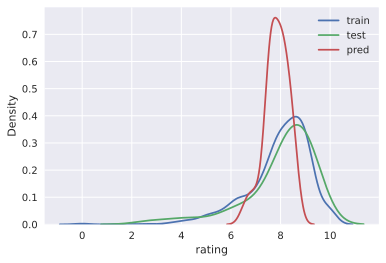

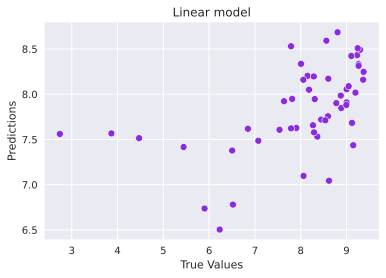

In [61]:
target_distr_linear(y_train, y_test, y_pred)

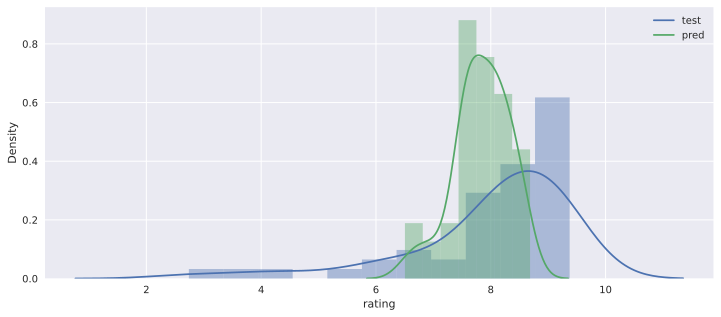

In [62]:
def draw_target_distr(y_test, y_pred, save_fig=False):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    plt.savefig('./okko_ratings_test_pred_russ_kws')
    plt.show()

draw_target_distr(y_test, y_pred)

IMP: [1.99631854e+01 1.03715213e+01 1.53424075e+01 4.64589480e-02
 0.00000000e+00 3.18814225e+00 3.76765447e-01 4.62829641e+00
 6.60546984e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.96890935e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.71454165e-02 5.02970787e-02 0.00000000e+00]


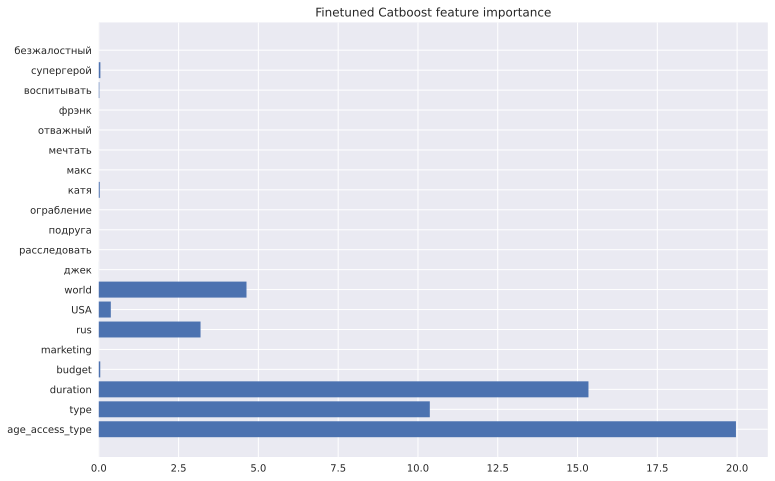

In [63]:
get_feature_imp(best_cat, train_dataset)

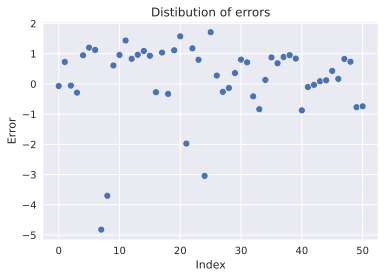

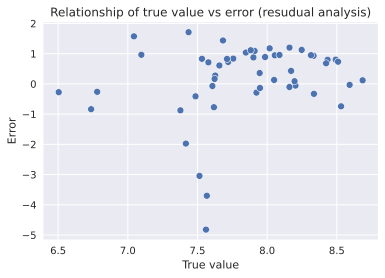

In [64]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

In [65]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.581491292706956
RMSE:  1.2575735734766995
R2:    0.22920744929330694
MAE:   0.8991477066693673
MedAE: 0.8048240727126803
------------------------------


In [66]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df

age_access_type                                               name  \
10378               16                                         Тихие воды   
7938                16                      Русские грузины. Фильм второй   
10377               16              Я знаю твои секреты 7. Дыхание смерти   
7698                12                                      Тайна амулета   
10370               18                                          Два холма   
10369               18                                            Оффлайн   
10368               16                              И снова здравствуйте!   
5410                16                                         Другое имя   
4462                16                                         Селфимания   
10391                0                               Мой мир. Поем вместе   
10390               18                                             Смычок   
7909                 0                        Три кота и море приключений   
8189                12  Все в сад! Или русская классика в цветах. Сезон 2   
10475               18  Что делать женщине, если у неё два любовника, ...   
10399               18                                               Жиза   
7644                 6                                       Забытое чудо   
5474                18                                             Модель   
10440               18                                   Закрыть гештальт   
10389               16                            Кабинет Путешественника   
5542                16                                        Многоэтажка   
7505                18                                               Ника   
5556                16                                         Бодибилдер   
6304                 6                           Кощей. Похититель невест   
5208                12                          1941. Крылья над Берлином   
6183                16                                     Доктор Свисток   
6354                16                                    Молодой человек   
6404                16                                           Свингеры   
6435                18                                          Приплыли!   
6012                 6                                   Мой папа – вождь   
5925                16                                              Дикая   
10246               12                            Предпоследняя инстанция   
6673                16                                        Страна Саша   
6697                16                        Эластико: Двенадцатый игрок   
6771                18                                              Рэпер   
10281                0                                         Спорт Тоша   
10286               18                                          Номинация   
10306               16                                              Агеев   
5681                16                             День слепого Валентина   
7499                12                                      Мистер Нокаут   
5566                16                                         Хочу замуж   
6267                16                                        Убить босса   
10341               16                                          Пианистка   
7515                12                                       Первый Оскар   
10349               16                                     Танцы на углях   
10350               16                                             Янычар   
10352               16                            Исправление и наказание   
10354               16                          Орлинская. Стрелы Нептуна   
7549                16                                         Бультерьер   
7565                 6                                             Финник   
5551                16                                             Стикер   
10486                6                                       Большие игры   

  